In [1]:

import gymnasium as gym

#Policy 
import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

import random
import math
import numpy as np
from tqdm import tqdm

from Logger import Logger, BEGIN, FINISH, PATH, META, INFO, WARN, ERROR
logger = Logger()

from collections import deque #For replay buffer
torch.set_default_device('cpu')#'cuda' if torch.cuda.is_available() else 'cpu')
torch.get_default_device()
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

np.__version__, torch.__version__, gym.__version__, DEVICE


Importing C:\CustomTools\Logger.py...
Done Importing C:\CustomTools\Logger.py...
[2025-10-15 20:49:24] [WARN] [MET]: Auto-repairing incomplete sessions: [3]
Logger initialized with file .log, default tag [MET] and level [WARN]


('1.24.4', '2.6.0+cu118', '1.1.1', device(type='cuda'))

In [20]:
env = gym.make('InvertedPendulum-v5', reset_noise_scale=0.1, max_episode_steps=300)

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(state_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))  # learnable log σ

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        mu = self.mean(x)
        std = torch.exp(self.log_std)
        dist = Normal(mu, std)
        return dist

pi = PolicyNetwork(np.array(env.observation_space.shape)[0], np.array(env.action_space.shape)[0]).to(DEVICE)


### Sampling Next Action From Current State

In [ ]:
def sample_next_action(policy : nn.Module, obs):
    action_dist = policy(torch.tensor(obs, dtype=torch.float32, device=DEVICE))
    action = action_dist.sample()
    log_prob = action_dist.log_prob(action).sum()
    return action, log_prob

#Sanity Check:
sample_next_action(pi, [0,0,0,0])

(tensor([0.3930], device='cuda:0'),
 tensor([-0.9851], device='cuda:0', grad_fn=<SubBackward0>))

### Simulating One Episode

In [23]:
def simulate_episode(env: gym.Env, policy: nn.Module, gamma: float):
    episode_over = False
    episode_reward = 0

    obs, info = env.reset()

    actions = []
    states = []
    log_probs = []
    rewards = []

    while not episode_over:
        # ensure obs is a torch tensor on the same device as policy
        obs_tensor = torch.tensor(obs, dtype=torch.float32, device=DEVICE)
        action, log_prob = sample_next_action(policy, obs_tensor)

        action = action.clamp(env.action_space.low[0], env.action_space.high[0])  # ensure action is within bounds
        obs, reward, terminated, truncated, info = env.step(action.cpu().numpy())

        episode_over = terminated or truncated

        log_probs.append(log_prob)
        actions.append(action)
        states.append(obs)
        rewards.append(reward)

    # ---------- compute discounted returns ----------
    G = 0
    returns = []
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    # convert to tensor BEFORE normalizing
    returns = torch.tensor(returns, dtype=torch.float32, device=DEVICE)

    # normalize for stability
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)

    return returns, states, actions, torch.stack(log_probs), rewards, len(log_probs)


In [ ]:
class LossPerEpisode(nn.Module):
    def __init__(self, epislon=1e-8):
        super().__init__()
        self.EPSILON = epislon

    def forward(self, log_probs: torch.Tensor, returns: torch.Tensor):
        if log_probs.shape[0] != returns.shape[0]:
            raise ValueError("Input Lengths Mismatch")

        mean = returns.mean()
        std = returns.std()
        advantages = (returns - mean)/(std + self.EPSILON)  # reduce variance
        loss = -(advantages * log_probs).sum()
        return loss


In [25]:
import torch.optim as optim

logger.start_session()

lr = 1e-4
optimizer = optim.Adam(pi.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.995)

gamma = 0.99
num_episodes = 50000
logger(f"Starting Training Loop: {num_episodes} episodes..", tag=BEGIN)

loss_module = LossPerEpisode()

rewards_per_episode = []

for episode in tqdm(range(num_episodes)):
    returns, states, actions, log_probs, rewards, timesteps = simulate_episode(env, pi, gamma)
    
    loss = loss_module(log_probs = log_probs, returns = returns)

    optimizer.zero_grad()   # Clear old gradients
    loss.backward()         # Compute gradients
    optimizer.step()        # Update policy weights
    scheduler.step()        # Update learning rate

    rewards_per_episode.append(sum(rewards))

    logger(f"Episode: {episode+1} | Cumulative Reward: {sum(rewards)} | Timesteps: {timesteps} | Loss: {loss.item()}")
    del returns, log_probs, loss
    torch.cuda.empty_cache()  # Optional

    

env.close()
logger("Done Training.", tag=FINISH)

[2025-10-07 17:22:19] [INFO] [MET]: START Session 3
[2025-10-07 17:22:19] [INFO] [BEG]: Starting Training Loop: 50000 episodes..


  0%|          | 1/50000 [00:00<1:23:46,  9.95it/s]

[2025-10-07 17:22:19] [INFO] [DEF]: Episode: 1 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:19] [INFO] [DEF]: Episode: 2 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:19] [INFO] [DEF]: Episode: 3 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:22:19] [INFO] [DEF]: Episode: 4 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


  0%|          | 5/50000 [00:00<38:22, 21.72it/s]  

[2025-10-07 17:22:19] [INFO] [DEF]: Episode: 5 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:19] [INFO] [DEF]: Episode: 6 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  0%|          | 8/50000 [00:00<35:15, 23.63it/s]

[2025-10-07 17:22:19] [INFO] [DEF]: Episode: 7 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:22:19] [INFO] [DEF]: Episode: 8 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 9 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 10 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


  0%|          | 12/50000 [00:00<28:44, 28.99it/s]

[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 11 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 12 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 13 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 14 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


  0%|          | 16/50000 [00:00<25:37, 32.51it/s]

[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 15 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 16 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 17 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 18 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


  0%|          | 20/50000 [00:00<26:37, 31.30it/s]

[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 19 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 20 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 21 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  0%|          | 24/50000 [00:00<28:21, 29.38it/s]

[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 22 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 23 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 24 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 25 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


  0%|          | 30/50000 [00:01<34:44, 23.97it/s]

[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 26 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.33514404296875e-05
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 27 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 28 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 29 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.1444091796875e-05
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 30 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 31 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


  0%|          | 38/50000 [00:01<28:46, 28.93it/s]

[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 32 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 33 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 34 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 35 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 36 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 37 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:20] [INFO] [DEF]: Episode: 38 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  0%|          | 42/50000 [00:01<27:55, 29.81it/s]

[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 39 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 40 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 41 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 42 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 43 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 44 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 45 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  0%|          | 50/50000 [00:01<27:47, 29.95it/s]

[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 46 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 47 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 48 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 49 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 50 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 51 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.814697265625e-06


  0%|          | 54/50000 [00:01<27:20, 30.44it/s]

[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 52 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 53 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 54 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 55 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 56 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 57 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  0%|          | 62/50000 [00:02<28:02, 29.68it/s]

[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 58 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 59 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 60 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 61 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 62 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 63 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 64 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 65 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


  0%|          | 72/50000 [00:02<22:18, 37.31it/s]

[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 66 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 67 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 68 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 69 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 70 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:21] [INFO] [DEF]: Episode: 71 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 72 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 73 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  0%|          | 76/50000 [00:02<26:32, 31.34it/s]

[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 74 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 75 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 76 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.9073486328125e-05
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 77 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.621246337890625e-05


  0%|          | 84/50000 [00:02<29:03, 28.63it/s]

[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 78 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 79 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 80 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 81 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 82 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 83 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 84 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  0%|          | 88/50000 [00:03<29:35, 28.11it/s]

[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 85 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 86 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 87 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 88 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 89 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 90 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


  0%|          | 98/50000 [00:03<24:08, 34.45it/s]

[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 91 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 92 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 93 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 94 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 95 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 96 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 97 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 98 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 99 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920

  0%|          | 107/50000 [00:03<22:09, 37.54it/s]

[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 101 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:22] [INFO] [DEF]: Episode: 102 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 103 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 106 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 107 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  0%|          | 111/50000 [00:03<26:56, 30.86it/s]

[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 108 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 109 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 110 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 111 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.71661376953125e-05
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 112 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


  0%|          | 119/50000 [00:03<27:01, 30.76it/s]

[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 113 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 116 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 117 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 118 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 119 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 120 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 121 | Cumulative Reward: 3 |

  0%|          | 128/50000 [00:04<22:56, 36.23it/s]

[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 122 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 123 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 124 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 125 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 126 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 127 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 128 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 129 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 130 | Cumulative Reward: 4 | Timesteps: 5 | L

  0%|          | 139/50000 [00:04<20:09, 41.21it/s]

[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 133 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 134 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 135 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 136 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 137 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 138 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:23] [INFO] [DEF]: Episode: 139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 140 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


  0%|          | 144/50000 [00:04<22:31, 36.90it/s]

[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 141 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 143 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 144 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 145 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 146 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 147 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


  0%|          | 152/50000 [00:04<23:55, 34.72it/s]

[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 149 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 150 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 151 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 153 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 154 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  0%|          | 160/50000 [00:05<25:06, 33.09it/s]

[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 155 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 157 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 158 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 159 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 160 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 161 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 162 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 163 | Cumulative 

  0%|          | 170/50000 [00:05<22:42, 36.57it/s]

[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 164 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 165 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 166 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 167 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 169 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


  0%|          | 174/50000 [00:05<24:03, 34.52it/s]

[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 171 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:24] [INFO] [DEF]: Episode: 172 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 173 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 174 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 176 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 177 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


  0%|          | 183/50000 [00:05<23:34, 35.21it/s]

[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 178 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 179 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 180 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 181 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 182 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 183 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 184 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 185 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 186 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.7

  0%|          | 194/50000 [00:05<20:47, 39.91it/s]

[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 187 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 188 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 189 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 191 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 192 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 193 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 194 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  0%|          | 199/50000 [00:06<22:20, 37.16it/s]

[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 195 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 196 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 197 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 198 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 199 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 200 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 202 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  0%|          | 208/50000 [00:06<21:32, 38.52it/s]

[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 203 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 205 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.0994415283203125e-06
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 206 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 207 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 208 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 209 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:25] [INFO] [DEF]: Episode: 210 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 211 | Cumulative Reward: 4 | Timeste

  0%|          | 218/50000 [00:06<20:04, 41.34it/s]

[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 212 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 213 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 214 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 217 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 218 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 219 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


  0%|          | 227/50000 [00:06<24:34, 33.77it/s]

[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 220 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.430511474609375e-05
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 221 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 222 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 223 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 224 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 226 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 227 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


  0%|          | 232/50000 [00:06<22:57, 36.12it/s]

[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 228 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 229 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 230 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 232 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 233 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  0%|          | 240/50000 [00:07<24:52, 33.35it/s]

[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 236 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 238 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 240 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  0%|          | 244/50000 [00:07<28:14, 29.36it/s]

[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 241 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:22:26] [INFO] [DEF]: Episode: 242 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.337860107421875e-06
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 243 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 244 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 245 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 246 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


  1%|          | 253/50000 [00:07<29:19, 28.27it/s]

[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 247 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 248 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 249 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 250 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 251 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 252 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 253 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


  1%|          | 259/50000 [00:08<29:48, 27.81it/s]

[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 254 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 255 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 256 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 258 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 259 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06


  1%|          | 263/50000 [00:08<28:32, 29.04it/s]

[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 260 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 261 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 264 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 265 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06


  1%|          | 270/50000 [00:08<28:31, 29.05it/s]

[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 266 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 267 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 268 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:27] [INFO] [DEF]: Episode: 270 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


  1%|          | 276/50000 [00:08<32:38, 25.39it/s]

[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 273 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 274 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 275 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 276 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 277 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  1%|          | 283/50000 [00:08<28:54, 28.66it/s]

[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 278 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 280 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 282 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 283 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 284 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  1%|          | 291/50000 [00:09<26:18, 31.49it/s]

[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 286 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 287 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 289 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 290 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 291 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  1%|          | 295/50000 [00:09<35:36, 23.27it/s]

[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 292 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 293 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 294 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.6226043701171875e-06
[2025-10-07 17:22:28] [INFO] [DEF]: Episode: 295 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06


  1%|          | 298/50000 [00:09<36:01, 22.99it/s]

[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 296 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 297 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 298 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 299 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 300 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-07


  1%|          | 306/50000 [00:09<29:30, 28.07it/s]

[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 301 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 302 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 303 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 304 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 305 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 308 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 309 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -

  1%|          | 314/50000 [00:10<31:35, 26.21it/s]

[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 311 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 313 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 314 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


  1%|          | 317/50000 [00:10<34:02, 24.32it/s]

[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 315 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 316 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 317 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 318 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 319 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


  1%|          | 323/50000 [00:10<35:49, 23.11it/s]

[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 320 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:29] [INFO] [DEF]: Episode: 321 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 322 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 323 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 324 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07


  1%|          | 330/50000 [00:10<32:21, 25.59it/s]

[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 325 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 326 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 327 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 328 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 329 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 330 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 331 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


  1%|          | 338/50000 [00:10<28:07, 29.42it/s]

[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 332 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 333 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 335 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 336 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 337 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 338 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  1%|          | 342/50000 [00:11<27:23, 30.21it/s]

[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 339 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 343 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 344 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 345 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


  1%|          | 351/50000 [00:11<25:03, 33.02it/s]

[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 347 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 349 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 350 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 351 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:30] [INFO] [DEF]: Episode: 353 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 354 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.

  1%|          | 360/50000 [00:11<24:42, 33.49it/s]

[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 356 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 357 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 358 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 359 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 360 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 362 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 363 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  1%|          | 369/50000 [00:11<27:09, 30.45it/s]

[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 364 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 366 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 367 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 369 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


  1%|          | 374/50000 [00:12<25:09, 32.87it/s]

[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 370 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 372 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 373 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 374 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 375 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 378 | Cumulative

  1%|          | 383/50000 [00:12<24:03, 34.36it/s]

[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 379 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 380 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 381 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 382 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 383 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 384 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:22:31] [INFO] [DEF]: Episode: 385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


  1%|          | 391/50000 [00:12<25:21, 32.61it/s]

[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 387 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 389 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 390 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 392 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 393 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  1%|          | 395/50000 [00:12<28:03, 29.46it/s]

[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 394 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 395 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 396 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 397 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 398 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


  1%|          | 402/50000 [00:13<29:46, 27.77it/s]

[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 399 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 402 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 403 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 404 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.0967254638671875e-05
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 405 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  1%|          | 410/50000 [00:13<27:46, 29.76it/s]

[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 406 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 407 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 408 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 409 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 410 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 411 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 412 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


  1%|          | 418/50000 [00:13<30:06, 27.44it/s]

[2025-10-07 17:22:32] [INFO] [DEF]: Episode: 413 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 414 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 415 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 416 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 417 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 418 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


  1%|          | 425/50000 [00:13<28:02, 29.47it/s]

[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 419 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 420 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 422 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 423 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 424 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 425 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 426 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  1%|          | 432/50000 [00:14<30:30, 27.07it/s]

[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 427 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 428 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 429 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 430 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 432 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


  1%|          | 435/50000 [00:14<30:02, 27.50it/s]

[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 433 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 434 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 436 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 437 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 438 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


  1%|          | 443/50000 [00:14<27:19, 30.23it/s]

[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 439 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 440 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 441 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:33] [INFO] [DEF]: Episode: 442 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 443 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  1%|          | 448/50000 [00:14<27:16, 30.28it/s]

[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 446 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 447 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 448 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 449 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 450 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07


  1%|          | 455/50000 [00:14<31:07, 26.53it/s]

[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 451 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 452 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 453 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 454 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 455 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


  1%|          | 458/50000 [00:15<31:24, 26.29it/s]

[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 456 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 457 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 458 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 459 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 460 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


  1%|          | 465/50000 [00:15<30:06, 27.42it/s]

[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 461 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 462 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 463 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 464 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 466 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 467 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07


  1%|          | 471/50000 [00:15<32:00, 25.79it/s]

[2025-10-07 17:22:34] [INFO] [DEF]: Episode: 468 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 469 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 470 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 471 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 473 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 474 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  1%|          | 481/50000 [00:15<23:15, 35.48it/s]

[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 475 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6093254089355469e-06
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 477 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 478 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 479 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 480 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 481 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 482 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 483 | Cumulative Reward: 4 | Ti

  1%|          | 489/50000 [00:15<24:29, 33.68it/s]

[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 485 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 486 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 487 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 488 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 489 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 490 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06


  1%|          | 497/50000 [00:16<25:51, 31.90it/s]

[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 492 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 494 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 496 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 497 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 498 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


  1%|          | 506/50000 [00:16<25:48, 31.95it/s]

[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 499 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:22:35] [INFO] [DEF]: Episode: 500 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 501 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 502 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 503 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 504 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 505 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 506 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06


  1%|          | 514/50000 [00:16<24:20, 33.88it/s]

[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 507 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 508 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 510 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 511 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 512 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 513 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  1%|          | 519/50000 [00:16<22:05, 37.33it/s]

[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 515 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 516 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 517 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 518 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 519 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 521 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 522 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


  1%|          | 528/50000 [00:17<24:58, 33.01it/s]

[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 523 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 526 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 527 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 528 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 529 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 530 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 531 | Cumulative Reward: 9 | Time

  1%|          | 537/50000 [00:17<23:37, 34.91it/s]

[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 532 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 533 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:36] [INFO] [DEF]: Episode: 534 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 535 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 536 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 537 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 538 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 539 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 540 | Cumulative Reward: 2 | Timesteps: 3 | L

  1%|          | 545/50000 [00:17<24:24, 33.77it/s]

[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 541 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 542 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 543 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 544 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 545 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 546 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06


  1%|          | 553/50000 [00:17<27:18, 30.19it/s]

[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 547 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 549 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 550 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 551 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  1%|          | 562/50000 [00:18<23:26, 35.14it/s]

[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 554 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 555 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.364418029785156e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 556 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 557 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 559 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 561 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 562 | Cumulative Reward: 8 | Timest

  1%|          | 566/50000 [00:18<22:45, 36.21it/s]

[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 563 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 564 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 566 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:37] [INFO] [DEF]: Episode: 567 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 568 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  1%|          | 574/50000 [00:18<25:38, 32.12it/s]

[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 570 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 571 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 572 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 573 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 574 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 575 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  1%|          | 578/50000 [00:18<25:27, 32.35it/s]

[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 576 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 577 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 578 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 579 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 580 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 581 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


  1%|          | 586/50000 [00:18<26:28, 31.10it/s]

[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 582 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 583 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 584 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 586 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  1%|          | 594/50000 [00:19<27:34, 29.87it/s]

[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 589 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.1457672119140625e-05
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 591 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 592 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 593 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 594 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 595 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 596 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  1%|          | 602/50000 [00:19<27:36, 29.82it/s]

[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 597 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:38] [INFO] [DEF]: Episode: 598 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 599 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 600 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 601 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 602 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  1%|          | 606/50000 [00:19<32:58, 24.96it/s]

[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 604 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 605 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 606 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 607 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 608 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 609 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


  1%|          | 612/50000 [00:19<25:59, 31.67it/s]

[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 610 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 611 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 613 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 614 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 615 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


  1%|          | 620/50000 [00:20<27:42, 29.70it/s]

[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 616 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 617 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 618 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 619 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 621 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 622 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 623 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.341104507446289e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 624 | Cumu

  1%|▏         | 629/50000 [00:20<25:26, 32.34it/s]

[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 625 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 626 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 627 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:39] [INFO] [DEF]: Episode: 628 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 629 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 630 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 632 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


  1%|▏         | 638/50000 [00:20<23:10, 35.49it/s]

[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 633 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 634 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 635 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 636 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 639 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  1%|▏         | 646/50000 [00:20<25:24, 32.38it/s]

[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 641 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 642 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 644 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-06
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 645 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 646 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  1%|▏         | 650/50000 [00:21<26:44, 30.75it/s]

[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 648 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 649 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 650 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 651 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 652 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 653 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


  1%|▏         | 659/50000 [00:21<23:36, 34.83it/s]

[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 655 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 656 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 658 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 659 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 660 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:40] [INFO] [DEF]: Episode: 661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  1%|▏         | 667/50000 [00:21<26:38, 30.87it/s]

[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 662 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 663 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 664 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 665 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 666 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  1%|▏         | 675/50000 [00:21<25:33, 32.17it/s]

[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 668 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 669 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 670 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -3.814697265625e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 671 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 672 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 673 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 675 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


  1%|▏         | 679/50000 [00:21<28:41, 28.64it/s]

[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 676 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 677 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.1444091796875e-05
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 679 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 680 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 681 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


  1%|▏         | 683/50000 [00:22<27:27, 29.93it/s]

[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 682 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 684 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 685 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 686 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  1%|▏         | 692/50000 [00:22<27:47, 29.58it/s]

[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 687 | Cumulative Reward: 39 | Timesteps: 40 | Loss: -3.4332275390625e-05
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 688 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:41] [INFO] [DEF]: Episode: 689 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 692 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 693 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 694 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 695 | Cumulative Reward: 4 | Times

  1%|▏         | 701/50000 [00:22<23:58, 34.26it/s]

[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 697 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 698 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 701 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 702 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.

  1%|▏         | 705/50000 [00:22<27:08, 30.27it/s]

[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 705 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 706 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 708 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


  1%|▏         | 714/50000 [00:23<27:59, 29.34it/s]

[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 709 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.86102294921875e-05
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 710 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 712 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 716 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 717 | Cumulat

  1%|▏         | 722/50000 [00:23<26:49, 30.62it/s]

[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 718 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 719 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:22:42] [INFO] [DEF]: Episode: 720 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 721 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 722 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 724 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


  1%|▏         | 731/50000 [00:23<26:38, 30.81it/s]

[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 725 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 726 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 727 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 729 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 730 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 731 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


  1%|▏         | 735/50000 [00:23<25:20, 32.39it/s]

[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 732 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 733 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 734 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 735 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 736 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 737 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


  1%|▏         | 743/50000 [00:24<28:30, 28.79it/s]

[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 738 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 739 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 742 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 743 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


  1%|▏         | 747/50000 [00:24<27:04, 30.32it/s]

[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 744 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 745 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 746 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 747 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 748 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 749 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 750 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


  2%|▏         | 755/50000 [00:24<26:40, 30.76it/s]

[2025-10-07 17:22:43] [INFO] [DEF]: Episode: 751 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 752 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 753 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 754 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 755 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 756 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06


  2%|▏         | 763/50000 [00:24<26:10, 31.36it/s]

[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 757 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 758 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 761 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 762 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 763 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 765 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.19

  2%|▏         | 772/50000 [00:25<24:26, 33.56it/s]

[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 767 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 768 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 769 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 770 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 771 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 772 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 773 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  2%|▏         | 776/50000 [00:25<24:45, 33.13it/s]

[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 775 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 776 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 777 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 778 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 779 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  2%|▏         | 784/50000 [00:25<26:03, 31.47it/s]

[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 780 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 781 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:44] [INFO] [DEF]: Episode: 783 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 784 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 786 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 787 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


  2%|▏         | 793/50000 [00:25<25:31, 32.14it/s]

[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 788 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 789 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 790 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 791 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 792 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 793 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 794 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


  2%|▏         | 801/50000 [00:25<25:45, 31.84it/s]

[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 795 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 797 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 798 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 799 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 801 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.9073486328125e-06


  2%|▏         | 805/50000 [00:26<25:18, 32.41it/s]

[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 802 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 803 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 805 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 806 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 807 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


  2%|▏         | 813/50000 [00:26<26:41, 30.71it/s]

[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 808 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 809 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 813 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:22:45] [INFO] [DEF]: Episode: 814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 815 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


  2%|▏         | 821/50000 [00:26<25:02, 32.74it/s]

[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 816 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 817 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 818 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 819 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 820 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 821 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 823 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


  2%|▏         | 826/50000 [00:26<23:15, 35.24it/s]

[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 825 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 826 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 827 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 828 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 829 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07


  2%|▏         | 834/50000 [00:27<26:44, 30.65it/s]

[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 830 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.5299530029296875e-06
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 831 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 832 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 833 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 835 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 836 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  2%|▏         | 842/50000 [00:27<26:06, 31.39it/s]

[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 837 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 838 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 839 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 840 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:46] [INFO] [DEF]: Episode: 844 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


  2%|▏         | 851/50000 [00:27<25:47, 31.76it/s]

[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 845 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.47955322265625e-05
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 847 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 848 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 850 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 852 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 853 | Cumulative Reward: 11 | 

  2%|▏         | 859/50000 [00:27<27:22, 29.92it/s]

[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 854 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 855 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 856 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 857 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 858 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 859 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06


  2%|▏         | 868/50000 [00:28<23:01, 35.58it/s]

[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 860 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 861 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 862 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 863 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 864 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 865 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 866 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 867 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 868 | Cumulative Reward

  2%|▏         | 876/50000 [00:28<22:11, 36.89it/s]

[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 870 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 871 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 872 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 874 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 875 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 876 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 877 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


  2%|▏         | 880/50000 [00:28<22:54, 35.73it/s]

[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 878 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 879 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 880 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:47] [INFO] [DEF]: Episode: 881 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 882 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 883 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 884 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  2%|▏         | 889/50000 [00:28<24:28, 33.45it/s]

[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 885 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.2516975402832031e-06
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 886 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 888 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 889 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 890 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


  2%|▏         | 893/50000 [00:28<27:27, 29.81it/s]

[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 891 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 893 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 894 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 895 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 896 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  2%|▏         | 901/50000 [00:29<27:47, 29.44it/s]

[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 897 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 898 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 899 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 900 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 901 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 902 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 904 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  2%|▏         | 910/50000 [00:29<23:37, 34.62it/s]

[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 905 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 906 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 907 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 908 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 910 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 911 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:22:48] [INFO] [DEF]: Episode: 913 | Cumulative 

  2%|▏         | 918/50000 [00:29<23:05, 35.43it/s]

[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 914 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 915 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 916 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 918 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


  2%|▏         | 926/50000 [00:29<25:58, 31.50it/s]

[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 919 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.0503997802734375e-05
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 920 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 921 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 922 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 923 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 924 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 926 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


  2%|▏         | 930/50000 [00:29<27:30, 29.72it/s]

[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 928 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 929 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 930 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 931 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


  2%|▏         | 934/50000 [00:30<27:03, 30.23it/s]

[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 932 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 934 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 935 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 936 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 937 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


  2%|▏         | 943/50000 [00:30<24:56, 32.78it/s]

[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 938 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 939 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 940 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 942 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:49] [INFO] [DEF]: Episode: 943 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 944 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -5.245208740234375e-06


  2%|▏         | 950/50000 [00:30<29:39, 27.56it/s]

[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 945 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 946 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 947 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 948 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 949 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 950 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


  2%|▏         | 953/50000 [00:30<30:38, 26.67it/s]

[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 951 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 952 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 953 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 954 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 955 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


  2%|▏         | 960/50000 [00:31<32:09, 25.42it/s]

[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 956 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 957 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 960 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 962 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 963 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


  2%|▏         | 965/50000 [00:31<26:33, 30.78it/s]

[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 964 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 965 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 967 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 968 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


  2%|▏         | 972/50000 [00:31<30:51, 26.49it/s]

[2025-10-07 17:22:50] [INFO] [DEF]: Episode: 969 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 970 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 971 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 972 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 973 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 975 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  2%|▏         | 980/50000 [00:31<31:11, 26.20it/s]

[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 976 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 977 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 978 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 979 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 980 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 982 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


  2%|▏         | 989/50000 [00:32<26:25, 30.91it/s]

[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 984 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 985 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 986 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 987 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 989 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


  2%|▏         | 993/50000 [00:32<27:50, 29.34it/s]

[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 990 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 991 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 992 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 993 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 994 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 995 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 996 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  2%|▏         | 1001/50000 [00:32<27:33, 29.64it/s]

[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 997 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:51] [INFO] [DEF]: Episode: 998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 999 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1000 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1001 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1002 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1003 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1004 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


  2%|▏         | 1008/50000 [00:32<34:17, 23.81it/s]

[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1005 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.0013580322265625e-05
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1006 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1007 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1008 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.62939453125e-06
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1009 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


  2%|▏         | 1015/50000 [00:33<32:08, 25.40it/s]

[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1010 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1011 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1012 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1013 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1014 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1015 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


  2%|▏         | 1024/50000 [00:33<25:48, 31.62it/s]

[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1016 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1018 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1019 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1020 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1021 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1022 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1023 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1024 | Cumulative R

  2%|▏         | 1029/50000 [00:33<27:02, 30.18it/s]

[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1026 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1027 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:52] [INFO] [DEF]: Episode: 1028 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1029 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1030 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1031 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  2%|▏         | 1039/50000 [00:33<23:39, 34.50it/s]

[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1032 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1033 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1035 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1036 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1037 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1038 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1039 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


  2%|▏         | 1043/50000 [00:33<25:59, 31.38it/s]

[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1040 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1041 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1042 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1043 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1044 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1045 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1046 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1047 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


  2%|▏         | 1055/50000 [00:34<25:21, 32.18it/s]

[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1048 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1049 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1051 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1052 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1053 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1054 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1055 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


  2%|▏         | 1059/50000 [00:34<29:05, 28.04it/s]

[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1056 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:53] [INFO] [DEF]: Episode: 1057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1058 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1059 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1060 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1061 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  2%|▏         | 1063/50000 [00:34<26:58, 30.23it/s]

[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1062 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1063 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1064 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1065 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 4.76837158203125e-06
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


  2%|▏         | 1073/50000 [00:34<26:03, 31.30it/s]

[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1067 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1068 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1069 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1071 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1072 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1073 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1075 | Cumulative Reward: 

  2%|▏         | 1077/50000 [00:35<25:02, 32.57it/s]

[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1076 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1077 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1078 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1079 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1080 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


  2%|▏         | 1085/50000 [00:35<29:46, 27.39it/s]

[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1082 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1083 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1084 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1085 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:54] [INFO] [DEF]: Episode: 1086 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1087 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


  2%|▏         | 1090/50000 [00:35<27:41, 29.45it/s]

[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1088 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1089 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1090 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1092 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1093 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


  2%|▏         | 1097/50000 [00:35<30:20, 26.86it/s]

[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1094 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1095 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1096 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1097 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1098 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1099 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.470348358154297e-08


  2%|▏         | 1105/50000 [00:36<27:03, 30.11it/s]

[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1100 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1101 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1102 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1104 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1105 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1107 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  2%|▏         | 1113/50000 [00:36<28:12, 28.88it/s]

[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1108 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1109 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1110 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1111 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1112 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  2%|▏         | 1119/50000 [00:36<28:42, 28.38it/s]

[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1114 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:55] [INFO] [DEF]: Episode: 1115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1116 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1117 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1118 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1119 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  2%|▏         | 1123/50000 [00:36<27:24, 29.73it/s]

[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1122 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1123 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1124 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.1444091796875e-05
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  2%|▏         | 1129/50000 [00:36<32:12, 25.29it/s]

[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1126 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1127 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1128 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1129 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1130 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  2%|▏         | 1135/50000 [00:37<32:09, 25.33it/s]

[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1132 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1133 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1134 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1135 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1136 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1137 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


  2%|▏         | 1143/50000 [00:37<27:51, 29.22it/s]

[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1138 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1139 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1140 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1141 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:22:56] [INFO] [DEF]: Episode: 1142 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1143 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1144 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  2%|▏         | 1150/50000 [00:37<29:35, 27.52it/s]

[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1146 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1147 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1148 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1150 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1151 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  2%|▏         | 1158/50000 [00:37<27:40, 29.42it/s]

[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1153 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1154 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1155 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1156 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1157 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1158 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1159 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  2%|▏         | 1165/50000 [00:38<30:04, 27.06it/s]

[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1160 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1161 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1163 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1164 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 5.7220458984375e-06
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1165 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1166 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  2%|▏         | 1169/50000 [00:38<27:55, 29.14it/s]

[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1167 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:57] [INFO] [DEF]: Episode: 1169 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1170 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1171 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


  2%|▏         | 1176/50000 [00:38<30:29, 26.68it/s]

[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1172 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1173 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1174 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1175 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1176 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  2%|▏         | 1183/50000 [00:38<29:05, 27.96it/s]

[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1177 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.6702880859375e-05
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1178 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1179 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1181 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.086162567138672e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1183 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1184 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


  2%|▏         | 1189/50000 [00:39<30:38, 26.55it/s]

[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1185 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1186 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1187 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1188 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1189 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1190 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


  2%|▏         | 1193/50000 [00:39<30:45, 26.45it/s]

[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1191 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1193 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 4.76837158203125e-06
[2025-10-07 17:22:58] [INFO] [DEF]: Episode: 1194 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1195 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06


  2%|▏         | 1199/50000 [00:39<34:28, 23.59it/s]

[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1196 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1197 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1198 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1199 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1200 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1201 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


  2%|▏         | 1206/50000 [00:39<28:40, 28.36it/s]

[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1202 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1204 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1205 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1207 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.0728836059570312e-06
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1208 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


  2%|▏         | 1212/50000 [00:40<29:17, 27.76it/s]

[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1210 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1211 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1212 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1213 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07


  2%|▏         | 1219/50000 [00:40<29:59, 27.11it/s]

[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1214 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1216 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1217 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1218 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1219 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1220 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:22:59] [INFO] [DEF]: Episode: 1221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  2%|▏         | 1226/50000 [00:40<28:57, 28.07it/s]

[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1222 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-06
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1223 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1224 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1225 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1226 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06


  2%|▏         | 1233/50000 [00:40<27:41, 29.35it/s]

[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1228 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1229 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1230 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1232 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1233 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1234 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1235 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


  2%|▏         | 1241/50000 [00:41<26:38, 30.51it/s]

[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1236 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1237 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1239 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1240 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1241 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


  2%|▏         | 1249/50000 [00:41<26:39, 30.47it/s]

[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1242 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1244 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1245 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1247 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1250 | Cumulative Reward: 2 | 

  3%|▎         | 1257/50000 [00:41<23:46, 34.16it/s]

[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1251 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:23:00] [INFO] [DEF]: Episode: 1252 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1253 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1254 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1255 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1256 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1258 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1259 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76

  3%|▎         | 1262/50000 [00:41<25:31, 31.81it/s]

[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1260 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1261 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1262 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1264 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1265 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  3%|▎         | 1270/50000 [00:41<28:37, 28.37it/s]

[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1266 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1267 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1268 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.198883056640625e-06
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1269 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1270 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  3%|▎         | 1278/50000 [00:42<25:34, 31.74it/s]

[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1272 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1273 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1275 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1276 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1277 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1278 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


  3%|▎         | 1282/50000 [00:42<24:02, 33.77it/s]

[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1281 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:01] [INFO] [DEF]: Episode: 1283 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1284 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  3%|▎         | 1290/50000 [00:42<24:25, 33.23it/s]

[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1287 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1288 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1289 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1290 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1293 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  3%|▎         | 1299/50000 [00:42<25:52, 31.37it/s]

[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1295 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1296 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1297 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1298 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1299 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07


  3%|▎         | 1303/50000 [00:43<30:00, 27.05it/s]

[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1301 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1302 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.6702880859375e-05
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1303 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


  3%|▎         | 1310/50000 [00:43<30:36, 26.51it/s]

[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1304 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1305 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1306 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1308 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1309 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1310 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06


  3%|▎         | 1314/50000 [00:43<28:05, 28.89it/s]

[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1312 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:02] [INFO] [DEF]: Episode: 1313 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1314 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1315 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1316 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1317 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  3%|▎         | 1322/50000 [00:43<26:18, 30.83it/s]

[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1318 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1319 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1320 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1321 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1322 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1323 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1324 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  3%|▎         | 1326/50000 [00:43<27:07, 29.90it/s]

[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1325 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1326 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1327 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1328 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1329 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1330 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


  3%|▎         | 1335/50000 [00:44<26:31, 30.58it/s]

[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1331 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1332 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1333 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1334 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1335 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1336 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


  3%|▎         | 1344/50000 [00:44<24:45, 32.75it/s]

[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1337 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1338 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1341 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1343 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  3%|▎         | 1348/50000 [00:44<24:41, 32.84it/s]

[2025-10-07 17:23:03] [INFO] [DEF]: Episode: 1345 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1346 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1347 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1348 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1349 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1350 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


  3%|▎         | 1356/50000 [00:44<23:34, 34.39it/s]

[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1353 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1354 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1357 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1358 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  3%|▎         | 1364/50000 [00:45<28:15, 28.69it/s]

[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1359 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1360 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1361 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1362 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1364 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05


  3%|▎         | 1367/50000 [00:45<35:23, 22.91it/s]

[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1365 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.288818359375e-05
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1367 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:23:04] [INFO] [DEF]: Episode: 1368 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06


  3%|▎         | 1373/50000 [00:45<39:54, 20.31it/s]

[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1369 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1370 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1371 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1372 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1373 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


  3%|▎         | 1376/50000 [00:45<40:18, 20.10it/s]

[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1374 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1375 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1376 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


  3%|▎         | 1383/50000 [00:46<34:42, 23.35it/s]

[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1380 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1381 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1382 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1383 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


  3%|▎         | 1386/50000 [00:46<34:00, 23.82it/s]

[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1387 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1388 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  3%|▎         | 1396/50000 [00:46<30:06, 26.90it/s]

[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1390 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1391 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1393 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:23:05] [INFO] [DEF]: Episode: 1394 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1395 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1396 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


  3%|▎         | 1403/50000 [00:46<28:11, 28.74it/s]

[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1397 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1398 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1399 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1400 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1401 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1402 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1403 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


  3%|▎         | 1406/50000 [00:46<28:37, 28.30it/s]

[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1404 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1405 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1406 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1408 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07


  3%|▎         | 1414/50000 [00:47<25:23, 31.89it/s]

[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1410 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -6.556510925292969e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1411 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1412 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1413 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1414 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1415 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1416 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


  3%|▎         | 1423/50000 [00:47<25:58, 31.17it/s]

[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1417 | Cumulative Reward: 38 | Timesteps: 39 | Loss: 3.0517578125e-05
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1418 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1419 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1420 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1422 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:06] [INFO] [DEF]: Episode: 1423 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1424 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1425 | Cumulati

  3%|▎         | 1427/50000 [00:47<28:40, 28.24it/s]

[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1426 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1427 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1428 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1429 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1430 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


  3%|▎         | 1434/50000 [00:47<34:48, 23.25it/s]

[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1432 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.6226043701171875e-05
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1433 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1434 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1435 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


  3%|▎         | 1441/50000 [00:48<31:11, 25.95it/s]

[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1436 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1437 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1438 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1440 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1441 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  3%|▎         | 1445/50000 [00:48<27:57, 28.94it/s]

[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1442 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1443 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1444 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1445 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1446 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1447 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1448 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


  3%|▎         | 1452/50000 [00:48<29:17, 27.62it/s]

[2025-10-07 17:23:07] [INFO] [DEF]: Episode: 1449 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1452 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1453 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1454 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  3%|▎         | 1460/50000 [00:48<27:30, 29.42it/s]

[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1459 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1460 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1461 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  3%|▎         | 1468/50000 [00:49<26:47, 30.19it/s]

[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1463 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1465 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1466 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1467 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1468 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1469 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  3%|▎         | 1472/50000 [00:49<25:18, 31.96it/s]

[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1470 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1471 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1472 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1473 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1475 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  3%|▎         | 1480/50000 [00:49<28:12, 28.66it/s]

[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1477 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:23:08] [INFO] [DEF]: Episode: 1478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1479 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1480 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1481 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1482 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


  3%|▎         | 1487/50000 [00:49<29:41, 27.24it/s]

[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.940696716308594e-08
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1484 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1485 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1487 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1488 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1489 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1490 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


  3%|▎         | 1496/50000 [00:49<25:20, 31.89it/s]

[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1491 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1492 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1494 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1496 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1497 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


  3%|▎         | 1500/50000 [00:50<24:32, 32.94it/s]

[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1498 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1499 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1500 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1501 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1502 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1503 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06


  3%|▎         | 1509/50000 [00:50<26:03, 31.01it/s]

[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1504 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1505 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1506 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1507 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1508 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1509 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:23:09] [INFO] [DEF]: Episode: 1510 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  3%|▎         | 1517/50000 [00:50<24:28, 33.02it/s]

[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1511 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1512 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1514 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1515 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1517 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1518 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1519 | Cumulat

  3%|▎         | 1526/50000 [00:50<23:15, 34.74it/s]

[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1520 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1521 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1522 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1524 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1525 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  3%|▎         | 1530/50000 [00:50<23:43, 34.05it/s]

[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1527 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1528 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1529 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1531 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1532 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1533 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


  3%|▎         | 1538/50000 [00:51<28:09, 28.69it/s]

[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1534 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1535 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1536 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1537 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1538 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


  3%|▎         | 1544/50000 [00:51<29:09, 27.69it/s]

[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1540 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:10] [INFO] [DEF]: Episode: 1541 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1542 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1543 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.430511474609375e-06
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1544 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1545 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  3%|▎         | 1550/50000 [00:51<29:26, 27.42it/s]

[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1546 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1547 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1548 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1549 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1550 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1551 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  3%|▎         | 1557/50000 [00:51<26:56, 29.97it/s]

[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1552 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1553 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1554 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1555 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1556 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1557 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


  3%|▎         | 1565/50000 [00:52<25:02, 32.23it/s]

[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1559 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1561 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1562 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1563 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1564 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


  3%|▎         | 1569/50000 [00:52<26:55, 29.98it/s]

[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1567 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1568 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:11] [INFO] [DEF]: Episode: 1569 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


  3%|▎         | 1573/50000 [00:52<29:50, 27.05it/s]

[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1570 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1571 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1572 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1573 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1574 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1575 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1576 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


  3%|▎         | 1583/50000 [00:52<23:45, 33.96it/s]

[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1577 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1579 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1581 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1582 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1584 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1585 | Cumula

  3%|▎         | 1591/50000 [00:53<24:48, 32.52it/s]

[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1587 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1589 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1590 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1591 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1592 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1594 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  3%|▎         | 1602/50000 [00:53<20:43, 38.91it/s]

[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1595 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1596 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1597 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1598 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1600 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1602 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


  3%|▎         | 1606/50000 [00:53<21:18, 37.87it/s]

[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1603 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1604 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1605 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1606 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:12] [INFO] [DEF]: Episode: 1607 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1608 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1609 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.9073486328125e-06


  3%|▎         | 1614/50000 [00:53<25:11, 32.01it/s]

[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1610 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.9073486328125e-05
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1612 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1613 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1614 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1616 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1617 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1618 | Cumulative Reward: 7 |

  3%|▎         | 1623/50000 [00:53<24:01, 33.55it/s]

[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1619 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1620 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1621 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1622 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1623 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1624 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1625 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


  3%|▎         | 1631/50000 [00:54<27:18, 29.52it/s]

[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1627 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1628 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1629 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1630 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1631 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


  3%|▎         | 1640/50000 [00:54<26:06, 30.88it/s]

[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1632 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -6.198883056640625e-06
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1633 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1634 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:13] [INFO] [DEF]: Episode: 1635 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1636 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1637 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1638 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1639 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1640 | Cumulative Reward: 9 | Timesteps:

  3%|▎         | 1644/50000 [00:54<26:04, 30.91it/s]

[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1641 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1642 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1643 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1645 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06


  3%|▎         | 1652/50000 [00:54<25:00, 32.22it/s]

[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1648 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1649 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1650 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1653 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1654 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1655 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  3%|▎         | 1660/50000 [00:55<28:58, 27.81it/s]

[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1656 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1657 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1658 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1659 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.198883056640625e-06
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1660 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


  3%|▎         | 1663/50000 [00:55<28:33, 28.21it/s]

[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1661 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1662 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1663 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1664 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:14] [INFO] [DEF]: Episode: 1665 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1666 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  3%|▎         | 1671/50000 [00:55<27:30, 29.27it/s]

[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1667 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1668 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1670 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1671 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1673 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


  3%|▎         | 1678/50000 [00:55<28:39, 28.10it/s]

[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1675 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1676 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1678 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


  3%|▎         | 1684/50000 [00:56<31:20, 25.69it/s]

[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1679 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1680 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1681 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1682 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1683 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1684 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05


  3%|▎         | 1689/50000 [00:56<29:16, 27.50it/s]

[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1685 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1686 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1689 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1690 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


  3%|▎         | 1696/50000 [00:56<27:22, 29.42it/s]

[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1691 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1692 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:15] [INFO] [DEF]: Episode: 1693 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1694 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1695 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1697 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


  3%|▎         | 1702/50000 [00:56<32:48, 24.54it/s]

[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1698 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1700 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1701 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1702 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


  3%|▎         | 1707/50000 [00:56<26:22, 30.52it/s]

[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1705 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1707 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1708 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1709 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


  3%|▎         | 1714/50000 [00:57<29:09, 27.60it/s]

[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1711 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1712 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1713 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1714 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1715 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1716 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1718 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


  3%|▎         | 1725/50000 [00:57<22:38, 35.55it/s]

[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1719 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1722 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:16] [INFO] [DEF]: Episode: 1724 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1725 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1726 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


  3%|▎         | 1729/50000 [00:57<24:58, 32.22it/s]

[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1727 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1728 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1729 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1731 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


  3%|▎         | 1733/50000 [00:57<26:23, 30.48it/s]

[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1732 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1733 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1734 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1735 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1736 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


  3%|▎         | 1741/50000 [00:58<28:18, 28.41it/s]

[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1737 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1739 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1740 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1741 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1742 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1745 | Cumulative Reward: 3 | Timesteps: 4 

  4%|▎         | 1750/50000 [00:58<25:20, 31.74it/s]

[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1746 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1747 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1748 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1749 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1750 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1751 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1752 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  4%|▎         | 1754/50000 [00:58<23:59, 33.52it/s]

[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1753 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:17] [INFO] [DEF]: Episode: 1754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1755 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1756 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1757 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  4%|▎         | 1762/50000 [00:58<26:07, 30.78it/s]

[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1758 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.288818359375e-05
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1759 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1760 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1761 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1763 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1764 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1765 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  4%|▎         | 1770/50000 [00:58<26:26, 30.41it/s]

[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1766 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1767 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1768 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1769 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1771 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1772 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


  4%|▎         | 1780/50000 [00:59<23:15, 34.55it/s]

[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1773 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1774 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1775 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1776 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1777 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1779 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1781 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203

  4%|▎         | 1790/50000 [00:59<21:51, 36.75it/s]

[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1783 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1784 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1785 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1786 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:18] [INFO] [DEF]: Episode: 1787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1788 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1789 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1790 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


  4%|▎         | 1794/50000 [00:59<26:09, 30.72it/s]

[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1793 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1794 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1795 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.0265579223632812e-06
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  4%|▎         | 1798/50000 [00:59<28:19, 28.35it/s]

[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1797 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1798 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1799 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1800 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


  4%|▎         | 1804/50000 [01:00<29:43, 27.02it/s]

[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1801 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1802 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1803 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1804 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1805 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1806 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


  4%|▎         | 1812/50000 [01:00<26:25, 30.40it/s]

[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1807 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1808 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1809 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1810 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1813 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  4%|▎         | 1820/50000 [01:00<25:53, 31.02it/s]

[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1814 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1815 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:19] [INFO] [DEF]: Episode: 1816 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1817 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1818 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1819 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1820 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


  4%|▎         | 1824/50000 [01:00<24:52, 32.27it/s]

[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1821 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1822 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1823 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1824 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1825 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1827 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1828 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


  4%|▎         | 1833/50000 [01:00<25:27, 31.53it/s]

[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1830 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1832 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1834 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


  4%|▎         | 1837/50000 [01:01<24:32, 32.72it/s]

[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1835 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1837 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1838 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1839 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1840 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


  4%|▎         | 1845/50000 [01:01<26:45, 30.00it/s]

[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1841 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1842 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1843 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1846 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:20] [INFO] [DEF]: Episode: 1847 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  4%|▎         | 1852/50000 [01:01<30:11, 26.58it/s]

[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1849 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1850 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1851 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1852 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1853 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  4%|▎         | 1860/50000 [01:01<27:31, 29.16it/s]

[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1854 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1855 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1856 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1857 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1858 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1860 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1861 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  4%|▎         | 1865/50000 [01:02<24:09, 33.20it/s]

[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1862 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1863 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1864 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1865 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1866 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1867 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1868 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  4%|▎         | 1873/50000 [01:02<27:24, 29.26it/s]

[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1869 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1870 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1871 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1872 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1873 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  4%|▍         | 1878/50000 [01:02<27:26, 29.24it/s]

[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1875 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1876 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:21] [INFO] [DEF]: Episode: 1877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1878 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1879 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1880 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


  4%|▍         | 1889/50000 [01:02<24:05, 33.28it/s]

[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1881 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1882 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1883 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1884 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1885 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1886 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1887 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1889 | Cumu

  4%|▍         | 1893/50000 [01:02<23:20, 34.35it/s]

[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1891 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1892 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1893 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1894 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.059906005859375e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  4%|▍         | 1902/50000 [01:03<22:43, 35.27it/s]

[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1896 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1898 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1899 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1900 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1901 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1902 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1903 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


  4%|▍         | 1906/50000 [01:03<24:28, 32.76it/s]

[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1904 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1906 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1907 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:22] [INFO] [DEF]: Episode: 1908 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


  4%|▍         | 1914/50000 [01:03<33:21, 24.03it/s]

[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1909 | Cumulative Reward: 45 | Timesteps: 46 | Loss: -2.47955322265625e-05
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1910 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1911 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1912 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.9604644775390625e-06
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1913 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1914 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06


  4%|▍         | 1922/50000 [01:03<27:29, 29.14it/s]

[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1915 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1916 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1918 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1920 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1921 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1922 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


  4%|▍         | 1926/50000 [01:04<25:31, 31.40it/s]

[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1923 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1924 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1925 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1926 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1929 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1930 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


  4%|▍         | 1935/50000 [01:04<24:37, 32.52it/s]

[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1931 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1933 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1934 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:23:23] [INFO] [DEF]: Episode: 1935 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1936 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1937 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


  4%|▍         | 1943/50000 [01:04<27:21, 29.27it/s]

[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1938 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1939 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1941 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1942 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1943 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  4%|▍         | 1947/50000 [01:04<27:07, 29.53it/s]

[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1944 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1945 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1946 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1947 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1949 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07


  4%|▍         | 1954/50000 [01:05<32:35, 24.57it/s]

[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1950 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1952 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1953 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1954 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


  4%|▍         | 1961/50000 [01:05<28:58, 27.64it/s]

[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1955 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1957 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1958 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1959 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1960 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1961 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


  4%|▍         | 1967/50000 [01:05<25:09, 31.81it/s]

[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1962 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:24] [INFO] [DEF]: Episode: 1963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1965 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1966 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1967 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1968 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1969 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  4%|▍         | 1976/50000 [01:05<24:41, 32.41it/s]

[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1970 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1971 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1972 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1973 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1975 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1976 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


  4%|▍         | 1980/50000 [01:05<23:42, 33.76it/s]

[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1977 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1978 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1979 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1980 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1982 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  4%|▍         | 1988/50000 [01:06<23:37, 33.87it/s]

[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1983 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1984 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1985 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1986 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1987 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1989 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1990 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1991 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.19

  4%|▍         | 1996/50000 [01:06<22:28, 35.61it/s]

[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1992 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1993 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1995 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:25] [INFO] [DEF]: Episode: 1996 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 1997 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06


  4%|▍         | 2004/50000 [01:06<25:38, 31.20it/s]

[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 1998 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 1999 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2001 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2003 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2004 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


  4%|▍         | 2012/50000 [01:06<24:12, 33.04it/s]

[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2005 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2006 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2008 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2009 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2010 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2011 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2012 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07


  4%|▍         | 2016/50000 [01:07<26:48, 29.83it/s]

[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2013 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2014 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2015 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2016 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2017 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2018 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2019 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


  4%|▍         | 2025/50000 [01:07<25:18, 31.59it/s]

[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2020 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2021 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2022 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2024 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2026 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07


  4%|▍         | 2033/50000 [01:07<25:34, 31.25it/s]

[2025-10-07 17:23:26] [INFO] [DEF]: Episode: 2027 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2028 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2029 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2031 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2032 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2034 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  4%|▍         | 2037/50000 [01:07<26:20, 30.35it/s]

[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2035 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2036 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2037 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2039 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 3.337860107421875e-06
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2040 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  4%|▍         | 2045/50000 [01:07<25:21, 31.51it/s]

[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2041 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2043 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2044 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2045 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2046 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.7220458984375e-06
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2047 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06


  4%|▍         | 2053/50000 [01:08<27:14, 29.34it/s]

[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2048 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2050 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2052 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2053 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.52587890625e-05


  4%|▍         | 2057/50000 [01:08<26:06, 30.60it/s]

[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2054 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2055 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2056 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2057 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:27] [INFO] [DEF]: Episode: 2058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2059 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 5.7220458984375e-06


  4%|▍         | 2065/50000 [01:08<28:49, 27.71it/s]

[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2060 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2061 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2063 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2064 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.0994415283203125e-06
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2065 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.9073486328125e-06


  4%|▍         | 2071/50000 [01:08<28:18, 28.22it/s]

[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2066 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2067 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2068 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2070 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2071 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


  4%|▍         | 2078/50000 [01:09<30:39, 26.06it/s]

[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2073 | Cumulative Reward: 31 | Timesteps: 32 | Loss: -0.0
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2075 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2076 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2077 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2078 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2079 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


  4%|▍         | 2083/50000 [01:09<26:41, 29.93it/s]

[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2080 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2082 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:28] [INFO] [DEF]: Episode: 2083 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2084 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.4373016357421875e-06
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  4%|▍         | 2090/50000 [01:09<27:38, 28.88it/s]

[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2086 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2088 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2090 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2092 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


  4%|▍         | 2096/50000 [01:09<31:34, 25.28it/s]

[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2093 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2094 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2095 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2096 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2097 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  4%|▍         | 2102/50000 [01:10<33:15, 24.01it/s]

[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2098 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2099 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2100 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2101 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2102 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  4%|▍         | 2108/50000 [01:10<31:39, 25.21it/s]

[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2104 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.049041748046875e-05
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2106 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2107 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2108 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2109 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:29] [INFO] [DEF]: Episode: 2110 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07


  4%|▍         | 2116/50000 [01:10<24:35, 32.45it/s]

[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2111 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2112 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2114 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2118 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


  4%|▍         | 2124/50000 [01:10<25:33, 31.22it/s]

[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2119 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2120 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2121 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2124 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2125 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


  4%|▍         | 2133/50000 [01:11<24:15, 32.88it/s]

[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2127 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2128 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2129 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2131 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2132 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2133 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07


  4%|▍         | 2137/50000 [01:11<27:47, 28.70it/s]

[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2134 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2135 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2136 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2137 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:30] [INFO] [DEF]: Episode: 2139 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


  4%|▍         | 2143/50000 [01:11<35:10, 22.67it/s]

[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2140 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2141 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 4.57763671875e-05
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2142 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2143 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2144 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


  4%|▍         | 2151/50000 [01:11<28:05, 28.38it/s]

[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2145 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2146 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2147 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2148 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2149 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2150 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2151 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


  4%|▍         | 2155/50000 [01:11<26:21, 30.25it/s]

[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2152 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2153 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2154 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2156 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2157 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


  4%|▍         | 2162/50000 [01:12<28:17, 28.18it/s]

[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2158 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2159 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2161 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2162 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2165 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  4%|▍         | 2170/50000 [01:12<24:48, 32.12it/s]

[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2166 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2167 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:31] [INFO] [DEF]: Episode: 2168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2169 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2170 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2171 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2172 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  4%|▍         | 2179/50000 [01:12<22:30, 35.41it/s]

[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2174 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2175 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3709068298339844e-06
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2176 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2177 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2178 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2179 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2181 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  4%|▍         | 2187/50000 [01:12<24:03, 33.12it/s]

[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2182 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2183 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2185 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2186 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2187 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2188 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06


  4%|▍         | 2191/50000 [01:13<26:11, 30.42it/s]

[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2189 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2191 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2192 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2193 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -2.288818359375e-05


  4%|▍         | 2199/50000 [01:13<26:14, 30.36it/s]

[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2194 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2195 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2196 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2197 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2198 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:32] [INFO] [DEF]: Episode: 2199 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2200 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  4%|▍         | 2203/50000 [01:13<26:28, 30.09it/s]

[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2202 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2203 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2204 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1444091796875e-05
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2205 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06


  4%|▍         | 2207/50000 [01:13<33:31, 23.76it/s]

[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2206 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2207 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2208 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2209 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2211 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  4%|▍         | 2217/50000 [01:14<28:04, 28.37it/s]

[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2212 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2214 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2216 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2217 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2219 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.0994415283203125e-06


  4%|▍         | 2224/50000 [01:14<30:05, 26.46it/s]

[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2220 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2221 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2222 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2223 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:33] [INFO] [DEF]: Episode: 2224 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  4%|▍         | 2230/50000 [01:14<30:24, 26.18it/s]

[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2225 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2226 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2227 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2228 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2229 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2230 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2231 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


  4%|▍         | 2237/50000 [01:14<30:55, 25.74it/s]

[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2232 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2233 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2234 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2235 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.6689300537109375e-06
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2236 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  4%|▍         | 2242/50000 [01:14<27:23, 29.06it/s]

[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2239 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2240 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2241 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2242 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2243 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2244 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


  5%|▍         | 2251/50000 [01:15<23:21, 34.07it/s]

[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2246 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2248 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2249 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2250 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2251 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


  5%|▍         | 2255/50000 [01:15<25:35, 31.09it/s]

[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2252 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2253 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2254 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:34] [INFO] [DEF]: Episode: 2255 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2256 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2258 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


  5%|▍         | 2263/50000 [01:15<27:26, 28.99it/s]

[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2259 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2260 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2261 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  5%|▍         | 2266/50000 [01:15<30:12, 26.34it/s]

[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2264 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2265 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2266 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  5%|▍         | 2272/50000 [01:16<33:08, 24.01it/s]

[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2269 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2270 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2271 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2272 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.33514404296875e-05
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2273 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2274 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2275 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2276 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


  5%|▍         | 2282/50000 [01:16<25:37, 31.04it/s]

[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2277 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2278 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2280 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2281 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2282 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:35] [INFO] [DEF]: Episode: 2283 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2284 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


  5%|▍         | 2286/50000 [01:16<27:43, 28.68it/s]

[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2285 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2286 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2287 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2288 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  5%|▍         | 2295/50000 [01:16<26:36, 29.88it/s]

[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2290 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2292 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2293 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2294 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2295 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2296 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2297 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  5%|▍         | 2304/50000 [01:17<25:13, 31.52it/s]

[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2298 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2299 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2301 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2302 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


  5%|▍         | 2308/50000 [01:17<26:55, 29.51it/s]

[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2305 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2306 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2307 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2308 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2309 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2310 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:23:36] [INFO] [DEF]: Episode: 2311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


  5%|▍         | 2316/50000 [01:17<27:37, 28.77it/s]

[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2312 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2313 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2314 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2315 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  5%|▍         | 2324/50000 [01:17<25:33, 31.09it/s]

[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2317 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2318 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2319 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2320 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2321 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2322 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2323 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2324 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06


  5%|▍         | 2328/50000 [01:17<28:31, 27.85it/s]

[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2325 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2326 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2327 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2328 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2330 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2331 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  5%|▍         | 2336/50000 [01:18<25:59, 30.56it/s]

[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2332 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2333 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2334 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2335 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2337 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  5%|▍         | 2345/50000 [01:18<23:06, 34.38it/s]

[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2340 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:37] [INFO] [DEF]: Episode: 2342 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2343 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2344 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2345 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2347 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2348 

  5%|▍         | 2354/50000 [01:18<23:00, 34.52it/s]

[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2349 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2350 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2352 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2353 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2354 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2355 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


  5%|▍         | 2364/50000 [01:18<21:41, 36.59it/s]

[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2357 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2359 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2360 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2361 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2363 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2364 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


  5%|▍         | 2368/50000 [01:19<26:17, 30.19it/s]

[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2365 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2366 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 7.62939453125e-06
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2367 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2368 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


  5%|▍         | 2372/50000 [01:19<27:39, 28.70it/s]

[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2370 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2371 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2372 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:38] [INFO] [DEF]: Episode: 2373 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2374 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  5%|▍         | 2380/50000 [01:19<28:22, 27.97it/s]

[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2375 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2376 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2377 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2378 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2379 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2380 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 3.337860107421875e-06


  5%|▍         | 2389/50000 [01:19<23:16, 34.10it/s]

[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2381 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2382 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2383 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2384 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2385 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2386 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2387 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2388 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2389 | Cumulative Reward: 3 | 

  5%|▍         | 2393/50000 [01:19<24:03, 32.97it/s]

[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2390 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.0994415283203125e-06
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2391 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2393 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2394 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2395 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2396 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2397 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  5%|▍         | 2402/50000 [01:20<22:54, 34.64it/s]

[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2399 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2402 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2403 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  5%|▍         | 2411/50000 [01:20<22:21, 35.48it/s]

[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2404 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.52587890625e-05
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2405 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2406 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:23:39] [INFO] [DEF]: Episode: 2407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2408 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2409 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2410 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2411 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2412 | Cumulative Reward: 4 | Timesteps: 5

  5%|▍         | 2419/50000 [01:20<22:12, 35.71it/s]

[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2414 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2416 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2417 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2418 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2419 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2420 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


  5%|▍         | 2423/50000 [01:20<22:33, 35.16it/s]

[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2421 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2422 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2423 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2424 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2425 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2426 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


  5%|▍         | 2431/50000 [01:21<27:57, 28.35it/s]

[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2427 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2428 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2429 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2431 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2432 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


  5%|▍         | 2439/50000 [01:21<27:04, 29.27it/s]

[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2433 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2434 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2435 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2436 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2437 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:40] [INFO] [DEF]: Episode: 2438 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  5%|▍         | 2445/50000 [01:21<28:09, 28.15it/s]

[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2440 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2441 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2442 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2443 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2444 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2445 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2446 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  5%|▍         | 2448/50000 [01:21<30:08, 26.30it/s]

[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2447 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2448 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2449 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2450 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2451 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


  5%|▍         | 2456/50000 [01:22<26:37, 29.77it/s]

[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2452 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2453 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2454 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2455 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2456 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2457 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2458 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2459 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


  5%|▍         | 2464/50000 [01:22<28:41, 27.62it/s]

[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2460 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2462 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2463 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1444091796875e-05
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2464 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


  5%|▍         | 2468/50000 [01:22<27:08, 29.19it/s]

[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2465 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:41] [INFO] [DEF]: Episode: 2466 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2467 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2468 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2469 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2470 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2471 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06


  5%|▍         | 2472/50000 [01:22<26:48, 29.55it/s]

[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2472 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2473 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2474 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2475 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0


  5%|▍         | 2480/50000 [01:22<28:57, 27.35it/s]

[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2476 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2478 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2479 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2480 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2481 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2483 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2484 | Cumulative Re

  5%|▍         | 2489/50000 [01:23<25:54, 30.57it/s]

[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2485 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2486 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2487 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2488 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2489 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2491 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


  5%|▍         | 2497/50000 [01:23<25:46, 30.71it/s]

[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2492 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2494 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2495 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:23:42] [INFO] [DEF]: Episode: 2496 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2497 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2498 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  5%|▌         | 2501/50000 [01:23<29:09, 27.16it/s]

[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2499 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2500 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2501 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.1444091796875e-05
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2502 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


  5%|▌         | 2507/50000 [01:23<31:55, 24.79it/s]

[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2503 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2504 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2505 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2506 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2507 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.09808349609375e-05


  5%|▌         | 2514/50000 [01:24<28:33, 27.72it/s]

[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2508 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2509 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2510 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2511 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2512 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2514 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2515 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2516 | Cumulative Reward

  5%|▌         | 2523/50000 [01:24<23:44, 33.34it/s]

[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2517 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2518 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2521 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:43] [INFO] [DEF]: Episode: 2524 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  5%|▌         | 2531/50000 [01:24<25:48, 30.65it/s]

[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2525 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2526 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2528 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2529 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2530 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2531 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  5%|▌         | 2535/50000 [01:24<26:42, 29.62it/s]

[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2532 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.1457672119140625e-06
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2533 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2534 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2535 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2536 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2537 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2538 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  5%|▌         | 2543/50000 [01:25<30:02, 26.32it/s]

[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2539 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2540 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2541 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2542 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2543 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


  5%|▌         | 2546/50000 [01:25<30:47, 25.68it/s]

[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2544 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2545 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2546 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2547 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06


  5%|▌         | 2553/50000 [01:25<26:48, 29.50it/s]

[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2550 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2551 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:44] [INFO] [DEF]: Episode: 2552 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2553 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2555 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2556

  5%|▌         | 2558/50000 [01:25<26:20, 30.03it/s]

[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2557 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2558 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2559 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 3.4332275390625e-05
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


  5%|▌         | 2567/50000 [01:25<26:46, 29.52it/s]

[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2561 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2562 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2563 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2564 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2565 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2566 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2567 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2568 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2569 | Cumulat

  5%|▌         | 2577/50000 [01:26<22:44, 34.76it/s]

[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2571 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2572 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2573 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2574 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2575 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2576 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2577 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


  5%|▌         | 2581/50000 [01:26<23:52, 33.10it/s]

[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2578 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2579 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2581 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2583 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


  5%|▌         | 2585/50000 [01:26<28:05, 28.13it/s]

[2025-10-07 17:23:45] [INFO] [DEF]: Episode: 2584 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2585 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2586 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2587 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  5%|▌         | 2595/50000 [01:26<23:43, 33.30it/s]

[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2590 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2591 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2594 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2595 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2596 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


  5%|▌         | 2603/50000 [01:26<23:24, 33.74it/s]

[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2598 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2600 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2601 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2602 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2604 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  5%|▌         | 2607/50000 [01:27<26:38, 29.65it/s]

[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2605 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2606 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2607 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2608 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2609 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2610 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


  5%|▌         | 2616/50000 [01:27<25:02, 31.53it/s]

[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2611 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2613 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2614 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:46] [INFO] [DEF]: Episode: 2615 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2616 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2617 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2618 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


  5%|▌         | 2623/50000 [01:27<28:18, 27.90it/s]

[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2620 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2621 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2622 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2623 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


  5%|▌         | 2628/50000 [01:27<25:09, 31.39it/s]

[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2624 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2626 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2627 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2628 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2631 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  5%|▌         | 2636/50000 [01:28<25:05, 31.46it/s]

[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2632 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2633 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2634 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2635 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2636 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2638 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


  5%|▌         | 2644/50000 [01:28<24:39, 32.02it/s]

[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2639 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2640 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2641 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2642 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2643 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2644 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2645 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  5%|▌         | 2648/50000 [01:28<26:04, 30.27it/s]

[2025-10-07 17:23:47] [INFO] [DEF]: Episode: 2646 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2647 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2649 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2650 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


  5%|▌         | 2659/50000 [01:28<23:59, 32.89it/s]

[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2652 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2653 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2654 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2655 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2656 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2657 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2658 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2659 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2660 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  5%|▌         | 2667/50000 [01:29<22:50, 34.53it/s]

[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2661 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2662 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2663 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2664 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2665 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2666 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2667 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2668 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2669 | Cumulative Reward: 3

  5%|▌         | 2675/50000 [01:29<23:54, 32.99it/s]

[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2670 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2671 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2672 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2673 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2674 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2676 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


  5%|▌         | 2679/50000 [01:29<25:42, 30.67it/s]

[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:48] [INFO] [DEF]: Episode: 2678 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2679 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


  5%|▌         | 2686/50000 [01:29<29:06, 27.10it/s]

[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2680 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.1444091796875e-05
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2681 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2682 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2683 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2684 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2685 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2686 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  5%|▌         | 2690/50000 [01:29<27:00, 29.20it/s]

[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2687 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2688 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2690 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2692 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2693 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2694 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07


  5%|▌         | 2699/50000 [01:30<25:32, 30.86it/s]

[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2695 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2696 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2697 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2698 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2699 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2700 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2701 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


  5%|▌         | 2709/50000 [01:30<21:33, 36.56it/s]

[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2703 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2705 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2707 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2708 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2709 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:49] [INFO] [DEF]: Episode: 2710 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


  5%|▌         | 2717/50000 [01:30<24:27, 32.23it/s]

[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2712 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2716 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2717 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


  5%|▌         | 2722/50000 [01:30<22:25, 35.15it/s]

[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2718 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2719 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.341104507446289e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2721 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2722 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2723 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2724 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.2351741790771484e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2725 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  5%|▌         | 2730/50000 [01:30<22:59, 34.28it/s]

[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2726 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.6689300537109375e-06
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2727 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2731 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2732 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2733 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2734 

  5%|▌         | 2739/50000 [01:31<21:59, 35.81it/s]

[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2736 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2737 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2738 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2739 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2740 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


  5%|▌         | 2743/50000 [01:31<26:25, 29.80it/s]

[2025-10-07 17:23:50] [INFO] [DEF]: Episode: 2742 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2743 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2744 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2745 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2746 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


  6%|▌         | 2752/50000 [01:31<28:42, 27.43it/s]

[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2747 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2748 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2749 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2750 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2751 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2752 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07


  6%|▌         | 2757/50000 [01:31<24:58, 31.52it/s]

[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2753 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2755 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2756 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2757 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2758 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2759 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


  6%|▌         | 2765/50000 [01:32<26:49, 29.34it/s]

[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2761 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2762 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.049041748046875e-05
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2763 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2764 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  6%|▌         | 2769/50000 [01:32<25:36, 30.75it/s]

[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2766 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2767 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2769 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2771 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


  6%|▌         | 2779/50000 [01:32<23:19, 33.74it/s]

[2025-10-07 17:23:51] [INFO] [DEF]: Episode: 2773 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2775 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2776 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2779 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2780 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


  6%|▌         | 2787/50000 [01:32<24:45, 31.79it/s]

[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2781 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2783 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2784 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2785 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2786 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2787 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


  6%|▌         | 2791/50000 [01:32<25:57, 30.31it/s]

[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2788 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2789 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2790 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2791 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2792 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2793 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2794 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


  6%|▌         | 2800/50000 [01:33<23:45, 33.10it/s]

[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2795 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2797 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2798 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2799 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2800 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2801 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2802 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2803 | Cum

  6%|▌         | 2810/50000 [01:33<20:17, 38.75it/s]

[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2805 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2806 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:52] [INFO] [DEF]: Episode: 2807 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2808 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2809 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2810 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2811 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


  6%|▌         | 2814/50000 [01:33<25:41, 30.62it/s]

[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2812 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2813 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2814 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 7.450580596923828e-08
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2815 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2816 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -2.384185791015625e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2817 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


  6%|▌         | 2822/50000 [01:33<29:53, 26.30it/s]

[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2818 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2819 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2820 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2821 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2822 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  6%|▌         | 2828/50000 [01:34<31:39, 24.83it/s]

[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2823 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2824 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2825 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2826 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2827 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2828 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  6%|▌         | 2833/50000 [01:34<29:14, 26.89it/s]

[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2829 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2831 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:53] [INFO] [DEF]: Episode: 2832 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2833 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2834 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2835 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  6%|▌         | 2842/50000 [01:34<26:57, 29.16it/s]

[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2836 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2837 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2839 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2840 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2841 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2842 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


  6%|▌         | 2850/50000 [01:34<25:01, 31.40it/s]

[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2844 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2845 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2848 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2850 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  6%|▌         | 2854/50000 [01:35<26:28, 29.67it/s]

[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2851 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2852 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2853 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2854 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2857 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06


  6%|▌         | 2862/50000 [01:35<24:54, 31.54it/s]

[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2858 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2859 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2860 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2861 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2862 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2863 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:54] [INFO] [DEF]: Episode: 2864 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


  6%|▌         | 2870/50000 [01:35<25:14, 31.13it/s]

[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2865 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2866 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2868 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2869 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2871 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.5497207641601562e-06
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2872 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


  6%|▌         | 2878/50000 [01:35<25:26, 30.87it/s]

[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2873 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2874 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2875 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2876 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2877 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2878 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2879 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  6%|▌         | 2886/50000 [01:36<24:13, 32.41it/s]

[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2880 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2883 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2884 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2885 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2886 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2887 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2888 | Cumulative Rewa

  6%|▌         | 2895/50000 [01:36<21:54, 35.85it/s]

[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2889 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2890 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2892 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2893 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2896 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


  6%|▌         | 2903/50000 [01:36<23:03, 34.05it/s]

[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:55] [INFO] [DEF]: Episode: 2898 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2899 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2900 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2901 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2902 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2903 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  6%|▌         | 2907/50000 [01:36<24:08, 32.51it/s]

[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2904 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2905 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2906 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2907 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2908 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2909 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2910 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  6%|▌         | 2915/50000 [01:36<26:50, 29.23it/s]

[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2911 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2912 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2913 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2914 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2915 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.1444091796875e-05
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2916 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  6%|▌         | 2920/50000 [01:37<23:26, 33.47it/s]

[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2917 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2918 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2920 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2921 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2922 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  6%|▌         | 2928/50000 [01:37<25:25, 30.87it/s]

[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2924 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2925 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2926 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2928 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:23:56] [INFO] [DEF]: Episode: 2929 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  6%|▌         | 2936/50000 [01:37<26:01, 30.15it/s]

[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2930 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2931 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2933 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2934 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2935 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2936 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


  6%|▌         | 2941/50000 [01:37<24:22, 32.17it/s]

[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2937 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2939 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2940 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2941 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2942 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2943 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2944 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


  6%|▌         | 2946/50000 [01:37<22:43, 34.51it/s]

[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2945 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2946 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2947 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2948 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.9073486328125e-05
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2949 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


  6%|▌         | 2954/50000 [01:38<25:44, 30.45it/s]

[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2951 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2952 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2953 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2954 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2955 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2956 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2957 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06


  6%|▌         | 2962/50000 [01:38<27:59, 28.00it/s]

[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2958 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:23:57] [INFO] [DEF]: Episode: 2959 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2960 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2961 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2962 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  6%|▌         | 2965/50000 [01:38<29:47, 26.31it/s]

[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2964 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2965 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  6%|▌         | 2968/50000 [01:38<32:42, 23.97it/s]

[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2967 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.6702880859375e-05
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2968 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2969 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2970 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2971 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2972 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2973 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07


  6%|▌         | 2982/50000 [01:39<23:25, 33.45it/s]

[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2974 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2976 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2978 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2979 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2980 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2981 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2982 | Cum

  6%|▌         | 2986/50000 [01:39<26:39, 29.39it/s]

[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2983 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2985 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2986 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.106231689453125e-06
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2987 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


  6%|▌         | 2992/50000 [01:39<23:27, 33.40it/s]

[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2988 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:23:58] [INFO] [DEF]: Episode: 2989 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2990 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2992 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2993 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2994 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  6%|▌         | 3000/50000 [01:39<24:15, 32.29it/s]

[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2995 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2996 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2997 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2998 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 2999 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3000 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06


  6%|▌         | 3004/50000 [01:39<27:01, 28.98it/s]

[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3001 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3003 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3004 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3005 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3006 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


  6%|▌         | 3009/50000 [01:40<25:58, 30.15it/s]

[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3009 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3010 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3011 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3013 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


  6%|▌         | 3019/50000 [01:40<23:02, 33.99it/s]

[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3014 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3015 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3016 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3017 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3018 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3019 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3020 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:23:59] [INFO] [DEF]: Episode: 3021 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  6%|▌         | 3023/50000 [01:40<24:28, 31.98it/s]

[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3022 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3023 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3024 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3025 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3026 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


  6%|▌         | 3032/50000 [01:40<23:50, 32.84it/s]

[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3027 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3028 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3029 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3032 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3033 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3034 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06


  6%|▌         | 3040/50000 [01:41<24:59, 31.31it/s]

[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3035 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3036 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3037 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3038 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3039 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.1444091796875e-05
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3040 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3041 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3042 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


  6%|▌         | 3049/50000 [01:41<24:40, 31.72it/s]

[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3043 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3048 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3049 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06


  6%|▌         | 3053/50000 [01:41<25:04, 31.21it/s]

[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3051 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:00] [INFO] [DEF]: Episode: 3052 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3053 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3054 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3055 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3056 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


  6%|▌         | 3061/50000 [01:41<23:12, 33.70it/s]

[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3057 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3059 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3060 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3061 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3062 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3063 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  6%|▌         | 3069/50000 [01:41<25:58, 30.11it/s]

[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3065 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3068 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3069 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


  6%|▌         | 3074/50000 [01:42<23:05, 33.88it/s]

[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3070 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3072 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3073 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3074 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3075 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3076 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3077 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3078 | Cumulative Reward:

  6%|▌         | 3083/50000 [01:42<22:28, 34.80it/s]

[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3079 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3080 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3081 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3082 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:01] [INFO] [DEF]: Episode: 3083 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  6%|▌         | 3087/50000 [01:42<27:21, 28.57it/s]

[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3084 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -6.67572021484375e-06
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3086 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.291534423828125e-06
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3087 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3088 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3090 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3091 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


  6%|▌         | 3097/50000 [01:42<23:20, 33.49it/s]

[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3092 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3093 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3094 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3097 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3098 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3099 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


  6%|▌         | 3105/50000 [01:43<26:12, 29.81it/s]

[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3100 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3101 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3102 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3103 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3104 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3105 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -6.198883056640625e-06
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  6%|▌         | 3109/50000 [01:43<25:55, 30.14it/s]

[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3107 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3108 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3109 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3110 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3111 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3112 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06


  6%|▌         | 3117/50000 [01:43<26:30, 29.47it/s]

[2025-10-07 17:24:02] [INFO] [DEF]: Episode: 3113 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3114 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3115 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3116 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3117 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3118 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3119 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3121 | Cumulative Reward: 5 | Timesteps: 

  6%|▋         | 3126/50000 [01:43<27:50, 28.06it/s]

[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3122 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3123 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3124 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3125 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3126 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


  6%|▋         | 3131/50000 [01:43<25:24, 30.75it/s]

[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3127 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3128 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3129 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3131 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3132 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3133 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  6%|▋         | 3141/50000 [01:44<22:20, 34.96it/s]

[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3134 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3135 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3136 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3137 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3138 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3140 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3141 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3142 | Cumulative Reward: 5 | Timesteps:

  6%|▋         | 3145/50000 [01:44<25:45, 30.31it/s]

[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3143 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.1444091796875e-05
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3144 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:03] [INFO] [DEF]: Episode: 3145 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3146 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3147 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3149 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


  6%|▋         | 3155/50000 [01:44<21:48, 35.81it/s]

[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3150 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3151 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3152 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3153 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3154 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3156 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3157 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


  6%|▋         | 3159/50000 [01:44<24:43, 31.58it/s]

[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3158 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3159 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3161 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3163 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  6%|▋         | 3168/50000 [01:45<24:01, 32.48it/s]

[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3164 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3165 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3167 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3169 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06


  6%|▋         | 3176/50000 [01:45<25:15, 30.90it/s]

[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3170 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3171 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3172 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3173 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3174 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3176 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:24:04] [INFO] [DEF]: Episode: 3177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  6%|▋         | 3180/50000 [01:45<24:24, 31.97it/s]

[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3178 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3179 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3180 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3181 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3182 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  6%|▋         | 3188/50000 [01:45<26:55, 28.98it/s]

[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3184 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.198883056640625e-06
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3185 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3186 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3187 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3188 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3189 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


  6%|▋         | 3194/50000 [01:46<29:14, 26.68it/s]

[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3190 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3191 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3192 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3193 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3194 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3196 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


  6%|▋         | 3201/50000 [01:46<26:57, 28.94it/s]

[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3197 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3198 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3199 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3200 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3201 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3202 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


  6%|▋         | 3207/50000 [01:46<31:32, 24.72it/s]

[2025-10-07 17:24:05] [INFO] [DEF]: Episode: 3203 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3204 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3205 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3206 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3207 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  6%|▋         | 3216/50000 [01:46<24:53, 31.33it/s]

[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3208 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3210 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3211 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3213 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3214 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3216 | 

  6%|▋         | 3220/50000 [01:46<25:41, 30.35it/s]

[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3217 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3219 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3220 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3221 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3222 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


  6%|▋         | 3228/50000 [01:47<23:56, 32.55it/s]

[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3223 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3224 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3225 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3226 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3228 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3229 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3230 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  6%|▋         | 3232/50000 [01:47<24:27, 31.88it/s]

[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3231 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3232 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3233 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:06] [INFO] [DEF]: Episode: 3234 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3235 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


  6%|▋         | 3239/50000 [01:47<28:07, 27.70it/s]

[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3236 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3237 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3238 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3239 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3240 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3241 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3242 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  6%|▋         | 3248/50000 [01:47<26:13, 29.71it/s]

[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3244 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3246 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3247 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3248 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


  7%|▋         | 3253/50000 [01:47<23:29, 33.17it/s]

[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3249 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3250 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3251 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3252 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3253 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3255 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3256 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


  7%|▋         | 3262/50000 [01:48<23:24, 33.29it/s]

[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9669532775878906e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3258 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3259 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3260 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3261 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3263 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3264 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  7%|▋         | 3270/50000 [01:48<23:11, 33.59it/s]

[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3265 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:07] [INFO] [DEF]: Episode: 3267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3268 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3269 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3270 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3271 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


  7%|▋         | 3278/50000 [01:48<24:26, 31.85it/s]

[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3272 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3273 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3275 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3276 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3277 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3278 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  7%|▋         | 3282/50000 [01:48<24:05, 32.31it/s]

[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3280 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3281 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3282 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3283 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3284 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3285 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


  7%|▋         | 3291/50000 [01:49<22:15, 34.96it/s]

[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3286 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3287 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3288 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3290 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3291 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


  7%|▋         | 3299/50000 [01:49<23:22, 33.29it/s]

[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3293 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3294 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3295 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3296 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3298 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:08] [INFO] [DEF]: Episode: 3299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  7%|▋         | 3307/50000 [01:49<23:14, 33.49it/s]

[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3300 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3301 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3302 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3303 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3304 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3306 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3307 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3308 | Cumulative Reward: 7 | Timesteps: 8 |

  7%|▋         | 3315/50000 [01:49<23:55, 32.52it/s]

[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3309 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3310 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3311 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3312 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3314 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3315 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


  7%|▋         | 3319/50000 [01:50<26:01, 29.90it/s]

[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3316 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3317 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3319 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3320 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3321 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


  7%|▋         | 3327/50000 [01:50<27:35, 28.20it/s]

[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3322 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3323 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3324 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3325 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3326 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.5762786865234375e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3327 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3328 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


  7%|▋         | 3336/50000 [01:50<23:16, 33.41it/s]

[2025-10-07 17:24:09] [INFO] [DEF]: Episode: 3329 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3330 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3331 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3333 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3334 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3335 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  7%|▋         | 3340/50000 [01:50<25:57, 29.95it/s]

[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3337 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3338 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3339 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3340 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3341 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3342 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3343 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


  7%|▋         | 3348/50000 [01:51<28:14, 27.54it/s]

[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3344 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3345 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3346 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3347 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3348 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-07


  7%|▋         | 3355/50000 [01:51<25:48, 30.13it/s]

[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3349 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3350 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3354 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3356 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  7%|▋         | 3364/50000 [01:51<23:30, 33.05it/s]

[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3358 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:10] [INFO] [DEF]: Episode: 3359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3360 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3363 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3364 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


  7%|▋         | 3368/50000 [01:51<27:49, 27.93it/s]

[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3366 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3367 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3368 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06


  7%|▋         | 3376/50000 [01:51<25:57, 29.93it/s]

[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3369 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3370 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3372 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3373 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3374 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3375 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3376 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  7%|▋         | 3381/50000 [01:52<23:00, 33.76it/s]

[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3378 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3380 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3381 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3382 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3383 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3384 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


  7%|▋         | 3389/50000 [01:52<23:08, 33.56it/s]

[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3385 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3386 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3387 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3388 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3389 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3390 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3391 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  7%|▋         | 3397/50000 [01:52<24:04, 32.26it/s]

[2025-10-07 17:24:11] [INFO] [DEF]: Episode: 3392 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3393 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3394 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3395 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3396 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3397 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  7%|▋         | 3402/50000 [01:52<21:48, 35.61it/s]

[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3398 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3399 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3400 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3401 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3402 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3403 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3404 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3405 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


  7%|▋         | 3410/50000 [01:52<25:39, 30.26it/s]

[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3406 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3407 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3409 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3410 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3411 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


  7%|▋         | 3414/50000 [01:53<27:41, 28.05it/s]

[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3412 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3413 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3414 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3415 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3416 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3417 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3418 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3419 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07


  7%|▋         | 3429/50000 [01:53<21:23, 36.29it/s]

[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3420 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3421 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3422 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3424 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:12] [INFO] [DEF]: Episode: 3425 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3426 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3427 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3428 | Cumula

  7%|▋         | 3433/50000 [01:53<24:43, 31.39it/s]

[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3430 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3431 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.1444091796875e-05
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3432 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3433 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  7%|▋         | 3437/50000 [01:53<24:46, 31.32it/s]

[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3434 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3437 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3438 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3439 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


  7%|▋         | 3441/50000 [01:53<26:53, 28.86it/s]

[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3440 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3441 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3442 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3443 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3444 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06


  7%|▋         | 3450/50000 [01:54<27:24, 28.30it/s]

[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3446 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3447 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3448 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3449 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3451 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3452 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3453 | C

  7%|▋         | 3459/50000 [01:54<25:41, 30.20it/s]

[2025-10-07 17:24:13] [INFO] [DEF]: Episode: 3454 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3455 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3456 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3458 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3459 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


  7%|▋         | 3467/50000 [01:54<25:31, 30.38it/s]

[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3460 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3462 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3463 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3464 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3465 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3467 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


  7%|▋         | 3472/50000 [01:54<23:57, 32.38it/s]

[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3468 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3469 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3471 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3472 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3473 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


  7%|▋         | 3480/50000 [01:55<25:28, 30.43it/s]

[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3474 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.0728836059570312e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3475 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3477 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3479 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3480 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06


  7%|▋         | 3484/50000 [01:55<26:52, 28.84it/s]

[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3481 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3482 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:14] [INFO] [DEF]: Episode: 3483 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3484 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3485 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3486 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  7%|▋         | 3490/50000 [01:55<26:56, 28.77it/s]

[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3487 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3488 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3489 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3491 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3492 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  7%|▋         | 3498/50000 [01:55<24:25, 31.74it/s]

[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3494 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3496 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3497 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3498 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3500 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3501 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  7%|▋         | 3507/50000 [01:56<23:14, 33.34it/s]

[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3502 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3503 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3504 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3506 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3507 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3508 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


  7%|▋         | 3511/50000 [01:56<25:04, 30.91it/s]

[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3510 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3511 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3514 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:24:15] [INFO] [DEF]: Episode: 3515 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  7%|▋         | 3519/50000 [01:56<26:02, 29.76it/s]

[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3516 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3517 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3518 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3519 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3520 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3521 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3522 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07


  7%|▋         | 3527/50000 [01:56<24:34, 31.53it/s]

[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3523 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3524 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3525 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3526 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3527 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3528 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3529 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3530 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


  7%|▋         | 3535/50000 [01:57<24:13, 31.96it/s]

[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3532 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3533 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3536 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 353

  7%|▋         | 3545/50000 [01:57<23:05, 33.53it/s]

[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3541 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3542 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3543 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3544 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3545 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:16] [INFO] [DEF]: Episode: 3546 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06


  7%|▋         | 3549/50000 [01:57<25:43, 30.10it/s]

[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3547 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3549 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3550 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3551 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3552 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


  7%|▋         | 3558/50000 [01:57<25:52, 29.92it/s]

[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3553 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3554 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3555 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3557 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3559 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


  7%|▋         | 3562/50000 [01:57<28:09, 27.49it/s]

[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3560 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3561 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3562 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3563 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3564 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05


  7%|▋         | 3570/50000 [01:58<27:51, 27.77it/s]

[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3566 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3568 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3569 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3570 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3571 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


  7%|▋         | 3577/50000 [01:58<29:33, 26.18it/s]

[2025-10-07 17:24:17] [INFO] [DEF]: Episode: 3572 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3573 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3575 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3576 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3577 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


  7%|▋         | 3582/50000 [01:58<24:52, 31.10it/s]

[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3578 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3579 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3581 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3582 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3583 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3584 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


  7%|▋         | 3586/50000 [01:58<25:35, 30.22it/s]

[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3586 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3587 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3588 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3589 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


  7%|▋         | 3594/50000 [01:59<27:32, 28.08it/s]

[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3591 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3592 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3593 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3594 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3595 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3596 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3597 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3598 | Cumulative Reward: 6 

  7%|▋         | 3599/50000 [01:59<23:29, 32.91it/s]

[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3599 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3600 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 7.62939453125e-06
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3601 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:18] [INFO] [DEF]: Episode: 3602 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


  7%|▋         | 3607/50000 [01:59<27:38, 27.97it/s]

[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3603 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3604 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3605 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3606 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3709068298339844e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3607 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3608 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3609 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


  7%|▋         | 3615/50000 [01:59<27:07, 28.50it/s]

[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3610 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3611 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3612 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.245208740234375e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3613 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3614 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3615 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3616 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3617 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  7%|▋         | 3625/50000 [02:00<23:16, 33.20it/s]

[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3618 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3619 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3621 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3622 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3623 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3624 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3625 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


  7%|▋         | 3629/50000 [02:00<24:38, 31.36it/s]

[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3626 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3627 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3628 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3629 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3630 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  7%|▋         | 3637/50000 [02:00<24:06, 32.06it/s]

[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3631 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3632 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:24:19] [INFO] [DEF]: Episode: 3633 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3634 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3635 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3636 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


  7%|▋         | 3645/50000 [02:00<23:15, 33.22it/s]

[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3639 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3640 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3642 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3643 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3645 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06


  7%|▋         | 3649/50000 [02:00<23:36, 32.73it/s]

[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3646 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3647 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3648 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3649 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3650 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3652 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


  7%|▋         | 3657/50000 [02:01<29:07, 26.52it/s]

[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3653 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3654 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.239776611328125e-05
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3655 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3656 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3657 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3658 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


  7%|▋         | 3665/50000 [02:01<28:03, 27.53it/s]

[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3659 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3660 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3662 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:24:20] [INFO] [DEF]: Episode: 3663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3664 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3665 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07


  7%|▋         | 3670/50000 [02:01<26:12, 29.45it/s]

[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3666 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3668 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3670 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3671 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3672 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


  7%|▋         | 3678/50000 [02:01<25:46, 29.96it/s]

[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3675 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3676 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3677 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3678 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  7%|▋         | 3682/50000 [02:02<25:27, 30.32it/s]

[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3679 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3681 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3682 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3683 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  7%|▋         | 3689/50000 [02:02<29:56, 25.78it/s]

[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3684 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.3828277587890625e-05
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3685 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3686 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3687 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3688 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3689 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:21] [INFO] [DEF]: Episode: 3690 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


  7%|▋         | 3698/50000 [02:02<25:55, 29.77it/s]

[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3691 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3692 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3693 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3694 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3695 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3696 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3697 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3698 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.7220458984375e-06
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3699 | Cumulative Rewa

  7%|▋         | 3702/50000 [02:02<24:29, 31.50it/s]

[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3700 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3701 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3702 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3703 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3704 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05


  7%|▋         | 3710/50000 [02:03<25:48, 29.89it/s]

[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3705 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3706 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3707 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3708 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3709 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3712 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3713

  7%|▋         | 3717/50000 [02:03<30:02, 25.67it/s]

[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3714 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 6.198883056640625e-06
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3715 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3716 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3717 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:24:22] [INFO] [DEF]: Episode: 3718 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


  7%|▋         | 3721/50000 [02:03<27:07, 28.43it/s]

[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3719 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7285346984863281e-06
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3721 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3722 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


  7%|▋         | 3727/50000 [02:03<34:34, 22.31it/s]

[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3724 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3725 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3726 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3727 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.9073486328125e-05
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3728 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  7%|▋         | 3734/50000 [02:04<30:46, 25.05it/s]

[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3729 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3730 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3731 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3734 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3735 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3736 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  7%|▋         | 3744/50000 [02:04<23:06, 33.37it/s]

[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3737 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3738 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3739 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3741 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3744 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3745 | Cumulative Rewa

  8%|▊         | 3752/50000 [02:04<25:33, 30.15it/s]

[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3747 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:23] [INFO] [DEF]: Episode: 3748 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3749 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.245208740234375e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3750 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


  8%|▊         | 3756/50000 [02:04<32:06, 24.01it/s]

[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3753 | Cumulative Reward: 35 | Timesteps: 36 | Loss: -9.5367431640625e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3754 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3755 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3756 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3757 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  8%|▊         | 3765/50000 [02:05<26:07, 29.50it/s]

[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3759 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3760 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3761 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3762 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3763 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3764 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  8%|▊         | 3769/50000 [02:05<26:26, 29.14it/s]

[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3766 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3767 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3768 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3769 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3771 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


  8%|▊         | 3778/50000 [02:05<26:40, 28.87it/s]

[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3773 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3775 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:24] [INFO] [DEF]: Episode: 3776 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3777 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3778 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3779 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07


  8%|▊         | 3786/50000 [02:05<23:54, 32.22it/s]

[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3780 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3781 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3783 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3784 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3785 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3786 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3787 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3788 | Cumulative

  8%|▊         | 3794/50000 [02:05<24:00, 32.09it/s]

[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3789 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3790 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3793 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3794 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


  8%|▊         | 3803/50000 [02:06<22:49, 33.74it/s]

[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3797 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3798 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3799 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3801 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3802 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3803 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  8%|▊         | 3811/50000 [02:06<22:38, 34.00it/s]

[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3804 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3805 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3807 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:25] [INFO] [DEF]: Episode: 3808 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3809 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3810 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  8%|▊         | 3816/50000 [02:06<20:37, 37.32it/s]

[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3812 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3813 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3814 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3818 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3819 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


  8%|▊         | 3824/50000 [02:06<22:52, 33.64it/s]

[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3820 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3821 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3823 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3824 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3825 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  8%|▊         | 3832/50000 [02:07<24:20, 31.61it/s]

[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3827 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3828 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3830 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3831 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3832 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


  8%|▊         | 3836/50000 [02:07<24:49, 31.00it/s]

[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3833 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3834 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3835 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3836 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3838 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3839 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


  8%|▊         | 3845/50000 [02:07<25:38, 30.00it/s]

[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3840 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:26] [INFO] [DEF]: Episode: 3841 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3842 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3845 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


  8%|▊         | 3849/50000 [02:07<29:47, 25.82it/s]

[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3846 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3847 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3848 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3849 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3850 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


  8%|▊         | 3856/50000 [02:07<26:31, 29.00it/s]

[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3851 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3852 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3853 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3854 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3855 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3856 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  8%|▊         | 3860/50000 [02:08<25:57, 29.62it/s]

[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3857 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3858 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3859 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3861 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3862 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3863 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  8%|▊         | 3868/50000 [02:08<24:39, 31.18it/s]

[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3864 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3865 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3866 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:27] [INFO] [DEF]: Episode: 3869 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3870 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06


  8%|▊         | 3872/50000 [02:08<25:35, 30.03it/s]

[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3871 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3872 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3873 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3874 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3875 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


  8%|▊         | 3879/50000 [02:08<29:44, 25.85it/s]

[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3876 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3877 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3879 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3880 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3881 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  8%|▊         | 3889/50000 [02:09<23:02, 33.35it/s]

[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3883 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3884 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3885 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3886 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3887 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3888 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3889 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3890 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  8%|▊         | 3897/50000 [02:09<22:04, 34.81it/s]

[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3892 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3893 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3896 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3897 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3898 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  8%|▊         | 3901/50000 [02:09<26:09, 29.37it/s]

[2025-10-07 17:24:28] [INFO] [DEF]: Episode: 3899 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3900 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3901 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3902 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3903 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  8%|▊         | 3909/50000 [02:09<28:19, 27.11it/s]

[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3904 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3905 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3906 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3907 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3908 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3909 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


  8%|▊         | 3914/50000 [02:09<24:59, 30.74it/s]

[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3911 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3912 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3913 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3914 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


  8%|▊         | 3918/50000 [02:10<27:37, 27.80it/s]

[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3915 | Cumulative Reward: 20 | Timesteps: 21 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3916 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3918 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3919 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3920 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3922 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


  8%|▊         | 3927/50000 [02:10<24:45, 31.01it/s]

[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3926 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3927 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:29] [INFO] [DEF]: Episode: 3928 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


  8%|▊         | 3935/50000 [02:10<26:03, 29.46it/s]

[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3929 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3930 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3931 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3932 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3933 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3934 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3935 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07


  8%|▊         | 3939/50000 [02:10<28:03, 27.36it/s]

[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3936 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3937 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3939 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3940 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3941 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3942 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


  8%|▊         | 3947/50000 [02:11<24:33, 31.24it/s]

[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3943 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3945 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3946 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3947 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3948 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3949 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06


  8%|▊         | 3955/50000 [02:11<25:37, 29.94it/s]

[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3950 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3951 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3952 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3955 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


  8%|▊         | 3959/50000 [02:11<25:32, 30.04it/s]

[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3956 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:30] [INFO] [DEF]: Episode: 3957 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3958 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3959 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3960 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3961 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


  8%|▊         | 3967/50000 [02:11<26:16, 29.20it/s]

[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3962 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3963 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3964 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3966 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3968 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3969 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06


  8%|▊         | 3972/50000 [02:11<25:13, 30.42it/s]

[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3970 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3971 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3972 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3973 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3975 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  8%|▊         | 3981/50000 [02:12<24:28, 31.34it/s]

[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3976 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3978 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3979 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3980 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3982 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  8%|▊         | 3989/50000 [02:12<22:40, 33.81it/s]

[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3984 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3985 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3986 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3987 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3988 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:31] [INFO] [DEF]: Episode: 3989 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3990 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3991 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


  8%|▊         | 3998/50000 [02:12<23:37, 32.45it/s]

[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3992 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3993 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3995 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3996 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3997 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3998 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  8%|▊         | 4002/50000 [02:12<24:13, 31.64it/s]

[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 3999 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4000 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4001 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4002 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4003 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4004 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4005 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


  8%|▊         | 4010/50000 [02:13<25:47, 29.73it/s]

[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4006 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4007 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4008 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4009 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4010 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  8%|▊         | 4017/50000 [02:13<27:53, 27.48it/s]

[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4011 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4012 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4013 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4014 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4015 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4016 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.6226043701171875e-06
[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4017 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


  8%|▊         | 4020/50000 [02:13<27:39, 27.71it/s]

[2025-10-07 17:24:32] [INFO] [DEF]: Episode: 4018 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4019 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4020 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4021 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


  8%|▊         | 4027/50000 [02:13<26:59, 28.38it/s]

[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4022 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4023 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4024 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4026 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4027 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4029 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4030 | Cumulative Reward:

  8%|▊         | 4036/50000 [02:14<28:09, 27.20it/s]

[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4031 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4032 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4036 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4038 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  8%|▊         | 4041/50000 [02:14<25:46, 29.71it/s]

[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4039 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4040 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4041 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4042 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4043 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4044 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07


  8%|▊         | 4049/50000 [02:14<27:32, 27.81it/s]

[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:33] [INFO] [DEF]: Episode: 4046 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4047 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4048 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4049 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4050 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  8%|▊         | 4057/50000 [02:14<24:55, 30.72it/s]

[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4051 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4052 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4053 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4055 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4056 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4057 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  8%|▊         | 4061/50000 [02:14<26:11, 29.23it/s]

[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4059 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4060 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4061 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4062 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4063 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07


  8%|▊         | 4069/50000 [02:15<27:56, 27.40it/s]

[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4064 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4065 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4066 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4067 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4068 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4069 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


  8%|▊         | 4076/50000 [02:15<27:01, 28.32it/s]

[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4071 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4072 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4073 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:34] [INFO] [DEF]: Episode: 4074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4075 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4076 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4077 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


  8%|▊         | 4081/50000 [02:15<26:22, 29.02it/s]

[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4078 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4080 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4081 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4082 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4083 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4084 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  8%|▊         | 4090/50000 [02:15<23:19, 32.81it/s]

[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4085 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4086 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4087 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4088 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4089 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4090 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4091 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4092 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  8%|▊         | 4099/50000 [02:16<21:56, 34.86it/s]

[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4093 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4094 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4095 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4097 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4098 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4099 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4100 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4101 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474

  8%|▊         | 4107/50000 [02:16<22:57, 33.32it/s]

[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4102 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4103 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4104 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4106 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:24:35] [INFO] [DEF]: Episode: 4107 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4108 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


  8%|▊         | 4116/50000 [02:16<22:30, 33.97it/s]

[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4110 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4111 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4112 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4114 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4115 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  8%|▊         | 4120/50000 [02:16<24:29, 31.21it/s]

[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4117 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4118 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4119 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4121 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4122 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4123 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  8%|▊         | 4128/50000 [02:17<22:09, 34.50it/s]

[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4124 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4126 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4127 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4129 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4130 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  8%|▊         | 4136/50000 [02:17<24:06, 31.71it/s]

[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4132 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4133 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4134 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4135 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4137 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4138 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.0728836059570312e-06


  8%|▊         | 4144/50000 [02:17<23:15, 32.87it/s]

[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:36] [INFO] [DEF]: Episode: 4140 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4142 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4143 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4144 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4146 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  8%|▊         | 4148/50000 [02:17<23:33, 32.44it/s]

[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4147 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4148 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4150 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4151 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0


  8%|▊         | 4156/50000 [02:17<27:07, 28.16it/s]

[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4153 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4154 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4155 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4156 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4157 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4158 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


  8%|▊         | 4164/50000 [02:18<24:37, 31.02it/s]

[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4159 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4160 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4161 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4162 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4163 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4164 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4165 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4166 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


  8%|▊         | 4168/50000 [02:18<24:51, 30.73it/s]

[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4167 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:37] [INFO] [DEF]: Episode: 4168 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4169 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4170 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  8%|▊         | 4175/50000 [02:18<29:53, 25.54it/s]

[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4171 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4172 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4173 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4174 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4175 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4176 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-07


  8%|▊         | 4183/50000 [02:18<25:36, 29.82it/s]

[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4177 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4178 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4179 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4180 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4181 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4182 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4183 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4184 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


  8%|▊         | 4187/50000 [02:19<23:41, 32.23it/s]

[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4185 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4186 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4187 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4188 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4189 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4190 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


  8%|▊         | 4195/50000 [02:19<28:41, 26.61it/s]

[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4191 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4192 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4193 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4194 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4195 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:24:38] [INFO] [DEF]: Episode: 4196 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4197 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4198 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4199 | Cumulati

  8%|▊         | 4202/50000 [02:19<21:19, 35.80it/s]

[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4200 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4201 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4202 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4203 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4205 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4206 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


  8%|▊         | 4210/50000 [02:19<26:34, 28.72it/s]

[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4207 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4208 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4209 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4210 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4211 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4212 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


  8%|▊         | 4218/50000 [02:20<26:44, 28.53it/s]

[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4213 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.2649765014648438e-06
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4214 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4215 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4216 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4218 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4219 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


  8%|▊         | 4226/50000 [02:20<24:13, 31.50it/s]

[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4220 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4221 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4223 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4225 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4226 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  8%|▊         | 4231/50000 [02:20<21:31, 35.45it/s]

[2025-10-07 17:24:39] [INFO] [DEF]: Episode: 4228 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4229 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4230 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4231 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4233 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  8%|▊         | 4239/50000 [02:20<23:16, 32.77it/s]

[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4235 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4236 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4238 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4239 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4240 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4241 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


  8%|▊         | 4248/50000 [02:20<22:26, 33.99it/s]

[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4243 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4244 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4246 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4247 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4248 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


  9%|▊         | 4252/50000 [02:21<22:41, 33.60it/s]

[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4249 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4250 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4251 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4252 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4253 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4254 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4255 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  9%|▊         | 4260/50000 [02:21<24:31, 31.08it/s]

[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4256 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4257 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4258 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4259 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4260 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:40] [INFO] [DEF]: Episode: 4261 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4262 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


  9%|▊         | 4267/50000 [02:21<29:52, 25.52it/s]

[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4263 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4264 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4265 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4266 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


  9%|▊         | 4271/50000 [02:21<27:02, 28.18it/s]

[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4268 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4269 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4270 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4272 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4273 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


  9%|▊         | 4279/50000 [02:22<26:26, 28.82it/s]

[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4275 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4276 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4277 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4278 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4280 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4281 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


  9%|▊         | 4288/50000 [02:22<24:11, 31.50it/s]

[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4282 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4283 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4284 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4285 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4286 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4287 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  9%|▊         | 4293/50000 [02:22<23:36, 32.28it/s]

[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:41] [INFO] [DEF]: Episode: 4290 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4291 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4292 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4294 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4295 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4296 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


  9%|▊         | 4303/50000 [02:22<22:08, 34.39it/s]

[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4298 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4299 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4301 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4303 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  9%|▊         | 4307/50000 [02:22<25:59, 29.30it/s]

[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4304 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4305 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4306 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4308 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4309 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06


  9%|▊         | 4315/50000 [02:23<24:03, 31.66it/s]

[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4310 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4311 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -3.814697265625e-06
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4312 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4313 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4314 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  9%|▊         | 4319/50000 [02:23<23:20, 32.61it/s]

[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4317 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4319 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4320 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4321 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:24:42] [INFO] [DEF]: Episode: 4322 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  9%|▊         | 4327/50000 [02:23<26:31, 28.70it/s]

[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4323 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4324 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4325 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4326 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4327 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4328 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  9%|▊         | 4335/50000 [02:23<26:38, 28.56it/s]

[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4330 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4331 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4332 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4333 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  9%|▊         | 4341/50000 [02:24<28:47, 26.43it/s]

[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4336 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4337 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4338 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4340 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4341 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06


  9%|▊         | 4345/50000 [02:24<26:36, 28.59it/s]

[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4343 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4345 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4347 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4348 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  9%|▊         | 4354/50000 [02:24<25:00, 30.41it/s]

[2025-10-07 17:24:43] [INFO] [DEF]: Episode: 4350 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4351 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4353 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4354 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  9%|▊         | 4358/50000 [02:24<24:02, 31.63it/s]

[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4357 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4359 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4360 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4361 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


  9%|▊         | 4367/50000 [02:24<26:00, 29.24it/s]

[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4362 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.09808349609375e-05
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4363 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4364 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4365 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4366 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4368 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4369 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


  9%|▉         | 4375/50000 [02:25<27:32, 27.62it/s]

[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4370 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4371 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4372 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4373 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4374 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4375 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


  9%|▉         | 4380/50000 [02:25<25:52, 29.39it/s]

[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4376 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4377 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:44] [INFO] [DEF]: Episode: 4378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4379 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4380 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4381 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4382 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4383 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


  9%|▉         | 4385/50000 [02:25<23:21, 32.56it/s]

[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4385 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4387 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.9073486328125e-05


  9%|▉         | 4392/50000 [02:25<30:28, 24.94it/s]

[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4388 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4389 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.09808349609375e-05
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4390 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4391 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.980232238769531e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4392 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


  9%|▉         | 4398/50000 [02:26<31:47, 23.90it/s]

[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4393 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4394 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4396 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4397 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4398 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05


  9%|▉         | 4403/50000 [02:26<27:37, 27.52it/s]

[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4399 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4402 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:45] [INFO] [DEF]: Episode: 4403 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4404 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  9%|▉         | 4409/50000 [02:26<29:50, 25.47it/s]

[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4405 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4406 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4407 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4408 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4409 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4410 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


  9%|▉         | 4413/50000 [02:26<27:11, 27.95it/s]

[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4412 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4414 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4415 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


  9%|▉         | 4419/50000 [02:26<29:04, 26.12it/s]

[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4416 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4417 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4418 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.1444091796875e-05
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4419 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4420 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


  9%|▉         | 4426/50000 [02:27<33:12, 22.88it/s]

[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4423 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.1444091796875e-05
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4424 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4425 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4426 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06


  9%|▉         | 4434/50000 [02:27<27:51, 27.26it/s]

[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4427 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4428 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4429 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:46] [INFO] [DEF]: Episode: 4430 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4432 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4433 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4434 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


  9%|▉         | 4442/50000 [02:27<25:59, 29.22it/s]

[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4436 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4437 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4439 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4440 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4441 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4442 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


  9%|▉         | 4450/50000 [02:28<23:22, 32.47it/s]

[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4443 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4444 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4445 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4446 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4447 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4448 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4449 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4450 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  9%|▉         | 4454/50000 [02:28<23:38, 32.11it/s]

[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4451 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4452 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4453 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4454 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4455 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  9%|▉         | 4462/50000 [02:28<24:48, 30.58it/s]

[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4456 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4457 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4458 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4459 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4460 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:47] [INFO] [DEF]: Episode: 4461 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4462 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


  9%|▉         | 4466/50000 [02:28<26:39, 28.47it/s]

[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4463 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4464 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4465 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4467 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


  9%|▉         | 4472/50000 [02:28<27:30, 27.58it/s]

[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4468 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4469 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4470 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4471 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4473 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4474 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


  9%|▉         | 4478/50000 [02:28<22:51, 33.19it/s]

[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4475 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4477 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4478 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4479 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4480 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


  9%|▉         | 4486/50000 [02:29<27:01, 28.07it/s]

[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4482 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4483 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4484 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4485 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4486 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4487 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


  9%|▉         | 4494/50000 [02:29<24:09, 31.40it/s]

[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4488 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:48] [INFO] [DEF]: Episode: 4490 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4491 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4492 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4494 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


  9%|▉         | 4498/50000 [02:29<24:21, 31.13it/s]

[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4496 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4497 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4498 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4499 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4500 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3709068298339844e-06
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


  9%|▉         | 4503/50000 [02:29<25:11, 30.10it/s]

[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4503 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4504 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4505 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4506 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4507 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


  9%|▉         | 4512/50000 [02:30<23:32, 32.20it/s]

[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4508 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4509 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4512 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4513 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


  9%|▉         | 4516/50000 [02:30<22:42, 33.39it/s]

[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4515 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4517 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4519 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


  9%|▉         | 4523/50000 [02:30<27:44, 27.32it/s]

[2025-10-07 17:24:49] [INFO] [DEF]: Episode: 4520 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.1444091796875e-05
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4521 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4523 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4524 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06


  9%|▉         | 4530/50000 [02:30<27:26, 27.62it/s]

[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4525 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4526 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4527 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4528 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4529 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4530 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4532 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  9%|▉         | 4538/50000 [02:31<26:06, 29.02it/s]

[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4533 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.0994415283203125e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4534 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4536 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4537 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


  9%|▉         | 4542/50000 [02:31<25:47, 29.37it/s]

[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4539 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4540 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4541 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4542 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4543 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4544 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4545 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


  9%|▉         | 4554/50000 [02:31<21:30, 35.22it/s]

[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4546 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4547 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4548 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4549 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:50] [INFO] [DEF]: Episode: 4550 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4551 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4552 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4553 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4554 | Cumu

  9%|▉         | 4558/50000 [02:31<23:59, 31.57it/s]

[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4555 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4556 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4557 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4559 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4560 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.3113021850585938e-06
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4561 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07


  9%|▉         | 4568/50000 [02:31<21:51, 34.64it/s]

[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4562 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4563 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4564 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4565 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4566 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


  9%|▉         | 4572/50000 [02:32<23:26, 32.29it/s]

[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4570 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4571 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4572 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4574 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4575 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


  9%|▉         | 4580/50000 [02:32<22:11, 34.10it/s]

[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4576 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4577 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4579 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4582 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4583 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


  9%|▉         | 4586/50000 [02:32<19:57, 37.92it/s]

[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4584 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:51] [INFO] [DEF]: Episode: 4586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4587 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05


  9%|▉         | 4594/50000 [02:32<24:22, 31.05it/s]

[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4588 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4589 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4591 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4593 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4595 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


  9%|▉         | 4598/50000 [02:32<23:00, 32.88it/s]

[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4596 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4597 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4598 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4599 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4600 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4601 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


  9%|▉         | 4606/50000 [02:33<26:22, 28.68it/s]

[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4602 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4603 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4604 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4605 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4606 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4607 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4608 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


  9%|▉         | 4615/50000 [02:33<24:05, 31.39it/s]

[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4609 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4610 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4611 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4613 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:52] [INFO] [DEF]: Episode: 4614 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4615 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  9%|▉         | 4619/50000 [02:33<24:01, 31.49it/s]

[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4616 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4617 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4618 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4619 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4622 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


  9%|▉         | 4628/50000 [02:33<21:48, 34.68it/s]

[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4623 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4624 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4625 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4627 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4628 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


  9%|▉         | 4632/50000 [02:33<23:34, 32.07it/s]

[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4630 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4631 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4632 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4633 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4634 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4635 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


  9%|▉         | 4640/50000 [02:34<25:06, 30.11it/s]

[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4636 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4639 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4640 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4641 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06


  9%|▉         | 4649/50000 [02:34<21:57, 34.42it/s]

[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4642 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4643 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4644 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4645 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:53] [INFO] [DEF]: Episode: 4647 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4648 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4649 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


  9%|▉         | 4653/50000 [02:34<22:56, 32.95it/s]

[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4650 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4652 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4654 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4655 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4656 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  9%|▉         | 4661/50000 [02:34<25:38, 29.47it/s]

[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4657 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4659 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4660 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4661 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


  9%|▉         | 4665/50000 [02:35<28:08, 26.85it/s]

[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4662 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4663 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4664 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4665 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4666 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


  9%|▉         | 4673/50000 [02:35<26:27, 28.56it/s]

[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4667 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4668 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4671 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4672 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4673 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


  9%|▉         | 4679/50000 [02:35<22:06, 34.18it/s]

[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:54] [INFO] [DEF]: Episode: 4677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4678 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4679 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4680 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4681 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


  9%|▉         | 4687/50000 [02:35<23:02, 32.77it/s]

[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4682 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4683 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4684 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4685 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4686 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4687 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4688 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4689 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4690 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.7683715

  9%|▉         | 4697/50000 [02:35<22:23, 33.72it/s]

[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4691 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4692 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4693 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4694 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4695 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4696 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4697 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


  9%|▉         | 4701/50000 [02:36<22:56, 32.90it/s]

[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4698 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4699 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4700 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4701 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4702 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4705 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


  9%|▉         | 4710/50000 [02:36<23:18, 32.38it/s]

[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4706 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4707 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4708 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.1444091796875e-05
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4710 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:24:55] [INFO] [DEF]: Episode: 4711 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


  9%|▉         | 4714/50000 [02:36<23:05, 32.68it/s]

[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4712 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4713 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4716 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4717 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


  9%|▉         | 4722/50000 [02:36<25:08, 30.02it/s]

[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4718 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4719 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4720 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4722 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4723 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4724 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


  9%|▉         | 4726/50000 [02:36<25:23, 29.71it/s]

[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4725 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4726 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4727 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4728 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4729 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


  9%|▉         | 4733/50000 [02:37<28:45, 26.23it/s]

[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4730 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4731 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4732 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4733 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4734 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4735 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:24:56] [INFO] [DEF]: Episode: 4736 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


  9%|▉         | 4742/50000 [02:37<25:03, 30.11it/s]

[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4737 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4738 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4739 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4742 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4743 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


  9%|▉         | 4746/50000 [02:37<32:00, 23.57it/s]

[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4745 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4746 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0013580322265625e-05
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4748 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4749 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4750 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 10%|▉         | 4755/50000 [02:38<26:51, 28.07it/s]

[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4751 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4752 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4753 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4754 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4755 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4756 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 10%|▉         | 4762/50000 [02:38<28:02, 26.89it/s]

[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4757 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4758 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4759 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4761 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4762 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:57] [INFO] [DEF]: Episode: 4763 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 10%|▉         | 4769/50000 [02:38<29:47, 25.31it/s]

[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4764 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4765 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4766 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4767 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4768 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4769 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.86102294921875e-06


 10%|▉         | 4775/50000 [02:38<28:18, 26.62it/s]

[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4770 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4771 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4772 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4773 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4774 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4775 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 10%|▉         | 4778/50000 [02:38<31:22, 24.03it/s]

[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4776 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4777 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4779 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4780 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 10%|▉         | 4787/50000 [02:39<24:55, 30.23it/s]

[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4781 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4782 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4783 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4784 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4786 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 10%|▉         | 4795/50000 [02:39<25:22, 29.68it/s]

[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4788 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:24:58] [INFO] [DEF]: Episode: 4789 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4790 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4791 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4792 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4795 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 10%|▉         | 4799/50000 [02:39<26:54, 28.00it/s]

[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4796 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4797 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4799 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4800 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4801 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 10%|▉         | 4808/50000 [02:39<22:40, 33.22it/s]

[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4802 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4803 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4804 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4805 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4806 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4807 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4808 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 10%|▉         | 4812/50000 [02:40<22:40, 33.22it/s]

[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4810 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4811 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4812 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4813 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4815 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 10%|▉         | 4820/50000 [02:40<23:00, 32.73it/s]

[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4816 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4817 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4819 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4821 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4822 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4824 | Cu

 10%|▉         | 4826/50000 [02:40<20:51, 36.11it/s]

[2025-10-07 17:24:59] [INFO] [DEF]: Episode: 4825 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4826 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4827 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4828 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4829 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 10%|▉         | 4834/50000 [02:40<23:51, 31.54it/s]

[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4830 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4831 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4832 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4833 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4835 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4836 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 10%|▉         | 4843/50000 [02:41<23:30, 32.02it/s]

[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4838 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4840 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4842 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 10%|▉         | 4852/50000 [02:41<21:25, 35.12it/s]

[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4846 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4847 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4848 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4849 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4850 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4851 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4852 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4853 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4854 | Cumula

 10%|▉         | 4860/50000 [02:41<23:59, 31.37it/s]

[2025-10-07 17:25:00] [INFO] [DEF]: Episode: 4855 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.09808349609375e-05
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4856 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4857 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4858 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4859 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4860 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4861 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4862 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4863 | Cumulative Reward:

 10%|▉         | 4869/50000 [02:41<21:22, 35.18it/s]

[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4864 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4865 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4866 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4867 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4869 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4870 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4871 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4872 | Cumulative Reward: 3

 10%|▉         | 4878/50000 [02:41<19:59, 37.62it/s]

[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4873 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4874 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4875 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4876 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4878 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4879 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4880 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4881 | Cumulative Reward: 3 | Timesteps:

 10%|▉         | 4886/50000 [02:42<22:06, 34.00it/s]

[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4883 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4884 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4886 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 10%|▉         | 4895/50000 [02:42<21:22, 35.16it/s]

[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4888 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -0.0
[2025-10-07 17:25:01] [INFO] [DEF]: Episode: 4889 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4890 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4891 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4893 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4894 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4895 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 10%|▉         | 4899/50000 [02:42<21:06, 35.62it/s]

[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4897 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4898 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4899 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4900 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4902 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 10%|▉         | 4907/50000 [02:42<23:45, 31.63it/s]

[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4903 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4904 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4905 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4906 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4908 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 10%|▉         | 4915/50000 [02:43<26:40, 28.17it/s]

[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4910 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4911 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4912 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4913 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4914 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4915 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 10%|▉         | 4919/50000 [02:43<25:23, 29.58it/s]

[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4916 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4917 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4918 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4919 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:02] [INFO] [DEF]: Episode: 4920 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4921 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05


 10%|▉         | 4926/50000 [02:43<31:48, 23.62it/s]

[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4922 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4923 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4924 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4925 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4926 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.1444091796875e-05


 10%|▉         | 4930/50000 [02:43<30:00, 25.03it/s]

[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4927 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4928 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4929 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4930 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4931 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4932 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 10%|▉         | 4937/50000 [02:44<27:18, 27.50it/s]

[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4933 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4934 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4935 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4936 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4938 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.152557373046875e-06


 10%|▉         | 4943/50000 [02:44<29:18, 25.62it/s]

[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4939 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4940 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4942 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4943 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4945 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 10%|▉         | 4951/50000 [02:44<24:08, 31.10it/s]

[2025-10-07 17:25:03] [INFO] [DEF]: Episode: 4946 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4947 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4948 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4949 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4951 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4952 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 10%|▉         | 4955/50000 [02:44<24:54, 30.14it/s]

[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4954 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4955 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4957 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4958 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 10%|▉         | 4965/50000 [02:44<22:00, 34.11it/s]

[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4959 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4960 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4961 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4962 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4963 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4964 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4965 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4967 | Cumulative Reward: 3 | Timesteps

 10%|▉         | 4973/50000 [02:45<23:10, 32.39it/s]

[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4969 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4970 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4971 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4972 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4973 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4974 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4976 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 10%|▉         | 4982/50000 [02:45<22:48, 32.89it/s]

[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4977 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4978 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:04] [INFO] [DEF]: Episode: 4979 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4980 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4982 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 10%|▉         | 4986/50000 [02:45<24:03, 31.18it/s]

[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4983 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4984 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4985 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4986 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4987 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4988 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4989 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 10%|▉         | 4994/50000 [02:45<25:26, 29.48it/s]

[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4990 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4991 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4992 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4993 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 10%|▉         | 4998/50000 [02:46<23:59, 31.26it/s]

[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4996 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4997 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4998 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 4999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5000 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5001 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 10%|█         | 5006/50000 [02:46<24:09, 31.04it/s]

[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5002 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5004 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5005 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5006 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5007 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5008 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:05] [INFO] [DEF]: Episode: 5009 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07


 10%|█         | 5014/50000 [02:46<24:41, 30.37it/s]

[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5010 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5011 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5012 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5013 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5014 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5015 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5016 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 10%|█         | 5024/50000 [02:46<20:24, 36.72it/s]

[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5017 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5018 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5019 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5020 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5021 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5022 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5023 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5024 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 10%|█         | 5032/50000 [02:47<21:27, 34.92it/s]

[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5025 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5026 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5028 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5029 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5031 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5032 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 10%|█         | 5036/50000 [02:47<23:38, 31.69it/s]

[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5033 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5034 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5036 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5037 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5038 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 10%|█         | 5044/50000 [02:47<24:38, 30.40it/s]

[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5039 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5040 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5041 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:06] [INFO] [DEF]: Episode: 5042 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5043 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5044 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5045 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5046 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5047 | Cumulative Reward: 5 | 

 10%|█         | 5053/50000 [02:47<22:52, 32.75it/s]

[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5048 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5049 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5052 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5053 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 10%|█         | 5057/50000 [02:47<23:14, 32.23it/s]

[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5054 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5055 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5056 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5057 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5058 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5059 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5060 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 10%|█         | 5065/50000 [02:48<25:08, 29.79it/s]

[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5064 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5065 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5066 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 10%|█         | 5074/50000 [02:48<22:14, 33.66it/s]

[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5068 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5069 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5071 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5072 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5073 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:07] [INFO] [DEF]: Episode: 5074 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 10%|█         | 5078/50000 [02:48<23:57, 31.25it/s]

[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5075 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5076 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -8.106231689453125e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5078 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5079 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 10%|█         | 5082/50000 [02:48<30:35, 24.48it/s]

[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5080 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5081 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5082 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5083 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5084 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 10%|█         | 5088/50000 [02:49<34:01, 22.00it/s]

[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5085 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5086 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5087 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5088 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5089 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 10%|█         | 5095/50000 [02:49<28:17, 26.46it/s]

[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5090 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5091 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5092 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5093 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5094 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5095 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 10%|█         | 5102/50000 [02:49<24:55, 30.02it/s]

[2025-10-07 17:25:08] [INFO] [DEF]: Episode: 5097 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5098 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5099 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5100 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5102 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07


 10%|█         | 5111/50000 [02:49<22:39, 33.02it/s]

[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5103 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5106 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5107 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-08
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5108 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5109 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5110 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5111 | C

 10%|█         | 5115/50000 [02:49<26:58, 27.73it/s]

[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5112 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5113 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5114 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5115 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.621246337890625e-05
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5116 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5117 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 10%|█         | 5123/50000 [02:50<27:20, 27.36it/s]

[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5118 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5119 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5120 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5121 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5122 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5123 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 10%|█         | 5128/50000 [02:50<23:53, 31.29it/s]

[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5124 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5125 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5126 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5127 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:09] [INFO] [DEF]: Episode: 5128 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5129 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5130 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 10%|█         | 5136/50000 [02:50<25:27, 29.37it/s]

[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5131 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 4.5299530029296875e-06
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5132 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5133 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5134 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5135 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5137 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 10%|█         | 5141/50000 [02:50<23:26, 31.90it/s]

[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5139 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5140 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5141 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5142 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5143 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 10%|█         | 5149/50000 [02:51<24:12, 30.88it/s]

[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5144 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5145 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5146 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5147 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5149 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5150 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5151 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 10%|█         | 5159/50000 [02:51<19:14, 38.85it/s]

[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5152 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5153 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5154 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5156 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5157 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5158 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5159 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5160 | 

 10%|█         | 5168/50000 [02:51<20:22, 36.68it/s]

[2025-10-07 17:25:10] [INFO] [DEF]: Episode: 5162 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5164 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5165 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5166 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5167 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 10%|█         | 5172/50000 [02:51<22:53, 32.63it/s]

[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5169 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5170 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5171 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5173 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5174 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 10%|█         | 5181/50000 [02:52<22:34, 33.09it/s]

[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5175 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5176 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5177 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5179 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5180 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5181 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5182 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5183 | Cumulative Reward:

 10%|█         | 5190/50000 [02:52<20:57, 35.64it/s]

[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5185 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5188 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5190 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 10%|█         | 5194/50000 [02:52<25:10, 29.66it/s]

[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5191 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5192 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:11] [INFO] [DEF]: Episode: 5193 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5194 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5195 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5196 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5197 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 10%|█         | 5202/50000 [02:52<24:37, 30.32it/s]

[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5198 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5199 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5200 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5202 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5203 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 10%|█         | 5206/50000 [02:52<25:00, 29.85it/s]

[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5205 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5206 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5207 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5208 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5209 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06


 10%|█         | 5214/50000 [02:53<27:20, 27.31it/s]

[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5210 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5211 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5213 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5214 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5215 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5216 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 10%|█         | 5218/50000 [02:53<26:59, 27.66it/s]

[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5217 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5218 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5219 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:12] [INFO] [DEF]: Episode: 5220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5221 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 10%|█         | 5226/50000 [02:53<27:40, 26.97it/s]

[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5222 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.71661376953125e-05
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5223 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5224 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5225 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5226 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 10%|█         | 5232/50000 [02:53<27:30, 27.12it/s]

[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5228 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5229 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5230 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5232 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5233 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5235 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 10%|█         | 5241/50000 [02:54<23:39, 31.53it/s]

[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5236 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5239 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5240 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5243 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 10%|█         | 5249/50000 [02:54<23:39, 31.53it/s]

[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5244 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5245 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5246 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5248 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:13] [INFO] [DEF]: Episode: 5249 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5250 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 11%|█         | 5257/50000 [02:54<23:50, 31.27it/s]

[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5251 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5252 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5253 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5254 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5255 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5256 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 11%|█         | 5261/50000 [02:54<23:31, 31.70it/s]

[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5259 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5260 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5261 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5263 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 11%|█         | 5269/50000 [02:55<26:46, 27.84it/s]

[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5264 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5265 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5266 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5267 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5268 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5269 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 11%|█         | 5277/50000 [02:55<27:47, 26.83it/s]

[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5270 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -3.814697265625e-06
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5274 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5276 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5277 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 11%|█         | 5281/50000 [02:55<26:32, 28.08it/s]

[2025-10-07 17:25:14] [INFO] [DEF]: Episode: 5278 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5279 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5280 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5281 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5282 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5283 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5284 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5285 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 11%|█         | 5290/50000 [02:55<23:34, 31.61it/s]

[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5287 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5288 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5289 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5290 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5291 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 11%|█         | 5294/50000 [02:55<28:54, 25.78it/s]

[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5292 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -5.7220458984375e-06
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5293 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5294 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5295 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5296 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5297 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 11%|█         | 5301/50000 [02:56<27:59, 26.62it/s]

[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5298 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5300 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5301 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5302 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-06


 11%|█         | 5309/50000 [02:56<27:09, 27.43it/s]

[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5303 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:15] [INFO] [DEF]: Episode: 5305 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5306 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5309 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5310 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 

 11%|█         | 5316/50000 [02:56<26:01, 28.61it/s]

[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5312 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.71661376953125e-05
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5313 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5314 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5315 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5316 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5317 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5318 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 11%|█         | 5323/50000 [02:56<26:35, 28.00it/s]

[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5319 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5320 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5322 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5323 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5324 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 11%|█         | 5329/50000 [02:57<28:25, 26.19it/s]

[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5325 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5326 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5327 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5328 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5329 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 11%|█         | 5336/50000 [02:57<24:40, 30.16it/s]

[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5331 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5332 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5333 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:16] [INFO] [DEF]: Episode: 5334 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5335 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5336 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5337 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06


 11%|█         | 5340/50000 [02:57<30:07, 24.71it/s]

[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5338 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5339 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5340 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5343 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5344 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06


 11%|█         | 5349/50000 [02:57<24:55, 29.86it/s]

[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5345 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5346 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5347 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5348 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5350 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5351 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 11%|█         | 5357/50000 [02:58<25:30, 29.17it/s]

[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5352 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5353 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5354 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5355 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5357 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 11%|█         | 5361/50000 [02:58<25:18, 29.40it/s]

[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5358 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5360 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5361 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5362 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5363 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:17] [INFO] [DEF]: Episode: 5364 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5365 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 11%|█         | 5370/50000 [02:58<22:14, 33.44it/s]

[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5366 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5368 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5369 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5370 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5372 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 11%|█         | 5378/50000 [02:58<22:57, 32.38it/s]

[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5373 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5374 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5375 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5376 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5379 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5380 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 11%|█         | 5386/50000 [02:59<22:46, 32.65it/s]

[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5381 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5382 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5383 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5384 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5385 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5386 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 11%|█         | 5395/50000 [02:59<22:26, 33.13it/s]

[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5388 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5389 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5390 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5391 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5392 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5393 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5394 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5395 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07


 11%|█         | 5400/50000 [02:59<21:14, 35.00it/s]

[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5396 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:18] [INFO] [DEF]: Episode: 5398 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5399 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5401 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5402 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06


 11%|█         | 5408/50000 [02:59<23:17, 31.90it/s]

[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5403 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5404 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5405 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5406 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5407 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 11%|█         | 5412/50000 [02:59<23:58, 31.00it/s]

[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5409 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5410 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5411 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5412 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5413 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5414 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5415 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 11%|█         | 5421/50000 [03:00<23:57, 31.00it/s]

[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5416 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5417 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5418 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5420 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5421 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5422 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5423 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 11%|█         | 5430/50000 [03:00<20:57, 35.44it/s]

[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5425 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5426 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5427 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5428 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5429 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5430 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:19] [INFO] [DEF]: Episode: 5431 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5432 | Cumulative Reward: 6 | Timesteps: 7 |

 11%|█         | 5439/50000 [03:00<20:24, 36.39it/s]

[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5433 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5434 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.341104507446289e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5435 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5437 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5439 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 11%|█         | 5447/50000 [03:00<22:26, 33.09it/s]

[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5440 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5441 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5442 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5443 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5444 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.0531158447265625e-06
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5446 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5447 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 11%|█         | 5452/50000 [03:00<21:18, 34.85it/s]

[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5448 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5449 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5450 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5451 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5452 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5453 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5454 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06


 11%|█         | 5460/50000 [03:01<22:59, 32.29it/s]

[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5455 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5458 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5459 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5460 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 11%|█         | 5464/50000 [03:01<22:58, 32.31it/s]

[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5462 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:20] [INFO] [DEF]: Episode: 5464 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5465 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5466 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


 11%|█         | 5473/50000 [03:01<23:16, 31.89it/s]

[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5467 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5468 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5469 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5471 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5473 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5474 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 11%|█         | 5477/50000 [03:01<25:22, 29.25it/s]

[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5475 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5476 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5477 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5478 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5479 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5480 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 11%|█         | 5485/50000 [03:02<25:46, 28.78it/s]

[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5481 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5482 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5483 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5485 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5486 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5487 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5488 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 11%|█         | 5490/50000 [03:02<25:36, 28.96it/s]

[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5489 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5490 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5491 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:21] [INFO] [DEF]: Episode: 5492 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 11%|█         | 5496/50000 [03:02<27:26, 27.02it/s]

[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5493 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5494 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5495 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5496 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5497 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07


 11%|█         | 5503/50000 [03:02<25:40, 28.88it/s]

[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5498 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5499 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5500 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5501 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5503 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5504 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06


 11%|█         | 5509/50000 [03:03<27:21, 27.10it/s]

[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5506 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5507 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5508 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5509 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5511 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 11%|█         | 5518/50000 [03:03<25:35, 28.96it/s]

[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5513 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5514 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.7285346984863281e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5515 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5517 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5518 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 11%|█         | 5524/50000 [03:03<28:23, 26.11it/s]

[2025-10-07 17:25:22] [INFO] [DEF]: Episode: 5519 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5521 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5522 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5523 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.71661376953125e-05
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 11%|█         | 5529/50000 [03:03<25:42, 28.83it/s]

[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5525 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5528 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5529 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 11%|█         | 5535/50000 [03:04<29:45, 24.91it/s]

[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5530 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5531 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5532 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5533 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5534 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5535 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 11%|█         | 5542/50000 [03:04<27:07, 27.31it/s]

[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5536 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5537 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5539 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5540 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5542 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5543 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 11%|█         | 5551/50000 [03:04<24:01, 30.84it/s]

[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5544 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5545 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:23] [INFO] [DEF]: Episode: 5546 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5548 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5549 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5550 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5551 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 11%|█         | 5555/50000 [03:04<24:21, 30.40it/s]

[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5552 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5553 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5554 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5555 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5556 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 11%|█         | 5563/50000 [03:04<24:56, 29.70it/s]

[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5557 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5558 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5559 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5561 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5562 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5563 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 11%|█         | 5567/50000 [03:05<29:16, 25.29it/s]

[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5564 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5565 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5566 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5568 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5569 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5570 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5571 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 11%|█         | 5576/50000 [03:05<24:02, 30.79it/s]

[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5572 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5573 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5574 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5575 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:24] [INFO] [DEF]: Episode: 5576 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5577 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 11%|█         | 5585/50000 [03:05<23:04, 32.08it/s]

[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5579 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5580 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5582 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5584 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5586 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 11%|█         | 5593/50000 [03:05<23:02, 32.11it/s]

[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5587 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5589 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5591 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5592 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 11%|█         | 5597/50000 [03:06<24:58, 29.63it/s]

[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5594 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5595 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5596 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5597 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5599 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 11%|█         | 5605/50000 [03:06<24:37, 30.04it/s]

[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5600 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5601 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5602 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5603 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5605 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5606 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:25] [INFO] [DEF]: Episode: 5607 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 6.332993507385254e-08


 11%|█         | 5614/50000 [03:06<21:50, 33.86it/s]

[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5608 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5609 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5610 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5611 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5612 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5613 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5614 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5615 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06


 11%|█         | 5622/50000 [03:06<24:12, 30.55it/s]

[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5616 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5617 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5618 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5620 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5621 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5622 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 11%|█▏        | 5626/50000 [03:06<23:09, 31.94it/s]

[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5623 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5624 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5625 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5626 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5627 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5628 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 11%|█▏        | 5635/50000 [03:07<22:54, 32.28it/s]

[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5630 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5631 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5632 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5633 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5634 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5635 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5636 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 11%|█▏        | 5643/50000 [03:07<24:10, 30.58it/s]

[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5638 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5639 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:26] [INFO] [DEF]: Episode: 5640 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5642 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5643 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06


 11%|█▏        | 5651/50000 [03:07<22:23, 33.02it/s]

[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5644 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5645 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5647 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5648 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5649 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5651 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 11%|█▏        | 5655/50000 [03:07<22:25, 32.95it/s]

[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5652 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5653 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5655 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5656 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5657 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5658 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 11%|█▏        | 5663/50000 [03:08<24:23, 30.29it/s]

[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5659 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5660 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5661 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5662 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5663 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5665 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 11%|█▏        | 5667/50000 [03:08<27:39, 26.72it/s]

[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5666 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5667 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.1444091796875e-05
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5668 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:27] [INFO] [DEF]: Episode: 5669 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 11%|█▏        | 5675/50000 [03:08<23:44, 31.13it/s]

[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5670 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5671 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5672 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5673 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5675 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-08
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5677 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 11%|█▏        | 5684/50000 [03:08<24:29, 30.15it/s]

[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5678 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5679 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5680 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5681 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5682 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5684 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07


 11%|█▏        | 5688/50000 [03:08<23:10, 31.86it/s]

[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5685 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5686 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5687 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5689 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5690 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5691 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 11%|█▏        | 5696/50000 [03:09<25:10, 29.32it/s]

[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5692 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5693 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5694 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5695 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5696 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 11%|█▏        | 5700/50000 [03:09<26:51, 27.48it/s]

[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5697 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5698 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:28] [INFO] [DEF]: Episode: 5699 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5700 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5701 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5702 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 11%|█▏        | 5709/50000 [03:09<22:58, 32.13it/s]

[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5705 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5706 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5707 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5710 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5711

 11%|█▏        | 5714/50000 [03:09<20:19, 36.33it/s]

[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5715 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5716 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5717 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06


 11%|█▏        | 5722/50000 [03:10<26:29, 27.86it/s]

[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5718 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.049041748046875e-05
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5719 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5720 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5721 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5722 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5723 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06


 11%|█▏        | 5730/50000 [03:10<27:08, 27.19it/s]

[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5725 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5726 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:25:29] [INFO] [DEF]: Episode: 5727 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5728 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5729 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5730 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 11%|█▏        | 5734/50000 [03:10<26:11, 28.18it/s]

[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5731 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5732 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5733 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5735 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 11%|█▏        | 5737/50000 [03:10<30:34, 24.13it/s]

[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5736 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5737 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5738 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5740 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 11%|█▏        | 5745/50000 [03:11<27:24, 26.91it/s]

[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5742 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5743 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5744 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5745 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5746 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5747 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 12%|█▏        | 5752/50000 [03:11<24:39, 29.90it/s]

[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5748 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5749 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5750 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5751 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5752 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5753 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5755 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5756 | Cumulative Reward: 

 12%|█▏        | 5761/50000 [03:11<22:09, 33.27it/s]

[2025-10-07 17:25:30] [INFO] [DEF]: Episode: 5757 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5758 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5760 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5761 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5762 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5763 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 12%|█▏        | 5770/50000 [03:11<20:11, 36.49it/s]

[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5764 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5765 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5766 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5767 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5769 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5770 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5771 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5772 | Cumulative Reward: 4 | Timesteps: 5 

 12%|█▏        | 5778/50000 [03:11<22:03, 33.42it/s]

[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5773 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5775 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5776 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5777 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5779 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.980232238769531e-07


 12%|█▏        | 5782/50000 [03:12<23:19, 31.59it/s]

[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5780 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5781 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5783 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5784 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 12%|█▏        | 5790/50000 [03:12<26:00, 28.33it/s]

[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5786 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5787 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5788 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:31] [INFO] [DEF]: Episode: 5789 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5790 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5792 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 12%|█▏        | 5796/50000 [03:12<26:38, 27.65it/s]

[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5793 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5794 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5795 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5797 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5799 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 12%|█▏        | 5805/50000 [03:12<22:53, 32.17it/s]

[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5801 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5802 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5803 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5804 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5805 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5806 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5807 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 12%|█▏        | 5813/50000 [03:13<25:25, 28.97it/s]

[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5808 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5810 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5811 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.3828277587890625e-05
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5812 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5813 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 12%|█▏        | 5817/50000 [03:13<24:19, 30.26it/s]

[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5814 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5817 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5818 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:32] [INFO] [DEF]: Episode: 5819 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 12%|█▏        | 5824/50000 [03:13<28:07, 26.17it/s]

[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5820 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5821 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5822 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5823 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5824 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 12%|█▏        | 5829/50000 [03:13<24:22, 30.21it/s]

[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5825 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5827 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5828 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5829 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5830 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


 12%|█▏        | 5837/50000 [03:14<24:44, 29.75it/s]

[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5831 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5832 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5833 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5834 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5835 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5836 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5837 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 12%|█▏        | 5841/50000 [03:14<26:05, 28.21it/s]

[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5840 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5841 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5844 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5845 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5846 | Cumulative Reward

 12%|█▏        | 5851/50000 [03:14<22:13, 33.11it/s]

[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5847 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5848 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:33] [INFO] [DEF]: Episode: 5850 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5851 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5852 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5853 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 12%|█▏        | 5855/50000 [03:14<24:51, 29.61it/s]

[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5855 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -8.58306884765625e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5856 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5857 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5858 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 12%|█▏        | 5863/50000 [03:14<23:51, 30.83it/s]

[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5859 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.980232238769531e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5861 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5862 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5863 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5864 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5865 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 12%|█▏        | 5871/50000 [03:15<23:31, 31.26it/s]

[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5866 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5867 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5868 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5869 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5870 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5871 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5872 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5873 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 12%|█▏        | 5875/50000 [03:15<22:18, 32.97it/s]

[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5874 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5875 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5876 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5877 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:34] [INFO] [DEF]: Episode: 5878 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06


 12%|█▏        | 5882/50000 [03:15<26:32, 27.71it/s]

[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5879 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5881 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5882 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5883 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5884 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06


 12%|█▏        | 5888/50000 [03:15<28:01, 26.24it/s]

[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5885 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5887 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5888 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5889 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5890 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 12%|█▏        | 5896/50000 [03:15<24:06, 30.49it/s]

[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5891 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5892 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5895 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5896 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5898 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 12%|█▏        | 5904/50000 [03:16<25:40, 28.62it/s]

[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5899 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5900 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5901 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5902 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5903 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5904 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 12%|█▏        | 5907/50000 [03:16<26:27, 27.78it/s]

[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5905 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5906 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:35] [INFO] [DEF]: Episode: 5907 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.933906555175781e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5908 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5909 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 12%|█▏        | 5914/50000 [03:16<27:17, 26.92it/s]

[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5910 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5911 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5912 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5913 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5914 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5916 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 12%|█▏        | 5921/50000 [03:16<25:13, 29.13it/s]

[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5917 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5918 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5919 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5920 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5921 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5922 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5923 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 12%|█▏        | 5928/50000 [03:17<24:53, 29.50it/s]

[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5924 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5925 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5928 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5929 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5930 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 12%|█▏        | 5934/50000 [03:17<27:14, 26.96it/s]

[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5931 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5932 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5933 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:36] [INFO] [DEF]: Episode: 5934 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5935 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 12%|█▏        | 5942/50000 [03:17<24:52, 29.51it/s]

[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5937 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5939 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5940 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5941 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5942 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 12%|█▏        | 5945/50000 [03:17<25:11, 29.15it/s]

[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5943 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5944 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.470348358154297e-08
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5945 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5946 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5947 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5948 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 12%|█▏        | 5952/50000 [03:18<30:14, 24.28it/s]

[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5949 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5950 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5952 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.09808349609375e-05
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5953 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 12%|█▏        | 5960/50000 [03:18<26:04, 28.15it/s]

[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5954 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5958 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5959 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5960 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5961 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 12%|█▏        | 5968/50000 [03:18<24:59, 29.37it/s]

[2025-10-07 17:25:37] [INFO] [DEF]: Episode: 5962 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5964 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5968 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 12%|█▏        | 5972/50000 [03:18<23:20, 31.44it/s]

[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5969 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5970 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5971 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5972 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5973 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 12%|█▏        | 5980/50000 [03:18<24:39, 29.75it/s]

[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5976 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5977 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5978 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5979 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5980 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 12%|█▏        | 5987/50000 [03:19<25:41, 28.55it/s]

[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5982 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5984 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5985 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5986 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5987 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5988 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 12%|█▏        | 5994/50000 [03:19<24:06, 30.42it/s]

[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5989 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -8.58306884765625e-06
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5990 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:38] [INFO] [DEF]: Episode: 5991 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 5992 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 5993 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 5994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 5995 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 12%|█▏        | 5998/50000 [03:19<23:57, 30.60it/s]

[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 5996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 5997 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 5998 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 5999 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6000 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 12%|█▏        | 6006/50000 [03:19<27:09, 27.00it/s]

[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6001 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 3.0517578125e-05
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6002 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6004 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6005 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6006 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6008 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.6391277313232422e-07


 12%|█▏        | 6015/50000 [03:20<24:12, 30.28it/s]

[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6009 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6010 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6011 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6012 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6013 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6014 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6015 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 12%|█▏        | 6019/50000 [03:20<23:17, 31.47it/s]

[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6016 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6017 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6018 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6019 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6020 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6021 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6022 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:39] [INFO] [DEF]: Episode: 6023 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 12%|█▏        | 6029/50000 [03:20<22:13, 32.97it/s]

[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6024 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6026 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6027 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6028 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6029 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6030 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 12%|█▏        | 6038/50000 [03:20<21:45, 33.67it/s]

[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6031 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6032 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6033 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6035 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6037 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6038 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 12%|█▏        | 6042/50000 [03:20<22:20, 32.79it/s]

[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6039 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6040 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6041 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6042 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6043 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6044 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 12%|█▏        | 6050/50000 [03:21<23:05, 31.71it/s]

[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6046 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6048 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6049 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6051 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.2516975402832031e-06


 12%|█▏        | 6054/50000 [03:21<26:11, 27.96it/s]

[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6052 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:40] [INFO] [DEF]: Episode: 6053 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6054 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6055 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06


 12%|█▏        | 6061/50000 [03:21<26:39, 27.48it/s]

[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6056 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6057 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6059 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6060 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6061 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6063 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 12%|█▏        | 6068/50000 [03:21<24:37, 29.73it/s]

[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6064 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6065 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6066 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6067 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6068 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 12%|█▏        | 6075/50000 [03:22<27:46, 26.36it/s]

[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6070 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6071 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6072 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6073 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6074 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6075 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 12%|█▏        | 6082/50000 [03:22<26:33, 27.56it/s]

[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6076 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6077 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6078 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6079 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:41] [INFO] [DEF]: Episode: 6080 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6081 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6082 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 12%|█▏        | 6089/50000 [03:22<24:31, 29.85it/s]

[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6083 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6084 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6085 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6086 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6087 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6088 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6089 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6090 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 12%|█▏        | 6093/50000 [03:22<28:00, 26.13it/s]

[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6091 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6092 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6093 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.6689300537109375e-05
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6094 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6095 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 12%|█▏        | 6101/50000 [03:23<25:40, 28.49it/s]

[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6097 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6098 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6099 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6100 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6101 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6102 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6103 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 12%|█▏        | 6109/50000 [03:23<24:30, 29.84it/s]

[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6104 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6105 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6106 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6107 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6108 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:42] [INFO] [DEF]: Episode: 6109 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6110 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 12%|█▏        | 6113/50000 [03:23<24:38, 29.67it/s]

[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6111 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6112 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6114 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6115 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6117 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6118 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 12%|█▏        | 6122/50000 [03:23<24:48, 29.47it/s]

[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6119 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6121 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6122 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6123 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6124 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 12%|█▏        | 6127/50000 [03:24<25:25, 28.76it/s]

[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6125 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6126 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6127 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6129 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6130 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 12%|█▏        | 6135/50000 [03:24<24:37, 29.69it/s]

[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6131 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6132 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6134 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6135 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6136 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6137 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 12%|█▏        | 6144/50000 [03:24<22:43, 32.16it/s]

[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6138 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:43] [INFO] [DEF]: Episode: 6140 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6141 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6143 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6144 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 12%|█▏        | 6148/50000 [03:24<22:16, 32.82it/s]

[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6145 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6146 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6147 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6148 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6149 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6150 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6151 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 12%|█▏        | 6156/50000 [03:24<23:56, 30.52it/s]

[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6153 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6154 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6156 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6157 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 12%|█▏        | 6160/50000 [03:25<26:04, 28.02it/s]

[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6158 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6159 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6160 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6161 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6162 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6163 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6164 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 12%|█▏        | 6169/50000 [03:25<23:11, 31.50it/s]

[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6165 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6166 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6167 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6168 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6169 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:44] [INFO] [DEF]: Episode: 6172 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 12%|█▏        | 6177/50000 [03:25<21:47, 33.51it/s]

[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6173 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6174 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6175 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6176 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6177 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6178 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 12%|█▏        | 6185/50000 [03:25<22:15, 32.82it/s]

[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6181 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6183 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6185 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6186 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 12%|█▏        | 6189/50000 [03:25<24:25, 29.90it/s]

[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6187 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 3.814697265625e-06
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6188 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6190 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 5.364418029785156e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6192 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07


 12%|█▏        | 6197/50000 [03:26<25:13, 28.94it/s]

[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6193 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6194 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6195 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6196 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6197 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6198 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6199 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6200 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06


 12%|█▏        | 6206/50000 [03:26<21:33, 33.87it/s]

[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6202 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:45] [INFO] [DEF]: Episode: 6203 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6205 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6206 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6207 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 12%|█▏        | 6210/50000 [03:26<23:06, 31.57it/s]

[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6208 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6209 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6211 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6212 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6213 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0


 12%|█▏        | 6218/50000 [03:26<24:59, 29.21it/s]

[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6214 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6215 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6216 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6218 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6219 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.811981201171875e-05


 12%|█▏        | 6225/50000 [03:27<27:35, 26.45it/s]

[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6220 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6221 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6222 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6223 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6224 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6225 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6226 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07


 12%|█▏        | 6229/50000 [03:27<28:45, 25.37it/s]

[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6227 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:25:46] [INFO] [DEF]: Episode: 6228 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6229 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6230 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 12%|█▏        | 6236/50000 [03:27<28:34, 25.53it/s]

[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6232 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6233 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6234 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6235 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6236 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 12%|█▏        | 6243/50000 [03:27<27:33, 26.46it/s]

[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6237 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6238 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6239 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6240 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6241 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6242 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6243 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 12%|█▏        | 6247/50000 [03:28<25:57, 28.08it/s]

[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6244 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6245 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6246 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6247 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6248 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.364418029785156e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6250 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 13%|█▎        | 6255/50000 [03:28<24:50, 29.35it/s]

[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6251 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6252 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6253 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6254 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6255 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6256 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 13%|█▎        | 6263/50000 [03:28<22:26, 32.49it/s]

[2025-10-07 17:25:47] [INFO] [DEF]: Episode: 6258 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6259 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6260 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6261 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6264 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 13%|█▎        | 6267/50000 [03:28<30:00, 24.28it/s]

[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6265 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6266 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.288818359375e-05
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6267 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06


 13%|█▎        | 6273/50000 [03:29<29:27, 24.74it/s]

[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6268 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6269 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6270 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6272 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06


 13%|█▎        | 6278/50000 [03:29<25:22, 28.71it/s]

[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6275 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6276 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6277 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6278 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6280 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.682209014892578e-07


 13%|█▎        | 6286/50000 [03:29<23:26, 31.09it/s]

[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6281 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6283 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6284 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:48] [INFO] [DEF]: Episode: 6286 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6287 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6288 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6289 | Cumulative Reward: 4 | Timesteps:

 13%|█▎        | 6291/50000 [03:29<22:30, 32.37it/s]

[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6290 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6291 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6292 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6293 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6294 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 13%|█▎        | 6299/50000 [03:29<27:21, 26.63it/s]

[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6295 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6296 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6297 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6298 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6299 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 13%|█▎        | 6308/50000 [03:30<21:46, 33.43it/s]

[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6303 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6305 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6306 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6308 | Cumulative Reward

 13%|█▎        | 6312/50000 [03:30<22:40, 32.11it/s]

[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6310 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6311 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6312 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6313 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6314 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6315 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 13%|█▎        | 6320/50000 [03:30<24:56, 29.19it/s]

[2025-10-07 17:25:49] [INFO] [DEF]: Episode: 6316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6317 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6318 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6319 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6320 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 13%|█▎        | 6324/50000 [03:30<23:02, 31.60it/s]

[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6322 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6323 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6324 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6325 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6326 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6327 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 13%|█▎        | 6332/50000 [03:30<23:47, 30.59it/s]

[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6328 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6329 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6330 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6331 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6332 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6333 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07


 13%|█▎        | 6340/50000 [03:31<23:37, 30.80it/s]

[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6335 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6336 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6337 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.682209014892578e-06
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6338 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6339 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 13%|█▎        | 6344/50000 [03:31<22:53, 31.77it/s]

[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6342 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6343 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6344 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6346 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6347 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 13%|█▎        | 6352/50000 [03:31<23:35, 30.83it/s]

[2025-10-07 17:25:50] [INFO] [DEF]: Episode: 6348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6349 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6350 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6351 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6352 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 13%|█▎        | 6356/50000 [03:31<25:22, 28.66it/s]

[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6353 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6354 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6356 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6357 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6358 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 13%|█▎        | 6363/50000 [03:31<25:24, 28.62it/s]

[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6359 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6360 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6361 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6363 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6364 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6365 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6366 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 13%|█▎        | 6368/50000 [03:32<22:03, 32.96it/s]

[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6367 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6369 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6371 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 13%|█▎        | 6376/50000 [03:32<25:31, 28.48it/s]

[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6372 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6373 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6374 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6375 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:51] [INFO] [DEF]: Episode: 6376 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6377 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 13%|█▎        | 6383/50000 [03:32<24:39, 29.48it/s]

[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6379 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6380 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6381 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6382 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6383 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6384 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6385 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6386 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 13%|█▎        | 6392/50000 [03:32<21:14, 34.20it/s]

[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6387 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6389 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6390 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6391 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6393 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6394 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6395 | Cum

 13%|█▎        | 6397/50000 [03:32<20:08, 36.09it/s]

[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6397 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6398 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6399 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6401 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 13%|█▎        | 6405/50000 [03:33<26:04, 27.86it/s]

[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6402 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6403 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6404 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:52] [INFO] [DEF]: Episode: 6405 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 13%|█▎        | 6411/50000 [03:33<26:55, 26.97it/s]

[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6406 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6407 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6408 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6410 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6411 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 13%|█▎        | 6414/50000 [03:33<28:13, 25.74it/s]

[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6412 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6413 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6414 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6415 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6416 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6417 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 13%|█▎        | 6422/50000 [03:34<27:28, 26.44it/s]

[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6418 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6419 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6420 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6422 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6423 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 13%|█▎        | 6428/50000 [03:34<27:50, 26.08it/s]

[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6425 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6426 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6427 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6428 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6430 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06


 13%|█▎        | 6440/50000 [03:34<21:33, 33.67it/s]

[2025-10-07 17:25:53] [INFO] [DEF]: Episode: 6431 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6432 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6433 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6434 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6436 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6439 |

 13%|█▎        | 6444/50000 [03:34<22:30, 32.25it/s]

[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6441 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6442 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6443 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6445 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6446 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 13%|█▎        | 6453/50000 [03:35<23:51, 30.41it/s]

[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6447 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -3.814697265625e-06
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6448 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6449 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6450 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6452 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6453 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6454 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.86102294921875e-06


 13%|█▎        | 6461/50000 [03:35<21:47, 33.29it/s]

[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6456 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6457 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6458 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6459 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6460 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6461 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6462 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 13%|█▎        | 6469/50000 [03:35<22:07, 32.79it/s]

[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6463 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6464 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:54] [INFO] [DEF]: Episode: 6465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6466 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6467 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6468 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6469 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6470 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 13%|█▎        | 6474/50000 [03:35<21:08, 34.31it/s]

[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6471 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6473 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6474 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6475 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06


 13%|█▎        | 6478/50000 [03:35<24:20, 29.80it/s]

[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6477 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6478 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6479 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6480 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6481 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 13%|█▎        | 6485/50000 [03:36<26:12, 27.66it/s]

[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6482 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6484 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6485 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6486 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6487 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6488 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 13%|█▎        | 6494/50000 [03:36<24:44, 29.31it/s]

[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6491 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6492 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:25:55] [INFO] [DEF]: Episode: 6493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6494 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6496 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 13%|█▎        | 6502/50000 [03:36<24:12, 29.95it/s]

[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6497 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6498 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6500 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.6954879760742188e-06
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6501 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6502 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 13%|█▎        | 6506/50000 [03:36<22:57, 31.57it/s]

[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6505 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6506 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6507 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6508 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6509 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 13%|█▎        | 6514/50000 [03:37<26:12, 27.66it/s]

[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6510 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6511 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6512 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6513 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6514 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6515 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 13%|█▎        | 6517/50000 [03:37<27:50, 26.03it/s]

[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6516 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6517 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6519 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6520 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:56] [INFO] [DEF]: Episode: 6521 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 13%|█▎        | 6525/50000 [03:37<28:28, 25.44it/s]

[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6522 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6523 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6524 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6525 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6527 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 13%|█▎        | 6532/50000 [03:37<26:03, 27.81it/s]

[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6528 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.172325134277344e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6529 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6530 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6531 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6532 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6533 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 13%|█▎        | 6538/50000 [03:38<29:10, 24.83it/s]

[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6534 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6535 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6536 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6537 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 13%|█▎        | 6543/50000 [03:38<24:27, 29.61it/s]

[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6539 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6540 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6542 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6543 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6544 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6546 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 13%|█▎        | 6551/50000 [03:38<22:40, 31.94it/s]

[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6548 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6549 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6550 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:25:57] [INFO] [DEF]: Episode: 6551 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6553 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6555 | 

 13%|█▎        | 6560/50000 [03:38<21:31, 33.64it/s]

[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6556 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6558 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6559 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6561 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6562 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 13%|█▎        | 6568/50000 [03:38<22:52, 31.64it/s]

[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6563 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6564 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6567 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6569 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6570 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 13%|█▎        | 6576/50000 [03:39<23:29, 30.80it/s]

[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6571 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6572 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6573 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6574 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6575 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6576 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 13%|█▎        | 6580/50000 [03:39<22:01, 32.87it/s]

[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6577 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6578 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6579 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6581 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6582 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:25:58] [INFO] [DEF]: Episode: 6583 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 13%|█▎        | 6588/50000 [03:39<24:18, 29.77it/s]

[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6584 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6585 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6586 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6587 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6588 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6589 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6590 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 13%|█▎        | 6596/50000 [03:39<25:31, 28.35it/s]

[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6591 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6592 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6594 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6595 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6596 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 13%|█▎        | 6599/50000 [03:40<28:41, 25.21it/s]

[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6597 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6598 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6599 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -2.86102294921875e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6600 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 13%|█▎        | 6606/50000 [03:40<25:30, 28.36it/s]

[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6602 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6604 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6605 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6606 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6607 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6608 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07


 13%|█▎        | 6616/50000 [03:40<23:38, 30.58it/s]

[2025-10-07 17:25:59] [INFO] [DEF]: Episode: 6609 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6610 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6611 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6612 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6613 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6614 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6615 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6616 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06


 13%|█▎        | 6620/50000 [03:40<24:52, 29.07it/s]

[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6617 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6618 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6619 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6620 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6621 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6622 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6623 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 13%|█▎        | 6628/50000 [03:41<24:29, 29.51it/s]

[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6625 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6626 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6627 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6628 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 13%|█▎        | 6637/50000 [03:41<21:16, 33.98it/s]

[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6631 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6632 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6633 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6634 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6635 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6636 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6638 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6639 | Cumulative Reward: 4

 13%|█▎        | 6645/50000 [03:41<21:10, 34.12it/s]

[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6640 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:00] [INFO] [DEF]: Episode: 6641 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6642 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6645 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 13%|█▎        | 6653/50000 [03:41<22:22, 32.28it/s]

[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6646 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6648 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6650 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6651 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6653 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 13%|█▎        | 6657/50000 [03:41<21:06, 34.21it/s]

[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6655 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6656 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6657 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6659 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 13%|█▎        | 6665/50000 [03:42<20:35, 35.06it/s]

[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6661 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6662 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6663 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6664 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6665 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6666 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6667 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6668 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 13%|█▎        | 6673/50000 [03:42<21:41, 33.28it/s]

[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6669 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6671 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6672 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6673 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6675 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:01] [INFO] [DEF]: Episode: 6676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 13%|█▎        | 6681/50000 [03:42<22:00, 32.80it/s]

[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6677 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6679 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6680 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6681 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6682 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6683 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6684 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06


 13%|█▎        | 6691/50000 [03:42<23:19, 30.95it/s]

[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6685 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.198883056640625e-06
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6686 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6688 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6689 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6691 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 13%|█▎        | 6695/50000 [03:43<25:53, 27.88it/s]

[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6692 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6693 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6694 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.09808349609375e-05
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6695 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6696 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 13%|█▎        | 6704/50000 [03:43<22:30, 32.07it/s]

[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6697 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6698 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6699 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6701 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6703 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 13%|█▎        | 6708/50000 [03:43<21:57, 32.85it/s]

[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:02] [INFO] [DEF]: Episode: 6706 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6707 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6708 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6709 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6710 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 13%|█▎        | 6715/50000 [03:43<27:43, 26.02it/s]

[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6711 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6712 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6713 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6714 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6715 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 13%|█▎        | 6724/50000 [03:44<22:28, 32.10it/s]

[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6718 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6719 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6720 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6722 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6724 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 13%|█▎        | 6728/50000 [03:44<23:22, 30.85it/s]

[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6725 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6726 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6727 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6729 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6731 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 13%|█▎        | 6736/50000 [03:44<23:03, 31.27it/s]

[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6732 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6733 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.0531158447265625e-06
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:03] [INFO] [DEF]: Episode: 6735 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6736 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6738 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 13%|█▎        | 6744/50000 [03:44<22:41, 31.76it/s]

[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6740 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6742 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6743 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6746 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 14%|█▎        | 6752/50000 [03:44<22:20, 32.26it/s]

[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6747 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6748 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6749 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6750 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6751 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6753 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 14%|█▎        | 6756/50000 [03:45<22:41, 31.76it/s]

[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6754 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6755 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6756 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6757 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6758 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6759 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 14%|█▎        | 6765/50000 [03:45<23:45, 30.32it/s]

[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6760 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6761 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6762 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6763 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6765 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6766 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:04] [INFO] [DEF]: Episode: 6767 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 14%|█▎        | 6770/50000 [03:45<25:38, 28.10it/s]

[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6768 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6770 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.430511474609375e-05
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6771 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6772 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6773 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 14%|█▎        | 6779/50000 [03:45<21:51, 32.95it/s]

[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6774 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6775 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6776 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6778 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6779 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6780 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6781 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 14%|█▎        | 6787/50000 [03:46<21:51, 32.95it/s]

[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6782 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6783 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6784 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6785 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6786 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6787 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6788 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6789 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6790 | Cumulative Reward: 4 

 14%|█▎        | 6795/50000 [03:46<20:46, 34.67it/s]

[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6792 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6793 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6794 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6796 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 14%|█▎        | 6803/50000 [03:46<21:46, 33.05it/s]

[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:05] [INFO] [DEF]: Episode: 6800 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6801 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6802 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6803 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6804 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6805 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 14%|█▎        | 6811/50000 [03:46<22:35, 31.86it/s]

[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6806 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6807 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6808 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6809 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6810 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6811 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 14%|█▎        | 6815/50000 [03:46<21:38, 33.25it/s]

[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6813 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6814 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6815 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6816 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6817 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 14%|█▎        | 6823/50000 [03:47<25:29, 28.23it/s]

[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6818 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 3.814697265625e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6819 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6820 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6821 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6822 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6823 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 14%|█▎        | 6830/50000 [03:47<23:00, 31.26it/s]

[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6824 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6825 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6826 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6827 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6828 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:06] [INFO] [DEF]: Episode: 6829 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6830 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 14%|█▎        | 6838/50000 [03:47<23:02, 31.23it/s]

[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6831 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6832 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6834 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6835 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6837 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6838 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 14%|█▎        | 6842/50000 [03:47<25:44, 27.94it/s]

[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6839 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6840 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6841 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6842 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 14%|█▎        | 6854/50000 [03:48<18:28, 38.91it/s]

[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6845 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6847 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6848 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6850 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 685

 14%|█▎        | 6859/50000 [03:48<18:10, 39.55it/s]

[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6855 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6857 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6858 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6859 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6860 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6861 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6862 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6863 | Cumulative Reward: 2 | Timesteps: 3

 14%|█▎        | 6869/50000 [03:48<19:03, 37.71it/s]

[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6864 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:07] [INFO] [DEF]: Episode: 6865 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6866 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6867 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6868 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6870 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6871 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6872 | Cu

 14%|█▍        | 6877/50000 [03:48<21:32, 33.36it/s]

[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6873 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6875 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6876 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6877 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6879 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 14%|█▍        | 6885/50000 [03:48<21:33, 33.34it/s]

[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6881 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6883 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6884 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6885 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6886 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 14%|█▍        | 6889/50000 [03:49<22:17, 32.24it/s]

[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6887 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6888 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6889 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6890 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6892 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 14%|█▍        | 6898/50000 [03:49<20:45, 34.61it/s]

[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6893 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6895 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6897 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:08] [INFO] [DEF]: Episode: 6898 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6899 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 14%|█▍        | 6906/50000 [03:49<22:38, 31.73it/s]

[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6900 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6901 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6902 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6903 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6904 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6905 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6906 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6907 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.86102294921875e-06


 14%|█▍        | 6910/50000 [03:49<24:19, 29.52it/s]

[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6908 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6909 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6910 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6911 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07


 14%|█▍        | 6914/50000 [03:49<25:46, 27.86it/s]

[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6912 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6914 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6915 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6916 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6918 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 14%|█▍        | 6924/50000 [03:50<23:06, 31.06it/s]

[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6919 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6920 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6921 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6922 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6924 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6926 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 14%|█▍        | 6933/50000 [03:50<21:48, 32.91it/s]

[2025-10-07 17:26:09] [INFO] [DEF]: Episode: 6927 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6928 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6929 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6930 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6931 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6932 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6933 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06


 14%|█▍        | 6937/50000 [03:50<22:35, 31.77it/s]

[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6934 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6935 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6936 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6938 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6939 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6940 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 14%|█▍        | 6945/50000 [03:50<21:52, 32.81it/s]

[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6941 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6943 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6944 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6945 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6946 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6947 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 14%|█▍        | 6953/50000 [03:51<24:01, 29.85it/s]

[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6949 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6950 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6951 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6952 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6953 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6954 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08


 14%|█▍        | 6957/50000 [03:51<22:52, 31.36it/s]

[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6956 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6957 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:26:10] [INFO] [DEF]: Episode: 6958 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6959 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6960 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 14%|█▍        | 6965/50000 [03:51<24:32, 29.22it/s]

[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6962 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6963 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6964 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6965 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6966 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6967 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 14%|█▍        | 6973/50000 [03:51<21:46, 32.93it/s]

[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6968 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6969 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6970 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6971 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6972 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6973 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6975 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6976 | Cumula

 14%|█▍        | 6982/50000 [03:52<22:10, 32.33it/s]

[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6978 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6979 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6980 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6981 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6982 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 14%|█▍        | 6986/50000 [03:52<21:59, 32.61it/s]

[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6983 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6984 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6985 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6986 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6987 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6988 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.7418136596679688e-06


 14%|█▍        | 6994/50000 [03:52<23:30, 30.50it/s]

[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6989 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:11] [INFO] [DEF]: Episode: 6990 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6991 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6992 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6993 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.4901161193847656e-06
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6994 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6995 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 14%|█▍        | 6998/50000 [03:52<23:27, 30.54it/s]

[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6996 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6997 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6998 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 6999 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7000 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7001 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 14%|█▍        | 7007/50000 [03:52<25:53, 27.67it/s]

[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7002 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7004 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7005 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7006 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7007 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06


 14%|█▍        | 7012/50000 [03:53<22:30, 31.82it/s]

[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7008 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7009 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7010 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7011 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7012 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7013 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7014 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 14%|█▍        | 7021/50000 [03:53<21:56, 32.65it/s]

[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7015 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7016 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7017 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7018 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7019 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7020 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:12] [INFO] [DEF]: Episode: 7021 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 14%|█▍        | 7025/50000 [03:53<24:11, 29.60it/s]

[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7022 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7023 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7024 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7025 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7026 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 14%|█▍        | 7034/50000 [03:53<19:58, 35.84it/s]

[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7028 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7030 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7031 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7032 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7033 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7034 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7035 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 14%|█▍        | 7039/50000 [03:53<19:04, 37.53it/s]

[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7036 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7037 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7039 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7040 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7041 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7042 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7043 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 14%|█▍        | 7047/50000 [03:54<22:02, 32.48it/s]

[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7045 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7047 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7048 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7049 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7050 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7051 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 14%|█▍        | 7056/50000 [03:54<26:23, 27.12it/s]

[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7052 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:13] [INFO] [DEF]: Episode: 7053 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7054 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7055 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7056 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.6689300537109375e-05


 14%|█▍        | 7059/50000 [03:54<26:26, 27.07it/s]

[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7058 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7059 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7060 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7061 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7062 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 14%|█▍        | 7066/50000 [03:54<24:59, 28.64it/s]

[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7063 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7065 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7066 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7067 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7068 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7069 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7071 | Cumulative Reward: 6 | 

 14%|█▍        | 7076/50000 [03:55<20:27, 34.98it/s]

[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7072 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7073 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7076 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7077 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7078 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 14%|█▍        | 7085/50000 [03:55<18:17, 39.09it/s]

[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7080 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7081 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7083 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7084 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7086 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7087 | Cu

 14%|█▍        | 7093/50000 [03:55<20:12, 35.38it/s]

[2025-10-07 17:26:14] [INFO] [DEF]: Episode: 7088 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7089 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7090 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7092 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7093 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7094 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7095 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 14%|█▍        | 7101/50000 [03:55<23:04, 30.98it/s]

[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7096 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7097 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7098 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7099 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7100 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 14%|█▍        | 7105/50000 [03:55<22:07, 32.31it/s]

[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7102 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7103 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7104 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.059906005859375e-06
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7106 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7107 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 14%|█▍        | 7113/50000 [03:56<25:22, 28.17it/s]

[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7108 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7109 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7110 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7111 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7112 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7113 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 14%|█▍        | 7117/50000 [03:56<24:13, 29.50it/s]

[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7115 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:15] [INFO] [DEF]: Episode: 7117 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7118 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 14%|█▍        | 7126/50000 [03:56<20:52, 34.23it/s]

[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7121 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7122 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7123 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7124 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7125 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7127 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7128 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7129 | Cumulative Rew

 14%|█▍        | 7134/50000 [03:56<20:56, 34.11it/s]

[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7130 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7131 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7132 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7133 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7134 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7135 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7136 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 14%|█▍        | 7142/50000 [03:57<19:48, 36.05it/s]

[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7137 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7138 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7139 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7140 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7141 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7142 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7143 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 14%|█▍        | 7150/50000 [03:57<21:52, 32.65it/s]

[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7144 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7145 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7146 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7147 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7148 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7150 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 14%|█▍        | 7154/50000 [03:57<21:39, 32.97it/s]

[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7151 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:16] [INFO] [DEF]: Episode: 7152 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7153 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7154 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7155 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7156 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7157 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7158 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 14%|█▍        | 7163/50000 [03:57<20:47, 34.33it/s]

[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7159 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7160 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7161 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7163 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7165 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 14%|█▍        | 7171/50000 [03:57<22:24, 31.85it/s]

[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7166 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7167 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7168 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7169 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 14%|█▍        | 7175/50000 [03:58<23:29, 30.37it/s]

[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7172 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7173 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7174 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7176 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7178 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06


 14%|█▍        | 7188/50000 [03:58<20:19, 35.10it/s]

[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7179 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7181 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:17] [INFO] [DEF]: Episode: 7182 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7184 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7185 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7187 | Cumulative Reward: 2 | Timesteps:

 14%|█▍        | 7192/50000 [03:58<21:52, 32.61it/s]

[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7189 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7190 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7191 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7192 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7193 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7194 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7195 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 14%|█▍        | 7204/50000 [03:59<21:18, 33.46it/s]

[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7196 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7197 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7198 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7199 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7200 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7202 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7203 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7204 | Cumul

 14%|█▍        | 7209/50000 [03:59<21:14, 33.58it/s]

[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7205 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7206 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7207 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7208 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7209 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7210 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7211 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 14%|█▍        | 7217/50000 [03:59<22:16, 32.02it/s]

[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7212 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7213 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7214 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:18] [INFO] [DEF]: Episode: 7215 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7218 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 14%|█▍        | 7221/50000 [03:59<24:00, 29.70it/s]

[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7219 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7220 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7221 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7222 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7223 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7224 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 14%|█▍        | 7229/50000 [03:59<23:34, 30.25it/s]

[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7225 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7226 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7228 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7229 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7231 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 14%|█▍        | 7233/50000 [03:59<24:23, 29.21it/s]

[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7232 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7233 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7236 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7237 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 14%|█▍        | 7243/50000 [04:00<24:34, 28.99it/s]

[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7239 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7240 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7241 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7242 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7243 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7244 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:19] [INFO] [DEF]: Episode: 7245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 15%|█▍        | 7251/50000 [04:00<22:51, 31.18it/s]

[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7246 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7247 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7248 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7249 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7250 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7251 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 15%|█▍        | 7255/50000 [04:00<23:50, 29.88it/s]

[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7252 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7253 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7254 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7256 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7257 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7258 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 15%|█▍        | 7262/50000 [04:00<25:25, 28.01it/s]

[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7259 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7260 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7261 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7263 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06


 15%|█▍        | 7269/50000 [04:01<24:58, 28.51it/s]

[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7264 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7265 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7266 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7267 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7268 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7269 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7270 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 15%|█▍        | 7275/50000 [04:01<26:31, 26.85it/s]

[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7271 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:20] [INFO] [DEF]: Episode: 7272 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7273 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.198883056640625e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7275 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7276 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7277 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 15%|█▍        | 7285/50000 [04:01<19:56, 35.71it/s]

[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7279 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7283 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7284 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 15%|█▍        | 7293/50000 [04:02<22:40, 31.40it/s]

[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7286 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7287 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7288 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7289 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7290 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7292 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7293 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 15%|█▍        | 7297/50000 [04:02<22:58, 30.98it/s]

[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7294 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7295 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7296 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.0067901611328125e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7297 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7298 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7299 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7300 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 15%|█▍        | 7306/50000 [04:02<21:39, 32.85it/s]

[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7301 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.6226043701171875e-06
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7302 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:21] [INFO] [DEF]: Episode: 7305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7306 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7307 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06


 15%|█▍        | 7310/50000 [04:02<27:28, 25.89it/s]

[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7308 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7309 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7310 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7311 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7312 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7313 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7314 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 15%|█▍        | 7319/50000 [04:02<24:31, 29.01it/s]

[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7315 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7317 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7318 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7319 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7320 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 15%|█▍        | 7327/50000 [04:03<23:08, 30.74it/s]

[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7322 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7323 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7324 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7325 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7327 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7328 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06


 15%|█▍        | 7336/50000 [04:03<22:06, 32.15it/s]

[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7329 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7330 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7331 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:22] [INFO] [DEF]: Episode: 7333 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7334 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7335 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 15%|█▍        | 7344/50000 [04:03<21:25, 33.17it/s]

[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7337 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7343 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7344 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7345 | Cumulative Reward: 6 | Timesteps: 7 | L

 15%|█▍        | 7350/50000 [04:03<20:41, 34.36it/s]

[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7347 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7348 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7350 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7351 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 15%|█▍        | 7358/50000 [04:04<21:29, 33.08it/s]

[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7353 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7354 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7356 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7357 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7358 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7360 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 15%|█▍        | 7366/50000 [04:04<23:25, 30.33it/s]

[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7361 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7362 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7364 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:23] [INFO] [DEF]: Episode: 7366 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.2874603271484375e-05


 15%|█▍        | 7370/50000 [04:04<22:35, 31.45it/s]

[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7368 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7369 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7371 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7372 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 15%|█▍        | 7378/50000 [04:04<24:37, 28.84it/s]

[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7374 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7375 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7377 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7378 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 3.814697265625e-06
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7379 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 15%|█▍        | 7386/50000 [04:05<23:05, 30.75it/s]

[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7380 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7381 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7382 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7383 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7384 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7386 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 15%|█▍        | 7392/50000 [04:05<19:37, 36.18it/s]

[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7388 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7390 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7391 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7393 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7394 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7395 | C

 15%|█▍        | 7400/50000 [04:05<23:01, 30.83it/s]

[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7396 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:26:24] [INFO] [DEF]: Episode: 7397 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7398 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7399 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7400 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7401 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 15%|█▍        | 7407/50000 [04:05<25:14, 28.13it/s]

[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7402 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7403 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7404 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7405 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7406 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 15%|█▍        | 7412/50000 [04:05<22:04, 32.14it/s]

[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.5497207641601562e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7409 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7410 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7411 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7412 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7413 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7414 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 15%|█▍        | 7420/50000 [04:06<23:30, 30.19it/s]

[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7415 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7416 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7417 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7418 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7419 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.0265579223632812e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7420 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 15%|█▍        | 7424/50000 [04:06<22:51, 31.05it/s]

[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7422 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7423 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7424 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7425 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7426 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7427 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 15%|█▍        | 7432/50000 [04:06<22:00, 32.24it/s]

[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7428 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:25] [INFO] [DEF]: Episode: 7429 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7430 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7431 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7432 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7433 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7434 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 15%|█▍        | 7441/50000 [04:06<21:29, 33.01it/s]

[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7437 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7440 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7441 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7442 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 15%|█▍        | 7445/50000 [04:06<24:01, 29.52it/s]

[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7443 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7444 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7445 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7446 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7447 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 15%|█▍        | 7452/50000 [04:07<26:56, 26.31it/s]

[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7448 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7449 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7450 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.621246337890625e-05
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7451 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7452 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 15%|█▍        | 7458/50000 [04:07<25:50, 27.43it/s]

[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7453 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7454 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7455 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:26] [INFO] [DEF]: Episode: 7456 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7457 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7458 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 15%|█▍        | 7461/50000 [04:07<28:05, 25.24it/s]

[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7459 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7460 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7461 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7462 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 15%|█▍        | 7468/50000 [04:07<26:07, 27.14it/s]

[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7465 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7466 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7467 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7468 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7469 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7470 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 15%|█▍        | 7476/50000 [04:08<22:44, 31.16it/s]

[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7471 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7472 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7473 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7474 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7475 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7476 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7477 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7478 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7479 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 15%|█▍        | 7485/50000 [04:08<23:01, 30.76it/s]

[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7480 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7481 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7482 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7483 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:27] [INFO] [DEF]: Episode: 7485 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 15%|█▍        | 7489/50000 [04:08<23:45, 29.82it/s]

[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7486 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7487 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7488 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7489 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7490 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7491 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7492 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 15%|█▍        | 7497/50000 [04:08<23:00, 30.79it/s]

[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7493 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7494 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7496 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7497 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7498 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7500 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 15%|█▌        | 7505/50000 [04:08<22:12, 31.89it/s]

[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7501 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7502 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7503 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7504 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7505 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7506 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 15%|█▌        | 7509/50000 [04:09<23:32, 30.09it/s]

[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7507 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7508 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7509 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7510 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 15%|█▌        | 7516/50000 [04:09<27:19, 25.92it/s]

[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7512 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7513 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:28] [INFO] [DEF]: Episode: 7514 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7515 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7516 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07


 15%|█▌        | 7519/50000 [04:09<31:24, 22.54it/s]

[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7517 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7518 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7519 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7520 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7521 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


 15%|█▌        | 7525/50000 [04:09<30:45, 23.02it/s]

[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7522 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7523 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7524 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7525 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7526 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 15%|█▌        | 7532/50000 [04:10<25:08, 28.16it/s]

[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7528 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7529 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7530 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7531 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7533 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 15%|█▌        | 7540/50000 [04:10<23:42, 29.84it/s]

[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7536 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.62939453125e-06
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7537 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7538 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7539 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7540 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:29] [INFO] [DEF]: Episode: 7542 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7543 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 3.814697265625e-06


 15%|█▌        | 7548/50000 [04:10<26:11, 27.01it/s]

[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7544 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7545 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7546 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7548 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 15%|█▌        | 7552/50000 [04:10<23:39, 29.90it/s]

[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7549 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7550 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7551 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7552 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7553 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06


 15%|█▌        | 7556/50000 [04:10<28:51, 24.52it/s]

[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7554 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.1457672119140625e-06
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7555 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7557 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7559 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 15%|█▌        | 7564/50000 [04:11<24:32, 28.83it/s]

[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7561 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7562 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7563 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7564 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7565 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7566 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05


 15%|█▌        | 7573/50000 [04:11<23:46, 29.75it/s]

[2025-10-07 17:26:30] [INFO] [DEF]: Episode: 7567 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7568 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7570 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7571 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7572 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 15%|█▌        | 7577/50000 [04:11<22:50, 30.96it/s]

[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7574 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7575 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7576 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7577 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7578 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.662441253662109e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7579 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7580 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 15%|█▌        | 7585/50000 [04:11<25:14, 28.01it/s]

[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7581 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7582 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7583 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7584 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7585 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7586 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 15%|█▌        | 7594/50000 [04:12<20:50, 33.92it/s]

[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7587 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7588 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7589 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7590 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7591 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7592 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7595 | Cumulative Reward: 3 |

 15%|█▌        | 7603/50000 [04:12<21:08, 33.41it/s]

[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7596 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7598 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7599 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7600 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:31] [INFO] [DEF]: Episode: 7601 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7603 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 15%|█▌        | 7607/50000 [04:12<20:32, 34.38it/s]

[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7604 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7605 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7606 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7608 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7609 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7610 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 15%|█▌        | 7615/50000 [04:12<22:54, 30.84it/s]

[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7611 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7613 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7614 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7616 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 15%|█▌        | 7619/50000 [04:12<23:12, 30.44it/s]

[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7617 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7618 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7619 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7620 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7621 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7622 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7623 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 15%|█▌        | 7627/50000 [04:13<24:54, 28.35it/s]

[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7624 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7625 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7627 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7628 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7629 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7630 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:32] [INFO] [DEF]: Episode: 7631 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 15%|█▌        | 7635/50000 [04:13<26:01, 27.12it/s]

[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7632 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7633 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7634 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7635 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7636 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7637 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 15%|█▌        | 7639/50000 [04:13<23:43, 29.75it/s]

[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7638 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7639 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7640 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7641 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7642 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06


 15%|█▌        | 7649/50000 [04:14<26:56, 26.19it/s]

[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7643 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7644 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7645 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7646 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7648 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7649 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06


 15%|█▌        | 7652/50000 [04:14<27:23, 25.77it/s]

[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7650 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7651 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7652 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7653 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7655 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7657 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 15%|█▌        | 7662/50000 [04:14<23:09, 30.48it/s]

[2025-10-07 17:26:33] [INFO] [DEF]: Episode: 7658 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7659 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7660 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7661 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7662 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06


 15%|█▌        | 7666/50000 [04:14<23:12, 30.39it/s]

[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7663 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7664 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7665 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7667 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.5762786865234375e-06
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7668 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 15%|█▌        | 7673/50000 [04:14<26:36, 26.51it/s]

[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7670 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7671 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7672 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7673 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 15%|█▌        | 7682/50000 [04:15<22:05, 31.91it/s]

[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7676 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.086162567138672e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7677 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7679 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7681 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7682 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


 15%|█▌        | 7686/50000 [04:15<25:03, 28.15it/s]

[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7683 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7684 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7685 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7686 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:34] [INFO] [DEF]: Episode: 7687 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7688 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 15%|█▌        | 7694/50000 [04:15<22:23, 31.50it/s]

[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7689 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7690 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7691 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7693 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7694 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7695 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7697 | Cumulative Reward: 3 |

 15%|█▌        | 7702/50000 [04:15<22:06, 31.88it/s]

[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7698 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7699 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7700 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7701 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7703 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7705 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 15%|█▌        | 7706/50000 [04:15<21:52, 32.22it/s]

[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7706 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7707 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7708 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7709 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 15%|█▌        | 7714/50000 [04:16<24:53, 28.31it/s]

[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7710 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.1444091796875e-05
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7712 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7713 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7714 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7716 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 15%|█▌        | 7722/50000 [04:16<22:16, 31.63it/s]

[2025-10-07 17:26:35] [INFO] [DEF]: Episode: 7717 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7718 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7719 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7720 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7722 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7724 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 15%|█▌        | 7726/50000 [04:16<24:15, 29.04it/s]

[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7725 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7726 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.6226043701171875e-06
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7727 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7728 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7729 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


 15%|█▌        | 7735/50000 [04:16<20:41, 34.04it/s]

[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7730 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7731 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7733 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7734 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7736 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7737 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 15%|█▌        | 7744/50000 [04:17<20:46, 33.91it/s]

[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7738 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7739 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7740 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7742 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7743 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7744 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7745 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7746 | Cumul

 16%|█▌        | 7752/50000 [04:17<23:23, 30.09it/s]

[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7747 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7748 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:36] [INFO] [DEF]: Episode: 7749 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7750 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7752 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 16%|█▌        | 7756/50000 [04:17<23:23, 30.09it/s]

[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7753 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7754 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7755 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7756 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7757 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7758 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 16%|█▌        | 7764/50000 [04:17<21:22, 32.92it/s]

[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7761 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7762 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7763 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7765 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7766 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7767 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 16%|█▌        | 7772/50000 [04:18<21:23, 32.90it/s]

[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7768 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7769 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7770 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7771 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7772 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 16%|█▌        | 7776/50000 [04:18<24:13, 29.06it/s]

[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7773 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.1444091796875e-05
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7775 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7776 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7777 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07


 16%|█▌        | 7783/50000 [04:18<27:01, 26.04it/s]

[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7778 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:37] [INFO] [DEF]: Episode: 7779 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7780 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7781 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7783 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 16%|█▌        | 7791/50000 [04:18<22:51, 30.78it/s]

[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7784 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7785 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7786 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7788 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7789 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7790 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7791 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 16%|█▌        | 7795/50000 [04:18<26:12, 26.84it/s]

[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7792 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7793 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7794 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7795 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7796 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.198883056640625e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7797 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 16%|█▌        | 7801/50000 [04:19<27:01, 26.03it/s]

[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7798 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7799 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7800 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7801 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7802 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7803 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 16%|█▌        | 7808/50000 [04:19<25:28, 27.60it/s]

[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7805 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:38] [INFO] [DEF]: Episode: 7806 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7807 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7810 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7811 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 16%|█▌        | 7816/50000 [04:19<25:17, 27.80it/s]

[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7812 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7813 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7814 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7816 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7817 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 16%|█▌        | 7820/50000 [04:19<23:59, 29.30it/s]

[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7820 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7821 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7822 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7823 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 16%|█▌        | 7828/50000 [04:20<24:36, 28.55it/s]

[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7824 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7825 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7826 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7828 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7830 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 16%|█▌        | 7837/50000 [04:20<20:56, 33.56it/s]

[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7832 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7833 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7835 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7837 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:39] [INFO] [DEF]: Episode: 7838 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7839 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 16%|█▌        | 7845/50000 [04:20<22:32, 31.16it/s]

[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7840 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7841 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7842 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 16%|█▌        | 7849/50000 [04:20<23:57, 29.33it/s]

[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7846 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7847 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7848 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7849 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7850 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 16%|█▌        | 7856/50000 [04:21<23:01, 30.51it/s]

[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7851 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7852 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7853 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7854 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7855 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7856 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7857 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 16%|█▌        | 7864/50000 [04:21<23:20, 30.09it/s]

[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7858 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7859 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7860 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.9604644775390625e-06
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7861 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7863 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7864 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 16%|█▌        | 7868/50000 [04:21<22:49, 30.75it/s]

[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7865 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:26:40] [INFO] [DEF]: Episode: 7866 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7867 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7868 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7869 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7870 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7871 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 16%|█▌        | 7876/50000 [04:21<25:25, 27.62it/s]

[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7872 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7874 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7875 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7876 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7877 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 16%|█▌        | 7883/50000 [04:21<24:54, 28.18it/s]

[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7879 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7880 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7881 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7882 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7883 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 16%|█▌        | 7889/50000 [04:22<27:17, 25.72it/s]

[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7884 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.1920928955078125e-06
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7886 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7887 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7888 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7889 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7890 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 16%|█▌        | 7895/50000 [04:22<26:53, 26.09it/s]

[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7891 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:41] [INFO] [DEF]: Episode: 7892 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7893 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7895 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7896 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 16%|█▌        | 7899/50000 [04:22<25:25, 27.60it/s]

[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7898 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7899 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7900 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7901 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.239776611328125e-05


 16%|█▌        | 7905/50000 [04:22<27:45, 25.28it/s]

[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7902 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7904 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7906 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7907 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 16%|█▌        | 7912/50000 [04:23<25:32, 27.46it/s]

[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7908 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7909 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7911 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7912 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7913 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7914 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06


 16%|█▌        | 7919/50000 [04:23<25:06, 27.94it/s]

[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7915 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7916 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7918 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:26:42] [INFO] [DEF]: Episode: 7919 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 16%|█▌        | 7926/50000 [04:23<26:04, 26.90it/s]

[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7920 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7921 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7922 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7924 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7925 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7926 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 16%|█▌        | 7933/50000 [04:23<23:39, 29.65it/s]

[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7927 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7928 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7929 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7930 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7931 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7933 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 16%|█▌        | 7936/50000 [04:23<24:09, 29.01it/s]

[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7934 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7935 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7936 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7939 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 16%|█▌        | 7946/50000 [04:24<21:52, 32.04it/s]

[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7941 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7942 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7943 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7944 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7945 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7946 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7947 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7948 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7949 | Cumulative Reward:

 16%|█▌        | 7954/50000 [04:24<22:06, 31.69it/s]

[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:43] [INFO] [DEF]: Episode: 7951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7952 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7953 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7954 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7955 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7956 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 16%|█▌        | 7962/50000 [04:24<23:16, 30.11it/s]

[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7957 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7959 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7960 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7961 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7962 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7963 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 16%|█▌        | 7967/50000 [04:24<23:08, 30.27it/s]

[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7964 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7965 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7967 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7968 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7969 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 16%|█▌        | 7971/50000 [04:25<23:25, 29.89it/s]

[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7970 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7971 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7972 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7973 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7974 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7975 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 16%|█▌        | 7979/50000 [04:25<23:45, 29.47it/s]

[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7977 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7978 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:44] [INFO] [DEF]: Episode: 7979 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7980 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


 16%|█▌        | 7987/50000 [04:25<24:56, 28.07it/s]

[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7981 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7982 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7983 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7984 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7986 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7987 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 16%|█▌        | 7991/50000 [04:25<23:51, 29.36it/s]

[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7988 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7989 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7990 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7991 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7992 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7993 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7994 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 16%|█▌        | 7996/50000 [04:25<24:20, 28.76it/s]

[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7995 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7996 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7997 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7998 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 7999 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 16%|█▌        | 8006/50000 [04:26<22:01, 31.78it/s]

[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8001 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8002 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8004 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8005 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8006 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 16%|█▌        | 8014/50000 [04:26<21:37, 32.36it/s]

[2025-10-07 17:26:45] [INFO] [DEF]: Episode: 8009 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8010 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8011 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8012 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8013 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8014 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8015 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8016 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.9604644775

 16%|█▌        | 8023/50000 [04:26<19:39, 35.58it/s]

[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8018 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8019 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8020 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8022 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8024 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8025 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 16%|█▌        | 8031/50000 [04:27<23:20, 29.97it/s]

[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8026 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8027 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8028 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8029 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8030 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8031 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 16%|█▌        | 8035/50000 [04:27<24:13, 28.87it/s]

[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8032 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8033 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8035 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8036 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8037 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 16%|█▌        | 8041/50000 [04:27<25:58, 26.92it/s]

[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8038 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8039 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:46] [INFO] [DEF]: Episode: 8040 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8041 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8042 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8043 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 16%|█▌        | 8048/50000 [04:27<25:03, 27.90it/s]

[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8045 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8048 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8049 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06


 16%|█▌        | 8055/50000 [04:27<24:29, 28.55it/s]

[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8050 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8052 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.814697265625e-06
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8055 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8056 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 16%|█▌        | 8062/50000 [04:28<25:22, 27.55it/s]

[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8057 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.002716064453125e-05
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8059 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8060 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8061 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8065 | Cumu

 16%|█▌        | 8071/50000 [04:28<23:07, 30.22it/s]

[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8066 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8067 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:47] [INFO] [DEF]: Episode: 8068 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8070 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8071 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8072 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 16%|█▌        | 8076/50000 [04:28<21:19, 32.78it/s]

[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8073 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8074 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8075 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8076 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8078 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8079 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 16%|█▌        | 8083/50000 [04:28<25:07, 27.80it/s]

[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8080 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8081 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8082 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8083 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8084 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8085 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 16%|█▌        | 8091/50000 [04:29<25:35, 27.29it/s]

[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8086 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8087 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8088 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8090 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8091 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06


 16%|█▌        | 8096/50000 [04:29<22:15, 31.38it/s]

[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8092 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8093 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8094 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8095 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8097 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8098 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:48] [INFO] [DEF]: Episode: 8099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 16%|█▌        | 8104/50000 [04:29<21:34, 32.37it/s]

[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8100 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8101 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8102 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8103 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8105 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 16%|█▌        | 8108/50000 [04:29<23:26, 29.79it/s]

[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8106 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8107 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8108 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8109 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8110 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 16%|█▌        | 8116/50000 [04:30<24:49, 28.12it/s]

[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8111 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8112 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8113 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8114 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8115 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 16%|█▌        | 8123/50000 [04:30<25:08, 27.76it/s]

[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8117 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8118 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8119 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8121 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8122 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8123 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 16%|█▋        | 8126/50000 [04:30<27:04, 25.77it/s]

[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8124 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:49] [INFO] [DEF]: Episode: 8125 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8126 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8127 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 16%|█▋        | 8133/50000 [04:30<24:29, 28.49it/s]

[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8129 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8130 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8131 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8132 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8134 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8135 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 16%|█▋        | 8141/50000 [04:30<24:52, 28.05it/s]

[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8136 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8137 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8139 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8140 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 16%|█▋        | 8146/50000 [04:31<21:28, 32.48it/s]

[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8142 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8143 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8144 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8147 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 16%|█▋        | 8155/50000 [04:31<21:20, 32.68it/s]

[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8148 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -3.814697265625e-06
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8149 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8150 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8151 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8152 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8153 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8154 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8155 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:50] [INFO] [DEF]: Episode: 8156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158

 16%|█▋        | 8159/50000 [04:31<21:54, 31.83it/s]

[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8157 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8158 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8159 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8160 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 16%|█▋        | 8163/50000 [04:31<27:04, 25.75it/s]

[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8161 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.814697265625e-05
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8162 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8163 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8165 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8167 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 16%|█▋        | 8172/50000 [04:32<27:02, 25.78it/s]

[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8168 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8169 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8170 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8171 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8172 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 16%|█▋        | 8175/50000 [04:32<26:55, 25.89it/s]

[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8173 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8174 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8175 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8176 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8177 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8179 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 16%|█▋        | 8185/50000 [04:32<22:23, 31.13it/s]

[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8180 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8181 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:51] [INFO] [DEF]: Episode: 8183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8184 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8185 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8188 |

 16%|█▋        | 8194/50000 [04:32<22:03, 31.58it/s]

[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8190 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.245208740234375e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8191 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8192 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8193 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8194 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8195 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8196 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 16%|█▋        | 8199/50000 [04:32<21:04, 33.07it/s]

[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8197 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8199 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8200 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8201 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8202 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 16%|█▋        | 8207/50000 [04:33<22:14, 31.32it/s]

[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8203 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8205 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8206 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8207 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8208 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -1.9073486328125e-06


 16%|█▋        | 8211/50000 [04:33<24:20, 28.61it/s]

[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8209 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8210 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8211 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:52] [INFO] [DEF]: Episode: 8212 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8213 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 16%|█▋        | 8217/50000 [04:33<27:31, 25.30it/s]

[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8214 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8215 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8216 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8217 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8218 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8219 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8220 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 16%|█▋        | 8224/50000 [04:33<24:17, 28.67it/s]

[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8222 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-08
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8223 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8224 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8226 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 16%|█▋        | 8231/50000 [04:34<23:19, 29.84it/s]

[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8227 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8228 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8229 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8230 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8232 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8233 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 16%|█▋        | 8239/50000 [04:34<21:55, 31.73it/s]

[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8235 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8236 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8237 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8239 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8240 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06


 16%|█▋        | 8243/50000 [04:34<24:46, 28.10it/s]

[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8241 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0132789611816406e-06
[2025-10-07 17:26:53] [INFO] [DEF]: Episode: 8242 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8243 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8244 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8245 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07


 16%|█▋        | 8250/50000 [04:34<26:47, 25.97it/s]

[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8246 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8248 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8249 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8250 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8251 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 17%|█▋        | 8260/50000 [04:34<21:03, 33.04it/s]

[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8252 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8253 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8254 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8255 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8256 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8259 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8260 | Cumulative Rewa

 17%|█▋        | 8264/50000 [04:35<22:28, 30.96it/s]

[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8261 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8262 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8263 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8264 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8265 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 17%|█▋        | 8272/50000 [04:35<22:57, 30.30it/s]

[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8267 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8268 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8269 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8270 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8271 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:54] [INFO] [DEF]: Episode: 8272 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8273 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8274 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8275 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 17%|█▋        | 8282/50000 [04:35<20:19, 34.21it/s]

[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8276 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8277 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8278 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8279 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8282 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 17%|█▋        | 8286/50000 [04:35<21:40, 32.07it/s]

[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8283 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8284 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8285 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8289 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06


 17%|█▋        | 8294/50000 [04:36<22:18, 31.15it/s]

[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8290 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8292 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8293 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8294 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8295 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8296 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 17%|█▋        | 8302/50000 [04:36<21:53, 31.74it/s]

[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8298 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8299 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8301 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8302 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:55] [INFO] [DEF]: Episode: 8303 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05


 17%|█▋        | 8309/50000 [04:36<25:10, 27.61it/s]

[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8305 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8306 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8307 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8308 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8309 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 17%|█▋        | 8312/50000 [04:36<28:46, 24.15it/s]

[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8310 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8311 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8312 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8313 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8314 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 17%|█▋        | 8319/50000 [04:37<27:08, 25.59it/s]

[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8317 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.152557373046875e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8318 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8319 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 17%|█▋        | 8324/50000 [04:37<23:00, 30.19it/s]

[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8320 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8322 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8323 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8324 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8325 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8326 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8327 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 17%|█▋        | 8332/50000 [04:37<23:16, 29.83it/s]

[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8329 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8330 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8331 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:56] [INFO] [DEF]: Episode: 8332 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8334 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 17%|█▋        | 8340/50000 [04:37<23:41, 29.31it/s]

[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8335 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8336 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8337 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8338 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8339 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 17%|█▋        | 8347/50000 [04:37<25:08, 27.61it/s]

[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8341 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8342 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8343 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8344 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8345 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8347 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0


 17%|█▋        | 8351/50000 [04:38<23:13, 29.89it/s]

[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8348 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8350 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8351 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8352 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8353 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 17%|█▋        | 8359/50000 [04:38<24:48, 27.97it/s]

[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8354 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8357 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8359 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06


 17%|█▋        | 8366/50000 [04:38<24:10, 28.71it/s]

[2025-10-07 17:26:57] [INFO] [DEF]: Episode: 8360 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8361 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8363 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8364 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8365 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8366 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.682209014892578e-07


 17%|█▋        | 8369/50000 [04:38<27:00, 25.70it/s]

[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8367 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8368 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8369 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8370 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8371 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8372 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 17%|█▋        | 8376/50000 [04:38<26:17, 26.39it/s]

[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8374 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8376 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8378 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 17%|█▋        | 8383/50000 [04:39<24:55, 27.83it/s]

[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8379 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8380 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8381 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8382 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8383 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8384 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8385 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 17%|█▋        | 8391/50000 [04:39<22:53, 30.30it/s]

[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8387 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:58] [INFO] [DEF]: Episode: 8388 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8389 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8390 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8391 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8392 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06


 17%|█▋        | 8398/50000 [04:39<25:21, 27.35it/s]

[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8393 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8394 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8395 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8396 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8397 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 17%|█▋        | 8401/50000 [04:39<26:28, 26.19it/s]

[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8399 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8400 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8401 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8402 | Cumulative Reward: 35 | Timesteps: 36 | Loss: -0.0


 17%|█▋        | 8408/50000 [04:40<26:52, 25.80it/s]

[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8403 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8404 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8405 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8406 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8408 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8409 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8410 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06


 17%|█▋        | 8414/50000 [04:40<26:54, 25.76it/s]

[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8411 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8412 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:26:59] [INFO] [DEF]: Episode: 8413 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8414 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8416 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8417 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 17%|█▋        | 8423/50000 [04:40<22:42, 30.52it/s]

[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8418 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8419 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8420 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8421 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8422 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8423 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8425 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 17%|█▋        | 8431/50000 [04:40<23:04, 30.02it/s]

[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8426 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8427 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8428 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8429 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8430 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8431 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8432 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 17%|█▋        | 8435/50000 [04:41<26:02, 26.60it/s]

[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8433 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8434 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8435 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8436 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8437 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 17%|█▋        | 8442/50000 [04:41<25:01, 27.67it/s]

[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8438 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8440 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8441 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:27:00] [INFO] [DEF]: Episode: 8442 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8443 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 17%|█▋        | 8447/50000 [04:41<21:45, 31.82it/s]

[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8446 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8447 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8448 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8449 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8450 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 17%|█▋        | 8455/50000 [04:41<23:04, 30.01it/s]

[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8451 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8452 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8453 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8454 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8457 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8458 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 17%|█▋        | 8465/50000 [04:42<20:14, 34.20it/s]

[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8459 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8460 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8461 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8463 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8465 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 17%|█▋        | 8469/50000 [04:42<19:55, 34.73it/s]

[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8466 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8467 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8468 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8469 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8470 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8471 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 17%|█▋        | 8477/50000 [04:42<24:06, 28.71it/s]

[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8472 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:01] [INFO] [DEF]: Episode: 8473 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8474 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8475 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8476 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8477 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 17%|█▋        | 8481/50000 [04:42<30:56, 22.37it/s]

[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8478 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 5.7220458984375e-06
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8479 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8480 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8481 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8482 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 17%|█▋        | 8489/50000 [04:43<25:51, 26.76it/s]

[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8483 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8484 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8485 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8486 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8487 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8488 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8489 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 17%|█▋        | 8493/50000 [04:43<25:01, 27.65it/s]

[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8490 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8491 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8492 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8494 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 17%|█▋        | 8500/50000 [04:43<26:27, 26.15it/s]

[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8497 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8498 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:02] [INFO] [DEF]: Episode: 8499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8500 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8501 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8502 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 17%|█▋        | 8506/50000 [04:43<27:44, 24.92it/s]

[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8503 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8504 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8505 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8506 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8507 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 17%|█▋        | 8513/50000 [04:43<24:07, 28.67it/s]

[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8508 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8511 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8512 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8513 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8514 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 17%|█▋        | 8519/50000 [04:44<27:46, 24.89it/s]

[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8515 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8516 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8517 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8518 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8519 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 17%|█▋        | 8522/50000 [04:44<27:58, 24.72it/s]

[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8520 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8521 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8522 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8523 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:03] [INFO] [DEF]: Episode: 8525 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 17%|█▋        | 8530/50000 [04:44<26:02, 26.54it/s]

[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8526 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8528 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8529 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8530 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8532 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 17%|█▋        | 8539/50000 [04:44<22:21, 30.91it/s]

[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8533 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8536 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8539 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 17%|█▋        | 8547/50000 [04:45<22:05, 31.27it/s]

[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8540 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8541 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8542 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8543 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8545 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8546 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8547 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8548 | Cumu

 17%|█▋        | 8552/50000 [04:45<22:10, 31.16it/s]

[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8550 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8551 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8552 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8553 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8554 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:04] [INFO] [DEF]: Episode: 8555 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 17%|█▋        | 8560/50000 [04:45<24:47, 27.85it/s]

[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8558 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8559 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8560 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06


 17%|█▋        | 8563/50000 [04:45<28:15, 24.44it/s]

[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8561 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8562 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8563 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.71661376953125e-05
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8564 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0


 17%|█▋        | 8569/50000 [04:46<30:54, 22.34it/s]

[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8565 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8567 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8568 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8569 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06


 17%|█▋        | 8578/50000 [04:46<23:51, 28.93it/s]

[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8570 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8571 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8573 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8575 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8576 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8577 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8578 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.38418

 17%|█▋        | 8582/50000 [04:46<22:43, 30.37it/s]

[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8579 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8580 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:05] [INFO] [DEF]: Episode: 8581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8582 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8584 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06


 17%|█▋        | 8590/50000 [04:46<23:16, 29.64it/s]

[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8585 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8587 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8588 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8589 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8591 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8592 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 17%|█▋        | 8598/50000 [04:46<21:53, 31.52it/s]

[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8593 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8594 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8595 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8596 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8598 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8600 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 17%|█▋        | 8602/50000 [04:47<20:33, 33.56it/s]

[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8603 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8604 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8605 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8606 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 17%|█▋        | 8611/50000 [04:47<21:58, 31.38it/s]

[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8607 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8608 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8609 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8610 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8611 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8612 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 17%|█▋        | 8619/50000 [04:47<21:17, 32.38it/s]

[2025-10-07 17:27:06] [INFO] [DEF]: Episode: 8613 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8614 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8615 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8616 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8617 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8618 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8619 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 17%|█▋        | 8623/50000 [04:47<21:08, 32.62it/s]

[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8620 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8623 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8625 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8626 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 17%|█▋        | 8631/50000 [04:47<22:37, 30.48it/s]

[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8627 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8628 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8629 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8630 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8632 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8633 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 17%|█▋        | 8639/50000 [04:48<21:13, 32.47it/s]

[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8634 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8635 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8636 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8638 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8639 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 17%|█▋        | 8643/50000 [04:48<24:59, 27.59it/s]

[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8641 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:27:07] [INFO] [DEF]: Episode: 8642 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8643 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8644 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8645 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 17%|█▋        | 8651/50000 [04:48<22:50, 30.16it/s]

[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8647 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8648 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8649 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8650 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8651 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8652 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8654 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 17%|█▋        | 8659/50000 [04:48<24:57, 27.61it/s]

[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8655 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8656 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8657 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8658 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8659 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 17%|█▋        | 8663/50000 [04:49<25:00, 27.55it/s]

[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8660 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8662 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8663 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8664 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8665 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 17%|█▋        | 8671/50000 [04:49<23:35, 29.21it/s]

[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8667 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8668 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8670 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:08] [INFO] [DEF]: Episode: 8671 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 17%|█▋        | 8677/50000 [04:49<26:56, 25.56it/s]

[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8672 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8674 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8675 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8676 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8677 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06


 17%|█▋        | 8684/50000 [04:49<24:16, 28.38it/s]

[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8678 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8679 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8680 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8681 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8682 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8683 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8684 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8685 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07


 17%|█▋        | 8688/50000 [04:50<24:16, 28.37it/s]

[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8686 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8687 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8688 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8690 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 17%|█▋        | 8696/50000 [04:50<24:02, 28.63it/s]

[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8693 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8694 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8695 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8697 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 17%|█▋        | 8704/50000 [04:50<22:05, 31.17it/s]

[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8698 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:09] [INFO] [DEF]: Episode: 8699 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8700 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8701 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8703 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8704 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8705 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8706 | Cumulative Reward: 5 | T

 17%|█▋        | 8712/50000 [04:50<26:29, 25.98it/s]

[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8709 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8711 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8712 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8714 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8715 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 17%|█▋        | 8720/50000 [04:51<23:41, 29.03it/s]

[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8716 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8717 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8718 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8719 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8720 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8721 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 17%|█▋        | 8724/50000 [04:51<24:21, 28.24it/s]

[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8722 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8723 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:10] [INFO] [DEF]: Episode: 8725 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8726 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 17%|█▋        | 8731/50000 [04:51<25:12, 27.29it/s]

[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8727 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8729 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8730 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8732 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8733 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 17%|█▋        | 8740/50000 [04:51<21:32, 31.93it/s]

[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8734 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8735 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8736 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8737 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8738 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8739 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8740 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8741 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8742 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 17%|█▋        | 8748/50000 [04:52<20:14, 33.96it/s]

[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8743 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8744 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8745 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8746 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8747 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8749 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8750 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 18%|█▊        | 8756/50000 [04:52<22:57, 29.93it/s]

[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8751 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8752 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8753 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8754 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8755 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8756 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:11] [INFO] [DEF]: Episode: 8757 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 18%|█▊        | 8763/50000 [04:52<24:23, 28.18it/s]

[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8758 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.1457672119140625e-06
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8759 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8761 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8762 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8763 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 18%|█▊        | 8767/50000 [04:52<25:25, 27.02it/s]

[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8766 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8767 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8768 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8769 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 18%|█▊        | 8776/50000 [04:53<22:07, 31.06it/s]

[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8770 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8771 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8773 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8775 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8776 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 18%|█▊        | 8780/50000 [04:53<21:45, 31.57it/s]

[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8777 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8778 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8779 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8781 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8782 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8783 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 18%|█▊        | 8788/50000 [04:53<23:43, 28.95it/s]

[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8784 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8785 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:12] [INFO] [DEF]: Episode: 8786 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8787 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8788 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8789 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8790 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 18%|█▊        | 8796/50000 [04:53<22:03, 31.13it/s]

[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8791 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8792 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8793 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8794 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8796 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8797 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 18%|█▊        | 8804/50000 [04:53<20:54, 32.85it/s]

[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8801 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8802 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8803 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8804 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8805 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8806 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387

 18%|█▊        | 8814/50000 [04:54<18:12, 37.70it/s]

[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8807 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8808 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8809 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8810 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8811 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8813 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8814 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8815 | Cumulative Reward: 5 | Timesteps: 6 

 18%|█▊        | 8822/50000 [04:54<18:10, 37.78it/s]

[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8816 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8817 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8819 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8820 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8821 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:13] [INFO] [DEF]: Episode: 8822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 18%|█▊        | 8826/50000 [04:54<20:21, 33.70it/s]

[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8823 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8824 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8825 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8827 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8828 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 18%|█▊        | 8834/50000 [04:54<23:10, 29.61it/s]

[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8829 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8830 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8831 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8832 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8833 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8834 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8835 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 18%|█▊        | 8842/50000 [04:55<22:27, 30.54it/s]

[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8837 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8838 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8840 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8841 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 18%|█▊        | 8846/50000 [04:55<25:30, 26.90it/s]

[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8843 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8844 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8845 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8846 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8847 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:27:14] [INFO] [DEF]: Episode: 8848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 18%|█▊        | 8854/50000 [04:55<25:15, 27.14it/s]

[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8849 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8850 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8851 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8852 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8853 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8854 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8855 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 18%|█▊        | 8862/50000 [04:55<22:59, 29.82it/s]

[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8856 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8857 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8858 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8859 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8860 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8861 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8862 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 18%|█▊        | 8866/50000 [04:55<22:36, 30.33it/s]

[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8863 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8864 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8865 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8866 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8867 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 18%|█▊        | 8874/50000 [04:56<20:49, 32.91it/s]

[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8870 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8871 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8872 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8873 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8874 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8875 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8876 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 18%|█▊        | 8882/50000 [04:56<21:12, 32.31it/s]

[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8877 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8879 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:15] [INFO] [DEF]: Episode: 8880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8881 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8882 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 18%|█▊        | 8890/50000 [04:56<20:44, 33.04it/s]

[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8883 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8884 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8885 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8886 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8887 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8888 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8889 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8

 18%|█▊        | 8898/50000 [04:56<22:06, 30.99it/s]

[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8893 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8894 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8895 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8896 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8897 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8898 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 18%|█▊        | 8906/50000 [04:57<22:51, 29.97it/s]

[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8899 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8900 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8901 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8902 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8903 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8904 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8906 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 18%|█▊        | 8910/50000 [04:57<27:17, 25.09it/s]

[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8907 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8908 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:16] [INFO] [DEF]: Episode: 8909 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8910 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.57763671875e-05


 18%|█▊        | 8915/50000 [04:57<23:23, 29.28it/s]

[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8911 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8914 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8915 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.4901161193847656e-06
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8917 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 18%|█▊        | 8922/50000 [04:57<29:56, 22.87it/s]

[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8918 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.4332275390625e-05
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8919 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8920 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8921 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8922 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05


 18%|█▊        | 8928/50000 [04:58<27:16, 25.10it/s]

[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8923 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8924 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8925 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8926 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8927 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 18%|█▊        | 8932/50000 [04:58<24:42, 27.71it/s]

[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8929 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8930 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8931 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8932 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8933 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 18%|█▊        | 8939/50000 [04:58<23:18, 29.35it/s]

[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8934 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:17] [INFO] [DEF]: Episode: 8935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8936 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8939 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.21540641784668e-08
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8940 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 18%|█▊        | 8948/50000 [04:58<22:32, 30.35it/s]

[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8941 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8942 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8943 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8945 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8946 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8947 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.3113021850585938e-06
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8948 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 18%|█▊        | 8952/50000 [04:58<25:10, 27.17it/s]

[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8949 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8951 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8952 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 18%|█▊        | 8956/50000 [04:59<23:12, 29.47it/s]

[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8954 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8957 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8958 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8959 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 18%|█▊        | 8963/50000 [04:59<24:38, 27.75it/s]

[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8960 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8961 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8962 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:18] [INFO] [DEF]: Episode: 8963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8964 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06


 18%|█▊        | 8966/50000 [04:59<30:41, 22.29it/s]

[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8965 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8966 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.71661376953125e-05
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8967 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 18%|█▊        | 8973/50000 [04:59<27:26, 24.91it/s]

[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8970 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8971 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8972 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8973 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8974 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8975 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.384185791015625e-07


 18%|█▊        | 8980/50000 [05:00<25:17, 27.03it/s]

[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8977 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8978 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8979 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8980 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8981 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8982 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 18%|█▊        | 8988/50000 [05:00<23:32, 29.03it/s]

[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8983 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8985 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8986 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8987 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:27:19] [INFO] [DEF]: Episode: 8989 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 18%|█▊        | 8995/50000 [05:00<24:29, 27.90it/s]

[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8990 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8992 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8993 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8995 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 18%|█▊        | 9001/50000 [05:00<31:11, 21.91it/s]

[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8997 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.38690185546875e-05
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8998 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 8999 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9000 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0013580322265625e-05
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9001 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 18%|█▊        | 9005/50000 [05:01<28:16, 24.16it/s]

[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9002 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9004 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9005 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9006 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9007 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 18%|█▊        | 9010/50000 [05:01<26:56, 25.36it/s]

[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9009 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9010 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9011 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.5497207641601562e-06
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9012 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9013 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 18%|█▊        | 9017/50000 [05:01<27:00, 25.29it/s]

[2025-10-07 17:27:20] [INFO] [DEF]: Episode: 9014 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9015 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9016 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9017 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9018 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9019 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07


 18%|█▊        | 9025/50000 [05:01<23:11, 29.44it/s]

[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9022 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9023 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9024 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9025 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9026 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 18%|█▊        | 9033/50000 [05:02<24:13, 28.19it/s]

[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9027 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9028 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9029 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9030 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9031 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9032 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9033 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 18%|█▊        | 9038/50000 [05:02<22:14, 30.69it/s]

[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9034 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9035 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9037 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9038 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9039 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9040 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 18%|█▊        | 9043/50000 [05:02<21:41, 31.47it/s]

[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9041 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9043 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:21] [INFO] [DEF]: Episode: 9044 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9045 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9046 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07


 18%|█▊        | 9051/50000 [05:02<21:29, 31.74it/s]

[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9048 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9050 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9051 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9052 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9053 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 18%|█▊        | 9059/50000 [05:02<22:15, 30.65it/s]

[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9055 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9056 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9057 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9058 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.6226043701171875e-06
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9059 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9060 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9061 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 18%|█▊        | 9063/50000 [05:02<22:46, 29.95it/s]

[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9062 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9063 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9064 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9065 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9066 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 18%|█▊        | 9072/50000 [05:03<22:06, 30.85it/s]

[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9067 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9068 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9069 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9070 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9071 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9072 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9073 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:22] [INFO] [DEF]: Episode: 9074 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 18%|█▊        | 9080/50000 [05:03<23:01, 29.62it/s]

[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9075 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9076 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9078 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9079 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -6.67572021484375e-06
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9080 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9081 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9082 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 18%|█▊        | 9085/50000 [05:03<22:28, 30.34it/s]

[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9083 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9084 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9085 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.1444091796875e-05
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9086 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9087 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9088 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 18%|█▊        | 9093/50000 [05:03<21:40, 31.47it/s]

[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9089 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9090 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9091 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9092 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9093 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9094 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 18%|█▊        | 9097/50000 [05:04<24:22, 27.96it/s]

[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9095 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9096 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9097 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9098 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9099 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 18%|█▊        | 9104/50000 [05:04<23:22, 29.15it/s]

[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9100 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9102 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:23] [INFO] [DEF]: Episode: 9104 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9105 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9107 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9108 | Cumul

 18%|█▊        | 9113/50000 [05:04<23:01, 29.60it/s]

[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9109 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9110 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9111 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9112 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9113 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 18%|█▊        | 9117/50000 [05:04<25:20, 26.89it/s]

[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9114 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9115 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9116 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9117 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9118 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 18%|█▊        | 9123/50000 [05:05<26:03, 26.15it/s]

[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9119 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9120 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9122 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9123 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9124 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9125 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 18%|█▊        | 9131/50000 [05:05<22:30, 30.26it/s]

[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9127 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9129 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9131 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 18%|█▊        | 9136/50000 [05:05<19:51, 34.30it/s]

[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9132 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:24] [INFO] [DEF]: Episode: 9134 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9135 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9137 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9138 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 18%|█▊        | 9144/50000 [05:05<21:43, 31.35it/s]

[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9140 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9142 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9143 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9144 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9145 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 18%|█▊        | 9148/50000 [05:05<23:19, 29.19it/s]

[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9146 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.291534423828125e-06
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9147 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9149 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 18%|█▊        | 9154/50000 [05:06<27:58, 24.34it/s]

[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9150 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9151 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9152 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9153 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9154 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 18%|█▊        | 9158/50000 [05:06<24:45, 27.50it/s]

[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9155 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9156 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9157 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9158 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9159 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:27:25] [INFO] [DEF]: Episode: 9160 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 18%|█▊        | 9166/50000 [05:06<24:00, 28.34it/s]

[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9161 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9164 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9165 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9166 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9167 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9168 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9169 | Cumulative Reward: 4 | Timesteps: 

 18%|█▊        | 9174/50000 [05:06<21:30, 31.63it/s]

[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9170 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9172 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9174 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9176 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9177 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9178 |

 18%|█▊        | 9180/50000 [05:06<19:29, 34.90it/s]

[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9181 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9182 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 18%|█▊        | 9185/50000 [05:07<21:20, 31.87it/s]

[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9185 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9186 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9187 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9188 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06


 18%|█▊        | 9194/50000 [05:07<24:15, 28.03it/s]

[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9189 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:26] [INFO] [DEF]: Episode: 9190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9191 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9193 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9194 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9195 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 18%|█▊        | 9198/50000 [05:07<23:03, 29.49it/s]

[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9196 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9197 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9198 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9199 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9200 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 18%|█▊        | 9202/50000 [05:07<26:45, 25.41it/s]

[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9201 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9202 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9203 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9204 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07


 18%|█▊        | 9210/50000 [05:08<24:56, 27.26it/s]

[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9205 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9206 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9207 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9208 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9209 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9210 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.4901161193847656e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9211 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 18%|█▊        | 9218/50000 [05:08<22:03, 30.81it/s]

[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9213 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9214 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9215 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9216 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9217 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 18%|█▊        | 9222/50000 [05:08<23:28, 28.96it/s]

[2025-10-07 17:27:27] [INFO] [DEF]: Episode: 9219 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9220 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9221 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9222 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9223 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9224 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9225 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 18%|█▊        | 9229/50000 [05:08<25:05, 27.09it/s]

[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9226 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -5.7220458984375e-06
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9227 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9228 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9229 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9230 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9232 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 18%|█▊        | 9238/50000 [05:09<21:50, 31.11it/s]

[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9233 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9234 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9236 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9237 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9238 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 18%|█▊        | 9242/50000 [05:09<24:26, 27.79it/s]

[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9239 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9240 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9241 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9242 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9243 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9244 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9245 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 18%|█▊        | 9250/50000 [05:09<22:22, 30.36it/s]

[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9247 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:28] [INFO] [DEF]: Episode: 9248 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9249 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9250 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9251 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9252 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


 19%|█▊        | 9257/50000 [05:09<26:04, 26.04it/s]

[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9253 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9254 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9255 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9256 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9257 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9258 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 19%|█▊        | 9266/50000 [05:09<20:32, 33.04it/s]

[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9259 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9261 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9262 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9263 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9264 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9265 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9267 | Cumulative Rewar

 19%|█▊        | 9274/50000 [05:10<23:13, 29.22it/s]

[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9269 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9270 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9271 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9272 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9273 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 19%|█▊        | 9279/50000 [05:10<21:40, 31.31it/s]

[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9276 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9277 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:29] [INFO] [DEF]: Episode: 9278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9279 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9281 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 19%|█▊        | 9287/50000 [05:10<22:35, 30.04it/s]

[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9283 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9284 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9285 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9287 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 19%|█▊        | 9291/50000 [05:10<22:30, 30.15it/s]

[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9288 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9289 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9291 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9292 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06


 19%|█▊        | 9295/50000 [05:10<22:26, 30.22it/s]

[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9293 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9294 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9295 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9296 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.9141387939453125e-06
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9297 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9298 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 19%|█▊        | 9302/50000 [05:11<25:49, 26.26it/s]

[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9299 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9300 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9301 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9303 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 7.450580596923828e-08


 19%|█▊        | 9310/50000 [05:11<25:33, 26.54it/s]

[2025-10-07 17:27:30] [INFO] [DEF]: Episode: 9304 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9305 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9307 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9308 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9309 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9310 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.0531158447265625e-06


 19%|█▊        | 9314/50000 [05:11<23:59, 28.27it/s]

[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9311 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9312 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9313 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9314 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9315 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9316 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9317 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 19%|█▊        | 9321/50000 [05:11<24:07, 28.10it/s]

[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9318 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9319 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9320 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9322 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9323 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 19%|█▊        | 9328/50000 [05:12<23:39, 28.66it/s]

[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9324 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9325 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9326 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9327 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9328 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9329 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9330 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 19%|█▊        | 9336/50000 [05:12<20:31, 33.01it/s]

[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9331 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9332 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:31] [INFO] [DEF]: Episode: 9335 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9336 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9337 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9338 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9339 | Cumulative Reward: 4 | Timesteps: 5

 19%|█▊        | 9345/50000 [05:12<21:36, 31.36it/s]

[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9341 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9342 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9343 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9344 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9345 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9346 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 19%|█▊        | 9353/50000 [05:12<22:13, 30.48it/s]

[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9347 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9350 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9353 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 19%|█▊        | 9357/50000 [05:13<22:56, 29.53it/s]

[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9354 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9357 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9358 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06


 19%|█▊        | 9364/50000 [05:13<25:10, 26.91it/s]

[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9359 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9360 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9361 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9362 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9363 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:32] [INFO] [DEF]: Episode: 9364 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 19%|█▊        | 9369/50000 [05:13<22:14, 30.46it/s]

[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9366 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9370 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9371 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9372 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 19%|█▉        | 9378/50000 [05:13<21:34, 31.38it/s]

[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9374 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9375 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9376 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9379 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 19%|█▉        | 9382/50000 [05:13<24:26, 27.70it/s]

[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9380 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.3828277587890625e-05
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9381 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9382 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9383 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9384 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07


 19%|█▉        | 9388/50000 [05:14<31:20, 21.60it/s]

[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9385 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9386 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 4.76837158203125e-06
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9387 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9388 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.430511474609375e-05


 19%|█▉        | 9391/50000 [05:14<30:12, 22.40it/s]

[2025-10-07 17:27:33] [INFO] [DEF]: Episode: 9389 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9390 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9391 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9392 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9393 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 19%|█▉        | 9397/50000 [05:14<29:08, 23.22it/s]

[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9394 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9395 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9396 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9397 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9398 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 19%|█▉        | 9404/50000 [05:14<25:31, 26.51it/s]

[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9401 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9403 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9404 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9405 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9406 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 19%|█▉        | 9408/50000 [05:15<22:43, 29.78it/s]

[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9408 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9410 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9411 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.3113021850585938e-06


 19%|█▉        | 9416/50000 [05:15<24:03, 28.11it/s]

[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9412 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9413 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9414 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9415 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9416 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:34] [INFO] [DEF]: Episode: 9417 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9418 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 19%|█▉        | 9423/50000 [05:15<23:58, 28.22it/s]

[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9419 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.291534423828125e-06
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9420 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9421 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9422 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9423 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9424 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9425 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 19%|█▉        | 9429/50000 [05:15<24:02, 28.13it/s]

[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9426 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9427 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9428 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9429 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.5762786865234375e-06
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9430 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 19%|█▉        | 9436/50000 [05:16<27:08, 24.91it/s]

[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9432 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9433 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9434 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9435 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9436 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06


 19%|█▉        | 9443/50000 [05:16<24:05, 28.06it/s]

[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9437 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9440 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9441 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9442 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9443 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 19%|█▉        | 9447/50000 [05:16<22:48, 29.64it/s]

[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:35] [INFO] [DEF]: Episode: 9445 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9446 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9447 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9448 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9449 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 19%|█▉        | 9455/50000 [05:16<24:16, 27.84it/s]

[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9450 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9451 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9452 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9453 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9455 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9456 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 19%|█▉        | 9461/50000 [05:17<25:14, 26.77it/s]

[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9457 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9458 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9459 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9460 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9461 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9462 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 19%|█▉        | 9468/50000 [05:17<22:39, 29.82it/s]

[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9463 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9464 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9467 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9468 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9469 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9470 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 19%|█▉        | 9476/50000 [05:17<23:05, 29.25it/s]

[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9471 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:36] [INFO] [DEF]: Episode: 9472 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9473 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9474 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9475 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 19%|█▉        | 9479/50000 [05:17<23:34, 28.64it/s]

[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9477 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9478 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9479 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9480 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9481 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9482 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -2.86102294921875e-06


 19%|█▉        | 9486/50000 [05:17<25:12, 26.79it/s]

[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9484 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9485 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9486 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07


 19%|█▉        | 9489/50000 [05:18<28:25, 23.75it/s]

[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9487 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.47955322265625e-05
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9488 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9489 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9490 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9491 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


 19%|█▉        | 9497/50000 [05:18<24:56, 27.07it/s]

[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9492 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9494 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9497 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:37] [INFO] [DEF]: Episode: 9498 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


 19%|█▉        | 9500/50000 [05:18<25:36, 26.36it/s]

[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9499 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9500 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9502 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 19%|█▉        | 9509/50000 [05:18<23:03, 29.27it/s]

[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9504 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9505 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9506 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9507 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9511 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 19%|█▉        | 9518/50000 [05:19<21:44, 31.02it/s]

[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9512 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.47955322265625e-05
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9513 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9514 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9515 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9516 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9517 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9518 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9520 | Cumulative Reward: 5 | Timesteps: 6

 19%|█▉        | 9522/50000 [05:19<23:12, 29.07it/s]

[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9521 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9522 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.9073486328125e-05
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9523 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9524 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 19%|█▉        | 9530/50000 [05:19<23:47, 28.35it/s]

[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9526 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.430511474609375e-05
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9527 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:38] [INFO] [DEF]: Episode: 9528 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9529 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9530 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9531 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9533 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9534 

 19%|█▉        | 9539/50000 [05:19<20:32, 32.82it/s]

[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9535 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9538 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9540 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06


 19%|█▉        | 9548/50000 [05:20<20:00, 33.70it/s]

[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9542 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9543 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9546 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9549 | Cumulative Reward: 6

 19%|█▉        | 9553/50000 [05:20<19:02, 35.40it/s]

[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9550 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9551 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9552 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9554 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9555 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 19%|█▉        | 9561/50000 [05:20<20:05, 33.53it/s]

[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9556 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9557 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9558 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9559 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9560 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:39] [INFO] [DEF]: Episode: 9561 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9562 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9563 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9564 |

 19%|█▉        | 9569/50000 [05:20<19:47, 34.05it/s]

[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9566 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9567 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9568 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9569 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9570 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9572 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9573 | Cumula

 19%|█▉        | 9578/50000 [05:20<19:19, 34.86it/s]

[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9574 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9575 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9576 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9577 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9578 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9579 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9580 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 19%|█▉        | 9586/50000 [05:21<20:18, 33.17it/s]

[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9581 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9582 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9583 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9584 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9586 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9588 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 19%|█▉        | 9596/50000 [05:21<17:59, 37.43it/s]

[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9589 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9590 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9591 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9592 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9595 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9596 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:40] [INFO] [DEF]: Episode: 9597 | Cumulative Reward: 4 

 19%|█▉        | 9604/50000 [05:21<19:38, 34.27it/s]

[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9598 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9599 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.7881393432617188e-06
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9600 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9602 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9603 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 19%|█▉        | 9609/50000 [05:21<17:53, 37.63it/s]

[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9605 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9606 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9607 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9608 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9609 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9610 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9612 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 19%|█▉        | 9617/50000 [05:21<18:11, 37.01it/s]

[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9613 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9614 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9616 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9617 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9618 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9619 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9620 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 19%|█▉        | 9625/50000 [05:22<21:05, 31.89it/s]

[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9621 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9622 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9623 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9625 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9626 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 19%|█▉        | 9633/50000 [05:22<20:49, 32.31it/s]

[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9627 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9628 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:41] [INFO] [DEF]: Episode: 9630 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9631 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9632 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9633 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 19%|█▉        | 9637/50000 [05:22<22:55, 29.34it/s]

[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9634 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9635 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9636 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9637 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.71661376953125e-05
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9638 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9639 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 19%|█▉        | 9645/50000 [05:22<22:23, 30.03it/s]

[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9640 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9641 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9642 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9643 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9644 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9645 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 19%|█▉        | 9654/50000 [05:23<19:24, 34.64it/s]

[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9646 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9648 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9649 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9651 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9654 | Cumu

 19%|█▉        | 9658/50000 [05:23<19:33, 34.38it/s]

[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9655 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9658 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9659 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:42] [INFO] [DEF]: Episode: 9660 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 19%|█▉        | 9666/50000 [05:23<22:08, 30.37it/s]

[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9661 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 1.52587890625e-05
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9662 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9664 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9665 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9666 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9667 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 19%|█▉        | 9675/50000 [05:23<18:42, 35.91it/s]

[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9668 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9669 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9671 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9672 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9673 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9674 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9676 | Cumulative Reward: 3 

 19%|█▉        | 9684/50000 [05:24<18:05, 37.13it/s]

[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9677 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9678 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9679 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9681 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9682 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9683 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9684 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 

 19%|█▉        | 9693/50000 [05:24<18:04, 37.17it/s]

[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9686 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9688 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9689 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9690 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9692 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9693 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06


 19%|█▉        | 9697/50000 [05:24<18:33, 36.19it/s]

[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9694 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9696 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9697 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9698 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:43] [INFO] [DEF]: Episode: 9699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9700 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 19%|█▉        | 9706/50000 [05:24<17:20, 38.74it/s]

[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9701 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9702 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9705 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9706 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9707 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9708 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.933906555175781e-06


 19%|█▉        | 9710/50000 [05:24<19:15, 34.85it/s]

[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9709 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9710 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9711 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9712 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9713 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 19%|█▉        | 9720/50000 [05:25<18:56, 35.44it/s]

[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9715 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9718 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9719 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9720 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9721 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9722 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 19%|█▉        | 9728/50000 [05:25<19:35, 34.26it/s]

[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9725 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9727 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9728 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9729 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.4901161193847656e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 19%|█▉        | 9732/50000 [05:25<20:37, 32.53it/s]

[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9731 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9732 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:27:44] [INFO] [DEF]: Episode: 9733 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9734 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9735 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 19%|█▉        | 9741/50000 [05:25<20:06, 33.38it/s]

[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9736 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9737 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9738 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9739 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9740 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9742 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 19%|█▉        | 9745/50000 [05:25<22:50, 29.38it/s]

[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9743 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9744 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.106231689453125e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9746 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9747 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9748 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 20%|█▉        | 9753/50000 [05:26<21:18, 31.49it/s]

[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9749 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9750 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9751 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9752 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9753 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9755 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9756 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9757 | Cumulative Reward: 5

 20%|█▉        | 9762/50000 [05:26<19:27, 34.46it/s]

[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9758 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9759 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9760 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9761 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9762 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9763 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9764 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:45] [INFO] [DEF]: Episode: 9765 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 20%|█▉        | 9770/50000 [05:26<18:57, 35.38it/s]

[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9766 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9767 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9771 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9772 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9773 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 20%|█▉        | 9779/50000 [05:26<19:21, 34.64it/s]

[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9774 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9775 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9776 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9777 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9778 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9779 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9780 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 20%|█▉        | 9783/50000 [05:26<20:17, 33.04it/s]

[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9781 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9783 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9784 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -3.814697265625e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9785 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.450580596923828e-08
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9786 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 20%|█▉        | 9791/50000 [05:27<20:31, 32.65it/s]

[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9787 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9788 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9789 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9790 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9791 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9792 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9793 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 20%|█▉        | 9799/50000 [05:27<23:11, 28.88it/s]

[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9794 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -6.67572021484375e-06
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9795 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:46] [INFO] [DEF]: Episode: 9796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9797 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9798 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.5762786865234375e-06
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 20%|█▉        | 9803/50000 [05:27<21:40, 30.90it/s]

[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9801 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9802 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9803 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9804 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9805 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 20%|█▉        | 9811/50000 [05:27<21:25, 31.26it/s]

[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9806 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9807 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9811 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 20%|█▉        | 9817/50000 [05:27<19:27, 34.41it/s]

[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9815 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9817 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9818 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9819 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9820 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9821 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 20%|█▉        | 9826/50000 [05:28<18:24, 36.37it/s]

[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9822 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9823 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9824 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9825 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9827 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.3113021850585938e-06


 20%|█▉        | 9834/50000 [05:28<19:54, 33.63it/s]

[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9828 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9829 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:47] [INFO] [DEF]: Episode: 9831 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9832 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9833 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9834 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9835 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9836 | Cumulative Rewar

 20%|█▉        | 9843/50000 [05:28<20:23, 32.83it/s]

[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9837 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9838 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9839 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9840 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9841 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9843 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 20%|█▉        | 9847/50000 [05:28<19:57, 33.53it/s]

[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9844 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9846 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9847 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9849 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9850 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06


 20%|█▉        | 9855/50000 [05:29<19:59, 33.47it/s]

[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9851 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9852 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9853 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9854 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9856 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9857 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9858 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9859 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.15255737304

 20%|█▉        | 9865/50000 [05:29<17:24, 38.41it/s]

[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9861 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9863 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9865 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9866 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9867 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:48] [INFO] [DEF]: Episode: 9868 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 20%|█▉        | 9875/50000 [05:29<15:53, 42.08it/s]

[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9871 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9872 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9873 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9874 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9875 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9876 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 20%|█▉        | 9884/50000 [05:29<17:21, 38.53it/s]

[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9877 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9879 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9880 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9881 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9882 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9883 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9884 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9885 | Cumulative Reward: 8 | Ti

 20%|█▉        | 9889/50000 [05:29<17:50, 37.46it/s]

[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9886 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9889 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9890 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9891 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.9073486328125e-06


 20%|█▉        | 9899/50000 [05:30<17:40, 37.81it/s]

[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9892 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9893 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9895 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9896 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9898 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9899 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9900 | Cumulative Reward: 14 | Timesteps: 15 | Lo

 20%|█▉        | 9907/50000 [05:30<19:41, 33.95it/s]

[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9902 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9903 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:49] [INFO] [DEF]: Episode: 9904 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9906 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9907 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9908 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9909 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 20%|█▉        | 9915/50000 [05:30<20:22, 32.79it/s]

[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9910 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9911 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9912 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9914 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9916 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9917 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 20%|█▉        | 9923/50000 [05:30<18:55, 35.28it/s]

[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9918 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9920 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9921 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9922 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9923 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9924 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9925 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 20%|█▉        | 9933/50000 [05:31<17:43, 37.66it/s]

[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9926 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9927 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9928 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9929 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9930 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9931 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9933 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9934 | Cumulative Reward: 4 

 20%|█▉        | 9941/50000 [05:31<18:55, 35.28it/s]

[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9935 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9936 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:50] [INFO] [DEF]: Episode: 9939 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9941 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 20%|█▉        | 9946/50000 [05:31<18:01, 37.03it/s]

[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9943 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9944 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9945 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9946 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9948 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 20%|█▉        | 9954/50000 [05:31<20:40, 32.27it/s]

[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9949 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 5.7220458984375e-06
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9950 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9951 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9952 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9953 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9955 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 20%|█▉        | 9962/50000 [05:32<22:15, 29.98it/s]

[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9958 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9960 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9961 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9962 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 20%|█▉        | 9966/50000 [05:32<22:24, 29.78it/s]

[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9963 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9964 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9965 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9966 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9967 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 20%|█▉        | 9974/50000 [05:32<22:13, 30.01it/s]

[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9968 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9969 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:51] [INFO] [DEF]: Episode: 9970 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9971 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9972 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9973 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9974 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9975 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 20%|█▉        | 9982/50000 [05:32<21:43, 30.69it/s]

[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9976 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9977 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9978 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9979 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9980 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9981 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9982 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 20%|█▉        | 9987/50000 [05:32<19:27, 34.27it/s]

[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9984 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9985 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9986 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9987 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9988 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06


 20%|█▉        | 9995/50000 [05:33<21:43, 30.68it/s]

[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9989 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9990 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9991 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9992 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9993 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9995 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 20%|█▉        | 9999/50000 [05:33<22:55, 29.08it/s]

[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9996 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.940696716308594e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9997 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9998 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:52] [INFO] [DEF]: Episode: 9999 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10000 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10001 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 20%|██        | 10007/50000 [05:33<20:35, 32.37it/s]

[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10004 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10005 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10006 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10007 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10008 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10009 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10010 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10011 | Cumulative Reward: 4 | Ti

 20%|██        | 10019/50000 [05:33<15:54, 41.91it/s]

[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10013 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10014 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10015 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10018 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10019 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10020 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10021 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 

 20%|██        | 10029/50000 [05:34<18:06, 36.78it/s]

[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10023 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10024 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10025 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10026 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10027 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10028 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10029 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 20%|██        | 10033/50000 [05:34<18:08, 36.72it/s]

[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10030 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10031 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10032 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10033 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10034 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10036 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 20%|██        | 10041/50000 [05:34<20:33, 32.39it/s]

[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10037 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:53] [INFO] [DEF]: Episode: 10038 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10039 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10040 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10041 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10042 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 20%|██        | 10045/50000 [05:34<21:48, 30.54it/s]

[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10043 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10044 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10046 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10047 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10048 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 20%|██        | 10054/50000 [05:34<20:37, 32.27it/s]

[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10050 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10051 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10052 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10053 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10054 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.059906005859375e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10055 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10056 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.4836273193359375e-06


 20%|██        | 10062/50000 [05:35<23:03, 28.86it/s]

[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10057 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10059 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10060 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10061 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10062 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05


 20%|██        | 10066/50000 [05:35<21:44, 30.61it/s]

[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10063 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10064 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10066 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:54] [INFO] [DEF]: Episode: 10068 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10069 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06


 20%|██        | 10073/50000 [05:35<25:43, 25.87it/s]

[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10070 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10071 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10072 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10073 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 20%|██        | 10081/50000 [05:35<21:53, 30.39it/s]

[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10074 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10075 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10076 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10077 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10078 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10079 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10080 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10081 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10082 | Cumulative Reward: 5 | Ti

 20%|██        | 10085/50000 [05:35<22:23, 29.71it/s]

[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10084 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10085 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10086 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10087 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10088 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 20%|██        | 10094/50000 [05:36<19:19, 34.40it/s]

[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10089 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10090 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10091 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10092 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10093 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10094 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10095 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10096 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07


 20%|██        | 10102/50000 [05:36<19:48, 33.58it/s]

[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10097 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10098 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10099 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:55] [INFO] [DEF]: Episode: 10100 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10102 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10103 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 20%|██        | 10110/50000 [05:36<20:51, 31.87it/s]

[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10104 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10106 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10107 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10109 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10110 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 20%|██        | 10115/50000 [05:36<20:00, 33.21it/s]

[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10111 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10112 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10113 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10114 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10115 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10116 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10117 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06


 20%|██        | 10123/50000 [05:37<21:51, 30.40it/s]

[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10118 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10119 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10120 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10121 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10122 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10123 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 20%|██        | 10131/50000 [05:37<20:40, 32.13it/s]

[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10124 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10127 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10129 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:56] [INFO] [DEF]: Episode: 10130 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10131 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10132 | Cumulative Reward: 7 | Ti

 20%|██        | 10135/50000 [05:37<19:47, 33.57it/s]

[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10133 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10134 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10135 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10137 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 3.0517578125e-05


 20%|██        | 10142/50000 [05:37<24:52, 26.70it/s]

[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10138 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10140 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10141 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10142 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10143 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 20%|██        | 10149/50000 [05:38<23:51, 27.84it/s]

[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10144 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10146 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10147 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10148 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 20%|██        | 10153/50000 [05:38<22:04, 30.08it/s]

[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10150 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10151 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10152 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10153 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10154 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10155 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10156 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 20%|██        | 10161/50000 [05:38<20:56, 31.71it/s]

[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10157 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10158 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10159 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:57] [INFO] [DEF]: Episode: 10160 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10161 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10162 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10164 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 20%|██        | 10169/50000 [05:38<19:07, 34.72it/s]

[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10165 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10166 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10167 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10168 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10169 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10170 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10171 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 20%|██        | 10177/50000 [05:38<20:57, 31.68it/s]

[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10172 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10173 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10174 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10175 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10176 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 20%|██        | 10181/50000 [05:39<20:14, 32.79it/s]

[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10178 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10181 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10182 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10183 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


 20%|██        | 10190/50000 [05:39<21:23, 31.03it/s]

[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10185 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10186 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10188 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10189 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:58] [INFO] [DEF]: Episode: 10191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 20%|██        | 10194/50000 [05:39<21:30, 30.84it/s]

[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10192 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10193 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10194 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10195 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10196 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10197 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 20%|██        | 10202/50000 [05:39<22:56, 28.92it/s]

[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10198 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10199 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10200 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10201 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10202 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10203 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06


 20%|██        | 10206/50000 [05:39<22:02, 30.09it/s]

[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10204 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10205 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10207 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10208 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 20%|██        | 10213/50000 [05:40<28:00, 23.67it/s]

[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10210 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0132789611816406e-06
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10211 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10212 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10213 | Cumulative Reward: 35 | Timesteps: 36 | Loss: -1.239776611328125e-05
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10214 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 20%|██        | 10218/50000 [05:40<26:28, 25.04it/s]

[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10215 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10216 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:27:59] [INFO] [DEF]: Episode: 10217 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10218 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.71661376953125e-05
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10219 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10220 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 20%|██        | 10225/50000 [05:40<23:42, 27.97it/s]

[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10221 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10222 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10223 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10225 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -6.198883056640625e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10226 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 20%|██        | 10230/50000 [05:40<20:30, 32.32it/s]

[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10228 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10230 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10231 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10233 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0


 20%|██        | 10238/50000 [05:41<22:25, 29.55it/s]

[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10234 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.288818359375e-05
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10236 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10239 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10240 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 20%|██        | 10246/50000 [05:41<21:35, 30.69it/s]

[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10242 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10244 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10245 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10246 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10247 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10248 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:00] [INFO] [DEF]: Episode: 10249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 21%|██        | 10254/50000 [05:41<20:16, 32.68it/s]

[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10250 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10251 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10252 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10253 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10254 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10255 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10256 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 21%|██        | 10263/50000 [05:41<19:26, 34.08it/s]

[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10258 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10259 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10260 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10261 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10262 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10263 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10264 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 21%|██        | 10267/50000 [05:41<20:12, 32.78it/s]

[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10265 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10267 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10269 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10270 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10271 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10272 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 21%|██        | 10277/50000 [05:42<20:41, 31.99it/s]

[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10273 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10274 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10275 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10276 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10277 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10278 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 21%|██        | 10285/50000 [05:42<21:33, 30.69it/s]

[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10279 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10280 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:01] [INFO] [DEF]: Episode: 10281 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10282 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10283 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10284 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10285 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 21%|██        | 10290/50000 [05:42<19:34, 33.82it/s]

[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10286 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10287 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10288 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10289 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10290 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10292 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 21%|██        | 10302/50000 [05:42<18:29, 35.79it/s]

[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10294 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10295 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10296 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10297 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10299 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10301 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10302 | Cumulative

 21%|██        | 10306/50000 [05:43<18:42, 35.35it/s]

[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10303 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10305 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10306 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10308 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 21%|██        | 10310/50000 [05:43<22:53, 28.90it/s]

[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10309 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10310 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.5735626220703125e-05
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10311 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10312 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:28:02] [INFO] [DEF]: Episode: 10313 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 21%|██        | 10318/50000 [05:43<21:20, 30.98it/s]

[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10314 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.0265579223632812e-06
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10315 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10316 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10318 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10319 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10320 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08


 21%|██        | 10322/50000 [05:43<25:07, 26.31it/s]

[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10321 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10322 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -2.09808349609375e-05
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10323 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10324 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06


 21%|██        | 10330/50000 [05:43<22:26, 29.46it/s]

[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10325 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10326 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10327 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10330 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10331 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10332 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 21%|██        | 10338/50000 [05:44<21:17, 31.04it/s]

[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10333 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10334 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10335 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10336 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10337 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10338 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-06
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10339 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 21%|██        | 10346/50000 [05:44<22:08, 29.85it/s]

[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10340 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 5.7220458984375e-06
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:03] [INFO] [DEF]: Episode: 10342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10343 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10344 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10345 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10346 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10347 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 21%|██        | 10350/50000 [05:44<25:03, 26.38it/s]

[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10348 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10349 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10350 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10351 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10352 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 21%|██        | 10357/50000 [05:44<25:01, 26.40it/s]

[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10353 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1920928955078125e-05
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10354 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.4836273193359375e-06
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10355 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10357 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10358 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10359 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 21%|██        | 10364/50000 [05:45<23:31, 28.08it/s]

[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10360 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10361 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10362 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10363 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10364 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10366 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 21%|██        | 10373/50000 [05:45<21:28, 30.77it/s]

[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10368 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:04] [INFO] [DEF]: Episode: 10371 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10372 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10373 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 21%|██        | 10377/50000 [05:45<20:21, 32.45it/s]

[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10374 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10375 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10376 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10377 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10379 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10380 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10381 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 21%|██        | 10386/50000 [05:45<18:51, 35.00it/s]

[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10382 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10383 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10386 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10387 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10388 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10389 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 21%|██        | 10396/50000 [05:46<17:32, 37.64it/s]

[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10390 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10391 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10392 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10393 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10394 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10396 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10397 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10

 21%|██        | 10405/50000 [05:46<17:39, 37.37it/s]

[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10399 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10401 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10403 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10404 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10405 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10406 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode:

 21%|██        | 10413/50000 [05:46<18:13, 36.20it/s]

[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10408 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:05] [INFO] [DEF]: Episode: 10409 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10410 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10411 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10412 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10413 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10414 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 21%|██        | 10417/50000 [05:46<19:27, 33.92it/s]

[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10415 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.5299530029296875e-06
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10416 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10417 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10419 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10420 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 21%|██        | 10425/50000 [05:46<22:51, 28.85it/s]

[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10421 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10423 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10424 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10425 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10426 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10427 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 21%|██        | 10434/50000 [05:47<21:15, 31.02it/s]

[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10428 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10429 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10430 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10431 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10432 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10433 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10434 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 21%|██        | 10439/50000 [05:47<20:47, 31.72it/s]

[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10435 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10436 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10437 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10438 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:06] [INFO] [DEF]: Episode: 10439 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10440 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 21%|██        | 10443/50000 [05:47<21:05, 31.25it/s]

[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10441 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10442 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10443 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10445 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10446 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 21%|██        | 10451/50000 [05:47<20:15, 32.54it/s]

[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10447 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10448 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10449 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10451 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10452 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -8.58306884765625e-06
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10453 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10454 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 21%|██        | 10459/50000 [05:48<20:11, 32.62it/s]

[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10455 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10456 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 6.67572021484375e-06
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10457 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10459 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10460 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10461 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10462 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 21%|██        | 10467/50000 [05:48<22:07, 29.79it/s]

[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10463 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 5.7220458984375e-06
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10464 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10465 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10466 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10467 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10468 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10469 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10470 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 21%|██        | 10476/50000 [05:48<19:59, 32.95it/s]

[2025-10-07 17:28:07] [INFO] [DEF]: Episode: 10471 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10472 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10473 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10474 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10475 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10476 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10477 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 21%|██        | 10480/50000 [05:48<21:32, 30.58it/s]

[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10478 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10479 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10480 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10481 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10482 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10483 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 21%|██        | 10489/50000 [05:48<19:58, 32.96it/s]

[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10484 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10485 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10486 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10487 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10488 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10491 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10492 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.

 21%|██        | 10497/50000 [05:49<21:54, 30.04it/s]

[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10493 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10494 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10495 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10496 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10497 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 21%|██        | 10505/50000 [05:49<20:37, 31.91it/s]

[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10498 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10499 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10500 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10501 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:08] [INFO] [DEF]: Episode: 10502 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10503 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10504 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 21%|██        | 10509/50000 [05:49<20:16, 32.47it/s]

[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10506 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10507 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10508 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10509 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 21%|██        | 10518/50000 [05:49<20:17, 32.44it/s]

[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10511 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.9073486328125e-05
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10512 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10515 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10517 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10518 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10519 | Cumulative R

 21%|██        | 10526/50000 [05:50<20:53, 31.50it/s]

[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10520 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10521 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10524 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10525 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10526 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


 21%|██        | 10530/50000 [05:50<20:48, 31.61it/s]

[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10527 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10528 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10529 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10531 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:09] [INFO] [DEF]: Episode: 10532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 21%|██        | 10538/50000 [05:50<23:03, 28.52it/s]

[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10533 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.4781951904296875e-05
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10534 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10536 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10537 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10538 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10539 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 21%|██        | 10546/50000 [05:50<22:14, 29.57it/s]

[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10540 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10541 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10543 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -6.67572021484375e-06
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10544 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10545 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10546 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 21%|██        | 10551/50000 [05:50<20:09, 32.62it/s]

[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10549 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10550 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10551 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10552 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-06


 21%|██        | 10559/50000 [05:51<22:06, 29.73it/s]

[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10553 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10554 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10555 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10557 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10558 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10559 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 21%|██        | 10564/50000 [05:51<19:30, 33.70it/s]

[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10560 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10561 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10562 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10563 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:10] [INFO] [DEF]: Episode: 10564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10565 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10567 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10568 | Cumulative Reward: 3 | T

 21%|██        | 10573/50000 [05:51<20:20, 32.30it/s]

[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10569 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10570 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10572 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10573 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10574 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 21%|██        | 10577/50000 [05:51<20:51, 31.50it/s]

[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10575 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10576 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10577 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10578 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10579 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10580 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 21%|██        | 10585/50000 [05:52<20:54, 31.42it/s]

[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10581 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10583 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10584 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10585 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10586 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10587 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06


 21%|██        | 10594/50000 [05:52<19:05, 34.40it/s]

[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10588 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10590 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10591 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10592 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10594 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:11] [INFO] [DEF]: Episode: 10595 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0132789611816406e-06
[2025-10-07 17:28:11] [INFO] [DEF]: Episod

 21%|██        | 10602/50000 [05:52<19:40, 33.38it/s]

[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10597 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10599 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10600 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10601 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 5.960464477539063e-08
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10603 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 21%|██        | 10606/50000 [05:52<21:15, 30.89it/s]

[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10604 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10605 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10606 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10607 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10608 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06


 21%|██        | 10615/50000 [05:52<20:02, 32.75it/s]

[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10609 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10610 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10613 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10614 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10616 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10617 | Cumulative 

 21%|██        | 10623/50000 [05:53<20:33, 31.94it/s]

[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10618 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10619 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10621 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10622 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10623 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 21%|██▏       | 10631/50000 [05:53<21:08, 31.03it/s]

[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10624 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1444091796875e-05
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10625 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10626 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:12] [INFO] [DEF]: Episode: 10627 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10628 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10629 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10630 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 21%|██▏       | 10635/50000 [05:53<21:15, 30.87it/s]

[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10633 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10634 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10635 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10636 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10637 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 21%|██▏       | 10643/50000 [05:53<23:09, 28.32it/s]

[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10638 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10639 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10640 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10641 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10642 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10643 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 21%|██▏       | 10647/50000 [05:54<21:36, 30.35it/s]

[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10644 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10645 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10646 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10647 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10649 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10650 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 21%|██▏       | 10656/50000 [05:54<18:20, 35.75it/s]

[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10651 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10655 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10656 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10657 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10659 | Cumulative

 21%|██▏       | 10666/50000 [05:54<18:11, 36.04it/s]

[2025-10-07 17:28:13] [INFO] [DEF]: Episode: 10661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10662 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10663 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10664 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10665 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10666 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 21%|██▏       | 10670/50000 [05:54<17:54, 36.61it/s]

[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10668 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10671 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 1.6689300537109375e-06


 21%|██▏       | 10679/50000 [05:55<21:40, 30.24it/s]

[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10672 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10673 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10674 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10675 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10676 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10677 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10678 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10679 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 21%|██▏       | 10683/50000 [05:55<21:04, 31.09it/s]

[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10680 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10681 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10682 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10683 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10685 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


 21%|██▏       | 10691/50000 [05:55<22:23, 29.26it/s]

[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10686 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10687 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10689 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:28:14] [INFO] [DEF]: Episode: 10690 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10691 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10692 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 21%|██▏       | 10700/50000 [05:55<19:15, 34.02it/s]

[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10693 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10694 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10697 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10698 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10700 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10701 | Cumulative Re

 21%|██▏       | 10709/50000 [05:55<18:00, 36.37it/s]

[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10704 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10707 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10709 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 21%|██▏       | 10717/50000 [05:56<18:19, 35.73it/s]

[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10710 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10711 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10712 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10715 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10716 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10717 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10718 | Cumulat

 21%|██▏       | 10727/50000 [05:56<17:07, 38.23it/s]

[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10719 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10720 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10722 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10723 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10725 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:15] [INFO] [DEF]: Episode: 10727 | Cumulative Reward: 7 

 21%|██▏       | 10731/50000 [05:56<17:28, 37.45it/s]

[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10728 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10729 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10731 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10732 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10733 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 21%|██▏       | 10740/50000 [05:56<17:55, 36.50it/s]

[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10734 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10736 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10738 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10739 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10740 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07


 21%|██▏       | 10748/50000 [05:56<18:06, 36.13it/s]

[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10742 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10743 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10745 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10746 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10748 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10749 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode:

 22%|██▏       | 10757/50000 [05:57<17:53, 36.57it/s]

[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10751 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10753 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10755 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10756 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10757 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 22%|██▏       | 10761/50000 [05:57<20:27, 31.96it/s]

[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10758 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10759 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:16] [INFO] [DEF]: Episode: 10761 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10762 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10763 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 22%|██▏       | 10769/50000 [05:57<21:18, 30.69it/s]

[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10764 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10765 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10766 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10767 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10768 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10769 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10770 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 22%|██▏       | 10773/50000 [05:57<23:08, 28.25it/s]

[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10771 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10772 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10773 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10774 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10775 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10776 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 22%|██▏       | 10781/50000 [05:58<23:27, 27.86it/s]

[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10777 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10778 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10779 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10780 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10781 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10782 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10783 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 22%|██▏       | 10789/50000 [05:58<21:09, 30.89it/s]

[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10785 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10786 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10787 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10788 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:17] [INFO] [DEF]: Episode: 10789 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 22%|██▏       | 10793/50000 [05:58<21:52, 29.87it/s]

[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10790 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10793 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10794 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10795 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10796 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 22%|██▏       | 10801/50000 [05:58<20:49, 31.38it/s]

[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10797 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10798 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10799 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10800 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10801 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10802 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 22%|██▏       | 10811/50000 [05:59<19:49, 32.96it/s]

[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10803 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.430511474609375e-05
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10804 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10805 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10806 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10807 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10808 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10811 | Cumulative Reward: 8 | Times

 22%|██▏       | 10815/50000 [05:59<21:26, 30.46it/s]

[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10813 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10814 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10816 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10817 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10818 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 22%|██▏       | 10824/50000 [05:59<18:06, 36.06it/s]

[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10819 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10821 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10822 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:18] [INFO] [DEF]: Episode: 10823 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10825 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10826 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 22%|██▏       | 10832/50000 [05:59<19:30, 33.47it/s]

[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10828 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10829 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10830 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10831 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10832 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10833 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06


 22%|██▏       | 10840/50000 [05:59<19:49, 32.92it/s]

[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10834 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10835 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10836 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10837 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10838 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10839 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10840 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10841 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 6.556510925292969e-07


 22%|██▏       | 10845/50000 [06:00<19:08, 34.10it/s]

[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10842 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539063e-08
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10845 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10846 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10847 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 22%|██▏       | 10854/50000 [06:00<20:15, 32.21it/s]

[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10848 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10850 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10852 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10853 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10854 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:19] [INFO] [DEF]: Episode: 10855 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 1085

 22%|██▏       | 10862/50000 [06:00<22:02, 29.58it/s]

[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10857 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10858 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10859 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10860 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10861 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 22%|██▏       | 10871/50000 [06:00<18:35, 35.06it/s]

[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10863 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10864 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10865 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10866 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10867 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10868 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10869 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10870 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Epis

 22%|██▏       | 10875/50000 [06:00<18:50, 34.60it/s]

[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10872 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10873 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10874 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10875 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10876 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 22%|██▏       | 10883/50000 [06:01<20:30, 31.78it/s]

[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10879 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10880 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10882 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10883 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 22%|██▏       | 10888/50000 [06:01<21:23, 30.48it/s]

[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10884 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10886 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:20] [INFO] [DEF]: Episode: 10887 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10888 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.811981201171875e-05


 22%|██▏       | 10892/50000 [06:01<23:34, 27.65it/s]

[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10889 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10890 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10892 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10893 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10894 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 22%|██▏       | 10900/50000 [06:01<21:04, 30.93it/s]

[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10897 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10898 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10899 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10900 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10901 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10902 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 22%|██▏       | 10908/50000 [06:02<22:54, 28.45it/s]

[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10903 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10904 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10905 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10906 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10908 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -3.814697265625e-06


 22%|██▏       | 10911/50000 [06:02<25:36, 25.45it/s]

[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10910 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10911 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10912 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 22%|██▏       | 10919/50000 [06:02<21:46, 29.90it/s]

[2025-10-07 17:28:21] [INFO] [DEF]: Episode: 10913 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10914 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10915 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10917 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10918 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 22%|██▏       | 10923/50000 [06:02<24:43, 26.35it/s]

[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10920 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10921 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10922 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10923 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 22%|██▏       | 10929/50000 [06:02<25:33, 25.48it/s]

[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10925 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10927 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10928 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10929 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10930 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 22%|██▏       | 10937/50000 [06:03<21:43, 29.97it/s]

[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10931 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10932 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10933 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10936 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10937 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10938 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 22%|██▏       | 10945/50000 [06:03<20:46, 31.32it/s]

[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10939 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10940 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:22] [INFO] [DEF]: Episode: 10941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10942 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10943 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10944 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10945 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 22%|██▏       | 10953/50000 [06:03<21:41, 30.01it/s]

[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10946 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10947 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10948 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10949 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10950 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10951 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10952 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10953 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 22%|██▏       | 10958/50000 [06:03<22:34, 28.82it/s]

[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10954 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10958 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10959 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10960 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 22%|██▏       | 10967/50000 [06:04<19:06, 34.04it/s]

[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10962 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10963 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10965 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10967 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 22%|██▏       | 10971/50000 [06:04<21:19, 30.50it/s]

[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10968 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10970 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10971 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:23] [INFO] [DEF]: Episode: 10972 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 22%|██▏       | 10978/50000 [06:04<25:19, 25.68it/s]

[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10973 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.86102294921875e-05
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10974 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10975 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10976 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10977 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10978 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 22%|██▏       | 10981/50000 [06:04<24:29, 26.56it/s]

[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10979 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10980 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10981 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10982 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10983 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10984 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10986 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 22%|██▏       | 10990/50000 [06:05<20:44, 31.33it/s]

[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10987 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10988 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10989 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.940696716308594e-08
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10990 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 22%|██▏       | 10999/50000 [06:05<19:42, 32.97it/s]

[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10991 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 9.059906005859375e-06
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10992 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10993 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10994 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10996 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10997 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 10999 | Cumulative Reward: 3 | T

 22%|██▏       | 11005/50000 [06:05<18:58, 34.24it/s]

[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 11000 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 11001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 11002 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 11003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:24] [INFO] [DEF]: Episode: 11004 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11005 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11006 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11007 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Ep

 22%|██▏       | 11016/50000 [06:05<17:33, 37.02it/s]

[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11009 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11010 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11011 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11013 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11014 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11015 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11016 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 22%|██▏       | 11020/50000 [06:05<17:50, 36.43it/s]

[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11017 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11018 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11019 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11021 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11022 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11023 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 22%|██▏       | 11028/50000 [06:06<18:14, 35.60it/s]

[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11024 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11025 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11026 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11027 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11028 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11029 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11031 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11032 | Cumulative 

 22%|██▏       | 11037/50000 [06:06<17:38, 36.80it/s]

[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11033 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11035 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11036 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11037 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11038 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11039 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 22%|██▏       | 11045/50000 [06:06<20:33, 31.58it/s]

[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11040 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:25] [INFO] [DEF]: Episode: 11041 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11042 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11043 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11044 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.1920928955078125e-06
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11045 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06


 22%|██▏       | 11049/50000 [06:06<21:19, 30.44it/s]

[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11047 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11048 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11049 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11050 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 22%|██▏       | 11057/50000 [06:06<19:28, 33.34it/s]

[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11052 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11054 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11055 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11056 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11057 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11059 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 22%|██▏       | 11065/50000 [06:07<21:27, 30.23it/s]

[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11060 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11061 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11062 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11064 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11066 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 22%|██▏       | 11074/50000 [06:07<18:34, 34.91it/s]

[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11067 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11068 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11069 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11070 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:26] [INFO] [DEF]: Episode: 11071 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11072 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11073 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 22%|██▏       | 11078/50000 [06:07<20:54, 31.02it/s]

[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11075 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11076 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11077 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11078 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11079 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11080 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11081 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 22%|██▏       | 11087/50000 [06:07<20:20, 31.89it/s]

[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11082 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11083 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11084 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11085 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11086 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11087 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11088 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 22%|██▏       | 11091/50000 [06:08<22:30, 28.81it/s]

[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11089 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11090 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11092 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11093 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11094 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11095 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 22%|██▏       | 11100/50000 [06:08<20:48, 31.16it/s]

[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11097 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11098 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11099 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11100 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11101 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11102 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 22%|██▏       | 11108/50000 [06:08<20:23, 31.79it/s]

[2025-10-07 17:28:27] [INFO] [DEF]: Episode: 11103 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11104 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11105 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11106 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11107 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11108 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11109 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 22%|██▏       | 11112/50000 [06:08<21:53, 29.62it/s]

[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11110 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11111 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11112 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11113 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 22%|██▏       | 11120/50000 [06:09<23:11, 27.94it/s]

[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11116 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11117 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11118 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11119 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11120 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06


 22%|██▏       | 11126/50000 [06:09<22:58, 28.20it/s]

[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11121 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11122 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11123 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11125 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 22%|██▏       | 11133/50000 [06:09<21:45, 29.77it/s]

[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11127 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11128 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11129 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11131 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:28] [INFO] [DEF]: Episode: 11132 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11133 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11134 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 1

 22%|██▏       | 11138/50000 [06:09<19:25, 33.34it/s]

[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11136 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11137 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11138 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11139 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11140 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11141 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06


 22%|██▏       | 11147/50000 [06:09<18:51, 34.32it/s]

[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11142 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11143 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11144 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11145 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11146 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11147 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.5497207641601562e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11149 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11150 | Cumulative Reward: 3 | Timesteps: 4 | Los

 22%|██▏       | 11156/50000 [06:10<20:32, 31.53it/s]

[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11152 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11153 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11154 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11155 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11156 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 22%|██▏       | 11160/50000 [06:10<24:39, 26.26it/s]

[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11157 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.62939453125e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11158 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11159 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11160 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11161 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:29] [INFO] [DEF]: Episode: 11162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 22%|██▏       | 11166/50000 [06:10<24:33, 26.36it/s]

[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11163 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11164 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11165 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11166 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11167 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11168 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 22%|██▏       | 11175/50000 [06:10<18:39, 34.68it/s]

[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11169 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11170 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11172 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11173 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11174 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11175 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11176 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 111

 22%|██▏       | 11183/50000 [06:11<19:43, 32.81it/s]

[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11179 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11180 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11181 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11182 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11185 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 22%|██▏       | 11193/50000 [06:11<19:09, 33.77it/s]

[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11187 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11188 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11189 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11191 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11192 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11193 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 22%|██▏       | 11197/50000 [06:11<20:21, 31.78it/s]

[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11194 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11195 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:30] [INFO] [DEF]: Episode: 11196 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11197 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11198 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 22%|██▏       | 11201/50000 [06:11<21:43, 29.76it/s]

[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11199 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11200 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11202 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11204 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 22%|██▏       | 11209/50000 [06:11<20:43, 31.20it/s]

[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11205 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11207 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11208 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11209 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11210 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.4836273193359375e-06


 22%|██▏       | 11217/50000 [06:12<23:17, 27.75it/s]

[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11211 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11213 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11214 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11215 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11216 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11217 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06


 22%|██▏       | 11220/50000 [06:12<25:09, 25.69it/s]

[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11218 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11219 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11220 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:31] [INFO] [DEF]: Episode: 11222 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 22%|██▏       | 11227/50000 [06:12<22:56, 28.16it/s]

[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11223 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11224 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11225 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11226 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11227 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11228 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11229 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 22%|██▏       | 11234/50000 [06:12<24:57, 25.89it/s]

[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11231 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11233 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11234 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.049041748046875e-05
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 22%|██▏       | 11242/50000 [06:13<20:47, 31.06it/s]

[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11236 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11237 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11239 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11240 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11241 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11242 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11243 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 22%|██▎       | 11250/50000 [06:13<20:15, 31.87it/s]

[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11244 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11245 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11246 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11248 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11250 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 23%|██▎       | 11254/50000 [06:13<21:41, 29.77it/s]

[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11251 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:28:32] [INFO] [DEF]: Episode: 11252 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11253 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11254 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11256 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 23%|██▎       | 11258/50000 [06:13<21:53, 29.49it/s]

[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11257 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.5762786865234375e-06
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11258 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11259 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11261 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 23%|██▎       | 11266/50000 [06:13<24:00, 26.90it/s]

[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11262 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11263 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11264 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11265 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11266 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11267 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11268 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 23%|██▎       | 11272/50000 [06:14<26:41, 24.18it/s]

[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11269 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.288818359375e-05
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11270 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11271 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11272 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11273 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11274 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 23%|██▎       | 11276/50000 [06:14<23:44, 27.18it/s]

[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11275 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11276 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:33] [INFO] [DEF]: Episode: 11277 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11278 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06


 23%|██▎       | 11283/50000 [06:14<24:27, 26.38it/s]

[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11279 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11280 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11281 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11282 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11283 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11284 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11285 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11286 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 23%|██▎       | 11291/50000 [06:14<22:05, 29.21it/s]

[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11287 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11291 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11292 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11293 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11294 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 23%|██▎       | 11296/50000 [06:14<19:10, 33.64it/s]

[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11295 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11296 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11297 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.430511474609375e-05
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11298 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 23%|██▎       | 11304/50000 [06:15<22:15, 28.97it/s]

[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11299 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11300 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11302 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11303 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11304 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11305 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 23%|██▎       | 11312/50000 [06:15<21:05, 30.57it/s]

[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11306 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:34] [INFO] [DEF]: Episode: 11307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11309 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11311 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11312 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11313 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode

 23%|██▎       | 11320/50000 [06:15<20:21, 31.66it/s]

[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11315 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11316 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11318 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11319 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11320 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11321 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 23%|██▎       | 11328/50000 [06:16<19:21, 33.29it/s]

[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11322 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11323 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11324 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11325 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11327 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11329 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 23%|██▎       | 11332/50000 [06:16<19:06, 33.72it/s]

[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11330 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11331 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11333 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11334 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05


 23%|██▎       | 11340/50000 [06:16<22:27, 28.70it/s]

[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11335 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11336 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11337 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:35] [INFO] [DEF]: Episode: 11338 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11339 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11340 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 23%|██▎       | 11344/50000 [06:16<22:09, 29.08it/s]

[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11343 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11344 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11345 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11346 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 23%|██▎       | 11352/50000 [06:16<21:53, 29.43it/s]

[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11347 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11348 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11349 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11350 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11351 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11352 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11353 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 23%|██▎       | 11360/50000 [06:17<22:22, 28.79it/s]

[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11354 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11355 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11357 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11358 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11359 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11360 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 23%|██▎       | 11363/50000 [06:17<22:35, 28.50it/s]

[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11362 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11364 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11365 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 23%|██▎       | 11372/50000 [06:17<22:33, 28.53it/s]

[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11367 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:36] [INFO] [DEF]: Episode: 11368 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11370 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11371 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11372 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06


 23%|██▎       | 11378/50000 [06:17<24:07, 26.68it/s]

[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11373 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11374 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11376 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11378 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 23%|██▎       | 11385/50000 [06:18<22:49, 28.20it/s]

[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11379 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11380 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11381 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11382 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11383 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11384 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11385 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 23%|██▎       | 11391/50000 [06:18<23:29, 27.38it/s]

[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11386 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11387 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11388 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11389 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11390 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11391 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07


 23%|██▎       | 11395/50000 [06:18<22:50, 28.18it/s]

[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11392 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11393 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11394 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:28:37] [INFO] [DEF]: Episode: 11395 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11396 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


 23%|██▎       | 11402/50000 [06:18<22:59, 27.98it/s]

[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11398 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11400 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11401 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11402 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11403 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11404 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 23%|██▎       | 11409/50000 [06:18<21:11, 30.35it/s]

[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11405 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11406 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11407 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11408 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11409 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11410 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11411 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11412 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 23%|██▎       | 11417/50000 [06:19<24:15, 26.51it/s]

[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11414 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11415 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11416 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11417 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 23%|██▎       | 11425/50000 [06:19<21:06, 30.46it/s]

[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11418 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11419 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11420 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11421 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11423 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:38] [INFO] [DEF]: Episode: 11424 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11425 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 23%|██▎       | 11429/50000 [06:19<20:55, 30.71it/s]

[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11426 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11427 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11428 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11430 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11431 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11432 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 23%|██▎       | 11437/50000 [06:19<21:58, 29.24it/s]

[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11433 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11434 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11435 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11436 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11437 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11439 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 23%|██▎       | 11445/50000 [06:20<23:15, 27.62it/s]

[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11440 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11441 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11442 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11443 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11445 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 23%|██▎       | 11450/50000 [06:20<20:13, 31.77it/s]

[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11446 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11447 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11448 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11449 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11450 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11451 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 23%|██▎       | 11458/50000 [06:20<20:40, 31.06it/s]

[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11452 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:39] [INFO] [DEF]: Episode: 11453 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11454 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11455 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11456 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11457 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11458 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 23%|██▎       | 11462/50000 [06:20<19:34, 32.80it/s]

[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11460 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11462 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11463 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11464 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11465 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 23%|██▎       | 11470/50000 [06:20<18:32, 34.62it/s]

[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11466 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11467 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11468 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11469 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11471 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 23%|██▎       | 11478/50000 [06:21<18:46, 34.18it/s]

[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11473 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11475 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11477 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11479 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11480 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 23%|██▎       | 11482/50000 [06:21<18:45, 34.23it/s]

[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11482 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11483 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11484 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11485 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 23%|██▎       | 11491/50000 [06:21<20:08, 31.88it/s]

[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11486 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:40] [INFO] [DEF]: Episode: 11487 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11488 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11490 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11494 | Cumulative

 23%|██▎       | 11500/50000 [06:21<18:35, 34.52it/s]

[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11495 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11497 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11498 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11499 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.341104507446289e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11500 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11501 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 23%|██▎       | 11505/50000 [06:21<19:12, 33.41it/s]

[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11503 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11504 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11505 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11506 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11507 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 23%|██▎       | 11513/50000 [06:22<21:19, 30.08it/s]

[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11508 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11509 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11510 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11511 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11512 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11513 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 23%|██▎       | 11517/50000 [06:22<21:54, 29.27it/s]

[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11514 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11515 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11516 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11517 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11518 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:41] [INFO] [DEF]: Episode: 11519 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11520 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 23%|██▎       | 11525/50000 [06:22<20:02, 32.01it/s]

[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11521 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11522 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11523 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11524 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11525 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11526 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 23%|██▎       | 11533/50000 [06:22<20:22, 31.46it/s]

[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11528 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11529 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11530 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11531 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11533 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11534 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 23%|██▎       | 11542/50000 [06:23<19:55, 32.16it/s]

[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11536 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11539 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11540 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11541 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11542 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 23%|██▎       | 11546/50000 [06:23<19:22, 33.07it/s]

[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11543 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11545 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11546 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11548 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 23%|██▎       | 11554/50000 [06:23<17:48, 35.98it/s]

[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11550 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11551 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:42] [INFO] [DEF]: Episode: 11553 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11555 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11556 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11557 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11558 | Cumulative 

 23%|██▎       | 11565/50000 [06:23<15:21, 41.69it/s]

[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11560 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11561 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11563 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11565 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11567 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episo

 23%|██▎       | 11575/50000 [06:23<17:15, 37.12it/s]

[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11570 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11571 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11572 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11573 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11574 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11575 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07


 23%|██▎       | 11579/50000 [06:24<17:32, 36.52it/s]

[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11576 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11577 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11578 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11579 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11581 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11582 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11583 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 23%|██▎       | 11588/50000 [06:24<19:41, 32.52it/s]

[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11584 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11585 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11586 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11587 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11588 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.7881393432617188e-06
[2025-10-07 17:28:43] [INFO] [DEF]: Episode: 11589 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 23%|██▎       | 11596/50000 [06:24<19:26, 32.92it/s]

[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11590 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11591 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11593 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11594 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11595 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11596 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 23%|██▎       | 11606/50000 [06:24<16:44, 38.23it/s]

[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11599 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11600 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11601 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11602 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11603 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11604 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11605 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11606 | Cumulative Reward: 2 | Timeste

 23%|██▎       | 11610/50000 [06:25<21:32, 29.71it/s]

[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11607 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11608 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.09808349609375e-05
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11609 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11610 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11611 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 23%|██▎       | 11618/50000 [06:25<20:02, 31.92it/s]

[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11612 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11613 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11614 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11615 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11616 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11617 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11618 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11619 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 23%|██▎       | 11626/50000 [06:25<18:27, 34.64it/s]

[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11621 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11622 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:44] [INFO] [DEF]: Episode: 11623 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11626 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11627 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 23%|██▎       | 11630/50000 [06:25<20:42, 30.89it/s]

[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11628 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11629 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11630 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11631 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11632 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11633 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11634 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 23%|██▎       | 11640/50000 [06:25<18:25, 34.69it/s]

[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11635 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11636 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11637 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11638 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11639 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11640 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 23%|██▎       | 11644/50000 [06:26<19:49, 32.25it/s]

[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11642 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11643 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11644 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11645 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11646 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06


 23%|██▎       | 11651/50000 [06:26<23:24, 27.30it/s]

[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11647 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11648 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11649 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11650 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11651 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:45] [INFO] [DEF]: Episode: 11652 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 23%|██▎       | 11658/50000 [06:26<24:29, 26.10it/s]

[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11654 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3709068298339844e-06
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11655 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11656 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11657 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11658 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11659 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 23%|██▎       | 11662/50000 [06:26<22:39, 28.20it/s]

[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11660 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11662 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11663 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11665 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06


 23%|██▎       | 11670/50000 [06:26<21:11, 30.13it/s]

[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11666 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11667 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11668 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11670 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11671 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11672 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 23%|██▎       | 11674/50000 [06:27<21:37, 29.53it/s]

[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11673 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11675 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11676 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11677 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 23%|██▎       | 11682/50000 [06:27<23:35, 27.07it/s]

[2025-10-07 17:28:46] [INFO] [DEF]: Episode: 11678 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11679 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11680 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11681 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11682 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11683 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 23%|██▎       | 11690/50000 [06:27<22:07, 28.86it/s]

[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11684 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11685 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11686 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11687 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11690 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 23%|██▎       | 11698/50000 [06:28<20:51, 30.61it/s]

[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11691 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11693 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11694 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11695 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11697 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11698 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 23%|██▎       | 11702/50000 [06:28<20:50, 30.62it/s]

[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11699 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11700 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11701 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11702 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11703 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11704 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 23%|██▎       | 11710/50000 [06:28<19:45, 32.29it/s]

[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11705 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11706 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11707 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:47] [INFO] [DEF]: Episode: 11711 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11712 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 23%|██▎       | 11715/50000 [06:28<17:54, 35.63it/s]

[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11713 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11715 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11717 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11718 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.5762786865234375e-07


 23%|██▎       | 11723/50000 [06:28<21:36, 29.52it/s]

[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11719 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11721 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11722 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11725 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 23%|██▎       | 11732/50000 [06:29<20:22, 31.31it/s]

[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11726 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11727 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11728 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11729 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11731 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11732 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 23%|██▎       | 11736/50000 [06:29<20:47, 30.67it/s]

[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11733 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11734 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11736 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11737 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11738 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11739 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11740 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 23%|██▎       | 11745/50000 [06:29<21:45, 29.30it/s]

[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11741 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.7881393432617188e-06
[2025-10-07 17:28:48] [INFO] [DEF]: Episode: 11742 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11743 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11744 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11745 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 23%|██▎       | 11749/50000 [06:29<21:14, 30.00it/s]

[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11746 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11747 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11749 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11750 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 24%|██▎       | 11757/50000 [06:29<20:05, 31.72it/s]

[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11753 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11754 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11755 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11756 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11757 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11759 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11760 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07


 24%|██▎       | 11765/50000 [06:30<20:19, 31.35it/s]

[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11761 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11762 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11763 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11764 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11765 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11766 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 24%|██▎       | 11774/50000 [06:30<19:53, 32.02it/s]

[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11767 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11769 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11771 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11772 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:49] [INFO] [DEF]: Episode: 11773 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11774 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11775 | Cumula

 24%|██▎       | 11782/50000 [06:30<20:49, 30.59it/s]

[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11777 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11778 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11779 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11780 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11781 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11782 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 24%|██▎       | 11790/50000 [06:30<19:52, 32.04it/s]

[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11783 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.86102294921875e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11784 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11785 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11786 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11787 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11788 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11789 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 7.62939453125e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11790 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 24%|██▎       | 11795/50000 [06:31<17:52, 35.62it/s]

[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11792 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11793 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -1.7881393432617188e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11795 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11797 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11798 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 24%|██▎       | 11803/50000 [06:31<17:54, 35.54it/s]

[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11799 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11802 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11803 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11804 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:28:50] [INFO] [DEF]: Episode: 11805 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07


 24%|██▎       | 11811/50000 [06:31<21:38, 29.42it/s]

[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11806 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.245208740234375e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11807 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11808 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11809 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11810 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11811 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 24%|██▎       | 11819/50000 [06:31<20:34, 30.93it/s]

[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11812 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11814 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11815 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11816 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11817 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11818 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 24%|██▎       | 11823/50000 [06:31<19:45, 32.21it/s]

[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11821 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11822 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11823 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11824 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11825 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11826 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 24%|██▎       | 11831/50000 [06:32<22:20, 28.48it/s]

[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11828 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11829 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.0994415283203125e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11830 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 24%|██▎       | 11838/50000 [06:32<21:12, 29.98it/s]

[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11832 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11833 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11834 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:51] [INFO] [DEF]: Episode: 11835 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11837 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11838 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11839 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode:

 24%|██▎       | 11847/50000 [06:32<19:26, 32.70it/s]

[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11841 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11842 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11844 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11848 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11849 | Cumulati

 24%|██▎       | 11856/50000 [06:32<17:46, 35.76it/s]

[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11850 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11851 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11853 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11856 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11857 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 24%|██▎       | 11864/50000 [06:33<18:17, 34.76it/s]

[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11858 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11859 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11860 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11861 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11862 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11863 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 24%|██▎       | 11868/50000 [06:33<24:16, 26.19it/s]

[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11865 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 4.76837158203125e-06
[2025-10-07 17:28:52] [INFO] [DEF]: Episode: 11866 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11867 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11868 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 24%|██▍       | 11875/50000 [06:33<22:49, 27.83it/s]

[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11870 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11871 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11872 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11873 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11874 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11875 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 24%|██▍       | 11883/50000 [06:33<20:51, 30.46it/s]

[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11876 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11878 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11879 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11880 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11881 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11883 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 24%|██▍       | 11887/50000 [06:34<21:36, 29.39it/s]

[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11884 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.0265579223632812e-06
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11887 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11888 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 24%|██▍       | 11894/50000 [06:34<23:09, 27.43it/s]

[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11889 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.33514404296875e-05
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11890 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11891 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11894 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:53] [INFO] [DEF]: Episode: 11895 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 24%|██▍       | 11902/50000 [06:34<20:52, 30.42it/s]

[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11896 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11898 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11899 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11900 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11901 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11902 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0


 24%|██▍       | 11907/50000 [06:34<19:52, 31.94it/s]

[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11903 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11904 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11905 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11906 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11907 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11908 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 24%|██▍       | 11915/50000 [06:34<19:18, 32.88it/s]

[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11909 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.198883056640625e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11910 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11911 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11914 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11915 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11916 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 24%|██▍       | 11919/50000 [06:35<21:13, 29.91it/s]

[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11917 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11918 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11919 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11920 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11921 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11922 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 24%|██▍       | 11927/50000 [06:35<21:12, 29.92it/s]

[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11924 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:54] [INFO] [DEF]: Episode: 11926 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11927 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11929 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 24%|██▍       | 11935/50000 [06:35<19:48, 32.04it/s]

[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11930 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11931 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11932 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11933 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11934 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11935 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 24%|██▍       | 11944/50000 [06:35<17:48, 35.62it/s]

[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11937 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11939 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11940 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11943 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 24%|██▍       | 11948/50000 [06:36<18:41, 33.92it/s]

[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11945 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11946 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11947 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11948 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11949 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11950 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11951 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11952 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 24%|██▍       | 11957/50000 [06:36<17:52, 35.48it/s]

[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11953 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11954 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11957 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11958 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11959 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 24%|██▍       | 11965/50000 [06:36<19:42, 32.18it/s]

[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11960 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:55] [INFO] [DEF]: Episode: 11961 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11962 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11963 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11965 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11967 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 24%|██▍       | 11974/50000 [06:36<18:46, 33.75it/s]

[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11968 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.239776611328125e-05
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11969 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11970 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11971 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11972 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11973 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11975 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode

 24%|██▍       | 11978/50000 [06:36<18:41, 33.91it/s]

[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11978 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11979 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11980 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11981 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0


 24%|██▍       | 11986/50000 [06:37<23:18, 27.19it/s]

[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11982 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11984 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11985 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11986 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11987 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11988 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 24%|██▍       | 11994/50000 [06:37<20:23, 31.07it/s]

[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11989 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:56] [INFO] [DEF]: Episode: 11990 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11992 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11993 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11994 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11996 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 24%|██▍       | 12002/50000 [06:37<19:29, 32.48it/s]

[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11997 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11998 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 11999 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12000 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12002 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12004 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 24%|██▍       | 12010/50000 [06:37<20:00, 31.65it/s]

[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12005 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12006 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12007 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12008 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12009 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.6226043701171875e-06
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 24%|██▍       | 12018/50000 [06:38<19:30, 32.44it/s]

[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12011 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12012 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12013 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12014 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12015 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12017 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12018 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 24%|██▍       | 12022/50000 [06:38<18:30, 34.19it/s]

[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12019 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12021 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12022 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:28:57] [INFO] [DEF]: Episode: 12023 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 24%|██▍       | 12030/50000 [06:38<20:16, 31.21it/s]

[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12024 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12026 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12027 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12028 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12029 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12030 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12031 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12032 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0

 24%|██▍       | 12039/50000 [06:38<17:36, 35.94it/s]

[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12033 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12036 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12038 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12039 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12040 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 24%|██▍       | 12047/50000 [06:39<18:55, 33.43it/s]

[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12041 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12043 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12044 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12045 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12046 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12047 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 24%|██▍       | 12051/50000 [06:39<18:43, 33.77it/s]

[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12048 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12049 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12051 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12052 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 24%|██▍       | 12059/50000 [06:39<20:11, 31.31it/s]

[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12054 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12055 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:58] [INFO] [DEF]: Episode: 12056 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12057 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12058 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12059 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12060 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12061 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 24%|██▍       | 12068/50000 [06:39<18:27, 34.25it/s]

[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12062 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12063 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12064 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12066 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12067 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12068 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12069 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 24%|██▍       | 12078/50000 [06:39<16:11, 39.05it/s]

[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12071 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12073 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12074 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12076 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12077 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12078 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865

 24%|██▍       | 12086/50000 [06:40<18:08, 34.83it/s]

[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12080 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12081 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12082 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12083 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12084 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12085 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12086 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 24%|██▍       | 12090/50000 [06:40<17:50, 35.42it/s]

[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12087 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12088 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12089 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12090 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:28:59] [INFO] [DEF]: Episode: 12092 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.5497207641601562e-06
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12093 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 24%|██▍       | 12098/50000 [06:40<22:25, 28.17it/s]

[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12094 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.4332275390625e-05
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12095 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12097 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12098 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12099 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12100 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 24%|██▍       | 12106/50000 [06:40<19:17, 32.74it/s]

[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12101 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12102 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12103 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12104 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12105 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12107 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06


 24%|██▍       | 12114/50000 [06:41<20:01, 31.54it/s]

[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12108 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12109 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12110 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12111 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12112 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12113 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12114 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12116 | Cumulative Reward: 6 | Ti

 24%|██▍       | 12123/50000 [06:41<17:26, 36.21it/s]

[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12117 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12118 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12119 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12121 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12122 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:00] [INFO] [DEF]: Episode: 12123 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12124 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 24%|██▍       | 12128/50000 [06:41<16:39, 37.91it/s]

[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12125 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12126 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12127 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12128 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12129 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06


 24%|██▍       | 12136/50000 [06:41<23:43, 26.60it/s]

[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12130 | Cumulative Reward: 38 | Timesteps: 39 | Loss: 3.3855438232421875e-05
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12131 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12132 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12133 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12134 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12135 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12136 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 24%|██▍       | 12140/50000 [06:42<23:06, 27.30it/s]

[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12137 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12138 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12139 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12140 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 24%|██▍       | 12148/50000 [06:42<20:51, 30.26it/s]

[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12143 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12144 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12145 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12146 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12147 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12148 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12149 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12150 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 24%|██▍       | 12152/50000 [06:42<21:12, 29.74it/s]

[2025-10-07 17:29:01] [INFO] [DEF]: Episode: 12151 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12152 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12153 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12154 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12155 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12156 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12157 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 24%|██▍       | 12162/50000 [06:42<21:09, 29.81it/s]

[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12158 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12159 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12160 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12161 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12162 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 24%|██▍       | 12166/50000 [06:42<22:26, 28.10it/s]

[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12163 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12164 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12165 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12166 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12167 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 24%|██▍       | 12173/50000 [06:43<20:44, 30.39it/s]

[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12169 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12171 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12172 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12173 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12174 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12175 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 24%|██▍       | 12180/50000 [06:43<24:28, 25.76it/s]

[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12176 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12177 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:29:02] [INFO] [DEF]: Episode: 12178 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12179 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12180 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 24%|██▍       | 12184/50000 [06:43<22:40, 27.80it/s]

[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12181 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12182 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12184 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12185 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12186 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12187 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12188 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 24%|██▍       | 12193/50000 [06:43<22:52, 27.55it/s]

[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12189 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12191 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12193 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.291534423828125e-06
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12194 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12195 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 24%|██▍       | 12201/50000 [06:44<21:24, 29.42it/s]

[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12196 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12197 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12198 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12199 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12200 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 24%|██▍       | 12208/50000 [06:44<21:07, 29.82it/s]

[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12202 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.1444091796875e-05
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12203 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12204 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12205 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12207 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12208 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:03] [INFO] [DEF]: Episode: 12209 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12210 | Cumula

 24%|██▍       | 12216/50000 [06:44<19:26, 32.39it/s]

[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12211 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12213 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12214 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12215 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12216 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12217 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12218 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 24%|██▍       | 12224/50000 [06:44<19:31, 32.25it/s]

[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12219 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12220 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12221 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12222 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12223 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12224 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12225 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 24%|██▍       | 12229/50000 [06:45<19:16, 32.66it/s]

[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12226 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12227 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12228 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12229 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12230 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12231 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12232 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


 24%|██▍       | 12237/50000 [06:45<18:12, 34.55it/s]

[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12233 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12234 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12236 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12238 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12239 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12240 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 25%|██▍       | 12251/50000 [06:45<15:39, 40.17it/s]

[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12241 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:04] [INFO] [DEF]: Episode: 12243 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12244 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12246 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12247 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12248 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 1

 25%|██▍       | 12256/50000 [06:45<18:49, 33.42it/s]

[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12252 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12253 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12254 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12255 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12256 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 9.5367431640625e-07


 25%|██▍       | 12265/50000 [06:46<18:25, 34.13it/s]

[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12257 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12258 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12259 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12260 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12261 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12263 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12264 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12265 | Cumulative Reward: 3 | Timeste

 25%|██▍       | 12269/50000 [06:46<22:16, 28.23it/s]

[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12266 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12267 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12268 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12270 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 25%|██▍       | 12276/50000 [06:46<23:47, 26.44it/s]

[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12272 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:29:05] [INFO] [DEF]: Episode: 12273 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12275 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12276 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.086162567138672e-07


 25%|██▍       | 12279/50000 [06:46<26:35, 23.64it/s]

[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12277 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12279 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12282 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 25%|██▍       | 12286/50000 [06:46<25:13, 24.92it/s]

[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12283 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12284 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12285 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12287 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 25%|██▍       | 12292/50000 [06:47<27:07, 23.17it/s]

[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12288 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12289 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12290 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 25%|██▍       | 12298/50000 [06:47<27:40, 22.71it/s]

[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12293 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12294 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:06] [INFO] [DEF]: Episode: 12295 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12296 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12297 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 25%|██▍       | 12303/50000 [06:47<23:25, 26.82it/s]

[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12299 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12301 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12302 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12303 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 25%|██▍       | 12306/50000 [06:47<28:25, 22.10it/s]

[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12305 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12306 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -0.0
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12307 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12308 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 25%|██▍       | 12309/50000 [06:47<28:14, 22.24it/s]

[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12309 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12310 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06


 25%|██▍       | 12314/50000 [06:48<38:56, 16.13it/s]

[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12311 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12312 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:07] [INFO] [DEF]: Episode: 12313 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12314 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 25%|██▍       | 12319/50000 [06:48<36:05, 17.40it/s]

[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12315 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12316 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12319 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 25%|██▍       | 12323/50000 [06:48<37:01, 16.96it/s]

[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12320 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12321 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12322 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12323 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 25%|██▍       | 12326/50000 [06:49<31:51, 19.71it/s]

[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12324 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12325 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 25%|██▍       | 12332/50000 [06:49<33:31, 18.73it/s]

[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12327 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.002716064453125e-05
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12328 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12329 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:08] [INFO] [DEF]: Episode: 12331 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 25%|██▍       | 12338/50000 [06:49<28:00, 22.41it/s]

[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12333 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12334 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12335 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12336 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12337 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12338 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 25%|██▍       | 12341/50000 [06:49<28:01, 22.40it/s]

[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12339 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12340 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12343 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


 25%|██▍       | 12347/50000 [06:50<30:59, 20.25it/s]

[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12344 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12345 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12347 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12348 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 25%|██▍       | 12350/50000 [06:50<31:32, 19.89it/s]

[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12349 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12350 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 25%|██▍       | 12355/50000 [06:50<34:44, 18.06it/s]

[2025-10-07 17:29:09] [INFO] [DEF]: Episode: 12352 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12353 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.4836273193359375e-06
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12354 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 25%|██▍       | 12359/50000 [06:50<31:04, 20.19it/s]

[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12356 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12357 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12359 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12360 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 25%|██▍       | 12366/50000 [06:51<26:53, 23.33it/s]

[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12361 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12362 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12363 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12364 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12365 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12366 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 25%|██▍       | 12369/50000 [06:51<26:51, 23.35it/s]

[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12369 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12370 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12371 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 25%|██▍       | 12375/50000 [06:51<27:53, 22.49it/s]

[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12372 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:10] [INFO] [DEF]: Episode: 12374 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12375 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12376 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07


 25%|██▍       | 12381/50000 [06:51<29:27, 21.28it/s]

[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12377 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12378 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12379 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12380 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12381 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12382 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 25%|██▍       | 12387/50000 [06:51<27:36, 22.71it/s]

[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12383 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12386 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12387 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12388 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 25%|██▍       | 12390/50000 [06:52<27:55, 22.44it/s]

[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12389 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12390 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12391 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 25%|██▍       | 12396/50000 [06:52<28:16, 22.17it/s]

[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12393 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12394 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12395 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:11] [INFO] [DEF]: Episode: 12396 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12397 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 25%|██▍       | 12403/50000 [06:52<28:23, 22.07it/s]

[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12398 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12399 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12402 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12403 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 25%|██▍       | 12407/50000 [06:52<25:18, 24.76it/s]

[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12404 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12405 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12406 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12407 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12408 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12409 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 25%|██▍       | 12414/50000 [06:53<25:41, 24.38it/s]

[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12410 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12411 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12412 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12413 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12414 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -8.58306884765625e-06
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12415 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 25%|██▍       | 12420/50000 [06:53<26:42, 23.45it/s]

[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12416 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12417 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12418 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12419 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:29:12] [INFO] [DEF]: Episode: 12420 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.62939453125e-06


 25%|██▍       | 12427/50000 [06:53<23:12, 26.97it/s]

[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12422 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12423 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12424 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12425 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12426 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12427 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 25%|██▍       | 12433/50000 [06:53<24:11, 25.88it/s]

[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12429 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12430 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12431 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12432 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12433 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 25%|██▍       | 12440/50000 [06:54<22:14, 28.14it/s]

[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12434 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12435 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12436 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12437 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12439 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.172325134277344e-06
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12440 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 25%|██▍       | 12445/50000 [06:54<19:14, 32.54it/s]

[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12441 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12442 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12445 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12446 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12447 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 25%|██▍       | 12453/50000 [06:54<20:07, 31.09it/s]

[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12448 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:29:13] [INFO] [DEF]: Episode: 12449 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12450 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12451 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12452 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12453 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12454 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 25%|██▍       | 12457/50000 [06:54<19:52, 31.47it/s]

[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12456 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12459 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12460 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07


 25%|██▍       | 12466/50000 [06:54<18:23, 34.02it/s]

[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12461 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12462 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12463 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12464 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12467 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12468 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode

 25%|██▍       | 12474/50000 [06:55<18:34, 33.68it/s]

[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12470 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12471 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12473 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12475 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 25%|██▍       | 12478/50000 [06:55<19:38, 31.85it/s]

[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12477 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12478 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12479 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12480 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:14] [INFO] [DEF]: Episode: 12481 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 25%|██▍       | 12486/50000 [06:55<22:11, 28.18it/s]

[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12483 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12484 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12485 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12486 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12487 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12488 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 25%|██▍       | 12490/50000 [06:55<20:24, 30.64it/s]

[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12489 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12490 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12491 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12492 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12493 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 25%|██▍       | 12497/50000 [06:55<24:06, 25.92it/s]

[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12494 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12495 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12496 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12497 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12498 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 25%|██▌       | 12504/50000 [06:56<21:48, 28.66it/s]

[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12500 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12501 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12502 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12505 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


 25%|██▌       | 12510/50000 [06:56<25:25, 24.58it/s]

[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12506 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:15] [INFO] [DEF]: Episode: 12507 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12508 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12509 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12512 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 25%|██▌       | 12517/50000 [06:56<22:54, 27.28it/s]

[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12513 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12514 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12515 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12516 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12517 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12518 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12519 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 25%|██▌       | 12524/50000 [06:57<23:51, 26.18it/s]

[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12520 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12521 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12522 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12523 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12524 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12525 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 25%|██▌       | 12532/50000 [06:57<23:10, 26.95it/s]

[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12529 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12530 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12532 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 25%|██▌       | 12539/50000 [06:57<21:43, 28.74it/s]

[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12533 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:16] [INFO] [DEF]: Episode: 12534 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12535 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12537 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12540 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 1

 25%|██▌       | 12544/50000 [06:57<20:55, 29.84it/s]

[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12543 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12544 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12545 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12546 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 25%|██▌       | 12551/50000 [06:57<22:10, 28.15it/s]

[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12548 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12551 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12552 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-07


 25%|██▌       | 12557/50000 [06:58<24:59, 24.97it/s]

[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12553 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12555 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12556 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12557 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12559 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 25%|██▌       | 12565/50000 [06:58<22:41, 27.49it/s]

[2025-10-07 17:29:17] [INFO] [DEF]: Episode: 12560 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12561 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12562 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12563 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12564 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12565 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12566 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 25%|██▌       | 12571/50000 [06:58<24:15, 25.71it/s]

[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12567 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12568 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12569 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12570 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12572 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 25%|██▌       | 12575/50000 [06:58<25:12, 24.74it/s]

[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12573 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12574 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12575 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12576 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12577 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12578 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 25%|██▌       | 12584/50000 [06:59<20:42, 30.10it/s]

[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12579 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12580 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12581 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12582 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12584 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12586 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12587 | Cumulati

 25%|██▌       | 12593/50000 [06:59<18:31, 33.64it/s]

[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12590 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:29:18] [INFO] [DEF]: Episode: 12591 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12593 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.086162567138672e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12594 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 25%|██▌       | 12601/50000 [06:59<20:23, 30.58it/s]

[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12595 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12596 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12597 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12598 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12600 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.33514404296875e-05
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12601 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 25%|██▌       | 12606/50000 [06:59<19:42, 31.62it/s]

[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12604 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12605 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12606 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12607 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 25%|██▌       | 12615/50000 [07:00<18:34, 33.54it/s]

[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12608 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12609 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12610 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12612 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12613 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12614 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12615 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 25%|██▌       | 12624/50000 [07:00<19:44, 31.55it/s]

[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12616 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -5.7220458984375e-06
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12617 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12618 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:19] [INFO] [DEF]: Episode: 12621 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12623 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode:

 25%|██▌       | 12628/50000 [07:00<20:07, 30.96it/s]

[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12625 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12627 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12628 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12629 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12630 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 25%|██▌       | 12632/50000 [07:00<21:13, 29.34it/s]

[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12631 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12632 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12633 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12634 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12635 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 25%|██▌       | 12641/50000 [07:01<20:41, 30.10it/s]

[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12636 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12637 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12639 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12640 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12641 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12642 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12643 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12

 25%|██▌       | 12650/50000 [07:01<18:31, 33.60it/s]

[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12645 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12647 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12648 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12649 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12651 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 25%|██▌       | 12654/50000 [07:01<21:28, 28.98it/s]

[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:20] [INFO] [DEF]: Episode: 12653 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12654 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12655 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12656 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12657 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07


 25%|██▌       | 12662/50000 [07:01<20:01, 31.08it/s]

[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12659 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12661 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12663 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12664 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 25%|██▌       | 12670/50000 [07:01<21:07, 29.44it/s]

[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12665 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12666 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12667 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12668 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12669 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 25%|██▌       | 12674/50000 [07:02<21:42, 28.65it/s]

[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12671 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12672 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12674 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12675 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12676 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 25%|██▌       | 12681/50000 [07:02<20:26, 30.43it/s]

[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12677 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12678 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12679 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12680 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:21] [INFO] [DEF]: Episode: 12681 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12682 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12683 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 25%|██▌       | 12689/50000 [07:02<21:31, 28.90it/s]

[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12685 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12686 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12687 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12688 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12689 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12690 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 25%|██▌       | 12697/50000 [07:02<19:59, 31.09it/s]

[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12691 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12693 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12694 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12695 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12697 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -3.814697265625e-06


 25%|██▌       | 12701/50000 [07:03<25:17, 24.59it/s]

[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12698 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12699 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12700 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12701 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 25%|██▌       | 12704/50000 [07:03<24:51, 25.01it/s]

[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12703 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12704 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.059906005859375e-06
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12705 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 25%|██▌       | 12712/50000 [07:03<21:37, 28.74it/s]

[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12708 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12709 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:22] [INFO] [DEF]: Episode: 12710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12711 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12712 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12713 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 25%|██▌       | 12721/50000 [07:03<21:50, 28.44it/s]

[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12715 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.4781951904296875e-05
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12716 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12718 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12719 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12720 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12721 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 25%|██▌       | 12724/50000 [07:03<21:44, 28.57it/s]

[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12722 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12724 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12725 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12726 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 25%|██▌       | 12730/50000 [07:04<26:09, 23.75it/s]

[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12727 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12728 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12729 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12730 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12731 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 25%|██▌       | 12739/50000 [07:04<19:53, 31.21it/s]

[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12733 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12735 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:23] [INFO] [DEF]: Episode: 12736 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12737 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12739 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12740 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 25%|██▌       | 12743/50000 [07:04<20:17, 30.60it/s]

[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12741 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12744 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12745 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12746 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 26%|██▌       | 12752/50000 [07:04<18:59, 32.68it/s]

[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12749 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12750 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12751 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12752 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12753 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539063e-08


 26%|██▌       | 12756/50000 [07:04<19:36, 31.66it/s]

[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12755 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12756 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12757 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12758 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12759 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06


 26%|██▌       | 12763/50000 [07:05<24:40, 25.15it/s]

[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12760 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12761 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12762 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:24] [INFO] [DEF]: Episode: 12763 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06


 26%|██▌       | 12766/50000 [07:05<27:12, 22.81it/s]

[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12764 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12765 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12766 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12767 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12768 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12769 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 26%|██▌       | 12774/50000 [07:05<22:12, 27.94it/s]

[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12770 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12771 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12772 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12773 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12775 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 26%|██▌       | 12780/50000 [07:05<23:19, 26.60it/s]

[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12776 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12778 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12779 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12780 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12781 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12783 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07


 26%|██▌       | 12789/50000 [07:06<20:55, 29.65it/s]

[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12784 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12785 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12786 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.152557373046875e-06
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12788 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12789 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 26%|██▌       | 12792/50000 [07:06<23:26, 26.46it/s]

[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12790 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12791 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:29:25] [INFO] [DEF]: Episode: 12792 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12793 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12794 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12796 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 26%|██▌       | 12803/50000 [07:06<18:17, 33.88it/s]

[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12797 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12798 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12799 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12802 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12803 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 26%|██▌       | 12807/50000 [07:06<22:16, 27.83it/s]

[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12804 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12805 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12806 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12807 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12808 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 26%|██▌       | 12813/50000 [07:07<22:43, 27.27it/s]

[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12809 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12810 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12811 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12813 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12814 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12815 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12816 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 26%|██▌       | 12818/50000 [07:07<21:10, 29.27it/s]

[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12817 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12818 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12819 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12820 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:26] [INFO] [DEF]: Episode: 12821 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 26%|██▌       | 12822/50000 [07:07<24:17, 25.51it/s]

[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12822 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12823 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12825 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 26%|██▌       | 12830/50000 [07:07<26:54, 23.02it/s]

[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12827 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -8.58306884765625e-06
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12828 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12829 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12831 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 26%|██▌       | 12833/50000 [07:08<29:00, 21.36it/s]

[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12832 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12833 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12834 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12835 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12836 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 26%|██▌       | 12837/50000 [07:08<25:49, 23.98it/s]

[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12837 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12838 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:27] [INFO] [DEF]: Episode: 12839 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.24249267578125e-05


 26%|██▌       | 12840/50000 [07:08<33:23, 18.55it/s]

[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12840 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12842 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -1.52587890625e-05


 26%|██▌       | 12846/50000 [07:08<33:52, 18.28it/s]

[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12843 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12846 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12848 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 26%|██▌       | 12853/50000 [07:09<26:34, 23.30it/s]

[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12849 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12850 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12851 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12852 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12853 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12854 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12855 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 26%|██▌       | 12861/50000 [07:09<21:49, 28.35it/s]

[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12857 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12858 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12859 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12861 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 26%|██▌       | 12869/50000 [07:09<21:05, 29.33it/s]

[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12863 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12865 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:28] [INFO] [DEF]: Episode: 12866 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12869 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 

 26%|██▌       | 12873/50000 [07:09<21:53, 28.26it/s]

[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12872 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12873 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12874 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12875 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 26%|██▌       | 12879/50000 [07:09<24:04, 25.70it/s]

[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12876 | Cumulative Reward: 28 | Timesteps: 29 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12879 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12881 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 26%|██▌       | 12885/50000 [07:10<23:29, 26.33it/s]

[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12882 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12883 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12884 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12885 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 26%|██▌       | 12891/50000 [07:10<25:59, 23.79it/s]

[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12886 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1444091796875e-05
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12887 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12888 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:29] [INFO] [DEF]: Episode: 12889 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12890 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12891 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 26%|██▌       | 12895/50000 [07:10<24:51, 24.88it/s]

[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12892 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12894 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12895 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12896 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12897 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12898 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12899 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 26%|██▌       | 12904/50000 [07:10<22:56, 26.95it/s]

[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12900 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12901 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12902 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12903 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12904 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.811981201171875e-05


 26%|██▌       | 12908/50000 [07:11<21:37, 28.58it/s]

[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12906 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12908 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12910 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 26%|██▌       | 12914/50000 [07:11<24:47, 24.94it/s]

[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12911 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 6.67572021484375e-06
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12914 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 26%|██▌       | 12921/50000 [07:11<23:52, 25.89it/s]

[2025-10-07 17:29:30] [INFO] [DEF]: Episode: 12916 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12917 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12918 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12919 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12920 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12921 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 26%|██▌       | 12924/50000 [07:11<23:34, 26.22it/s]

[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12922 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12923 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12925 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12926 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12927 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12928 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12929 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 26%|██▌       | 12933/50000 [07:12<24:06, 25.63it/s]

[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12931 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12932 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12933 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12934 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 26%|██▌       | 12941/50000 [07:12<22:08, 27.90it/s]

[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12935 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12938 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12939 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12940 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12941 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 26%|██▌       | 12945/50000 [07:12<21:49, 28.31it/s]

[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12942 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12943 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12944 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:31] [INFO] [DEF]: Episode: 12945 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12946 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12947 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 26%|██▌       | 12952/50000 [07:12<22:25, 27.53it/s]

[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12948 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12949 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12951 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12952 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12953 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12954 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 26%|██▌       | 12957/50000 [07:12<20:11, 30.59it/s]

[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12955 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12957 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12958 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12959 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12960 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06


 26%|██▌       | 12965/50000 [07:13<20:56, 29.48it/s]

[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12961 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12962 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12965 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12966 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12968 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12969 | Cumulative Re

 26%|██▌       | 12971/50000 [07:13<17:15, 35.77it/s]

[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12970 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12971 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12972 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06
[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12973 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 26%|██▌       | 12975/50000 [07:13<23:38, 26.09it/s]

[2025-10-07 17:29:32] [INFO] [DEF]: Episode: 12974 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12975 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12977 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12978 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06


 26%|██▌       | 12983/50000 [07:13<23:24, 26.36it/s]

[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12979 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12980 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12981 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12982 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12983 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 26%|██▌       | 12991/50000 [07:14<21:03, 29.29it/s]

[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12985 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12986 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12987 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12988 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12989 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12990 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 26%|██▌       | 12995/50000 [07:14<22:44, 27.11it/s]

[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12992 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12993 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12994 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12995 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12996 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 26%|██▌       | 13002/50000 [07:14<21:15, 29.01it/s]

[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12997 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12998 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 12999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 13000 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:33] [INFO] [DEF]: Episode: 13001 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13002 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13004 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 26%|██▌       | 13010/50000 [07:14<19:49, 31.09it/s]

[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13005 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13006 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13007 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13009 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13010 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13011 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13012 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 26%|██▌       | 13018/50000 [07:14<20:00, 30.81it/s]

[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13013 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13014 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13015 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13016 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13017 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13018 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13019 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 26%|██▌       | 13026/50000 [07:15<19:04, 32.30it/s]

[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13021 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13022 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13023 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13024 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13026 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 26%|██▌       | 13030/50000 [07:15<20:17, 30.37it/s]

[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13027 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13028 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13029 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13030 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13032 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:34] [INFO] [DEF]: Episode: 13033 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 26%|██▌       | 13034/50000 [07:15<20:07, 30.62it/s]

[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13034 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13035 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13036 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.52587890625e-05
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13037 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06


 26%|██▌       | 13043/50000 [07:15<21:15, 28.97it/s]

[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13038 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13039 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13040 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13041 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13042 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13043 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13044 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06


 26%|██▌       | 13051/50000 [07:16<21:07, 29.15it/s]

[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13045 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13046 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13047 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13048 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13049 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13050 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13051 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 26%|██▌       | 13055/50000 [07:16<21:54, 28.11it/s]

[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13052 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13053 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13054 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13055 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13056 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13057 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 26%|██▌       | 13062/50000 [07:16<22:09, 27.79it/s]

[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13058 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:35] [INFO] [DEF]: Episode: 13059 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13060 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13061 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13062 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13063 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 26%|██▌       | 13070/50000 [07:16<19:20, 31.82it/s]

[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13064 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13066 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13067 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13068 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13069 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13071 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06


 26%|██▌       | 13079/50000 [07:16<18:06, 33.97it/s]

[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13073 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13074 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13076 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13077 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13078 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13079 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 26%|██▌       | 13090/50000 [07:17<15:22, 40.02it/s]

[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13080 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13081 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13082 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13083 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13084 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13087 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode

 26%|██▌       | 13095/50000 [07:17<15:34, 39.49it/s]

[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13092 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13093 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13094 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:36] [INFO] [DEF]: Episode: 13096 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 26%|██▌       | 13103/50000 [07:17<18:21, 33.51it/s]

[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13097 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13098 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13099 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -0.0
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13100 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13101 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13102 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 26%|██▌       | 13107/50000 [07:17<19:36, 31.35it/s]

[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13104 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13105 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13107 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13108 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13109 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 26%|██▌       | 13115/50000 [07:18<20:17, 30.30it/s]

[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13110 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13111 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13112 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13113 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13114 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13115 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13116 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 26%|██▌       | 13122/50000 [07:18<22:26, 27.38it/s]

[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13117 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13118 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13119 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13120 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13121 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 26%|██▋       | 13126/50000 [07:18<22:25, 27.41it/s]

[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:37] [INFO] [DEF]: Episode: 13124 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13126 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13127 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 26%|██▋       | 13132/50000 [07:18<23:04, 26.62it/s]

[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13129 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13130 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13131 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13132 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 26%|██▋       | 13139/50000 [07:18<20:21, 30.18it/s]

[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13134 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.198883056640625e-06
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13135 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13137 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13138 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13139 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13140 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13142 | Cumulat

 26%|██▋       | 13148/50000 [07:19<18:49, 32.64it/s]

[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13143 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13144 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13145 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13146 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13147 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13148 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13149 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 26%|██▋       | 13156/50000 [07:19<19:14, 31.90it/s]

[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13150 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13151 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13152 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13153 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:38] [INFO] [DEF]: Episode: 13154 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13155 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13156 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06


 26%|██▋       | 13164/50000 [07:19<18:37, 32.97it/s]

[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13157 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13158 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13159 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13160 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13161 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13163 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13164 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 26%|██▋       | 13168/50000 [07:19<18:50, 32.59it/s]

[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13165 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13166 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13167 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13168 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13169 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13171 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 26%|██▋       | 13178/50000 [07:20<16:19, 37.59it/s]

[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13173 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13174 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13175 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13176 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13180 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13181 | Cumulative Reward: 4 | Timeste

 26%|██▋       | 13186/50000 [07:20<17:31, 35.02it/s]

[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13182 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -5.7220458984375e-06
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13183 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13184 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13185 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13186 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13188 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:39] [INFO] [DEF]: Episode: 13189 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 26%|██▋       | 13194/50000 [07:20<18:47, 32.64it/s]

[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13190 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13191 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13193 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13194 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13196 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 26%|██▋       | 13203/50000 [07:20<17:08, 35.78it/s]

[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13197 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13198 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13199 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13200 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13202 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13203 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 26%|██▋       | 13211/50000 [07:21<18:02, 34.00it/s]

[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13205 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13206 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13207 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13208 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13209 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13210 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13211 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 26%|██▋       | 13216/50000 [07:21<16:46, 36.54it/s]

[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13213 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13214 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13215 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13216 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13218 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -3.814697265625e-06


 26%|██▋       | 13224/50000 [07:21<18:51, 32.49it/s]

[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13219 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13220 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13221 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13222 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:40] [INFO] [DEF]: Episode: 13223 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13225 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 26%|██▋       | 13232/50000 [07:21<20:11, 30.36it/s]

[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13226 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13228 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13229 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13230 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13231 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 26%|██▋       | 13236/50000 [07:21<18:45, 32.68it/s]

[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13233 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13234 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13235 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13236 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13238 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13239 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06


 26%|██▋       | 13244/50000 [07:22<19:34, 31.29it/s]

[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13240 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13241 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13242 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13243 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13244 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13245 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 27%|██▋       | 13252/50000 [07:22<20:56, 29.24it/s]

[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13246 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.9073486328125e-05
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13247 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13248 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13249 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13250 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13251 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13252 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 27%|██▋       | 13257/50000 [07:22<18:26, 33.21it/s]

[2025-10-07 17:29:41] [INFO] [DEF]: Episode: 13253 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13255 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13256 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13258 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13259 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13260 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 27%|██▋       | 13265/50000 [07:22<21:16, 28.77it/s]

[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13261 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13263 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13264 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13265 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


 27%|██▋       | 13273/50000 [07:23<19:33, 31.30it/s]

[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13267 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13268 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13269 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13270 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13272 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13273 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 27%|██▋       | 13277/50000 [07:23<20:41, 29.58it/s]

[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13276 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13277 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.430511474609375e-05
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13278 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13280 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


 27%|██▋       | 13285/50000 [07:23<21:14, 28.81it/s]

[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13281 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:42] [INFO] [DEF]: Episode: 13282 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13283 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13284 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 27%|██▋       | 13292/50000 [07:23<20:34, 29.74it/s]

[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13286 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13287 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13288 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13289 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13290 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Epi

 27%|██▋       | 13297/50000 [07:23<19:56, 30.67it/s]

[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13295 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13296 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13297 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13298 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13299 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13300 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 27%|██▋       | 13307/50000 [07:24<19:13, 31.82it/s]

[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13301 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13302 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13303 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13305 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13306 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13307 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13308 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 27%|██▋       | 13315/50000 [07:24<20:49, 29.37it/s]

[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13309 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.430511474609375e-05
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13310 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13312 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:43] [INFO] [DEF]: Episode: 13313 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13314 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13315 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 27%|██▋       | 13319/50000 [07:24<19:42, 31.03it/s]

[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13316 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13317 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13318 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13319 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13320 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13321 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13322 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 27%|██▋       | 13329/50000 [07:24<17:01, 35.90it/s]

[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13323 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13324 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13325 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13326 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13327 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13329 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13330 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 27%|██▋       | 13338/50000 [07:25<16:28, 37.08it/s]

[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13331 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13332 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13337 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13338 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Epi

 27%|██▋       | 13349/50000 [07:25<16:11, 37.73it/s]

[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13343 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13344 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13345 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13346 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13347 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13348 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 27%|██▋       | 13353/50000 [07:25<20:11, 30.26it/s]

[2025-10-07 17:29:44] [INFO] [DEF]: Episode: 13350 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13351 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13352 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13353 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06


 27%|██▋       | 13357/50000 [07:25<22:08, 27.57it/s]

[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13354 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13356 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.4543533325195312e-05
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13357 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13358 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


 27%|██▋       | 13364/50000 [07:25<21:38, 28.21it/s]

[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13360 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13361 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13362 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13364 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13365 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13366 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 27%|██▋       | 13372/50000 [07:26<20:45, 29.41it/s]

[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13367 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13369 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13370 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13371 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13372 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13373 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13374 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 27%|██▋       | 13382/50000 [07:26<16:47, 36.36it/s]

[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13375 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13377 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:45] [INFO] [DEF]: Episode: 13378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13380 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13381 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13382 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13383 | Cumulative Reward: 3 | Timestep

 27%|██▋       | 13391/50000 [07:26<16:59, 35.91it/s]

[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13385 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13387 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13388 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13389 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13390 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13391 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06


 27%|██▋       | 13395/50000 [07:26<17:42, 34.45it/s]

[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13392 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13393 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13394 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13395 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13396 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 27%|██▋       | 13404/50000 [07:27<18:04, 33.74it/s]

[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13399 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13400 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.6226043701171875e-06
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13401 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13402 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13403 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13404 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13405 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 27%|██▋       | 13409/50000 [07:27<16:19, 37.36it/s]

[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13406 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13408 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13409 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13410 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13411 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:46] [INFO] [DEF]: Episode: 13412 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06


 27%|██▋       | 13417/50000 [07:27<21:32, 28.30it/s]

[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13413 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13414 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13415 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13416 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13417 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13418 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 27%|██▋       | 13421/50000 [07:27<20:41, 29.47it/s]

[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13419 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13420 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13421 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13423 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13424 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 27%|██▋       | 13428/50000 [07:27<22:04, 27.61it/s]

[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13425 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13426 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13427 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13428 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13429 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.71661376953125e-05


 27%|██▋       | 13435/50000 [07:28<23:05, 26.39it/s]

[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13430 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13431 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13432 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13433 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13434 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13435 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13436 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13437 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 27%|██▋       | 13444/50000 [07:28<19:29, 31.26it/s]

[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13438 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:47] [INFO] [DEF]: Episode: 13440 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13441 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13442 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13443 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 27%|██▋       | 13448/50000 [07:28<20:36, 29.57it/s]

[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13446 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13447 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13448 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13449 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13450 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13451 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 27%|██▋       | 13457/50000 [07:28<18:10, 33.50it/s]

[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13452 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13453 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13454 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13455 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13457 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13459 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13460 | Cumulativ

 27%|██▋       | 13466/50000 [07:29<17:38, 34.52it/s]

[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13461 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13462 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13463 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13465 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13466 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13467 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 27%|██▋       | 13475/50000 [07:29<16:56, 35.93it/s]

[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13468 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13469 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13470 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13471 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13473 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:29:48] [INFO] [DEF]: Episode: 13474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13475 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 27%|██▋       | 13480/50000 [07:29<16:29, 36.92it/s]

[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13477 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13479 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13480 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.0067901611328125e-06
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13481 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 27%|██▋       | 13484/50000 [07:29<17:25, 34.94it/s]

[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13483 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13484 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13485 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13486 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13487 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.1444091796875e-05


 27%|██▋       | 13492/50000 [07:30<21:22, 28.47it/s]

[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13488 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13489 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13490 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13491 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13494 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 27%|██▋       | 13502/50000 [07:30<17:34, 34.61it/s]

[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13496 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13497 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13498 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13499 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13500 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13502 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13503 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 27%|██▋       | 13506/50000 [07:30<20:19, 29.92it/s]

[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13504 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:49] [INFO] [DEF]: Episode: 13505 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13506 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13507 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 27%|██▋       | 13515/50000 [07:30<18:51, 32.25it/s]

[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13511 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13512 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13513 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13515 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13516 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13517 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 27%|██▋       | 13523/50000 [07:30<20:14, 30.04it/s]

[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13518 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13519 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13520 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13521 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13522 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13524 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 27%|██▋       | 13528/50000 [07:31<19:53, 30.55it/s]

[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13525 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13526 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13527 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13528 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13529 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13530 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13531 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 27%|██▋       | 13536/50000 [07:31<20:11, 30.09it/s]

[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13532 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13533 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13534 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13535 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:50] [INFO] [DEF]: Episode: 13536 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 27%|██▋       | 13545/50000 [07:31<18:18, 33.19it/s]

[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13540 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13541 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13542 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13543 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13545 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13546 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 27%|██▋       | 13549/50000 [07:31<18:35, 32.67it/s]

[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13547 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13548 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13551 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 27%|██▋       | 13560/50000 [07:32<15:53, 38.21it/s]

[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13554 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13555 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13556 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13557 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13559 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13560 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13561 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 27%|██▋       | 13568/50000 [07:32<18:04, 33.59it/s]

[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13562 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13563 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13564 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13565 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13568 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 27%|██▋       | 13572/50000 [07:32<21:44, 27.93it/s]

[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:51] [INFO] [DEF]: Episode: 13570 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13571 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13572 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13573 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 27%|██▋       | 13580/50000 [07:32<20:16, 29.95it/s]

[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13574 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13575 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13576 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13577 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13578 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13579 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13580 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13581 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 27%|██▋       | 13584/50000 [07:32<21:19, 28.45it/s]

[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13582 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13583 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13584 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13586 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13587 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07


 27%|██▋       | 13591/50000 [07:33<22:12, 27.32it/s]

[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13588 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13589 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13590 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13591 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13592 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13593 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 27%|██▋       | 13600/50000 [07:33<17:40, 34.32it/s]

[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13594 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.205371856689453e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13595 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13596 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13597 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13600 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:52] [INFO] [DEF]: Episode: 13601 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 27%|██▋       | 13608/50000 [07:33<19:33, 31.02it/s]

[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13602 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13604 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13605 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13606 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13608 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06


 27%|██▋       | 13612/50000 [07:33<20:52, 29.05it/s]

[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13609 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13610 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13611 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13612 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13613 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 27%|██▋       | 13619/50000 [07:34<19:59, 30.34it/s]

[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13614 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13615 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13616 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13617 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13618 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13619 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 27%|██▋       | 13623/50000 [07:34<18:29, 32.79it/s]

[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13620 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.814697265625e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13621 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13622 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13623 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13624 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13625 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13626 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 27%|██▋       | 13631/50000 [07:34<19:43, 30.73it/s]

[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13627 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13628 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:53] [INFO] [DEF]: Episode: 13629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13631 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13633 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13634 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 27%|██▋       | 13639/50000 [07:34<18:16, 33.15it/s]

[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13635 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13636 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13638 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13639 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13640 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13641 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13642 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 27%|██▋       | 13647/50000 [07:34<19:51, 30.50it/s]

[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13643 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13644 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13645 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13646 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13647 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13648 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13649 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 27%|██▋       | 13652/50000 [07:35<18:48, 32.21it/s]

[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13650 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13651 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13652 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13654 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13655 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 27%|██▋       | 13662/50000 [07:35<16:35, 36.49it/s]

[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13656 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13657 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13659 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13660 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13662 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:29:54] [INFO] [DEF]: Episode: 13663 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-08
[2025-10-07 17:29:54] [INFO] [DEF]: Episod

 27%|██▋       | 13671/50000 [07:35<17:33, 34.48it/s]

[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13665 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.71661376953125e-05
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13668 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13670 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13671 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13672 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13673 | Cumulative

 27%|██▋       | 13680/50000 [07:35<16:08, 37.50it/s]

[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13674 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13677 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13678 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13679 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 27%|██▋       | 13684/50000 [07:36<19:04, 31.72it/s]

[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13681 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.0967254638671875e-05
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13682 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13683 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13684 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13685 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13686 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06


 27%|██▋       | 13692/50000 [07:36<20:24, 29.65it/s]

[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13687 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13688 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13689 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13690 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13691 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 27%|██▋       | 13696/50000 [07:36<22:02, 27.46it/s]

[2025-10-07 17:29:55] [INFO] [DEF]: Episode: 13693 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13694 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13695 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13697 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13698 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 27%|██▋       | 13704/50000 [07:36<20:17, 29.80it/s]

[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13699 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13700 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13701 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13704 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13705 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06


 27%|██▋       | 13711/50000 [07:37<22:44, 26.59it/s]

[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13706 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13707 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13708 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13709 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13710 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13711 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 27%|██▋       | 13715/50000 [07:37<23:34, 25.65it/s]

[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13712 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -6.198883056640625e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13715 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13716 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 27%|██▋       | 13722/50000 [07:37<21:34, 28.03it/s]

[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13718 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13719 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13720 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.6391277313232422e-07
[2025-10-07 17:29:56] [INFO] [DEF]: Episode: 13721 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13722 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13723 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13724 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07


 27%|██▋       | 13729/50000 [07:37<21:13, 28.48it/s]

[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13725 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13726 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13727 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13728 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13729 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13730 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13731 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 27%|██▋       | 13734/50000 [07:37<20:36, 29.33it/s]

[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13733 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13734 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13735 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13736 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13737 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13738 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 27%|██▋       | 13743/50000 [07:38<19:00, 31.78it/s]

[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13739 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13740 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13742 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13743 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13744 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 28%|██▊       | 13751/50000 [07:38<20:45, 29.10it/s]

[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13745 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13746 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13747 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13748 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13749 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13750 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13751 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 28%|██▊       | 13754/50000 [07:38<20:46, 29.08it/s]

[2025-10-07 17:29:57] [INFO] [DEF]: Episode: 13752 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13753 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.5762786865234375e-06
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13755 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13756 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0


 28%|██▊       | 13760/50000 [07:38<25:20, 23.83it/s]

[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13757 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.5762786865234375e-06
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13758 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13759 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13760 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 28%|██▊       | 13767/50000 [07:39<23:26, 25.75it/s]

[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13761 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13762 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13763 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13765 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13766 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13767 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -2.86102294921875e-06


 28%|██▊       | 13771/50000 [07:39<21:38, 27.90it/s]

[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13771 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13772 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13773 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13774 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06


 28%|██▊       | 13780/50000 [07:39<19:10, 31.48it/s]

[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13775 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13776 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13777 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13778 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:58] [INFO] [DEF]: Episode: 13779 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13780 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13783 | Cumulat

 28%|██▊       | 13788/50000 [07:39<19:13, 31.39it/s]

[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13784 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.5497207641601562e-06
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13786 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13787 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13788 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13789 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13790 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 28%|██▊       | 13796/50000 [07:39<18:27, 32.68it/s]

[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13792 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13793 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13794 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13795 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 28%|██▊       | 13800/50000 [07:40<18:11, 33.15it/s]

[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13797 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13798 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13800 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13801 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13802 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 28%|██▊       | 13808/50000 [07:40<18:53, 31.94it/s]

[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13803 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13804 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13805 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13806 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13807 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13808 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13809 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13810 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 28%|██▊       | 13816/50000 [07:40<17:50, 33.79it/s]

[2025-10-07 17:29:59] [INFO] [DEF]: Episode: 13811 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13815 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13816 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13818 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 28%|██▊       | 13825/50000 [07:40<18:26, 32.69it/s]

[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13819 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13820 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13821 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13822 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13823 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13824 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13825 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06


 28%|██▊       | 13829/50000 [07:40<17:38, 34.17it/s]

[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13826 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13828 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13830 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13832 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13833 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 28%|██▊       | 13838/50000 [07:41<17:07, 35.21it/s]

[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13834 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13835 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13836 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13837 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13838 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13840 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06


 28%|██▊       | 13846/50000 [07:41<18:27, 32.66it/s]

[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13841 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13842 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13843 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13844 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:00] [INFO] [DEF]: Episode: 13845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13847 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 28%|██▊       | 13855/50000 [07:41<16:45, 35.96it/s]

[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13848 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13850 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13851 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13852 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13853 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13854 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13855 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 1

 28%|██▊       | 13865/50000 [07:41<15:15, 39.47it/s]

[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13858 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13859 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13861 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13862 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13863 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13865 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13866 | Cumulative 

 28%|██▊       | 13874/50000 [07:42<15:50, 38.02it/s]

[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13867 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13868 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13869 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13870 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13871 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13872 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13873 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13874 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 28%|██▊       | 13878/50000 [07:42<16:44, 35.95it/s]

[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13875 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13876 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13877 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13878 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13879 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:30:01] [INFO] [DEF]: Episode: 13880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 28%|██▊       | 13882/50000 [07:42<19:14, 31.30it/s]

[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13881 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13882 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13883 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13884 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13885 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 28%|██▊       | 13889/50000 [07:42<23:55, 25.16it/s]

[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13886 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 7.62939453125e-06
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13888 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13889 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13890 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13891 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 28%|██▊       | 13894/50000 [07:42<20:50, 28.87it/s]

[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13892 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13894 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13895 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.1961669921875e-05


 28%|██▊       | 13901/50000 [07:43<23:37, 25.46it/s]

[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13896 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13897 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13898 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13899 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13900 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13901 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 28%|██▊       | 13904/50000 [07:43<23:30, 25.58it/s]

[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13902 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13903 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -4.76837158203125e-06
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13904 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13905 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:02] [INFO] [DEF]: Episode: 13906 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 28%|██▊       | 13911/50000 [07:43<22:44, 26.45it/s]

[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13907 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13908 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13909 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13911 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13912 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13913 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 28%|██▊       | 13919/50000 [07:43<19:33, 30.74it/s]

[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13914 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13915 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13916 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13918 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13920 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06


 28%|██▊       | 13929/50000 [07:44<17:10, 35.02it/s]

[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13921 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13923 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13924 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13926 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13927 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13928 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13929 | Cumulative Reward: 7 | Time

 28%|██▊       | 13933/50000 [07:44<16:42, 35.99it/s]

[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13931 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13932 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13933 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13934 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13935 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13936 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 28%|██▊       | 13941/50000 [07:44<17:15, 34.81it/s]

[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13937 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13938 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:03] [INFO] [DEF]: Episode: 13939 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13941 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13942 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13943 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 28%|██▊       | 13949/50000 [07:44<19:24, 30.96it/s]

[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13945 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.5762786865234375e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13946 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13947 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13949 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13950 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 28%|██▊       | 13953/50000 [07:44<20:09, 29.81it/s]

[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13951 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13952 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13953 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13954 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 28%|██▊       | 13961/50000 [07:45<22:19, 26.91it/s]

[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13956 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.3113021850585938e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13957 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13958 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13959 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13960 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13961 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 28%|██▊       | 13964/50000 [07:45<22:38, 26.53it/s]

[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13962 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13963 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13964 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.0994415283203125e-06
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13965 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:04] [INFO] [DEF]: Episode: 13967 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 28%|██▊       | 13971/50000 [07:45<22:17, 26.94it/s]

[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13968 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13969 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13970 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13971 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13972 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13973 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13974 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 28%|██▊       | 13979/50000 [07:45<18:50, 31.87it/s]

[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13976 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13977 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13978 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13979 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13980 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13981 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13982 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 28%|██▊       | 13989/50000 [07:45<15:04, 39.81it/s]

[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13985 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13986 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13987 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13989 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13990 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13991 | Cumulat

 28%|██▊       | 13998/50000 [07:46<17:07, 35.04it/s]

[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13993 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13995 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13996 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13997 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 28%|██▊       | 14002/50000 [07:46<19:50, 30.23it/s]

[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 13999 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:30:05] [INFO] [DEF]: Episode: 14000 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14001 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 6.67572021484375e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14002 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14003 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14004 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 28%|██▊       | 14010/50000 [07:46<20:29, 29.28it/s]

[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14005 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14006 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14007 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14008 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14009 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14010 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


 28%|██▊       | 14014/50000 [07:46<20:30, 29.25it/s]

[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14011 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14012 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14013 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14014 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14015 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14016 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 28%|██▊       | 14023/50000 [07:47<18:07, 33.09it/s]

[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14018 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14019 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14020 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14021 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14022 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14023 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14024 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 28%|██▊       | 14031/50000 [07:47<17:38, 33.99it/s]

[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14026 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14028 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.5033950805664062e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14029 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14030 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:06] [INFO] [DEF]: Episode: 14032 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14033 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 28%|██▊       | 14039/50000 [07:47<17:17, 34.65it/s]

[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14034 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14035 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14037 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14039 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14041 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 28%|██▊       | 14047/50000 [07:47<17:36, 34.03it/s]

[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14042 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14043 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14044 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14045 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14046 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14047 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14048 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 28%|██▊       | 14055/50000 [07:48<19:54, 30.08it/s]

[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14049 | Cumulative Reward: 20 | Timesteps: 21 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14050 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14051 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14052 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14053 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14055 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 28%|██▊       | 14059/50000 [07:48<19:55, 30.08it/s]

[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14056 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14057 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14058 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14059 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14060 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14062 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 28%|██▊       | 14067/50000 [07:48<18:33, 32.26it/s]

[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:07] [INFO] [DEF]: Episode: 14064 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14065 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14066 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14067 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14068 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14069 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14070 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 28%|██▊       | 14075/50000 [07:48<21:07, 28.34it/s]

[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14071 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14072 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14073 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14074 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14075 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 28%|██▊       | 14079/50000 [07:48<19:18, 31.01it/s]

[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14076 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14077 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14078 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14079 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14080 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14081 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14082 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06


 28%|██▊       | 14087/50000 [07:49<21:13, 28.20it/s]

[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14083 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14084 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14086 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.239776611328125e-05
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14088 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 28%|██▊       | 14095/50000 [07:49<19:00, 31.48it/s]

[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14089 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14090 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14092 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14093 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:08] [INFO] [DEF]: Episode: 14094 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14095 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14096 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 28%|██▊       | 14103/50000 [07:49<19:47, 30.22it/s]

[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14097 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14098 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14099 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14100 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14102 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14103 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 28%|██▊       | 14107/50000 [07:49<19:58, 29.94it/s]

[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14106 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14107 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14109 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14110 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 28%|██▊       | 14114/50000 [07:50<21:56, 27.26it/s]

[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14111 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14112 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14113 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14114 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14115 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 28%|██▊       | 14121/50000 [07:50<20:41, 28.90it/s]

[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14117 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14118 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14120 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14121 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:09] [INFO] [DEF]: Episode: 14122 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 28%|██▊       | 14128/50000 [07:50<19:33, 30.58it/s]

[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14124 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14125 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14127 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14129 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14130 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 28%|██▊       | 14136/50000 [07:50<18:55, 31.57it/s]

[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14131 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14132 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14133 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14134 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14135 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14136 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14137 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 28%|██▊       | 14141/50000 [07:50<18:19, 32.60it/s]

[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14138 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14139 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14140 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14141 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14142 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 28%|██▊       | 14149/50000 [07:51<18:39, 32.02it/s]

[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14143 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14144 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14147 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14150 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 28%|██▊       | 14159/50000 [07:51<15:56, 37.47it/s]

[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14151 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14152 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14153 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14154 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:10] [INFO] [DEF]: Episode: 14156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14157 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14158 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 1415

 28%|██▊       | 14163/50000 [07:51<18:20, 32.56it/s]

[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14160 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14161 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14162 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14163 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14164 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14165 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 28%|██▊       | 14171/50000 [07:51<20:10, 29.60it/s]

[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14166 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14167 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14168 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14169 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14170 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.71661376953125e-05
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14171 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 28%|██▊       | 14176/50000 [07:52<18:09, 32.87it/s]

[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14172 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14173 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14174 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14176 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14178 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 28%|██▊       | 14184/50000 [07:52<18:59, 31.43it/s]

[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14179 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14180 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14181 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14182 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14183 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:11] [INFO] [DEF]: Episode: 14185 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 28%|██▊       | 14193/50000 [07:52<18:58, 31.45it/s]

[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14186 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -6.67572021484375e-06
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14187 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14188 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14189 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14191 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14192 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14193 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 28%|██▊       | 14197/50000 [07:52<19:30, 30.58it/s]

[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14194 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14195 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14196 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14197 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14198 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14199 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14200 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14201 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 28%|██▊       | 14206/50000 [07:52<18:01, 33.10it/s]

[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14202 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14203 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14205 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14207 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14208 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 28%|██▊       | 14214/50000 [07:53<18:55, 31.53it/s]

[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14209 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14210 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14211 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14214 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14215 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.430511474609375e-06


 28%|██▊       | 14218/50000 [07:53<20:21, 29.29it/s]

[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14216 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:12] [INFO] [DEF]: Episode: 14217 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14218 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14219 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14220 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14221 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 28%|██▊       | 14227/50000 [07:53<18:14, 32.68it/s]

[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14222 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14223 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14224 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14225 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14226 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14227 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14228 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14229 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14230 | Cumulativ

 28%|██▊       | 14235/50000 [07:53<21:16, 28.01it/s]

[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14231 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14232 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14233 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14235 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0013580322265625e-05


 28%|██▊       | 14239/50000 [07:54<19:50, 30.05it/s]

[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14236 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14239 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14240 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14242 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 28%|██▊       | 14247/50000 [07:54<19:41, 30.25it/s]

[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14243 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14244 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14245 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14246 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14247 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:30:13] [INFO] [DEF]: Episode: 14248 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 29%|██▊       | 14251/50000 [07:54<18:37, 31.98it/s]

[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14249 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14250 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14251 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14252 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.450580596923828e-08
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14253 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14255 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 29%|██▊       | 14260/50000 [07:54<18:11, 32.76it/s]

[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14256 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 3.814697265625e-06
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14258 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14259 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14261 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07


 29%|██▊       | 14264/50000 [07:54<18:34, 32.06it/s]

[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14262 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14264 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14265 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14266 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07


 29%|██▊       | 14271/50000 [07:55<22:23, 26.60it/s]

[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14268 | Cumulative Reward: 33 | Timesteps: 34 | Loss: -7.343292236328125e-05
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14269 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14270 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14272 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14273 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14274 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 29%|██▊       | 14276/50000 [07:55<18:48, 31.65it/s]

[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14276 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14277 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14278 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:14] [INFO] [DEF]: Episode: 14279 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 29%|██▊       | 14283/50000 [07:55<23:45, 25.06it/s]

[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14280 | Cumulative Reward: 36 | Timesteps: 37 | Loss: 3.814697265625e-05
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14281 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14282 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14283 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14284 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14285 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 29%|██▊       | 14287/50000 [07:55<24:19, 24.46it/s]

[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14286 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14287 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14288 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14290 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 29%|██▊       | 14299/50000 [07:56<19:36, 30.35it/s]

[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14292 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14293 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 9.5367431640625e-06
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14295 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14296 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14297 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14298 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14299 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 29%|██▊       | 14303/50000 [07:56<19:19, 30.80it/s]

[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14301 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14302 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14303 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14304 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14305 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:15] [INFO] [DEF]: Episode: 14306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 29%|██▊       | 14311/50000 [07:56<21:04, 28.23it/s]

[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14307 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14308 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14309 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14310 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14311 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06


 29%|██▊       | 14314/50000 [07:56<22:23, 26.56it/s]

[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14313 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14314 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14316 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 29%|██▊       | 14322/50000 [07:56<19:39, 30.26it/s]

[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14317 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14318 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14319 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14320 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14321 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14322 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 29%|██▊       | 14330/50000 [07:57<18:37, 31.93it/s]

[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14323 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14324 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14325 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14326 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14327 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14328 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14329 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode

 29%|██▊       | 14340/50000 [07:57<16:10, 36.76it/s]

[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14332 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14335 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:16] [INFO] [DEF]: Episode: 14337 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14338 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14339 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14340 | Cumulati

 29%|██▊       | 14344/50000 [07:57<15:58, 37.20it/s]

[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14341 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14343 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14344 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14345 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 29%|██▊       | 14352/50000 [07:57<18:48, 31.58it/s]

[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14347 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14349 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14350 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14351 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 29%|██▊       | 14356/50000 [07:57<18:14, 32.57it/s]

[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14354 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14356 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14357 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14358 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14359 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 29%|██▊       | 14364/50000 [07:58<17:45, 33.45it/s]

[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14360 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14361 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14362 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14363 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14364 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14365 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14366 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 29%|██▊       | 14372/50000 [07:58<18:26, 32.19it/s]

[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14368 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:17] [INFO] [DEF]: Episode: 14369 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14371 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14372 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14373 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14374 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 29%|██▉       | 14380/50000 [07:58<17:00, 34.92it/s]

[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14376 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14377 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14379 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14380 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14381 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.0265579223632812e-06


 29%|██▉       | 14388/50000 [07:58<17:54, 33.15it/s]

[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14382 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14383 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14384 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14385 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14388 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 29%|██▉       | 14392/50000 [07:59<21:17, 27.86it/s]

[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14389 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.71661376953125e-05
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14390 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14392 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14393 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14394 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0


 29%|██▉       | 14398/50000 [07:59<22:38, 26.20it/s]

[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14395 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14396 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14397 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14398 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:18] [INFO] [DEF]: Episode: 14399 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14400 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14401 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 29%|██▉       | 14406/50000 [07:59<19:17, 30.76it/s]

[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14402 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14403 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14404 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14406 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14407 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14408 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07


 29%|██▉       | 14414/50000 [07:59<19:50, 29.89it/s]

[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14409 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14410 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14411 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14412 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14413 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14414 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14415 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 29%|██▉       | 14418/50000 [08:00<22:42, 26.11it/s]

[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14416 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.9073486328125e-05
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14417 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14418 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14419 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.9073486328125e-05


 29%|██▉       | 14424/50000 [08:00<26:31, 22.35it/s]

[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14420 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14423 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.3113021850585938e-05
[2025-10-07 17:30:19] [INFO] [DEF]: Episode: 14424 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 29%|██▉       | 14428/50000 [08:00<23:45, 24.96it/s]

[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14425 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14426 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14427 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14428 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14430 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


 29%|██▉       | 14437/50000 [08:00<19:22, 30.58it/s]

[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14431 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14432 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14433 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14434 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14436 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 29%|██▉       | 14441/50000 [08:00<19:56, 29.72it/s]

[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14438 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14440 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14441 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14442 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 29%|██▉       | 14449/50000 [08:01<19:21, 30.60it/s]

[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14445 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14446 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14447 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14448 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14449 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14450 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14451 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 29%|██▉       | 14458/50000 [08:01<16:58, 34.90it/s]

[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14452 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14453 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14454 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14457 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:20] [INFO] [DEF]: Episode: 14458 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14459 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 29%|██▉       | 14462/50000 [08:01<21:56, 26.99it/s]

[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14460 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14461 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14462 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.106231689453125e-06
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14463 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14464 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 29%|██▉       | 14468/50000 [08:01<21:25, 27.64it/s]

[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14465 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14467 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14468 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14469 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 29%|██▉       | 14475/50000 [08:02<20:17, 29.18it/s]

[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14471 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14473 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14474 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14475 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14476 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14477 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06


 29%|██▉       | 14482/50000 [08:02<18:52, 31.37it/s]

[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14478 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14479 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14480 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14481 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14483 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14484 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14485 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14486

 29%|██▉       | 14491/50000 [08:02<16:15, 36.39it/s]

[2025-10-07 17:30:21] [INFO] [DEF]: Episode: 14487 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14488 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14491 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14493 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.5762786865234375e-06
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14494 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode

 29%|██▉       | 14500/50000 [08:02<19:31, 30.30it/s]

[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14496 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14497 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14498 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14500 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14501 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 29%|██▉       | 14508/50000 [08:03<18:42, 31.63it/s]

[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14502 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14503 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14504 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14505 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14506 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14507 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14508 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 29%|██▉       | 14512/50000 [08:03<20:24, 28.98it/s]

[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14510 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14511 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14512 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14514 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 29%|██▉       | 14520/50000 [08:03<21:48, 27.11it/s]

[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14515 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:30:22] [INFO] [DEF]: Episode: 14516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14517 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 3.814697265625e-06
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14518 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14519 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14520 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 29%|██▉       | 14524/50000 [08:03<20:46, 28.46it/s]

[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14521 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14523 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14524 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14525 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 29%|██▉       | 14531/50000 [08:03<20:41, 28.57it/s]

[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14526 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14527 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.364418029785156e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14529 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14533 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 29%|██▉       | 14540/50000 [08:04<17:26, 33.89it/s]

[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14534 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14536 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14538 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14539 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14540 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14541 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06


 29%|██▉       | 14549/50000 [08:04<16:13, 36.43it/s]

[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14542 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14543 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14544 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14545 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14546 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14547 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14548 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14549 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:23] [INFO] [DEF]: Episode: 14550 | Cumulative Reward: 6 | Timesteps

 29%|██▉       | 14554/50000 [08:04<15:36, 37.83it/s]

[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14551 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14552 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14553 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14554 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14555 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14556 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14557 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 29%|██▉       | 14563/50000 [08:04<17:52, 33.05it/s]

[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14559 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14560 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14561 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14562 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14563 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14564 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 29%|██▉       | 14567/50000 [08:04<17:28, 33.78it/s]

[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14567 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14569 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14570 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 29%|██▉       | 14576/50000 [08:05<16:59, 34.73it/s]

[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14571 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14573 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14575 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14576 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14577 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14578 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode

 29%|██▉       | 14584/50000 [08:05<18:17, 32.27it/s]

[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14580 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14581 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14582 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:24] [INFO] [DEF]: Episode: 14583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14584 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14585 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 29%|██▉       | 14592/50000 [08:05<18:01, 32.75it/s]

[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14586 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14588 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14589 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14590 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14591 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 29%|██▉       | 14600/50000 [08:05<18:13, 32.37it/s]

[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14594 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0013580322265625e-05
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14595 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14596 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14598 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14599 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14600 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 29%|██▉       | 14604/50000 [08:06<20:17, 29.08it/s]

[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14601 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14602 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14603 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14604 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14605 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14606 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14607 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 29%|██▉       | 14613/50000 [08:06<18:19, 32.20it/s]

[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14608 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14609 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14610 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14611 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14612 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14613 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:25] [INFO] [DEF]: Episode: 14614 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14615 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 29%|██▉       | 14621/50000 [08:06<19:01, 31.00it/s]

[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14616 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14617 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14618 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14619 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14620 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14621 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14622 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 29%|██▉       | 14629/50000 [08:06<19:22, 30.42it/s]

[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14623 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14625 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.0265579223632812e-06
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14627 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14628 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14629 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 29%|██▉       | 14633/50000 [08:07<20:13, 29.14it/s]

[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14630 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14631 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14632 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14633 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14634 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14635 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14636 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14637 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 29%|██▉       | 14641/50000 [08:07<18:59, 31.04it/s]

[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14638 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14639 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14640 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:30:26] [INFO] [DEF]: Episode: 14641 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 29%|██▉       | 14645/50000 [08:08<1:15:52,  7.77it/s]

[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14642 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14643 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14644 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14645 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06


 29%|██▉       | 14651/50000 [08:08<53:49, 10.94it/s]  

[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14646 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 4.291534423828125e-06
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14647 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14648 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14649 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14650 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14651 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 29%|██▉       | 14657/50000 [08:09<39:00, 15.10it/s]

[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14652 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14654 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14655 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14657 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 29%|██▉       | 14660/50000 [08:09<36:38, 16.08it/s]

[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14658 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14659 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.574920654296875e-05
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14660 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14661 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:30:28] [INFO] [DEF]: Episode: 14662 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14663 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14664 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 29%|██▉       | 14671/50000 [08:09<20:15, 29.07it/s]

[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14665 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14667 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14668 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14669 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14670 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14671 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode

 29%|██▉       | 14679/50000 [08:09<18:38, 31.58it/s]

[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14675 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14676 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14677 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14679 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14680 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14681 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14682 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 29%|██▉       | 14688/50000 [08:10<16:48, 35.00it/s]

[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14683 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14684 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.066394805908203e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14685 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14686 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14687 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14689 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 29%|██▉       | 14697/50000 [08:10<18:06, 32.50it/s]

[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14691 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14692 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14693 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14694 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14696 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:29] [INFO] [DEF]: Episode: 14697 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06


 29%|██▉       | 14701/50000 [08:10<18:53, 31.14it/s]

[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14698 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14699 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14700 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14701 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14703 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14704 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 29%|██▉       | 14710/50000 [08:10<17:37, 33.36it/s]

[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14706 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14707 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14709 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14710 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14712 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14713 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 29%|██▉       | 14719/50000 [08:10<16:18, 36.07it/s]

[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14716 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14717 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14718 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14719 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14721 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 29%|██▉       | 14728/50000 [08:11<16:50, 34.89it/s]

[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14722 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14723 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14725 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14726 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.0994415283203125e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14727 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14728 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14729 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 29%|██▉       | 14732/50000 [08:11<17:21, 33.86it/s]

[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14731 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:30] [INFO] [DEF]: Episode: 14733 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14735 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07


 29%|██▉       | 14746/50000 [08:11<14:33, 40.35it/s]

[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14736 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14738 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14739 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14740 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14741 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14742 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14744 | Cumula

 30%|██▉       | 14752/50000 [08:11<13:35, 43.20it/s]

[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14748 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14749 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14750 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14751 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14753 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14755 | Cumula

 30%|██▉       | 14762/50000 [08:12<14:55, 39.37it/s]

[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14756 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14757 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14758 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14759 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14761 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 30%|██▉       | 14767/50000 [08:12<19:10, 30.62it/s]

[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14763 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -6.67572021484375e-06
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14764 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14765 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14766 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14767 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14768 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:31] [INFO] [DEF]: Episode: 14769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 30%|██▉       | 14778/50000 [08:12<15:58, 36.74it/s]

[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14770 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14771 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14772 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14773 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14775 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14776 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14777 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14778 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.

 30%|██▉       | 14782/50000 [08:12<17:56, 32.72it/s]

[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14779 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14780 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14781 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14782 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 30%|██▉       | 14786/50000 [08:12<21:44, 26.99it/s]

[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14783 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.9073486328125e-05
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14784 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14785 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14786 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14787 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14788 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 30%|██▉       | 14793/50000 [08:13<22:53, 25.64it/s]

[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14789 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14790 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14791 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14792 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14793 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.245208740234375e-06
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14794 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14795 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 30%|██▉       | 14802/50000 [08:13<18:26, 31.81it/s]

[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14796 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:30:32] [INFO] [DEF]: Episode: 14797 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14798 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14799 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14800 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14802 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14803 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14804 | Cum

 30%|██▉       | 14810/50000 [08:13<20:11, 29.06it/s]

[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14805 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14806 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14807 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14808 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14809 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14810 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0


 30%|██▉       | 14814/50000 [08:13<19:31, 30.04it/s]

[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14812 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14814 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14815 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.0994415283203125e-06


 30%|██▉       | 14821/50000 [08:14<21:12, 27.64it/s]

[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14816 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14818 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14820 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.198883056640625e-06
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14821 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 30%|██▉       | 14830/50000 [08:14<17:21, 33.78it/s]

[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14823 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14825 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14827 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14828 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:33] [INFO] [DEF]: Episode: 14829 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 30%|██▉       | 14834/50000 [08:14<17:15, 33.96it/s]

[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14831 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14832 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14833 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14834 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14835 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14836 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06


 30%|██▉       | 14842/50000 [08:14<18:50, 31.11it/s]

[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14838 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14839 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14840 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14842 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 30%|██▉       | 14847/50000 [08:14<17:16, 33.93it/s]

[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14847 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14848 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14849 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14850 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07


 30%|██▉       | 14855/50000 [08:15<18:52, 31.04it/s]

[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14851 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14852 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14853 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14855 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14856 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14857 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14858 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 30%|██▉       | 14860/50000 [08:15<16:52, 34.69it/s]

[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14859 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14860 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14861 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:34] [INFO] [DEF]: Episode: 14862 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14863 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 30%|██▉       | 14868/50000 [08:15<18:48, 31.14it/s]

[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14864 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14865 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14866 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14869 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14870 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 30%|██▉       | 14877/50000 [08:15<16:32, 35.38it/s]

[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14871 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14872 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14873 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14874 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14875 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14876 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14877 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14878 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 1487

 30%|██▉       | 14885/50000 [08:16<17:47, 32.90it/s]

[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14880 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14881 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14883 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14884 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14885 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14887 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 30%|██▉       | 14893/50000 [08:16<17:59, 32.52it/s]

[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14888 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14889 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.245208740234375e-06
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14890 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14892 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14893 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:35] [INFO] [DEF]: Episode: 14894 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14895 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 30%|██▉       | 14901/50000 [08:16<18:52, 30.99it/s]

[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14896 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14897 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14898 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14899 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14900 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.9073486328125e-05
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14901 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 30%|██▉       | 14906/50000 [08:16<20:37, 28.35it/s]

[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14902 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14904 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.3113021850585938e-06
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14905 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14906 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06


 30%|██▉       | 14909/50000 [08:17<24:27, 23.91it/s]

[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14907 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14908 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14909 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.86102294921875e-05
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14910 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 30%|██▉       | 14917/50000 [08:17<19:39, 29.75it/s]

[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14911 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14913 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14915 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14916 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14918 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14919 | Cumulative Reward: 2 | Times

 30%|██▉       | 14926/50000 [08:17<18:27, 31.67it/s]

[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:36] [INFO] [DEF]: Episode: 14922 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14923 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14924 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14926 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 30%|██▉       | 14935/50000 [08:17<16:57, 34.46it/s]

[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14928 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14929 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14931 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14932 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14933 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14935 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 30%|██▉       | 14939/50000 [08:17<19:43, 29.63it/s]

[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14936 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.6226043701171875e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14938 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14939 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14940 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14941 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14942 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14943 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 30%|██▉       | 14948/50000 [08:18<17:01, 34.32it/s]

[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14944 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14945 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14946 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14948 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14949 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14950 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 30%|██▉       | 14956/50000 [08:18<18:50, 31.01it/s]

[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14951 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14952 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14953 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.059906005859375e-06
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14954 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:37] [INFO] [DEF]: Episode: 14955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14956 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 30%|██▉       | 14960/50000 [08:18<19:10, 30.46it/s]

[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14957 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14958 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14960 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14961 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14962 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14964 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07


 30%|██▉       | 14969/50000 [08:18<18:26, 31.65it/s]

[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14965 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14966 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14967 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14968 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14969 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14970 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.86102294921875e-06


 30%|██▉       | 14973/50000 [08:18<19:09, 30.47it/s]

[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14971 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14972 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14973 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14974 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14975 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 30%|██▉       | 14980/50000 [08:19<21:40, 26.92it/s]

[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14977 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14978 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14979 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14980 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14981 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14982 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 30%|██▉       | 14987/50000 [08:19<19:28, 29.95it/s]

[2025-10-07 17:30:38] [INFO] [DEF]: Episode: 14983 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14984 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14985 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14986 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14987 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14988 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14989 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 30%|██▉       | 14995/50000 [08:19<19:35, 29.78it/s]

[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14990 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14991 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14992 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14993 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14995 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14996 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14997 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 30%|███       | 15003/50000 [08:20<19:34, 29.79it/s]

[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14998 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 14999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15000 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15001 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15002 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15003 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15004 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 30%|███       | 15007/50000 [08:20<18:17, 31.89it/s]

[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15005 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15006 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15007 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15008 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15009 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 30%|███       | 15014/50000 [08:20<21:40, 26.90it/s]

[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15010 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.384185791015625e-05
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15011 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:39] [INFO] [DEF]: Episode: 15012 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.1457672119140625e-06
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15013 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15014 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15015 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 30%|███       | 15020/50000 [08:20<20:48, 28.01it/s]

[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15016 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15018 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15019 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15020 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15021 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15022 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15024 | Cumula

 30%|███       | 15029/50000 [08:20<17:23, 33.52it/s]

[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15025 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15026 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15028 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15029 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15030 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15031 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15032 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 30%|███       | 15037/50000 [08:21<17:31, 33.25it/s]

[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15033 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15035 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15036 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15038 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15039 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


 30%|███       | 15045/50000 [08:21<16:55, 34.41it/s]

[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15040 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15041 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15042 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15043 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15044 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15045 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15046 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:40] [INFO] [DEF]: Episode: 15047 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 

 30%|███       | 15054/50000 [08:21<16:21, 35.62it/s]

[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15051 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15052 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15054 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15055 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15056 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06


 30%|███       | 15058/50000 [08:21<18:36, 31.28it/s]

[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15057 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15058 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15059 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15060 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15061 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 30%|███       | 15067/50000 [08:22<18:30, 31.45it/s]

[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15063 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15065 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15066 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15067 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15068 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15069 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 30%|███       | 15076/50000 [08:22<16:47, 34.67it/s]

[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15070 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15071 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15072 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15073 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15074 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15076 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 30%|███       | 15084/50000 [08:22<17:49, 32.64it/s]

[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15077 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.245208740234375e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15078 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:41] [INFO] [DEF]: Episode: 15079 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15080 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15082 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15083 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15084 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 30%|███       | 15088/50000 [08:22<18:13, 31.93it/s]

[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15085 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15086 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15088 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15090 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15091 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 30%|███       | 15097/50000 [08:22<17:01, 34.18it/s]

[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15092 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15093 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15094 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15095 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15096 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15097 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15098 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 30%|███       | 15102/50000 [08:23<15:57, 36.45it/s]

[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15100 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15101 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15102 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15103 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15104 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.5762786865234375e-06
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15105 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 30%|███       | 15110/50000 [08:23<19:16, 30.17it/s]

[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15106 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15107 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15108 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15109 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15110 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:42] [INFO] [DEF]: Episode: 15111 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15112 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 30%|███       | 15119/50000 [08:23<17:27, 33.29it/s]

[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15113 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15114 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15115 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15118 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15120 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 

 30%|███       | 15127/50000 [08:23<16:54, 34.36it/s]

[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15122 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15123 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15124 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15127 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15128 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15129 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 30%|███       | 15131/50000 [08:23<18:02, 32.21it/s]

[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15130 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15131 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15132 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15133 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15134 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 30%|███       | 15139/50000 [08:24<19:10, 30.30it/s]

[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15135 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15136 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15137 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15138 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15139 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15140 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15141 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 30%|███       | 15148/50000 [08:24<17:10, 33.83it/s]

[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15142 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:30:43] [INFO] [DEF]: Episode: 15143 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15144 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15145 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15146 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15147 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15148 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15149 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15150 | Cumulati

 30%|███       | 15156/50000 [08:24<17:16, 33.61it/s]

[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15151 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15152 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15153 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15154 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15155 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15156 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15157 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15158 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 30%|███       | 15166/50000 [08:24<15:04, 38.52it/s]

[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15159 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15160 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15161 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15162 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15163 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15165 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15166 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15167 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688

 30%|███       | 15175/50000 [08:25<15:42, 36.96it/s]

[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15168 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15169 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15173 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15174 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15175 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.5299530029296875e-06


 30%|███       | 15179/50000 [08:25<15:29, 37.45it/s]

[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15176 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15177 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15178 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15179 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15181 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:44] [INFO] [DEF]: Episode: 15182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15183 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 30%|███       | 15188/50000 [08:25<15:11, 38.18it/s]

[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15184 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15185 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15186 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15187 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15188 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15189 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15190 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15191 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 30%|███       | 15196/50000 [08:25<14:59, 38.68it/s]

[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15192 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15193 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15194 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15195 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15196 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15197 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15198 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15199 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 30%|███       | 15205/50000 [08:25<14:24, 40.27it/s]

[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15200 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15202 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15203 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15204 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15205 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15206 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15207 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15208 | Cumulative Rewa

 30%|███       | 15215/50000 [08:26<15:08, 38.30it/s]

[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15210 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15211 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15212 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15213 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15214 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15215 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15216 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 30%|███       | 15219/50000 [08:26<17:12, 33.68it/s]

[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:30:45] [INFO] [DEF]: Episode: 15218 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.71661376953125e-05
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15219 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15220 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06


 30%|███       | 15227/50000 [08:26<17:36, 32.91it/s]

[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15222 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15223 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15224 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15225 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15226 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15228 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 30%|███       | 15231/50000 [08:26<22:42, 25.51it/s]

[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15229 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15230 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15231 | Cumulative Reward: 37 | Timesteps: 38 | Loss: -0.0


 30%|███       | 15238/50000 [08:27<20:23, 28.42it/s]

[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15232 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15233 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15236 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15238 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15239 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 30%|███       | 15247/50000 [08:27<17:06, 33.85it/s]

[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15240 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15242 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15243 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15244 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15245 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15246 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15247 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15248 | Cumulative

 31%|███       | 15251/50000 [08:27<16:23, 35.32it/s]

[2025-10-07 17:30:46] [INFO] [DEF]: Episode: 15249 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15250 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15251 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15252 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15253 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15255 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 31%|███       | 15261/50000 [08:27<15:33, 37.20it/s]

[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15256 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15257 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15258 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15260 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15261 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15262 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15263 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 31%|███       | 15269/50000 [08:27<16:20, 35.43it/s]

[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15264 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15265 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15268 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15269 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15270 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 31%|███       | 15279/50000 [08:28<14:23, 40.21it/s]

[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15272 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15273 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15274 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15275 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15276 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15277 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15278 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.

 31%|███       | 15288/50000 [08:28<14:44, 39.22it/s]

[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15281 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15282 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15283 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15284 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15285 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15286 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:47] [INFO] [DEF]: Episode: 15287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 31%|███       | 15292/50000 [08:28<17:15, 33.53it/s]

[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15289 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.002716064453125e-05
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15290 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15293 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15294 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15295 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0


 31%|███       | 15300/50000 [08:28<19:47, 29.21it/s]

[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15296 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15297 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15299 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 31%|███       | 15308/50000 [08:29<18:12, 31.74it/s]

[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15301 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15302 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15304 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15306 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15308 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 31%|███       | 15312/50000 [08:29<18:38, 31.02it/s]

[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15309 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15310 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15311 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15313 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15314 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:48] [INFO] [DEF]: Episode: 15315 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06


 31%|███       | 15320/50000 [08:29<19:04, 30.30it/s]

[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15316 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15317 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15318 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15319 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15320 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15322 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15323 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 31%|███       | 15329/50000 [08:29<18:21, 31.48it/s]

[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15324 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15325 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15326 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15327 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15328 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15329 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06


 31%|███       | 15338/50000 [08:30<16:40, 34.66it/s]

[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15330 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15331 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15332 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15333 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15334 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15335 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15336 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15337 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15338 | Cumulati

 31%|███       | 15342/50000 [08:30<18:01, 32.03it/s]

[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15339 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15340 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15341 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15342 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15343 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15344 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06


 31%|███       | 15350/50000 [08:30<18:07, 31.86it/s]

[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15345 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15346 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15347 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:49] [INFO] [DEF]: Episode: 15348 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15349 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15350 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 31%|███       | 15358/50000 [08:30<17:56, 32.19it/s]

[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15352 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15353 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15354 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15355 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15358 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15359 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 31%|███       | 15362/50000 [08:30<17:56, 32.17it/s]

[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15360 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15362 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15363 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15364 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15365 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 31%|███       | 15370/50000 [08:31<20:01, 28.81it/s]

[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15366 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15367 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15368 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15370 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15371 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 31%|███       | 15378/50000 [08:31<17:44, 32.52it/s]

[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15373 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15374 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15375 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15377 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15378 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:50] [INFO] [DEF]: Episode: 15379 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 31%|███       | 15382/50000 [08:31<19:02, 30.30it/s]

[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15380 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15381 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15382 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15383 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15384 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 31%|███       | 15390/50000 [08:31<20:32, 28.09it/s]

[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15386 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15388 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15390 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15391 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15392 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 31%|███       | 15399/50000 [08:32<17:32, 32.89it/s]

[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15393 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15394 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15395 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15396 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15397 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15398 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 31%|███       | 15403/50000 [08:32<19:15, 29.93it/s]

[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15400 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15401 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15402 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15403 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15405 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15406 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 31%|███       | 15411/50000 [08:32<18:41, 30.85it/s]

[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15407 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15408 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15409 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:51] [INFO] [DEF]: Episode: 15410 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15411 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15412 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15414 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 

 31%|███       | 15421/50000 [08:32<17:45, 32.47it/s]

[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15416 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15417 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15418 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 1.1444091796875e-05
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15420 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 31%|███       | 15425/50000 [08:32<17:48, 32.37it/s]

[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15422 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15424 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15425 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15426 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15427 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15428 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 31%|███       | 15434/50000 [08:33<17:58, 32.04it/s]

[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15429 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15430 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15432 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15433 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15434 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 31%|███       | 15444/50000 [08:33<16:18, 35.30it/s]

[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15435 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15436 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15437 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15440 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15442 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:52] [INFO] [DEF]: Episode: 15443 | Cumulative Reward: 2 | Timeste

 31%|███       | 15448/50000 [08:33<17:43, 32.49it/s]

[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15445 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15446 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15447 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15448 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15449 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15450 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 31%|███       | 15456/50000 [08:33<18:06, 31.79it/s]

[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15451 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15452 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15453 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15454 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15455 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15457 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 31%|███       | 15460/50000 [08:33<19:25, 29.63it/s]

[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15459 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15461 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15462 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15463 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 31%|███       | 15469/50000 [08:34<17:00, 33.82it/s]

[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15464 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15465 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15466 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15467 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15468 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15469 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15470 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15471 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15472 | Cumulative Reward

 31%|███       | 15478/50000 [08:34<14:52, 38.69it/s]

[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15473 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15474 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15475 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:53] [INFO] [DEF]: Episode: 15477 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15478 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15479 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15480 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15481 | Cumulative 

 31%|███       | 15487/50000 [08:34<15:15, 37.71it/s]

[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15484 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15485 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15487 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15488 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.1457672119140625e-06
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15489 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15490 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08


 31%|███       | 15495/50000 [08:34<18:22, 31.30it/s]

[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15491 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15492 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15493 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15494 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 31%|███       | 15500/50000 [08:35<16:45, 34.32it/s]

[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15496 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15497 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15498 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15500 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15501 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15502 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06


 31%|███       | 15508/50000 [08:35<17:25, 32.98it/s]

[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15504 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15505 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15506 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15507 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15509 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15510 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:54] [INFO] [DEF]: Episode: 15511 | Cumulative Reward: 2 | Ti

 31%|███       | 15516/50000 [08:35<17:08, 33.53it/s]

[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15512 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15513 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15514 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15515 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15516 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15517 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15518 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15519 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 31%|███       | 15525/50000 [08:35<16:10, 35.52it/s]

[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15520 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15521 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15523 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15524 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15525 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15526 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 31%|███       | 15533/50000 [08:36<20:03, 28.64it/s]

[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15528 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15529 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15530 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15531 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15532 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15533 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 31%|███       | 15536/50000 [08:36<21:45, 26.39it/s]

[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15534 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0967254638671875e-05
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15536 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15538 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:55] [INFO] [DEF]: Episode: 15539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 31%|███       | 15544/50000 [08:36<20:22, 28.18it/s]

[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15540 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15541 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15543 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15544 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15545 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15546 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 31%|███       | 15552/50000 [08:36<19:45, 29.05it/s]

[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15548 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15550 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15551 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15553 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15554 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 31%|███       | 15560/50000 [08:37<18:28, 31.06it/s]

[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15555 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15556 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15557 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15559 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15560 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15561 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 31%|███       | 15568/50000 [08:37<16:31, 34.74it/s]

[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15563 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15564 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15565 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15567 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15568 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 31%|███       | 15576/50000 [08:37<17:27, 32.88it/s]

[2025-10-07 17:30:56] [INFO] [DEF]: Episode: 15571 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15572 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.4781951904296875e-05
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15573 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15574 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15575 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15576 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 31%|███       | 15580/50000 [08:37<17:35, 32.59it/s]

[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15577 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15579 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15580 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15581 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15582 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 31%|███       | 15589/50000 [08:37<16:35, 34.57it/s]

[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15584 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15586 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15588 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15590 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15591 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15592 | C

 31%|███       | 15594/50000 [08:38<16:48, 34.10it/s]

[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15594 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15595 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.288818359375e-05
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15596 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 31%|███       | 15602/50000 [08:38<19:35, 29.26it/s]

[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15598 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15599 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15600 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15601 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:57] [INFO] [DEF]: Episode: 15602 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15603 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15605 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 31%|███       | 15610/50000 [08:38<19:08, 29.94it/s]

[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15606 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15607 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15608 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15609 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15610 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15611 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 31%|███       | 15614/50000 [08:38<21:27, 26.72it/s]

[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15612 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15613 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15614 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15616 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15617 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 31%|███       | 15622/50000 [08:39<19:59, 28.66it/s]

[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15618 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15620 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15622 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15623 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 31%|███▏      | 15631/50000 [08:39<18:48, 30.46it/s]

[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15626 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15627 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15628 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15630 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.1444091796875e-05
[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15631 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 31%|███▏      | 15635/50000 [08:39<19:30, 29.37it/s]

[2025-10-07 17:30:58] [INFO] [DEF]: Episode: 15632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15633 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15634 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15635 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15636 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15637 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 31%|███▏      | 15642/50000 [08:39<21:06, 27.13it/s]

[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15638 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15639 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15640 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15641 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-06
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15642 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15644 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 31%|███▏      | 15652/50000 [08:40<17:23, 32.91it/s]

[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15645 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15647 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15648 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15650 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15651 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15652 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 31%|███▏      | 15657/50000 [08:40<16:01, 35.72it/s]

[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15653 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15654 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15655 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15656 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15657 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15658 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15659 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 31%|███▏      | 15665/50000 [08:40<17:49, 32.10it/s]

[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15661 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15663 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:30:59] [INFO] [DEF]: Episode: 15664 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15665 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15666 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 31%|███▏      | 15670/50000 [08:40<15:51, 36.08it/s]

[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15668 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15670 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15671 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15673 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 31%|███▏      | 15678/50000 [08:40<18:05, 31.62it/s]

[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15675 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15676 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15678 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15679 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 31%|███▏      | 15687/50000 [08:41<15:32, 36.79it/s]

[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15681 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15682 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15683 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-08
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15684 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15685 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15686 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15689 | Cumula

 31%|███▏      | 15695/50000 [08:41<15:18, 37.36it/s]

[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15691 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15693 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15694 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15695 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15696 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15697 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15698 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 31%|███▏      | 15704/50000 [08:41<15:05, 37.89it/s]

[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15699 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:00] [INFO] [DEF]: Episode: 15700 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15701 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15705 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15706 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1324882507324219e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15

 31%|███▏      | 15713/50000 [08:41<15:18, 37.34it/s]

[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15708 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15710 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15711 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15712 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15713 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15714 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15715 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15716 | Cumulat

 31%|███▏      | 15721/50000 [08:42<17:33, 32.53it/s]

[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15717 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15718 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15719 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15720 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15721 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15722 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15723 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 31%|███▏      | 15725/50000 [08:42<17:30, 32.63it/s]

[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15724 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15725 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15726 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -3.814697265625e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15727 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06


 31%|███▏      | 15733/50000 [08:42<19:03, 29.97it/s]

[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15728 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15729 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:01] [INFO] [DEF]: Episode: 15731 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15732 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15733 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15734 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 1

 31%|███▏      | 15743/50000 [08:42<16:36, 34.36it/s]

[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15737 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15738 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15739 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15740 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15742 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15743 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15745 | Cumulative Reward: 5

 32%|███▏      | 15751/50000 [08:42<15:53, 35.93it/s]

[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15746 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15747 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15748 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15749 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15750 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15752 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15753 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 32%|███▏      | 15759/50000 [08:43<17:02, 33.48it/s]

[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15755 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15756 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15757 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15758 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15761 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 32%|███▏      | 15768/50000 [08:43<15:31, 36.73it/s]

[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15762 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15763 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15764 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15766 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15767 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:02] [INFO] [DEF]: Episode: 15768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 32%|███▏      | 15772/50000 [08:43<17:29, 32.60it/s]

[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15769 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15770 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15771 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15772 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15773 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15775 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15776 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15777 | Cumulative Reward: 2 | Tim

 32%|███▏      | 15782/50000 [08:43<16:25, 34.72it/s]

[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15778 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15779 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15780 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15781 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15783 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 32%|███▏      | 15790/50000 [08:44<16:44, 34.06it/s]

[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15786 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15787 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15788 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15789 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15790 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15791 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15792 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15793 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 32%|███▏      | 15799/50000 [08:44<16:39, 34.23it/s]

[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15795 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15797 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15798 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15799 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15800 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 32%|███▏      | 15807/50000 [08:44<18:36, 30.64it/s]

[2025-10-07 17:31:03] [INFO] [DEF]: Episode: 15801 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.1444091796875e-05
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15802 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15803 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15804 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15805 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.6689300537109375e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15806 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15807 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07


 32%|███▏      | 15812/50000 [08:44<16:52, 33.78it/s]

[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15808 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15811 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15813 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15814 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 32%|███▏      | 15820/50000 [08:44<18:09, 31.38it/s]

[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15815 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15817 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15818 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15819 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15821 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 32%|███▏      | 15828/50000 [08:45<17:39, 32.27it/s]

[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15823 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15824 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15825 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15826 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15827 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15828 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 32%|███▏      | 15832/50000 [08:45<18:25, 30.91it/s]

[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15829 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15830 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15831 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15832 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:04] [INFO] [DEF]: Episode: 15833 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15834 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0


 32%|███▏      | 15840/50000 [08:45<18:55, 30.08it/s]

[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15835 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15836 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15838 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15839 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15840 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15841 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 32%|███▏      | 15844/50000 [08:45<21:04, 27.02it/s]

[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15842 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15843 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.9073486328125e-05
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15846 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15847 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 32%|███▏      | 15852/50000 [08:46<19:34, 29.08it/s]

[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15848 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15849 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15850 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15851 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15852 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15853 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15854 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 32%|███▏      | 15862/50000 [08:46<15:39, 36.36it/s]

[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15855 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15857 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15858 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15859 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15860 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15861 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15863 | Cumulat

 32%|███▏      | 15871/50000 [08:46<14:21, 39.62it/s]

[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15864 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15865 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:05] [INFO] [DEF]: Episode: 15866 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15867 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15869 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15870 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15871 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15872 | Cumulative Reward: 3 | Times

 32%|███▏      | 15881/50000 [08:46<13:28, 42.23it/s]

[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15875 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15876 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15878 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15879 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15881 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15882 | Cumulative Reward: 4 | Tim

 32%|███▏      | 15886/50000 [08:46<14:32, 39.10it/s]

[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15884 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15886 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15887 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -8.58306884765625e-06
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15888 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15889 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 32%|███▏      | 15894/50000 [08:47<16:11, 35.10it/s]

[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15891 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15892 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15893 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15894 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15895 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15897 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 32%|███▏      | 15902/50000 [08:47<16:45, 33.92it/s]

[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15898 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15899 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15900 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15901 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:06] [INFO] [DEF]: Episode: 15902 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15903 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15904 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 32%|███▏      | 15911/50000 [08:47<16:06, 35.26it/s]

[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15906 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15908 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15909 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15910 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15911 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 32%|███▏      | 15915/50000 [08:47<19:07, 29.69it/s]

[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15912 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15913 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15914 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15915 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 32%|███▏      | 15923/50000 [08:48<17:56, 31.66it/s]

[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15916 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15918 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15919 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15920 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15921 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15922 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15923 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15924 | Cumul

 32%|███▏      | 15932/50000 [08:48<16:43, 33.93it/s]

[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15926 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15927 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15928 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15929 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15931 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15932 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15933 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 32%|███▏      | 15941/50000 [08:48<16:03, 35.36it/s]

[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:07] [INFO] [DEF]: Episode: 15935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15936 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15939 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15940 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15941 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 32%|███▏      | 15945/50000 [08:48<18:13, 31.13it/s]

[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15942 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15943 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15944 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15945 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15946 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15947 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08


 32%|███▏      | 15950/50000 [08:48<16:43, 33.93it/s]

[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15949 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15950 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15952 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 32%|███▏      | 15957/50000 [08:49<20:51, 27.20it/s]

[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15953 | Cumulative Reward: 36 | Timesteps: 37 | Loss: 5.340576171875e-05
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15955 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15957 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15958 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 32%|███▏      | 15965/50000 [08:49<18:39, 30.39it/s]

[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15959 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15960 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15961 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15962 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:08] [INFO] [DEF]: Episode: 15963 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15964 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15965 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 32%|███▏      | 15973/50000 [08:49<16:41, 33.98it/s]

[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15967 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15968 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15970 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15971 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15972 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15973 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15974 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 32%|███▏      | 15978/50000 [08:49<15:39, 36.20it/s]

[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15977 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15978 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15979 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.33514404296875e-05
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15980 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 32%|███▏      | 15986/50000 [08:50<18:13, 31.12it/s]

[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15982 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15984 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15985 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15986 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15987 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15988 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 32%|███▏      | 15996/50000 [08:50<15:42, 36.07it/s]

[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15989 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15990 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15991 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15992 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15993 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15994 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15996 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 32%|███▏      | 16005/50000 [08:50<15:45, 35.97it/s]

[2025-10-07 17:31:09] [INFO] [DEF]: Episode: 15997 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 15998 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 15999 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16002 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16003 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16004 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16005 | Cumula

 32%|███▏      | 16010/50000 [08:50<15:21, 36.89it/s]

[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16006 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16007 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16008 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16009 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16010 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16011 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16012 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16013 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 32%|███▏      | 16018/50000 [08:50<15:39, 36.18it/s]

[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16014 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16015 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16017 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16018 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16019 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 32%|███▏      | 16026/50000 [08:51<15:40, 36.11it/s]

[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16022 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16023 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16024 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16026 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16028 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-06


 32%|███▏      | 16034/50000 [08:51<15:59, 35.38it/s]

[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16029 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16030 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16032 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16033 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:10] [INFO] [DEF]: Episode: 16034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16035 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16036 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 32%|███▏      | 16042/50000 [08:51<16:40, 33.93it/s]

[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16037 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16038 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16039 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16040 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16041 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16042 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16043 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16044 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 32%|███▏      | 16051/50000 [08:51<16:10, 34.99it/s]

[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16045 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16046 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16047 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16048 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16050 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16051 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 32%|███▏      | 16055/50000 [08:51<16:52, 33.54it/s]

[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16052 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16054 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.1444091796875e-05
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16055 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16056 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16057 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 32%|███▏      | 16063/50000 [08:52<16:55, 33.42it/s]

[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16058 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16059 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16060 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16061 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16063 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16064 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 32%|███▏      | 16071/50000 [08:52<17:41, 31.97it/s]

[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16066 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:11] [INFO] [DEF]: Episode: 16067 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16068 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16070 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 32%|███▏      | 16079/50000 [08:52<17:17, 32.68it/s]

[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16072 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16073 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16074 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16075 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16076 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16077 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16078 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 32%|███▏      | 16088/50000 [08:52<15:48, 35.75it/s]

[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16080 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16081 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16082 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16083 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16084 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16085 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16086 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16087 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16088 | Cumulativ

 32%|███▏      | 16096/50000 [08:53<16:55, 33.38it/s]

[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16089 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16090 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16091 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16092 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16093 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16094 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16095 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 32%|███▏      | 16104/50000 [08:53<16:22, 34.50it/s]

[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16097 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16098 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16099 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16100 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:12] [INFO] [DEF]: Episode: 16102 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16103 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 

 32%|███▏      | 16112/50000 [08:53<16:54, 33.41it/s]

[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16106 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16107 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16108 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16109 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16110 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16111 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16112 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 32%|███▏      | 16117/50000 [08:53<16:09, 34.96it/s]

[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16113 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16116 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16117 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16118 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 32%|███▏      | 16121/50000 [08:53<16:54, 33.41it/s]

[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16120 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16121 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16122 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16124 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07


 32%|███▏      | 16129/50000 [08:54<18:42, 30.19it/s]

[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16125 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16126 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16127 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16128 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16129 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16131 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16132 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 32%|███▏      | 16137/50000 [08:54<17:49, 31.66it/s]

[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16133 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:13] [INFO] [DEF]: Episode: 16134 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16135 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16136 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16137 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16138 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 32%|███▏      | 16145/50000 [08:54<18:09, 31.07it/s]

[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16139 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16140 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16141 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16143 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16144 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16145 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16146 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16147 | Cumulative Rew

 32%|███▏      | 16154/50000 [08:55<17:31, 32.19it/s]

[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16149 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16150 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16151 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16152 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16153 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16154 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 32%|███▏      | 16159/50000 [08:55<16:18, 34.57it/s]

[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16157 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16158 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16159 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16160 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16161 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16162 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 32%|███▏      | 16167/50000 [08:55<17:26, 32.32it/s]

[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16165 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:14] [INFO] [DEF]: Episode: 16166 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16167 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16168 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16169 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 32%|███▏      | 16175/50000 [08:55<16:48, 33.54it/s]

[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16170 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16171 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16172 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16174 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16176 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 32%|███▏      | 16183/50000 [08:55<16:39, 33.84it/s]

[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16177 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16178 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16179 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16181 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16185 | Cumul

 32%|███▏      | 16193/50000 [08:56<13:53, 40.56it/s]

[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16186 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16187 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16188 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16190 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16192 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16193 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16194 | Cumulative 

 32%|███▏      | 16202/50000 [08:56<14:56, 37.71it/s]

[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16196 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16197 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16198 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16199 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16200 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16201 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16202 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 32%|███▏      | 16210/50000 [08:56<15:47, 35.65it/s]

[2025-10-07 17:31:15] [INFO] [DEF]: Episode: 16203 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16205 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16206 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16207 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16208 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16209 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16210 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06


 32%|███▏      | 16214/50000 [08:56<16:21, 34.43it/s]

[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16211 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16212 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16213 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16214 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16215 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16216 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16217 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16218 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 32%|███▏      | 16223/50000 [08:56<17:55, 31.40it/s]

[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16219 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16220 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16221 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16222 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16223 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07


 32%|███▏      | 16227/50000 [08:57<20:20, 27.67it/s]

[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16224 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16225 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16226 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.62939453125e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16227 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16228 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16229 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 32%|███▏      | 16236/50000 [08:57<18:27, 30.49it/s]

[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16232 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16233 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16234 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:16] [INFO] [DEF]: Episode: 16235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16236 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16238 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 32%|███▏      | 16241/50000 [08:57<16:36, 33.87it/s]

[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16239 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16240 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16241 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16243 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16244 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 32%|███▏      | 16249/50000 [08:57<17:26, 32.26it/s]

[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16245 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16246 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16247 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16248 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16249 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16250 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16251 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16252 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 33%|███▎      | 16257/50000 [08:58<17:36, 31.94it/s]

[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16253 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16254 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16255 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16256 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16259 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 33%|███▎      | 16262/50000 [08:58<16:00, 35.12it/s]

[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16260 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16261 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16262 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16263 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.0265579223632812e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16264 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16265 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 33%|███▎      | 16270/50000 [08:58<19:19, 29.10it/s]

[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:17] [INFO] [DEF]: Episode: 16268 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16269 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16270 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 33%|███▎      | 16278/50000 [08:58<17:00, 33.05it/s]

[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16272 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16273 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16275 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16276 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16277 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16278 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16279 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16280 | Cumulative Rewa

 33%|███▎      | 16286/50000 [08:58<18:19, 30.66it/s]

[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16281 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16282 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16283 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16284 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16285 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16286 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 33%|███▎      | 16290/50000 [08:59<18:43, 30.00it/s]

[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16287 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16288 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16289 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16290 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16291 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16292 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 33%|███▎      | 16298/50000 [08:59<21:30, 26.12it/s]

[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16293 | Cumulative Reward: 33 | Timesteps: 34 | Loss: -8.0108642578125e-05
[2025-10-07 17:31:18] [INFO] [DEF]: Episode: 16294 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16295 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16296 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16297 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 33%|███▎      | 16302/50000 [08:59<20:05, 27.96it/s]

[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16300 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16301 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16302 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16303 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16304 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16305 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 33%|███▎      | 16310/50000 [08:59<19:20, 29.03it/s]

[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16306 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16307 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16308 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16310 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16311 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16312 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 33%|███▎      | 16320/50000 [09:00<15:26, 36.36it/s]

[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16314 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16316 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16317 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16318 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16319 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16320 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16321 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 1

 33%|███▎      | 16328/50000 [09:00<16:33, 33.91it/s]

[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16323 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16324 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16325 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16326 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16327 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16328 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:19] [INFO] [DEF]: Episode: 16329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16330 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 33%|███▎      | 16337/50000 [09:00<16:15, 34.52it/s]

[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16331 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16334 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16335 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16336 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16337 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 33%|███▎      | 16341/50000 [09:00<17:35, 31.90it/s]

[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16339 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16340 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16341 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16342 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.198883056640625e-06


 33%|███▎      | 16348/50000 [09:01<19:41, 28.48it/s]

[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16343 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16345 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16346 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16347 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16349 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06


 33%|███▎      | 16352/50000 [09:01<18:30, 30.29it/s]

[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16350 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16353 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16354 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16355 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 33%|███▎      | 16360/50000 [09:01<19:22, 28.94it/s]

[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:20] [INFO] [DEF]: Episode: 16357 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16358 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16359 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16360 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16362 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16363 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 33%|███▎      | 16368/50000 [09:01<18:48, 29.81it/s]

[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16364 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16365 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16366 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16367 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16368 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16369 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16370 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 33%|███▎      | 16375/50000 [09:01<20:01, 27.98it/s]

[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16371 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16372 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16373 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16374 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16375 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 33%|███▎      | 16383/50000 [09:02<18:39, 30.03it/s]

[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16377 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16379 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16380 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16381 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16382 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16383 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16384 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 33%|███▎      | 16392/50000 [09:02<15:35, 35.94it/s]

[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16385 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16387 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16389 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:31:21] [INFO] [DEF]: Episode: 16390 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16392 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16393 | Cumulativ

 33%|███▎      | 16400/50000 [09:02<16:50, 33.24it/s]

[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16394 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16396 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16397 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16398 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16399 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 33%|███▎      | 16404/50000 [09:02<17:12, 32.55it/s]

[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16401 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16402 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16403 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16404 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16405 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16406 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16407 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 33%|███▎      | 16412/50000 [09:03<17:39, 31.69it/s]

[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16408 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16410 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16412 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16413 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16414 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16415 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 33%|███▎      | 16422/50000 [09:03<14:49, 37.74it/s]

[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16416 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16417 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16418 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16420 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16421 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16422 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16423 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 33%|███▎      | 16431/50000 [09:03<15:38, 35.75it/s]

[2025-10-07 17:31:22] [INFO] [DEF]: Episode: 16424 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16425 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16426 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16427 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16429 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16431 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


 33%|███▎      | 16435/50000 [09:03<15:27, 36.17it/s]

[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16432 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16433 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16434 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16435 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16436 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16437 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16438 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0


 33%|███▎      | 16444/50000 [09:04<17:04, 32.75it/s]

[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16439 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16440 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16441 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16442 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16443 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16444 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16445 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16446 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16447 | Cumulative Reward: 3 

 33%|███▎      | 16453/50000 [09:04<16:53, 33.09it/s]

[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16448 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16449 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16451 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16452 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16453 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16454 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 33%|███▎      | 16462/50000 [09:04<16:03, 34.82it/s]

[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16455 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:23] [INFO] [DEF]: Episode: 16457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16460 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16461 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16462 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 33%|███▎      | 16467/50000 [09:04<15:59, 34.94it/s]

[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16464 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16465 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16467 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16468 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 33%|███▎      | 16475/50000 [09:04<16:39, 33.54it/s]

[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16469 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16470 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16471 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16472 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16473 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16474 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16475 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 33%|███▎      | 16479/50000 [09:05<16:13, 34.42it/s]

[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16476 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.043081283569336e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16477 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16478 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16479 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16480 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 33%|███▎      | 16487/50000 [09:05<16:17, 34.29it/s]

[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16482 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16483 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16485 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16486 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16487 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16488 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 33%|███▎      | 16495/50000 [09:05<17:08, 32.58it/s]

[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16489 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:24] [INFO] [DEF]: Episode: 16490 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16491 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16492 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16494 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16495 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 33%|███▎      | 16499/50000 [09:05<17:41, 31.57it/s]

[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16496 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16497 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16498 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16499 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16500 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16501 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 33%|███▎      | 16507/50000 [09:05<18:38, 29.94it/s]

[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16503 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16504 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16505 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16506 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16507 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 33%|███▎      | 16511/50000 [09:06<19:13, 29.03it/s]

[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16508 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16509 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16510 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.7418136596679688e-06
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16511 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 33%|███▎      | 16519/50000 [09:06<18:46, 29.71it/s]

[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16514 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16515 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16516 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16517 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16518 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:25] [INFO] [DEF]: Episode: 16519 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06


 33%|███▎      | 16523/50000 [09:06<20:33, 27.15it/s]

[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16520 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16521 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16522 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16523 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16524 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06


 33%|███▎      | 16529/50000 [09:06<22:05, 25.25it/s]

[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16525 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16526 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16527 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16528 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16529 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16530 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 33%|███▎      | 16538/50000 [09:07<17:42, 31.50it/s]

[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16533 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16535 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 33%|███▎      | 16542/50000 [09:07<19:00, 29.33it/s]

[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16539 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16540 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16542 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16543 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16544 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16545 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 33%|███▎      | 16550/50000 [09:07<19:29, 28.61it/s]

[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16546 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.1457672119140625e-06
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16547 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:26] [INFO] [DEF]: Episode: 16549 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16550 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.71661376953125e-05
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16551 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 33%|███▎      | 16558/50000 [09:07<18:47, 29.66it/s]

[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16553 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16554 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16555 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16556 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16557 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16558 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16559 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08


 33%|███▎      | 16563/50000 [09:07<16:44, 33.28it/s]

[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16560 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16561 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16563 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16564 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16565 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16566 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 33%|███▎      | 16571/50000 [09:08<17:49, 31.26it/s]

[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16567 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16568 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16570 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16572 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16573 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 33%|███▎      | 16580/50000 [09:08<18:17, 30.46it/s]

[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16575 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16576 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16577 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:27] [INFO] [DEF]: Episode: 16579 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16580 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 33%|███▎      | 16589/50000 [09:08<16:59, 32.76it/s]

[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16582 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16583 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16584 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16585 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16586 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16588 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16589 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16590 | Cumulative

 33%|███▎      | 16593/50000 [09:08<19:12, 29.00it/s]

[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16591 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16592 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16594 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16595 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16596 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16597 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 33%|███▎      | 16603/50000 [09:09<16:20, 34.07it/s]

[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16598 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16599 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16600 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16601 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16603 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16604 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06


 33%|███▎      | 16611/50000 [09:09<16:00, 34.77it/s]

[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16605 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16606 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16608 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16609 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16610 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16611 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:28] [INFO] [DEF]: Episode: 16612 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 33%|███▎      | 16620/50000 [09:09<16:30, 33.69it/s]

[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16613 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16614 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16616 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16617 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16618 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16619 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16620 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 33%|███▎      | 16629/50000 [09:09<14:33, 38.20it/s]

[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16621 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16622 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16623 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16624 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16626 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16627 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16628 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16629 | Cumulative Reward: 4 |

 33%|███▎      | 16633/50000 [09:09<15:39, 35.51it/s]

[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16630 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16631 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16632 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16633 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16634 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16635 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16636 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 33%|███▎      | 16641/50000 [09:10<15:53, 34.99it/s]

[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16637 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16639 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16640 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16641 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16642 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16643 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 33%|███▎      | 16650/50000 [09:10<15:57, 34.84it/s]

[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16645 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16646 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16647 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:29] [INFO] [DEF]: Episode: 16648 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16649 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16650 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16651 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 33%|███▎      | 16654/50000 [09:10<16:28, 33.73it/s]

[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16652 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16654 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16655 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16656 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 33%|███▎      | 16662/50000 [09:10<17:05, 32.52it/s]

[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16658 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16659 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16662 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16663 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16664 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 33%|███▎      | 16670/50000 [09:11<19:01, 29.19it/s]

[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16665 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16666 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16667 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16668 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16669 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16670 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06


 33%|███▎      | 16674/50000 [09:11<19:03, 29.15it/s]

[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16671 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16673 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16674 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16675 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16676 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 33%|███▎      | 16682/50000 [09:11<19:14, 28.87it/s]

[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16677 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:30] [INFO] [DEF]: Episode: 16678 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16679 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16680 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16681 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16682 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 33%|███▎      | 16686/50000 [09:11<18:12, 30.49it/s]

[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16683 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16684 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16685 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16686 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16687 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16690 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 33%|███▎      | 16695/50000 [09:11<16:09, 34.34it/s]

[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16692 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16693 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16694 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16695 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16696 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16697 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16698 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16699 | Cumulative Reward: 4 | Timest

 33%|███▎      | 16704/50000 [09:12<17:01, 32.59it/s]

[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16700 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16701 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16702 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16703 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16705 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 33%|███▎      | 16713/50000 [09:12<16:11, 34.25it/s]

[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16708 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16709 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16710 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:31] [INFO] [DEF]: Episode: 16712 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16713 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 33%|███▎      | 16721/50000 [09:12<16:51, 32.89it/s]

[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16716 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16717 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16718 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16719 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16721 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 33%|███▎      | 16725/50000 [09:12<17:35, 31.54it/s]

[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16722 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16723 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16725 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16726 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16727 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 33%|███▎      | 16733/50000 [09:13<19:08, 28.96it/s]

[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16728 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16730 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16733 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06


 33%|███▎      | 16737/50000 [09:13<19:17, 28.74it/s]

[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16734 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16736 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16737 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 33%|███▎      | 16746/50000 [09:13<17:59, 30.80it/s]

[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16741 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:32] [INFO] [DEF]: Episode: 16742 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16743 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16744 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16745 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16746 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 34%|███▎      | 16750/50000 [09:13<17:21, 31.92it/s]

[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16749 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16750 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16752 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06


 34%|███▎      | 16758/50000 [09:13<18:33, 29.86it/s]

[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16753 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16755 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16756 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16757 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16758 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07


 34%|███▎      | 16762/50000 [09:14<18:32, 29.87it/s]

[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16759 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16760 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16761 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16762 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16763 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16764 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 34%|███▎      | 16770/50000 [09:14<17:49, 31.08it/s]

[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16765 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16766 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16767 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16768 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16769 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16770 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16771 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:33] [INFO] [DEF]: Episode: 16773 | Cumulative Reward: 5 | Ti

 34%|███▎      | 16779/50000 [09:14<16:50, 32.88it/s]

[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16775 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16776 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16779 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 34%|███▎      | 16787/50000 [09:14<16:58, 32.60it/s]

[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16780 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16781 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16783 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16784 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16785 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16786 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16787 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 34%|███▎      | 16791/50000 [09:14<18:13, 30.36it/s]

[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16788 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16789 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16790 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16793 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16795 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.450580596923828e-08


 34%|███▎      | 16801/50000 [09:15<15:45, 35.11it/s]

[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16796 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16797 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16799 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16800 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16801 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16802 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16803 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 34%|███▎      | 16809/50000 [09:15<15:57, 34.66it/s]

[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16804 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16805 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:34] [INFO] [DEF]: Episode: 16806 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16807 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16808 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16809 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16810 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 34%|███▎      | 16814/50000 [09:15<15:32, 35.58it/s]

[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16813 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16814 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 34%|███▎      | 16823/50000 [09:15<15:53, 34.80it/s]

[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16819 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16820 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16821 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16823 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16824 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16825 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 34%|███▎      | 16831/50000 [09:16<16:45, 33.00it/s]

[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16827 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16828 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16830 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16832 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 34%|███▎      | 16835/50000 [09:16<16:24, 33.70it/s]

[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16834 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16835 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16836 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16837 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.2649765014648438e-06
[2025-10-07 17:31:35] [INFO] [DEF]: Episode: 16838 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06


 34%|███▎      | 16843/50000 [09:16<18:59, 29.10it/s]

[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16839 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16840 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16841 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16842 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16845 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16846 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 34%|███▎      | 16852/50000 [09:16<16:38, 33.19it/s]

[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16847 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16848 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16850 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16852 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16853 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06


 34%|███▎      | 16861/50000 [09:17<15:22, 35.94it/s]

[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16854 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16855 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16857 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16858 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16859 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16860 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16861 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16

 34%|███▎      | 16872/50000 [09:17<14:13, 38.80it/s]

[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16865 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16866 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16867 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.0994415283203125e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16869 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16871 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16872 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 34%|███▍      | 16876/50000 [09:17<14:41, 37.59it/s]

[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16873 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16874 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:36] [INFO] [DEF]: Episode: 16875 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16876 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16877 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 34%|███▍      | 16880/50000 [09:17<17:18, 31.91it/s]

[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16878 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16879 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16880 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16881 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16883 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07


 34%|███▍      | 16888/50000 [09:17<18:57, 29.12it/s]

[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16884 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16885 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16886 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.0067901611328125e-06
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16887 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16889 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.341104507446289e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16890 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 34%|███▍      | 16897/50000 [09:18<16:54, 32.63it/s]

[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16893 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16895 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16896 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16897 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07


 34%|███▍      | 16901/50000 [09:18<17:24, 31.68it/s]

[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16898 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16899 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16900 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16901 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16902 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16903 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16904 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 34%|███▍      | 16909/50000 [09:18<17:51, 30.88it/s]

[2025-10-07 17:31:37] [INFO] [DEF]: Episode: 16905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16906 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16908 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16909 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16910 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16911 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 34%|███▍      | 16917/50000 [09:18<17:30, 31.49it/s]

[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16912 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16914 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16915 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16916 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16917 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16918 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16919 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 34%|███▍      | 16921/50000 [09:18<18:05, 30.48it/s]

[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16920 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16921 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16922 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16923 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 34%|███▍      | 16928/50000 [09:19<21:23, 25.76it/s]

[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16924 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16925 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16926 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16927 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 34%|███▍      | 16936/50000 [09:19<18:57, 29.07it/s]

[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16929 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:38] [INFO] [DEF]: Episode: 16931 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16932 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16933 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16934 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16935 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16936 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 34%|███▍      | 16940/50000 [09:19<18:59, 29.01it/s]

[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16937 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16938 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16939 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16940 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16941 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 34%|███▍      | 16946/50000 [09:19<20:20, 27.08it/s]

[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16942 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16943 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16944 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16945 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -6.556510925292969e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16946 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16947 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 34%|███▍      | 16954/50000 [09:20<19:25, 28.35it/s]

[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16948 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16949 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16950 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16952 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16953 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16954 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06


 34%|███▍      | 16958/50000 [09:20<17:41, 31.12it/s]

[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16955 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16956 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16958 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16959 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.152557373046875e-06


 34%|███▍      | 16962/50000 [09:20<24:17, 22.67it/s]

[2025-10-07 17:31:39] [INFO] [DEF]: Episode: 16960 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16961 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.24249267578125e-05
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16962 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 34%|███▍      | 16971/50000 [09:20<18:22, 29.95it/s]

[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16967 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16968 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16969 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16970 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16971 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16972 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 34%|███▍      | 16979/50000 [09:20<17:34, 31.31it/s]

[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16973 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16975 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16976 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16978 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16979 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16980 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 34%|███▍      | 16983/50000 [09:21<17:13, 31.95it/s]

[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16981 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16982 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16983 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16984 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16985 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16986 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 34%|███▍      | 16992/50000 [09:21<17:41, 31.10it/s]

[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16987 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16988 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16989 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16990 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:40] [INFO] [DEF]: Episode: 16991 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 16992 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 16993 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 16994 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 34%|███▍      | 17001/50000 [09:21<16:10, 34.00it/s]

[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 16995 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 16996 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 16997 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 16998 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 16999 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17002 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 34%|███▍      | 17009/50000 [09:21<15:34, 35.31it/s]

[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17003 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17004 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17005 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17006 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17007 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17008 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17009 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17010 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17011 | Cumulative Reward: 4 | Time

 34%|███▍      | 17018/50000 [09:22<16:12, 33.91it/s]

[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17013 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17014 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17015 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17016 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17017 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17018 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 34%|███▍      | 17022/50000 [09:22<18:52, 29.13it/s]

[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17019 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17022 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:41] [INFO] [DEF]: Episode: 17023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17024 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17025 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 34%|███▍      | 17032/50000 [09:22<15:01, 36.57it/s]

[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17026 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17029 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17032 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17033 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17034 | Cumula

 34%|███▍      | 17040/50000 [09:22<16:51, 32.59it/s]

[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17035 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17036 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17037 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17038 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17039 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17040 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17041 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 34%|███▍      | 17044/50000 [09:22<17:26, 31.49it/s]

[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17042 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17043 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17044 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17045 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17046 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 34%|███▍      | 17052/50000 [09:23<20:10, 27.22it/s]

[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17048 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17050 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17051 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17052 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 34%|███▍      | 17056/50000 [09:23<18:22, 29.88it/s]

[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17054 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:42] [INFO] [DEF]: Episode: 17055 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17056 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17057 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17058 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17059 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 34%|███▍      | 17064/50000 [09:23<17:39, 31.07it/s]

[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17060 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17063 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17064 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17065 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 34%|███▍      | 17068/50000 [09:23<20:49, 26.35it/s]

[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17067 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17068 | Cumulative Reward: 33 | Timesteps: 34 | Loss: -7.62939453125e-05
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17070 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17072 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 34%|███▍      | 17076/50000 [09:24<19:43, 27.82it/s]

[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17073 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17074 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17075 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17076 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17078 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17079 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 34%|███▍      | 17084/50000 [09:24<16:59, 32.28it/s]

[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17080 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17081 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17083 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17084 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:43] [INFO] [DEF]: Episode: 17085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17086 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 34%|███▍      | 17092/50000 [09:24<18:04, 30.35it/s]

[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17087 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17088 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17089 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17090 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17092 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17093 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17094 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 34%|███▍      | 17097/50000 [09:24<17:11, 31.90it/s]

[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17095 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17096 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17097 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17098 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17099 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 34%|███▍      | 17105/50000 [09:25<18:55, 28.97it/s]

[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17100 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17101 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.364418029785156e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17102 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17103 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17105 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17106 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17107 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 34%|███▍      | 17113/50000 [09:25<17:13, 31.81it/s]

[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17108 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17109 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17110 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17111 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17112 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17113 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17114 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17115 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 34%|███▍      | 17121/50000 [09:25<17:28, 31.36it/s]

[2025-10-07 17:31:44] [INFO] [DEF]: Episode: 17116 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17117 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17118 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17119 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17121 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.9073486328125e-06


 34%|███▍      | 17126/50000 [09:25<17:14, 31.76it/s]

[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17122 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17123 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17124 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17126 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17127 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17128 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 34%|███▍      | 17134/50000 [09:25<17:01, 32.18it/s]

[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17129 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17131 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17132 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17134 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17135 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17136 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 34%|███▍      | 17138/50000 [09:26<17:24, 31.46it/s]

[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17137 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17138 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17139 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17140 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17141 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 34%|███▍      | 17147/50000 [09:26<18:32, 29.54it/s]

[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17142 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17143 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17144 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:45] [INFO] [DEF]: Episode: 17145 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17146 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17147 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17148 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17149 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17150 | Cumulati

 34%|███▍      | 17155/50000 [09:26<18:24, 29.73it/s]

[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17151 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17152 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17153 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17154 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17155 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17157 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 34%|███▍      | 17159/50000 [09:26<18:31, 29.55it/s]

[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17158 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17159 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17160 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.1444091796875e-05
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17161 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17162 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 34%|███▍      | 17166/50000 [09:27<20:42, 26.43it/s]

[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17163 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17165 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17166 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17167 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17168 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17169 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 34%|███▍      | 17173/50000 [09:27<18:57, 28.87it/s]

[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17171 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17172 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17173 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:46] [INFO] [DEF]: Episode: 17174 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17176 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 34%|███▍      | 17181/50000 [09:27<19:49, 27.60it/s]

[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17177 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -4.76837158203125e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17178 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17180 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17181 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17182 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17183 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 34%|███▍      | 17191/50000 [09:27<16:47, 32.55it/s]

[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17185 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17186 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17187 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17188 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17189 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17190 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17191 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17192 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 34%|███▍      | 17195/50000 [09:28<16:13, 33.70it/s]

[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17193 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17194 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17195 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17196 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17197 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17198 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 34%|███▍      | 17203/50000 [09:28<18:57, 28.82it/s]

[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17199 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17200 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.71661376953125e-05
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17202 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 34%|███▍      | 17211/50000 [09:28<16:52, 32.37it/s]

[2025-10-07 17:31:47] [INFO] [DEF]: Episode: 17205 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17206 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17207 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17208 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17209 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17210 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17211 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17212 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17213 | Cumulati

 34%|███▍      | 17219/50000 [09:28<19:05, 28.61it/s]

[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17214 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17215 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17216 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17217 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17218 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17219 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 34%|███▍      | 17223/50000 [09:28<17:50, 30.63it/s]

[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17221 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17222 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17223 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17224 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 34%|███▍      | 17227/50000 [09:29<18:18, 29.84it/s]

[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17226 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17227 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17228 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17230 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 34%|███▍      | 17240/50000 [09:29<16:11, 33.74it/s]

[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17231 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17233 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17234 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17235 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:48] [INFO] [DEF]: Episode: 17236 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17237 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17238 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17239 | Cumulative Reward: 5 | Timestep

 34%|███▍      | 17249/50000 [09:29<14:37, 37.31it/s]

[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17241 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17242 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17243 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17244 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17245 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17247 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17249 | Cumulative Reward: 6 | T

 35%|███▍      | 17258/50000 [09:29<14:32, 37.51it/s]

[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17250 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17251 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17252 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17253 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17254 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17256 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode:

 35%|███▍      | 17266/50000 [09:30<14:36, 37.34it/s]

[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17259 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17261 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17263 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17264 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17265 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 35%|███▍      | 17271/50000 [09:30<13:36, 40.09it/s]

[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17268 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17269 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17270 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17271 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17272 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17273 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:49] [INFO] [DEF]: Episode: 17274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 35%|███▍      | 17280/50000 [09:30<14:30, 37.59it/s]

[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17275 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17276 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17277 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17278 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17279 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17280 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17281 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 35%|███▍      | 17290/50000 [09:30<13:30, 40.34it/s]

[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17283 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17284 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17285 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17286 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17287 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17289 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17290 | Cumulati

 35%|███▍      | 17295/50000 [09:30<13:52, 39.29it/s]

[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17292 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17293 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17294 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17295 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17296 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 35%|███▍      | 17303/50000 [09:31<14:46, 36.87it/s]

[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17299 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17301 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17302 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17303 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17305 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 35%|███▍      | 17312/50000 [09:31<15:13, 35.77it/s]

[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17306 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17307 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17308 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:50] [INFO] [DEF]: Episode: 17310 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17311 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17313 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 35%|███▍      | 17322/50000 [09:31<14:23, 37.83it/s]

[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17314 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17319 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17320 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17321 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17322 | Cumulative

 35%|███▍      | 17326/50000 [09:31<14:46, 36.87it/s]

[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17323 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17324 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17325 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17327 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17329 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06


 35%|███▍      | 17334/50000 [09:32<16:07, 33.77it/s]

[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17330 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17331 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17332 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17333 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17334 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17335 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 35%|███▍      | 17342/50000 [09:32<17:46, 30.63it/s]

[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17336 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17337 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17339 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17340 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17341 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17342 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06


 35%|███▍      | 17350/50000 [09:32<16:40, 32.64it/s]

[2025-10-07 17:31:51] [INFO] [DEF]: Episode: 17343 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17346 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17347 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17348 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17349 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17350 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17351 | Cumulati

 35%|███▍      | 17359/50000 [09:32<15:23, 35.35it/s]

[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17354 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17355 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17357 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17359 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 35%|███▍      | 17363/50000 [09:32<17:48, 30.54it/s]

[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17360 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17361 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17362 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17363 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17364 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17365 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17366 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 35%|███▍      | 17372/50000 [09:33<18:03, 30.12it/s]

[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17367 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17368 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17369 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17371 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17372 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 35%|███▍      | 17376/50000 [09:33<17:57, 30.28it/s]

[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17373 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17374 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17375 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:52] [INFO] [DEF]: Episode: 17376 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17377 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17378 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17380 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 35%|███▍      | 17385/50000 [09:33<17:52, 30.41it/s]

[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17381 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17382 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17383 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17384 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17385 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 35%|███▍      | 17394/50000 [09:33<15:59, 33.97it/s]

[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17387 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17388 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17390 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17391 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17393 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17394 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 35%|███▍      | 17398/50000 [09:34<15:46, 34.44it/s]

[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17395 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17396 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17397 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17398 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17401 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 35%|███▍      | 17406/50000 [09:34<16:54, 32.14it/s]

[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17402 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17403 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17404 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17406 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17408 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17409 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17410 | Cumulative Reward: 4 | Timesteps: 5 | Loss:

 35%|███▍      | 17416/50000 [09:34<15:45, 34.47it/s]

[2025-10-07 17:31:53] [INFO] [DEF]: Episode: 17411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17412 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17413 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17414 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17415 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17416 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.5497207641601562e-06


 35%|███▍      | 17420/50000 [09:34<16:50, 32.24it/s]

[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17417 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17419 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17420 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17421 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17422 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.172325134277344e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17423 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17424 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 35%|███▍      | 17429/50000 [09:34<16:13, 33.45it/s]

[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17425 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17426 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17427 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17428 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17429 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17430 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17431 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17432 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 35%|███▍      | 17438/50000 [09:35<16:08, 33.63it/s]

[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17433 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17434 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17437 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17438 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 35%|███▍      | 17442/50000 [09:35<16:21, 33.16it/s]

[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17439 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17440 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17442 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:54] [INFO] [DEF]: Episode: 17443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17444 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17445 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 35%|███▍      | 17450/50000 [09:35<17:45, 30.56it/s]

[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17446 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17447 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17448 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17449 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17450 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17451 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17452 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 35%|███▍      | 17458/50000 [09:35<17:51, 30.37it/s]

[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17453 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17454 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17455 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17456 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17457 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17458 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06


 35%|███▍      | 17463/50000 [09:35<15:39, 34.63it/s]

[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17459 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17461 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17463 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17464 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17465 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17466 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06


 35%|███▍      | 17471/50000 [09:36<16:50, 32.21it/s]

[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17467 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17468 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 3.337860107421875e-06
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17469 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17470 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17471 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17472 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 35%|███▍      | 17479/50000 [09:36<17:35, 30.81it/s]

[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17473 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:55] [INFO] [DEF]: Episode: 17474 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17475 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17476 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17478 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17479 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06


 35%|███▍      | 17483/50000 [09:36<16:49, 32.23it/s]

[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17480 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17482 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17483 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17484 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17485 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 35%|███▍      | 17492/50000 [09:36<15:59, 33.88it/s]

[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17486 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17487 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17488 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17490 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17493 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 35%|███▍      | 17496/50000 [09:37<15:53, 34.09it/s]

[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17494 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17495 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17496 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17497 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17498 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17500 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 35%|███▌      | 17505/50000 [09:37<18:19, 29.55it/s]

[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17501 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17502 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17503 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17504 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:56] [INFO] [DEF]: Episode: 17505 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 35%|███▌      | 17509/50000 [09:37<20:25, 26.51it/s]

[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17506 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.5497207641601562e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17507 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17508 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17509 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17510 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17511 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 35%|███▌      | 17515/50000 [09:37<21:30, 25.18it/s]

[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17512 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17513 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.291534423828125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17514 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17515 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17517 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 35%|███▌      | 17524/50000 [09:38<18:35, 29.11it/s]

[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17518 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17521 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17522 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17524 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 35%|███▌      | 17532/50000 [09:38<17:41, 30.58it/s]

[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17525 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17528 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17529 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17530 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17531 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17532 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 35%|███▌      | 17537/50000 [09:38<15:47, 34.26it/s]

[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17533 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17534 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:31:57] [INFO] [DEF]: Episode: 17536 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17537 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17538 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


 35%|███▌      | 17545/50000 [09:38<17:21, 31.17it/s]

[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17540 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17541 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17542 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17543 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17544 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17545 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 35%|███▌      | 17554/50000 [09:38<15:48, 34.22it/s]

[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17546 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17547 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17548 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17549 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17550 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17551 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17553 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17554 | Cumulative 

 35%|███▌      | 17558/50000 [09:39<16:59, 31.82it/s]

[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17555 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17556 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17558 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.09808349609375e-05
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17559 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 35%|███▌      | 17567/50000 [09:39<15:47, 34.23it/s]

[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17560 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17561 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17563 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17564 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17565 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17566 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17567 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 35%|███▌      | 17571/50000 [09:39<18:05, 29.86it/s]

[2025-10-07 17:31:58] [INFO] [DEF]: Episode: 17568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17569 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17570 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17571 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17573 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17574 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 35%|███▌      | 17580/50000 [09:39<17:00, 31.78it/s]

[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17575 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17576 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17577 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17578 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17579 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17582 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 35%|███▌      | 17588/50000 [09:40<17:04, 31.64it/s]

[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17583 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17584 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17586 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17587 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17588 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 35%|███▌      | 17592/50000 [09:40<18:34, 29.07it/s]

[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17589 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17590 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17591 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17592 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 5.7220458984375e-06
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17593 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 35%|███▌      | 17598/50000 [09:40<20:42, 26.08it/s]

[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17594 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17595 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:31:59] [INFO] [DEF]: Episode: 17596 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17597 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17598 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 35%|███▌      | 17601/50000 [09:40<21:11, 25.49it/s]

[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17599 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17600 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17601 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17602 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17603 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 35%|███▌      | 17615/50000 [09:40<14:56, 36.14it/s]

[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17605 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-06
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17606 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17607 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17608 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17609 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17610 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17611 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17613 | Cumulativ

 35%|███▌      | 17619/50000 [09:41<16:00, 33.72it/s]

[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17616 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17617 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17618 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17619 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17620 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17621 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17622 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 35%|███▌      | 17627/50000 [09:41<16:04, 33.55it/s]

[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17623 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17624 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17625 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17626 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17627 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17628 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17629 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 35%|███▌      | 17635/50000 [09:41<18:03, 29.86it/s]

[2025-10-07 17:32:00] [INFO] [DEF]: Episode: 17630 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.5497207641601562e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17631 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17632 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17633 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.245208740234375e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17634 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17635 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 35%|███▌      | 17643/50000 [09:41<16:11, 33.30it/s]

[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17636 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17637 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17639 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17640 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17641 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17642 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17643 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17644 | Cumulative Re

 35%|███▌      | 17651/50000 [09:42<16:38, 32.41it/s]

[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17647 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17648 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17650 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 35%|███▌      | 17656/50000 [09:42<16:11, 33.30it/s]

[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17655 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17656 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17657 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17658 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17659 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 35%|███▌      | 17664/50000 [09:42<16:08, 33.40it/s]

[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17660 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17661 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17662 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:01] [INFO] [DEF]: Episode: 17663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17664 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17665 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17666 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 35%|███▌      | 17672/50000 [09:42<16:03, 33.56it/s]

[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17668 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17669 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17670 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17671 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17673 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 35%|███▌      | 17680/50000 [09:42<16:27, 32.74it/s]

[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17674 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17675 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17677 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17679 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 35%|███▌      | 17685/50000 [09:43<14:58, 35.98it/s]

[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17681 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17682 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17683 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17684 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17685 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17686 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17687 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 35%|███▌      | 17689/50000 [09:43<16:11, 33.25it/s]

[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17688 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17689 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17690 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.71661376953125e-05
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17691 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17692 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 35%|███▌      | 17698/50000 [09:43<17:56, 29.99it/s]

[2025-10-07 17:32:02] [INFO] [DEF]: Episode: 17693 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17694 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17695 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17697 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17698 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17700 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 35%|███▌      | 17706/50000 [09:43<16:51, 31.93it/s]

[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17701 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17703 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17705 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17706 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17708 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17709 | Cumul

 35%|███▌      | 17715/50000 [09:43<16:07, 33.37it/s]

[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17710 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17711 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17712 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17715 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17716 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17717 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07


 35%|███▌      | 17720/50000 [09:44<15:03, 35.73it/s]

[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17718 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17719 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17720 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17721 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17722 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 35%|███▌      | 17728/50000 [09:44<16:03, 33.49it/s]

[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17724 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17725 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17726 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17727 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:03] [INFO] [DEF]: Episode: 17728 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17729 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.7418136596679688e-06
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17730 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 35%|███▌      | 17736/50000 [09:44<16:48, 32.01it/s]

[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17732 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17733 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17736 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 35%|███▌      | 17741/50000 [09:44<16:57, 31.71it/s]

[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17740 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17741 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17742 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17743 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17744 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17745 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 36%|███▌      | 17750/50000 [09:45<16:45, 32.08it/s]

[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17746 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17748 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17749 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17750 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 36%|███▌      | 17759/50000 [09:45<15:17, 35.12it/s]

[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17751 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17752 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17753 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17754 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17755 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17756 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17757 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 1

 36%|███▌      | 17763/50000 [09:45<17:07, 31.36it/s]

[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17760 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:04] [INFO] [DEF]: Episode: 17761 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17762 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -8.58306884765625e-06
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17763 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17764 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 36%|███▌      | 17767/50000 [09:45<18:36, 28.87it/s]

[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17765 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17766 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17767 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17768 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 36%|███▌      | 17780/50000 [09:46<16:35, 32.36it/s]

[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17771 | Cumulative Reward: 33 | Timesteps: 34 | Loss: -0.000110626220703125
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17772 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17773 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17775 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17776 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17777 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17779 | Cumulative Re

 36%|███▌      | 17784/50000 [09:46<16:02, 33.46it/s]

[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17781 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17782 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17783 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17784 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17785 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17786 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17787 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07


 36%|███▌      | 17792/50000 [09:46<16:16, 32.99it/s]

[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17788 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17789 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17790 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:05] [INFO] [DEF]: Episode: 17792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17793 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17794 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 36%|███▌      | 17800/50000 [09:46<16:55, 31.70it/s]

[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17797 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17798 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17799 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17800 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 36%|███▌      | 17805/50000 [09:46<16:12, 33.09it/s]

[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17802 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17803 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17805 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17807 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17808 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17809 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 36%|███▌      | 17814/50000 [09:47<14:53, 36.01it/s]

[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17810 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17811 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.4901161193847656e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17812 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17813 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17815 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 36%|███▌      | 17823/50000 [09:47<14:38, 36.64it/s]

[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17817 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17819 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17820 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17821 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17822 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17823 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17824 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 36%|███▌      | 17832/50000 [09:47<15:23, 34.82it/s]

[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17825 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:06] [INFO] [DEF]: Episode: 17826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17827 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17828 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17829 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17830 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17831 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17832 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06


 36%|███▌      | 17836/50000 [09:47<15:37, 34.31it/s]

[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17833 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17834 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17835 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17836 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17837 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17838 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17839 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 36%|███▌      | 17844/50000 [09:47<15:42, 34.12it/s]

[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17840 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17842 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17843 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17844 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17846 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17847 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 36%|███▌      | 17852/50000 [09:48<17:26, 30.72it/s]

[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17848 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17849 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17850 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17851 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17853 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07


 36%|███▌      | 17859/50000 [09:48<19:02, 28.13it/s]

[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17854 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17855 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.33514404296875e-05
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:07] [INFO] [DEF]: Episode: 17857 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17858 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17859 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 36%|███▌      | 17867/50000 [09:48<18:55, 28.29it/s]

[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17861 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17863 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17864 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17865 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17866 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 36%|███▌      | 17873/50000 [09:48<15:37, 34.26it/s]

[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17868 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17869 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17870 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17871 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17872 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17873 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17874 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17875 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 36%|███▌      | 17881/50000 [09:49<16:56, 31.60it/s]

[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17876 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17877 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17878 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17879 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17881 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17883 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 36%|███▌      | 17891/50000 [09:49<14:31, 36.83it/s]

[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17884 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17886 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17887 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17888 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17889 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:08] [INFO] [DEF]: Episode: 17891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 36%|███▌      | 17895/50000 [09:49<15:20, 34.86it/s]

[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17892 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17893 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17894 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17895 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17896 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17897 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17898 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 36%|███▌      | 17903/50000 [09:49<17:14, 31.03it/s]

[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17899 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17900 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17902 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17903 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 36%|███▌      | 17907/50000 [09:49<19:17, 27.72it/s]

[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17904 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17905 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17906 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17907 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 36%|███▌      | 17913/50000 [09:50<21:05, 25.35it/s]

[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17908 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17910 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17911 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17912 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17913 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.0531158447265625e-06
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17914 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17915 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 36%|███▌      | 17922/50000 [09:50<17:46, 30.08it/s]

[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17917 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17918 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:09] [INFO] [DEF]: Episode: 17919 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17920 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17921 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17922 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 36%|███▌      | 17926/50000 [09:50<17:11, 31.08it/s]

[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17923 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17924 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17925 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17927 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 36%|███▌      | 17934/50000 [09:50<17:05, 31.26it/s]

[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17929 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17930 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17931 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17933 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17935 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 36%|███▌      | 17938/50000 [09:51<18:23, 29.07it/s]

[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17936 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17937 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17938 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17939 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17940 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 36%|███▌      | 17944/50000 [09:51<20:45, 25.75it/s]

[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17941 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17942 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17943 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17944 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17945 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17946 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 36%|███▌      | 17952/50000 [09:51<17:09, 31.12it/s]

[2025-10-07 17:32:10] [INFO] [DEF]: Episode: 17947 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17948 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17949 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17952 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17954 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17955 | Cumulative Rewar

 36%|███▌      | 17960/50000 [09:51<17:32, 30.44it/s]

[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17956 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 3.814697265625e-06
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17957 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17959 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17960 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17961 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17962 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 36%|███▌      | 17968/50000 [09:52<19:12, 27.79it/s]

[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17964 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17965 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17966 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17967 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 6.198883056640625e-06
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17968 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 36%|███▌      | 17973/50000 [09:52<17:25, 30.62it/s]

[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17970 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17971 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17972 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17973 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17974 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17975 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 36%|███▌      | 17980/50000 [09:52<21:02, 25.35it/s]

[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17976 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:11] [INFO] [DEF]: Episode: 17977 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17978 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17979 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17980 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06


 36%|███▌      | 17986/50000 [09:52<22:49, 23.37it/s]

[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17981 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17982 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17983 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17984 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.52587890625e-05
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17985 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17986 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 36%|███▌      | 17990/50000 [09:52<20:35, 25.91it/s]

[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17987 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 6.556510925292969e-07
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17989 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17990 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17992 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17993 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 36%|███▌      | 17997/50000 [09:53<20:37, 25.85it/s]

[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17994 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17996 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17997 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17998 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06


 36%|███▌      | 18003/50000 [09:53<19:33, 27.27it/s]

[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 17999 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 18000 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 18001 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:12] [INFO] [DEF]: Episode: 18002 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18003 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18004 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18005 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18006 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18007 | Cumul

 36%|███▌      | 18009/50000 [09:53<16:13, 32.85it/s]

[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18008 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18009 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18010 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18011 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18012 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06


 36%|███▌      | 18017/50000 [09:53<16:41, 31.93it/s]

[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18013 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18014 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18015 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18016 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18018 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18019 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18020 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18021 | Cumulative Reward: 5 | Timesteps: 6 | Loss

 36%|███▌      | 18028/50000 [09:54<14:21, 37.10it/s]

[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18022 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18024 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18025 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18026 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18027 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18028 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18029 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 36%|███▌      | 18032/50000 [09:54<15:11, 35.06it/s]

[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18030 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18031 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18032 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18033 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18034 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:13] [INFO] [DEF]: Episode: 18035 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 36%|███▌      | 18040/50000 [09:54<16:39, 31.98it/s]

[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18036 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18037 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18038 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18039 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18041 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18042 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18043 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18044 | Cumulativ

 36%|███▌      | 18048/50000 [09:54<16:32, 32.20it/s]

[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18046 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18047 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18048 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18050 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 36%|███▌      | 18058/50000 [09:54<14:04, 37.84it/s]

[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18052 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18053 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18054 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18055 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18056 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18057 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18059 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episod

 36%|███▌      | 18066/50000 [09:55<16:33, 32.14it/s]

[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18062 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18063 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18065 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18066 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18067 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 36%|███▌      | 18070/50000 [09:55<18:01, 29.52it/s]

[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18068 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:14] [INFO] [DEF]: Episode: 18069 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18070 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.5299530029296875e-06
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18071 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18072 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18073 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 36%|███▌      | 18079/50000 [09:55<16:57, 31.38it/s]

[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18074 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.1444091796875e-05
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18075 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18076 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18077 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18078 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18079 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18080 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18081 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18082 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.

 36%|███▌      | 18087/50000 [09:55<17:47, 29.89it/s]

[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18083 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18084 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18086 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18087 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18088 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 36%|███▌      | 18096/50000 [09:56<15:14, 34.89it/s]

[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18089 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18090 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18091 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18092 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18093 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18094 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18096 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18097 | Cumulative

 36%|███▌      | 18100/50000 [09:56<15:29, 34.34it/s]

[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18098 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18099 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18100 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:15] [INFO] [DEF]: Episode: 18101 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18102 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18103 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 36%|███▌      | 18104/50000 [09:56<17:05, 31.10it/s]

[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18105 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18106 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18107 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 36%|███▌      | 18111/50000 [09:56<21:05, 25.20it/s]

[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18108 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18110 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18111 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18112 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18114 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 36%|███▌      | 18119/50000 [09:57<19:05, 27.83it/s]

[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18115 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18116 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18117 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18118 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18119 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18121 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 36%|███▋      | 18126/50000 [09:57<17:29, 30.37it/s]

[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18122 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18123 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18124 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18127 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:16] [INFO] [DEF]: Episode: 18128 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 36%|███▋      | 18133/50000 [09:57<20:21, 26.09it/s]

[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18129 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18130 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18131 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18132 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 36%|███▋      | 18136/50000 [09:57<21:37, 24.56it/s]

[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18134 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18135 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18136 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18137 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0


 36%|███▋      | 18142/50000 [09:58<22:31, 23.57it/s]

[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18139 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18140 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18141 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18142 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18143 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18144 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 36%|███▋      | 18149/50000 [09:58<20:34, 25.80it/s]

[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18145 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18146 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18147 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18148 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18149 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 36%|███▋      | 18155/50000 [09:58<22:12, 23.89it/s]

[2025-10-07 17:32:17] [INFO] [DEF]: Episode: 18150 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.288818359375e-05
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18151 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18152 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18153 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18154 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18155 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 36%|███▋      | 18160/50000 [09:58<22:18, 23.79it/s]

[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18156 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18157 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18158 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18159 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18160 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.291534423828125e-05


 36%|███▋      | 18163/50000 [09:58<23:32, 22.53it/s]

[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18161 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18162 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -3.814697265625e-06
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18164 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 36%|███▋      | 18171/50000 [09:59<18:19, 28.94it/s]

[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18165 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18166 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18167 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18168 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18169 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18170 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18172 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 36%|███▋      | 18175/50000 [09:59<18:11, 29.14it/s]

[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18173 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18174 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18175 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18176 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18177 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18178 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.3113021850585938e-06
[2025-10-07 17:32:18] [INFO] [DEF]: Episode: 18179 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 36%|███▋      | 18184/50000 [09:59<17:24, 30.46it/s]

[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18180 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18181 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18182 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18183 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18186 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18187 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 36%|███▋      | 18192/50000 [09:59<19:33, 27.10it/s]

[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18188 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.3828277587890625e-05
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18189 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.1444091796875e-05
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18190 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18191 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18192 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 36%|███▋      | 18199/50000 [10:00<17:37, 30.07it/s]

[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18193 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18194 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18195 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18196 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18197 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18199 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18200 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18201 | Cumulative Reward: 7 |

 36%|███▋      | 18207/50000 [10:00<18:26, 28.74it/s]

[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18203 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18204 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18205 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18206 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18207 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:19] [INFO] [DEF]: Episode: 18208 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 36%|███▋      | 18211/50000 [10:00<18:31, 28.61it/s]

[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18209 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18210 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18211 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18212 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 36%|███▋      | 18218/50000 [10:00<17:43, 29.88it/s]

[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18214 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18216 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18217 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18218 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18219 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18220 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18221 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18222 | Cumulat

 36%|███▋      | 18227/50000 [10:01<17:41, 29.93it/s]

[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18223 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18224 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18225 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18226 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18227 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06


 36%|███▋      | 18236/50000 [10:01<14:58, 35.36it/s]

[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18228 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18229 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18230 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18232 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18233 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18234 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18236 | Cumulative Rew

 36%|███▋      | 18241/50000 [10:01<14:16, 37.07it/s]

[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18239 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18240 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:20] [INFO] [DEF]: Episode: 18242 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18243 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18244 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06


 36%|███▋      | 18249/50000 [10:01<15:52, 33.32it/s]

[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18245 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18246 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18250 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18251 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18252 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 37%|███▋      | 18257/50000 [10:01<17:30, 30.22it/s]

[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18253 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18254 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18255 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18256 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18257 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18258 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 37%|███▋      | 18265/50000 [10:02<16:19, 32.38it/s]

[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18261 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18263 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18264 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18265 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18266 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18267 | Cumulat

 37%|███▋      | 18275/50000 [10:02<14:25, 36.66it/s]

[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18269 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18270 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18271 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18273 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:21] [INFO] [DEF]: Episode: 18275 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 37%|███▋      | 18284/50000 [10:02<13:53, 38.07it/s]

[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18276 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18277 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18278 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18279 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18281 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18282 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18283 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18284 | Cumulative Reward: 9 | Tim

 37%|███▋      | 18288/50000 [10:02<14:49, 35.64it/s]

[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18286 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18287 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18289 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18290 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18291 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 37%|███▋      | 18296/50000 [10:02<14:23, 36.70it/s]

[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18293 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18295 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18296 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18297 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 37%|███▋      | 18304/50000 [10:03<15:42, 33.62it/s]

[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18300 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18302 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18303 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18305 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 37%|███▋      | 18312/50000 [10:03<15:15, 34.61it/s]

[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18307 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18308 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18309 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:22] [INFO] [DEF]: Episode: 18310 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18311 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18312 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18313 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18314 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18315 | Cumul

 37%|███▋      | 18320/50000 [10:03<15:42, 33.62it/s]

[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18316 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18318 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18319 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18320 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18321 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18322 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18323 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 37%|███▋      | 18328/50000 [10:03<15:47, 33.42it/s]

[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18324 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18325 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18326 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18327 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18328 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18329 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18330 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 37%|███▋      | 18337/50000 [10:04<14:41, 35.91it/s]

[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18331 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18333 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18334 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18336 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18337 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18339 | Cumulative R

 37%|███▋      | 18345/50000 [10:04<16:11, 32.58it/s]

[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18340 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18342 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18343 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:23] [INFO] [DEF]: Episode: 18344 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18345 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 37%|███▋      | 18349/50000 [10:04<18:27, 28.58it/s]

[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18346 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.291534423828125e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18347 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18348 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18349 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18350 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 37%|███▋      | 18353/50000 [10:04<19:03, 27.68it/s]

[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18352 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18353 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18354 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18355 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -2.86102294921875e-06


 37%|███▋      | 18359/50000 [10:05<20:32, 25.66it/s]

[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18356 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18357 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18358 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18359 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.245208740234375e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18360 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18362 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 37%|███▋      | 18367/50000 [10:05<19:04, 27.64it/s]

[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18363 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18364 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18365 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18366 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18367 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18368 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18369 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:24] [INFO] [DEF]: Episode: 18370 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 37%|███▋      | 18374/50000 [10:05<21:04, 25.02it/s]

[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18371 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18372 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18373 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18374 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18376 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 37%|███▋      | 18382/50000 [10:05<17:57, 29.34it/s]

[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18377 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -6.67572021484375e-06
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18378 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18379 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18380 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18381 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18382 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18383 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 37%|███▋      | 18386/50000 [10:06<18:58, 27.77it/s]

[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18385 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18386 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18390 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 37%|███▋      | 18395/50000 [10:06<18:08, 29.05it/s]

[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18391 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18392 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18393 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18394 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18395 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 37%|███▋      | 18402/50000 [10:06<17:56, 29.35it/s]

[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18396 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:32:25] [INFO] [DEF]: Episode: 18397 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18398 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18399 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18401 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18402 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 37%|███▋      | 18406/50000 [10:06<17:49, 29.55it/s]

[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18403 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18404 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18405 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18406 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18409 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18410 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 37%|███▋      | 18416/50000 [10:06<14:57, 35.17it/s]

[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18411 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18412 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18413 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18414 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18416 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18417 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18418 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 37%|███▋      | 18424/50000 [10:07<15:30, 33.94it/s]

[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18419 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18420 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18421 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18424 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18425 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 37%|███▋      | 18428/50000 [10:07<18:09, 28.98it/s]

[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18426 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18427 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:26] [INFO] [DEF]: Episode: 18429 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 37%|███▋      | 18436/50000 [10:07<18:01, 29.19it/s]

[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18431 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18432 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18433 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18434 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18435 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18436 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18437 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 37%|███▋      | 18443/50000 [10:07<19:33, 26.90it/s]

[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18438 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18440 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18441 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18442 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18443 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 37%|███▋      | 18450/50000 [10:08<19:00, 27.65it/s]

[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18445 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18446 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18447 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18448 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18449 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18450 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18451 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18452 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 37%|███▋      | 18459/50000 [10:08<16:00, 32.83it/s]

[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18453 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18454 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18455 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18456 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18457 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:27] [INFO] [DEF]: Episode: 18459 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18460 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 37%|███▋      | 18463/50000 [10:08<16:59, 30.92it/s]

[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18461 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18462 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18463 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18464 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18467 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07


 37%|███▋      | 18473/50000 [10:08<14:24, 36.49it/s]

[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18468 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18469 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18470 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18471 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18473 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18474 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 37%|███▋      | 18477/50000 [10:08<15:25, 34.05it/s]

[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18475 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1920928955078125e-05
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18476 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18478 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18479 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18480 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06


 37%|███▋      | 18485/50000 [10:09<18:01, 29.15it/s]

[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18481 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18482 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18483 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18484 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18485 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18486 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 37%|███▋      | 18493/50000 [10:09<17:03, 30.77it/s]

[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18487 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18488 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18489 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:28] [INFO] [DEF]: Episode: 18491 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18492 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18493 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06


 37%|███▋      | 18501/50000 [10:09<16:43, 31.37it/s]

[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18494 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18496 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18497 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18498 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18499 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18500 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18501 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06


 37%|███▋      | 18505/50000 [10:09<16:45, 31.33it/s]

[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18502 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18503 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18504 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18505 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18506 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 37%|███▋      | 18509/50000 [10:10<19:39, 26.69it/s]

[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18507 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18508 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18509 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18510 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18511 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 37%|███▋      | 18518/50000 [10:10<16:44, 31.35it/s]

[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18512 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18513 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18515 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18516 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18517 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18518 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18519 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 37%|███▋      | 18522/50000 [10:10<16:46, 31.27it/s]

[2025-10-07 17:32:29] [INFO] [DEF]: Episode: 18520 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18521 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18522 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18523 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18524 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18525 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 37%|███▋      | 18530/50000 [10:10<17:18, 30.32it/s]

[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18526 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18527 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18528 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18529 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18530 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18533 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Epi

 37%|███▋      | 18539/50000 [10:10<15:38, 33.52it/s]

[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18535 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18536 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18540 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18541 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 37%|███▋      | 18548/50000 [10:11<14:43, 35.60it/s]

[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18542 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18543 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18544 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18546 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18547 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18549 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18550 | Cumulative 

 37%|███▋      | 18553/50000 [10:11<13:21, 39.24it/s]

[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18553 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18554 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:30] [INFO] [DEF]: Episode: 18555 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18557 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 37%|███▋      | 18562/50000 [10:11<16:11, 32.35it/s]

[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18558 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18559 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18560 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18561 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18562 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.245208740234375e-06
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18563 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 37%|███▋      | 18572/50000 [10:11<13:56, 37.59it/s]

[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18565 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18567 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18568 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18569 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18571 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18572 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18573 | Cumulativ

 37%|███▋      | 18580/50000 [10:12<14:10, 36.95it/s]

[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18574 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18575 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18576 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18577 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18578 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18579 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18580 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18581 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 37%|███▋      | 18588/50000 [10:12<14:36, 35.84it/s]

[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18583 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18584 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18585 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18586 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18588 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18590 | Cumulative 

 37%|███▋      | 18597/50000 [10:12<14:22, 36.41it/s]

[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18591 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:31] [INFO] [DEF]: Episode: 18592 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18594 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18595 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18596 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18597 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 37%|███▋      | 18606/50000 [10:12<13:54, 37.62it/s]

[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18599 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18600 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18601 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18602 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18603 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18605 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18606 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 37%|███▋      | 18614/50000 [10:13<15:02, 34.76it/s]

[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18607 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18608 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18609 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18610 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18611 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18613 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18614 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 37%|███▋      | 18622/50000 [10:13<14:28, 36.13it/s]

[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18615 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18616 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18617 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18618 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18619 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18622 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


 37%|███▋      | 18626/50000 [10:13<15:20, 34.09it/s]

[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18623 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18624 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18625 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18626 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:32] [INFO] [DEF]: Episode: 18627 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18628 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 37%|███▋      | 18635/50000 [10:13<15:38, 33.43it/s]

[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18632 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18633 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18634 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18635 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18636 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 37%|███▋      | 18643/50000 [10:13<15:38, 33.42it/s]

[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18637 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18639 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18640 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18641 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18642 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18644 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 37%|███▋      | 18651/50000 [10:14<15:13, 34.30it/s]

[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18645 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18646 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18647 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18648 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18650 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18651 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18652 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 37%|███▋      | 18659/50000 [10:14<15:25, 33.88it/s]

[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18653 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18654 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18655 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18656 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18658 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18659 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18660 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:33] [INFO] [DEF]: Episode: 18661 | Cumulative

 37%|███▋      | 18668/50000 [10:14<14:37, 35.72it/s]

[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18664 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18665 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18668 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18669 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18670 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 37%|███▋      | 18677/50000 [10:14<14:21, 36.37it/s]

[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18671 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18674 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18675 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 37%|███▋      | 18681/50000 [10:14<17:04, 30.58it/s]

[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18678 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18679 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18680 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18681 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18682 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18683 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 37%|███▋      | 18688/50000 [10:15<19:08, 27.25it/s]

[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18684 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18685 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18686 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18687 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18688 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18689 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18690 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 37%|███▋      | 18696/50000 [10:15<18:00, 28.96it/s]

[2025-10-07 17:32:34] [INFO] [DEF]: Episode: 18691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18692 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18693 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18694 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 37%|███▋      | 18700/50000 [10:15<17:58, 29.02it/s]

[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18697 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18698 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18699 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18700 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18701 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18702 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18703 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18704 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 37%|███▋      | 18709/50000 [10:15<17:17, 30.17it/s]

[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18705 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18707 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18708 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18710 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18711 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 37%|███▋      | 18718/50000 [10:16<15:11, 34.34it/s]

[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18712 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18715 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18716 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18717 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18718 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18719 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 37%|███▋      | 18726/50000 [10:16<16:11, 32.20it/s]

[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18720 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18722 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:35] [INFO] [DEF]: Episode: 18723 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18724 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18725 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18726 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07


 37%|███▋      | 18730/50000 [10:16<17:30, 29.76it/s]

[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18727 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18730 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -6.67572021484375e-06
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18732 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 37%|███▋      | 18739/50000 [10:16<16:53, 30.84it/s]

[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18733 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18735 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18736 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18737 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18738 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07


 37%|███▋      | 18748/50000 [10:17<15:05, 34.53it/s]

[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18740 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18742 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18743 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18745 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18746 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18748 | Cumulative Reward: 2 | Timesteps: 3 | Loss:

 38%|███▊      | 18752/50000 [10:17<16:34, 31.41it/s]

[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18749 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18750 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18751 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18752 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18753 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:36] [INFO] [DEF]: Episode: 18754 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18755 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06


 38%|███▊      | 18760/50000 [10:17<16:02, 32.47it/s]

[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18756 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18757 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18758 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18760 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18761 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18762 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18763 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18764 | Cumulati

 38%|███▊      | 18769/50000 [10:17<15:37, 33.31it/s]

[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18765 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18766 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18767 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18768 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18769 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18771 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 38%|███▊      | 18777/50000 [10:18<17:28, 29.77it/s]

[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18772 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18773 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18775 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18776 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 38%|███▊      | 18781/50000 [10:18<16:34, 31.40it/s]

[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18778 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18779 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18783 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 38%|███▊      | 18790/50000 [10:18<16:40, 31.20it/s]

[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18785 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:32:37] [INFO] [DEF]: Episode: 18786 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18787 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18788 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18789 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18790 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18791 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18792 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 38%|███▊      | 18799/50000 [10:18<14:19, 36.31it/s]

[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18793 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18794 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18795 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18797 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18798 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18800 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episod

 38%|███▊      | 18807/50000 [10:19<16:26, 31.62it/s]

[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18802 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18803 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18804 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18805 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18806 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18807 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06


 38%|███▊      | 18811/50000 [10:19<17:16, 30.08it/s]

[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18808 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.1457672119140625e-06
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18809 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18810 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18812 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 38%|███▊      | 18818/50000 [10:19<21:01, 24.72it/s]

[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18813 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.5735626220703125e-05
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18814 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:38] [INFO] [DEF]: Episode: 18815 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18817 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18818 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 38%|███▊      | 18822/50000 [10:19<19:40, 26.42it/s]

[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18819 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18820 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18821 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18822 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18823 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18825 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 38%|███▊      | 18831/50000 [10:19<17:20, 29.96it/s]

[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18828 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18829 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18830 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 38%|███▊      | 18835/50000 [10:20<20:15, 25.65it/s]

[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18832 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18833 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18835 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18836 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 38%|███▊      | 18840/50000 [10:20<18:33, 27.99it/s]

[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18839 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18840 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18842 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18843 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 38%|███▊      | 18850/50000 [10:20<15:43, 33.02it/s]

[2025-10-07 17:32:39] [INFO] [DEF]: Episode: 18845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18846 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18847 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18849 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18850 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 38%|███▊      | 18854/50000 [10:20<18:39, 27.83it/s]

[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18851 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18852 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18853 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18854 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18855 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 38%|███▊      | 18861/50000 [10:20<17:55, 28.94it/s]

[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18856 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18857 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18858 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18859 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18860 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18861 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 38%|███▊      | 18865/50000 [10:21<18:33, 27.95it/s]

[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18863 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18864 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18865 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18866 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18867 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 38%|███▊      | 18872/50000 [10:21<17:03, 30.42it/s]

[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18869 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18870 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18871 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18872 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18873 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:40] [INFO] [DEF]: Episode: 18874 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 38%|███▊      | 18880/50000 [10:21<16:53, 30.71it/s]

[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18875 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18876 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18878 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18879 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -6.67572021484375e-06
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18881 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18882 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 38%|███▊      | 18888/50000 [10:21<18:06, 28.62it/s]

[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18883 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18884 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18885 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18886 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18887 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 38%|███▊      | 18897/50000 [10:22<15:07, 34.26it/s]

[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18889 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18892 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18893 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18894 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18895 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18897 | Cumulative R

 38%|███▊      | 18905/50000 [10:22<14:18, 36.24it/s]

[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18898 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18899 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18900 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18901 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18902 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18904 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18905 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06


 38%|███▊      | 18909/50000 [10:22<16:01, 32.33it/s]

[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18906 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:41] [INFO] [DEF]: Episode: 18907 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18908 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18909 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18910 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 38%|███▊      | 18913/50000 [10:22<15:24, 33.64it/s]

[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18911 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18913 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18914 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18915 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18916 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


 38%|███▊      | 18921/50000 [10:22<18:27, 28.05it/s]

[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18917 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18918 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.71661376953125e-05
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18920 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18921 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18923 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 38%|███▊      | 18927/50000 [10:23<16:18, 31.74it/s]

[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18924 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18926 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18927 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18929 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07


 38%|███▊      | 18935/50000 [10:23<17:33, 29.49it/s]

[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18931 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18932 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18933 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18934 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18935 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:42] [INFO] [DEF]: Episode: 18936 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 38%|███▊      | 18944/50000 [10:23<16:08, 32.07it/s]

[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18937 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18938 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18939 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18941 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18942 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18943 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18944 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06


 38%|███▊      | 18948/50000 [10:23<16:37, 31.12it/s]

[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18945 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18946 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18948 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18949 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18950 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 38%|███▊      | 18956/50000 [10:24<17:06, 30.24it/s]

[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18951 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18952 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18953 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18954 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18956 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18957 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 38%|███▊      | 18964/50000 [10:24<16:57, 30.49it/s]

[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18958 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18959 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18960 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18961 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18962 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18964 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 38%|███▊      | 18972/50000 [10:24<15:07, 34.19it/s]

[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18965 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18966 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18967 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:43] [INFO] [DEF]: Episode: 18969 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18970 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18971 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18972 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:44] [INFO] [DEF]: Episode:

 38%|███▊      | 18981/50000 [10:24<13:59, 36.96it/s]

[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18976 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18977 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18978 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18979 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18980 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18982 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 38%|███▊      | 18989/50000 [10:24<15:42, 32.89it/s]

[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18983 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18984 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18986 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18987 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18988 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18989 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 38%|███▊      | 18993/50000 [10:25<15:18, 33.75it/s]

[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18990 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18992 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18993 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18994 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18995 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 38%|███▊      | 19002/50000 [10:25<16:27, 31.39it/s]

[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18997 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 1.52587890625e-05
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 18999 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 19000 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:44] [INFO] [DEF]: Episode: 19001 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19002 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19003 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19004 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19005 | Cumulative Reward: 3

 38%|███▊      | 19010/50000 [10:25<15:50, 32.62it/s]

[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19006 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19007 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19008 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19009 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19010 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19011 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19013 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 38%|███▊      | 19019/50000 [10:25<14:38, 35.25it/s]

[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19014 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19015 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19016 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19017 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19018 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19019 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19020 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19021 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 38%|███▊      | 19023/50000 [10:25<14:42, 35.11it/s]

[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19022 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19023 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19024 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19026 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.384185791015625e-05


 38%|███▊      | 19031/50000 [10:26<19:21, 26.67it/s]

[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19027 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19028 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19030 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19031 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:45] [INFO] [DEF]: Episode: 19032 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 38%|███▊      | 19041/50000 [10:26<16:02, 32.17it/s]

[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19035 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19039 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 

 38%|███▊      | 19045/50000 [10:26<16:58, 30.38it/s]

[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19043 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19044 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19045 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19048 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07


 38%|███▊      | 19054/50000 [10:27<16:13, 31.80it/s]

[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19050 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19051 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19052 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19053 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19054 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19055 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 38%|███▊      | 19058/50000 [10:27<16:40, 30.92it/s]

[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19056 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19057 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19059 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19060 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19061 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 38%|███▊      | 19067/50000 [10:27<15:51, 32.51it/s]

[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19062 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:46] [INFO] [DEF]: Episode: 19065 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19067 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19068 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19069 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19070 | Cumulative R

 38%|███▊      | 19077/50000 [10:27<14:20, 35.96it/s]

[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19072 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19073 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19074 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19075 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19076 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19077 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19078 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19079 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19080 | Cumulati

 38%|███▊      | 19086/50000 [10:27<13:52, 37.11it/s]

[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19081 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19083 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19084 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19085 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19086 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19087 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19088 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19089 | Cumulative Re

 38%|███▊      | 19095/50000 [10:28<13:37, 37.82it/s]

[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19091 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19092 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19093 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19094 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19096 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19097 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19098 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 38%|███▊      | 19104/50000 [10:28<15:27, 33.30it/s]

[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19099 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19100 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19101 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:47] [INFO] [DEF]: Episode: 19102 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19103 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19104 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 38%|███▊      | 19108/50000 [10:28<15:00, 34.31it/s]

[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19106 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19107 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19108 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19109 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19110 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19111 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19112 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06


 38%|███▊      | 19117/50000 [10:28<14:13, 36.18it/s]

[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19113 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19114 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19115 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19117 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19118 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19119 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 38%|███▊      | 19125/50000 [10:29<14:56, 34.45it/s]

[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19120 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19121 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19122 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19123 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19124 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19125 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19127 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19128 

 38%|███▊      | 19131/50000 [10:29<12:56, 39.75it/s]

[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19130 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19131 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19132 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19134 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19135 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 38%|███▊      | 19140/50000 [10:29<16:42, 30.80it/s]

[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19136 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.049041748046875e-05
[2025-10-07 17:32:48] [INFO] [DEF]: Episode: 19137 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19138 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19139 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19140 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 38%|███▊      | 19149/50000 [10:29<14:47, 34.76it/s]

[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19142 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19143 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19144 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19146 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19147 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19148 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0132789611816406e-06
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19150 | Cumulative Reward: 7 | T

 38%|███▊      | 19159/50000 [10:29<13:19, 38.59it/s]

[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19151 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19152 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19153 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19154 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19156 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19157 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19158 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19159 | Cumulative Reward: 3 | Tim

 38%|███▊      | 19168/50000 [10:30<15:22, 33.44it/s]

[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19162 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19163 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19165 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19166 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19167 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19168 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 38%|███▊      | 19172/50000 [10:30<16:38, 30.87it/s]

[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19169 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:49] [INFO] [DEF]: Episode: 19170 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19171 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19172 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 38%|███▊      | 19176/50000 [10:30<16:38, 30.87it/s]

[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19174 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19175 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19176 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19177 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19178 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19179 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 38%|███▊      | 19184/50000 [10:30<16:51, 30.47it/s]

[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19181 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19182 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19183 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19185 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19186 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19187 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19188 | Cumulativ

 38%|███▊      | 19194/50000 [10:31<14:18, 35.86it/s]

[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19189 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19191 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19192 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19193 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19194 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19196 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


 38%|███▊      | 19202/50000 [10:31<15:38, 32.82it/s]

[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19197 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19198 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19199 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19200 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:50] [INFO] [DEF]: Episode: 19202 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19203 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19204 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 38%|███▊      | 19207/50000 [10:31<14:21, 35.74it/s]

[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19205 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19206 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19207 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19208 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19209 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19210 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 38%|███▊      | 19215/50000 [10:31<15:31, 33.05it/s]

[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19211 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19213 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19214 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19215 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19217 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19218 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 38%|███▊      | 19223/50000 [10:32<16:05, 31.88it/s]

[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19219 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19220 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19221 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19222 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19223 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19224 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19225 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19226 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 38%|███▊      | 19232/50000 [10:32<16:05, 31.86it/s]

[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19227 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19228 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19229 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19230 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19231 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19232 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06


 38%|███▊      | 19240/50000 [10:32<15:03, 34.04it/s]

[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19233 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19234 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:51] [INFO] [DEF]: Episode: 19235 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19236 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19238 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19240 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 38%|███▊      | 19244/50000 [10:32<16:26, 31.16it/s]

[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19241 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19242 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19243 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19244 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19245 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 39%|███▊      | 19252/50000 [10:32<15:38, 32.77it/s]

[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19247 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19248 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19250 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19251 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19252 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19253 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 39%|███▊      | 19260/50000 [10:33<16:27, 31.14it/s]

[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19254 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19255 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19256 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19258 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19259 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19260 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.814697265625e-06


 39%|███▊      | 19264/50000 [10:33<19:06, 26.81it/s]

[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19261 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19262 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19263 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:32:52] [INFO] [DEF]: Episode: 19264 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19265 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19266 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 39%|███▊      | 19270/50000 [10:33<18:40, 27.43it/s]

[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19267 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19268 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.364418029785156e-06
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19269 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19270 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19272 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19273 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 39%|███▊      | 19278/50000 [10:33<16:55, 30.25it/s]

[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19275 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19276 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.4836273193359375e-06
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19277 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19278 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19279 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19280 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 39%|███▊      | 19288/50000 [10:34<14:49, 34.54it/s]

[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19281 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19282 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19283 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19284 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19286 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19288 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 39%|███▊      | 19292/50000 [10:34<16:10, 31.64it/s]

[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19289 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19290 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19292 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19295 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 39%|███▊      | 19301/50000 [10:34<16:03, 31.87it/s]

[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19296 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:53] [INFO] [DEF]: Episode: 19297 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19298 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19299 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19301 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 39%|███▊      | 19305/50000 [10:34<15:37, 32.75it/s]

[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19302 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19303 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19305 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19306 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19307 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 39%|███▊      | 19312/50000 [10:34<18:34, 27.53it/s]

[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19308 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.1457672119140625e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19309 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19310 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19311 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19312 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19313 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 39%|███▊      | 19320/50000 [10:35<16:49, 30.41it/s]

[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19314 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19315 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19316 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19317 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19319 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19320 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 39%|███▊      | 19324/50000 [10:35<17:48, 28.71it/s]

[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19322 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19323 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19324 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19325 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:54] [INFO] [DEF]: Episode: 19326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19327 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 39%|███▊      | 19332/50000 [10:35<16:51, 30.33it/s]

[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19328 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19329 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19330 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19331 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19332 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19333 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19334 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 39%|███▊      | 19341/50000 [10:35<15:17, 33.41it/s]

[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19335 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19336 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19337 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19338 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19339 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19340 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19343 | Cumula

 39%|███▊      | 19350/50000 [10:36<14:37, 34.93it/s]

[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19345 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19347 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19348 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19349 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19350 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19351 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 39%|███▊      | 19358/50000 [10:36<15:14, 33.49it/s]

[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19353 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -2.002716064453125e-05
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19354 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19355 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19358 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19359 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19360 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:55] [INFO] [DEF]: Episode: 19361 | Cumu

 39%|███▊      | 19370/50000 [10:36<13:06, 38.95it/s]

[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19362 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19364 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19365 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19366 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19367 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19368 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19370 | Cumulative Reward: 12 | Ti

 39%|███▉      | 19375/50000 [10:36<12:39, 40.35it/s]

[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19371 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19373 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19374 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19376 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19377 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19378 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19379 | Cumulat

 39%|███▉      | 19385/50000 [10:36<12:24, 41.15it/s]

[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19380 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19381 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19382 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19383 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19384 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19387 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 39%|███▉      | 19394/50000 [10:37<14:51, 34.33it/s]

[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19388 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19389 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19390 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19391 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19392 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.7220458984375e-06
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19393 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19394 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 39%|███▉      | 19398/50000 [10:37<14:51, 34.33it/s]

[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19396 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19397 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19398 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:56] [INFO] [DEF]: Episode: 19399 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19400 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19401 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 39%|███▉      | 19407/50000 [10:37<13:44, 37.08it/s]

[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19403 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19404 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19406 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19408 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19409 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19410 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 39%|███▉      | 19415/50000 [10:37<17:23, 29.32it/s]

[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19412 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19413 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19414 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 39%|███▉      | 19419/50000 [10:38<16:40, 30.56it/s]

[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19416 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19417 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19418 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19419 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19420 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19421 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 39%|███▉      | 19423/50000 [10:38<17:22, 29.34it/s]

[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19422 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19423 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19424 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19425 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19426 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 39%|███▉      | 19432/50000 [10:38<16:53, 30.15it/s]

[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19427 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:57] [INFO] [DEF]: Episode: 19429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19430 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19432 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19433 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19434 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 39%|███▉      | 19440/50000 [10:38<18:08, 28.07it/s]

[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19435 | Cumulative Reward: 34 | Timesteps: 35 | Loss: -2.288818359375e-05
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19437 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.6226043701171875e-06
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19440 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19441 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 39%|███▉      | 19448/50000 [10:39<18:20, 27.75it/s]

[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19442 | Cumulative Reward: 28 | Timesteps: 29 | Loss: 1.9073486328125e-06
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19443 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19446 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19447 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19448 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 39%|███▉      | 19456/50000 [10:39<15:54, 32.01it/s]

[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19449 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19450 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19451 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19452 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19453 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19454 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19455 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19456 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 39%|███▉      | 19460/50000 [10:39<16:42, 30.48it/s]

[2025-10-07 17:32:58] [INFO] [DEF]: Episode: 19457 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19458 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19459 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19460 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19461 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19462 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 39%|███▉      | 19468/50000 [10:39<16:58, 29.96it/s]

[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19463 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19465 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19466 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19467 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19468 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19469 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 39%|███▉      | 19472/50000 [10:39<17:04, 29.79it/s]

[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19470 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19471 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19473 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19475 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 39%|███▉      | 19476/50000 [10:40<16:50, 30.20it/s]

[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19477 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19478 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19479 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 39%|███▉      | 19484/50000 [10:40<18:14, 27.89it/s]

[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19480 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19482 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19483 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:32:59] [INFO] [DEF]: Episode: 19484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 39%|███▉      | 19487/50000 [10:40<20:34, 24.71it/s]

[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19485 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.100799560546875e-05
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19486 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19487 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19488 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19489 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.002716064453125e-05


 39%|███▉      | 19494/50000 [10:40<20:14, 25.12it/s]

[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19490 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19491 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19492 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19493 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19494 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 39%|███▉      | 19500/50000 [10:41<20:03, 25.34it/s]

[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19496 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19497 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19498 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19499 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19500 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19501 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19502 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 39%|███▉      | 19508/50000 [10:41<16:46, 30.31it/s]

[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19503 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19504 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19506 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19507 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19508 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:00] [INFO] [DEF]: Episode

 39%|███▉      | 19517/50000 [10:41<14:40, 34.62it/s]

[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19512 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:00] [INFO] [DEF]: Episode: 19513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19514 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19515 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19517 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19519 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19520 | Cumulative Reward: 10 | Timestep

 39%|███▉      | 19526/50000 [10:41<17:08, 29.63it/s]

[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19522 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19523 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19524 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19525 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19526 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 39%|███▉      | 19530/50000 [10:41<16:01, 31.70it/s]

[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19527 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19528 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19529 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19530 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19531 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 39%|███▉      | 19538/50000 [10:42<15:36, 32.51it/s]

[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19533 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19534 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19537 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19538 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19540 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 39%|███▉      | 19546/50000 [10:42<16:43, 30.36it/s]

[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19541 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19542 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19543 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:01] [INFO] [DEF]: Episode: 19544 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19545 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19546 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 39%|███▉      | 19550/50000 [10:42<18:52, 26.88it/s]

[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19547 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19549 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19550 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19551 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 39%|███▉      | 19557/50000 [10:42<17:29, 29.00it/s]

[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19552 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19553 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19554 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19555 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19557 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 39%|███▉      | 19567/50000 [10:43<14:41, 34.52it/s]

[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19559 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19560 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19561 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19562 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19563 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19566 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19567 | Cumulative 

 39%|███▉      | 19571/50000 [10:43<15:31, 32.65it/s]

[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19568 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19570 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19571 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19572 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19573 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19574 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19575 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 39%|███▉      | 19581/50000 [10:43<13:48, 36.70it/s]

[2025-10-07 17:33:02] [INFO] [DEF]: Episode: 19576 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19577 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19578 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19579 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19580 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19581 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19582 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19583 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19584 | Cumula

 39%|███▉      | 19589/50000 [10:43<13:38, 37.16it/s]

[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19587 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19588 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19590 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19591 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19592 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19593 | Cumulative

 39%|███▉      | 19599/50000 [10:43<13:10, 38.45it/s]

[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19594 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19595 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19596 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19597 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19598 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19600 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 39%|███▉      | 19607/50000 [10:44<15:34, 32.51it/s]

[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19602 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19604 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19605 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19606 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19607 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19608 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 39%|███▉      | 19612/50000 [10:44<15:22, 32.95it/s]

[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19609 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19610 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19611 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:03] [INFO] [DEF]: Episode: 19612 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19613 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19614 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 39%|███▉      | 19621/50000 [10:44<14:48, 34.19it/s]

[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19616 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19617 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19618 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19620 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19621 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19622 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 39%|███▉      | 19629/50000 [10:44<15:46, 32.08it/s]

[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19623 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19624 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19625 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19626 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19627 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19628 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19630 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 39%|███▉      | 19633/50000 [10:45<16:03, 31.52it/s]

[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19631 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19633 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19634 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19635 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19636 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 39%|███▉      | 19641/50000 [10:45<15:18, 33.04it/s]

[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19637 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19638 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19639 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19640 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19641 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19642 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19643 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:04] [INFO] [DEF]: Episode: 19644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 39%|███▉      | 19645/50000 [10:45<14:50, 34.09it/s]

[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19645 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19646 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.00543212890625e-05
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19647 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19648 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 39%|███▉      | 19653/50000 [10:45<18:23, 27.50it/s]

[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19649 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19651 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19652 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19653 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19655 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19656 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19657 | Cumulative Reward: 4 | Tim

 39%|███▉      | 19664/50000 [10:46<14:40, 34.47it/s]

[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19658 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19659 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19660 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19663 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19664 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 39%|███▉      | 19669/50000 [10:46<13:49, 36.59it/s]

[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19665 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19666 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19667 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19668 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19669 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19670 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19671 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19672 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06


 39%|███▉      | 19679/50000 [10:46<12:26, 40.59it/s]

[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19673 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19675 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19677 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19678 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:05] [INFO] [DEF]: Episode: 19679 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19680 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:06] [INFO] [DEF]: Episod

 39%|███▉      | 19689/50000 [10:46<12:34, 40.17it/s]

[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19683 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -0.0
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19685 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19686 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19687 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19688 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19689 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19690 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19691 | Cumulative Reward: 9 | 

 39%|███▉      | 19699/50000 [10:46<12:01, 41.99it/s]

[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19693 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19694 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19695 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19697 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19698 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode

 39%|███▉      | 19710/50000 [10:47<12:51, 39.24it/s]

[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19704 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19705 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19707 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 6.556510925292969e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19708 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 39%|███▉      | 19715/50000 [10:47<12:19, 40.96it/s]

[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19711 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19712 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19713 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19716 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19717 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19718 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19719 | Cumulati

 39%|███▉      | 19725/50000 [10:47<12:46, 39.47it/s]

[2025-10-07 17:33:06] [INFO] [DEF]: Episode: 19720 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19721 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19722 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19725 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19727 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 39%|███▉      | 19734/50000 [10:47<14:53, 33.86it/s]

[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19728 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19729 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19731 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19732 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19733 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19735 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 39%|███▉      | 19738/50000 [10:48<17:06, 29.48it/s]

[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19736 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.2516975402832031e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19737 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19738 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19739 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19740 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19741 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 39%|███▉      | 19747/50000 [10:48<14:28, 34.84it/s]

[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19743 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19744 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19746 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19748 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19749 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19750 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 1

 40%|███▉      | 19757/50000 [10:48<13:41, 36.83it/s]

[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19752 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:07] [INFO] [DEF]: Episode: 19753 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19755 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19756 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19757 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19758 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 1976

 40%|███▉      | 19766/50000 [10:48<12:55, 38.98it/s]

[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19761 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19763 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19764 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19765 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19766 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19767 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0


 40%|███▉      | 19770/50000 [10:48<16:20, 30.83it/s]

[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19768 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19769 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19770 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.5762786865234375e-06
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19771 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19773 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 40%|███▉      | 19779/50000 [10:49<14:47, 34.05it/s]

[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19775 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19776 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19777 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19779 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19781 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 40%|███▉      | 19787/50000 [10:49<16:03, 31.34it/s]

[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19782 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19783 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:08] [INFO] [DEF]: Episode: 19785 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19786 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19787 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19788 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 40%|███▉      | 19795/50000 [10:49<15:28, 32.52it/s]

[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19789 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19790 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19791 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19792 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19793 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19794 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19795 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 40%|███▉      | 19800/50000 [10:49<16:05, 31.28it/s]

[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19797 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19798 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19799 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19800 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 40%|███▉      | 19804/50000 [10:50<19:02, 26.42it/s]

[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19802 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.62939453125e-06
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19803 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19804 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19805 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19806 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19807 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19808 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07


 40%|███▉      | 19813/50000 [10:50<17:21, 28.99it/s]

[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19809 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19810 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19811 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19812 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19814 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:09] [INFO] [DEF]: Episode: 19815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.0265579223632812e-06


 40%|███▉      | 19821/50000 [10:50<16:05, 31.27it/s]

[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19816 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19817 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19818 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19819 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19820 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19821 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19822 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19823 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 40%|███▉      | 19830/50000 [10:50<15:22, 32.70it/s]

[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19824 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19825 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19826 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19828 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19829 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19830 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 40%|███▉      | 19834/50000 [10:50<14:57, 33.63it/s]

[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19832 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19833 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19834 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19835 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19836 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19837 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 40%|███▉      | 19842/50000 [10:51<15:37, 32.16it/s]

[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19839 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19840 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19842 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19843 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 40%|███▉      | 19850/50000 [10:51<15:40, 32.07it/s]

[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19846 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:10] [INFO] [DEF]: Episode: 19848 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19850 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19851 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 40%|███▉      | 19858/50000 [10:51<15:53, 31.61it/s]

[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19852 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19853 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19854 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19855 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19856 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19857 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19858 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19859 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 40%|███▉      | 19862/50000 [10:51<16:14, 30.91it/s]

[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19861 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19862 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19863 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19864 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 40%|███▉      | 19870/50000 [10:52<15:50, 31.68it/s]

[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19865 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19866 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19867 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19869 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19871 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19872 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 40%|███▉      | 19878/50000 [10:52<16:04, 31.23it/s]

[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19873 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19874 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19875 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19876 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.125999450683594e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19877 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:33:11] [INFO] [DEF]: Episode: 19879 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 40%|███▉      | 19882/50000 [10:52<15:48, 31.76it/s]

[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19880 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19881 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19883 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19884 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19885 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 40%|███▉      | 19891/50000 [10:52<14:49, 33.87it/s]

[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19886 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19887 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19888 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19889 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19892 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19893 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06


 40%|███▉      | 19895/50000 [10:52<15:58, 31.41it/s]

[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19894 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19895 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19896 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19897 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19898 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 40%|███▉      | 19899/50000 [10:53<17:14, 29.08it/s]

[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19899 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19900 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 40%|███▉      | 19906/50000 [10:53<20:29, 24.47it/s]

[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19902 | Cumulative Reward: 38 | Timesteps: 39 | Loss: 1.9073486328125e-05
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19903 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19904 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:12] [INFO] [DEF]: Episode: 19905 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19906 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19908 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 40%|███▉      | 19914/50000 [10:53<17:39, 28.39it/s]

[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19909 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.4781951904296875e-05
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19910 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19911 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19912 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19913 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19914 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19915 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19916 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 40%|███▉      | 19922/50000 [10:53<17:00, 29.46it/s]

[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19918 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19919 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19920 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19923 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 40%|███▉      | 19930/50000 [10:54<15:22, 32.61it/s]

[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19924 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19925 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19927 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19929 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19930 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 40%|███▉      | 19939/50000 [10:54<13:37, 36.79it/s]

[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19931 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19932 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19933 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19934 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19938 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:13] [INFO] [DEF]: Episode: 19939 | Cumulative Reward: 4 | Tim

 40%|███▉      | 19943/50000 [10:54<14:44, 33.98it/s]

[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19940 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19941 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19942 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19943 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19945 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19946 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06


 40%|███▉      | 19958/50000 [10:54<12:31, 40.00it/s]

[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19947 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19948 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19949 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19953 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19954 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19955 | Cumulative

 40%|███▉      | 19963/50000 [10:55<13:00, 38.47it/s]

[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19960 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19961 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19962 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19963 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19965 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19966 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 40%|███▉      | 19972/50000 [10:55<13:53, 36.03it/s]

[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19968 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19969 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19970 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19971 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19972 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19973 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 40%|███▉      | 19976/50000 [10:55<14:50, 33.73it/s]

[2025-10-07 17:33:14] [INFO] [DEF]: Episode: 19974 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19975 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19977 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.049041748046875e-05
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19978 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 40%|███▉      | 19984/50000 [10:55<16:18, 30.69it/s]

[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19979 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19980 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19982 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19983 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19984 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19986 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06


 40%|███▉      | 19988/50000 [10:55<16:45, 29.84it/s]

[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19987 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19988 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19989 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19990 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19991 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 40%|███▉      | 19996/50000 [10:56<17:01, 29.37it/s]

[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19992 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19993 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19995 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19997 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19998 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 19999 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 40%|████      | 20005/50000 [10:56<14:26, 34.61it/s]

[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 20000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 20001 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 20002 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 20003 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 20004 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 20005 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:15] [INFO] [DEF]: Episode: 20006 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20007 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 40%|████      | 20013/50000 [10:56<16:56, 29.51it/s]

[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20008 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20009 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20010 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20011 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20012 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20013 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 40%|████      | 20018/50000 [10:56<14:52, 33.60it/s]

[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20014 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20015 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20016 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20018 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20019 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20020 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20021 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 40%|████      | 20026/50000 [10:57<14:06, 35.41it/s]

[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20022 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.450580596923828e-08
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20024 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20025 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20026 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20028 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.291534423828125e-06
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 40%|████      | 20034/50000 [10:57<17:27, 28.60it/s]

[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20030 | Cumulative Reward: 33 | Timesteps: 34 | Loss: -8.7738037109375e-05
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20031 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20032 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20033 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:16] [INFO] [DEF]: Episode: 20034 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20035 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


 40%|████      | 20041/50000 [10:57<19:01, 26.26it/s]

[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20036 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20037 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20039 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20040 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20041 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 40%|████      | 20046/50000 [10:57<16:14, 30.74it/s]

[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20043 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20045 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20046 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20048 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 3.5762786865234375e-07


 40%|████      | 20054/50000 [10:58<16:35, 30.07it/s]

[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20049 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20051 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20052 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20053 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20055 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20056 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 40%|████      | 20064/50000 [10:58<13:32, 36.83it/s]

[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20057 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20059 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20060 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20061 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20062 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20063 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20064 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 40%|████      | 20068/50000 [10:58<15:25, 32.35it/s]

[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20065 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:33:17] [INFO] [DEF]: Episode: 20066 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20067 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20068 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20069 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20070 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 40%|████      | 20076/50000 [10:58<15:52, 31.41it/s]

[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20071 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20073 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20074 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20075 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20076 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20078 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20079 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 40%|████      | 20084/50000 [10:58<16:07, 30.93it/s]

[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20080 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20081 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20082 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20083 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20084 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20085 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 40%|████      | 20093/50000 [10:59<15:43, 31.71it/s]

[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20086 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20088 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20089 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20090 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20092 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20093 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.52587890625e-05


 40%|████      | 20097/50000 [10:59<17:13, 28.93it/s]

[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20094 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20095 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:18] [INFO] [DEF]: Episode: 20096 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20097 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20098 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20099 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 40%|████      | 20105/50000 [10:59<16:31, 30.15it/s]

[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20100 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20102 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20103 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20105 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20106 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20107 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 40%|████      | 20113/50000 [10:59<14:34, 34.19it/s]

[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20108 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20109 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20110 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20111 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20112 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -2.384185791015625e-06
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20114 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 40%|████      | 20122/50000 [11:00<12:56, 38.49it/s]

[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20116 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20117 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20118 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20119 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20121 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20122 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20123 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 40%|████      | 20130/50000 [11:00<13:21, 37.26it/s]

[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20124 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20126 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20127 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20128 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20129 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20130 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 40%|████      | 20134/50000 [11:00<15:43, 31.64it/s]

[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20131 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:19] [INFO] [DEF]: Episode: 20132 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20133 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20134 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20135 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.245208740234375e-06
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 40%|████      | 20142/50000 [11:00<14:50, 33.55it/s]

[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20137 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20138 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20140 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20142 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20143 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20144 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 40%|████      | 20147/50000 [11:00<13:51, 35.90it/s]

[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20146 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20147 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20149 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


 40%|████      | 20155/50000 [11:01<17:19, 28.72it/s]

[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20150 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0967254638671875e-05
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20151 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20153 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20154 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20155 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 40%|████      | 20159/50000 [11:01<17:49, 27.90it/s]

[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20157 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20158 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20159 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20160 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06


 40%|████      | 20164/50000 [11:01<16:23, 30.34it/s]

[2025-10-07 17:33:20] [INFO] [DEF]: Episode: 20161 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20162 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20163 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20164 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20165 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20166 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20167 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 40%|████      | 20172/50000 [11:01<17:15, 28.80it/s]

[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20168 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20169 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20170 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20171 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20173 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 40%|████      | 20180/50000 [11:02<15:57, 31.15it/s]

[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20174 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20175 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20176 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20177 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20178 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20179 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20180 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 40%|████      | 20184/50000 [11:02<16:08, 30.80it/s]

[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20181 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20182 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20184 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20185 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20186 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 40%|████      | 20193/50000 [11:02<15:31, 31.99it/s]

[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20188 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20189 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20190 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20191 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20192 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:21] [INFO] [DEF]: Episode: 20193 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20194 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 40%|████      | 20202/50000 [11:02<14:16, 34.81it/s]

[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20196 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20197 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20198 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20199 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20200 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20202 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20203 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 40%|████      | 20210/50000 [11:02<15:02, 33.00it/s]

[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20204 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20205 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20206 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20207 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20208 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20209 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20210 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20211 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 40%|████      | 20214/50000 [11:03<16:31, 30.05it/s]

[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20212 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20213 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20214 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20215 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 40%|████      | 20221/50000 [11:03<17:23, 28.55it/s]

[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20217 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20218 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20219 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20220 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20221 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20222 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20223 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 40%|████      | 20230/50000 [11:03<15:29, 32.02it/s]

[2025-10-07 17:33:22] [INFO] [DEF]: Episode: 20225 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20226 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20227 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20228 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20229 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20230 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20232 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 

 40%|████      | 20238/50000 [11:03<14:30, 34.20it/s]

[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20234 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20235 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20236 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20237 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20238 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20239 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20240 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20241 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 40%|████      | 20247/50000 [11:04<15:20, 32.31it/s]

[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20242 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20243 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20244 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20245 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20246 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20247 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.52587890625e-05
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20248 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 41%|████      | 20255/50000 [11:04<14:43, 33.67it/s]

[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20249 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20250 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20251 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20252 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20253 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20254 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20255 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 41%|████      | 20259/50000 [11:04<14:48, 33.47it/s]

[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20256 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:23] [INFO] [DEF]: Episode: 20257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20258 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20259 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20260 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20261 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 41%|████      | 20267/50000 [11:04<14:58, 33.08it/s]

[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20263 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20264 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20265 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20266 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20268 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 41%|████      | 20275/50000 [11:04<16:07, 30.73it/s]

[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20270 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20271 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20273 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20275 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07


 41%|████      | 20280/50000 [11:05<15:39, 31.65it/s]

[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20276 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20277 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20279 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20280 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 41%|████      | 20286/50000 [11:05<13:54, 35.60it/s]

[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20283 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20284 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20285 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20286 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20287 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20289 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 41%|████      | 20294/50000 [11:05<15:52, 31.19it/s]

[2025-10-07 17:33:24] [INFO] [DEF]: Episode: 20290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20291 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20292 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20293 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20294 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20295 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20296 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-06


 41%|████      | 20304/50000 [11:05<13:06, 37.77it/s]

[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20297 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20300 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20302 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20305 | Cumulative R

 41%|████      | 20312/50000 [11:05<14:33, 34.00it/s]

[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20308 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20309 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20310 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20311 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20312 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20313 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 41%|████      | 20320/50000 [11:06<14:25, 34.30it/s]

[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20314 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20316 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20317 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20318 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20319 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20320 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0


 41%|████      | 20324/50000 [11:06<14:45, 33.51it/s]

[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20322 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20323 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20324 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20325 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:25] [INFO] [DEF]: Episode: 20326 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 41%|████      | 20333/50000 [11:06<13:35, 36.37it/s]

[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20327 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20328 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20329 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20330 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20331 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20333 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20334 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 2033

 41%|████      | 20341/50000 [11:06<14:15, 34.66it/s]

[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20337 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20340 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20341 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20342 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20343 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 41%|████      | 20349/50000 [11:07<15:10, 32.55it/s]

[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20346 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20347 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20348 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20349 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 41%|████      | 20354/50000 [11:07<14:39, 33.72it/s]

[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20350 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20351 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20352 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20353 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20354 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20355 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20357 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 41%|████      | 20363/50000 [11:07<13:54, 35.51it/s]

[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20358 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.9371509552001953e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20359 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20360 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:26] [INFO] [DEF]: Episode: 20361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20362 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20363 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20364 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 41%|████      | 20367/50000 [11:07<14:29, 34.09it/s]

[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20365 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20367 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20369 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20370 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07


 41%|████      | 20375/50000 [11:07<15:46, 31.30it/s]

[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20371 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20373 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20374 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20375 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20376 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20377 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 2

 41%|████      | 20384/50000 [11:08<14:22, 34.35it/s]

[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20380 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20381 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20382 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20383 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20384 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20385 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20386 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 41%|████      | 20392/50000 [11:08<16:08, 30.58it/s]

[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20387 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20389 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20390 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20391 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20392 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


 41%|████      | 20396/50000 [11:08<15:44, 31.33it/s]

[2025-10-07 17:33:27] [INFO] [DEF]: Episode: 20393 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20394 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20395 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20396 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20398 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20399 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 41%|████      | 20404/50000 [11:08<15:49, 31.18it/s]

[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20400 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20401 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20402 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20403 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20404 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20406 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20407 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20408 | Cumulati

 41%|████      | 20413/50000 [11:08<15:08, 32.56it/s]

[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20409 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20410 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20411 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20412 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20413 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20414 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20415 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20416 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 41%|████      | 20422/50000 [11:09<13:47, 35.73it/s]

[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20417 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20418 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20420 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20422 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 41%|████      | 20430/50000 [11:09<13:57, 35.31it/s]

[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20425 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20426 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20427 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:28] [INFO] [DEF]: Episode: 20428 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20429 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20432 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 41%|████      | 20439/50000 [11:09<13:42, 35.92it/s]

[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20433 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20434 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20436 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20439 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20440 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20441 | 

 41%|████      | 20444/50000 [11:09<12:55, 38.09it/s]

[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20442 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20443 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20445 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20446 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.7220458984375e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20447 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 41%|████      | 20452/50000 [11:10<17:17, 28.49it/s]

[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20448 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20449 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20450 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20451 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20452 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 41%|████      | 20456/50000 [11:10<16:58, 29.02it/s]

[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20453 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20454 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20455 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20456 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20457 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20458 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20459 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 41%|████      | 20465/50000 [11:10<15:33, 31.65it/s]

[2025-10-07 17:33:29] [INFO] [DEF]: Episode: 20460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20461 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20462 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20463 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20464 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20465 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 41%|████      | 20470/50000 [11:10<14:36, 33.70it/s]

[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20467 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20468 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20469 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20470 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20471 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20473 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 41%|████      | 20478/50000 [11:10<14:01, 35.07it/s]

[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20474 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20475 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20476 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20478 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20479 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20480 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20481 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 204

 41%|████      | 20489/50000 [11:11<11:47, 41.72it/s]

[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20483 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20485 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20486 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20487 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20488 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20490 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 41%|████      | 20494/50000 [11:11<14:39, 33.55it/s]

[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20491 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.7881393432617188e-06
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20492 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20493 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20494 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:30] [INFO] [DEF]: Episode: 20495 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06


 41%|████      | 20503/50000 [11:11<14:08, 34.75it/s]

[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20496 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20497 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20498 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20500 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20501 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20502 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 41%|████      | 20509/50000 [11:11<13:08, 37.42it/s]

[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20504 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20506 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20507 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20508 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20509 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20510 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20511 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 41%|████      | 20517/50000 [11:11<14:05, 34.88it/s]

[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20512 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20514 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20515 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20516 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20517 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20518 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 41%|████      | 20521/50000 [11:12<14:00, 35.09it/s]

[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20520 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20521 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20523 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20524 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 41%|████      | 20529/50000 [11:12<17:03, 28.80it/s]

[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20525 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -6.67572021484375e-06
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20526 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:31] [INFO] [DEF]: Episode: 20528 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20529 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 41%|████      | 20537/50000 [11:12<15:16, 32.16it/s]

[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20533 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20534 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20536 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20538 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20539 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 41%|████      | 20545/50000 [11:12<15:32, 31.59it/s]

[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20540 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20541 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20542 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20543 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20544 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20545 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20546 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20547 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 41%|████      | 20553/50000 [11:13<15:11, 32.32it/s]

[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20549 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20550 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20551 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20553 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20554 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 41%|████      | 20561/50000 [11:13<14:12, 34.51it/s]

[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20555 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20556 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20557 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20559 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:32] [INFO] [DEF]: Episode: 20561 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 41%|████      | 20565/50000 [11:13<15:19, 32.02it/s]

[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20562 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20563 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20564 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20565 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20567 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20568 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 41%|████      | 20573/50000 [11:13<16:27, 29.81it/s]

[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20569 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20570 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20572 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20573 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20574 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20575 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07


 41%|████      | 20577/50000 [11:14<19:01, 25.78it/s]

[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20576 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20577 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20578 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20579 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 41%|████      | 20584/50000 [11:14<19:13, 25.51it/s]

[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20581 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20582 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20583 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20584 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20586 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 41%|████      | 20593/50000 [11:14<15:42, 31.19it/s]

[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20588 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:33] [INFO] [DEF]: Episode: 20589 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20590 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20591 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20592 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20593 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20594 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 41%|████      | 20597/50000 [11:14<16:44, 29.27it/s]

[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20595 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20596 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20597 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20598 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 41%|████      | 20605/50000 [11:14<17:29, 28.00it/s]

[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20599 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20600 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20601 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20602 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20604 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20605 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 41%|████      | 20608/50000 [11:15<18:14, 26.85it/s]

[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20606 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20608 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06


 41%|████      | 20614/50000 [11:15<19:03, 25.70it/s]

[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20609 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20610 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20611 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20612 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20613 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:34] [INFO] [DEF]: Episode: 20614 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20615 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 41%|████      | 20620/50000 [11:15<18:06, 27.05it/s]

[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20616 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20617 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20618 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20620 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -6.4373016357421875e-06
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20621 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


 41%|████▏     | 20628/50000 [11:15<17:21, 28.21it/s]

[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20622 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20623 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20625 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20627 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20628 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20629 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20630 | Cumulative Reward

 41%|████▏     | 20632/50000 [11:16<17:57, 27.25it/s]

[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20632 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.430511474609375e-05
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20633 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.621246337890625e-05
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20634 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 41%|████▏     | 20640/50000 [11:16<16:16, 30.06it/s]

[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20635 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20636 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20639 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20640 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20641 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06


 41%|████▏     | 20648/50000 [11:16<15:30, 31.53it/s]

[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20643 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:35] [INFO] [DEF]: Episode: 20644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20645 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20646 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20647 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20648 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20649 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20650 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 41%|████▏     | 20652/50000 [11:16<15:53, 30.78it/s]

[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20651 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20652 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20653 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20655 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 41%|████▏     | 20660/50000 [11:16<16:42, 29.26it/s]

[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20656 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.198883056640625e-06
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20658 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20659 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20660 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20661 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20662 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 41%|████▏     | 20668/50000 [11:17<16:05, 30.37it/s]

[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20663 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20664 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20665 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20666 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20667 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20668 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20669 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 41%|████▏     | 20672/50000 [11:17<19:27, 25.11it/s]

[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20670 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.9073486328125e-05
[2025-10-07 17:33:36] [INFO] [DEF]: Episode: 20671 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20672 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -3.814697265625e-06
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20675 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 41%|████▏     | 20677/50000 [11:17<17:03, 28.66it/s]

[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20676 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20677 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20678 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20679 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06


 41%|████▏     | 20686/50000 [11:17<17:51, 27.35it/s]

[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20680 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20681 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20682 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20683 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20685 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20686 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 41%|████▏     | 20694/50000 [11:18<16:07, 30.29it/s]

[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20688 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20690 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20691 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20692 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20693 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20694 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 41%|████▏     | 20703/50000 [11:18<14:46, 33.05it/s]

[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20697 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20698 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20701 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:37] [INFO] [DEF]: Episode: 20702 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20703 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 41%|████▏     | 20707/50000 [11:18<15:58, 30.56it/s]

[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20704 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20705 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20706 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20707 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20708 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20709 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 41%|████▏     | 20715/50000 [11:18<15:37, 31.23it/s]

[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20711 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20712 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20713 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20714 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20715 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20716 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 41%|████▏     | 20719/50000 [11:18<15:07, 32.27it/s]

[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20718 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20719 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20720 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20721 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20722 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 41%|████▏     | 20728/50000 [11:19<14:47, 32.98it/s]

[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20723 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20724 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20725 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20726 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20727 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20728 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20730 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20731 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.536

 41%|████▏     | 20737/50000 [11:19<14:33, 33.49it/s]

[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20732 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20733 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20734 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:38] [INFO] [DEF]: Episode: 20735 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20736 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20738 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07


 41%|████▏     | 20741/50000 [11:19<15:15, 31.97it/s]

[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20739 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20740 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20741 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20742 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20743 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20744 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20745 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 42%|████▏     | 20750/50000 [11:19<15:18, 31.86it/s]

[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20746 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20747 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20748 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20749 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20750 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20751 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20752 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20753 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 42%|████▏     | 20758/50000 [11:20<14:31, 33.55it/s]

[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20754 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20755 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20756 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20757 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20758 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20760 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 42%|████▏     | 20767/50000 [11:20<13:34, 35.88it/s]

[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20761 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20763 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20765 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20766 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20767 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20768 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:39] [INFO] [DEF]: Episode: 20769 | Cumulati

 42%|████▏     | 20772/50000 [11:20<14:08, 34.44it/s]

[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20770 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20771 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20772 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20773 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20774 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20775 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 42%|████▏     | 20780/50000 [11:20<15:23, 31.63it/s]

[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20776 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20777 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20778 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20779 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20780 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20782 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 42%|████▏     | 20785/50000 [11:20<14:03, 34.62it/s]

[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20783 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20786 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20787 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20788 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 42%|████▏     | 20793/50000 [11:21<15:28, 31.44it/s]

[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20789 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20790 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20792 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20793 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20794 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 42%|████▏     | 20797/50000 [11:21<17:38, 27.59it/s]

[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20795 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20796 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20797 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:33:40] [INFO] [DEF]: Episode: 20798 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20799 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20800 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 42%|████▏     | 20805/50000 [11:21<16:26, 29.58it/s]

[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20801 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20802 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20803 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20805 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20806 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20807 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 42%|████▏     | 20813/50000 [11:21<15:11, 32.01it/s]

[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20809 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20810 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20811 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20812 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20813 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20814 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20815 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 42%|████▏     | 20821/50000 [11:22<14:22, 33.85it/s]

[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20816 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20817 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20821 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20822 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20823 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 42%|████▏     | 20829/50000 [11:22<16:01, 30.35it/s]

[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20824 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20825 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20826 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20827 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20828 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20829 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 42%|████▏     | 20833/50000 [11:22<15:27, 31.45it/s]

[2025-10-07 17:33:41] [INFO] [DEF]: Episode: 20830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20832 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20833 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20834 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20835 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 42%|████▏     | 20842/50000 [11:22<12:54, 37.67it/s]

[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20836 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20837 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20838 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20839 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20840 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20843 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.3841857910156

 42%|████▏     | 20852/50000 [11:22<12:21, 39.30it/s]

[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20848 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20850 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20853 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 42%|████▏     | 20861/50000 [11:23<13:13, 36.74it/s]

[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20854 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20855 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20856 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20857 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20858 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20859 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20861 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 42%|████▏     | 20865/50000 [11:23<15:00, 32.34it/s]

[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20862 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20863 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20864 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:42] [INFO] [DEF]: Episode: 20865 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 42%|████▏     | 20874/50000 [11:23<16:05, 30.15it/s]

[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20866 | Cumulative Reward: 35 | Timesteps: 36 | Loss: -9.5367431640625e-06
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20868 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20869 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20871 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20872 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20873 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 2

 42%|████▏     | 20878/50000 [11:23<15:56, 30.45it/s]

[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20875 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20876 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20877 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20878 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20879 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20880 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20882 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 42%|████▏     | 20887/50000 [11:24<16:09, 30.03it/s]

[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20883 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20884 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20885 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20888 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20889 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 42%|████▏     | 20893/50000 [11:24<14:26, 33.57it/s]

[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20891 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20892 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20893 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20894 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.1920928955078125e-05
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20895 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20896 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 42%|████▏     | 20901/50000 [11:24<15:17, 31.73it/s]

[2025-10-07 17:33:43] [INFO] [DEF]: Episode: 20897 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20898 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20899 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20900 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20902 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20903 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 42%|████▏     | 20905/50000 [11:24<15:05, 32.12it/s]

[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20904 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20906 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 7.62939453125e-06
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20907 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20908 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 42%|████▏     | 20912/50000 [11:24<17:40, 27.43it/s]

[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20909 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20910 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20911 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20912 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20913 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 42%|████▏     | 20919/50000 [11:25<19:29, 24.86it/s]

[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20915 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20916 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20917 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20918 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20919 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 42%|████▏     | 20923/50000 [11:25<17:30, 27.67it/s]

[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20920 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20922 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:44] [INFO] [DEF]: Episode: 20923 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20924 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06


 42%|████▏     | 20930/50000 [11:25<17:43, 27.35it/s]

[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20925 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20926 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20927 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20929 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20931 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 42%|████▏     | 20937/50000 [11:25<16:37, 29.14it/s]

[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20932 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20933 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20934 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20935 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20937 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20938 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20939 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 42%|████▏     | 20945/50000 [11:26<15:57, 30.35it/s]

[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20940 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20941 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20943 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20944 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20945 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20946 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 42%|████▏     | 20949/50000 [11:26<16:38, 29.08it/s]

[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20947 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20948 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20949 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20950 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20951 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20952 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 42%|████▏     | 20958/50000 [11:26<14:38, 33.06it/s]

[2025-10-07 17:33:45] [INFO] [DEF]: Episode: 20953 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20954 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20959 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20960 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 42%|████▏     | 20966/50000 [11:26<14:55, 32.41it/s]

[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20961 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20962 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20965 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20966 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20967 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20968 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 42%|████▏     | 20970/50000 [11:26<15:44, 30.74it/s]

[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20969 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20970 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20971 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20972 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20973 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 42%|████▏     | 20979/50000 [11:27<16:39, 29.04it/s]

[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20974 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20975 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20976 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20977 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20978 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20979 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20980 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 42%|████▏     | 20987/50000 [11:27<15:04, 32.07it/s]

[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20981 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20982 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:46] [INFO] [DEF]: Episode: 20983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20984 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20985 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20986 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20987 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 42%|████▏     | 20991/50000 [11:27<15:41, 30.80it/s]

[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20988 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20989 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20990 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20991 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20992 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20993 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20994 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 42%|████▏     | 20998/50000 [11:27<17:16, 27.98it/s]

[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20995 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20996 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20997 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20998 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 20999 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21000 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 42%|████▏     | 21004/50000 [11:28<17:30, 27.60it/s]

[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21001 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21002 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21003 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21004 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21005 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 42%|████▏     | 21011/50000 [11:28<17:44, 27.23it/s]

[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21006 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.6702880859375e-05
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21007 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21008 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21009 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:47] [INFO] [DEF]: Episode: 21010 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21011 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21013 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 42%|████▏     | 21019/50000 [11:28<16:54, 28.56it/s]

[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21014 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21015 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21016 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21018 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21019 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06


 42%|████▏     | 21025/50000 [11:28<17:53, 26.99it/s]

[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21020 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21021 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21022 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21023 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21024 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 42%|████▏     | 21028/50000 [11:29<18:29, 26.12it/s]

[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21026 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21027 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21028 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21029 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21030 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21031 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 42%|████▏     | 21037/50000 [11:29<14:56, 32.29it/s]

[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21032 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21033 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21034 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21035 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21036 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21037 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21038 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21039 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06


 42%|████▏     | 21045/50000 [11:29<16:23, 29.45it/s]

[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:48] [INFO] [DEF]: Episode: 21041 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21043 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21044 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21045 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 42%|████▏     | 21054/50000 [11:29<13:53, 34.74it/s]

[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21046 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21048 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21050 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21051 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21052 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21054 | Cumulative Reward: 3 | Timesteps

 42%|████▏     | 21062/50000 [11:30<14:26, 33.40it/s]

[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21055 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21056 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21057 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21058 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21059 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21060 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21061 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21062 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 42%|████▏     | 21066/50000 [11:30<16:51, 28.61it/s]

[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21063 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21064 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21065 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21066 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21067 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21068 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 42%|████▏     | 21074/50000 [11:30<17:43, 27.19it/s]

[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21069 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:49] [INFO] [DEF]: Episode: 21070 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21072 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21073 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21074 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 42%|████▏     | 21081/50000 [11:30<16:39, 28.93it/s]

[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21075 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21076 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21077 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21078 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21079 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21081 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 42%|████▏     | 21084/50000 [11:30<18:22, 26.22it/s]

[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21082 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21083 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21084 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21085 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07


 42%|████▏     | 21091/50000 [11:31<16:46, 28.72it/s]

[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21086 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21087 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21088 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21089 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21090 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -6.556510925292969e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21092 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07


 42%|████▏     | 21096/50000 [11:31<15:55, 30.25it/s]

[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21093 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21094 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21095 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21096 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21097 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21098 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 42%|████▏     | 21104/50000 [11:31<14:16, 33.72it/s]

[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21100 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:50] [INFO] [DEF]: Episode: 21101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21102 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21104 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21105 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21106 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21107 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 42%|████▏     | 21113/50000 [11:31<13:37, 35.32it/s]

[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21109 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21110 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21111 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21112 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21113 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21114 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 42%|████▏     | 21121/50000 [11:31<13:18, 36.18it/s]

[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21117 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21118 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21119 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21120 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21121 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21123 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 42%|████▏     | 21129/50000 [11:32<14:06, 34.09it/s]

[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21126 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21127 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21128 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21129 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 42%|████▏     | 21133/50000 [11:32<14:17, 33.65it/s]

[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21130 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21131 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21132 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21134 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21135 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:51] [INFO] [DEF]: Episode: 21136 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 42%|████▏     | 21141/50000 [11:32<14:32, 33.06it/s]

[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21137 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21138 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21139 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21140 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21141 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21142 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21143 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 42%|████▏     | 21149/50000 [11:32<15:53, 30.25it/s]

[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21144 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21145 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21146 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21147 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21148 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21149 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 42%|████▏     | 21153/50000 [11:32<16:15, 29.59it/s]

[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21150 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21151 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.980232238769531e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21152 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21153 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21154 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.245208740234375e-06
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 42%|████▏     | 21161/50000 [11:33<15:02, 31.95it/s]

[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21157 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21158 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21159 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21160 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21161 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21163 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 42%|████▏     | 21169/50000 [11:33<14:56, 32.17it/s]

[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21164 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21165 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:52] [INFO] [DEF]: Episode: 21167 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21169 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21170 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 42%|████▏     | 21178/50000 [11:33<14:10, 33.87it/s]

[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21172 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21173 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21174 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21176 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21177 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21178 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06


 42%|████▏     | 21182/50000 [11:33<14:45, 32.55it/s]

[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21179 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21181 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21182 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21183 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21185 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 42%|████▏     | 21190/50000 [11:34<14:50, 32.36it/s]

[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21186 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21187 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21188 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21189 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21191 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21192 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21193 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21194 | Cumulative Reward: 2 | 

 42%|████▏     | 21199/50000 [11:34<13:26, 35.70it/s]

[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21195 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21196 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21197 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21198 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21199 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21200 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21201 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:53] [INFO] [DEF]: Episode: 21202 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21203

 42%|████▏     | 21204/50000 [11:34<12:45, 37.61it/s]

[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21204 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21205 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21206 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21207 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 42%|████▏     | 21212/50000 [11:34<16:35, 28.92it/s]

[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21208 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21209 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21210 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21211 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21213 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21214 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 42%|████▏     | 21221/50000 [11:35<14:25, 33.25it/s]

[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21215 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21216 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21218 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21219 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21220 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21221 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21222 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 42%|████▏     | 21229/50000 [11:35<13:47, 34.78it/s]

[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21223 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21226 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21228 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21229 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21230 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 42%|████▏     | 21237/50000 [11:35<13:33, 35.38it/s]

[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21232 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21233 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:54] [INFO] [DEF]: Episode: 21235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21236 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21237 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 42%|████▏     | 21245/50000 [11:35<14:39, 32.69it/s]

[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21238 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21239 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21240 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21243 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21244 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 42%|████▏     | 21249/50000 [11:35<14:08, 33.87it/s]

[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21248 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21249 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21250 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21251 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21252 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 43%|████▎     | 21257/50000 [11:36<15:04, 31.77it/s]

[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21253 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21255 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21256 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21257 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21258 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 43%|████▎     | 21265/50000 [11:36<14:31, 32.97it/s]

[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21260 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21261 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21263 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21264 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21265 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21266 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 43%|████▎     | 21274/50000 [11:36<13:42, 34.93it/s]

[2025-10-07 17:33:55] [INFO] [DEF]: Episode: 21267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21268 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21269 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21270 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21271 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21273 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21274 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 43%|████▎     | 21279/50000 [11:36<12:39, 37.80it/s]

[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21275 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21276 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21277 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21278 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21280 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.239776611328125e-05


 43%|████▎     | 21287/50000 [11:36<14:09, 33.80it/s]

[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21281 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21282 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21283 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21284 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21287 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21288 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21289 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1

 43%|████▎     | 21296/50000 [11:37<13:37, 35.09it/s]

[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21290 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21292 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21293 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21294 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21295 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21296 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 43%|████▎     | 21300/50000 [11:37<14:54, 32.10it/s]

[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21297 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21298 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21299 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:56] [INFO] [DEF]: Episode: 21302 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 43%|████▎     | 21308/50000 [11:37<15:49, 30.21it/s]

[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21303 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21304 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21305 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21306 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.430511474609375e-05
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21308 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 43%|████▎     | 21312/50000 [11:37<16:54, 28.28it/s]

[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21309 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21310 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21311 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21312 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21313 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 43%|████▎     | 21319/50000 [11:38<15:50, 30.18it/s]

[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21314 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21315 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21317 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21318 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21319 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21320 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 43%|████▎     | 21327/50000 [11:38<13:59, 34.17it/s]

[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21321 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21322 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21323 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21324 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21325 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21326 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21327 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21329 | Cumulative

 43%|████▎     | 21331/50000 [11:38<15:04, 31.70it/s]

[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21330 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:57] [INFO] [DEF]: Episode: 21331 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21332 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21333 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.814697265625e-05


 43%|████▎     | 21338/50000 [11:38<18:06, 26.39it/s]

[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21334 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21336 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21337 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21339 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 43%|████▎     | 21345/50000 [11:38<16:23, 29.15it/s]

[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21340 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21343 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21344 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21345 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21346 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21347 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.1

 43%|████▎     | 21355/50000 [11:39<12:50, 37.18it/s]

[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21350 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21351 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21353 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21354 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-08
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21357 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21358 | Cumulat

 43%|████▎     | 21364/50000 [11:39<13:55, 34.28it/s]

[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21360 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21361 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:58] [INFO] [DEF]: Episode: 21363 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21364 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21365 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21366 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 43%|████▎     | 21373/50000 [11:39<14:12, 33.57it/s]

[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21369 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21371 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21372 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21373 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 43%|████▎     | 21378/50000 [11:39<12:50, 37.17it/s]

[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21374 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21375 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21376 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21380 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21381 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 43%|████▎     | 21387/50000 [11:40<12:54, 36.93it/s]

[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21382 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21383 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21384 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21385 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21386 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21387 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode

 43%|████▎     | 21396/50000 [11:40<13:00, 36.66it/s]

[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21391 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21392 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21393 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21394 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21395 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21396 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21397 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21398 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 43%|████▎     | 21406/50000 [11:40<12:25, 38.35it/s]

[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21399 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:33:59] [INFO] [DEF]: Episode: 21400 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21401 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21402 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21403 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21404 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21405 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21406 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 43%|████▎     | 21410/50000 [11:40<13:01, 36.56it/s]

[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21407 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21408 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21409 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21410 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21411 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21412 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 43%|████▎     | 21419/50000 [11:40<12:55, 36.84it/s]

[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21414 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21416 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21417 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21418 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21419 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21420 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


 43%|████▎     | 21427/50000 [11:41<15:53, 29.98it/s]

[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21421 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21423 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21424 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21425 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21426 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21427 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -5.245208740234375e-06


 43%|████▎     | 21435/50000 [11:41<14:54, 31.93it/s]

[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21428 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21429 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21430 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21431 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21432 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:00] [INFO] [DEF]: Episode: 21433 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21434 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 43%|████▎     | 21439/50000 [11:41<17:00, 28.00it/s]

[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21436 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21437 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21438 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.6954879760742188e-06
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21439 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21440 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21441 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 43%|████▎     | 21447/50000 [11:41<15:03, 31.59it/s]

[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21442 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21443 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21445 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21446 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21447 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21448 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 43%|████▎     | 21455/50000 [11:42<14:55, 31.86it/s]

[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21449 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21450 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21451 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21452 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21453 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21454 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 43%|████▎     | 21459/50000 [11:42<14:53, 31.95it/s]

[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21457 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21458 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21459 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21460 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21461 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 43%|████▎     | 21467/50000 [11:42<15:10, 31.33it/s]

[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21463 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:01] [INFO] [DEF]: Episode: 21464 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21465 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21466 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21467 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21468 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 43%|████▎     | 21475/50000 [11:42<15:01, 31.65it/s]

[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21469 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21471 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21472 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21473 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21474 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21475 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07


 43%|████▎     | 21479/50000 [11:42<14:41, 32.36it/s]

[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21476 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21479 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21480 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21481 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 43%|████▎     | 21487/50000 [11:43<16:39, 28.53it/s]

[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21482 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21483 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21484 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21485 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21487 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 43%|████▎     | 21492/50000 [11:43<14:41, 32.34it/s]

[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21488 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21489 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21490 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21491 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21493 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06


 43%|████▎     | 21496/50000 [11:43<17:45, 26.74it/s]

[2025-10-07 17:34:02] [INFO] [DEF]: Episode: 21494 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21495 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21496 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21497 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21498 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 43%|████▎     | 21505/50000 [11:43<14:43, 32.25it/s]

[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21500 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21501 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21502 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21503 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21505 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21506 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21507 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 43%|████▎     | 21513/50000 [11:43<13:37, 34.86it/s]

[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21508 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21510 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21511 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21514 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21515 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21516 | Cumulative Re

 43%|████▎     | 21523/50000 [11:44<12:04, 39.31it/s]

[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21518 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21519 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21520 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21521 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21522 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21523 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21524 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21525 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode

 43%|████▎     | 21533/50000 [11:44<12:17, 38.61it/s]

[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21528 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21529 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:03] [INFO] [DEF]: Episode: 21531 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21532 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21533 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 215

 43%|████▎     | 21538/50000 [11:44<11:41, 40.57it/s]

[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21537 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21539 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21540 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21541 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21542 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06


 43%|████▎     | 21548/50000 [11:44<12:30, 37.89it/s]

[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21543 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21544 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21546 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21549 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 

 43%|████▎     | 21556/50000 [11:45<13:47, 34.37it/s]

[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21552 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21553 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21554 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21555 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21556 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21557 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 43%|████▎     | 21564/50000 [11:45<14:21, 33.00it/s]

[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21559 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21560 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21561 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21562 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21563 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21564 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 43%|████▎     | 21568/50000 [11:45<14:03, 33.70it/s]

[2025-10-07 17:34:04] [INFO] [DEF]: Episode: 21565 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21566 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21570 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 43%|████▎     | 21575/50000 [11:45<18:04, 26.21it/s]

[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21571 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21572 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21573 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21574 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21575 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.086162567138672e-07


 43%|████▎     | 21580/50000 [11:45<15:33, 30.44it/s]

[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21576 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21577 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21578 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21579 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21580 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21581 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21582 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 43%|████▎     | 21593/50000 [11:46<12:39, 37.39it/s]

[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21584 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21585 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21586 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21587 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21588 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21589 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21590 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21591 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21592 | Cumulative Reward: 4 | Times

 43%|████▎     | 21598/50000 [11:46<12:41, 37.27it/s]

[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21595 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21596 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21597 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:05] [INFO] [DEF]: Episode: 21598 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21599 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21600 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 43%|████▎     | 21602/50000 [11:46<14:27, 32.74it/s]

[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21601 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21602 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21603 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21604 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21605 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 43%|████▎     | 21610/50000 [11:46<16:28, 28.73it/s]

[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21606 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21607 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21608 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21609 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21610 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21611 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 43%|████▎     | 21618/50000 [11:47<16:22, 28.89it/s]

[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21612 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21613 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21614 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21616 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21617 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21618 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 43%|████▎     | 21622/50000 [11:47<15:57, 29.64it/s]

[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21619 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21620 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21621 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21622 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21623 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21624 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21625 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21626 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 43%|████▎     | 21632/50000 [11:47<13:28, 35.08it/s]

[2025-10-07 17:34:06] [INFO] [DEF]: Episode: 21627 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21628 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21630 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21631 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21632 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21633 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21634 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21635 | Cumulative 

 43%|████▎     | 21641/50000 [11:47<12:45, 37.03it/s]

[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21636 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21638 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21639 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21640 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21641 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21643 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 43%|████▎     | 21651/50000 [11:47<12:11, 38.76it/s]

[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21645 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21647 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21648 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21649 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21651 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 43%|████▎     | 21655/50000 [11:48<13:31, 34.92it/s]

[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21652 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21654 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21655 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21656 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21657 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 43%|████▎     | 21663/50000 [11:48<14:32, 32.49it/s]

[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21659 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21660 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -3.814697265625e-06
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:07] [INFO] [DEF]: Episode: 21662 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21665 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21666 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 43%|████▎     | 21671/50000 [11:48<15:03, 31.36it/s]

[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21667 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21668 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21669 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21670 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21671 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21672 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21673 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 43%|████▎     | 21680/50000 [11:48<13:33, 34.81it/s]

[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21675 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21676 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21677 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21678 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21679 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21680 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21681 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 43%|████▎     | 21684/50000 [11:49<16:03, 29.38it/s]

[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21682 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21683 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21684 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21685 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21686 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 43%|████▎     | 21693/50000 [11:49<15:18, 30.83it/s]

[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21687 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21689 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21690 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21691 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21692 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:08] [INFO] [DEF]: Episode: 21693 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21694 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21695 | Cumulat

 43%|████▎     | 21702/50000 [11:49<14:20, 32.90it/s]

[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21697 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21698 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21699 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21700 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21701 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21702 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 43%|████▎     | 21711/50000 [11:49<14:13, 33.13it/s]

[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21704 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21705 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21708 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21709 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21710 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21711 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 43%|████▎     | 21715/50000 [11:50<14:52, 31.70it/s]

[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21712 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21713 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21715 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21716 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21717 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21718 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21719 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 43%|████▎     | 21726/50000 [11:50<13:26, 35.04it/s]

[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21720 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21721 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21722 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21725 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21726 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21727 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21728 | Cumulative

 43%|████▎     | 21737/50000 [11:50<11:33, 40.74it/s]

[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21730 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:09] [INFO] [DEF]: Episode: 21731 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21732 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21733 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21736 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21737 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21738 | Cumulat

 43%|████▎     | 21742/50000 [11:50<13:10, 35.76it/s]

[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21739 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21740 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21741 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21742 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21743 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06


 43%|████▎     | 21746/50000 [11:50<15:18, 30.75it/s]

[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21744 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21745 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21746 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21747 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21748 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21749 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07


 44%|████▎     | 21754/50000 [11:51<17:09, 27.43it/s]

[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21750 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21751 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21752 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21753 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21754 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07


 44%|████▎     | 21762/50000 [11:51<15:08, 31.10it/s]

[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21755 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21756 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21757 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21758 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:10] [INFO] [DEF]: Episode: 21759 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21761 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 44%|████▎     | 21766/50000 [11:51<15:36, 30.16it/s]

[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21763 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21764 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21766 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21767 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21768 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21769 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 44%|████▎     | 21774/50000 [11:51<15:54, 29.59it/s]

[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21771 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21772 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21773 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21775 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 44%|████▎     | 21783/50000 [11:52<13:51, 33.95it/s]

[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21776 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21778 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21779 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21780 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21781 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21782 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21783 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Epis

 44%|████▎     | 21788/50000 [11:52<12:50, 36.60it/s]

[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21786 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21787 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21788 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21789 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21790 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21791 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 44%|████▎     | 21796/50000 [11:52<17:02, 27.58it/s]

[2025-10-07 17:34:11] [INFO] [DEF]: Episode: 21792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21793 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.6702880859375e-05
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21795 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21796 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 44%|████▎     | 21805/50000 [11:52<14:17, 32.86it/s]

[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21797 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21798 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21799 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21800 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21801 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21802 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21803 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 2

 44%|████▎     | 21810/50000 [11:52<12:46, 36.78it/s]

[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21807 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21809 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21813 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21814 | Cumulative Reward: 3 | Timest

 44%|████▎     | 21819/50000 [11:53<12:46, 36.75it/s]

[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21815 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21816 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21817 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21818 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21819 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21820 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21821 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 44%|████▎     | 21828/50000 [11:53<12:43, 36.88it/s]

[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21822 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21823 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21824 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21825 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:12] [INFO] [DEF]: Episode: 21828 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21829 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21

 44%|████▎     | 21836/50000 [11:53<12:57, 36.21it/s]

[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21832 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21833 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21834 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21835 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21836 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21838 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 44%|████▎     | 21844/50000 [11:53<15:25, 30.41it/s]

[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21839 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.52587890625e-05
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21840 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21841 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21842 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21843 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21844 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21845 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 44%|████▎     | 21852/50000 [11:54<15:04, 31.13it/s]

[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21846 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21847 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21848 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21849 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21850 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21852 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 44%|████▎     | 21861/50000 [11:54<13:14, 35.40it/s]

[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21853 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21855 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21856 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21857 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21858 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:13] [INFO] [DEF]: Episode: 21859 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21860 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21861 | Cumulati

 44%|████▎     | 21865/50000 [11:54<14:08, 33.17it/s]

[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21862 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21863 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21864 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21865 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21866 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06


 44%|████▎     | 21873/50000 [11:54<15:09, 30.93it/s]

[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21867 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21868 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21869 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21870 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21871 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21872 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21873 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 44%|████▍     | 21877/50000 [11:54<14:11, 33.04it/s]

[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21874 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21875 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21876 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21877 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21878 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21879 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 44%|████▍     | 21885/50000 [11:55<14:45, 31.75it/s]

[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21880 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21881 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21883 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21884 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 44%|████▍     | 21889/50000 [11:55<17:12, 27.24it/s]

[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21886 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21887 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:14] [INFO] [DEF]: Episode: 21888 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21889 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.52587890625e-05
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21890 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21891 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21892 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 44%|████▍     | 21898/50000 [11:55<13:36, 34.43it/s]

[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21894 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21896 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21897 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21898 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21899 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21900 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 44%|████▍     | 21906/50000 [11:55<14:00, 33.43it/s]

[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21901 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21902 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21903 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21904 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21905 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21906 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21908 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 44%|████▍     | 21914/50000 [11:56<13:38, 34.31it/s]

[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21909 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.0531158447265625e-06
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21910 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21911 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21913 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21914 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21916 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 44%|████▍     | 21923/50000 [11:56<13:32, 34.57it/s]

[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21917 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21918 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21920 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21921 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21922 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:15] [INFO] [DEF]: Episode: 21923 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21924 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 44%|████▍     | 21931/50000 [11:56<13:22, 34.97it/s]

[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21925 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21927 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21928 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21929 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21930 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21931 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 44%|████▍     | 21936/50000 [11:56<12:42, 36.80it/s]

[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21932 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21933 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21934 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21936 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21937 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21938 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 44%|████▍     | 21944/50000 [11:57<14:33, 32.11it/s]

[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21939 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21940 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21941 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21942 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21943 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21945 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 44%|████▍     | 21948/50000 [11:57<15:29, 30.18it/s]

[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21946 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.52587890625e-05
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21947 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21948 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21949 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21950 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 44%|████▍     | 21955/50000 [11:57<17:48, 26.24it/s]

[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21952 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:34:16] [INFO] [DEF]: Episode: 21953 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21954 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21955 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21958 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 44%|████▍     | 21963/50000 [11:57<16:22, 28.54it/s]

[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21959 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21960 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21961 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21962 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21963 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 44%|████▍     | 21966/50000 [11:57<19:31, 23.93it/s]

[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21964 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21965 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21966 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21967 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21968 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.3113021850585938e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21970 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 44%|████▍     | 21976/50000 [11:58<15:04, 31.00it/s]

[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21971 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21972 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21973 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21974 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21975 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21976 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21978 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


 44%|████▍     | 21984/50000 [11:58<14:49, 31.49it/s]

[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21979 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21980 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21981 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:17] [INFO] [DEF]: Episode: 21982 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21983 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 44%|████▍     | 21992/50000 [11:58<16:25, 28.42it/s]

[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21985 | Cumulative Reward: 31 | Timesteps: 32 | Loss: -0.0
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21986 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21987 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21988 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21989 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21990 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21991 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21992 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 44%|████▍     | 21996/50000 [11:58<15:48, 29.51it/s]

[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21993 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21995 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21997 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21998 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 44%|████▍     | 22005/50000 [11:59<13:46, 33.87it/s]

[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 21999 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22000 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22002 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22004 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22005 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22006 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06


 44%|████▍     | 22013/50000 [11:59<14:04, 33.14it/s]

[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22007 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22009 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22010 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22011 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22012 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:18] [INFO] [DEF]: Episode: 22013 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22014 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 44%|████▍     | 22021/50000 [11:59<14:44, 31.64it/s]

[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22015 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22016 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22017 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22018 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22019 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22020 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22021 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 44%|████▍     | 22026/50000 [11:59<12:57, 35.99it/s]

[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22022 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22023 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22024 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22026 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22027 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22028 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 44%|████▍     | 22034/50000 [12:00<13:26, 34.68it/s]

[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22029 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22030 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22031 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22032 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22036 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 

 44%|████▍     | 22042/50000 [12:00<13:19, 34.95it/s]

[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22038 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22039 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22040 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22041 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22042 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22043 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22044 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22045 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22046 | Cumulative Reward: 2 | Timesteps: 3 | Loss

 44%|████▍     | 22051/50000 [12:00<12:25, 37.47it/s]

[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22047 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:19] [INFO] [DEF]: Episode: 22048 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22052 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22053 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22054 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 44%|████▍     | 22059/50000 [12:00<12:50, 36.26it/s]

[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22055 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22056 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22057 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22059 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22060 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06


 44%|████▍     | 22067/50000 [12:00<15:05, 30.85it/s]

[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22063 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22064 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22065 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22067 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 44%|████▍     | 22071/50000 [12:01<15:12, 30.62it/s]

[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22068 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22070 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22071 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22072 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22073 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 44%|████▍     | 22080/50000 [12:01<13:05, 35.54it/s]

[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22076 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22078 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22079 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22080 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:20] [INFO] [DEF]: Episode: 22081 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22082 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 44%|████▍     | 22084/50000 [12:01<15:51, 29.35it/s]

[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22083 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22084 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.049041748046875e-05
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22087 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 44%|████▍     | 22092/50000 [12:01<14:35, 31.88it/s]

[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22088 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22089 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22090 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22091 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22092 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22093 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22094 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 44%|████▍     | 22100/50000 [12:02<15:18, 30.37it/s]

[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22097 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22098 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22099 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22100 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22101 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 44%|████▍     | 22108/50000 [12:02<15:18, 30.35it/s]

[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22102 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22103 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22105 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22107 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22108 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 44%|████▍     | 22112/50000 [12:02<17:13, 26.99it/s]

[2025-10-07 17:34:21] [INFO] [DEF]: Episode: 22109 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.152557373046875e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22110 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22111 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22112 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22113 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22116 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 44%|████▍     | 22121/50000 [12:02<13:51, 33.52it/s]

[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22118 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 8.344650268554688e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22121 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22123 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 44%|████▍     | 22130/50000 [12:02<13:30, 34.40it/s]

[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22126 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22127 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22128 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22129 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22130 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22132 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 44%|████▍     | 22138/50000 [12:03<13:42, 33.88it/s]

[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22133 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22134 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22135 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22136 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22137 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22138 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22139 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 44%|████▍     | 22147/50000 [12:03<13:05, 35.46it/s]

[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22140 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22142 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22143 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22144 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:22] [INFO] [DEF]: Episode: 22145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22146 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22147 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 44%|████▍     | 22155/50000 [12:03<13:21, 34.74it/s]

[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22149 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22150 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22151 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22152 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22153 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22154 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 44%|████▍     | 22160/50000 [12:03<12:00, 38.67it/s]

[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22156 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22157 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22158 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22159 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22161 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22162 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22163 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 44%|████▍     | 22168/50000 [12:03<11:56, 38.86it/s]

[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22164 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22165 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22166 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22167 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22169 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22171 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22172 | Cumulative Re

 44%|████▍     | 22179/50000 [12:04<11:17, 41.05it/s]

[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22175 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22176 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22177 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22181 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22183 | Cumulative Reward: 3 | Tim

 44%|████▍     | 22189/50000 [12:04<12:35, 36.80it/s]

[2025-10-07 17:34:23] [INFO] [DEF]: Episode: 22184 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22185 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.049041748046875e-05
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22186 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22187 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22188 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22189 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 44%|████▍     | 22193/50000 [12:04<13:52, 33.39it/s]

[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22190 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22191 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22192 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22193 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22194 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22195 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 44%|████▍     | 22197/50000 [12:04<15:13, 30.43it/s]

[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22196 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.6226043701171875e-06
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22197 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22198 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22199 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22200 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 44%|████▍     | 22205/50000 [12:05<16:25, 28.21it/s]

[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22201 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22202 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22203 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22204 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22205 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22206 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22207 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 44%|████▍     | 22213/50000 [12:05<14:54, 31.05it/s]

[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22208 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22209 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22210 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22211 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:24] [INFO] [DEF]: Episode: 22214 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22215 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 44%|████▍     | 22218/50000 [12:05<13:21, 34.66it/s]

[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22218 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22219 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22220 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22221 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 44%|████▍     | 22226/50000 [12:05<17:09, 26.98it/s]

[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22222 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22223 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22224 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22225 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -4.76837158203125e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22226 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06


 44%|████▍     | 22232/50000 [12:06<17:31, 26.41it/s]

[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22227 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22228 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22229 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22230 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22231 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22232 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 44%|████▍     | 22236/50000 [12:06<16:07, 28.71it/s]

[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22233 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22235 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22236 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22237 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22240 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 44%|████▍     | 22250/50000 [12:06<12:02, 38.40it/s]

[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22242 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:25] [INFO] [DEF]: Episode: 22244 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22245 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22246 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22247 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22249 | Cumulative 

 45%|████▍     | 22254/50000 [12:06<12:16, 37.70it/s]

[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22251 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22252 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22253 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22254 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22256 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 45%|████▍     | 22258/50000 [12:06<14:42, 31.44it/s]

[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22257 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22258 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22259 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22260 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22261 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06


 45%|████▍     | 22266/50000 [12:07<14:34, 31.72it/s]

[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22263 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22264 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22265 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22266 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22268 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22269 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 45%|████▍     | 22274/50000 [12:07<14:28, 31.91it/s]

[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22270 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22272 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22273 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22274 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:26] [INFO] [DEF]: Episode: 22276 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.0994415283203125e-06


 45%|████▍     | 22282/50000 [12:07<14:53, 31.04it/s]

[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22277 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22278 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22279 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.1457672119140625e-06
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22280 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22281 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22282 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22283 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 45%|████▍     | 22290/50000 [12:07<13:27, 34.33it/s]

[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22284 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22285 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22286 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22287 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22288 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22289 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22292 | Cumulative 

 45%|████▍     | 22295/50000 [12:07<12:24, 37.22it/s]

[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22293 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22294 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22295 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22296 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22297 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06


 45%|████▍     | 22299/50000 [12:08<15:49, 29.18it/s]

[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22298 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22299 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22300 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22301 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22302 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 45%|████▍     | 22308/50000 [12:08<13:51, 33.30it/s]

[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22303 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22306 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22307 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22308 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:27] [INFO] [DEF]: Episode: 22309 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22310 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22311 | Cumulative Reward: 4 | Timestep

 45%|████▍     | 22316/50000 [12:08<13:53, 33.22it/s]

[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22312 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22313 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22314 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22315 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 7.3909759521484375e-06
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22317 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 45%|████▍     | 22324/50000 [12:08<16:03, 28.73it/s]

[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22319 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.9073486328125e-05
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22320 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22321 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22322 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22323 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22324 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 45%|████▍     | 22332/50000 [12:09<14:16, 32.32it/s]

[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22325 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22326 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22327 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22328 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22330 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22331 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22332 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06


 45%|████▍     | 22336/50000 [12:09<15:11, 30.35it/s]

[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22333 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22334 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22335 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22336 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22337 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:28] [INFO] [DEF]: Episode: 22339 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 45%|████▍     | 22344/50000 [12:09<14:52, 30.99it/s]

[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22340 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22343 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22344 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22345 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 45%|████▍     | 22352/50000 [12:09<13:23, 34.42it/s]

[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22346 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22347 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22348 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22349 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22350 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22351 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22352 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22353 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 

 45%|████▍     | 22360/50000 [12:10<14:22, 32.04it/s]

[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22355 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22358 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22360 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22361 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 45%|████▍     | 22368/50000 [12:10<14:32, 31.66it/s]

[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22362 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22364 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22365 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22366 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 45%|████▍     | 22373/50000 [12:10<13:26, 34.26it/s]

[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22369 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22370 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22371 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22372 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:29] [INFO] [DEF]: Episode: 22373 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22374 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22376 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 45%|████▍     | 22382/50000 [12:10<14:13, 32.34it/s]

[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22377 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22378 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22379 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22380 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22381 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22382 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 45%|████▍     | 22390/50000 [12:10<14:05, 32.67it/s]

[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22383 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22387 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22389 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22390 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 45%|████▍     | 22399/50000 [12:11<12:24, 37.08it/s]

[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22391 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22393 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22394 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22396 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22398 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22399 | Cum

 45%|████▍     | 22403/50000 [12:11<12:34, 36.58it/s]

[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22401 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22402 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22403 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22405 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:34:30] [INFO] [DEF]: Episode: 22406 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 45%|████▍     | 22411/50000 [12:11<15:05, 30.47it/s]

[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22407 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22408 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22410 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22411 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22412 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22414 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 45%|████▍     | 22420/50000 [12:11<12:47, 35.92it/s]

[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22415 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22416 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22417 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22419 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22420 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22421 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22422 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06


 45%|████▍     | 22428/50000 [12:12<15:23, 29.87it/s]

[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22423 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22425 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22426 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22427 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22428 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22429 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 45%|████▍     | 22436/50000 [12:12<14:37, 31.42it/s]

[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22430 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22431 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22432 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22433 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22434 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22435 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 45%|████▍     | 22440/50000 [12:12<15:18, 30.01it/s]

[2025-10-07 17:34:31] [INFO] [DEF]: Episode: 22437 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22438 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22440 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22442 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22443 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 45%|████▍     | 22445/50000 [12:12<13:52, 33.08it/s]

[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22445 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22446 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22447 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06


 45%|████▍     | 22453/50000 [12:12<15:32, 29.54it/s]

[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22448 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.719329833984375e-05
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22449 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22452 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22453 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22455 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 45%|████▍     | 22461/50000 [12:13<15:37, 29.38it/s]

[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22457 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22458 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.3828277587890625e-05
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22460 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22461 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 45%|████▍     | 22465/50000 [12:13<14:26, 31.79it/s]

[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22463 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22464 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22465 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22466 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:32] [INFO] [DEF]: Episode: 22467 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 45%|████▍     | 22473/50000 [12:13<14:19, 32.03it/s]

[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22468 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22469 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22471 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22472 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22473 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22474 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


 45%|████▍     | 22482/50000 [12:13<12:34, 36.49it/s]

[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22475 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22476 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22479 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22480 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22481 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 2

 45%|████▍     | 22486/50000 [12:14<17:18, 26.48it/s]

[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22484 | Cumulative Reward: 40 | Timesteps: 41 | Loss: -1.71661376953125e-05
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22485 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22486 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22487 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22488 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22489 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06


 45%|████▍     | 22494/50000 [12:14<16:47, 27.29it/s]

[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22490 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22491 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22494 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:33] [INFO] [DEF]: Episode: 22497 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 45%|████▌     | 22502/50000 [12:14<17:15, 26.55it/s]

[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22498 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22499 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22500 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22501 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22502 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


 45%|████▌     | 22507/50000 [12:14<16:16, 28.17it/s]

[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22503 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22505 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22506 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22507 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22508 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 45%|████▌     | 22515/50000 [12:15<16:06, 28.45it/s]

[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22510 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22512 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22513 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22515 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 45%|████▌     | 22518/50000 [12:15<16:13, 28.22it/s]

[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22517 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22518 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22520 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22521 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 45%|████▌     | 22528/50000 [12:15<12:46, 35.82it/s]

[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22522 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22523 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22525 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22526 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22527 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:34] [INFO] [DEF]: Episode: 22528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22529 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22530 | Cumu

 45%|████▌     | 22532/50000 [12:15<13:14, 34.57it/s]

[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22531 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22533 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.0531158447265625e-06
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22534 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 45%|████▌     | 22536/50000 [12:15<16:27, 27.82it/s]

[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22535 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22536 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22537 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22539 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.364418029785156e-07


 45%|████▌     | 22543/50000 [12:16<17:11, 26.61it/s]

[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22540 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22541 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22542 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.5762786865234375e-06
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22543 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22544 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22545 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 45%|████▌     | 22551/50000 [12:16<15:01, 30.43it/s]

[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22546 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22547 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22550 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 6.705522537231445e-08
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22551 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22552 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22553 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22554 | Cumulative Reward: 5 | Time

 45%|████▌     | 22560/50000 [12:16<13:31, 33.81it/s]

[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22556 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:35] [INFO] [DEF]: Episode: 22557 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22558 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22559 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22560 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22561 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22563 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode:

 45%|████▌     | 22569/50000 [12:16<13:41, 33.39it/s]

[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22565 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22566 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22567 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22568 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22569 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22570 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22571 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 45%|████▌     | 22578/50000 [12:16<12:20, 37.04it/s]

[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22573 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22574 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22575 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.0265579223632812e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22576 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22577 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22578 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22579 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 45%|████▌     | 22587/50000 [12:17<12:58, 35.22it/s]

[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22580 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22581 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22583 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22584 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22587 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 45%|████▌     | 22591/50000 [12:17<14:00, 32.59it/s]

[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22588 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22589 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22590 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:36] [INFO] [DEF]: Episode: 22591 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22592 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22593 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 45%|████▌     | 22595/50000 [12:17<13:25, 34.02it/s]

[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22594 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22595 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22596 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22597 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22598 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 45%|████▌     | 22604/50000 [12:17<14:11, 32.18it/s]

[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22599 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22600 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22602 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22604 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22605 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22606 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 45%|████▌     | 22612/50000 [12:18<14:32, 31.38it/s]

[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22608 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22609 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22610 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22611 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22612 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22613 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 45%|████▌     | 22620/50000 [12:18<14:52, 30.67it/s]

[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22614 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22616 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22617 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22618 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22620 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 45%|████▌     | 22624/50000 [12:18<14:14, 32.04it/s]

[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22621 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:37] [INFO] [DEF]: Episode: 22622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22623 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22624 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22625 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22626 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22627 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 45%|████▌     | 22632/50000 [12:18<15:21, 29.69it/s]

[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22628 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22630 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22631 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22632 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22633 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22634 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 45%|████▌     | 22636/50000 [12:18<14:34, 31.30it/s]

[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22635 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22636 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22637 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22638 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22639 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 45%|████▌     | 22644/50000 [12:19<16:34, 27.51it/s]

[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22640 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 1.9073486328125e-05
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22642 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22643 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.682209014892578e-06
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22644 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 45%|████▌     | 22650/50000 [12:19<17:12, 26.50it/s]

[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22645 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22648 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:38] [INFO] [DEF]: Episode: 22649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22650 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 45%|████▌     | 22658/50000 [12:19<16:11, 28.14it/s]

[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22653 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22654 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22655 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22656 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22657 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22658 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 45%|████▌     | 22661/50000 [12:19<19:08, 23.80it/s]

[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22659 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22661 | Cumulative Reward: 34 | Timesteps: 35 | Loss: -2.47955322265625e-05
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22662 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 45%|████▌     | 22670/50000 [12:20<15:32, 29.31it/s]

[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22664 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22665 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22666 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22667 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22668 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22669 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22670 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06


 45%|████▌     | 22674/50000 [12:20<16:48, 27.10it/s]

[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22671 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22672 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22673 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.1920928955078125e-05
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22676 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22677 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 45%|████▌     | 22680/50000 [12:20<13:48, 32.96it/s]

[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22678 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:39] [INFO] [DEF]: Episode: 22679 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22680 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22681 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22682 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22683 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 45%|████▌     | 22689/50000 [12:20<14:44, 30.87it/s]

[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22684 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.71661376953125e-05
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22685 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22686 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22687 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22690 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22691 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 

 45%|████▌     | 22699/50000 [12:20<12:37, 36.05it/s]

[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22693 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22694 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22695 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22696 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22697 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22698 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22699 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22700 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22701 | Cumulat

 45%|████▌     | 22708/50000 [12:21<12:55, 35.20it/s]

[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22703 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22704 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22705 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22706 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22707 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22709 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 45%|████▌     | 22716/50000 [12:21<14:25, 31.51it/s]

[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22710 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.152557373046875e-06
[2025-10-07 17:34:40] [INFO] [DEF]: Episode: 22711 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22712 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22713 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22715 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22716 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 45%|████▌     | 22721/50000 [12:21<13:55, 32.63it/s]

[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22717 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22718 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22719 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22720 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22721 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22722 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22724 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 227

 45%|████▌     | 22730/50000 [12:21<13:50, 32.85it/s]

[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22726 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22727 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22728 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22729 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22730 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 45%|████▌     | 22739/50000 [12:22<13:25, 33.84it/s]

[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22733 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22735 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22736 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22737 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22738 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22739 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22740 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 45%|████▌     | 22743/50000 [12:22<14:31, 31.27it/s]

[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22741 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22742 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22743 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:41] [INFO] [DEF]: Episode: 22744 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22745 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06


 45%|████▌     | 22747/50000 [12:22<18:58, 23.94it/s]

[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22746 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22747 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22749 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22750 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 46%|████▌     | 22754/50000 [12:22<18:09, 25.00it/s]

[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22751 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22752 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22753 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22754 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22755 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22756 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22757 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 46%|████▌     | 22764/50000 [12:23<13:42, 33.10it/s]

[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22758 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22759 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22760 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22761 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22762 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22763 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22764 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22765 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22766 | Cumulative Reward: 7 | Timesteps: 8 | Los

 46%|████▌     | 22769/50000 [12:23<14:13, 31.90it/s]

[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22767 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22769 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22771 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:42] [INFO] [DEF]: Episode: 22773 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 46%|████▌     | 22778/50000 [12:23<15:17, 29.67it/s]

[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22774 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22775 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22776 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22777 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22778 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22779 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 46%|████▌     | 22786/50000 [12:23<13:54, 32.61it/s]

[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22781 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22783 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22786 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22787 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 46%|████▌     | 22790/50000 [12:23<14:27, 31.37it/s]

[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22788 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22789 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22790 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22791 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22792 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22793 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06


 46%|████▌     | 22798/50000 [12:24<14:51, 30.51it/s]

[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22795 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22797 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22798 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 46%|████▌     | 22802/50000 [12:24<16:13, 27.94it/s]

[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22799 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22800 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22801 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:43] [INFO] [DEF]: Episode: 22802 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22803 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22804 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22805 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 46%|████▌     | 22814/50000 [12:24<13:30, 33.53it/s]

[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22806 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22807 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22808 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22810 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22813 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Epi

 46%|████▌     | 22819/50000 [12:24<12:44, 35.57it/s]

[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22815 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22816 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22818 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22819 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22820 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22821 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 46%|████▌     | 22827/50000 [12:25<13:54, 32.57it/s]

[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22822 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22824 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.5762786865234375e-06
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22825 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22826 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22827 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22828 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 46%|████▌     | 22832/50000 [12:25<13:08, 34.47it/s]

[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22829 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.0728836059570312e-06
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22832 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22833 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22834 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22835 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 46%|████▌     | 22840/50000 [12:25<14:05, 32.12it/s]

[2025-10-07 17:34:44] [INFO] [DEF]: Episode: 22836 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22838 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22839 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22840 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22841 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 46%|████▌     | 22847/50000 [12:25<16:27, 27.50it/s]

[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22842 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22844 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22846 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22847 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


 46%|████▌     | 22852/50000 [12:25<14:08, 31.98it/s]

[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22848 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22850 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22853 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22854 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 46%|████▌     | 22860/50000 [12:26<14:35, 30.99it/s]

[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22856 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22857 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22858 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22859 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22861 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22862 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 46%|████▌     | 22868/50000 [12:26<14:58, 30.21it/s]

[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22863 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22864 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22865 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:45] [INFO] [DEF]: Episode: 22866 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22867 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22868 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22869 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 46%|████▌     | 22876/50000 [12:26<13:22, 33.80it/s]

[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22870 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22871 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22872 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22873 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22874 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22875 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22876 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22877 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 46%|████▌     | 22880/50000 [12:26<13:48, 32.75it/s]

[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22879 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22880 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22881 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22882 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22883 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 46%|████▌     | 22888/50000 [12:27<15:37, 28.91it/s]

[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22884 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22885 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22886 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22887 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22889 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 46%|████▌     | 22897/50000 [12:27<13:25, 33.65it/s]

[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22890 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22891 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22892 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22893 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22894 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22895 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22896 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:46] [INFO] [DEF]: Episode: 22898 | Cumulative Reward: 6 | Timest

 46%|████▌     | 22901/50000 [12:27<14:14, 31.71it/s]

[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22899 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22900 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.245208740234375e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22902 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22903 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22904 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 46%|████▌     | 22909/50000 [12:27<15:28, 29.19it/s]

[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22905 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22906 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22907 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22908 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22909 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22910 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06


 46%|████▌     | 22915/50000 [12:28<15:53, 28.39it/s]

[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22911 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22912 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22914 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22916 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22917 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 46%|████▌     | 22921/50000 [12:28<17:08, 26.33it/s]

[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22918 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22919 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -4.76837158203125e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22920 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22923 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22924 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 46%|████▌     | 22928/50000 [12:28<15:50, 28.48it/s]

[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22925 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:47] [INFO] [DEF]: Episode: 22926 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22927 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22928 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22929 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 46%|████▌     | 22934/50000 [12:28<16:05, 28.02it/s]

[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22931 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22932 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22934 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22935 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22937 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 46%|████▌     | 22943/50000 [12:28<15:01, 30.00it/s]

[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22938 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22939 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22940 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22941 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22942 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22943 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 46%|████▌     | 22950/50000 [12:29<14:25, 31.25it/s]

[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22944 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22945 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22946 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22948 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22949 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22950 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22952 | Cumulat

 46%|████▌     | 22958/50000 [12:29<14:16, 31.59it/s]

[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22953 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:48] [INFO] [DEF]: Episode: 22955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22956 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22957 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22958 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22959 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 46%|████▌     | 22966/50000 [12:29<14:13, 31.66it/s]

[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22960 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22961 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22962 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22964 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07


 46%|████▌     | 22971/50000 [12:29<12:55, 34.83it/s]

[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22968 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22969 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22970 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22971 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22972 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22973 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22974 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 46%|████▌     | 22979/50000 [12:30<12:40, 35.51it/s]

[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22975 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22976 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22977 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22978 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22979 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22980 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22982 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 46%|████▌     | 22987/50000 [12:30<13:02, 34.51it/s]

[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22984 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22985 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22986 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22987 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22988 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22989 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 46%|████▌     | 22995/50000 [12:30<15:28, 29.07it/s]

[2025-10-07 17:34:49] [INFO] [DEF]: Episode: 22990 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22991 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22992 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22993 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22995 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 46%|████▌     | 22998/50000 [12:30<16:14, 27.71it/s]

[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22997 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 22999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23000 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 46%|████▌     | 23006/50000 [12:30<15:19, 29.34it/s]

[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23001 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23002 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23003 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23004 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23005 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23006 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23009 | Cumulative Reward: 5 | Timest

 46%|████▌     | 23014/50000 [12:31<16:44, 26.86it/s]

[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23010 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23011 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23012 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23013 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23014 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06


 46%|████▌     | 23019/50000 [12:31<15:01, 29.94it/s]

[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23015 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23016 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:50] [INFO] [DEF]: Episode: 23017 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23018 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23019 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23020 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23021 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 46%|████▌     | 23027/50000 [12:31<14:06, 31.87it/s]

[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23022 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23024 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23026 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23028 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 46%|████▌     | 23035/50000 [12:31<14:07, 31.80it/s]

[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23029 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23030 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23031 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23032 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23033 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23034 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23036 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 46%|████▌     | 23043/50000 [12:32<13:40, 32.85it/s]

[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23037 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23038 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23039 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23040 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23041 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23042 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23043 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 46%|████▌     | 23047/50000 [12:32<14:24, 31.19it/s]

[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23044 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23045 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23046 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23047 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23048 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23049 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:51] [INFO] [DEF]: Episode: 23050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 46%|████▌     | 23055/50000 [12:32<13:12, 33.99it/s]

[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23051 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23052 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23053 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23054 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23055 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23056 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23057 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 46%|████▌     | 23063/50000 [12:32<14:44, 30.47it/s]

[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23059 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23060 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23061 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23063 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23064 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 46%|████▌     | 23067/50000 [12:32<14:50, 30.24it/s]

[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23065 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23066 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23067 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23068 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.8743019104003906e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23069 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 46%|████▌     | 23075/50000 [12:33<13:54, 32.27it/s]

[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23071 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23073 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23075 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23076 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23077 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 46%|████▌     | 23083/50000 [12:33<14:34, 30.78it/s]

[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23078 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23079 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23080 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:52] [INFO] [DEF]: Episode: 23081 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23082 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23083 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23084 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 46%|████▌     | 23091/50000 [12:33<13:52, 32.31it/s]

[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23085 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23086 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23087 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23088 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23089 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23090 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 46%|████▌     | 23095/50000 [12:33<14:50, 30.20it/s]

[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23092 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23093 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23094 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23095 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23096 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23097 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 46%|████▌     | 23102/50000 [12:34<15:28, 28.97it/s]

[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23098 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23100 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23101 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23102 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23103 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 46%|████▌     | 23108/50000 [12:34<16:15, 27.56it/s]

[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23104 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23105 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23106 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23107 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23108 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:53] [INFO] [DEF]: Episode: 23109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 46%|████▌     | 23115/50000 [12:34<14:58, 29.91it/s]

[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23110 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23111 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23112 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23113 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23114 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23115 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23116 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23117 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 46%|████▌     | 23124/50000 [12:34<13:45, 32.55it/s]

[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23118 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23119 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23120 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23121 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23123 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23124 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23125 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 46%|████▋     | 23133/50000 [12:35<12:53, 34.74it/s]

[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23127 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23128 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23129 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23130 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23132 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 46%|████▋     | 23137/50000 [12:35<13:03, 34.29it/s]

[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23134 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23135 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23137 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23138 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23139 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23140 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 46%|████▋     | 23141/50000 [12:35<13:45, 32.52it/s]

[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:54] [INFO] [DEF]: Episode: 23142 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23143 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1444091796875e-05
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23144 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.049041748046875e-05


 46%|████▋     | 23148/50000 [12:35<17:12, 26.01it/s]

[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23145 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23146 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23147 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23148 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23149 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 46%|████▋     | 23151/50000 [12:35<18:05, 24.74it/s]

[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23150 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23151 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23152 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.288818359375e-05
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23153 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 46%|████▋     | 23157/50000 [12:36<19:42, 22.71it/s]

[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23154 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23155 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23156 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23157 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23158 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 46%|████▋     | 23163/50000 [12:36<18:11, 24.59it/s]

[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23159 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23160 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23161 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23162 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23163 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23164 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23165 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23166 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 46%|████▋     | 23172/50000 [12:36<15:07, 29.57it/s]

[2025-10-07 17:34:55] [INFO] [DEF]: Episode: 23167 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23169 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23170 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23171 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23172 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23173 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 46%|████▋     | 23177/50000 [12:36<13:02, 34.27it/s]

[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23174 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23176 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23178 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23179 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 46%|████▋     | 23185/50000 [12:36<15:37, 28.60it/s]

[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23181 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23182 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23183 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23184 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23185 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23186 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 46%|████▋     | 23197/50000 [12:37<11:28, 38.93it/s]

[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23187 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23188 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23190 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23192 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23193 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23194 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:56] [INFO] [DEF]: Epis

 46%|████▋     | 23202/50000 [12:37<13:37, 32.79it/s]

[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23198 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23199 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:34:56] [INFO] [DEF]: Episode: 23200 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23201 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23202 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 46%|████▋     | 23211/50000 [12:37<13:08, 33.96it/s]

[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23203 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23205 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23206 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23207 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23208 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23209 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23210 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23211 | Cumulative Reward: 5 | Time

 46%|████▋     | 23219/50000 [12:37<12:46, 34.96it/s]

[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23213 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23214 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23216 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23217 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23218 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23219 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 46%|████▋     | 23224/50000 [12:38<12:06, 36.86it/s]

[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23220 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23221 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23223 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23225 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23226 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23227 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 46%|████▋     | 23233/50000 [12:38<11:18, 39.45it/s]

[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23228 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23229 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-08
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23230 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23232 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23233 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23234 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 46%|████▋     | 23238/50000 [12:38<13:18, 33.51it/s]

[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23235 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:34:57] [INFO] [DEF]: Episode: 23236 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23237 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.0067901611328125e-06
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23238 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23239 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23240 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23241 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23242 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 46%|████▋     | 23247/50000 [12:38<12:44, 35.01it/s]

[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23243 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23244 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23245 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23246 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23248 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23249 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 47%|████▋     | 23255/50000 [12:38<13:18, 33.50it/s]

[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23250 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23251 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23252 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23253 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23254 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23255 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23256 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 47%|████▋     | 23259/50000 [12:39<14:43, 30.27it/s]

[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23258 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23259 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23261 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 47%|████▋     | 23267/50000 [12:39<14:41, 30.32it/s]

[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23263 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23264 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23265 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:58] [INFO] [DEF]: Episode: 23267 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23268 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23269 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 47%|████▋     | 23275/50000 [12:39<14:12, 31.35it/s]

[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23270 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23271 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23272 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23273 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23275 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23276 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06


 47%|████▋     | 23279/50000 [12:39<16:26, 27.09it/s]

[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23277 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23279 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.430511474609375e-05
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23280 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23281 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23282 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 47%|████▋     | 23287/50000 [12:40<16:11, 27.49it/s]

[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23283 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23284 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23285 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23287 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23288 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 47%|████▋     | 23292/50000 [12:40<15:29, 28.75it/s]

[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23290 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23291 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23292 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.344650268554688e-06
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23294 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07


 47%|████▋     | 23299/50000 [12:40<14:26, 30.83it/s]

[2025-10-07 17:34:59] [INFO] [DEF]: Episode: 23295 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23296 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23298 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23299 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23300 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23301 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 47%|████▋     | 23307/50000 [12:40<16:12, 27.46it/s]

[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23302 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23303 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23305 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23306 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23307 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -0.0


 47%|████▋     | 23313/50000 [12:40<13:11, 33.70it/s]

[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23309 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23310 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23311 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23312 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23314 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23315 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 47%|████▋     | 23321/50000 [12:41<14:17, 31.11it/s]

[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23317 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23318 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23319 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23320 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23322 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 47%|████▋     | 23329/50000 [12:41<13:50, 32.12it/s]

[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23323 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23324 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23325 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:00] [INFO] [DEF]: Episode: 23326 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23327 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 47%|████▋     | 23333/50000 [12:41<13:42, 32.42it/s]

[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23330 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23331 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23333 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23334 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23335 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23336 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 47%|████▋     | 23347/50000 [12:41<11:17, 39.37it/s]

[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23337 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23338 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23339 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23341 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23343 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23344 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23345 | Cumulative

 47%|████▋     | 23352/50000 [12:42<12:14, 36.30it/s]

[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23348 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23350 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23351 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23352 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23353 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23354 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06


 47%|████▋     | 23356/50000 [12:42<13:11, 33.65it/s]

[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23355 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:01] [INFO] [DEF]: Episode: 23358 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


 47%|████▋     | 23363/50000 [12:42<18:48, 23.61it/s]

[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23359 | Cumulative Reward: 33 | Timesteps: 34 | Loss: -7.963180541992188e-05
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23360 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23362 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.6689300537109375e-06
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23363 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23364 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23365 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 47%|████▋     | 23368/50000 [12:42<15:49, 28.06it/s]

[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23368 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23370 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23371 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06


 47%|████▋     | 23376/50000 [12:43<15:55, 27.87it/s]

[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23372 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23373 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23374 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23375 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23376 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23377 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 47%|████▋     | 23384/50000 [12:43<16:09, 27.46it/s]

[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23379 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23380 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23381 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23382 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23383 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23384 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07


 47%|████▋     | 23390/50000 [12:43<13:21, 33.20it/s]

[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23385 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:02] [INFO] [DEF]: Episode: 23386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23387 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23388 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23390 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23391 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 47%|████▋     | 23399/50000 [12:43<12:56, 34.26it/s]

[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23392 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23393 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23394 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23395 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23396 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23397 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23398 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23399 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23

 47%|████▋     | 23408/50000 [12:43<12:47, 34.65it/s]

[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23401 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23402 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23403 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23404 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23405 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23406 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23408 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 47%|████▋     | 23413/50000 [12:44<11:42, 37.83it/s]

[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23409 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23410 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23411 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23412 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23413 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23414 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23416 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23417 | Cumulative Reward: 3 | Time

 47%|████▋     | 23422/50000 [12:44<12:20, 35.88it/s]

[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23418 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23419 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23420 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23422 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:03] [INFO] [DEF]: Episode: 23423 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23424 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 47%|████▋     | 23431/50000 [12:44<11:37, 38.08it/s]

[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23425 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23426 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23427 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23428 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23429 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23431 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23432 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0


 47%|████▋     | 23435/50000 [12:44<14:15, 31.05it/s]

[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23433 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23434 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23435 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23436 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23437 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 47%|████▋     | 23444/50000 [12:45<13:57, 31.70it/s]

[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23438 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23440 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23441 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23442 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23443 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23444 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06


 47%|████▋     | 23448/50000 [12:45<14:12, 31.13it/s]

[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23445 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23446 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23447 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23448 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23449 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 47%|████▋     | 23456/50000 [12:45<14:54, 29.68it/s]

[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23451 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:35:04] [INFO] [DEF]: Episode: 23452 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23453 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23454 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23457 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 47%|████▋     | 23466/50000 [12:45<12:42, 34.81it/s]

[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23459 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23460 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23461 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23462 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23463 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23464 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23465 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23466 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23467 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e

 47%|████▋     | 23470/50000 [12:45<12:44, 34.72it/s]

[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23468 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23469 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23470 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23471 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23473 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 47%|████▋     | 23478/50000 [12:46<13:39, 32.37it/s]

[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23474 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23475 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23476 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23477 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23478 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23479 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23480 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 47%|████▋     | 23487/50000 [12:46<12:28, 35.42it/s]

[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23483 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23484 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23485 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23486 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23487 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23488 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:05] [INFO] [DEF]: Episode: 23489 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06


 47%|████▋     | 23491/50000 [12:46<13:35, 32.50it/s]

[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23490 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23492 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23493 | Cumulative Reward: 20 | Timesteps: 21 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23494 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 47%|████▋     | 23499/50000 [12:46<15:02, 29.36it/s]

[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23495 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23496 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23497 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23498 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23500 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 47%|████▋     | 23506/50000 [12:47<15:42, 28.10it/s]

[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23501 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23502 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23503 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23504 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23505 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23506 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23507 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 47%|████▋     | 23514/50000 [12:47<13:49, 31.92it/s]

[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23508 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23509 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23511 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23512 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23514 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23515 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 47%|████▋     | 23518/50000 [12:47<15:34, 28.34it/s]

[2025-10-07 17:35:06] [INFO] [DEF]: Episode: 23516 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23517 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.811981201171875e-05
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23519 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23520 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 47%|████▋     | 23524/50000 [12:47<16:27, 26.81it/s]

[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23521 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23522 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23523 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23526 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23527 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23529 | Cumulative Reward: 2 

 47%|████▋     | 23534/50000 [12:47<14:18, 30.83it/s]

[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23530 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23531 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23532 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23533 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23534 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23535 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23536 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 47%|████▋     | 23542/50000 [12:48<13:15, 33.26it/s]

[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23538 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23540 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23541 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23543 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 47%|████▋     | 23550/50000 [12:48<14:28, 30.46it/s]

[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23544 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23545 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.0728836059570312e-06
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23546 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:07] [INFO] [DEF]: Episode: 23547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23548 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23550 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 47%|████▋     | 23554/50000 [12:48<16:39, 26.45it/s]

[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23551 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23552 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23553 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23554 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23555 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 47%|████▋     | 23562/50000 [12:48<14:23, 30.62it/s]

[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23557 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23558 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23559 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23560 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23561 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 47%|████▋     | 23566/50000 [12:49<13:53, 31.73it/s]

[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23563 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23565 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23568 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 47%|████▋     | 23575/50000 [12:49<12:07, 36.34it/s]

[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23570 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23572 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23573 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23574 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23575 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23576 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23577 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23578 | Cumulative Reward: 7 | Ti

 47%|████▋     | 23583/50000 [12:49<14:04, 31.28it/s]

[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23579 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:08] [INFO] [DEF]: Episode: 23580 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23581 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23583 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23584 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23585 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 47%|████▋     | 23587/50000 [12:49<13:55, 31.63it/s]

[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23587 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23588 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23589 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06


 47%|████▋     | 23594/50000 [12:49<16:30, 26.66it/s]

[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23590 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23591 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23592 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23593 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23594 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23595 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23596 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 47%|████▋     | 23602/50000 [12:50<14:37, 30.08it/s]

[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23597 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23598 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23600 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 47%|████▋     | 23606/50000 [12:50<15:30, 28.38it/s]

[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23605 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:09] [INFO] [DEF]: Episode: 23606 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23607 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23608 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 47%|████▋     | 23614/50000 [12:50<13:36, 32.31it/s]

[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23609 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23610 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23612 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23613 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23614 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23615 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23616 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 2

 47%|████▋     | 23623/50000 [12:50<12:27, 35.28it/s]

[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23618 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23619 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23620 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23621 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23622 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23623 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23624 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23626 | Cumulative Reward: 4 | Timest

 47%|████▋     | 23631/50000 [12:51<13:12, 33.25it/s]

[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23627 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23628 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23630 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23631 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23632 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07


 47%|████▋     | 23640/50000 [12:51<12:58, 33.84it/s]

[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23633 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23634 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23635 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23636 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23638 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23639 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:10] [INFO] [DEF]: Episode: 23640 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 47%|████▋     | 23644/50000 [12:51<14:41, 29.89it/s]

[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23641 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23642 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23644 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23645 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23647 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 47%|████▋     | 23649/50000 [12:51<13:14, 33.15it/s]

[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23648 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23649 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23650 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23651 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23652 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 47%|████▋     | 23657/50000 [12:51<14:39, 29.96it/s]

[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23653 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23654 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23655 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23659 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 47%|████▋     | 23664/50000 [12:52<15:19, 28.64it/s]

[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23660 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23661 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23662 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23663 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23664 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.0994415283203125e-06
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23665 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 47%|████▋     | 23670/50000 [12:52<17:26, 25.15it/s]

[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23666 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.33514404296875e-05
[2025-10-07 17:35:11] [INFO] [DEF]: Episode: 23667 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23668 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23669 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23670 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23671 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23672 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 47%|████▋     | 23678/50000 [12:52<14:47, 29.68it/s]

[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23674 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23675 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23676 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23677 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23678 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23679 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 47%|████▋     | 23686/50000 [12:52<14:24, 30.45it/s]

[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23681 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23682 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23684 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23685 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23686 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06


 47%|████▋     | 23690/50000 [12:53<14:23, 30.47it/s]

[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23687 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23689 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23690 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23691 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23692 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23693 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 47%|████▋     | 23698/50000 [12:53<14:30, 30.21it/s]

[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23694 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23695 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23697 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:12] [INFO] [DEF]: Episode: 23698 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23699 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06


 47%|████▋     | 23702/50000 [12:53<16:40, 26.29it/s]

[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23700 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23701 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23702 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23703 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23704 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23705 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23707 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 47%|████▋     | 23712/50000 [12:53<14:02, 31.20it/s]

[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23708 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.2516975402832031e-06
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23709 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23710 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23711 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23712 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 47%|████▋     | 23720/50000 [12:54<13:40, 32.05it/s]

[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23713 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0013580322265625e-05
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23715 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23716 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23717 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23718 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23719 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.239776611328125e-05
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23721 | Cumu

 47%|████▋     | 23725/50000 [12:54<13:01, 33.62it/s]

[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23722 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23723 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23724 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23725 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23727 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 47%|████▋     | 23729/50000 [12:54<13:48, 31.71it/s]

[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23728 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:35:13] [INFO] [DEF]: Episode: 23729 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23730 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23731 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23732 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 47%|████▋     | 23737/50000 [12:54<17:20, 25.23it/s]

[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23733 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23734 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23735 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23736 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23737 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05


 47%|████▋     | 23741/50000 [12:54<16:02, 27.30it/s]

[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23739 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23740 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23741 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23742 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23743 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 48%|████▊     | 23750/50000 [12:55<14:41, 29.78it/s]

[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23745 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23746 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23747 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23748 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23749 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23750 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06


 48%|████▊     | 23754/50000 [12:55<14:25, 30.32it/s]

[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23751 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23753 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23754 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23755 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23756 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:14] [INFO] [DEF]: Episode: 23757 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 48%|████▊     | 23762/50000 [12:55<14:44, 29.66it/s]

[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23758 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23759 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23761 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23762 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23763 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.9604644775390625e-06


 48%|████▊     | 23766/50000 [12:55<16:34, 26.38it/s]

[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23764 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23765 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23766 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23767 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23769 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 48%|████▊     | 23775/50000 [12:55<14:36, 29.91it/s]

[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23771 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23772 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23773 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23775 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23776 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23777 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06


 48%|████▊     | 23783/50000 [12:56<14:41, 29.75it/s]

[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23779 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23780 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23783 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23784 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 48%|████▊     | 23791/50000 [12:56<14:41, 29.72it/s]

[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23785 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23786 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:15] [INFO] [DEF]: Episode: 23787 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23788 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23789 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23790 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 48%|████▊     | 23795/50000 [12:56<15:12, 28.73it/s]

[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23792 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23794 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23795 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 48%|████▊     | 23801/50000 [12:56<15:23, 28.36it/s]

[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23797 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23798 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23799 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23800 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23801 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23802 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 48%|████▊     | 23808/50000 [12:57<14:11, 30.78it/s]

[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23803 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23805 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23807 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23809 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06


 48%|████▊     | 23812/50000 [12:57<14:45, 29.58it/s]

[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23810 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23811 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23812 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23813 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23814 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-06
[2025-10-07 17:35:16] [INFO] [DEF]: Episode: 23815 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 48%|████▊     | 23820/50000 [12:57<14:18, 30.51it/s]

[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23816 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.6226043701171875e-06
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23817 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23819 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23820 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23821 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23822 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23823 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23824 | Cumulative Reward: 2 | Ti

 48%|████▊     | 23829/50000 [12:57<13:50, 31.52it/s]

[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23825 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.152557373046875e-06
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23826 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23827 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23828 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23829 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23831 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 48%|████▊     | 23838/50000 [12:58<12:33, 34.73it/s]

[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23832 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23835 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23836 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23837 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23839 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Epi

 48%|████▊     | 23846/50000 [12:58<12:00, 36.31it/s]

[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23841 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23845 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23848 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 48%|████▊     | 23854/50000 [12:58<12:57, 33.65it/s]

[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23849 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:35:17] [INFO] [DEF]: Episode: 23850 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23852 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23853 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23854 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 48%|████▊     | 23858/50000 [12:58<12:54, 33.76it/s]

[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23856 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23857 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23858 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23859 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23860 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23861 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06


 48%|████▊     | 23862/50000 [12:58<14:44, 29.54it/s]

[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23862 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.0265579223632812e-06
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23863 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23864 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23865 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06


 48%|████▊     | 23871/50000 [12:59<15:24, 28.26it/s]

[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23866 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23868 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23871 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23872 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23873 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 238

 48%|████▊     | 23880/50000 [12:59<14:05, 30.90it/s]

[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23875 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23876 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23877 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23878 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:18] [INFO] [DEF]: Episode: 23879 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23880 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23881 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 48%|████▊     | 23884/50000 [12:59<14:40, 29.67it/s]

[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23882 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23883 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.3365020751953125e-05
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23884 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23885 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23886 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23887 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 48%|████▊     | 23893/50000 [12:59<13:42, 31.73it/s]

[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23889 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23890 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23891 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23892 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23893 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -3.814697265625e-06
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 48%|████▊     | 23898/50000 [12:59<12:03, 36.08it/s]

[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23896 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23897 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23898 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23899 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23900 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23901 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 48%|████▊     | 23906/50000 [13:00<13:58, 31.11it/s]

[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23902 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.1444091796875e-05
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23904 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23905 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23906 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23907 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23908 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06


 48%|████▊     | 23914/50000 [13:00<13:42, 31.72it/s]

[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23909 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:19] [INFO] [DEF]: Episode: 23910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23911 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23912 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23913 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23914 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23915 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23916 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 48%|████▊     | 23918/50000 [13:00<13:46, 31.54it/s]

[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23917 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23918 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23919 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23920 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23921 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06


 48%|████▊     | 23925/50000 [13:00<16:02, 27.09it/s]

[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23922 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23923 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23924 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23925 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23926 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23927 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 48%|████▊     | 23932/50000 [13:01<14:44, 29.48it/s]

[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23928 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23929 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23930 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23931 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23932 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23933 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23934 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07


 48%|████▊     | 23940/50000 [13:01<14:21, 30.26it/s]

[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23935 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23936 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:35:20] [INFO] [DEF]: Episode: 23939 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23940 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23941 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 48%|████▊     | 23944/50000 [13:01<15:24, 28.18it/s]

[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23942 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23943 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23944 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23945 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23946 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23947 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 48%|████▊     | 23952/50000 [13:01<13:56, 31.15it/s]

[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23948 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23949 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23952 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23954 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23955 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 48%|████▊     | 23960/50000 [13:02<13:26, 32.29it/s]

[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23956 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23957 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23958 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23960 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23961 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07


 48%|████▊     | 23968/50000 [13:02<14:23, 30.16it/s]

[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23962 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23963 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23965 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23966 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23968 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 48%|████▊     | 23972/50000 [13:02<13:28, 32.18it/s]

[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23970 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:21] [INFO] [DEF]: Episode: 23971 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23972 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23973 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23975 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 48%|████▊     | 23980/50000 [13:02<15:09, 28.61it/s]

[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23976 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23977 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23978 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23979 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23980 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23982 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 48%|████▊     | 23989/50000 [13:03<14:21, 30.20it/s]

[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23983 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23984 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23986 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23987 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23988 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23989 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 48%|████▊     | 23993/50000 [13:03<14:10, 30.56it/s]

[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23990 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23991 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23992 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23993 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23994 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23995 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 48%|████▊     | 23997/50000 [13:03<14:32, 29.79it/s]

[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23996 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23997 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23998 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.5299530029296875e-06
[2025-10-07 17:35:22] [INFO] [DEF]: Episode: 23999 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24000 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 48%|████▊     | 24004/50000 [13:03<17:07, 25.31it/s]

[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24001 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24002 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.152557373046875e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24003 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24004 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24005 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 48%|████▊     | 24010/50000 [13:03<16:52, 25.68it/s]

[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24006 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24007 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24008 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24009 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24010 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24011 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 48%|████▊     | 24019/50000 [13:04<12:25, 34.87it/s]

[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24012 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24013 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24014 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24015 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24016 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24017 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24018 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24019 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24020 | Cumulative Rew

 48%|████▊     | 24029/50000 [13:04<11:48, 36.63it/s]

[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24024 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24025 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24026 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24028 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24030 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24031 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 48%|████▊     | 24038/50000 [13:04<12:04, 35.82it/s]

[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24032 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:35:23] [INFO] [DEF]: Episode: 24033 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24035 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24037 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24038 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 48%|████▊     | 24042/50000 [13:04<12:21, 35.00it/s]

[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24039 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24040 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24041 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24042 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24043 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 48%|████▊     | 24050/50000 [13:04<13:15, 32.62it/s]

[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24045 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24047 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24048 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24049 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 48%|████▊     | 24054/50000 [13:05<13:39, 31.65it/s]

[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24051 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24052 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24054 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-06
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24055 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24056 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24057 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24058 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 48%|████▊     | 24063/50000 [13:05<14:11, 30.46it/s]

[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24059 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24060 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24062 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:24] [INFO] [DEF]: Episode: 24063 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.430511474609375e-05


 48%|████▊     | 24072/50000 [13:05<12:40, 34.09it/s]

[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24064 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.1444091796875e-05
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24065 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24067 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24068 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24069 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:25] [INFO] [DEF]: Episod

 48%|████▊     | 24076/50000 [13:05<12:40, 34.08it/s]

[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24073 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24075 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24076 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24077 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24078 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 6.198883056640625e-06


 48%|████▊     | 24084/50000 [13:06<15:03, 28.68it/s]

[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24079 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.09808349609375e-05
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24080 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24081 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24082 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24083 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24084 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 48%|████▊     | 24088/50000 [13:06<16:22, 26.37it/s]

[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24085 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.1444091796875e-05
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24088 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24089 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24090 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 48%|████▊     | 24092/50000 [13:06<15:07, 28.56it/s]

[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24091 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24092 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:25] [INFO] [DEF]: Episode: 24093 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24094 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.344650268554688e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24095 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06


 48%|████▊     | 24100/50000 [13:06<15:34, 27.72it/s]

[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24096 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24097 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24098 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24099 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24100 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24101 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24102 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 48%|████▊     | 24106/50000 [13:06<15:43, 27.43it/s]

[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24103 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24105 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24106 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24107 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24108 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24109 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24110 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 48%|████▊     | 24116/50000 [13:07<11:50, 36.44it/s]

[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24111 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24112 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24113 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24114 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24118 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24119 | C

 48%|████▊     | 24126/50000 [13:07<12:26, 34.65it/s]

[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24123 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24124 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24125 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-06
[2025-10-07 17:35:26] [INFO] [DEF]: Episode: 24126 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.291534423828125e-06


 48%|████▊     | 24136/50000 [13:07<11:07, 38.72it/s]

[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24127 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24128 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24129 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24130 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24132 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24133 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24134 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24135 | Cumulative Reward: 2 | Tim

 48%|████▊     | 24141/50000 [13:07<10:43, 40.20it/s]

[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24137 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24140 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24141 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24142 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24143 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.933906555175781e-06
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24144 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24145 | Cu

 48%|████▊     | 24150/50000 [13:08<11:41, 36.83it/s]

[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24146 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24147 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24148 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24149 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24150 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24151 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24152 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24153 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 48%|████▊     | 24158/50000 [13:08<13:08, 32.78it/s]

[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24154 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24155 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24156 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24157 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24158 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24159 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24160 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 48%|████▊     | 24166/50000 [13:08<12:46, 33.69it/s]

[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24161 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:27] [INFO] [DEF]: Episode: 24162 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24163 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24164 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24165 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24166 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24167 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 48%|████▊     | 24175/50000 [13:08<11:22, 37.83it/s]

[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24168 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24169 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24173 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24174 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24175 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24176 | Cumulative Re

 48%|████▊     | 24183/50000 [13:08<13:07, 32.76it/s]

[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24177 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24178 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24179 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24181 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.4781951904296875e-05
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24182 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24183 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 48%|████▊     | 24191/50000 [13:09<12:17, 35.01it/s]

[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24184 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24186 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24187 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24188 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24189 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24190 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24192 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 

 48%|████▊     | 24199/50000 [13:09<12:38, 34.02it/s]

[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24193 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24194 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24195 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24196 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:28] [INFO] [DEF]: Episode: 24197 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24199 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 48%|████▊     | 24203/50000 [13:09<15:06, 28.45it/s]

[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24200 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24201 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24202 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.1961669921875e-05
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24203 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24204 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 48%|████▊     | 24210/50000 [13:09<15:41, 27.39it/s]

[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24205 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24206 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24207 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24208 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24209 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24210 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06


 48%|████▊     | 24218/50000 [13:10<14:08, 30.38it/s]

[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24211 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24212 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24213 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24214 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24215 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24216 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24217 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24218 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 48%|████▊     | 24226/50000 [13:10<13:23, 32.08it/s]

[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24219 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24222 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24223 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24226 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 48%|████▊     | 24231/50000 [13:10<12:26, 34.53it/s]

[2025-10-07 17:35:29] [INFO] [DEF]: Episode: 24227 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24228 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24229 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24230 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24231 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24232 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24233 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 48%|████▊     | 24239/50000 [13:10<13:25, 31.96it/s]

[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24236 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24238 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24239 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24240 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24241 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07


 48%|████▊     | 24244/50000 [13:10<12:24, 34.58it/s]

[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24244 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24245 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24246 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24247 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 49%|████▊     | 24253/50000 [13:11<14:04, 30.48it/s]

[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24249 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24250 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24251 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24252 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24253 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24254 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 49%|████▊     | 24260/50000 [13:11<16:07, 26.61it/s]

[2025-10-07 17:35:30] [INFO] [DEF]: Episode: 24256 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.1444091796875e-05
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24257 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24258 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24259 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24260 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24261 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 49%|████▊     | 24268/50000 [13:11<14:16, 30.05it/s]

[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24263 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24264 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24265 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24266 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24268 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24269 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24270 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24271 | Cumulative Reward: 5 | Timeste

 49%|████▊     | 24276/50000 [13:12<14:46, 29.01it/s]

[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24272 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24273 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24274 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24275 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24276 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24277 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24278 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 49%|████▊     | 24285/50000 [13:12<13:15, 32.33it/s]

[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24280 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24282 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24283 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24284 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24285 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24286 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 49%|████▊     | 24293/50000 [13:12<13:32, 31.66it/s]

[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24287 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:31] [INFO] [DEF]: Episode: 24289 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24291 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24293 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 49%|████▊     | 24297/50000 [13:12<13:03, 32.79it/s]

[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24295 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24296 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24298 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24299 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 49%|████▊     | 24305/50000 [13:12<13:20, 32.09it/s]

[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24301 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24302 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24303 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24304 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24306 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 49%|████▊     | 24313/50000 [13:13<13:57, 30.68it/s]

[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24307 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24308 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24310 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24311 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24312 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24313 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07


 49%|████▊     | 24317/50000 [13:13<13:39, 31.33it/s]

[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24314 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24315 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24316 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24317 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24318 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 49%|████▊     | 24325/50000 [13:13<14:32, 29.42it/s]

[2025-10-07 17:35:32] [INFO] [DEF]: Episode: 24319 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24320 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24322 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24323 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24324 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24325 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 49%|████▊     | 24328/50000 [13:13<17:37, 24.27it/s]

[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24326 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24327 | Cumulative Reward: 36 | Timesteps: 37 | Loss: 4.57763671875e-05
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24328 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24330 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 49%|████▊     | 24337/50000 [13:14<14:05, 30.37it/s]

[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24331 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24332 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24333 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24334 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24335 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24336 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24337 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24338 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 49%|████▊     | 24341/50000 [13:14<14:08, 30.25it/s]

[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24339 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24340 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24341 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24342 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24343 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.059906005859375e-06


 49%|████▊     | 24349/50000 [13:14<15:20, 27.87it/s]

[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24344 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24345 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24346 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:33] [INFO] [DEF]: Episode: 24347 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24348 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24349 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24350 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 49%|████▊     | 24357/50000 [13:14<12:56, 33.02it/s]

[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24351 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24352 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24353 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24354 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24355 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24357 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24358 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 49%|████▊     | 24365/50000 [13:14<12:34, 33.96it/s]

[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24360 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24361 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24362 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24363 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24364 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24365 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 49%|████▊     | 24373/50000 [13:15<12:00, 35.58it/s]

[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24367 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24369 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24370 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24371 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24374 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 49%|████▉     | 24378/50000 [13:15<11:38, 36.67it/s]

[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24375 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24376 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24378 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24379 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24380 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24381 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 49%|████▉     | 24387/50000 [13:15<11:19, 37.69it/s]

[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24382 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:34] [INFO] [DEF]: Episode: 24383 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24384 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24385 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24386 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24388 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24389 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24390 | Cumulati

 49%|████▉     | 24391/50000 [13:15<11:57, 35.69it/s]

[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24391 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24392 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24393 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24394 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


 49%|████▉     | 24399/50000 [13:15<13:52, 30.75it/s]

[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24395 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24396 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24397 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24398 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24399 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24400 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24401 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 49%|████▉     | 24407/50000 [13:16<13:37, 31.32it/s]

[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24403 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24404 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24405 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24406 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24407 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.0994415283203125e-06


 49%|████▉     | 24412/50000 [13:16<12:38, 33.73it/s]

[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24410 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24411 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24412 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24413 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:35] [INFO] [DEF]: Episode: 24414 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24415 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 49%|████▉     | 24420/50000 [13:16<12:58, 32.84it/s]

[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24416 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24417 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24419 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24420 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24422 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24423 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06


 49%|████▉     | 24428/50000 [13:16<12:43, 33.50it/s]

[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24424 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24425 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24426 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24427 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24428 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24429 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24431 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 49%|████▉     | 24436/50000 [13:17<13:13, 32.21it/s]

[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24432 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24433 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24434 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24435 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24436 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24437 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24438 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 49%|████▉     | 24445/50000 [13:17<12:51, 33.13it/s]

[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24439 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24440 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24441 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24442 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24443 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 49%|████▉     | 24449/50000 [13:17<12:58, 32.83it/s]

[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24446 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24447 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:36] [INFO] [DEF]: Episode: 24448 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24449 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24450 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24451 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 49%|████▉     | 24453/50000 [13:17<16:31, 25.78it/s]

[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24452 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.430511474609375e-05
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24453 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.52587890625e-05
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24454 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24455 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24456 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 49%|████▉     | 24461/50000 [13:17<15:37, 27.24it/s]

[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24458 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24460 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24461 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.811981201171875e-05
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 49%|████▉     | 24466/50000 [13:18<13:45, 30.94it/s]

[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24465 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24466 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24467 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24468 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24469 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 49%|████▉     | 24475/50000 [13:18<13:23, 31.75it/s]

[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24470 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24471 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24473 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24474 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24475 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24476 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:37] [INFO] [DEF]: Episode: 24478 | Cumulative Reward: 2 | Tim

 49%|████▉     | 24482/50000 [13:18<10:55, 38.91it/s]

[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24480 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24484 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24485 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 49%|████▉     | 24491/50000 [13:18<12:11, 34.88it/s]

[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24486 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24487 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24488 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24489 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24490 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24491 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24492 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


 49%|████▉     | 24499/50000 [13:19<12:51, 33.07it/s]

[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24493 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24494 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24497 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24498 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24499 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24500 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24501 | Cumulative Reward: 5 | Timesteps: 6 | Loss

 49%|████▉     | 24508/50000 [13:19<13:01, 32.63it/s]

[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24502 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24503 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24504 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24505 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24506 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24507 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24510 | Cumulat

 49%|████▉     | 24514/50000 [13:19<11:09, 38.06it/s]

[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24511 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24512 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:38] [INFO] [DEF]: Episode: 24513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24514 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24515 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 49%|████▉     | 24522/50000 [13:19<14:26, 29.39it/s]

[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24516 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.86102294921875e-05
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24517 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24518 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24519 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24520 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24521 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24522 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -3.814697265625e-06


 49%|████▉     | 24526/50000 [13:19<15:04, 28.18it/s]

[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24523 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24525 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24526 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24527 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 49%|████▉     | 24534/50000 [13:20<13:41, 30.99it/s]

[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24529 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24530 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24532 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24533 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24534 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24535 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 49%|████▉     | 24538/50000 [13:20<14:13, 29.84it/s]

[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24537 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24538 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:35:39] [INFO] [DEF]: Episode: 24539 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24540 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06


 49%|████▉     | 24547/50000 [13:20<14:07, 30.02it/s]

[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24541 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24542 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24543 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24545 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24546 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24548 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24549 | Cumulative 

 49%|████▉     | 24555/50000 [13:20<14:31, 29.21it/s]

[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24550 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24551 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24553 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24555 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24556 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 49%|████▉     | 24559/50000 [13:21<14:42, 28.83it/s]

[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24557 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24558 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24559 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24560 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24561 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07


 49%|████▉     | 24566/50000 [13:21<14:42, 28.81it/s]

[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24562 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24563 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24565 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24567 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24568 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:40] [INFO] [DEF]: Episode: 24569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 49%|████▉     | 24574/50000 [13:21<15:51, 26.72it/s]

[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24570 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24571 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24572 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -8.58306884765625e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24573 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24574 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 49%|████▉     | 24578/50000 [13:21<14:43, 28.77it/s]

[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24575 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24576 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24577 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24578 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24579 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24580 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 49%|████▉     | 24587/50000 [13:21<12:49, 33.02it/s]

[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24581 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24582 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24583 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24584 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24585 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24588 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 49%|████▉     | 24595/50000 [13:22<13:30, 31.36it/s]

[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24589 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24590 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24591 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24595 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 49%|████▉     | 24599/50000 [13:22<12:53, 32.83it/s]

[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24596 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24597 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24598 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24599 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:41] [INFO] [DEF]: Episode: 24600 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 49%|████▉     | 24609/50000 [13:22<12:19, 34.33it/s]

[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24602 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24603 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24604 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24605 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24606 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24607 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24608 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24609 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.0994415283203125e-06


 49%|████▉     | 24613/50000 [13:22<13:23, 31.59it/s]

[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24610 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24611 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24612 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24613 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24614 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06


 49%|████▉     | 24622/50000 [13:23<13:02, 32.44it/s]

[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24615 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24616 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24617 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24618 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24619 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24620 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24622 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24623 | Cumulative Reward: 3 | Times

 49%|████▉     | 24626/50000 [13:23<13:27, 31.41it/s]

[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24625 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24626 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24627 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24628 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24629 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 49%|████▉     | 24634/50000 [13:23<15:51, 26.65it/s]

[2025-10-07 17:35:42] [INFO] [DEF]: Episode: 24630 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24631 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24632 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24633 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.430511474609375e-05
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24634 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 49%|████▉     | 24640/50000 [13:23<16:34, 25.50it/s]

[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24635 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24636 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24637 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24638 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24639 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24640 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 49%|████▉     | 24648/50000 [13:24<13:54, 30.38it/s]

[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24641 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24642 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24643 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24645 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24646 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24648 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 49%|████▉     | 24657/50000 [13:24<11:55, 35.43it/s]

[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24649 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24650 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24651 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24652 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24653 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24654 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24655 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 2465

 49%|████▉     | 24661/50000 [13:24<13:01, 32.42it/s]

[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24658 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24659 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:43] [INFO] [DEF]: Episode: 24661 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24662 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24663 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 49%|████▉     | 24670/50000 [13:24<11:08, 37.90it/s]

[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24664 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24665 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24668 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24671 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24672 | Cumulati

 49%|████▉     | 24678/50000 [13:24<12:42, 33.20it/s]

[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24674 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24675 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24676 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24678 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24679 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24680 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 49%|████▉     | 24687/50000 [13:25<11:30, 36.66it/s]

[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24681 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24682 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24683 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24684 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24685 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24686 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 49%|████▉     | 24691/50000 [13:25<12:38, 33.39it/s]

[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24689 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24691 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24692 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24693 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24694 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06


 49%|████▉     | 24699/50000 [13:25<13:17, 31.72it/s]

[2025-10-07 17:35:44] [INFO] [DEF]: Episode: 24695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24696 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24697 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24698 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24700 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24701 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 49%|████▉     | 24708/50000 [13:25<12:41, 33.23it/s]

[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24703 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24705 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24706 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24707 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24708 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24709 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.980232238769531e-07


 49%|████▉     | 24713/50000 [13:25<11:21, 37.11it/s]

[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24712 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24715 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24716 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 49%|████▉     | 24721/50000 [13:26<13:07, 32.11it/s]

[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24717 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24718 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24719 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24720 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24721 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24722 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 49%|████▉     | 24730/50000 [13:26<13:55, 30.23it/s]

[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24725 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24726 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.364418029785156e-07
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24727 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 6.67572021484375e-06
[2025-10-07 17:35:45] [INFO] [DEF]: Episode: 24728 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24730 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 49%|████▉     | 24734/50000 [13:26<14:04, 29.93it/s]

[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24731 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24732 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24733 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24734 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24735 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24736 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 49%|████▉     | 24742/50000 [13:26<14:35, 28.85it/s]

[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24737 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24738 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24739 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24740 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24741 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24742 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 49%|████▉     | 24749/50000 [13:27<14:06, 29.82it/s]

[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24744 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24746 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24747 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24748 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24749 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24750 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24751 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 50%|████▉     | 24757/50000 [13:27<13:46, 30.53it/s]

[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24752 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24753 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24754 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24755 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24756 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24757 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:46] [INFO] [DEF]: Episode: 24758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 50%|████▉     | 24762/50000 [13:27<12:19, 34.11it/s]

[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24759 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24761 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24762 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24763 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24764 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24766 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 50%|████▉     | 24772/50000 [13:27<11:21, 37.02it/s]

[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24767 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24768 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24769 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.6689300537109375e-06
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24771 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24772 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24773 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episod

 50%|████▉     | 24780/50000 [13:27<11:49, 35.55it/s]

[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24776 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24777 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24778 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24779 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24781 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24782 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 50%|████▉     | 24788/50000 [13:28<13:18, 31.56it/s]

[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24783 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24784 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24786 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24788 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24789 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 50%|████▉     | 24792/50000 [13:28<15:45, 26.67it/s]

[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24790 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:47] [INFO] [DEF]: Episode: 24791 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24792 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -1.0013580322265625e-05
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24793 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24794 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 50%|████▉     | 24801/50000 [13:28<12:39, 33.17it/s]

[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24797 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24798 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24799 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24800 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24802 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24803 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24804 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 50%|████▉     | 24809/50000 [13:28<13:36, 30.87it/s]

[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24805 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24807 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24808 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24809 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24810 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24811 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 50%|████▉     | 24817/50000 [13:29<14:12, 29.55it/s]

[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24814 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24815 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24816 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24817 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 50%|████▉     | 24822/50000 [13:29<12:33, 33.42it/s]

[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24818 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24819 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24821 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24822 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:48] [INFO] [DEF]: Episode: 24823 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24824 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24825 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 50%|████▉     | 24830/50000 [13:29<12:36, 33.26it/s]

[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24826 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24827 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24828 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24829 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24830 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24832 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24833 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 50%|████▉     | 24838/50000 [13:29<13:29, 31.10it/s]

[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24834 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24835 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24836 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24838 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.0265579223632812e-06
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24839 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06


 50%|████▉     | 24846/50000 [13:30<12:59, 32.28it/s]

[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24840 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24841 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24842 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24843 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24845 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24846 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24847 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 50%|████▉     | 24852/50000 [13:30<11:37, 36.08it/s]

[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24848 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24849 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24850 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24851 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24852 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24853 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24854 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:49] [INFO] [DEF]: Episode: 24856 | Cumulative Reward: 2 |

 50%|████▉     | 24861/50000 [13:30<12:09, 34.47it/s]

[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24857 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24858 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24859 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24860 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24861 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24863 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24864 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Epis

 50%|████▉     | 24872/50000 [13:30<10:57, 38.19it/s]

[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24867 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24868 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24869 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24870 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24871 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24872 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24873 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-06


 50%|████▉     | 24880/50000 [13:31<11:25, 36.64it/s]

[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24874 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24875 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24876 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24877 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24879 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24880 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 50%|████▉     | 24888/50000 [13:31<12:29, 33.51it/s]

[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24882 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24883 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24884 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24885 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24887 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24888 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 50%|████▉     | 24892/50000 [13:31<12:11, 34.33it/s]

[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24889 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24890 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24891 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:50] [INFO] [DEF]: Episode: 24892 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24895 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 50%|████▉     | 24901/50000 [13:31<11:46, 35.54it/s]

[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24896 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24898 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24899 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24900 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24901 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24902 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24903 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 50%|████▉     | 24909/50000 [13:31<13:47, 30.31it/s]

[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24904 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24906 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24907 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24908 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24909 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 50%|████▉     | 24914/50000 [13:32<12:56, 32.31it/s]

[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24910 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24911 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24913 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24914 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24915 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 50%|████▉     | 24923/50000 [13:32<11:48, 35.41it/s]

[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24918 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24919 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24920 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24921 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24922 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24923 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 50%|████▉     | 24931/50000 [13:32<12:45, 32.74it/s]

[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24924 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:51] [INFO] [DEF]: Episode: 24925 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24926 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24927 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24928 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24929 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24930 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24931 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 50%|████▉     | 24935/50000 [13:32<13:07, 31.84it/s]

[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24933 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24934 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24935 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.152557373046875e-06
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24936 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24937 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 50%|████▉     | 24943/50000 [13:32<12:09, 34.33it/s]

[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24939 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24940 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24941 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24942 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24943 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24944 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24945 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 50%|████▉     | 24951/50000 [13:33<12:54, 32.36it/s]

[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24946 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24947 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24948 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24949 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24950 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24951 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24952 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 50%|████▉     | 24955/50000 [13:33<12:25, 33.61it/s]

[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24953 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24954 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:52] [INFO] [DEF]: Episode: 24957 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24958 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 50%|████▉     | 24963/50000 [13:33<14:08, 29.52it/s]

[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24959 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24960 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24961 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24962 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24964 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24965 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 50%|████▉     | 24971/50000 [13:33<13:07, 31.79it/s]

[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24967 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24968 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24969 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24970 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24971 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24972 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24973 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 50%|████▉     | 24979/50000 [13:34<13:45, 30.31it/s]

[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24974 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24975 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24977 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24978 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24979 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 50%|████▉     | 24987/50000 [13:34<12:46, 32.65it/s]

[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24980 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24981 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24982 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24985 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24986 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24987 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 50%|████▉     | 24991/50000 [13:34<14:07, 29.52it/s]

[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:53] [INFO] [DEF]: Episode: 24989 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24990 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.106231689453125e-06
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24991 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24992 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24993 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 50%|█████     | 25000/50000 [13:34<11:57, 34.86it/s]

[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24994 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24995 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24996 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24997 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24998 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 24999 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25000 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25001 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25002 | Cumulative Reward: 9 | Timesteps: 10 | Lo

 50%|█████     | 25008/50000 [13:34<12:28, 33.40it/s]

[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25003 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25004 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25005 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25006 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25007 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25009 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 50%|█████     | 25018/50000 [13:35<11:19, 36.76it/s]

[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25010 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25011 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25012 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25013 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25014 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25015 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25018 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786

 50%|█████     | 25027/50000 [13:35<11:10, 37.24it/s]

[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25019 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25022 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:54] [INFO] [DEF]: Episode: 25023 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25024 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25026 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25027 | Cumulative Rew

 50%|█████     | 25035/50000 [13:35<10:57, 37.98it/s]

[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25028 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25029 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25030 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25031 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25032 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25033 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25034 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25035 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 50%|█████     | 25040/50000 [13:35<10:28, 39.69it/s]

[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25036 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25038 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25039 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25040 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25041 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25042 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05


 50%|█████     | 25049/50000 [13:36<12:10, 34.16it/s]

[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25043 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25044 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25045 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25046 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25048 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25049 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25051 | Cumulativ

 50%|█████     | 25057/50000 [13:36<12:50, 32.36it/s]

[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25052 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25053 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25055 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25056 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:55] [INFO] [DEF]: Episode: 25057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 50%|█████     | 25061/50000 [13:36<12:55, 32.14it/s]

[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25058 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25059 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25060 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25061 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25063 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25064 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 50%|█████     | 25069/50000 [13:36<14:27, 28.73it/s]

[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25065 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25067 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25068 | Cumulative Reward: 20 | Timesteps: 21 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25069 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25070 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25072 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 50%|█████     | 25078/50000 [13:37<12:37, 32.89it/s]

[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25073 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25074 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25075 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25076 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25077 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25078 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3709068298339844e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25080 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 50%|█████     | 25087/50000 [13:37<12:54, 32.19it/s]

[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25083 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25084 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25086 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25087 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07


 50%|█████     | 25091/50000 [13:37<13:40, 30.37it/s]

[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25088 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:56] [INFO] [DEF]: Episode: 25089 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25090 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25091 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25092 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25093 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25094 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 7.152557373046875e-07


 50%|█████     | 25100/50000 [13:37<12:18, 33.73it/s]

[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25095 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25096 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25097 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25098 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25099 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25100 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25102 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 50%|█████     | 25108/50000 [13:37<12:34, 33.00it/s]

[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25103 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25105 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25107 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25109 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 50%|█████     | 25116/50000 [13:38<12:43, 32.58it/s]

[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25110 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25111 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25112 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25113 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25114 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25115 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 50%|█████     | 25121/50000 [13:38<11:29, 36.10it/s]

[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25118 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25119 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25120 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25122 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:57] [INFO] [DEF]: Episode: 25124 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 50%|█████     | 25131/50000 [13:38<11:00, 37.66it/s]

[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25125 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25127 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25128 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25129 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25130 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25131 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25132 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 50%|█████     | 25135/50000 [13:38<13:05, 31.64it/s]

[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25134 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25135 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25136 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25137 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25138 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 50%|█████     | 25143/50000 [13:38<12:35, 32.91it/s]

[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25139 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25140 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25141 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25142 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25143 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25144 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25145 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 50%|█████     | 25151/50000 [13:39<14:02, 29.49it/s]

[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25147 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25148 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25149 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25150 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25151 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 50%|█████     | 25159/50000 [13:39<12:59, 31.86it/s]

[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25153 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25154 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.0531158447265625e-06
[2025-10-07 17:35:58] [INFO] [DEF]: Episode: 25155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25156 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25157 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25158 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25159 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 50%|█████     | 25163/50000 [13:39<13:06, 31.58it/s]

[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25160 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25161 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25163 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25164 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25165 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.1920928955078125e-07


 50%|█████     | 25171/50000 [13:39<13:09, 31.45it/s]

[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25167 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25169 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25170 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25171 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25172 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 50%|█████     | 25180/50000 [13:40<11:37, 35.58it/s]

[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25174 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25175 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25176 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25180 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 2

 50%|█████     | 25184/50000 [13:40<14:37, 28.27it/s]

[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25182 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25183 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.6702880859375e-05
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25184 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 50%|█████     | 25193/50000 [13:40<12:24, 33.32it/s]

[2025-10-07 17:35:59] [INFO] [DEF]: Episode: 25186 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25187 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25188 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25191 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25192 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25193 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 50%|█████     | 25201/50000 [13:40<11:29, 35.94it/s]

[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25194 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25196 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25197 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25198 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25199 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25200 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25202 | Cumulative Reward: 11 | Timestep

 50%|█████     | 25210/50000 [13:41<14:27, 28.58it/s]

[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25205 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25206 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25207 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25208 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25210 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25211 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25213 | Cumulativ

 50%|█████     | 25218/50000 [13:41<12:32, 32.94it/s]

[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25214 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25216 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25217 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:00] [INFO] [DEF]: Episode: 25218 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25219 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 50%|█████     | 25226/50000 [13:41<12:14, 33.73it/s]

[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25223 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25225 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25226 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25227 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25228 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.6689300537109375e-06
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 50%|█████     | 25234/50000 [13:41<13:44, 30.03it/s]

[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25230 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25231 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25233 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25234 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 50%|█████     | 25242/50000 [13:42<12:36, 32.71it/s]

[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25235 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25236 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25237 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25238 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25239 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25240 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25241 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25242 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25243 | Cumulative Reward: 5 

 51%|█████     | 25251/50000 [13:42<10:49, 38.11it/s]

[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25244 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25245 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25247 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25249 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25250 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25251 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25252 | Cumulative Reward: 7 | Timeste

 51%|█████     | 25261/50000 [13:42<10:12, 40.39it/s]

[2025-10-07 17:36:01] [INFO] [DEF]: Episode: 25254 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25255 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25256 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25258 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25260 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25261 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 51%|█████     | 25266/50000 [13:42<11:33, 35.65it/s]

[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25263 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25264 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25265 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25266 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25268 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 51%|█████     | 25272/50000 [13:42<11:47, 34.97it/s]

[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25269 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25270 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25272 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 3.814697265625e-06
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25273 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25274 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25275 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25276 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 51%|█████     | 25281/50000 [13:43<12:33, 32.81it/s]

[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25277 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25278 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25280 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25281 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25282 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-08
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25283 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 51%|█████     | 25290/50000 [13:43<12:27, 33.07it/s]

[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25284 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25285 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25286 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25287 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:02] [INFO] [DEF]: Episode: 25288 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25289 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25290 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 51%|█████     | 25294/50000 [13:43<11:56, 34.50it/s]

[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25292 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25293 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25295 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25296 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25297 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 51%|█████     | 25302/50000 [13:43<12:40, 32.49it/s]

[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25298 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25299 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25300 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25301 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25302 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25303 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25304 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 51%|█████     | 25306/50000 [13:43<13:18, 30.93it/s]

[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25306 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25307 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25308 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06


 51%|█████     | 25313/50000 [13:44<14:52, 27.66it/s]

[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539063e-08
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25312 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25314 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 51%|█████     | 25322/50000 [13:44<12:29, 32.91it/s]

[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25315 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25316 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:03] [INFO] [DEF]: Episode: 25317 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25318 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25319 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25320 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25322 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 51%|█████     | 25326/50000 [13:44<12:28, 32.94it/s]

[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25323 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25324 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25325 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25327 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 51%|█████     | 25334/50000 [13:44<14:52, 27.63it/s]

[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25330 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25331 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25332 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25333 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.9073486328125e-05
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 51%|█████     | 25341/50000 [13:45<13:55, 29.52it/s]

[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25335 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25336 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25337 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25339 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25340 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 51%|█████     | 25345/50000 [13:45<13:56, 29.49it/s]

[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25342 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25343 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25344 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25345 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25347 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:04] [INFO] [DEF]: Episode: 25348 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 51%|█████     | 25353/50000 [13:45<13:03, 31.44it/s]

[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25349 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25350 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25351 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -6.198883056640625e-06
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25353 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25354 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25355 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 51%|█████     | 25361/50000 [13:45<13:11, 31.14it/s]

[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25357 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.291534423828125e-06
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25358 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25359 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25360 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25361 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25362 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 51%|█████     | 25365/50000 [13:46<15:58, 25.70it/s]

[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25363 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25364 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25365 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25366 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25367 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 51%|█████     | 25373/50000 [13:46<14:00, 29.30it/s]

[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25369 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25370 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25371 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25374 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25375 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25376 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 51%|█████     | 25381/50000 [13:46<12:51, 31.90it/s]

[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25377 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:05] [INFO] [DEF]: Episode: 25378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25379 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25380 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25381 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25382 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25383 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25384 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25385 | Cumulativ

 51%|█████     | 25390/50000 [13:46<11:42, 35.04it/s]

[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25386 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25387 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25389 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25390 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25392 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25393 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 51%|█████     | 25399/50000 [13:46<11:04, 37.00it/s]

[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25394 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25396 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25397 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25398 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25399 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25401 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 51%|█████     | 25408/50000 [13:47<10:42, 38.28it/s]

[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25402 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25403 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25404 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25405 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25406 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25408 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25409 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:06] [INFO] [DEF]: Episode:

 51%|█████     | 25414/50000 [13:47<09:18, 44.00it/s]

[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25413 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25414 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25415 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:06] [INFO] [DEF]: Episode: 25416 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25417 | Cumulative Reward: 28 | Timesteps: 29 | Loss: 1.9073486328125e-06


 51%|█████     | 25419/50000 [13:47<12:01, 34.05it/s]

[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25418 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25419 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25420 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25421 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25422 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 51%|█████     | 25427/50000 [13:47<13:38, 30.04it/s]

[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25423 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25425 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25426 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25427 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25428 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25429 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 51%|█████     | 25432/50000 [13:47<12:20, 33.20it/s]

[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25430 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25431 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25432 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25433 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25434 | Cumulative Reward: 25 | Timesteps: 26 | Loss: -0.0


 51%|█████     | 25440/50000 [13:48<15:47, 25.92it/s]

[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25435 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.0967254638671875e-05
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25436 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25437 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25438 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25440 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 51%|█████     | 25448/50000 [13:48<13:46, 29.71it/s]

[2025-10-07 17:36:07] [INFO] [DEF]: Episode: 25441 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.5762786865234375e-06
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25442 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25443 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25445 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25446 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25447 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25448 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25449 | Cumulative Rewa

 51%|█████     | 25454/50000 [13:48<12:26, 32.87it/s]

[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25450 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25451 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25452 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25453 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25454 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -5.7220458984375e-06
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25455 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25458 | Cumulative Reward: 4 |

 51%|█████     | 25463/50000 [13:48<11:18, 36.16it/s]

[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25460 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25461 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25462 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25463 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25464 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25465 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 51%|█████     | 25467/50000 [13:49<11:12, 36.47it/s]

[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25467 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25468 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25469 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.2874603271484375e-05


 51%|█████     | 25475/50000 [13:49<14:03, 29.06it/s]

[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25470 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25471 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25472 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25473 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:08] [INFO] [DEF]: Episode: 25474 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25475 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25476 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 51%|█████     | 25484/50000 [13:49<12:40, 32.22it/s]

[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25477 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25478 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25479 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25480 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25482 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25483 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25485 | Cumulative Rew

 51%|█████     | 25489/50000 [13:49<11:25, 35.73it/s]

[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25487 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25488 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25491 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


 51%|█████     | 25497/50000 [13:50<11:58, 34.12it/s]

[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25492 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25493 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25494 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25495 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25496 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25497 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25498 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 51%|█████     | 25501/50000 [13:50<14:00, 29.14it/s]

[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25499 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25500 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25502 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25503 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 51%|█████     | 25509/50000 [13:50<13:17, 30.70it/s]

[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25504 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25505 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25506 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:36:09] [INFO] [DEF]: Episode: 25507 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25509 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25510 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25511 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25512 | Cumula

 51%|█████     | 25517/50000 [13:50<14:16, 28.58it/s]

[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25513 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.6702880859375e-05
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25514 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25515 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25516 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25517 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25518 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25520 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25521 | Cumulative 

 51%|█████     | 25527/50000 [13:51<11:28, 35.54it/s]

[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25523 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25524 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25526 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25528 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 51%|█████     | 25531/50000 [13:51<13:24, 30.40it/s]

[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25529 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25530 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25532 | Cumulative Reward: 40 | Timesteps: 41 | Loss: -7.62939453125e-06


 51%|█████     | 25539/50000 [13:51<14:56, 27.28it/s]

[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25533 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:10] [INFO] [DEF]: Episode: 25534 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25535 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25536 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25538 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25539 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25540 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25541 | Cumulative Reward: 4 | Timest

 51%|█████     | 25549/50000 [13:51<12:02, 33.86it/s]

[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25542 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25543 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25544 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25545 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25546 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25548 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 51%|█████     | 25553/50000 [13:51<12:36, 32.31it/s]

[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25550 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25551 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25553 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25554 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25555 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.52587890625e-05


 51%|█████     | 25561/50000 [13:52<14:01, 29.05it/s]

[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25556 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25557 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25558 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25559 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25561 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25562 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25563 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25564 | Cumulati

 51%|█████     | 25569/50000 [13:52<14:15, 28.57it/s]

[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25565 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:11] [INFO] [DEF]: Episode: 25566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25567 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25568 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25569 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 51%|█████     | 25578/50000 [13:52<13:17, 30.61it/s]

[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25570 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25572 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25573 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25575 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25576 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25577 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25578 | 

 51%|█████     | 25582/50000 [13:52<13:27, 30.24it/s]

[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25579 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25580 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25581 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25582 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25583 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 51%|█████     | 25590/50000 [13:53<13:10, 30.89it/s]

[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25584 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25586 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25587 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25589 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25591 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 51%|█████     | 25594/50000 [13:53<13:17, 30.59it/s]

[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25592 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25594 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25595 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:12] [INFO] [DEF]: Episode: 25596 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25597 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 51%|█████     | 25602/50000 [13:53<14:15, 28.52it/s]

[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25598 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25599 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25600 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25601 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25602 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25603 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25604 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 51%|█████     | 25612/50000 [13:53<13:04, 31.09it/s]

[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25605 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25606 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25607 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25608 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25609 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25610 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25611 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25612 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 51%|█████     | 25616/50000 [13:54<14:00, 29.01it/s]

[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25613 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25614 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25616 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25617 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25618 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 51%|█████▏    | 25625/50000 [13:54<13:39, 29.76it/s]

[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25619 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25623 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25624 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:13] [INFO] [DEF]: Episode: 25625 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0967254638671875e-05


 51%|█████▏    | 25629/50000 [13:54<14:09, 28.70it/s]

[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25627 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25628 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25629 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25630 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 51%|█████▏    | 25636/50000 [13:54<13:42, 29.62it/s]

[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25631 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25632 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25633 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25634 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25635 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25636 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25637 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 51%|█████▏    | 25645/50000 [13:55<12:13, 33.19it/s]

[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25639 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25640 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25641 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25642 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25644 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25645 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 51%|█████▏    | 25649/50000 [13:55<12:34, 32.26it/s]

[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25646 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25647 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25648 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25649 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25650 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25651 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 51%|█████▏    | 25657/50000 [13:55<11:52, 34.18it/s]

[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25655 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:14] [INFO] [DEF]: Episode: 25657 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.0728836059570312e-06
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25658 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.62939453125e-06
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25659 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 51%|█████▏    | 25665/50000 [13:55<12:20, 32.86it/s]

[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25661 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25662 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25663 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25664 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25665 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25666 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25667 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25668 |

 51%|█████▏    | 25673/50000 [13:55<12:38, 32.05it/s]

[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25669 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25670 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25671 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.2874603271484375e-05
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25672 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25674 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 51%|█████▏    | 25681/50000 [13:56<12:28, 32.50it/s]

[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25676 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25677 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25679 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25680 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25681 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25682 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 51%|█████▏    | 25689/50000 [13:56<12:21, 32.78it/s]

[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25684 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25685 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25686 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25687 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25688 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25689 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:15] [INFO] [DEF]: Episode: 25690 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25691 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25692 | Cumulative Rew

 51%|█████▏    | 25698/50000 [13:56<11:03, 36.62it/s]

[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25693 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25694 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25695 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25697 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25698 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25699 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25701 | Cumulative Reward: 5 | Timeste

 51%|█████▏    | 25706/50000 [13:56<13:37, 29.73it/s]

[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25702 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25703 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25704 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25705 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25706 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06


 51%|█████▏    | 25710/50000 [13:57<13:53, 29.12it/s]

[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25707 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25708 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25709 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25710 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25711 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25712 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 51%|█████▏    | 25718/50000 [13:57<13:53, 29.13it/s]

[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25713 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25714 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.086162567138672e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25716 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25717 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25718 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:16] [INFO] [DEF]: Episode: 25719 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 51%|█████▏    | 25726/50000 [13:57<13:37, 29.70it/s]

[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25720 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25721 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25722 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25723 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25725 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25726 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -6.67572021484375e-06


 51%|█████▏    | 25730/50000 [13:57<12:50, 31.52it/s]

[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25727 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25728 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25729 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25730 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25731 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25732 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06


 51%|█████▏    | 25738/50000 [13:57<13:29, 29.97it/s]

[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25734 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25735 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25736 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25737 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25738 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25740 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 51%|█████▏    | 25746/50000 [13:58<13:07, 30.78it/s]

[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25741 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25742 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25744 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25745 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25746 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06


 52%|█████▏    | 25750/50000 [13:58<13:16, 30.46it/s]

[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25747 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25748 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25749 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:17] [INFO] [DEF]: Episode: 25750 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25751 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 52%|█████▏    | 25757/50000 [13:58<16:00, 25.24it/s]

[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25753 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.9073486328125e-05
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25754 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25755 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25756 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25757 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 52%|█████▏    | 25760/50000 [13:58<16:04, 25.12it/s]

[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25758 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25760 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25761 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25762 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07


 52%|█████▏    | 25766/50000 [13:59<18:13, 22.17it/s]

[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25763 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 4.1961669921875e-05
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25764 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25765 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25766 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25767 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25768 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 52%|█████▏    | 25776/50000 [13:59<13:31, 29.83it/s]

[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25771 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25772 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25773 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25774 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:18] [INFO] [DEF]: Episode: 25775 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25776 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25777 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 52%|█████▏    | 25784/50000 [13:59<12:55, 31.22it/s]

[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25778 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25779 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25780 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25781 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25783 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25784 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 52%|█████▏    | 25789/50000 [13:59<12:20, 32.67it/s]

[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25786 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25787 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25788 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25789 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25790 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25791 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 52%|█████▏    | 25796/50000 [14:00<15:22, 26.22it/s]

[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25792 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25793 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25794 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25795 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25796 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 52%|█████▏    | 25799/50000 [14:00<15:23, 26.22it/s]

[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25797 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25798 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25799 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25800 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25801 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25802 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 52%|█████▏    | 25806/50000 [14:00<13:47, 29.23it/s]

[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25803 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:19] [INFO] [DEF]: Episode: 25804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25805 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25806 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25807 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.6226043701171875e-06
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25808 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 52%|█████▏    | 25813/50000 [14:00<14:03, 28.69it/s]

[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25810 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25811 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25813 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25814 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25815 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25816 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 52%|█████▏    | 25821/50000 [14:00<13:31, 29.78it/s]

[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25817 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25818 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25819 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25820 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25821 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25822 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25823 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 52%|█████▏    | 25829/50000 [14:01<13:24, 30.05it/s]

[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25824 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25825 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25826 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25827 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25828 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25829 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 52%|█████▏    | 25833/50000 [14:01<13:26, 29.98it/s]

[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25831 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25832 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25833 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:20] [INFO] [DEF]: Episode: 25834 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25835 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06


 52%|█████▏    | 25837/50000 [14:01<13:38, 29.53it/s]

[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25836 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25837 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25838 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25839 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25840 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 52%|█████▏    | 25844/50000 [14:01<16:38, 24.19it/s]

[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25841 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25842 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25843 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 52%|█████▏    | 25850/50000 [14:02<17:04, 23.57it/s]

[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25845 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25846 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25847 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25848 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25849 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25850 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 52%|█████▏    | 25854/50000 [14:02<14:49, 27.14it/s]

[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25851 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25852 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25853 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25854 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25855 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25856 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25857 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07


 52%|█████▏    | 25861/50000 [14:02<14:38, 27.47it/s]

[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25858 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:21] [INFO] [DEF]: Episode: 25860 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25861 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25863 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25864 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25865 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 52%|█████▏    | 25870/50000 [14:02<13:09, 30.58it/s]

[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25866 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25869 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25870 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -7.152557373046875e-07


 52%|█████▏    | 25880/50000 [14:02<11:23, 35.29it/s]

[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25871 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25872 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25873 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25875 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25876 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25877 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25878 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:22] [INFO] [DEF]: Episod

 52%|█████▏    | 25884/50000 [14:03<11:54, 33.73it/s]

[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25883 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25884 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25885 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25886 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 52%|█████▏    | 25892/50000 [14:03<11:24, 35.20it/s]

[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25887 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25888 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25889 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25890 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25892 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25893 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:22] [INFO] [DEF]: Episode: 25894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25895 | Cumulative Reward: 4 | Times

 52%|█████▏    | 25900/50000 [14:03<11:52, 33.81it/s]

[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25896 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25897 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25898 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25899 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25900 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25901 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25902 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25903 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25904 | Cumulat

 52%|█████▏    | 25909/50000 [14:03<11:59, 33.48it/s]

[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25905 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25906 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.291534423828125e-06
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25907 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25908 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25909 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25911 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 52%|█████▏    | 25918/50000 [14:04<11:27, 35.04it/s]

[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25912 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25913 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25914 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25915 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25918 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 52%|█████▏    | 25922/50000 [14:04<11:10, 35.92it/s]

[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25920 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25921 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25923 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25924 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25925 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 52%|█████▏    | 25930/50000 [14:04<11:36, 34.55it/s]

[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25926 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25927 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:23] [INFO] [DEF]: Episode: 25928 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25929 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25930 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25931 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25932 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 52%|█████▏    | 25938/50000 [14:04<12:32, 31.98it/s]

[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25933 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25935 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25936 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25937 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25939 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25940 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25941 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e

 52%|█████▏    | 25947/50000 [14:04<11:35, 34.59it/s]

[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25942 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25943 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25944 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25945 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25946 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 52%|█████▏    | 25951/50000 [14:05<13:31, 29.64it/s]

[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25949 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25950 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25951 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25953 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25954 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 52%|█████▏    | 25960/50000 [14:05<12:34, 31.86it/s]

[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25956 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25957 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:24] [INFO] [DEF]: Episode: 25959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25960 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25961 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25962 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.5299530029296875e-06


 52%|█████▏    | 25968/50000 [14:05<12:58, 30.86it/s]

[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25963 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25964 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25965 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25967 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 52%|█████▏    | 25976/50000 [14:05<12:08, 32.96it/s]

[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25970 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25971 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25972 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25973 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25974 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25976 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 52%|█████▏    | 25980/50000 [14:06<12:25, 32.24it/s]

[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25978 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25979 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25980 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25982 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 52%|█████▏    | 25988/50000 [14:06<12:55, 30.97it/s]

[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25983 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25984 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25985 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25986 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25987 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25988 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25989 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25990 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 52%|█████▏    | 25996/50000 [14:06<11:44, 34.06it/s]

[2025-10-07 17:36:25] [INFO] [DEF]: Episode: 25991 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 25992 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 25993 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 25994 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 25995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 25996 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 25997 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


 52%|█████▏    | 26004/50000 [14:06<12:44, 31.40it/s]

[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 25998 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 25999 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26000 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.245208740234375e-06
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26001 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26004 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 52%|█████▏    | 26008/50000 [14:06<12:31, 31.91it/s]

[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26005 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26006 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26008 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26009 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26011 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26012 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 52%|█████▏    | 26017/50000 [14:07<11:15, 35.51it/s]

[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26013 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26014 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26015 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26017 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26018 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26019 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26020 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -8.344650268554688e-07


 52%|█████▏    | 26021/50000 [14:07<11:17, 35.38it/s]

[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26021 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:26] [INFO] [DEF]: Episode: 26022 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26023 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 1.9073486328125e-05


 52%|█████▏    | 26025/50000 [14:07<14:30, 27.54it/s]

[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26024 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26026 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -2.09808349609375e-05
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26027 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26028 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 52%|█████▏    | 26032/50000 [14:07<16:17, 24.52it/s]

[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26029 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26030 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26031 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26032 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26033 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26034 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26035 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26036 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 52%|█████▏    | 26042/50000 [14:08<13:20, 29.92it/s]

[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26037 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26038 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26039 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26041 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26042 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26043 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26044 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 52%|█████▏    | 26050/50000 [14:08<12:02, 33.15it/s]

[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26045 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26046 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26048 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.0994415283203125e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26049 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26051 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:27] [INFO] [DEF]: Episode: 26052 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:27] [INFO] [DEF]: Episode

 52%|█████▏    | 26058/50000 [14:08<11:47, 33.86it/s]

[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26054 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26055 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.6226043701171875e-06
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26056 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26057 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26059 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26060 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 52%|█████▏    | 26067/50000 [14:08<11:28, 34.75it/s]

[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26061 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26063 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26066 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26067 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 52%|█████▏    | 26071/50000 [14:09<14:31, 27.47it/s]

[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26068 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26070 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26071 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 52%|█████▏    | 26077/50000 [14:09<16:11, 24.63it/s]

[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26072 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26073 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26074 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26075 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26076 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26077 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 52%|█████▏    | 26083/50000 [14:09<16:23, 24.31it/s]

[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26078 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:28] [INFO] [DEF]: Episode: 26079 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26081 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26082 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26083 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 52%|█████▏    | 26090/50000 [14:09<14:31, 27.45it/s]

[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26084 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26085 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26088 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26089 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26090 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 52%|█████▏    | 26093/50000 [14:09<14:30, 27.45it/s]

[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26092 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26093 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26094 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07


 52%|█████▏    | 26099/50000 [14:10<14:44, 27.02it/s]

[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26095 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26096 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26097 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26098 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26099 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26100 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26102 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26103 | Cumulat

 52%|█████▏    | 26109/50000 [14:10<12:37, 31.55it/s]

[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26105 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26107 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26108 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26109 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.0531158447265625e-06
[2025-10-07 17:36:29] [INFO] [DEF]: Episode: 26110 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 52%|█████▏    | 26113/50000 [14:10<12:56, 30.77it/s]

[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26111 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26112 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26113 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26114 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 52%|█████▏    | 26120/50000 [14:10<14:26, 27.56it/s]

[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26116 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26118 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26119 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26120 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26121 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 52%|█████▏    | 26127/50000 [14:11<13:51, 28.71it/s]

[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26122 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26124 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26125 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26127 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26128 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26129 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 52%|█████▏    | 26136/50000 [14:11<11:37, 34.23it/s]

[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26130 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26131 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26132 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26133 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26134 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26135 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 52%|█████▏    | 26144/50000 [14:11<11:53, 33.43it/s]

[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26137 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26138 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26140 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:30] [INFO] [DEF]: Episode: 26141 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26142 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26143 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26144 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 52%|█████▏    | 26153/50000 [14:11<10:46, 36.86it/s]

[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26145 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26146 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26147 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26149 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26150 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26151 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26152 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 2615

 52%|█████▏    | 26157/50000 [14:11<10:54, 36.43it/s]

[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26154 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26156 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26157 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26158 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26159 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26160 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 52%|█████▏    | 26165/50000 [14:12<12:00, 33.07it/s]

[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26161 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26162 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26163 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26164 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26165 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 52%|█████▏    | 26169/50000 [14:12<12:17, 32.32it/s]

[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26167 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26168 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26169 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26170 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26171 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26172 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 52%|█████▏    | 26177/50000 [14:12<13:16, 29.92it/s]

[2025-10-07 17:36:31] [INFO] [DEF]: Episode: 26173 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26174 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26175 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26176 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26178 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26179 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26180 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 52%|█████▏    | 26186/50000 [14:12<13:22, 29.67it/s]

[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26181 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26186 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -3.814697265625e-06


 52%|█████▏    | 26190/50000 [14:12<14:29, 27.37it/s]

[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26187 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26188 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26189 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26190 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26191 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 52%|█████▏    | 26196/50000 [14:13<15:35, 25.44it/s]

[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26192 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26193 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26194 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26195 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26196 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 52%|█████▏    | 26203/50000 [14:13<14:14, 27.85it/s]

[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26197 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26198 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26199 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:32] [INFO] [DEF]: Episode: 26200 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26202 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26203 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 52%|█████▏    | 26207/50000 [14:13<13:10, 30.08it/s]

[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26204 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26205 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26206 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26207 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26208 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 52%|█████▏    | 26214/50000 [14:13<14:16, 27.77it/s]

[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26211 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26212 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26213 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26214 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26216 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26217 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26218 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 52%|█████▏    | 26224/50000 [14:14<11:22, 34.82it/s]

[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26219 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26220 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26221 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26222 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26223 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26224 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26226 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26227 | Cumulative Reward: 2 | Timeste

 52%|█████▏    | 26233/50000 [14:14<12:06, 32.72it/s]

[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26228 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26230 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26231 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26232 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:33] [INFO] [DEF]: Episode: 26233 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26234 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 52%|█████▏    | 26241/50000 [14:14<11:52, 33.33it/s]

[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26236 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26240 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26241 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 52%|█████▏    | 26245/50000 [14:14<12:23, 31.93it/s]

[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26244 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26245 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26246 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26248 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 53%|█████▎    | 26253/50000 [14:14<11:29, 34.42it/s]

[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26249 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26250 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26251 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26252 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26253 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26255 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26256 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 53%|█████▎    | 26261/50000 [14:15<11:13, 35.25it/s]

[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26258 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26259 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26260 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26261 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26263 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26264 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 53%|█████▎    | 26266/50000 [14:15<10:35, 37.38it/s]

[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26265 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26267 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:34] [INFO] [DEF]: Episode: 26268 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26269 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 53%|█████▎    | 26274/50000 [14:15<13:45, 28.74it/s]

[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26270 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26271 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26272 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26273 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26275 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26276 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 53%|█████▎    | 26279/50000 [14:15<12:57, 30.52it/s]

[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26277 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26278 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26279 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26280 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26283 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 53%|█████▎    | 26288/50000 [14:16<12:06, 32.66it/s]

[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26284 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26285 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26286 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26289 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26290 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 53%|█████▎    | 26296/50000 [14:16<12:03, 32.75it/s]

[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26291 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26292 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26293 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26294 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26295 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26296 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 53%|█████▎    | 26301/50000 [14:16<12:52, 30.68it/s]

[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26299 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:35] [INFO] [DEF]: Episode: 26300 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26301 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.6702880859375e-05
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26302 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26303 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 53%|█████▎    | 26309/50000 [14:16<13:42, 28.81it/s]

[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26304 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26305 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26306 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26307 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.3245811462402344e-06
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26308 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26309 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 53%|█████▎    | 26315/50000 [14:16<13:50, 28.53it/s]

[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26310 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26311 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26313 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26314 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26315 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26316 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06


 53%|█████▎    | 26319/50000 [14:17<13:10, 29.95it/s]

[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26317 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26318 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26319 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26320 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26321 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26322 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 53%|█████▎    | 26327/50000 [14:17<13:18, 29.66it/s]

[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26323 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -6.67572021484375e-06
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26324 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26325 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26327 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.5033950805664062e-06
[2025-10-07 17:36:36] [INFO] [DEF]: Episode: 26328 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 53%|█████▎    | 26333/50000 [14:17<14:10, 27.84it/s]

[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26330 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26331 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26332 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26334 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26335 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26337 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26338 | Cumulative Reward: 6 |

 53%|█████▎    | 26344/50000 [14:17<11:06, 35.51it/s]

[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26339 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26340 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26341 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26343 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26344 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26345 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26346 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 53%|█████▎    | 26352/50000 [14:18<12:14, 32.19it/s]

[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26347 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26348 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26349 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26350 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 53%|█████▎    | 26357/50000 [14:18<11:02, 35.66it/s]

[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26353 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26354 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26355 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26357 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26358 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 53%|█████▎    | 26361/50000 [14:18<12:16, 32.09it/s]

[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26360 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:36:37] [INFO] [DEF]: Episode: 26361 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26362 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26363 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06


 53%|█████▎    | 26370/50000 [14:18<12:30, 31.48it/s]

[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26364 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.086162567138672e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26365 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26370 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


 53%|█████▎    | 26378/50000 [14:19<13:18, 29.57it/s]

[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26371 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 9.5367431640625e-06
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26372 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26373 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26374 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26375 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26376 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26377 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 53%|█████▎    | 26382/50000 [14:19<12:58, 30.33it/s]

[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26379 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26380 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26381 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26382 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26383 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26385 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 53%|█████▎    | 26390/50000 [14:19<13:05, 30.05it/s]

[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26387 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26388 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26389 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:38] [INFO] [DEF]: Episode: 26390 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26391 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26392 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 53%|█████▎    | 26399/50000 [14:19<12:44, 30.86it/s]

[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26393 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26394 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.0265579223632812e-06
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26396 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26397 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26398 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26399 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07


 53%|█████▎    | 26403/50000 [14:19<13:49, 28.46it/s]

[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26401 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26403 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.8596649169921875e-05
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26404 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26405 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26406 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 53%|█████▎    | 26412/50000 [14:20<12:09, 32.35it/s]

[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26408 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26409 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26410 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26411 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26412 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 53%|█████▎    | 26416/50000 [14:20<14:14, 27.61it/s]

[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26413 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26414 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26415 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26416 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26417 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26418 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 53%|█████▎    | 26425/50000 [14:20<11:48, 33.26it/s]

[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26419 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26420 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:39] [INFO] [DEF]: Episode: 26421 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26422 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26423 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26424 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26425 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 53%|█████▎    | 26429/50000 [14:20<13:36, 28.87it/s]

[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26426 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26427 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26429 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26431 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 53%|█████▎    | 26437/50000 [14:20<12:44, 30.83it/s]

[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26432 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26433 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26434 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26435 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26436 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26437 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26438 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 53%|█████▎    | 26446/50000 [14:21<11:21, 34.59it/s]

[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26439 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26440 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26441 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26442 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26444 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26446 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 2644

 53%|█████▎    | 26454/50000 [14:21<10:52, 36.07it/s]

[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26448 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26449 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26450 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26452 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26453 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:40] [INFO] [DEF]: Episode: 26454 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26455 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 53%|█████▎    | 26462/50000 [14:21<12:19, 31.81it/s]

[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26457 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26459 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26460 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26461 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26462 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 53%|█████▎    | 26467/50000 [14:21<11:21, 34.51it/s]

[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26463 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26465 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26466 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26467 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26468 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26469 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 53%|█████▎    | 26475/50000 [14:22<13:30, 29.03it/s]

[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26470 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26471 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26472 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26473 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26474 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26475 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26476 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 53%|█████▎    | 26483/50000 [14:22<12:25, 31.55it/s]

[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26477 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26479 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26480 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26481 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26482 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08


 53%|█████▎    | 26488/50000 [14:22<11:49, 33.16it/s]

[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26484 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:41] [INFO] [DEF]: Episode: 26485 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26486 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26487 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26488 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26490 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26491 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26492 | Cumulative

 53%|█████▎    | 26497/50000 [14:22<11:20, 34.55it/s]

[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26493 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26494 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26496 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26497 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26498 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26500 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 53%|█████▎    | 26505/50000 [14:22<12:27, 31.42it/s]

[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26501 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26502 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26503 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26505 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.2516975402832031e-06


 53%|█████▎    | 26509/50000 [14:23<12:57, 30.23it/s]

[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26506 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26507 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26508 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26509 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26510 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26512 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 53%|█████▎    | 26517/50000 [14:23<12:33, 31.15it/s]

[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26514 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26515 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26517 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:42] [INFO] [DEF]: Episode: 26518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26519 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06


 53%|█████▎    | 26525/50000 [14:23<13:26, 29.12it/s]

[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26520 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26521 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26522 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26523 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26525 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05


 53%|█████▎    | 26529/50000 [14:23<12:47, 30.57it/s]

[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26526 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26528 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26529 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26532 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 53%|█████▎    | 26537/50000 [14:24<13:50, 28.24it/s]

[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26533 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26534 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26535 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26536 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 53%|█████▎    | 26543/50000 [14:24<14:41, 26.62it/s]

[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26539 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26540 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26541 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.6226043701171875e-06
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26542 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26543 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 53%|█████▎    | 26548/50000 [14:24<13:32, 28.85it/s]

[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26544 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26545 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:43] [INFO] [DEF]: Episode: 26546 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26548 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26549 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26550 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 53%|█████▎    | 26556/50000 [14:24<13:03, 29.93it/s]

[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26551 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26553 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26554 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26555 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26556 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26557 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 53%|█████▎    | 26561/50000 [14:24<11:51, 32.93it/s]

[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26559 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26560 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26561 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26562 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26563 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26564 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.1920928955078125e-07


 53%|█████▎    | 26570/50000 [14:25<12:01, 32.45it/s]

[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26565 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26567 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26568 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26569 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26570 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26571 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26572 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 53%|█████▎    | 26578/50000 [14:25<12:17, 31.74it/s]

[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26573 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26574 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26575 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26576 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26577 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:44] [INFO] [DEF]: Episode: 26578 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26579 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26580 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 53%|█████▎    | 26587/50000 [14:25<12:01, 32.44it/s]

[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26581 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.6689300537109375e-06
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26582 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.0994415283203125e-06
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26583 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26584 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26585 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26587 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 53%|█████▎    | 26592/50000 [14:25<10:56, 35.67it/s]

[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26588 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26589 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.043081283569336e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26591 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26592 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26594 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26595 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 53%|█████▎    | 26600/50000 [14:26<12:36, 30.91it/s]

[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26596 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26597 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26598 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26599 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26600 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26601 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 53%|█████▎    | 26604/50000 [14:26<13:25, 29.04it/s]

[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26603 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26604 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26605 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 53%|█████▎    | 26610/50000 [14:26<15:32, 25.09it/s]

[2025-10-07 17:36:45] [INFO] [DEF]: Episode: 26606 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.09808349609375e-05
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26607 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26608 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26609 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26610 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26611 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26612 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 53%|█████▎    | 26619/50000 [14:26<12:05, 32.24it/s]

[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26613 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26614 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26615 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26616 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26617 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26618 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26619 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26621 | Cumulative 

 53%|█████▎    | 26627/50000 [14:26<11:25, 34.12it/s]

[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26622 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26623 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26624 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26625 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26627 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26628 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 53%|█████▎    | 26635/50000 [14:27<12:56, 30.10it/s]

[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26629 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26630 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26631 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26632 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26633 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26634 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26635 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 53%|█████▎    | 26639/50000 [14:27<12:49, 30.34it/s]

[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26636 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26637 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26638 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:46] [INFO] [DEF]: Episode: 26639 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26640 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26641 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 53%|█████▎    | 26647/50000 [14:27<13:27, 28.91it/s]

[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26642 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.384185791015625e-06
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26643 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26644 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26645 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26647 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 53%|█████▎    | 26655/50000 [14:27<12:20, 31.53it/s]

[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26649 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26650 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26651 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26654 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26655 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 53%|█████▎    | 26659/50000 [14:28<13:05, 29.72it/s]

[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26656 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26657 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26659 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26660 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26662 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26663 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 53%|█████▎    | 26668/50000 [14:28<11:07, 34.95it/s]

[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26664 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26665 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26666 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26667 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26668 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26669 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26671 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 53%|█████▎    | 26676/50000 [14:28<11:38, 33.41it/s]

[2025-10-07 17:36:47] [INFO] [DEF]: Episode: 26672 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26673 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26675 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26676 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26678 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 53%|█████▎    | 26684/50000 [14:28<12:01, 32.33it/s]

[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26679 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26680 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26681 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26682 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.0994415283203125e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26684 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 53%|█████▎    | 26688/50000 [14:28<12:41, 30.60it/s]

[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26685 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26686 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26687 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26688 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26689 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26690 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26691 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26692 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 53%|█████▎    | 26698/50000 [14:29<11:32, 33.66it/s]

[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26693 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26694 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26695 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26696 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26697 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26698 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26699 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26700 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 53%|█████▎    | 26702/50000 [14:29<12:15, 31.70it/s]

[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26701 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:48] [INFO] [DEF]: Episode: 26702 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26703 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26704 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26705 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07


 53%|█████▎    | 26709/50000 [14:29<13:56, 27.84it/s]

[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26706 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26707 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26708 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26709 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26710 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26711 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26712 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 53%|█████▎    | 26717/50000 [14:29<12:55, 30.01it/s]

[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26713 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26715 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26716 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26718 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26719 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 53%|█████▎    | 26725/50000 [14:30<13:04, 29.66it/s]

[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26720 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26721 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26722 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26723 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26724 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26725 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 53%|█████▎    | 26729/50000 [14:30<12:29, 31.04it/s]

[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26727 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26728 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26729 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26730 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26731 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:36:49] [INFO] [DEF]: Episode: 26732 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 53%|█████▎    | 26737/50000 [14:30<14:13, 27.25it/s]

[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26734 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26735 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26736 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 53%|█████▎    | 26745/50000 [14:30<12:02, 32.17it/s]

[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26738 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26743 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26744 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26

 53%|█████▎    | 26749/50000 [14:30<12:04, 32.10it/s]

[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26747 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26748 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26749 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26750 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26751 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06


 54%|█████▎    | 26757/50000 [14:31<13:03, 29.67it/s]

[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26752 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26753 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26754 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26755 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26756 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26757 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26758 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06


 54%|█████▎    | 26765/50000 [14:31<13:11, 29.36it/s]

[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26760 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:50] [INFO] [DEF]: Episode: 26761 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26762 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26763 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26764 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26765 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 54%|█████▎    | 26771/50000 [14:31<14:20, 26.99it/s]

[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26766 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 7.62939453125e-06
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26767 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26768 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26769 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26770 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26771 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26772 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06


 54%|█████▎    | 26780/50000 [14:32<12:17, 31.47it/s]

[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26773 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26774 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26775 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26776 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26777 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26778 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26779 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26780 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26781 | Cumulative Re

 54%|█████▎    | 26789/50000 [14:32<12:52, 30.03it/s]

[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26784 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26786 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26787 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26788 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26789 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26790 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:51] [INFO] [DEF]: Episode: 26791 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26792 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625

 54%|█████▎    | 26797/50000 [14:32<11:41, 33.06it/s]

[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26793 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26795 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26798 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26799 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 54%|█████▎    | 26805/50000 [14:32<13:15, 29.14it/s]

[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26801 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26802 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26803 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26804 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26805 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26807 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-07


 54%|█████▎    | 26813/50000 [14:33<11:44, 32.89it/s]

[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26808 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26809 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26810 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26814 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 54%|█████▎    | 26822/50000 [14:33<11:16, 34.24it/s]

[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26816 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26817 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26818 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26819 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26820 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26821 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26822 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26823 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 54%|█████▎    | 26826/50000 [14:33<12:42, 30.39it/s]

[2025-10-07 17:36:52] [INFO] [DEF]: Episode: 26824 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26825 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26826 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26827 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26828 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 54%|█████▎    | 26834/50000 [14:33<12:47, 30.20it/s]

[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26830 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.2649765014648438e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26832 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26834 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26835 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 54%|█████▎    | 26838/50000 [14:33<14:27, 26.70it/s]

[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26836 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26837 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26838 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26839 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26840 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26841 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 54%|█████▎    | 26846/50000 [14:34<13:24, 28.79it/s]

[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26842 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26844 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26845 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26846 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26847 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 54%|█████▎    | 26854/50000 [14:34<12:46, 30.18it/s]

[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26848 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26849 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26850 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:36:53] [INFO] [DEF]: Episode: 26851 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26852 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26853 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26855 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26856 | Cumulative Reward: 

 54%|█████▎    | 26863/50000 [14:34<10:54, 35.37it/s]

[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26857 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26858 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26861 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26863 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 54%|█████▎    | 26867/50000 [14:34<13:55, 27.68it/s]

[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26864 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.6226043701171875e-06
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26865 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26866 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26867 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 54%|█████▍    | 26875/50000 [14:35<13:06, 29.41it/s]

[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26868 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26870 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26871 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26872 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26874 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26875 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 54%|█████▍    | 26879/50000 [14:35<14:11, 27.16it/s]

[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26876 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26877 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26878 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26879 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 54%|█████▍    | 26888/50000 [14:35<11:52, 32.43it/s]

[2025-10-07 17:36:54] [INFO] [DEF]: Episode: 26880 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26883 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26884 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26885 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26886 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26887 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26888 | Cumulativ

 54%|█████▍    | 26893/50000 [14:35<10:57, 35.12it/s]

[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26889 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26891 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 54%|█████▍    | 26897/50000 [14:35<12:00, 32.08it/s]

[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26896 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26897 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26898 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 54%|█████▍    | 26904/50000 [14:36<14:46, 26.06it/s]

[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26899 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26900 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26902 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26903 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26904 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26906 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 54%|█████▍    | 26914/50000 [14:36<11:27, 33.60it/s]

[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26907 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26908 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26910 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26911 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26912 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:55] [INFO] [DEF]: Episode: 26913 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26915 | Cumulative

 54%|█████▍    | 26923/50000 [14:36<11:00, 34.94it/s]

[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26916 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26917 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26918 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26919 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26920 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26921 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26922 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26923 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 54%|█████▍    | 26928/50000 [14:36<10:56, 35.13it/s]

[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26924 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26928 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26929 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.059906005859375e-06
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26930 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 54%|█████▍    | 26937/50000 [14:37<10:50, 35.46it/s]

[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26931 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26932 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26933 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26934 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26935 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26936 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26937 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Epi

 54%|█████▍    | 26945/50000 [14:37<11:04, 34.69it/s]

[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26940 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26941 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26942 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26943 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26944 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26945 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26946 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 54%|█████▍    | 26949/50000 [14:37<12:17, 31.24it/s]

[2025-10-07 17:36:56] [INFO] [DEF]: Episode: 26947 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26948 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26949 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26950 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26951 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26953 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 54%|█████▍    | 26958/50000 [14:37<11:27, 33.51it/s]

[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26954 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26955 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26957 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26958 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26960 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26961 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26962 | Cumulative Reward: 3 | Ti

 54%|█████▍    | 26971/50000 [14:38<10:32, 36.40it/s]

[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26963 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26966 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26967 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26968 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26969 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26970 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode

 54%|█████▍    | 26976/50000 [14:38<10:37, 36.13it/s]

[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26972 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26973 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26974 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26975 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26976 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26978 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 54%|█████▍    | 26986/50000 [14:38<09:59, 38.39it/s]

[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26979 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26980 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26981 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:57] [INFO] [DEF]: Episode: 26982 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26984 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26986 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26987 | Cum

 54%|█████▍    | 26996/50000 [14:38<10:34, 36.27it/s]

[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26989 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26990 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26991 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26992 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26993 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.682209014892578e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26994 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26995 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26996 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06


 54%|█████▍    | 27000/50000 [14:38<10:20, 37.07it/s]

[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26997 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 26999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27000 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27001 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27002 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 54%|█████▍    | 27009/50000 [14:39<11:05, 34.56it/s]

[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27004 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27005 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27006 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27007 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27008 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27009 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27010 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27011 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06


 54%|█████▍    | 27018/50000 [14:39<10:25, 36.72it/s]

[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27012 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27013 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27014 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27015 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27017 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27018 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:36:58] [INFO] [DEF]: Episode: 27019 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:58] [INFO] [DEF]: E

 54%|█████▍    | 27023/50000 [14:39<10:17, 37.20it/s]

[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27021 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27022 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27023 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27024 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27025 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -0.0


 54%|█████▍    | 27031/50000 [14:39<11:36, 32.96it/s]

[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27026 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27027 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27028 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27029 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27030 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27031 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27032 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27033 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27034 | Cumulative Reward: 2 | Time

 54%|█████▍    | 27035/50000 [14:39<11:22, 33.67it/s]

[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27035 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27036 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27037 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27038 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06


 54%|█████▍    | 27043/50000 [14:40<13:19, 28.70it/s]

[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27039 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27040 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27041 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27042 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27043 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27045 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 54%|█████▍    | 27052/50000 [14:40<11:44, 32.57it/s]

[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27048 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:36:59] [INFO] [DEF]: Episode: 27049 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27050 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27052 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27053 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 54%|█████▍    | 27060/50000 [14:40<12:22, 30.88it/s]

[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27054 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27055 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27056 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27058 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -6.198883056640625e-06
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27059 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27060 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 54%|█████▍    | 27064/50000 [14:40<12:49, 29.80it/s]

[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27061 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27062 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27063 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27066 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27067 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


 54%|█████▍    | 27072/50000 [14:41<13:05, 29.17it/s]

[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27068 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27069 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27072 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27073 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27075 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 54%|█████▍    | 27081/50000 [14:41<11:20, 33.67it/s]

[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27076 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27078 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27079 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27081 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:00] [INFO] [DEF]: Episode: 27082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 54%|█████▍    | 27089/50000 [14:41<11:13, 34.04it/s]

[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27083 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27084 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27085 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27086 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27087 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27088 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27090 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06


 54%|█████▍    | 27093/50000 [14:41<11:08, 34.28it/s]

[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27092 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27093 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27094 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 54%|█████▍    | 27101/50000 [14:42<12:07, 31.49it/s]

[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27097 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27098 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27100 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27102 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.814697265625e-06
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27103 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 54%|█████▍    | 27111/50000 [14:42<10:12, 37.37it/s]

[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27105 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27107 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27108 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27109 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27110 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27111 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27112 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.2351741790771484e-08
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27113 | Cumulativ

 54%|█████▍    | 27119/50000 [14:42<12:25, 30.68it/s]

[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27115 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:01] [INFO] [DEF]: Episode: 27116 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27117 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27118 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27119 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 54%|█████▍    | 27124/50000 [14:42<11:10, 34.12it/s]

[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27120 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27121 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27122 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27126 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.195638656616211e-08


 54%|█████▍    | 27132/50000 [14:42<11:55, 31.94it/s]

[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27127 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27128 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27129 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27130 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27131 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27132 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 54%|█████▍    | 27141/50000 [14:43<10:45, 35.43it/s]

[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27134 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27135 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27136 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27137 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27140 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 54%|█████▍    | 27146/50000 [14:43<10:21, 36.76it/s]

[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27143 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27144 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27145 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27146 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27147 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27148 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27

 54%|█████▍    | 27156/50000 [14:43<10:41, 35.58it/s]

[2025-10-07 17:37:02] [INFO] [DEF]: Episode: 27151 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27152 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27153 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27154 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -3.814697265625e-06
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27156 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 54%|█████▍    | 27160/50000 [14:43<10:59, 34.62it/s]

[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27157 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27158 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27159 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27160 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27161 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27162 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27163 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 54%|█████▍    | 27168/50000 [14:43<12:12, 31.17it/s]

[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27164 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27165 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27166 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27167 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27168 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27169 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27170 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 54%|█████▍    | 27177/50000 [14:44<10:46, 35.31it/s]

[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27172 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27173 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27174 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27176 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27178 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 54%|█████▍    | 27181/50000 [14:44<12:24, 30.65it/s]

[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27179 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27180 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:03] [INFO] [DEF]: Episode: 27181 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27182 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 54%|█████▍    | 27189/50000 [14:44<13:12, 28.79it/s]

[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27184 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27187 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27188 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27189 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 54%|█████▍    | 27197/50000 [14:44<12:10, 31.20it/s]

[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27191 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27193 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27194 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27196 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27197 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 54%|█████▍    | 27207/50000 [14:45<10:35, 35.88it/s]

[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27198 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27199 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27200 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27202 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27204 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27205 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27206 | Cumul

 54%|█████▍    | 27212/50000 [14:45<09:57, 38.12it/s]

[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27208 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27209 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27211 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27212 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27213 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27214 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 54%|█████▍    | 27220/50000 [14:45<11:06, 34.18it/s]

[2025-10-07 17:37:04] [INFO] [DEF]: Episode: 27215 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27216 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27217 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27218 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27219 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27220 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27221 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 54%|█████▍    | 27228/50000 [14:45<11:26, 33.17it/s]

[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27222 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27223 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27226 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27227 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27228 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 54%|█████▍    | 27232/50000 [14:45<11:43, 32.36it/s]

[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27229 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27230 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27231 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27232 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27233 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 54%|█████▍    | 27240/50000 [14:46<11:11, 33.89it/s]

[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27236 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27237 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27238 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27239 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27240 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27241 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 54%|█████▍    | 27248/50000 [14:46<11:36, 32.67it/s]

[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27243 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27244 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27245 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27246 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27247 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:05] [INFO] [DEF]: Episode: 27248 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 55%|█████▍    | 27256/50000 [14:46<10:59, 34.51it/s]

[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27250 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27251 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27252 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27253 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27254 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27255 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27256 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 55%|█████▍    | 27264/50000 [14:46<11:32, 32.81it/s]

[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27257 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -8.58306884765625e-06
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27258 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27261 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27264 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27265 | Cumulat

 55%|█████▍    | 27269/50000 [14:46<10:29, 36.10it/s]

[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27267 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27268 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27270 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06


 55%|█████▍    | 27277/50000 [14:47<12:04, 31.37it/s]

[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27271 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27273 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27274 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27275 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27276 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27277 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 55%|█████▍    | 27281/50000 [14:47<11:58, 31.63it/s]

[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27278 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:06] [INFO] [DEF]: Episode: 27280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27281 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27282 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27283 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27284 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 55%|█████▍    | 27289/50000 [14:47<13:03, 29.00it/s]

[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27285 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27286 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27287 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27289 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27290 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06


 55%|█████▍    | 27298/50000 [14:47<11:29, 32.91it/s]

[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27292 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27293 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27294 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27295 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27296 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27299 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06


 55%|█████▍    | 27307/50000 [14:48<10:31, 35.94it/s]

[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27300 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27301 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27302 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27305 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27307 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27308 

 55%|█████▍    | 27316/50000 [14:48<10:29, 36.04it/s]

[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27311 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:07] [INFO] [DEF]: Episode: 27313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27314 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27315 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27316 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 55%|█████▍    | 27320/50000 [14:48<10:49, 34.90it/s]

[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27317 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27318 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.470348358154297e-08
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27319 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27320 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27322 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27323 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 55%|█████▍    | 27324/50000 [14:48<11:08, 33.94it/s]

[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27324 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27325 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27326 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27327 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06


 55%|█████▍    | 27331/50000 [14:49<14:01, 26.95it/s]

[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27328 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27329 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27331 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


 55%|█████▍    | 27334/50000 [14:49<15:14, 24.77it/s]

[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27333 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27334 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27336 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:08] [INFO] [DEF]: Episode: 27337 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 55%|█████▍    | 27341/50000 [14:49<16:05, 23.46it/s]

[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27338 | Cumulative Reward: 37 | Timesteps: 38 | Loss: -8.58306884765625e-06
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27340 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27342 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27343 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27344 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07


 55%|█████▍    | 27349/50000 [14:49<12:50, 29.41it/s]

[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27346 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27347 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27348 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27349 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27350 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27351 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27353 | Cumulative Reward: 1 | Time

 55%|█████▍    | 27359/50000 [14:49<10:48, 34.90it/s]

[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27354 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27355 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27356 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27357 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27359 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27360 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27361 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 55%|█████▍    | 27364/50000 [14:50<10:08, 37.19it/s]

[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27363 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27364 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27365 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27366 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 55%|█████▍    | 27372/50000 [14:50<11:17, 33.40it/s]

[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27368 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27372 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:09] [INFO] [DEF]: Episode: 27373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27374 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27375 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 55%|█████▍    | 27381/50000 [14:50<10:10, 37.04it/s]

[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27376 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27377 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27380 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27381 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27382 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27383 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 55%|█████▍    | 27390/50000 [14:50<09:50, 38.32it/s]

[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27384 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27385 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27386 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27387 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27389 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27390 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27391 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27392

 55%|█████▍    | 27401/50000 [14:51<09:17, 40.52it/s]

[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27395 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27396 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27399 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27401 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27402 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 55%|█████▍    | 27410/50000 [14:51<10:03, 37.44it/s]

[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27403 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27406 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27407 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27408 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27409 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27410 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 55%|█████▍    | 27414/50000 [14:51<10:30, 35.80it/s]

[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27411 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:10] [INFO] [DEF]: Episode: 27412 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27413 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27414 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27415 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27416 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 55%|█████▍    | 27423/50000 [14:51<10:08, 37.10it/s]

[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27417 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27418 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27419 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27420 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27421 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27422 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27424 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode:

 55%|█████▍    | 27432/50000 [14:51<10:58, 34.25it/s]

[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27427 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27428 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27429 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27430 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27431 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27432 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 55%|█████▍    | 27437/50000 [14:52<11:14, 33.43it/s]

[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27433 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27434 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27436 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27437 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 55%|█████▍    | 27441/50000 [14:52<11:35, 32.44it/s]

[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27438 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27439 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27440 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27442 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27443 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:11] [INFO] [DEF]: Episode: 27444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 55%|█████▍    | 27449/50000 [14:52<12:55, 29.09it/s]

[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27445 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27446 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27447 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27448 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27449 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27450 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27451 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 55%|█████▍    | 27459/50000 [14:52<10:59, 34.16it/s]

[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27452 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 6.556510925292969e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27453 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27454 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27455 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27457 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27459 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episod

 55%|█████▍    | 27468/50000 [14:53<09:56, 37.76it/s]

[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27461 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27463 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27464 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27465 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27466 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27467 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27468 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 55%|█████▍    | 27472/50000 [14:53<11:21, 33.05it/s]

[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27469 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27470 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27471 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27472 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27473 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 55%|█████▍    | 27480/50000 [14:53<11:15, 33.35it/s]

[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27475 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27477 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:12] [INFO] [DEF]: Episode: 27478 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27479 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27480 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27481 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06


 55%|█████▍    | 27488/50000 [14:53<11:54, 31.49it/s]

[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27482 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27483 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27484 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27485 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27486 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27487 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27488 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 55%|█████▍    | 27492/50000 [14:53<12:44, 29.43it/s]

[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27489 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27491 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27492 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27493 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06


 55%|█████▍    | 27495/50000 [14:54<15:10, 24.71it/s]

[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27494 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27495 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.059906005859375e-06
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27497 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27498 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 55%|█████▌    | 27502/50000 [14:54<14:58, 25.05it/s]

[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27499 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27500 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.62939453125e-06
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27501 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27502 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:13] [INFO] [DEF]: Episode: 27503 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27504 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27505 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 55%|█████▌    | 27509/50000 [14:54<15:39, 23.95it/s]

[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27506 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27507 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27508 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 7.62939453125e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27510 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27511 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


 55%|█████▌    | 27518/50000 [14:54<12:42, 29.47it/s]

[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27512 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27514 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27515 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27516 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27517 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27518 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.5762786865234375e-07


 55%|█████▌    | 27522/50000 [14:55<14:12, 26.37it/s]

[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27519 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27521 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27522 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27523 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0


 55%|█████▌    | 27529/50000 [14:55<13:19, 28.11it/s]

[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27524 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27527 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27528 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27529 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27530 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 55%|█████▌    | 27537/50000 [14:55<12:35, 29.72it/s]

[2025-10-07 17:37:14] [INFO] [DEF]: Episode: 27532 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27533 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27534 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27535 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27536 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27537 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 55%|█████▌    | 27547/50000 [14:55<10:22, 36.05it/s]

[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27538 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27540 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27541 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27542 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27543 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27545 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27546 | Cumula

 55%|█████▌    | 27551/50000 [14:55<12:07, 30.87it/s]

[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27549 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27551 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 55%|█████▌    | 27555/50000 [14:56<12:11, 30.70it/s]

[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27554 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27555 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27556 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27557 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27558 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 55%|█████▌    | 27564/50000 [14:56<11:20, 32.96it/s]

[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27559 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27560 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27561 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27562 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27563 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:15] [INFO] [DEF]: Episode: 27564 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27565 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 55%|█████▌    | 27568/50000 [14:56<11:19, 33.03it/s]

[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27566 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27567 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27568 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27569 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27570 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 55%|█████▌    | 27577/50000 [14:56<11:04, 33.73it/s]

[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27574 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27575 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27576 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27577 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27578 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode:

 55%|█████▌    | 27587/50000 [14:57<10:06, 36.97it/s]

[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27582 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27583 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27584 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27587 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27588 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 55%|█████▌    | 27596/50000 [14:57<10:56, 34.13it/s]

[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27589 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27590 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27591 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27592 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27593 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27595 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27596 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 55%|█████▌    | 27604/50000 [14:57<10:16, 36.32it/s]

[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27598 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:16] [INFO] [DEF]: Episode: 27599 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27600 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27601 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27603 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 55%|█████▌    | 27608/50000 [14:57<11:16, 33.09it/s]

[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27605 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27606 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27607 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27608 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27609 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27610 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 55%|█████▌    | 27616/50000 [14:57<12:05, 30.85it/s]

[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27612 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27613 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27614 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27616 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27617 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 55%|█████▌    | 27625/50000 [14:58<10:16, 36.27it/s]

[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27618 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27619 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27621 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27623 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27624 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 276

 55%|█████▌    | 27630/50000 [14:58<10:05, 36.96it/s]

[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27628 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27629 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27630 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27631 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27632 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:17] [INFO] [DEF]: Episode: 27633 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 55%|█████▌    | 27634/50000 [14:58<10:53, 34.21it/s]

[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27634 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27635 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27636 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27637 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06


 55%|█████▌    | 27642/50000 [14:58<12:40, 29.39it/s]

[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27638 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27639 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27640 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27641 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27643 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 55%|█████▌    | 27650/50000 [14:59<12:36, 29.54it/s]

[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27645 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27646 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27647 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27649 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27650 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06


 55%|█████▌    | 27654/50000 [14:59<13:06, 28.42it/s]

[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27651 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27652 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27653 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27655 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27656 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27657 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 55%|█████▌    | 27663/50000 [14:59<10:59, 33.88it/s]

[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27658 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27659 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27660 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:18] [INFO] [DEF]: Episode: 27662 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27663 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27664 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.198883056640625e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27665 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 55%|█████▌    | 27671/50000 [14:59<11:01, 33.76it/s]

[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27666 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27667 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27668 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27670 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27671 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27672 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27673 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27674 | Cumulative Rewa

 55%|█████▌    | 27676/50000 [14:59<10:30, 35.43it/s]

[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27676 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27677 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27678 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27679 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06


 55%|█████▌    | 27684/50000 [15:00<12:43, 29.25it/s]

[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27680 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27681 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 3.814697265625e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27682 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27684 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27685 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 55%|█████▌    | 27693/50000 [15:00<11:21, 32.72it/s]

[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27686 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27687 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27689 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27690 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27691 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27693 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 55%|█████▌    | 27698/50000 [15:00<10:31, 35.31it/s]

[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27694 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:19] [INFO] [DEF]: Episode: 27695 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27696 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27697 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1324882507324219e-06
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27698 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27699 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06


 55%|█████▌    | 27702/50000 [15:00<11:25, 32.55it/s]

[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27700 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27701 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27702 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27703 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27706 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 55%|█████▌    | 27711/50000 [15:01<13:20, 27.84it/s]

[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27707 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.811981201171875e-05
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27708 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27710 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27711 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27712 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 55%|█████▌    | 27716/50000 [15:01<11:47, 31.48it/s]

[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27713 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27715 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27717 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27718 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27719 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 55%|█████▌    | 27724/50000 [15:01<12:06, 30.67it/s]

[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27720 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.1457672119140625e-06
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27721 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27722 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:20] [INFO] [DEF]: Episode: 27724 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27725 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27726 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06


 55%|█████▌    | 27732/50000 [15:01<11:22, 32.63it/s]

[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27727 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27728 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27729 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27730 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27733 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 55%|█████▌    | 27736/50000 [15:01<12:25, 29.87it/s]

[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27734 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27735 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27736 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27737 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27738 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27739 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 55%|█████▌    | 27745/50000 [15:02<11:15, 32.95it/s]

[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27740 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27741 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27744 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27745 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27746 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27747 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27748 | Cumulative Reward: 6 

 56%|█████▌    | 27753/50000 [15:02<10:44, 34.53it/s]

[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27749 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27750 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27751 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27753 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27754 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27755 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27756 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.470348358154297e-08


 56%|█████▌    | 27761/50000 [15:02<10:48, 34.27it/s]

[2025-10-07 17:37:21] [INFO] [DEF]: Episode: 27757 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27759 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27760 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27761 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27762 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27763 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27764 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27765 | Cumulative Reward: 4 | Times

 56%|█████▌    | 27770/50000 [15:02<11:58, 30.94it/s]

[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27766 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27767 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27768 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27769 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27770 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-07


 56%|█████▌    | 27775/50000 [15:02<11:04, 33.44it/s]

[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27771 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27773 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27775 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27776 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27777 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27778 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 56%|█████▌    | 27784/50000 [15:03<11:18, 32.76it/s]

[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27779 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27780 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27781 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27782 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27783 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27784 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27785 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 56%|█████▌    | 27792/50000 [15:03<11:15, 32.87it/s]

[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27786 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27787 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27788 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27789 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:22] [INFO] [DEF]: Episode: 27790 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27792 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 56%|█████▌    | 27796/50000 [15:03<11:35, 31.92it/s]

[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27793 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27794 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27795 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27797 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27798 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 56%|█████▌    | 27801/50000 [15:03<11:19, 32.67it/s]

[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27800 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27801 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27802 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27803 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27804 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 56%|█████▌    | 27809/50000 [15:04<12:31, 29.54it/s]

[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27805 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27806 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27807 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27808 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27809 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27810 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27811 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 56%|█████▌    | 27816/50000 [15:04<13:04, 28.26it/s]

[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27812 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27813 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27814 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27815 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27816 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27817 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 56%|█████▌    | 27824/50000 [15:04<11:33, 31.99it/s]

[2025-10-07 17:37:23] [INFO] [DEF]: Episode: 27819 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27820 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27821 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27822 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27824 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27825 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27826 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 56%|█████▌    | 27833/50000 [15:04<10:35, 34.87it/s]

[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27828 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27829 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27831 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 6.198883056640625e-06
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27832 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27833 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 56%|█████▌    | 27837/50000 [15:04<11:38, 31.74it/s]

[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27835 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27836 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.239776611328125e-05
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27837 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27838 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27839 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27840 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27841 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 56%|█████▌    | 27846/50000 [15:05<11:10, 33.06it/s]

[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27842 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27844 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27846 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27848 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 56%|█████▌    | 27855/50000 [15:05<10:12, 36.15it/s]

[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27850 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27851 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27852 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27853 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27854 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:24] [INFO] [DEF]: Episode: 27855 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27856 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27857 | Cumulative Reward: 6 | Timesteps: 7 | Loss

 56%|█████▌    | 27863/50000 [15:05<10:48, 34.11it/s]

[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27859 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27860 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27861 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27862 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27863 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27864 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27865 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 56%|█████▌    | 27871/50000 [15:05<11:41, 31.53it/s]

[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27866 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27868 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27869 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27870 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27871 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 56%|█████▌    | 27875/50000 [15:06<13:27, 27.40it/s]

[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27872 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27873 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27874 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27875 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27876 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27877 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 56%|█████▌    | 27885/50000 [15:06<11:33, 31.89it/s]

[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27879 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27880 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27881 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27882 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27883 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27884 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27885 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06


 56%|█████▌    | 27889/50000 [15:06<11:41, 31.50it/s]

[2025-10-07 17:37:25] [INFO] [DEF]: Episode: 27886 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27887 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27888 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27889 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27890 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27891 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06


 56%|█████▌    | 27897/50000 [15:06<11:53, 30.98it/s]

[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27893 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27895 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27896 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.86102294921875e-05
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27897 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 56%|█████▌    | 27901/50000 [15:06<11:23, 32.35it/s]

[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27898 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27899 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27900 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27901 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27902 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27903 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27904 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 56%|█████▌    | 27910/50000 [15:07<10:13, 35.99it/s]

[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27906 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27908 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27909 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27910 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27911 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27913 | Cumul

 56%|█████▌    | 27918/50000 [15:07<10:13, 35.99it/s]

[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27914 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27915 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27917 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27918 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:26] [INFO] [DEF]: Episode: 27920 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27921 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 56%|█████▌    | 27926/50000 [15:07<12:35, 29.22it/s]

[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27922 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27923 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27925 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27926 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27927 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 56%|█████▌    | 27935/50000 [15:07<10:57, 33.54it/s]

[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27929 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27930 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27931 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27932 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27935 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 56%|█████▌    | 27940/50000 [15:08<10:30, 35.00it/s]

[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27937 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27938 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27939 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27940 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 56%|█████▌    | 27948/50000 [15:08<11:50, 31.06it/s]

[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27942 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27943 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27945 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27946 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27948 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 56%|█████▌    | 27952/50000 [15:08<11:30, 31.92it/s]

[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27949 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27950 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:27] [INFO] [DEF]: Episode: 27951 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27952 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27953 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27954 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27955 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 56%|█████▌    | 27960/50000 [15:08<12:31, 29.34it/s]

[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27958 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27959 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27960 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 56%|█████▌    | 27968/50000 [15:08<11:13, 32.70it/s]

[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27962 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27963 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27965 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27966 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27967 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27969 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27970

 56%|█████▌    | 27977/50000 [15:09<10:50, 33.87it/s]

[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27972 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27973 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27974 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27975 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27977 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27978 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27979 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 56%|█████▌    | 27986/50000 [15:09<09:46, 37.52it/s]

[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27980 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27981 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27982 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27984 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27985 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:28] [INFO] [DEF]: Episode: 27986 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27987 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 56%|█████▌    | 27995/50000 [15:09<09:43, 37.68it/s]

[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27988 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27989 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27990 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27992 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27993 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27995 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27996 | Cumulative Rewa

 56%|█████▌    | 28003/50000 [15:09<10:28, 34.98it/s]

[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27997 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27998 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 27999 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28000 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28001 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28002 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28003 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


 56%|█████▌    | 28007/50000 [15:09<10:29, 34.92it/s]

[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28004 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28005 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28006 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28007 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28009 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 56%|█████▌    | 28015/50000 [15:10<12:03, 30.38it/s]

[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28011 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28013 | Cumulative Reward: 35 | Timesteps: 36 | Loss: -1.52587890625e-05
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28014 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28015 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28016 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 56%|█████▌    | 28019/50000 [15:10<12:40, 28.89it/s]

[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28017 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:29] [INFO] [DEF]: Episode: 28018 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28019 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28022 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 56%|█████▌    | 28027/50000 [15:10<11:58, 30.58it/s]

[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28023 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28024 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28025 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28026 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28027 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 56%|█████▌    | 28031/50000 [15:10<13:49, 26.48it/s]

[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28028 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28029 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28030 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28031 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28032 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28033 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28034 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 56%|█████▌    | 28040/50000 [15:11<11:12, 32.65it/s]

[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28035 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28037 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28038 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28039 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28040 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28041 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28042 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 

 56%|█████▌    | 28048/50000 [15:11<11:51, 30.87it/s]

[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28044 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28045 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28047 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:30] [INFO] [DEF]: Episode: 28048 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28049 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 56%|█████▌    | 28052/50000 [15:11<11:30, 31.80it/s]

[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28052 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28053 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28054 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28055 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28056 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 56%|█████▌    | 28061/50000 [15:11<11:27, 31.92it/s]

[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28057 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28059 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28060 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28061 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28064 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 56%|█████▌    | 28070/50000 [15:12<11:17, 32.38it/s]

[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28065 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28066 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28067 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28068 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28069 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28070 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 56%|█████▌    | 28074/50000 [15:12<11:15, 32.46it/s]

[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28071 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28073 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28074 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28075 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28076 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28077 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 56%|█████▌    | 28082/50000 [15:12<12:56, 28.24it/s]

[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28078 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:31] [INFO] [DEF]: Episode: 28080 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28081 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28082 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28083 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 56%|█████▌    | 28087/50000 [15:12<11:39, 31.31it/s]

[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28084 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28087 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28088 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28089 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28090 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 56%|█████▌    | 28091/50000 [15:12<11:54, 30.68it/s]

[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28092 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28093 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28094 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07


 56%|█████▌    | 28098/50000 [15:13<14:40, 24.87it/s]

[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28095 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28096 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28097 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.33514404296875e-05
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28098 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28100 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28101 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 56%|█████▌    | 28107/50000 [15:13<12:11, 29.94it/s]

[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28102 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28103 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28105 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28106 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28107 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:32] [INFO] [DEF]: Episode: 28108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 56%|█████▌    | 28111/50000 [15:13<13:39, 26.72it/s]

[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28109 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28110 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28111 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28112 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28113 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28114 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 56%|█████▌    | 28119/50000 [15:13<13:34, 26.88it/s]

[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28116 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28117 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28118 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 56%|█████▌    | 28122/50000 [15:14<15:55, 22.90it/s]

[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28120 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28121 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.52587890625e-05
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28122 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28123 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 56%|█████▋    | 28129/50000 [15:14<14:57, 24.38it/s]

[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28125 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28126 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28127 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28128 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28129 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06


 56%|█████▋    | 28135/50000 [15:14<14:18, 25.47it/s]

[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28130 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:33] [INFO] [DEF]: Episode: 28132 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28133 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28134 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28135 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28136 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 56%|█████▋    | 28139/50000 [15:14<14:11, 25.66it/s]

[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28137 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28138 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28139 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28140 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28141 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28142 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 56%|█████▋    | 28148/50000 [15:14<11:22, 32.02it/s]

[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28143 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28144 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28146 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28147 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28148 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28149 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28150 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 56%|█████▋    | 28152/50000 [15:15<13:29, 27.00it/s]

[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28151 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28152 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28153 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28154 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 56%|█████▋    | 28158/50000 [15:15<13:49, 26.32it/s]

[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28155 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28156 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28157 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28158 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28159 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:34] [INFO] [DEF]: Episode: 28161 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28162 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 56%|█████▋    | 28167/50000 [15:15<11:21, 32.06it/s]

[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28163 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28164 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28165 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28166 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28167 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28168 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28169 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28170 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 56%|█████▋    | 28176/50000 [15:15<10:08, 35.84it/s]

[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28174 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28176 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28177 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28178 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episod

 56%|█████▋    | 28185/50000 [15:16<09:38, 37.70it/s]

[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28181 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28183 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28185 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28186 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28187 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07


 56%|█████▋    | 28189/50000 [15:16<09:29, 38.31it/s]

[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28188 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28189 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28190 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.71661376953125e-05
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28191 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28192 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 56%|█████▋    | 28197/50000 [15:16<12:04, 30.11it/s]

[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28193 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 6.9141387939453125e-06
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28194 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:35] [INFO] [DEF]: Episode: 28195 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28196 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28197 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28198 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28199 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28200 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 56%|█████▋    | 28205/50000 [15:16<13:22, 27.15it/s]

[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28201 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28202 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28203 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.71661376953125e-05
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28205 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 56%|█████▋    | 28209/50000 [15:16<12:26, 29.21it/s]

[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28206 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28207 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28208 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28209 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28210 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28211 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 56%|█████▋    | 28217/50000 [15:17<11:58, 30.30it/s]

[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28212 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28213 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28214 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28215 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28216 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28217 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28218 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28219 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 56%|█████▋    | 28222/50000 [15:17<10:32, 34.44it/s]

[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28220 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28221 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28222 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28223 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28224 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28225 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 56%|█████▋    | 28230/50000 [15:17<11:47, 30.78it/s]

[2025-10-07 17:37:36] [INFO] [DEF]: Episode: 28226 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28228 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28229 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28230 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28231 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.198883056640625e-06
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 56%|█████▋    | 28238/50000 [15:17<11:11, 32.41it/s]

[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28233 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28236 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28237 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 56%|█████▋    | 28247/50000 [15:18<10:40, 33.95it/s]

[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28240 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28241 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28243 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28244 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28245 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 2

 57%|█████▋    | 28251/50000 [15:18<10:20, 35.07it/s]

[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28249 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28250 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28251 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.470348358154297e-08
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28252 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28253 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28254 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -1.9073486328125e-06


 57%|█████▋    | 28259/50000 [15:18<12:41, 28.55it/s]

[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28256 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:37] [INFO] [DEF]: Episode: 28257 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28258 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28259 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28260 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28261 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28262 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28263 | Cumulative Reward: 7 | Timesteps: 8 | Loss

 57%|█████▋    | 28268/50000 [15:18<12:48, 28.30it/s]

[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28264 | Cumulative Reward: 38 | Timesteps: 39 | Loss: 3.0517578125e-05
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28265 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28267 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28270 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28271 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.0994415283203125e-06


 57%|█████▋    | 28276/50000 [15:19<13:08, 27.57it/s]

[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28272 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28273 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28274 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28275 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28276 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28277 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 57%|█████▋    | 28280/50000 [15:19<13:20, 27.13it/s]

[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28278 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28279 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28280 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28281 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28282 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.245208740234375e-06


 57%|█████▋    | 28287/50000 [15:19<12:23, 29.22it/s]

[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28283 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:38] [INFO] [DEF]: Episode: 28284 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28285 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28286 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28287 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28289 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 57%|█████▋    | 28295/50000 [15:19<12:02, 30.02it/s]

[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28290 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28292 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28294 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28295 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28296 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28297 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 57%|█████▋    | 28300/50000 [15:19<11:43, 30.84it/s]

[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28298 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28299 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28300 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28301 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28302 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28303 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07


 57%|█████▋    | 28308/50000 [15:20<11:49, 30.56it/s]

[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28304 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28305 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28307 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28308 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28309 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28310 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28311 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 57%|█████▋    | 28316/50000 [15:20<11:20, 31.85it/s]

[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28313 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28314 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:39] [INFO] [DEF]: Episode: 28316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28317 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28318 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 57%|█████▋    | 28325/50000 [15:20<11:10, 32.35it/s]

[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28319 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28320 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28322 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28323 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28324 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28325 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06


 57%|█████▋    | 28333/50000 [15:20<11:10, 32.31it/s]

[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28326 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28327 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28328 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28329 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28331 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28332 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28333 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 57%|█████▋    | 28337/50000 [15:21<10:59, 32.83it/s]

[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28334 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28336 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28337 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28339 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 57%|█████▋    | 28345/50000 [15:21<11:09, 32.34it/s]

[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28342 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28343 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28344 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28345 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28346 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28347 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 57%|█████▋    | 28353/50000 [15:21<10:54, 33.09it/s]

[2025-10-07 17:37:40] [INFO] [DEF]: Episode: 28348 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28349 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28350 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28352 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28353 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28354 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 57%|█████▋    | 28357/50000 [15:21<12:33, 28.74it/s]

[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28355 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28356 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28357 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.1444091796875e-05
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28358 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28359 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28360 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 57%|█████▋    | 28367/50000 [15:21<10:02, 35.93it/s]

[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28363 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28364 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28365 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28367 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 57%|█████▋    | 28375/50000 [15:22<11:57, 30.12it/s]

[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28370 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28373 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28374 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28375 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 57%|█████▋    | 28379/50000 [15:22<13:24, 26.88it/s]

[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:41] [INFO] [DEF]: Episode: 28378 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28379 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28380 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 57%|█████▋    | 28385/50000 [15:22<12:50, 28.06it/s]

[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28381 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28382 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28383 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28384 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28386 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 57%|█████▋    | 28393/50000 [15:22<12:08, 29.66it/s]

[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28387 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28388 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28389 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28390 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28391 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28393 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 57%|█████▋    | 28397/50000 [15:23<12:44, 28.27it/s]

[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28394 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28395 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28396 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28397 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.288818359375e-05
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28399 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 57%|█████▋    | 28405/50000 [15:23<11:59, 30.01it/s]

[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28400 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28401 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28402 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28403 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28404 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28405 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28406 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 57%|█████▋    | 28413/50000 [15:23<11:33, 31.11it/s]

[2025-10-07 17:37:42] [INFO] [DEF]: Episode: 28407 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28408 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28409 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28410 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28411 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28412 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28413 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 57%|█████▋    | 28418/50000 [15:23<10:41, 33.64it/s]

[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28414 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28415 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28416 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28417 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28418 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28420 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 57%|█████▋    | 28422/50000 [15:23<11:28, 31.36it/s]

[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28422 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28423 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28424 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28425 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28426 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 57%|█████▋    | 28431/50000 [15:24<11:32, 31.17it/s]

[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28427 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28428 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28429 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28430 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28431 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28432 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28433 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.4570693969726562e-06


 57%|█████▋    | 28439/50000 [15:24<11:51, 30.29it/s]

[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28434 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28436 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28437 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28438 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28439 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:37:43] [INFO] [DEF]: Episode: 28440 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 57%|█████▋    | 28447/50000 [15:24<11:27, 31.35it/s]

[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28442 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28444 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28445 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28446 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28447 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 57%|█████▋    | 28451/50000 [15:24<12:12, 29.40it/s]

[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28448 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28449 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28450 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28452 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 57%|█████▋    | 28455/50000 [15:24<11:51, 30.27it/s]

[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28453 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28455 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28457 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28458 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06


 57%|█████▋    | 28462/50000 [15:25<14:34, 24.63it/s]

[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28459 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28460 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.4781951904296875e-05
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28462 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -2.002716064453125e-05


 57%|█████▋    | 28470/50000 [15:25<12:28, 28.76it/s]

[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28463 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28464 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28465 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28466 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28467 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:44] [INFO] [DEF]: Episode: 28468 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28469 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28471 | Cumul

 57%|█████▋    | 28479/50000 [15:25<11:02, 32.48it/s]

[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28473 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28474 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28475 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28476 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28477 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28478 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28479 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 57%|█████▋    | 28483/50000 [15:25<10:46, 33.27it/s]

[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28480 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28481 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28482 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28483 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28484 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28485 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28486 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 57%|█████▋    | 28491/50000 [15:26<11:07, 32.20it/s]

[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28487 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28488 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28490 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28492 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28493 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28494 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 57%|█████▋    | 28499/50000 [15:26<12:24, 28.90it/s]

[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28495 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28496 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28497 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28498 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 57%|█████▋    | 28504/50000 [15:26<11:24, 31.41it/s]

[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28500 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:45] [INFO] [DEF]: Episode: 28501 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28502 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28503 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28504 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28505 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06


 57%|█████▋    | 28512/50000 [15:26<11:28, 31.20it/s]

[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28506 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28507 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28508 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28511 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07


 57%|█████▋    | 28516/50000 [15:26<10:57, 32.68it/s]

[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28513 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28514 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28515 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28516 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28517 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28519 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 57%|█████▋    | 28524/50000 [15:27<11:17, 31.69it/s]

[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28520 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28521 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28523 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28524 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28525 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28526 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28527 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 57%|█████▋    | 28533/50000 [15:27<10:28, 34.15it/s]

[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28528 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28529 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28530 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28532 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28533 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:46] [INFO] [DEF]: Episode: 28534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28535 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 57%|█████▋    | 28542/50000 [15:27<10:46, 33.18it/s]

[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28536 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28537 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28538 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28539 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28540 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28541 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28542 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 57%|█████▋    | 28546/50000 [15:27<11:52, 30.12it/s]

[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28543 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28544 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28546 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28549 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 57%|█████▋    | 28551/50000 [15:27<10:41, 33.44it/s]

[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28550 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28551 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28552 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.3828277587890625e-05
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28553 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28554 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06


 57%|█████▋    | 28559/50000 [15:28<12:16, 29.11it/s]

[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28555 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28556 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28557 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28559 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28560 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 57%|█████▋    | 28567/50000 [15:28<11:33, 30.92it/s]

[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28561 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28562 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:47] [INFO] [DEF]: Episode: 28563 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28564 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28565 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28566 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07


 57%|█████▋    | 28571/50000 [15:28<11:45, 30.39it/s]

[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28570 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28571 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28572 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28573 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28574 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 57%|█████▋    | 28579/50000 [15:28<12:02, 29.65it/s]

[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28575 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28576 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28577 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28578 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28579 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28580 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 57%|█████▋    | 28583/50000 [15:29<11:37, 30.72it/s]

[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28582 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28583 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28584 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28586 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06


 57%|█████▋    | 28590/50000 [15:29<13:35, 26.24it/s]

[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28587 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28588 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28590 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:48] [INFO] [DEF]: Episode: 28591 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 57%|█████▋    | 28597/50000 [15:29<12:58, 27.49it/s]

[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28595 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28596 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28597 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28598 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28599 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 57%|█████▋    | 28607/50000 [15:29<10:59, 32.42it/s]

[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28600 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28601 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28602 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28603 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28604 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28605 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28606 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28607 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 57%|█████▋    | 28616/50000 [15:30<10:09, 35.06it/s]

[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28608 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28609 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28610 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28611 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28612 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28613 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28614 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28615 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28616

 57%|█████▋    | 28621/50000 [15:30<10:28, 34.00it/s]

[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28617 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28618 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28620 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28621 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28622 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 57%|█████▋    | 28625/50000 [15:30<10:13, 34.85it/s]

[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28623 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:49] [INFO] [DEF]: Episode: 28625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28626 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -0.0
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28627 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 57%|█████▋    | 28634/50000 [15:30<11:37, 30.63it/s]

[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28628 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28629 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28631 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28632 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28633 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28634 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28635 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 57%|█████▋    | 28642/50000 [15:30<10:59, 32.40it/s]

[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28636 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28637 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28638 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28639 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28640 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28642 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 57%|█████▋    | 28646/50000 [15:31<10:50, 32.81it/s]

[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28643 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28645 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28646 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28647 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28649 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28650 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 57%|█████▋    | 28659/50000 [15:31<09:58, 35.69it/s]

[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28651 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28655 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28656 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28657 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.2782554626464844e-07
[2025-10-07 17:37:50] [INFO] [DEF]: Episode: 28658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28659 |

 57%|█████▋    | 28663/50000 [15:31<11:28, 31.00it/s]

[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28660 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28661 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28662 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28663 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28664 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28665 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28666 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 57%|█████▋    | 28672/50000 [15:31<11:15, 31.58it/s]

[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28668 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28670 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28671 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28672 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 57%|█████▋    | 28680/50000 [15:32<11:04, 32.09it/s]

[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28674 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28675 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28676 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28677 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28678 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28679 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28680 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 57%|█████▋    | 28688/50000 [15:32<11:42, 30.32it/s]

[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28681 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28682 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28683 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28684 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28685 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28686 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28687 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:51] [INFO] [DEF]: Episode: 28688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 57%|█████▋    | 28692/50000 [15:32<12:17, 28.88it/s]

[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28689 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28690 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28691 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28692 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28693 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28694 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28695 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 57%|█████▋    | 28701/50000 [15:32<10:06, 35.12it/s]

[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28696 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28697 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28698 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28700 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28701 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28702 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28704 | Cumulati

 57%|█████▋    | 28714/50000 [15:33<09:36, 36.95it/s]

[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28705 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.245208740234375e-06
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28706 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28707 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28708 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28709 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28710 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28712 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28713 | Cumu

 57%|█████▋    | 28718/50000 [15:33<10:53, 32.58it/s]

[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28715 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28716 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28717 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28718 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28719 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 57%|█████▋    | 28722/50000 [15:33<11:21, 31.24it/s]

[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28720 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:52] [INFO] [DEF]: Episode: 28721 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28722 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28724 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28725 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 57%|█████▋    | 28730/50000 [15:33<11:15, 31.50it/s]

[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28726 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28727 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28728 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28729 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 57%|█████▋    | 28739/50000 [15:33<10:54, 32.46it/s]

[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28734 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28736 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28737 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28738 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 57%|█████▋    | 28744/50000 [15:34<09:53, 35.80it/s]

[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28742 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28743 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28745 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28746 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 58%|█████▊    | 28752/50000 [15:34<12:30, 28.31it/s]

[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28748 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28749 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28750 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28751 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.980232238769531e-07
[2025-10-07 17:37:53] [INFO] [DEF]: Episode: 28752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 58%|█████▊    | 28756/50000 [15:34<11:50, 29.88it/s]

[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28753 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28754 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28755 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28756 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28757 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28758 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28759 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 58%|█████▊    | 28764/50000 [15:34<13:07, 26.96it/s]

[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28760 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28761 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28762 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28763 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28764 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 58%|█████▊    | 28768/50000 [15:34<12:01, 29.45it/s]

[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28765 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28766 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28767 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28768 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28769 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28770 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28771 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 58%|█████▊    | 28775/50000 [15:35<13:06, 26.98it/s]

[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28772 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28773 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28774 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28775 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28776 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28777 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28778 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 58%|█████▊    | 28783/50000 [15:35<11:09, 31.67it/s]

[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28779 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28780 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:54] [INFO] [DEF]: Episode: 28782 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28783 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28784 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28785 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 58%|█████▊    | 28793/50000 [15:35<09:28, 37.32it/s]

[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28786 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28788 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28789 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28790 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28792 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28793 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28794 | Cumulative Rewar

 58%|█████▊    | 28797/50000 [15:35<11:14, 31.45it/s]

[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28795 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28796 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28797 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28798 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 58%|█████▊    | 28801/50000 [15:36<13:39, 25.88it/s]

[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28799 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 7.62939453125e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28800 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28801 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28802 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28803 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06


 58%|█████▊    | 28807/50000 [15:36<13:44, 25.69it/s]

[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28805 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28807 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28808 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:37:55] [INFO] [DEF]: Episode: 28809 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 58%|█████▊    | 28815/50000 [15:36<11:27, 30.80it/s]

[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28810 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28814 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28815 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28816 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28817 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 58%|█████▊    | 28823/50000 [15:36<11:30, 30.68it/s]

[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28819 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28821 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28822 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28823 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28824 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28825 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 58%|█████▊    | 28828/50000 [15:36<10:06, 34.88it/s]

[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28826 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28827 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28828 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28829 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28830 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28831 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 58%|█████▊    | 28836/50000 [15:37<13:03, 27.02it/s]

[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28832 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 1.52587890625e-05
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28834 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.198883056640625e-06
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28835 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28836 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28837 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28838 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 58%|█████▊    | 28845/50000 [15:37<10:48, 32.61it/s]

[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28839 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:56] [INFO] [DEF]: Episode: 28840 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28841 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28842 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28844 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28845 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 58%|█████▊    | 28849/50000 [15:37<11:14, 31.38it/s]

[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28846 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28847 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28849 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28850 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28851 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 58%|█████▊    | 28857/50000 [15:37<11:23, 30.93it/s]

[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28853 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28854 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3709068298339844e-06
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28855 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28856 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28857 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28858 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28859 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 58%|█████▊    | 28865/50000 [15:38<11:19, 31.10it/s]

[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28860 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28861 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28862 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28863 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28864 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28865 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28866 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 58%|█████▊    | 28873/50000 [15:38<11:01, 31.92it/s]

[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28868 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28869 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28870 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28871 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:57] [INFO] [DEF]: Episode: 28872 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28873 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 58%|█████▊    | 28877/50000 [15:38<11:55, 29.54it/s]

[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28874 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28875 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28876 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28877 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28878 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.337860107421875e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28879 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 58%|█████▊    | 28885/50000 [15:38<12:37, 27.87it/s]

[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28881 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28882 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28883 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28884 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28885 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28886 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 58%|█████▊    | 28892/50000 [15:39<11:52, 29.63it/s]

[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28887 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28888 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28889 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28890 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28891 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28892 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28893 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 58%|█████▊    | 28896/50000 [15:39<13:34, 25.90it/s]

[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28894 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28895 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28897 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28898 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28899 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:58] [INFO] [DEF]: Episode: 28900 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 58%|█████▊    | 28906/50000 [15:39<11:32, 30.45it/s]

[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28901 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28902 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28904 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28906 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28907 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28908 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28909 | Cumula

 58%|█████▊    | 28911/50000 [15:39<10:48, 32.52it/s]

[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28910 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28911 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28914 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 58%|█████▊    | 28918/50000 [15:40<12:36, 27.85it/s]

[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28915 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.288818359375e-05
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28916 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28917 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28918 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28920 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28921 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 58%|█████▊    | 28927/50000 [15:40<11:46, 29.83it/s]

[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28923 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28924 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28925 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28926 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28927 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 58%|█████▊    | 28931/50000 [15:40<12:12, 28.75it/s]

[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28928 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28929 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:37:59] [INFO] [DEF]: Episode: 28930 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28931 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28932 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28933 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 58%|█████▊    | 28939/50000 [15:40<11:09, 31.46it/s]

[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28935 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28936 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28938 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28939 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episod

 58%|█████▊    | 28944/50000 [15:40<10:25, 33.65it/s]

[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28943 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28944 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28945 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28946 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 1.9073486328125e-05


 58%|█████▊    | 28953/50000 [15:41<10:51, 32.29it/s]

[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28947 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28949 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28950 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28951 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28952 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28953 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28954 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 58%|█████▊    | 28957/50000 [15:41<11:58, 29.28it/s]

[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28955 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28956 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28957 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28959 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28960 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:00] [INFO] [DEF]: Episode: 28961 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 58%|█████▊    | 28966/50000 [15:41<12:55, 27.11it/s]

[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28962 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28965 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.33514404296875e-05
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28966 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28967 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 58%|█████▊    | 28973/50000 [15:41<11:57, 29.30it/s]

[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28968 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28969 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28970 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28971 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28972 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.814697265625e-06
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28973 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28974 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28975 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 58%|█████▊    | 28978/50000 [15:41<10:46, 32.49it/s]

[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28978 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28979 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.384185791015625e-05
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28980 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 58%|█████▊    | 28987/50000 [15:42<11:03, 31.68it/s]

[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28981 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28982 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28984 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28985 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28986 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28987 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28988 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28989 | Cumulativ

 58%|█████▊    | 28996/50000 [15:42<10:30, 33.29it/s]

[2025-10-07 17:38:01] [INFO] [DEF]: Episode: 28990 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28991 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28992 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28993 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28994 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28995 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28996 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 58%|█████▊    | 29001/50000 [15:42<10:04, 34.72it/s]

[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28997 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28998 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 28999 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29001 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29003 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29004 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29005 | Cumulative Re

 58%|█████▊    | 29011/50000 [15:42<09:39, 36.19it/s]

[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29006 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29008 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29009 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29011 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29012 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 58%|█████▊    | 29015/50000 [15:43<11:15, 31.05it/s]

[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29013 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29014 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29015 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29016 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29017 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07


 58%|█████▊    | 29022/50000 [15:43<12:25, 28.13it/s]

[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29018 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29019 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29020 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:02] [INFO] [DEF]: Episode: 29021 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29022 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29023 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06


 58%|█████▊    | 29028/50000 [15:43<14:40, 23.81it/s]

[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29024 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29025 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29026 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29027 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29028 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 58%|█████▊    | 29031/50000 [15:43<14:28, 24.13it/s]

[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29029 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29030 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.049041748046875e-05
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29032 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29033 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29034 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06


 58%|█████▊    | 29043/50000 [15:44<10:59, 31.80it/s]

[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29035 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29036 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29037 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29038 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29039 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29040 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29041 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29042 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29043 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.907

 58%|█████▊    | 29048/50000 [15:44<11:00, 31.74it/s]

[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29044 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29047 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29048 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 58%|█████▊    | 29052/50000 [15:44<11:37, 30.04it/s]

[2025-10-07 17:38:03] [INFO] [DEF]: Episode: 29050 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29051 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29052 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29054 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29055 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 58%|█████▊    | 29061/50000 [15:44<10:06, 34.55it/s]

[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29056 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29059 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29060 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29063 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29064 | Cumulat

 58%|█████▊    | 29070/50000 [15:44<09:36, 36.29it/s]

[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29065 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29066 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29067 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29068 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29069 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29070 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29071 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29072 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 58%|█████▊    | 29078/50000 [15:45<09:48, 35.53it/s]

[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29073 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29074 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29075 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29076 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29077 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -5.7220458984375e-06
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29078 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29080 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 58%|█████▊    | 29087/50000 [15:45<09:33, 36.48it/s]

[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29081 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.337860107421875e-06
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29083 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29084 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29085 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:04] [INFO] [DEF]: Episode: 29087 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29088 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29089 | Cumulati

 58%|█████▊    | 29095/50000 [15:45<09:23, 37.12it/s]

[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29090 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29091 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29092 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29093 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29094 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29095 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29096 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29097 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 58%|█████▊    | 29103/50000 [15:45<10:35, 32.87it/s]

[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29098 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29099 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29100 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29101 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29102 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29103 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 58%|█████▊    | 29111/50000 [15:46<10:55, 31.88it/s]

[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29106 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29107 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29110 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29111 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 58%|█████▊    | 29116/50000 [15:46<09:57, 34.92it/s]

[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29112 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29113 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29116 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29118 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -8.58306884765625e-06
[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 58%|█████▊    | 29124/50000 [15:46<10:29, 33.16it/s]

[2025-10-07 17:38:05] [INFO] [DEF]: Episode: 29120 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29121 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29122 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29123 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29124 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29125 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29126 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 58%|█████▊    | 29132/50000 [15:46<11:31, 30.19it/s]

[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29127 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29128 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29129 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29130 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29131 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29132 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 58%|█████▊    | 29136/50000 [15:46<11:27, 30.33it/s]

[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29133 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29134 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29135 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29136 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29137 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 58%|█████▊    | 29144/50000 [15:47<11:00, 31.57it/s]

[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29139 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29140 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29142 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29143 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29144 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29145 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 6.67572021484375e-06


 58%|█████▊    | 29152/50000 [15:47<12:24, 28.01it/s]

[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29146 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29147 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29148 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:06] [INFO] [DEF]: Episode: 29149 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29150 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29151 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29152 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 58%|█████▊    | 29159/50000 [15:47<11:50, 29.34it/s]

[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29153 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29154 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29155 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29156 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29157 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29158 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29159 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 58%|█████▊    | 29163/50000 [15:47<12:43, 27.28it/s]

[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29161 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29162 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29163 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29164 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 58%|█████▊    | 29170/50000 [15:48<12:02, 28.85it/s]

[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29165 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29166 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29167 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29169 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29170 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29172 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 58%|█████▊    | 29179/50000 [15:48<11:01, 31.47it/s]

[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29174 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29175 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29176 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29177 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:07] [INFO] [DEF]: Episode: 29178 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29179 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 58%|█████▊    | 29183/50000 [15:48<11:06, 31.22it/s]

[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29180 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29181 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29182 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29185 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 58%|█████▊    | 29193/50000 [15:48<09:43, 35.63it/s]

[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29188 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29189 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29190 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29191 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29192 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29193 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29194 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29195 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29196 | Cumulative Reward: 3 | T

 58%|█████▊    | 29201/50000 [15:49<10:38, 32.57it/s]

[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29197 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29199 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29200 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29201 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29202 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29203 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29204 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 58%|█████▊    | 29209/50000 [15:49<11:41, 29.62it/s]

[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29205 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29206 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29207 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29208 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29209 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 58%|█████▊    | 29213/50000 [15:49<12:18, 28.14it/s]

[2025-10-07 17:38:08] [INFO] [DEF]: Episode: 29211 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29212 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29213 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29214 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29215 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 58%|█████▊    | 29221/50000 [15:49<11:35, 29.87it/s]

[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29216 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29218 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29219 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29220 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29221 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29222 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 58%|█████▊    | 29225/50000 [15:49<11:35, 29.86it/s]

[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29223 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29224 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29225 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29226 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29228 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29229 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 58%|█████▊    | 29235/50000 [15:50<09:50, 35.19it/s]

[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29233 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29234 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29235 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29236 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29237 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 58%|█████▊    | 29243/50000 [15:50<10:51, 31.87it/s]

[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29238 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29239 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29240 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29241 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:09] [INFO] [DEF]: Episode: 29242 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29243 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29244 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 58%|█████▊    | 29247/50000 [15:50<10:13, 33.83it/s]

[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29245 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29246 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29247 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29248 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29249 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29250 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 59%|█████▊    | 29255/50000 [15:50<11:27, 30.18it/s]

[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29251 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29252 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29253 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29254 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 59%|█████▊    | 29265/50000 [15:51<10:09, 34.02it/s]

[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29256 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29258 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29259 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29260 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29261 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29263 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episod

 59%|█████▊    | 29269/50000 [15:51<10:18, 33.52it/s]

[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29266 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29268 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29269 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29270 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29271 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08


 59%|█████▊    | 29278/50000 [15:51<09:01, 38.27it/s]

[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29272 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29273 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29274 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29275 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:10] [INFO] [DEF]: Episode: 29276 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29277 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29278 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 59%|█████▊    | 29286/50000 [15:51<10:30, 32.83it/s]

[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29280 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29281 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29283 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29284 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29285 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29286 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06


 59%|█████▊    | 29294/50000 [15:51<09:58, 34.57it/s]

[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29287 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29288 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29289 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29290 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29293 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29294 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 59%|█████▊    | 29298/50000 [15:52<10:52, 31.72it/s]

[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29295 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29296 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29297 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29298 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29299 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.4373016357421875e-06


 59%|█████▊    | 29305/50000 [15:52<14:09, 24.37it/s]

[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29300 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 3.0517578125e-05
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29303 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:11] [INFO] [DEF]: Episode: 29304 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29305 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06


 59%|█████▊    | 29314/50000 [15:52<11:17, 30.55it/s]

[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29306 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29309 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29310 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29311 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29312 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29313 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29314 | Cumulative Reward: 7 | Timesteps: 8 | Loss

 59%|█████▊    | 29318/50000 [15:52<11:54, 28.93it/s]

[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29315 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29316 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29317 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29319 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29320 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 59%|█████▊    | 29326/50000 [15:53<11:08, 30.94it/s]

[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29321 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29322 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29323 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29324 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29325 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29326 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 59%|█████▊    | 29330/50000 [15:53<12:01, 28.63it/s]

[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29327 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29328 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29329 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29330 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29331 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 59%|█████▊    | 29338/50000 [15:53<11:15, 30.58it/s]

[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29333 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29334 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:12] [INFO] [DEF]: Episode: 29335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29336 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29337 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29338 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29339 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 59%|█████▊    | 29342/50000 [15:53<11:18, 30.43it/s]

[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29340 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29341 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29342 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29343 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29344 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29345 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 59%|█████▊    | 29350/50000 [15:53<11:05, 31.04it/s]

[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29346 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29347 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29348 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29349 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29350 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29353 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 59%|█████▊    | 29358/50000 [15:54<10:51, 31.70it/s]

[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29354 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29355 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29356 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29357 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29358 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29359 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29360 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 59%|█████▊    | 29366/50000 [15:54<11:17, 30.46it/s]

[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29362 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29364 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29365 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:38:13] [INFO] [DEF]: Episode: 29366 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 59%|█████▉    | 29375/50000 [15:54<09:42, 35.40it/s]

[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29370 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29371 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29372 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29374 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29375 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 59%|█████▉    | 29379/50000 [15:54<09:56, 34.57it/s]

[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29377 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29378 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29380 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29381 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29382 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 59%|█████▉    | 29388/50000 [15:54<09:23, 36.61it/s]

[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29383 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29386 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29390 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29391 | Cumulative 

 59%|█████▉    | 29398/50000 [15:55<08:36, 39.92it/s]

[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29392 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29393 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29394 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29396 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29398 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29400 | Cumulative Reward: 9 |

 59%|█████▉    | 29407/50000 [15:55<09:41, 35.41it/s]

[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29401 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:14] [INFO] [DEF]: Episode: 29403 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29404 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29405 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29406 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29407 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 59%|█████▉    | 29411/50000 [15:55<12:59, 26.40it/s]

[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29408 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29409 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29410 | Cumulative Reward: 40 | Timesteps: 41 | Loss: -2.288818359375e-05
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 59%|█████▉    | 29415/50000 [15:55<12:00, 28.59it/s]

[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29412 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29413 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29414 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29416 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29417 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06


 59%|█████▉    | 29422/50000 [15:56<13:47, 24.87it/s]

[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29418 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29420 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29421 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29422 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 59%|█████▉    | 29428/50000 [15:56<14:14, 24.08it/s]

[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29424 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29425 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29426 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:15] [INFO] [DEF]: Episode: 29427 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29428 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29429 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 59%|█████▉    | 29432/50000 [15:56<14:24, 23.79it/s]

[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29430 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29431 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29432 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0013580322265625e-05
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29433 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29434 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 59%|█████▉    | 29439/50000 [15:56<12:48, 26.77it/s]

[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29435 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29436 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29437 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29439 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29440 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29441 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29442 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29443 | Cumulative Re

 59%|█████▉    | 29449/50000 [15:57<11:16, 30.40it/s]

[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29445 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29446 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29447 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29448 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29449 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29451 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 59%|█████▉    | 29457/50000 [15:57<11:47, 29.03it/s]

[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29452 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29453 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29454 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:16] [INFO] [DEF]: Episode: 29455 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29456 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29457 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 59%|█████▉    | 29462/50000 [15:57<11:26, 29.92it/s]

[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29459 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29460 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29461 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29462 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29464 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29465 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 59%|█████▉    | 29471/50000 [15:57<12:09, 28.15it/s]

[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29467 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1444091796875e-05
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29468 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29469 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29470 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29471 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29472 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29473 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29474 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 59%|█████▉    | 29480/50000 [15:58<10:24, 32.87it/s]

[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29475 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29477 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29478 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29479 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29480 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29481 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 59%|█████▉    | 29488/50000 [15:58<10:21, 32.99it/s]

[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29483 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29484 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29485 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29486 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:17] [INFO] [DEF]: Episode: 29487 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29488 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29489 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 59%|█████▉    | 29496/50000 [15:58<10:14, 33.36it/s]

[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29490 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.682209014892578e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29493 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29494 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29495 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29496 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29497 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 59%|█████▉    | 29500/50000 [15:58<10:17, 33.18it/s]

[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29498 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29499 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29500 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29501 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29502 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29503 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 59%|█████▉    | 29508/50000 [15:59<11:54, 28.69it/s]

[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29505 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29506 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29507 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29508 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29510 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07


 59%|█████▉    | 29517/50000 [15:59<09:51, 34.65it/s]

[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29511 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29512 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29513 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29514 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29515 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29516 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29517 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29518 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 295

 59%|█████▉    | 29521/50000 [15:59<09:49, 34.73it/s]

[2025-10-07 17:38:18] [INFO] [DEF]: Episode: 29520 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29521 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29522 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29523 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 59%|█████▉    | 29529/50000 [15:59<12:21, 27.60it/s]

[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29524 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.049041748046875e-05
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29525 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29526 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29528 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29529 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 59%|█████▉    | 29535/50000 [15:59<12:33, 27.17it/s]

[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29530 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29532 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29533 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29534 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29535 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29536 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 59%|█████▉    | 29542/50000 [16:00<12:20, 27.61it/s]

[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29537 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29538 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29539 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29540 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29542 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29543 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 59%|█████▉    | 29551/50000 [16:00<10:20, 32.98it/s]

[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29544 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29545 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29546 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:19] [INFO] [DEF]: Episode: 29548 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29549 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29550 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29551 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 59%|█████▉    | 29559/50000 [16:00<09:59, 34.09it/s]

[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29553 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29554 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29555 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29556 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29557 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29559 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 59%|█████▉    | 29564/50000 [16:00<09:13, 36.94it/s]

[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29561 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29562 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29563 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29564 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29565 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29566 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29567 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06


 59%|█████▉    | 29572/50000 [16:01<10:10, 33.49it/s]

[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29570 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29571 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29572 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29573 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29574 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 59%|█████▉    | 29580/50000 [16:01<10:19, 32.97it/s]

[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29575 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29576 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29577 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29578 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29579 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 59%|█████▉    | 29584/50000 [16:01<10:57, 31.07it/s]

[2025-10-07 17:38:20] [INFO] [DEF]: Episode: 29581 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29582 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29583 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29584 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29585 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29586 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29587 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 59%|█████▉    | 29592/50000 [16:01<11:23, 29.84it/s]

[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29588 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29589 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29590 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29591 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29592 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29593 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 2.86102294921875e-06


 59%|█████▉    | 29600/50000 [16:02<11:34, 29.36it/s]

[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29594 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29595 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29596 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29597 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29598 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29599 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29600 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29601 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29602 | Cumulative Rewa

 59%|█████▉    | 29607/50000 [16:02<14:20, 23.70it/s]

[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29604 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-06
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29605 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:21] [INFO] [DEF]: Episode: 29606 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29608 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29609 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 59%|█████▉    | 29617/50000 [16:02<12:08, 27.96it/s]

[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29610 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29611 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29612 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29613 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29614 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29616 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29617 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 59%|█████▉    | 29620/50000 [16:02<13:03, 26.00it/s]

[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29618 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29619 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29623 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 59%|█████▉    | 29624/50000 [16:03<12:08, 27.97it/s]

[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29624 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29625 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29626 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29627 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 59%|█████▉    | 29628/50000 [16:03<17:10, 19.77it/s]

[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29628 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:38:22] [INFO] [DEF]: Episode: 29629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29630 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06


 59%|█████▉    | 29631/50000 [16:03<19:26, 17.46it/s]

[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29631 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29633 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 59%|█████▉    | 29637/50000 [16:03<20:26, 16.60it/s]

[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29634 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.100799560546875e-05
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29635 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29636 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29637 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06


 59%|█████▉    | 29642/50000 [16:04<17:17, 19.63it/s]

[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29638 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29639 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29640 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29642 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 59%|█████▉    | 29645/50000 [16:04<17:48, 19.04it/s]

[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29643 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29645 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:38:23] [INFO] [DEF]: Episode: 29646 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 59%|█████▉    | 29651/50000 [16:04<17:05, 19.84it/s]

[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29648 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.5299530029296875e-06
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29650 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29651 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 59%|█████▉    | 29654/50000 [16:04<16:23, 20.69it/s]

[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29654 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29655 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 59%|█████▉    | 29657/50000 [16:05<20:58, 16.16it/s]

[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29656 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29657 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 59%|█████▉    | 29662/50000 [16:05<21:54, 15.48it/s]

[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29658 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.33514404296875e-05
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29659 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29661 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:24] [INFO] [DEF]: Episode: 29662 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07


 59%|█████▉    | 29667/50000 [16:05<19:43, 17.18it/s]

[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29663 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29665 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29667 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 59%|█████▉    | 29671/50000 [16:05<19:54, 17.02it/s]

[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29668 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29669 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29670 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29671 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 59%|█████▉    | 29673/50000 [16:06<20:37, 16.43it/s]

[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29672 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29673 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29674 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 59%|█████▉    | 29678/50000 [16:06<19:08, 17.70it/s]

[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29675 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29676 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29677 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29678 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29679 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:25] [INFO] [DEF]: Episode: 29680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 59%|█████▉    | 29684/50000 [16:06<17:16, 19.60it/s]

[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29681 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29682 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29683 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29684 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29685 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29686 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 59%|█████▉    | 29690/50000 [16:06<16:12, 20.88it/s]

[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29687 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29688 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29689 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29690 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29691 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29692 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 59%|█████▉    | 29694/50000 [16:06<13:57, 24.26it/s]

[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29693 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29694 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.3113021850585938e-06
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29696 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 59%|█████▉    | 29697/50000 [16:07<18:07, 18.68it/s]

[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29697 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29698 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:26] [INFO] [DEF]: Episode: 29699 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 59%|█████▉    | 29702/50000 [16:07<20:05, 16.83it/s]

[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29700 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29701 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29702 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08


 59%|█████▉    | 29708/50000 [16:07<18:44, 18.05it/s]

[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29704 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29705 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29706 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29707 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29708 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 59%|█████▉    | 29711/50000 [16:08<18:51, 17.93it/s]

[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29710 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29711 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29712 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 3.5762786865234375e-07


 59%|█████▉    | 29717/50000 [16:08<17:18, 19.52it/s]

[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29713 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29714 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29715 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29717 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 59%|█████▉    | 29723/50000 [16:08<15:55, 21.22it/s]

[2025-10-07 17:38:27] [INFO] [DEF]: Episode: 29718 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29719 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29722 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29723 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 59%|█████▉    | 29726/50000 [16:08<18:36, 18.15it/s]

[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29724 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29725 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29726 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 59%|█████▉    | 29729/50000 [16:09<21:33, 15.68it/s]

[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29727 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29729 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 7.62939453125e-06


 59%|█████▉    | 29733/50000 [16:09<17:35, 19.20it/s]

[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29731 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29732 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29733 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29735 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 59%|█████▉    | 29739/50000 [16:09<19:30, 17.31it/s]

[2025-10-07 17:38:28] [INFO] [DEF]: Episode: 29736 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29737 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.106231689453125e-06
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29739 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 59%|█████▉    | 29742/50000 [16:09<17:36, 19.17it/s]

[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29740 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.6689300537109375e-06
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29742 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29743 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 59%|█████▉    | 29748/50000 [16:10<18:26, 18.30it/s]

[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29744 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29745 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29746 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 60%|█████▉    | 29754/50000 [16:10<16:09, 20.87it/s]

[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29749 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29750 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29751 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29753 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29754 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 60%|█████▉    | 29757/50000 [16:10<17:55, 18.83it/s]

[2025-10-07 17:38:29] [INFO] [DEF]: Episode: 29755 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29756 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29757 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 60%|█████▉    | 29760/50000 [16:10<17:32, 19.23it/s]

[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29758 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29759 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29761 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 60%|█████▉    | 29765/50000 [16:10<17:34, 19.19it/s]

[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29762 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29763 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29764 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29765 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29766 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 60%|█████▉    | 29771/50000 [16:11<15:44, 21.42it/s]

[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29767 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29768 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29769 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29770 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29771 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 60%|█████▉    | 29777/50000 [16:11<13:45, 24.50it/s]

[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29772 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29773 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29774 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29775 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29776 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:30] [INFO] [DEF]: Episode: 29777 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 60%|█████▉    | 29780/50000 [16:11<13:37, 24.74it/s]

[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29778 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29779 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29780 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29781 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29782 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 60%|█████▉    | 29786/50000 [16:11<16:09, 20.85it/s]

[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29783 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29784 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29786 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 60%|█████▉    | 29789/50000 [16:11<15:04, 22.34it/s]

[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29787 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29788 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29789 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29790 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29791 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29792 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 60%|█████▉    | 29797/50000 [16:12<15:05, 22.32it/s]

[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29794 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29795 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29797 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06


 60%|█████▉    | 29800/50000 [16:12<15:41, 21.46it/s]

[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29798 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:38:31] [INFO] [DEF]: Episode: 29799 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29800 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29801 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29802 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29803 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 60%|█████▉    | 29808/50000 [16:12<13:04, 25.74it/s]

[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29805 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29806 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29807 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07


 60%|█████▉    | 29816/50000 [16:12<10:53, 30.89it/s]

[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29809 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29810 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29814 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29815 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29816 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episo

 60%|█████▉    | 29824/50000 [16:13<10:49, 31.05it/s]

[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29819 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29820 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29821 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29822 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29823 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29824 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 60%|█████▉    | 29828/50000 [16:13<10:12, 32.95it/s]

[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29825 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29826 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29827 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29828 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29830 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:38:32] [INFO] [DEF]: Episode: 29831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 60%|█████▉    | 29836/50000 [16:13<12:29, 26.90it/s]

[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29832 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29833 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29834 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29835 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 60%|█████▉    | 29839/50000 [16:13<13:20, 25.18it/s]

[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29837 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29838 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29839 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29840 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29841 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06


 60%|█████▉    | 29845/50000 [16:13<13:17, 25.28it/s]

[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29842 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29844 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29846 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29847 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29848 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 60%|█████▉    | 29852/50000 [16:14<12:25, 27.01it/s]

[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29849 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29850 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29851 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29852 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29853 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29854 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29855 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 60%|█████▉    | 29859/50000 [16:14<12:22, 27.13it/s]

[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29856 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:33] [INFO] [DEF]: Episode: 29857 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29858 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29859 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29860 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29861 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 60%|█████▉    | 29867/50000 [16:14<10:45, 31.18it/s]

[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29862 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.1457672119140625e-06
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29863 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29865 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29866 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29868 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29869 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 60%|█████▉    | 29875/50000 [16:14<11:23, 29.46it/s]

[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29870 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29871 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29872 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29873 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29874 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.1920928955078125e-06
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29875 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29876 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 60%|█████▉    | 29881/50000 [16:15<11:55, 28.10it/s]

[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.6689300537109375e-06
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29878 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29879 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29880 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 60%|█████▉    | 29886/50000 [16:15<10:55, 30.67it/s]

[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29883 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29884 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:34] [INFO] [DEF]: Episode: 29887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29888 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29889 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29890 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 60%|█████▉    | 29895/50000 [16:15<09:36, 34.85it/s]

[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29891 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29892 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29893 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29896 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29897 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 60%|█████▉    | 29903/50000 [16:15<11:10, 29.96it/s]

[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29898 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29899 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29900 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29901 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.52587890625e-05
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29902 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29903 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 60%|█████▉    | 29907/50000 [16:16<10:44, 31.16it/s]

[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29904 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29906 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-06
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29907 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29908 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29909 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29910 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 60%|█████▉    | 29915/50000 [16:16<12:30, 26.78it/s]

[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29911 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29912 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29913 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29914 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29915 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06


 60%|█████▉    | 29918/50000 [16:16<12:26, 26.89it/s]

[2025-10-07 17:38:35] [INFO] [DEF]: Episode: 29916 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29917 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29918 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29919 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29920 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 60%|█████▉    | 29926/50000 [16:16<11:13, 29.79it/s]

[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29921 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29922 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29923 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29925 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29926 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29927 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29928 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29929 | Cumulative Reward: 9 |

 60%|█████▉    | 29934/50000 [16:17<11:32, 29.00it/s]

[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29930 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 4.291534423828125e-06
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29931 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29933 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29934 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29936 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 60%|█████▉    | 29942/50000 [16:17<10:41, 31.27it/s]

[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29937 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29939 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29940 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29943 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29944 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 60%|█████▉    | 29946/50000 [16:17<11:23, 29.33it/s]

[2025-10-07 17:38:36] [INFO] [DEF]: Episode: 29945 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29946 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29948 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 6.67572021484375e-06
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29949 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 60%|█████▉    | 29954/50000 [16:17<11:45, 28.42it/s]

[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29950 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29953 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29954 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29955 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 60%|█████▉    | 29960/50000 [16:17<12:06, 27.60it/s]

[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29957 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29958 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29959 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29960 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29961 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29962 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 60%|█████▉    | 29966/50000 [16:18<15:39, 21.33it/s]

[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29963 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29964 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29965 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.52587890625e-05
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29966 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 60%|█████▉    | 29970/50000 [16:18<14:06, 23.66it/s]

[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29967 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29968 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:37] [INFO] [DEF]: Episode: 29969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29970 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29971 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29972 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29973 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 60%|█████▉    | 29978/50000 [16:18<13:20, 25.01it/s]

[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29974 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29977 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29978 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05


 60%|█████▉    | 29982/50000 [16:18<11:48, 28.26it/s]

[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29979 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29980 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29981 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29982 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29983 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29984 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29985 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 60%|█████▉    | 29989/50000 [16:19<13:15, 25.16it/s]

[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29986 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29987 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29988 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29989 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29990 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06


 60%|█████▉    | 29995/50000 [16:19<14:59, 22.24it/s]

[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29991 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29992 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29993 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:38] [INFO] [DEF]: Episode: 29994 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 29995 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 29996 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 60%|██████    | 30002/50000 [16:19<13:28, 24.75it/s]

[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 29997 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 29998 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 29999 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30000 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30002 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 60%|██████    | 30010/50000 [16:19<12:03, 27.62it/s]

[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30003 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30004 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30005 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30006 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30007 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30009 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30010 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.430511474609375e-06


 60%|██████    | 30014/50000 [16:20<11:37, 28.63it/s]

[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30011 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30013 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30014 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30015 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30016 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07


 60%|██████    | 30021/50000 [16:20<12:01, 27.71it/s]

[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30017 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30018 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30019 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30020 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30021 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30022 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:39] [INFO] [DEF]: Episode: 30023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 60%|██████    | 30027/50000 [16:20<12:07, 27.44it/s]

[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30024 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30025 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30026 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30027 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30029 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 60%|██████    | 30033/50000 [16:20<12:04, 27.58it/s]

[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30030 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30031 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30032 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30035 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 60%|██████    | 30041/50000 [16:21<10:50, 30.69it/s]

[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30037 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30039 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30040 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30041 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30042 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 60%|██████    | 30045/50000 [16:21<13:16, 25.05it/s]

[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30043 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30044 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30045 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30046 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30048 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 60%|██████    | 30053/50000 [16:21<11:50, 28.07it/s]

[2025-10-07 17:38:40] [INFO] [DEF]: Episode: 30050 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30051 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30052 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30053 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30054 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30055 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 60%|██████    | 30060/50000 [16:21<12:34, 26.41it/s]

[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30056 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30059 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30060 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 60%|██████    | 30067/50000 [16:21<11:31, 28.82it/s]

[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30063 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30066 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30067 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 60%|██████    | 30070/50000 [16:22<12:26, 26.71it/s]

[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30068 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30069 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30072 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 60%|██████    | 30078/50000 [16:22<11:44, 28.30it/s]

[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30073 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30074 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30076 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:41] [INFO] [DEF]: Episode: 30078 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -3.814697265625e-06
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 60%|██████    | 30085/50000 [16:22<11:26, 29.00it/s]

[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30080 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30081 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30082 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30083 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30084 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30085 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30086 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 60%|██████    | 30093/50000 [16:22<10:36, 31.27it/s]

[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30087 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30088 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30089 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30090 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30092 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30093 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 60%|██████    | 30101/50000 [16:23<10:58, 30.23it/s]

[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30094 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30097 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30098 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30100 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30101 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30102 | Cumulative Re

 60%|██████    | 30110/50000 [16:23<11:23, 29.10it/s]

[2025-10-07 17:38:42] [INFO] [DEF]: Episode: 30106 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.52587890625e-05
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30107 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30108 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30110 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30111 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30112 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 60%|██████    | 30118/50000 [16:23<10:44, 30.87it/s]

[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30114 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30117 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30118 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30119 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07


 60%|██████    | 30126/50000 [16:23<10:22, 31.91it/s]

[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30121 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30122 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30126 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 60%|██████    | 30130/50000 [16:24<10:31, 31.49it/s]

[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30127 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30129 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30130 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30131 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30132 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 60%|██████    | 30138/50000 [16:24<12:09, 27.21it/s]

[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30134 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30135 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:43] [INFO] [DEF]: Episode: 30136 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30137 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30138 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 60%|██████    | 30141/50000 [16:24<12:25, 26.62it/s]

[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30139 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30140 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30141 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30142 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 60%|██████    | 30148/50000 [16:24<13:44, 24.08it/s]

[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30143 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30144 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30146 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30147 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30148 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.430511474609375e-05


 60%|██████    | 30155/50000 [16:25<12:37, 26.19it/s]

[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30149 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30150 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30151 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30152 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30153 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30154 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30155 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 60%|██████    | 30159/50000 [16:25<11:16, 29.35it/s]

[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30157 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30158 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30159 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30161 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -6.67572021484375e-06
[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30162 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 60%|██████    | 30167/50000 [16:25<11:03, 29.89it/s]

[2025-10-07 17:38:44] [INFO] [DEF]: Episode: 30163 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30164 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30165 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30167 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30169 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 60%|██████    | 30175/50000 [16:25<11:32, 28.64it/s]

[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30170 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30171 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30172 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30173 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30174 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30175 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 60%|██████    | 30178/50000 [16:25<12:01, 27.46it/s]

[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30176 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30177 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30178 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30179 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30180 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 60%|██████    | 30187/50000 [16:26<10:16, 32.11it/s]

[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30181 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30182 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30183 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30184 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30185 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30187 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30188 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 60%|██████    | 30191/50000 [16:26<10:43, 30.79it/s]

[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30191 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:45] [INFO] [DEF]: Episode: 30192 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30193 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


 60%|██████    | 30198/50000 [16:26<13:20, 24.74it/s]

[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30194 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.291534423828125e-06
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30196 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30197 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.239776611328125e-05
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30199 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 60%|██████    | 30202/50000 [16:26<13:28, 24.49it/s]

[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30200 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30201 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30202 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30203 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08


 60%|██████    | 30209/50000 [16:27<12:38, 26.10it/s]

[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30205 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30207 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30208 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30209 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 60%|██████    | 30215/50000 [16:27<12:50, 25.69it/s]

[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30210 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30211 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30213 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30214 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30216 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 60%|██████    | 30222/50000 [16:27<12:25, 26.55it/s]

[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:46] [INFO] [DEF]: Episode: 30218 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30219 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30220 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30221 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30222 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 60%|██████    | 30226/50000 [16:27<11:16, 29.23it/s]

[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30223 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30224 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30225 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30226 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30227 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30228 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 60%|██████    | 30232/50000 [16:27<12:34, 26.19it/s]

[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30229 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30230 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30231 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30232 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 60%|██████    | 30239/50000 [16:28<12:30, 26.32it/s]

[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30233 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30234 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30235 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30236 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30237 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.682209014892578e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30238 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 60%|██████    | 30242/50000 [16:28<13:46, 23.89it/s]

[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30240 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30241 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:47] [INFO] [DEF]: Episode: 30242 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30243 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 60%|██████    | 30248/50000 [16:28<13:48, 23.83it/s]

[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30244 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30245 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30246 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30248 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 61%|██████    | 30255/50000 [16:28<12:02, 27.35it/s]

[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30250 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30251 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30252 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30253 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30254 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30255 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 61%|██████    | 30258/50000 [16:28<13:28, 24.41it/s]

[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30256 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30257 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30258 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30259 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30260 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30261 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 61%|██████    | 30266/50000 [16:29<11:48, 27.86it/s]

[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30263 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30264 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30265 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30267 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06


 61%|██████    | 30272/50000 [16:29<11:51, 27.73it/s]

[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30268 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30269 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:48] [INFO] [DEF]: Episode: 30270 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30272 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30273 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30274 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 61%|██████    | 30280/50000 [16:29<11:09, 29.46it/s]

[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30275 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30276 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30277 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30279 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30280 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 61%|██████    | 30284/50000 [16:29<10:16, 31.96it/s]

[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30283 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30284 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30285 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30286 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 61%|██████    | 30291/50000 [16:30<13:05, 25.09it/s]

[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30289 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30290 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.288818359375e-05
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30291 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30292 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 61%|██████    | 30297/50000 [16:30<12:44, 25.77it/s]

[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30294 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30295 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30296 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:49] [INFO] [DEF]: Episode: 30297 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30298 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 61%|██████    | 30305/50000 [16:30<10:28, 31.35it/s]

[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30299 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30300 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30301 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30302 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30303 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30305 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30307 | Cumulative 

 61%|██████    | 30313/50000 [16:30<10:13, 32.07it/s]

[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30308 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30309 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30311 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30312 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30313 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30314 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30315 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 61%|██████    | 30317/50000 [16:31<11:43, 27.98it/s]

[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30316 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30317 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30318 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30319 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 61%|██████    | 30324/50000 [16:31<12:01, 27.25it/s]

[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30320 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30321 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30322 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30323 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30324 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30325 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:50] [INFO] [DEF]: Episode: 30326 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 61%|██████    | 30331/50000 [16:31<11:02, 29.67it/s]

[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30327 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30328 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30329 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30331 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30333 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30334 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 61%|██████    | 30339/50000 [16:31<11:13, 29.20it/s]

[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30335 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30336 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30337 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30338 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30339 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30340 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 61%|██████    | 30347/50000 [16:32<11:16, 29.07it/s]

[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30341 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30343 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30344 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30346 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30347 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 61%|██████    | 30354/50000 [16:32<11:40, 28.04it/s]

[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30348 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30349 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30350 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30351 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30353 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30354 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 61%|██████    | 30358/50000 [16:32<11:33, 28.31it/s]

[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30355 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:51] [INFO] [DEF]: Episode: 30356 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30357 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30358 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30359 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 61%|██████    | 30364/50000 [16:32<12:27, 26.25it/s]

[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30360 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30361 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30362 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30363 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30364 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30365 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 61%|██████    | 30368/50000 [16:32<11:40, 28.01it/s]

[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30366 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30367 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.205371856689453e-06
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30370 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 61%|██████    | 30375/50000 [16:33<11:52, 27.56it/s]

[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30372 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30373 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30374 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30375 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30376 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 61%|██████    | 30381/50000 [16:33<11:40, 27.99it/s]

[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30378 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30379 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30380 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30381 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30382 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:52] [INFO] [DEF]: Episode: 30383 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 61%|██████    | 30387/50000 [16:33<12:59, 25.15it/s]

[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30384 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30385 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30386 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.3245811462402344e-06
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30387 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30388 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 61%|██████    | 30394/50000 [16:33<12:39, 25.80it/s]

[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30389 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.47955322265625e-05
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30390 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30393 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30394 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30395 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 61%|██████    | 30401/50000 [16:34<11:28, 28.47it/s]

[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30396 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30397 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30398 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30402 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30403 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 61%|██████    | 30410/50000 [16:34<10:30, 31.07it/s]

[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30404 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30405 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30406 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30407 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30409 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30410 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.337860107421875e-06
[2025-10-07 17:38:53] [INFO] [DEF]: Episode: 30411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30412 | Cumula

 61%|██████    | 30418/50000 [16:34<11:50, 27.58it/s]

[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30414 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 5.7220458984375e-06
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30415 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30416 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30417 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30419 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30420 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 

 61%|██████    | 30427/50000 [16:34<11:29, 28.38it/s]

[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30423 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30424 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30425 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30426 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30427 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 61%|██████    | 30431/50000 [16:35<11:47, 27.67it/s]

[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30428 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30429 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30430 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30432 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30433 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30434 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 61%|██████    | 30439/50000 [16:35<11:55, 27.33it/s]

[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30437 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:54] [INFO] [DEF]: Episode: 30438 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30440 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 61%|██████    | 30442/50000 [16:35<12:53, 25.30it/s]

[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30441 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30442 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30444 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30445 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 61%|██████    | 30450/50000 [16:35<11:04, 29.43it/s]

[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30446 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30447 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30448 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30449 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30450 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30451 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30452 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30453 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 61%|██████    | 30458/50000 [16:36<11:08, 29.21it/s]

[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30454 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30455 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30457 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30461 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 61%|██████    | 30466/50000 [16:36<11:42, 27.80it/s]

[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30462 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30464 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30465 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:55] [INFO] [DEF]: Episode: 30466 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30467 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 61%|██████    | 30470/50000 [16:36<10:56, 29.76it/s]

[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30468 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30469 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30470 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30471 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30472 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30473 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 61%|██████    | 30478/50000 [16:36<11:52, 27.39it/s]

[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30474 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30475 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30477 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30478 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30479 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30480 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 61%|██████    | 30482/50000 [16:36<11:09, 29.16it/s]

[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30481 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30482 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30483 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30484 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30485 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 61%|██████    | 30491/50000 [16:37<11:05, 29.31it/s]

[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30486 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30487 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30488 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -9.5367431640625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30492 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 61%|██████    | 30499/50000 [16:37<10:49, 30.03it/s]

[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30494 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:56] [INFO] [DEF]: Episode: 30496 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30497 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30498 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30500 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30501 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 61%|██████    | 30508/50000 [16:37<10:23, 31.24it/s]

[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30502 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30503 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30505 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30506 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30507 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30508 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 61%|██████    | 30516/50000 [16:38<09:33, 33.95it/s]

[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30510 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30512 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30515 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30516 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 61%|██████    | 30520/50000 [16:38<10:34, 30.72it/s]

[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30517 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30519 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30520 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30521 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30522 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 61%|██████    | 30528/50000 [16:38<11:49, 27.45it/s]

[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30524 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30525 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:38:57] [INFO] [DEF]: Episode: 30526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30527 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -8.106231689453125e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30528 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 61%|██████    | 30531/50000 [16:38<14:14, 22.78it/s]

[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30529 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30530 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30531 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 2.86102294921875e-06


 61%|██████    | 30537/50000 [16:38<13:09, 24.65it/s]

[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30532 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30533 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30534 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30536 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30537 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 61%|██████    | 30540/50000 [16:39<13:51, 23.41it/s]

[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30538 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30539 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30540 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30541 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30543 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 61%|██████    | 30547/50000 [16:39<13:43, 23.63it/s]

[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30544 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30545 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30546 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30547 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30548 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:58] [INFO] [DEF]: Episode: 30550 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 61%|██████    | 30552/50000 [16:39<12:37, 25.67it/s]

[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30551 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30552 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30553 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30554 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30555 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 61%|██████    | 30561/50000 [16:39<11:31, 28.10it/s]

[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30558 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30559 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30560 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30561 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 61%|██████    | 30565/50000 [16:39<10:42, 30.24it/s]

[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30562 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30563 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30566 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30567 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30568 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 61%|██████    | 30573/50000 [16:40<10:13, 31.65it/s]

[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30571 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30573 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30574 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30575 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 61%|██████    | 30577/50000 [16:40<10:36, 30.49it/s]

[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30576 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30577 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30578 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:38:59] [INFO] [DEF]: Episode: 30579 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 61%|██████    | 30585/50000 [16:40<12:15, 26.38it/s]

[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30581 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30583 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30584 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30585 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30586 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 61%|██████    | 30591/50000 [16:40<12:40, 25.52it/s]

[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30587 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30588 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30589 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30591 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30592 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 61%|██████    | 30600/50000 [16:41<10:58, 29.44it/s]

[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30594 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30595 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30596 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30597 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30598 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30600 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 61%|██████    | 30604/50000 [16:41<10:38, 30.39it/s]

[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30601 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30602 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30603 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30604 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30605 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30606 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 61%|██████    | 30612/50000 [16:41<11:52, 27.20it/s]

[2025-10-07 17:39:00] [INFO] [DEF]: Episode: 30608 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30609 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30610 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30611 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30612 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 61%|██████    | 30615/50000 [16:41<11:56, 27.07it/s]

[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30613 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30614 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30616 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30617 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 61%|██████    | 30619/50000 [16:41<11:12, 28.84it/s]

[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30618 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30619 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30621 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30622 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 61%|██████▏   | 30626/50000 [16:42<12:25, 25.97it/s]

[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30623 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30624 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30625 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30626 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30627 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30628 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 61%|██████▏   | 30632/50000 [16:42<13:18, 24.24it/s]

[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30629 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30630 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:01] [INFO] [DEF]: Episode: 30632 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30633 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07


 61%|██████▏   | 30640/50000 [16:42<12:12, 26.42it/s]

[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30634 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30635 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30636 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30638 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30639 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30640 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 61%|██████▏   | 30644/50000 [16:42<13:09, 24.52it/s]

[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30641 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30642 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30644 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06


 61%|██████▏   | 30650/50000 [16:43<13:43, 23.50it/s]

[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30645 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30646 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30647 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30648 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30649 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 61%|██████▏   | 30653/50000 [16:43<14:24, 22.37it/s]

[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30651 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30653 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30655 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 61%|██████▏   | 30659/50000 [16:43<12:49, 25.12it/s]

[2025-10-07 17:39:02] [INFO] [DEF]: Episode: 30656 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30657 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30659 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30660 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30661 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30662 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 61%|██████▏   | 30668/50000 [16:43<10:30, 30.65it/s]

[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30663 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30665 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30666 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30667 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30668 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 61%|██████▏   | 30672/50000 [16:43<11:33, 27.89it/s]

[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30670 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.198883056640625e-06
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30671 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30672 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30673 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30674 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30675 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 61%|██████▏   | 30681/50000 [16:44<10:51, 29.66it/s]

[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30676 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30677 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30678 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30679 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30680 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30681 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30682 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 61%|██████▏   | 30686/50000 [16:44<09:38, 33.37it/s]

[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30685 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30686 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:03] [INFO] [DEF]: Episode: 30687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30688 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30689 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 61%|██████▏   | 30694/50000 [16:44<10:13, 31.49it/s]

[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30690 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30691 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30692 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30693 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30694 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30695 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30696 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 61%|██████▏   | 30702/50000 [16:44<11:35, 27.76it/s]

[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30697 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30698 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30700 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30701 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 61%|██████▏   | 30705/50000 [16:45<11:57, 26.91it/s]

[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30703 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30704 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30705 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30706 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 61%|██████▏   | 30712/50000 [16:45<11:22, 28.28it/s]

[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30709 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30710 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30711 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30712 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30713 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 61%|██████▏   | 30719/50000 [16:45<10:55, 29.39it/s]

[2025-10-07 17:39:04] [INFO] [DEF]: Episode: 30714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30715 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30716 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30717 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30718 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30719 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30720 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 61%|██████▏   | 30723/50000 [16:45<12:00, 26.75it/s]

[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30721 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.4781951904296875e-05
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30722 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30724 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30725 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.1920928955078125e-06


 61%|██████▏   | 30731/50000 [16:45<10:52, 29.55it/s]

[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30726 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.291534423828125e-06
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30727 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30729 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30731 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30732 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05


 61%|██████▏   | 30738/50000 [16:46<12:00, 26.72it/s]

[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30733 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30734 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30736 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30737 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30738 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30739 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 61%|██████▏   | 30747/50000 [16:46<09:45, 32.89it/s]

[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30740 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30741 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30742 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:05] [INFO] [DEF]: Episode: 30743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30744 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30745 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30746 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 62%|██████▏   | 30756/50000 [16:46<09:33, 33.58it/s]

[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30748 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30749 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30750 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30751 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30752 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30753 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30754 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30755 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 

 62%|██████▏   | 30760/50000 [16:47<13:01, 24.61it/s]

[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30757 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.288818359375e-05
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30758 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30760 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30761 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30762 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30763 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 62%|██████▏   | 30770/50000 [16:47<10:35, 30.25it/s]

[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30765 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30766 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30767 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30768 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 62%|██████▏   | 30774/50000 [16:47<11:01, 29.07it/s]

[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30771 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:06] [INFO] [DEF]: Episode: 30772 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30773 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30774 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30775 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30776 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06


 62%|██████▏   | 30781/50000 [16:47<12:08, 26.37it/s]

[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30777 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30778 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30779 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30780 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30781 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30782 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07


 62%|██████▏   | 30788/50000 [16:47<10:44, 29.80it/s]

[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30783 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30784 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30785 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30786 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30787 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30788 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30789 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30790 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


 62%|██████▏   | 30796/50000 [16:48<10:34, 30.28it/s]

[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30792 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30795 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30796 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30797 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 62%|██████▏   | 30804/50000 [16:48<10:39, 30.02it/s]

[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30798 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30799 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:07] [INFO] [DEF]: Episode: 30800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30801 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30802 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30803 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30804 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 62%|██████▏   | 30809/50000 [16:48<09:43, 32.91it/s]

[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30805 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30807 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30809 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30810 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30813 | Cumulati

 62%|██████▏   | 30818/50000 [16:48<10:17, 31.04it/s]

[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30814 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30815 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30817 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30818 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 62%|██████▏   | 30822/50000 [16:49<09:58, 32.07it/s]

[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30820 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30821 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30822 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30824 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30825 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 62%|██████▏   | 30826/50000 [16:49<11:08, 28.67it/s]

[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30826 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30827 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:39:08] [INFO] [DEF]: Episode: 30828 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06


 62%|██████▏   | 30832/50000 [16:49<13:30, 23.65it/s]

[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30829 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30832 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30833 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30834 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30835 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 62%|██████▏   | 30839/50000 [16:49<12:21, 25.85it/s]

[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30836 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30838 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30839 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30840 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30841 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30843 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 62%|██████▏   | 30848/50000 [16:50<10:04, 31.67it/s]

[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30844 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30846 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30847 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30848 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30849 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30850 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 62%|██████▏   | 30856/50000 [16:50<10:43, 29.73it/s]

[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30851 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30852 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30853 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30854 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30855 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30856 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 62%|██████▏   | 30860/50000 [16:50<11:44, 27.15it/s]

[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30857 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:09] [INFO] [DEF]: Episode: 30858 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30859 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30860 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30861 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30862 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 62%|██████▏   | 30866/50000 [16:50<11:37, 27.43it/s]

[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30863 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30864 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30865 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30866 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30867 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30868 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 62%|██████▏   | 30873/50000 [16:50<11:42, 27.23it/s]

[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30869 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30870 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30871 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30872 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30873 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30874 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 62%|██████▏   | 30879/50000 [16:51<11:53, 26.79it/s]

[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30875 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30876 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30877 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30878 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30879 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30880 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30881 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30882 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 62%|██████▏   | 30886/50000 [16:51<12:28, 25.55it/s]

[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30883 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.3909759521484375e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30884 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:10] [INFO] [DEF]: Episode: 30885 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30886 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30887 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30888 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 62%|██████▏   | 30892/50000 [16:51<12:26, 25.61it/s]

[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30889 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30890 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30891 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30892 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 62%|██████▏   | 30899/50000 [16:51<11:12, 28.40it/s]

[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30895 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30896 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30897 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30898 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30899 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30900 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 62%|██████▏   | 30905/50000 [16:52<11:33, 27.54it/s]

[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30901 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30902 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30903 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30904 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30906 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 62%|██████▏   | 30912/50000 [16:52<10:11, 31.24it/s]

[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30908 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30909 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30911 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30912 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:11] [INFO] [DEF]: Episode: 30913 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30914 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 62%|██████▏   | 30916/50000 [16:52<11:24, 27.87it/s]

[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30915 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30916 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30917 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30918 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30919 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 62%|██████▏   | 30923/50000 [16:52<13:27, 23.62it/s]

[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30920 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.4570693969726562e-06
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30921 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30922 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30923 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.049041748046875e-05


 62%|██████▏   | 30932/50000 [16:53<10:14, 31.02it/s]

[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30924 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30925 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30926 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30927 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30928 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30929 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30930 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30931 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30932 | Cumulative Reward: 4 | Timesteps: 5 | Loss

 62%|██████▏   | 30936/50000 [16:53<12:37, 25.18it/s]

[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30933 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30934 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.0265579223632812e-06
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30935 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30936 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 62%|██████▏   | 30940/50000 [16:53<13:47, 23.02it/s]

[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30937 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30938 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:12] [INFO] [DEF]: Episode: 30939 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30940 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30941 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 62%|██████▏   | 30947/50000 [16:53<12:53, 24.63it/s]

[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30942 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30943 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30944 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30945 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30946 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30947 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 62%|██████▏   | 30950/50000 [16:53<14:59, 21.18it/s]

[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30948 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30949 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30950 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 62%|██████▏   | 30956/50000 [16:54<13:47, 23.03it/s]

[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30951 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30953 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30954 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30956 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 62%|██████▏   | 30962/50000 [16:54<13:31, 23.47it/s]

[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30957 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30958 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30959 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:13] [INFO] [DEF]: Episode: 30960 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30961 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30962 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 62%|██████▏   | 30969/50000 [16:54<11:29, 27.61it/s]

[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30963 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30965 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30966 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30967 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30968 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30969 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 62%|██████▏   | 30976/50000 [16:54<10:34, 29.96it/s]

[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30970 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30971 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30972 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30973 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30974 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30976 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 62%|██████▏   | 30980/50000 [16:55<10:59, 28.84it/s]

[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30978 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30979 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30980 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30981 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30982 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.980232238769531e-07


 62%|██████▏   | 30988/50000 [16:55<11:01, 28.73it/s]

[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30985 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30986 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30987 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30988 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30989 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 62%|██████▏   | 30995/50000 [16:55<10:34, 29.97it/s]

[2025-10-07 17:39:14] [INFO] [DEF]: Episode: 30990 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30991 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30992 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30993 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30995 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30996 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 62%|██████▏   | 31004/50000 [16:55<10:13, 30.95it/s]

[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30997 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30998 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 30999 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31000 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31002 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31004 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 62%|██████▏   | 31009/50000 [16:55<09:45, 32.45it/s]

[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31005 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31006 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31007 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31008 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31009 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31010 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31011 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06


 62%|██████▏   | 31013/50000 [16:56<10:12, 30.99it/s]

[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31013 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31014 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31015 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31017 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31018 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 62%|██████▏   | 31022/50000 [16:56<11:53, 26.58it/s]

[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31019 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:15] [INFO] [DEF]: Episode: 31021 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31022 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31023 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 62%|██████▏   | 31031/50000 [16:56<10:17, 30.71it/s]

[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31024 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31026 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31027 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31028 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31030 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31031 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 62%|██████▏   | 31035/50000 [16:56<10:57, 28.85it/s]

[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31032 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31033 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31035 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31036 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31037 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 62%|██████▏   | 31044/50000 [16:57<09:43, 32.47it/s]

[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31038 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31039 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31040 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31041 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31042 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31043 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31044 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31045 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 62%|██████▏   | 31048/50000 [16:57<09:28, 33.35it/s]

[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31046 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31047 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31048 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31049 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31050 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:16] [INFO] [DEF]: Episode: 31051 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 62%|██████▏   | 31056/50000 [16:57<10:28, 30.13it/s]

[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31052 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.152557373046875e-06
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31053 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31054 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31055 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31056 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31057 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0


 62%|██████▏   | 31064/50000 [16:57<10:38, 29.66it/s]

[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31058 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31059 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31060 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31061 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31063 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31064 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 62%|██████▏   | 31068/50000 [16:58<11:12, 28.13it/s]

[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31065 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31066 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31068 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31069 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31070 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 62%|██████▏   | 31074/50000 [16:58<12:20, 25.56it/s]

[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31071 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31072 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31073 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31075 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31076 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31077 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 62%|██████▏   | 31084/50000 [16:58<09:50, 32.02it/s]

[2025-10-07 17:39:17] [INFO] [DEF]: Episode: 31078 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31079 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31081 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31082 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31083 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31084 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 62%|██████▏   | 31092/50000 [16:58<09:45, 32.28it/s]

[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31087 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31088 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31090 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31092 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 62%|██████▏   | 31096/50000 [16:58<10:24, 30.25it/s]

[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31093 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31094 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31095 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1444091796875e-05
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31097 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31098 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 62%|██████▏   | 31100/50000 [16:59<10:12, 30.85it/s]

[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31099 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31100 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31101 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31102 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.980232238769531e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31103 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06


 62%|██████▏   | 31108/50000 [16:59<11:14, 28.01it/s]

[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31105 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31106 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31107 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:18] [INFO] [DEF]: Episode: 31108 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31109 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 62%|██████▏   | 31116/50000 [16:59<10:51, 28.99it/s]

[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31110 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31111 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31112 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31113 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31116 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 62%|██████▏   | 31120/50000 [16:59<10:27, 30.08it/s]

[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31117 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31118 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31119 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31121 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31123 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 62%|██████▏   | 31125/50000 [16:59<09:15, 33.96it/s]

[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31125 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31126 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.002716064453125e-05
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31127 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31128 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


 62%|██████▏   | 31135/50000 [17:00<09:47, 32.09it/s]

[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31129 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31131 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31132 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31134 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31135 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31136 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31137 | Cumulative Reward: 4 | Ti

 62%|██████▏   | 31139/50000 [17:00<10:14, 30.69it/s]

[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31138 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:19] [INFO] [DEF]: Episode: 31139 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31140 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31141 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31142 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31143 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


 62%|██████▏   | 31151/50000 [17:00<09:25, 33.31it/s]

[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31144 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31146 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31147 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31150 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31151 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 62%|██████▏   | 31155/50000 [17:00<09:00, 34.87it/s]

[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31152 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31153 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31154 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31155 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31156 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0


 62%|██████▏   | 31159/50000 [17:01<12:47, 24.54it/s]

[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31157 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31158 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31159 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31161 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 62%|██████▏   | 31165/50000 [17:01<12:37, 24.86it/s]

[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31162 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31163 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31164 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31165 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -3.814697265625e-06
[2025-10-07 17:39:20] [INFO] [DEF]: Episode: 31166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31167 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31168 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 62%|██████▏   | 31172/50000 [17:01<11:31, 27.24it/s]

[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31169 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31171 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31172 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31173 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31174 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 62%|██████▏   | 31179/50000 [17:01<10:55, 28.72it/s]

[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31175 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31176 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31177 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31178 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31179 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31180 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07


 62%|██████▏   | 31186/50000 [17:02<11:54, 26.34it/s]

[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31181 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31182 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31183 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31186 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31187 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 62%|██████▏   | 31190/50000 [17:02<10:58, 28.59it/s]

[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31188 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31189 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31190 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31192 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31193 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 62%|██████▏   | 31197/50000 [17:02<10:53, 28.79it/s]

[2025-10-07 17:39:21] [INFO] [DEF]: Episode: 31194 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31195 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31196 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31197 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31198 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31199 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31200 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 62%|██████▏   | 31206/50000 [17:02<10:05, 31.04it/s]

[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31202 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31203 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31205 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31206 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31207 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 62%|██████▏   | 31210/50000 [17:02<10:13, 30.64it/s]

[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31208 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31209 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31210 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31211 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31212 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31213 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31214 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 62%|██████▏   | 31219/50000 [17:03<10:11, 30.71it/s]

[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31215 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31216 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31218 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31219 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31222 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 62%|██████▏   | 31224/50000 [17:03<09:43, 32.18it/s]

[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31223 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31224 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31225 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:22] [INFO] [DEF]: Episode: 31226 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31227 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 62%|██████▏   | 31232/50000 [17:03<10:16, 30.43it/s]

[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31228 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31229 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31230 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31231 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31232 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31233 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 62%|██████▏   | 31236/50000 [17:03<12:58, 24.09it/s]

[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31234 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31235 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.71661376953125e-05
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31236 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31237 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 62%|██████▏   | 31244/50000 [17:04<11:33, 27.04it/s]

[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31240 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31242 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31243 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31244 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31245 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 62%|██████▎   | 31250/50000 [17:04<12:23, 25.22it/s]

[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31246 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31247 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31248 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:23] [INFO] [DEF]: Episode: 31250 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31251 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31252 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 63%|██████▎   | 31257/50000 [17:04<12:20, 25.32it/s]

[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31253 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31254 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31255 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31256 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.5762786865234375e-06
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31257 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31258 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 63%|██████▎   | 31266/50000 [17:04<10:05, 30.92it/s]

[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31259 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31260 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31261 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31262 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31263 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31264 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31265 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 63%|██████▎   | 31270/50000 [17:05<11:28, 27.19it/s]

[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31269 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.106231689453125e-06
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31270 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31271 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31272 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 63%|██████▎   | 31277/50000 [17:05<11:12, 27.86it/s]

[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31274 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31275 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31276 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31277 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31279 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 63%|██████▎   | 31285/50000 [17:05<10:47, 28.90it/s]

[2025-10-07 17:39:24] [INFO] [DEF]: Episode: 31280 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31281 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31282 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31283 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31284 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 63%|██████▎   | 31288/50000 [17:05<11:02, 28.23it/s]

[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31286 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31287 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31288 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31289 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 63%|██████▎   | 31294/50000 [17:06<24:00, 12.98it/s]

[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31290 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:25] [INFO] [DEF]: Episode: 31291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31292 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31293 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31294 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 63%|██████▎   | 31298/50000 [17:06<19:01, 16.38it/s]

[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31295 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31296 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31297 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31298 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 63%|██████▎   | 31304/50000 [17:06<16:31, 18.85it/s]

[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31299 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.47955322265625e-05
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31300 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31301 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31304 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31305 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 63%|██████▎   | 31313/50000 [17:07<10:56, 28.45it/s]

[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31308 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31310 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31313 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31314 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31315 | Cumulative R

 63%|██████▎   | 31321/50000 [17:07<09:49, 31.70it/s]

[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31317 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31318 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31319 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31320 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:26] [INFO] [DEF]: Episode: 31321 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31322 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06


 63%|██████▎   | 31325/50000 [17:07<10:43, 29.04it/s]

[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31323 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31324 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31325 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31326 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31327 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31328 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 63%|██████▎   | 31333/50000 [17:07<10:51, 28.67it/s]

[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31329 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31331 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31333 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31334 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31335 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31336 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 63%|██████▎   | 31342/50000 [17:08<10:12, 30.45it/s]

[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31337 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31338 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31339 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31340 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31341 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 63%|██████▎   | 31346/50000 [17:08<09:33, 32.52it/s]

[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31343 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31344 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31347 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31348 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 63%|██████▎   | 31354/50000 [17:08<10:22, 29.97it/s]

[2025-10-07 17:39:27] [INFO] [DEF]: Episode: 31350 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31351 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31352 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31354 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31355 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31356 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 63%|██████▎   | 31363/50000 [17:08<09:46, 31.80it/s]

[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31358 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31359 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31360 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31362 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31363 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31364 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 63%|██████▎   | 31371/50000 [17:08<09:06, 34.09it/s]

[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31365 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31366 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31367 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31368 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31370 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31371 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.245208740234375e-06


 63%|██████▎   | 31375/50000 [17:09<09:50, 31.57it/s]

[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31372 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.288818359375e-05
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31374 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31375 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31377 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 63%|██████▎   | 31383/50000 [17:09<10:14, 30.30it/s]

[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31379 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31380 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31381 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:28] [INFO] [DEF]: Episode: 31382 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31383 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31384 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31385 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 63%|██████▎   | 31392/50000 [17:09<08:56, 34.70it/s]

[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31387 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31388 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31389 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31390 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31393 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31394 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31395 | Cumulative R

 63%|██████▎   | 31400/50000 [17:09<09:11, 33.74it/s]

[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31396 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31397 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31398 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31399 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31400 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31401 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31403 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31404 | Cumula

 63%|██████▎   | 31411/50000 [17:10<07:45, 39.92it/s]

[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31405 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31406 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31409 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31410 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31411 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31412 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 63%|██████▎   | 31420/50000 [17:10<08:27, 36.64it/s]

[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31413 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31414 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31415 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31416 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31417 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31418 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31419 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:29] [INFO] [DEF]: Episode: 31420 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 63%|██████▎   | 31424/50000 [17:10<08:36, 35.98it/s]

[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31422 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31424 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31425 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31426 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31427 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 63%|██████▎   | 31432/50000 [17:10<09:31, 32.47it/s]

[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31428 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31429 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31430 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31432 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31433 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31434 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 63%|██████▎   | 31440/50000 [17:11<10:34, 29.23it/s]

[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31436 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31437 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.52587890625e-05
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31438 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31439 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31440 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 63%|██████▎   | 31445/50000 [17:11<09:51, 31.37it/s]

[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31441 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31442 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31443 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31445 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31446 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31447 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31448 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 63%|██████▎   | 31453/50000 [17:11<09:57, 31.07it/s]

[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31449 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:30] [INFO] [DEF]: Episode: 31450 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31451 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31452 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31453 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31454 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31455 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 63%|██████▎   | 31461/50000 [17:11<09:33, 32.32it/s]

[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31457 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31459 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31460 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31461 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31462 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 63%|██████▎   | 31470/50000 [17:11<08:20, 37.05it/s]

[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31465 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31467 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31468 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31469 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31471 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31472 | Cumulative Reward: 5 | Timesteps: 6 | Loss

 63%|██████▎   | 31476/50000 [17:12<07:15, 42.57it/s]

[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31474 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31475 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31478 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31479 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


 63%|██████▎   | 31485/50000 [17:12<09:14, 33.38it/s]

[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31480 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31481 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31482 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31483 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31484 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:31] [INFO] [DEF]: Episode: 31485 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31486 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 63%|██████▎   | 31494/50000 [17:12<08:50, 34.85it/s]

[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31487 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31488 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31491 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31492 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31493 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31494 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 63%|██████▎   | 31502/50000 [17:12<08:45, 35.21it/s]

[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31495 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31497 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31498 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31500 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31501 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 63%|██████▎   | 31507/50000 [17:12<08:29, 36.27it/s]

[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31503 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31506 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31507 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31508 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31509 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31510 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 63%|██████▎   | 31515/50000 [17:13<09:21, 32.94it/s]

[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31511 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31514 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31515 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31516 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31517 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 63%|██████▎   | 31523/50000 [17:13<09:10, 33.54it/s]

[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31518 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:32] [INFO] [DEF]: Episode: 31520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31521 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31523 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31524 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31526 | Cumulativ

 63%|██████▎   | 31528/50000 [17:13<08:40, 35.48it/s]

[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31528 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31529 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.725290298461914e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31531 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.1444091796875e-05


 63%|██████▎   | 31537/50000 [17:13<08:53, 34.58it/s]

[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31532 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31533 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31534 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31536 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31537 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31539 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 

 63%|██████▎   | 31550/50000 [17:14<08:10, 37.59it/s]

[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31541 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31542 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31543 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31544 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31545 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31546 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31547 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31548 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:33] [INFO] [DEF]: Epi

 63%|██████▎   | 31554/50000 [17:14<08:19, 36.94it/s]

[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31551 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31552 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31553 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31554 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31555 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:33] [INFO] [DEF]: Episode: 31556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31557 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 63%|██████▎   | 31566/50000 [17:14<08:27, 36.31it/s]

[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31558 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31559 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31560 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31561 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31562 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31563 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31564 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31565 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 3156

 63%|██████▎   | 31570/50000 [17:14<08:25, 36.47it/s]

[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31568 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31569 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31571 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31572 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 63%|██████▎   | 31578/50000 [17:15<10:31, 29.16it/s]

[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31573 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -0.0
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31574 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31575 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31576 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31577 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31578 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 63%|██████▎   | 31582/50000 [17:15<09:53, 31.03it/s]

[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31579 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.5033950805664062e-06
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31580 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31583 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31584 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06


 63%|██████▎   | 31590/50000 [17:15<10:05, 30.42it/s]

[2025-10-07 17:39:34] [INFO] [DEF]: Episode: 31585 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31586 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31588 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31589 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31590 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31591 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31592 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31593 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1

 63%|██████▎   | 31595/50000 [17:15<09:49, 31.23it/s]

[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31594 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31595 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31596 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31597 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 63%|██████▎   | 31602/50000 [17:15<10:54, 28.10it/s]

[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31598 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31599 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31600 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31601 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31602 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31603 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31605 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 63%|██████▎   | 31611/50000 [17:16<09:20, 32.78it/s]

[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31606 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31607 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31608 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31609 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31610 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31611 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31612 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31613 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


 63%|██████▎   | 31619/50000 [17:16<09:09, 33.43it/s]

[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31614 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31615 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31616 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:39:35] [INFO] [DEF]: Episode: 31617 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31618 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31619 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 63%|██████▎   | 31623/50000 [17:16<09:52, 31.02it/s]

[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31620 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31621 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31623 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31624 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.0013580322265625e-05


 63%|██████▎   | 31633/50000 [17:16<09:13, 33.16it/s]

[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31625 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31626 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31627 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31628 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31630 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31631 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31633 | Cumulativ

 63%|██████▎   | 31637/50000 [17:17<09:30, 32.16it/s]

[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31635 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31636 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31639 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31640 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06


 63%|██████▎   | 31645/50000 [17:17<09:35, 31.88it/s]

[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31641 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31642 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31643 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31644 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31645 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31646 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31648 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 63%|██████▎   | 31654/50000 [17:17<09:05, 33.62it/s]

[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31649 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:36] [INFO] [DEF]: Episode: 31650 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31651 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31653 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31654 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31655 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31656 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 63%|██████▎   | 31662/50000 [17:17<10:00, 30.54it/s]

[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31658 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31659 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.3245811462402344e-06
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31660 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31661 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31662 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 63%|██████▎   | 31666/50000 [17:17<09:23, 32.54it/s]

[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31663 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31665 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31666 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31667 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31668 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31669 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 63%|██████▎   | 31674/50000 [17:18<09:30, 32.13it/s]

[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31670 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31671 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31672 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31673 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31675 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31676 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31677 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:39:37] [INFO] [DEF]: 

 63%|██████▎   | 31683/50000 [17:18<09:32, 31.97it/s]

[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31679 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31680 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:39:37] [INFO] [DEF]: Episode: 31681 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31682 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31683 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31684 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31685 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 63%|██████▎   | 31691/50000 [17:18<08:53, 34.34it/s]

[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31686 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31687 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31689 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31691 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31692 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 63%|██████▎   | 31699/50000 [17:18<08:53, 34.32it/s]

[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31693 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31694 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31695 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31697 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31698 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31699 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31700 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 3

 63%|██████▎   | 31707/50000 [17:19<09:18, 32.75it/s]

[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31702 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31704 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31705 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31707 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31708 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 63%|██████▎   | 31716/50000 [17:19<09:11, 33.17it/s]

[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31709 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31710 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31711 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31712 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31714 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:38] [INFO] [DEF]: Episode: 31715 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31716 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 63%|██████▎   | 31720/50000 [17:19<09:17, 32.80it/s]

[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31717 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31718 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31719 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31720 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31721 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31722 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31723 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31724 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 63%|██████▎   | 31729/50000 [17:19<08:58, 33.92it/s]

[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31725 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31726 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31727 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31728 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31730 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 63%|██████▎   | 31738/50000 [17:20<08:53, 34.22it/s]

[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31731 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31732 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31733 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31734 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31736 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31737 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31738 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 63%|██████▎   | 31743/50000 [17:20<08:17, 36.72it/s]

[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31741 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31742 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31743 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31744 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31745 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31746 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 64%|██████▎   | 31752/50000 [17:20<07:58, 38.11it/s]

[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31747 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31748 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31749 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31750 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31751 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:39] [INFO] [DEF]: Episode: 31752 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31753 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31754 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode:

 64%|██████▎   | 31761/50000 [17:20<09:39, 31.49it/s]

[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31757 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31758 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31759 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31760 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31761 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 5.7220458984375e-06


 64%|██████▎   | 31766/50000 [17:20<09:04, 33.47it/s]

[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31762 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31763 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31765 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31766 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31767 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31768 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 64%|██████▎   | 31774/50000 [17:21<08:26, 35.95it/s]

[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31769 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31771 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31772 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31773 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31774 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31775 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31776 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07


 64%|██████▎   | 31782/50000 [17:21<09:42, 31.29it/s]

[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31777 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31778 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31779 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31780 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31781 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31782 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 64%|██████▎   | 31786/50000 [17:21<09:50, 30.84it/s]

[2025-10-07 17:39:40] [INFO] [DEF]: Episode: 31783 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31784 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31785 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31786 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31787 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31788 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31789 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 64%|██████▎   | 31793/50000 [17:21<10:33, 28.75it/s]

[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31790 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31792 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31793 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31794 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31795 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 64%|██████▎   | 31801/50000 [17:21<09:19, 32.52it/s]

[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31797 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31798 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31799 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31802 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31803 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 64%|██████▎   | 31809/50000 [17:22<10:28, 28.94it/s]

[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31804 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31805 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31806 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31807 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31808 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31809 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31810 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 64%|██████▎   | 31818/50000 [17:22<08:56, 33.89it/s]

[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31811 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31813 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.9371509552001953e-07
[2025-10-07 17:39:41] [INFO] [DEF]: Episode: 31814 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31816 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31817 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31819 | Cumulative Rewa

 64%|██████▎   | 31823/50000 [17:22<08:17, 36.53it/s]

[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31820 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31821 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31822 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31823 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31824 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31825 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31826 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31827 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31828 | Cumulative

 64%|██████▎   | 31832/50000 [17:22<09:01, 33.56it/s]

[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31829 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31830 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31831 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31832 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31833 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31834 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07


 64%|██████▎   | 31840/50000 [17:23<09:46, 30.98it/s]

[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31835 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31836 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 6.67572021484375e-06
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31839 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31840 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 64%|██████▎   | 31845/50000 [17:23<08:51, 34.18it/s]

[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31842 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31846 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:42] [INFO] [DEF]: Episode: 31847 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 64%|██████▎   | 31853/50000 [17:23<09:19, 32.46it/s]

[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31849 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31850 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31851 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31853 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31854 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31855 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Epi

 64%|██████▎   | 31863/50000 [17:23<08:25, 35.90it/s]

[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31858 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31861 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31863 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31865 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 64%|██████▎   | 31871/50000 [17:24<08:15, 36.57it/s]

[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31866 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31867 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31869 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31871 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31872 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31873 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 

 64%|██████▍   | 31880/50000 [17:24<08:02, 37.56it/s]

[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31876 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31879 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31880 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31881 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31882 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31883 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 64%|██████▍   | 31888/50000 [17:24<08:47, 34.31it/s]

[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31884 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:43] [INFO] [DEF]: Episode: 31885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31886 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31887 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31889 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31890 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 64%|██████▍   | 31896/50000 [17:24<08:40, 34.75it/s]

[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31892 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31893 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31894 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31895 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31897 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 64%|██████▍   | 31905/50000 [17:25<08:43, 34.59it/s]

[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31898 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31899 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31900 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31901 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31902 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31904 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 64%|██████▍   | 31910/50000 [17:25<08:33, 35.26it/s]

[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31906 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31908 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31909 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31910 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31911 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07


 64%|██████▍   | 31918/50000 [17:25<08:12, 36.71it/s]

[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31914 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31915 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31916 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31918 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31919 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:44] [INFO] [DEF]: Episode: 31920 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31921 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 3

 64%|██████▍   | 31927/50000 [17:25<08:51, 34.01it/s]

[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31923 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31924 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31925 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31926 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31927 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31928 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31929 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 64%|██████▍   | 31935/50000 [17:25<08:54, 33.78it/s]

[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31930 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31931 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31932 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31933 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31935 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31936 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.814697265625e-06


 64%|██████▍   | 31943/50000 [17:26<10:12, 29.47it/s]

[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31937 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31938 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31939 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31940 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31941 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31942 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31943 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 64%|██████▍   | 31947/50000 [17:26<11:13, 26.82it/s]

[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31944 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31945 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31946 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31947 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:45] [INFO] [DEF]: Episode: 31948 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 64%|██████▍   | 31955/50000 [17:26<10:13, 29.41it/s]

[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31949 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31950 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31952 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31953 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31955 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 64%|██████▍   | 31959/50000 [17:26<10:26, 28.81it/s]

[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31956 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31957 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31958 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31959 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31960 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31961 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31962 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 64%|██████▍   | 31967/50000 [17:26<09:20, 32.16it/s]

[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31964 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31966 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31967 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31968 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31969 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31970 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 64%|██████▍   | 31975/50000 [17:27<09:27, 31.77it/s]

[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31971 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31972 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31973 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31975 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31976 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31977 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31978 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31979 | Cumulative Reward: 5 | Tim

 64%|██████▍   | 31984/50000 [17:27<08:13, 36.50it/s]

[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31980 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:46] [INFO] [DEF]: Episode: 31982 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31984 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31985 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31986 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 64%|██████▍   | 31992/50000 [17:27<09:40, 31.03it/s]

[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31987 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31988 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31989 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31990 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31991 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31992 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31993 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 64%|██████▍   | 31996/50000 [17:27<10:17, 29.16it/s]

[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31994 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31995 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31997 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31998 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 31999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 64%|██████▍   | 32006/50000 [17:28<09:06, 32.94it/s]

[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32001 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32002 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32003 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32004 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32005 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32006 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32007 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32009 | Cumula

 64%|██████▍   | 32016/50000 [17:28<07:31, 39.84it/s]

[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32011 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32013 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32014 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32015 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:39:47] [INFO] [DEF]: Episode: 32016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32017 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32018 | Cumulati

 64%|██████▍   | 32021/50000 [17:28<07:29, 39.98it/s]

[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32020 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32021 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32022 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32023 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32024 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06


 64%|██████▍   | 32030/50000 [17:28<09:18, 32.18it/s]

[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32026 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32027 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32029 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32030 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32031 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32032 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32033 | Cumulative R

 64%|██████▍   | 32040/50000 [17:29<08:27, 35.38it/s]

[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32035 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32037 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32038 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32039 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32040 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32041 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07


 64%|██████▍   | 32044/50000 [17:29<08:38, 34.65it/s]

[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32042 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32043 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32044 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32045 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32046 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32047 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32048 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 64%|██████▍   | 32053/50000 [17:29<09:14, 32.37it/s]

[2025-10-07 17:39:48] [INFO] [DEF]: Episode: 32049 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32052 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32053 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 64%|██████▍   | 32060/50000 [17:29<11:17, 26.47it/s]

[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32055 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32056 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32057 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32058 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32059 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32060 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 64%|██████▍   | 32063/50000 [17:29<11:18, 26.44it/s]

[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32061 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32062 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32063 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32065 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 64%|██████▍   | 32069/50000 [17:30<11:41, 25.55it/s]

[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32067 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32068 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32071 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 64%|██████▍   | 32077/50000 [17:30<10:26, 28.62it/s]

[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32072 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.288818359375e-05
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32073 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:49] [INFO] [DEF]: Episode: 32074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32075 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32076 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32077 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32078 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.245208740234375e-06
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32079 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 64%|██████▍   | 32086/50000 [17:30<09:11, 32.49it/s]

[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32081 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32082 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32083 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32084 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32085 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32086 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32087 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 64%|██████▍   | 32090/50000 [17:30<09:25, 31.69it/s]

[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32088 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32089 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32090 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32092 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 64%|██████▍   | 32098/50000 [17:31<09:20, 31.95it/s]

[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32093 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32094 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32095 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32096 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32097 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32098 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32099 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32100 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 64%|██████▍   | 32103/50000 [17:31<08:24, 35.49it/s]

[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32101 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32102 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32104 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32105 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32106 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 64%|██████▍   | 32112/50000 [17:31<09:12, 32.39it/s]

[2025-10-07 17:39:50] [INFO] [DEF]: Episode: 32107 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32108 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32109 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32110 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32111 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32112 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32113 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32114 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32115 | Cumulative 

 64%|██████▍   | 32120/50000 [17:31<09:08, 32.61it/s]

[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32116 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32117 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32118 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32119 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32120 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32122 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 64%|██████▍   | 32128/50000 [17:32<10:28, 28.44it/s]

[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32124 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32125 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32126 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32127 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32128 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.2874603271484375e-05
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32129 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 64%|██████▍   | 32132/50000 [17:32<09:55, 30.01it/s]

[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32130 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32131 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32132 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32133 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32134 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 1.52587890625e-05


 64%|██████▍   | 32139/50000 [17:32<10:58, 27.13it/s]

[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32135 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:51] [INFO] [DEF]: Episode: 32136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32137 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32138 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32139 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32140 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06


 64%|██████▍   | 32145/50000 [17:32<12:04, 24.66it/s]

[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32141 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32143 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32144 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.288818359375e-05
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32145 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32146 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 64%|██████▍   | 32149/50000 [17:32<11:14, 26.48it/s]

[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32147 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32149 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32150 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32151 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32152 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32153 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 64%|██████▍   | 32157/50000 [17:33<11:24, 26.07it/s]

[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32154 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32155 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32156 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32157 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32158 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32159 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 64%|██████▍   | 32167/50000 [17:33<09:49, 30.27it/s]

[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32161 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32163 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32164 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:39:52] [INFO] [DEF]: Episode: 32165 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32166 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32167 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06


 64%|██████▍   | 32171/50000 [17:33<10:49, 27.46it/s]

[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32168 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32169 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32170 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32171 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32172 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 64%|██████▍   | 32177/50000 [17:33<10:32, 28.16it/s]

[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32173 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32174 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32175 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32176 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32177 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32178 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 64%|██████▍   | 32185/50000 [17:34<09:50, 30.16it/s]

[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32180 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32181 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32182 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32184 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32185 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 64%|██████▍   | 32193/50000 [17:34<09:09, 32.40it/s]

[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32187 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32188 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32189 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32191 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:53] [INFO] [DEF]: Episode: 32193 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 64%|██████▍   | 32197/50000 [17:34<12:50, 23.12it/s]

[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32194 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.71661376953125e-05
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32195 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32196 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32197 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 6.4373016357421875e-06


 64%|██████▍   | 32204/50000 [17:34<11:15, 26.33it/s]

[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32198 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32199 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32200 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32201 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32202 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32203 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32204 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 64%|██████▍   | 32211/50000 [17:35<10:52, 27.25it/s]

[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32205 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32207 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32208 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32209 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32211 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 64%|██████▍   | 32219/50000 [17:35<09:38, 30.74it/s]

[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32212 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32214 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32215 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32216 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32217 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32219 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 64%|██████▍   | 32223/50000 [17:35<09:36, 30.86it/s]

[2025-10-07 17:39:54] [INFO] [DEF]: Episode: 32220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32221 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32223 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32224 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32225 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 64%|██████▍   | 32232/50000 [17:35<08:36, 34.43it/s]

[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32226 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32227 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32228 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32229 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32231 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32233 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 64%|██████▍   | 32236/50000 [17:35<08:56, 33.13it/s]

[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32234 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32236 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32238 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32239 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 64%|██████▍   | 32245/50000 [17:36<09:19, 31.74it/s]

[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32240 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32241 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32242 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32244 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32245 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32246 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32247 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 65%|██████▍   | 32253/50000 [17:36<09:29, 31.16it/s]

[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32248 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32249 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32250 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32251 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:55] [INFO] [DEF]: Episode: 32252 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32253 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 65%|██████▍   | 32261/50000 [17:36<09:48, 30.15it/s]

[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32254 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.52587890625e-05
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32255 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32256 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32257 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32261 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 65%|██████▍   | 32265/50000 [17:36<10:06, 29.24it/s]

[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32262 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32263 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32264 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32265 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32266 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 65%|██████▍   | 32269/50000 [17:37<12:09, 24.32it/s]

[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32267 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32268 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32269 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32270 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32271 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32272 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 65%|██████▍   | 32278/50000 [17:37<09:34, 30.85it/s]

[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32274 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32275 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32276 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32277 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32279 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:56] [INFO] [DEF]: Episode: 32280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 3228

 65%|██████▍   | 32286/50000 [17:37<09:41, 30.47it/s]

[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32282 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32283 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32284 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32285 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32286 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32287 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-08
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 65%|██████▍   | 32291/50000 [17:37<08:32, 34.55it/s]

[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32290 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32291 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32292 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32293 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32294 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.6702880859375e-05


 65%|██████▍   | 32299/50000 [17:38<10:52, 27.13it/s]

[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32295 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32296 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32297 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32299 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32302 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 65%|██████▍   | 32307/50000 [17:38<09:11, 32.06it/s]

[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32303 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32305 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32306 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32307 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32308 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32309 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 65%|██████▍   | 32315/50000 [17:38<09:13, 31.93it/s]

[2025-10-07 17:39:57] [INFO] [DEF]: Episode: 32310 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32311 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32313 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32314 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32315 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32317 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 65%|██████▍   | 32323/50000 [17:38<09:09, 32.17it/s]

[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32318 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32319 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32320 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32321 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32322 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32323 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32324 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 65%|██████▍   | 32327/50000 [17:38<08:48, 33.47it/s]

[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32325 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32326 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32327 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32329 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32330 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


 65%|██████▍   | 32335/50000 [17:39<09:45, 30.18it/s]

[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32331 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32333 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32334 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 65%|██████▍   | 32339/50000 [17:39<12:47, 23.02it/s]

[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32337 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 9.5367431640625e-06
[2025-10-07 17:39:58] [INFO] [DEF]: Episode: 32338 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32339 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.33514404296875e-05
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32340 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 65%|██████▍   | 32348/50000 [17:39<10:06, 29.10it/s]

[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32343 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32344 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32345 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32346 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32347 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32348 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 65%|██████▍   | 32356/50000 [17:39<09:53, 29.73it/s]

[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32350 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32352 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32353 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1444091796875e-05
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32354 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 65%|██████▍   | 32360/50000 [17:40<10:29, 28.01it/s]

[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32358 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32359 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32360 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32361 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32362 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 65%|██████▍   | 32369/50000 [17:40<09:06, 32.28it/s]

[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32364 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:39:59] [INFO] [DEF]: Episode: 32369 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 65%|██████▍   | 32373/50000 [17:40<10:17, 28.55it/s]

[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32370 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32371 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32372 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32373 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32374 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32375 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32376 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 65%|██████▍   | 32381/50000 [17:40<10:09, 28.90it/s]

[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32378 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32379 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32380 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32381 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32382 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 65%|██████▍   | 32384/50000 [17:40<10:54, 26.91it/s]

[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32383 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32384 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.765655517578125e-05
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32385 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32386 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 65%|██████▍   | 32392/50000 [17:41<09:49, 29.87it/s]

[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32388 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32390 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32391 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32392 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32393 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 65%|██████▍   | 32401/50000 [17:41<09:44, 30.13it/s]

[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32394 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32395 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:40:00] [INFO] [DEF]: Episode: 32396 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32398 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32400 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 65%|██████▍   | 32405/50000 [17:41<09:52, 29.70it/s]

[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32402 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32403 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32404 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32405 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32406 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06


 65%|██████▍   | 32413/50000 [17:41<09:24, 31.18it/s]

[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32407 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32408 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32409 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32410 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32412 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32414 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 65%|██████▍   | 32421/50000 [17:42<09:32, 30.69it/s]

[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32415 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32416 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32417 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32418 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32419 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32420 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32421 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 65%|██████▍   | 32426/50000 [17:42<09:54, 29.55it/s]

[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32422 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32423 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32424 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32425 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32426 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32427 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 65%|██████▍   | 32431/50000 [17:42<08:35, 34.09it/s]

[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32428 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32429 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:01] [INFO] [DEF]: Episode: 32430 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32431 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32432 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 65%|██████▍   | 32439/50000 [17:42<09:49, 29.78it/s]

[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32433 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.288818359375e-05
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32434 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32435 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32436 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32437 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32439 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32440 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32441 | Cumulati

 65%|██████▍   | 32444/50000 [17:42<09:14, 31.66it/s]

[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32442 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32443 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32444 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32445 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32446 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32447 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 65%|██████▍   | 32452/50000 [17:43<09:04, 32.21it/s]

[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32448 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32449 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32450 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32451 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32452 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32453 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32454 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 65%|██████▍   | 32461/50000 [17:43<08:55, 32.73it/s]

[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32456 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32457 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32458 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32459 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:02] [INFO] [DEF]: Episode: 32460 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32461 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 65%|██████▍   | 32469/50000 [17:43<08:59, 32.51it/s]

[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32464 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32465 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32466 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32467 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32468 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32469 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 65%|██████▍   | 32473/50000 [17:43<09:04, 32.21it/s]

[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32470 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32471 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32473 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32474 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32475 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32476 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode

 65%|██████▍   | 32483/50000 [17:44<09:01, 32.32it/s]

[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32479 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32480 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32481 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 9.5367431640625e-06
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32482 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32483 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 65%|██████▍   | 32487/50000 [17:44<10:42, 27.28it/s]

[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32484 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32485 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32486 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32487 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.57763671875e-05


 65%|██████▍   | 32491/50000 [17:44<10:22, 28.15it/s]

[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32488 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:03] [INFO] [DEF]: Episode: 32490 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32493 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32494 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 65%|██████▍   | 32499/50000 [17:44<09:17, 31.38it/s]

[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32495 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32496 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32497 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32498 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32500 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32501 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32502 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 65%|██████▌   | 32507/50000 [17:44<09:38, 30.21it/s]

[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32503 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32504 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32505 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32506 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32507 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32508 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 65%|██████▌   | 32515/50000 [17:45<09:54, 29.40it/s]

[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32509 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.059906005859375e-06
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32510 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.5497207641601562e-06
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32511 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32512 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32513 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32515 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 65%|██████▌   | 32519/50000 [17:45<09:07, 31.92it/s]

[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32517 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32518 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32520 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32521 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:04] [INFO] [DEF]: Episode: 32522 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 65%|██████▌   | 32527/50000 [17:45<09:32, 30.50it/s]

[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32523 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32524 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32525 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32526 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32527 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32528 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32529 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 65%|██████▌   | 32536/50000 [17:45<08:43, 33.38it/s]

[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32530 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32532 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32533 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32534 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32535 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32536 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32537 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 65%|██████▌   | 32540/50000 [17:45<08:46, 33.16it/s]

[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32538 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32540 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32541 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32542 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 65%|██████▌   | 32547/50000 [17:46<10:58, 26.52it/s]

[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32543 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32544 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32545 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32546 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32547 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 65%|██████▌   | 32555/50000 [17:46<09:36, 30.27it/s]

[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32549 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:05] [INFO] [DEF]: Episode: 32550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32551 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32553 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32555 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32556 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32557 | Cumulative

 65%|██████▌   | 32564/50000 [17:46<08:45, 33.18it/s]

[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32558 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32559 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32561 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32563 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32564 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32565 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-06


 65%|██████▌   | 32572/50000 [17:47<09:04, 32.00it/s]

[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32566 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32567 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.086162567138672e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32568 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32569 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32572 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 65%|██████▌   | 32576/50000 [17:47<09:01, 32.19it/s]

[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32575 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32576 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32577 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32578 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.0067901611328125e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32579 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 65%|██████▌   | 32584/50000 [17:47<09:47, 29.62it/s]

[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32580 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32581 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:06] [INFO] [DEF]: Episode: 32582 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32583 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32584 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32585 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 65%|██████▌   | 32594/50000 [17:47<08:12, 35.33it/s]

[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32587 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32588 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32589 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32590 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32591 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32592 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32594 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32595 | Cumulative Reward: 8 | Timeste

 65%|██████▌   | 32602/50000 [17:47<08:56, 32.44it/s]

[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32596 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32598 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32599 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32600 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32601 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.059906005859375e-06
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32602 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 65%|██████▌   | 32606/50000 [17:48<09:28, 30.61it/s]

[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32603 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32604 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.6689300537109375e-06
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32605 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32606 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 65%|██████▌   | 32613/50000 [17:48<11:14, 25.76it/s]

[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32608 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 7.62939453125e-06
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32609 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32610 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32611 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:07] [INFO] [DEF]: Episode: 32612 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32613 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 65%|██████▌   | 32616/50000 [17:48<11:34, 25.02it/s]

[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32614 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32616 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32617 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32618 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06


 65%|██████▌   | 32623/50000 [17:48<10:39, 27.18it/s]

[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32619 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32623 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 65%|██████▌   | 32626/50000 [17:48<11:28, 25.24it/s]

[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32624 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32625 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32626 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32627 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32628 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 65%|██████▌   | 32629/50000 [17:49<12:34, 23.03it/s]

[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32629 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.71661376953125e-05
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32630 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32631 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06


 65%|██████▌   | 32635/50000 [17:49<13:30, 21.42it/s]

[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32632 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32633 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:08] [INFO] [DEF]: Episode: 32634 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32635 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32636 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32637 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 65%|██████▌   | 32642/50000 [17:49<10:48, 26.77it/s]

[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32638 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32639 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32641 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32643 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32644 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32645 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 65%|██████▌   | 32651/50000 [17:49<08:46, 32.93it/s]

[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32647 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32649 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32650 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32651 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32652 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


 65%|██████▌   | 32660/50000 [17:50<08:31, 33.89it/s]

[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32653 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32655 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32656 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32657 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32659 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 65%|██████▌   | 32664/50000 [17:50<08:22, 34.52it/s]

[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32661 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32664 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32665 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32667 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32668 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 65%|██████▌   | 32673/50000 [17:50<08:54, 32.40it/s]

[2025-10-07 17:40:09] [INFO] [DEF]: Episode: 32669 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32670 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32671 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32672 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32673 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32675 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 65%|██████▌   | 32681/50000 [17:50<08:56, 32.31it/s]

[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32676 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32678 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32679 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32680 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32681 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32682 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 65%|██████▌   | 32689/50000 [17:51<08:57, 32.20it/s]

[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32683 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32684 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32685 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32686 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32688 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32689 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 65%|██████▌   | 32693/50000 [17:51<10:35, 27.21it/s]

[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32690 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32691 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32692 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32693 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32694 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32695 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 65%|██████▌   | 32702/50000 [17:51<09:12, 31.31it/s]

[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32697 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32698 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:10] [INFO] [DEF]: Episode: 32699 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32700 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32701 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32702 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 65%|██████▌   | 32706/50000 [17:51<10:01, 28.73it/s]

[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32703 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32704 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32706 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32707 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32708 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 65%|██████▌   | 32712/50000 [17:51<09:57, 28.95it/s]

[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32709 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32710 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32711 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32712 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32713 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32715 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32716 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07


 65%|██████▌   | 32721/50000 [17:52<08:49, 32.66it/s]

[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32717 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32718 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32719 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32720 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32722 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 65%|██████▌   | 32725/50000 [17:52<08:26, 34.08it/s]

[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32725 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32727 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:11] [INFO] [DEF]: Episode: 32728 | Cumulative Reward: 33 | Timesteps: 34 | Loss: -7.05718994140625e-05


 65%|██████▌   | 32733/50000 [17:52<09:46, 29.46it/s]

[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32729 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32731 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32732 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32733 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32734 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32736 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 65%|██████▌   | 32741/50000 [17:52<09:38, 29.82it/s]

[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32737 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32738 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32739 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32741 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.0728836059570312e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32742 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 65%|██████▌   | 32745/50000 [17:52<10:39, 26.99it/s]

[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32743 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32744 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32745 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.6689300537109375e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32746 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32747 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32748 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07


 66%|██████▌   | 32753/50000 [17:53<10:41, 26.89it/s]

[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32749 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32750 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32751 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32753 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32754 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 66%|██████▌   | 32756/50000 [17:53<10:52, 26.44it/s]

[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32755 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32756 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:40:12] [INFO] [DEF]: Episode: 32757 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32758 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06


 66%|██████▌   | 32763/50000 [17:53<11:55, 24.10it/s]

[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32759 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32761 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32762 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32763 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.049041748046875e-05
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 66%|██████▌   | 32767/50000 [17:53<10:57, 26.22it/s]

[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32765 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32766 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32767 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32769 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 66%|██████▌   | 32775/50000 [17:54<09:35, 29.91it/s]

[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32771 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32773 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32774 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32775 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32776 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32779 | Cumulative 

 66%|██████▌   | 32784/50000 [17:54<08:59, 31.91it/s]

[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32780 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32781 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32783 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32784 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32785 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32786 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:13] [INFO] [DEF]: Episode: 32787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 66%|██████▌   | 32793/50000 [17:54<08:24, 34.12it/s]

[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32788 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32789 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32790 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32791 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32792 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32793 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32794 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32795 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 66%|██████▌   | 32801/50000 [17:54<08:33, 33.53it/s]

[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32797 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32799 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32800 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32801 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32802 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32803 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32804 | Cumulative

 66%|██████▌   | 32811/50000 [17:55<07:43, 37.10it/s]

[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32805 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32806 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32807 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32809 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32810 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32811 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 66%|██████▌   | 32821/50000 [17:55<07:18, 39.17it/s]

[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32813 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32814 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32815 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32816 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32817 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32820 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32821 | Cumulative Reward: 7 | Time

 66%|██████▌   | 32830/50000 [17:55<07:27, 38.37it/s]

[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32822 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:14] [INFO] [DEF]: Episode: 32823 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32824 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32825 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32826 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32827 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32828 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32829 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episod

 66%|██████▌   | 32834/50000 [17:55<09:06, 31.42it/s]

[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32831 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32832 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.5762786865234375e-06
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32833 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32834 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32835 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32836 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 66%|██████▌   | 32842/50000 [17:55<09:22, 30.51it/s]

[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32837 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32838 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32839 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32840 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32841 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32842 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 66%|██████▌   | 32846/50000 [17:56<09:17, 30.79it/s]

[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32843 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32844 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32847 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32848 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 66%|██████▌   | 32854/50000 [17:56<09:09, 31.19it/s]

[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32850 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32853 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:15] [INFO] [DEF]: Episode: 32854 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32855 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32856 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 66%|██████▌   | 32862/50000 [17:56<09:15, 30.86it/s]

[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32857 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32858 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32859 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32860 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32861 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32863 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32864 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 66%|██████▌   | 32870/50000 [17:56<08:58, 31.82it/s]

[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32865 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32866 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32867 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32869 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32870 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32871 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32872 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 66%|██████▌   | 32879/50000 [17:57<09:43, 29.35it/s]

[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32873 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 9.5367431640625e-06
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32874 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32875 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32876 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32877 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32878 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32879 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


 66%|██████▌   | 32884/50000 [17:57<08:46, 32.52it/s]

[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32880 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32882 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32883 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32884 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:16] [INFO] [DEF]: Episode: 32885 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32886 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32887 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32888 | Cumulative 

 66%|██████▌   | 32893/50000 [17:57<09:23, 30.36it/s]

[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32889 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32890 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32891 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32892 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32893 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 66%|██████▌   | 32897/50000 [17:57<10:34, 26.94it/s]

[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32894 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32895 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32896 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32897 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32898 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 66%|██████▌   | 32905/50000 [17:58<08:55, 31.92it/s]

[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32899 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32900 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32902 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32903 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32904 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32905 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32906 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 66%|██████▌   | 32913/50000 [17:58<09:23, 30.33it/s]

[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32907 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32908 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32911 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32912 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -5.245208740234375e-06
[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 66%|██████▌   | 32917/50000 [17:58<09:14, 30.83it/s]

[2025-10-07 17:40:17] [INFO] [DEF]: Episode: 32914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32915 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32918 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32919 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32920 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 66%|██████▌   | 32926/50000 [17:58<08:27, 33.67it/s]

[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32922 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32923 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32924 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32926 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 66%|██████▌   | 32934/50000 [17:59<08:59, 31.60it/s]

[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32927 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32929 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32930 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32931 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32932 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32934 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 66%|██████▌   | 32938/50000 [17:59<09:09, 31.04it/s]

[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32935 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32936 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32937 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32938 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32939 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32940 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07


 66%|██████▌   | 32947/50000 [17:59<08:57, 31.74it/s]

[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32941 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32942 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32943 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32944 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32945 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:18] [INFO] [DEF]: Episode: 32946 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32947 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32948 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 66%|██████▌   | 32955/50000 [17:59<09:09, 31.04it/s]

[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32949 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32950 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32951 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32952 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32953 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32954 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32955 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 66%|██████▌   | 32959/50000 [17:59<10:07, 28.05it/s]

[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32956 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32958 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32959 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.9073486328125e-05
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32960 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06


 66%|██████▌   | 32968/50000 [18:00<08:31, 33.30it/s]

[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32962 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32963 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32964 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32965 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32966 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32968 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32969 | Cumulative 

 66%|██████▌   | 32976/50000 [18:00<08:14, 34.45it/s]

[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32970 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32971 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32972 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32973 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32975 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32977 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 66%|██████▌   | 32980/50000 [18:00<08:08, 34.86it/s]

[2025-10-07 17:40:19] [INFO] [DEF]: Episode: 32978 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32979 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32980 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32981 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32982 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32984 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32985 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 66%|██████▌   | 32990/50000 [18:00<10:05, 28.11it/s]

[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32986 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -1.9073486328125e-05
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32987 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32988 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32989 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32990 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07


 66%|██████▌   | 33000/50000 [18:01<08:11, 34.62it/s]

[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32991 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32992 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32993 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32994 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32996 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32997 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 32999 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07

 66%|██████▌   | 33008/50000 [18:01<08:09, 34.75it/s]

[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33002 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33003 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33004 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33005 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.470348358154297e-08
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33006 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33007 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33008 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 66%|██████▌   | 33012/50000 [18:01<09:12, 30.72it/s]

[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33009 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33010 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:20] [INFO] [DEF]: Episode: 33011 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33012 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 66%|██████▌   | 33016/50000 [18:01<09:30, 29.78it/s]

[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33013 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33014 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33015 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33016 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33017 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33018 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 66%|██████▌   | 33023/50000 [18:01<10:23, 27.24it/s]

[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33019 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33020 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33021 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33022 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33024 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 66%|██████▌   | 33032/50000 [18:02<08:33, 33.07it/s]

[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33026 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33027 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33028 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33030 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33032 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 66%|██████▌   | 33036/50000 [18:02<11:03, 25.56it/s]

[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33033 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 3.814697265625e-06
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33034 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33035 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33036 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33037 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 66%|██████▌   | 33045/50000 [18:02<09:19, 30.31it/s]

[2025-10-07 17:40:21] [INFO] [DEF]: Episode: 33039 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33040 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33041 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33043 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33044 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33045 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 66%|██████▌   | 33054/50000 [18:02<08:02, 35.14it/s]

[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33046 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33048 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33049 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33050 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33052 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 

 66%|██████▌   | 33058/50000 [18:02<08:52, 31.84it/s]

[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33056 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33057 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33058 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33059 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33060 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 66%|██████▌   | 33062/50000 [18:03<11:19, 24.92it/s]

[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33061 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33062 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33064 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33065 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 66%|██████▌   | 33070/50000 [18:03<11:02, 25.54it/s]

[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33066 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:22] [INFO] [DEF]: Episode: 33068 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33069 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33070 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 66%|██████▌   | 33074/50000 [18:03<10:11, 27.69it/s]

[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33071 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33072 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33073 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33074 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33075 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33076 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33077 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33078 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 66%|██████▌   | 33083/50000 [18:03<09:49, 28.69it/s]

[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33079 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33080 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33081 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33082 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33083 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33084 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 66%|██████▌   | 33090/50000 [18:04<10:09, 27.73it/s]

[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33085 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33086 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33087 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33088 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33089 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33090 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 66%|██████▌   | 33093/50000 [18:04<10:52, 25.92it/s]

[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33091 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33092 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33093 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33094 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:23] [INFO] [DEF]: Episode: 33095 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.1457672119140625e-06


 66%|██████▌   | 33099/50000 [18:04<11:58, 23.52it/s]

[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33096 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -1.52587890625e-05
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33097 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33098 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33099 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33100 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.239776611328125e-05
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33101 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 66%|██████▌   | 33106/50000 [18:04<11:00, 25.60it/s]

[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33102 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33103 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33104 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33105 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33106 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33107 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33108 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 66%|██████▌   | 33110/50000 [18:05<11:31, 24.41it/s]

[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33110 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.288818359375e-05
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33111 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33112 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 66%|██████▌   | 33120/50000 [18:05<09:57, 28.24it/s]

[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33113 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33115 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33116 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33117 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33118 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33119 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33120 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 66%|██████▌   | 33123/50000 [18:05<10:34, 26.61it/s]

[2025-10-07 17:40:24] [INFO] [DEF]: Episode: 33121 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33122 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33123 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33126 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 66%|██████▋   | 33131/50000 [18:05<09:11, 30.61it/s]

[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33127 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33128 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33129 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33130 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33131 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.245208740234375e-06
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33132 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33133 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 66%|██████▋   | 33139/50000 [18:05<08:35, 32.72it/s]

[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33134 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33135 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33137 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33138 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33140 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33141 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 66%|██████▋   | 33147/50000 [18:06<08:15, 33.99it/s]

[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33142 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.0994415283203125e-06
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33143 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33144 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33145 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33146 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33147 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 66%|██████▋   | 33156/50000 [18:06<07:44, 36.27it/s]

[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33149 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33150 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33151 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33152 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33153 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33154 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:25] [INFO] [DEF]: Episode: 33155 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33156 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 66%|██████▋   | 33164/50000 [18:06<07:53, 35.55it/s]

[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33157 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33158 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33159 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33160 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33161 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33162 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33163 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33164 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33165 | Cumulative Reward: 4 | Ti

 66%|██████▋   | 33168/50000 [18:06<07:58, 35.21it/s]

[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33166 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33167 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33168 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33169 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33170 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06


 66%|██████▋   | 33172/50000 [18:06<09:26, 29.69it/s]

[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33171 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33173 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33174 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33175 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06


 66%|██████▋   | 33180/50000 [18:07<10:01, 27.98it/s]

[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33176 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33177 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33178 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33179 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33180 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33181 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33182 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 66%|██████▋   | 33188/50000 [18:07<10:01, 27.93it/s]

[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:26] [INFO] [DEF]: Episode: 33184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33185 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33186 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33187 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33188 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 66%|██████▋   | 33191/50000 [18:07<10:40, 26.24it/s]

[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33189 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33190 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33191 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33193 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33194 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 66%|██████▋   | 33199/50000 [18:07<09:19, 30.05it/s]

[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33195 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33196 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33197 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33199 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33200 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33201 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 66%|██████▋   | 33208/50000 [18:08<08:53, 31.49it/s]

[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33202 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33203 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33205 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33206 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33207 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33208 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 66%|██████▋   | 33212/50000 [18:08<09:53, 28.28it/s]

[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33209 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33210 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33211 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:27] [INFO] [DEF]: Episode: 33212 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33214 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 66%|██████▋   | 33221/50000 [18:08<08:17, 33.71it/s]

[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33215 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33216 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33217 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33218 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33219 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33220 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33221 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07


 66%|██████▋   | 33230/50000 [18:08<08:04, 34.64it/s]

[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33223 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33226 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33227 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33228 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33229 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 66%|██████▋   | 33234/50000 [18:08<07:59, 34.99it/s]

[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33232 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33233 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33236 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33237 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 66%|██████▋   | 33242/50000 [18:09<10:12, 27.34it/s]

[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33238 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33239 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33240 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33241 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33242 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06


 66%|██████▋   | 33247/50000 [18:09<09:07, 30.60it/s]

[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33243 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33244 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:28] [INFO] [DEF]: Episode: 33245 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33246 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33247 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33249 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33250 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 67%|██████▋   | 33255/50000 [18:09<09:35, 29.11it/s]

[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33251 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33252 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33253 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33254 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33255 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33256 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 67%|██████▋   | 33264/50000 [18:09<08:00, 34.85it/s]

[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33258 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33260 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33261 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33263 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33264 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33265 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 

 67%|██████▋   | 33274/50000 [18:10<07:16, 38.30it/s]

[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33270 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33271 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33273 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 67%|██████▋   | 33282/50000 [18:10<07:55, 35.14it/s]

[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33275 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33276 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33277 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33278 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:29] [INFO] [DEF]: Episode: 33280 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.3113021850585938e-06
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33281 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 67%|██████▋   | 33290/50000 [18:10<07:38, 36.48it/s]

[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33283 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33284 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33285 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33286 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33289 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33290 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 67%|██████▋   | 33294/50000 [18:10<08:29, 32.82it/s]

[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33292 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33293 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33294 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1205673217773438e-05
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33295 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33296 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33297 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 67%|██████▋   | 33305/50000 [18:11<06:58, 39.93it/s]

[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33298 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33299 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33300 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33302 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33303 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33304 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33305 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33306 | Cumu

 67%|██████▋   | 33310/50000 [18:11<08:35, 32.39it/s]

[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33308 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33309 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33310 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33311 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33312 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33313 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 67%|██████▋   | 33318/50000 [18:11<08:34, 32.39it/s]

[2025-10-07 17:40:30] [INFO] [DEF]: Episode: 33314 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33315 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33317 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33318 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33319 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33320 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33321 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 67%|██████▋   | 33326/50000 [18:11<10:11, 27.25it/s]

[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33322 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33323 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33324 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33325 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.62939453125e-06
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33326 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 67%|██████▋   | 33331/50000 [18:12<09:45, 28.48it/s]

[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33327 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33328 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33330 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33331 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 67%|██████▋   | 33338/50000 [18:12<09:46, 28.43it/s]

[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33332 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33333 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33335 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33336 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33337 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 67%|██████▋   | 33342/50000 [18:12<09:47, 28.35it/s]

[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33340 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:31] [INFO] [DEF]: Episode: 33341 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33342 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33343 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33345 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 67%|██████▋   | 33351/50000 [18:12<08:18, 33.42it/s]

[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33346 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33347 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33348 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33349 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33350 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33352 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33353 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 67%|██████▋   | 33360/50000 [18:12<07:25, 37.39it/s]

[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33354 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33355 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33356 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33357 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33358 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33359 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33360 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33362 | Cumulative Reward: 10 

 67%|██████▋   | 33364/50000 [18:13<08:37, 32.16it/s]

[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33363 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33364 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33365 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33366 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 67%|██████▋   | 33372/50000 [18:13<10:21, 26.74it/s]

[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33368 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33369 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33371 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33372 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06


 67%|██████▋   | 33376/50000 [18:13<10:02, 27.58it/s]

[2025-10-07 17:40:32] [INFO] [DEF]: Episode: 33373 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33374 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33375 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33376 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33377 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -8.58306884765625e-06
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33378 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 67%|██████▋   | 33383/50000 [18:13<10:20, 26.80it/s]

[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33379 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33380 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33381 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33382 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33383 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33384 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 67%|██████▋   | 33388/50000 [18:13<09:06, 30.39it/s]

[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33385 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33387 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33388 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33389 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33390 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 67%|██████▋   | 33396/50000 [18:14<09:13, 29.97it/s]

[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33392 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33393 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33394 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33395 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33396 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33397 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 67%|██████▋   | 33401/50000 [18:14<08:20, 33.18it/s]

[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33398 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33399 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33401 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33402 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:33] [INFO] [DEF]: Episode: 33403 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33404 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 67%|██████▋   | 33409/50000 [18:14<08:39, 31.93it/s]

[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33405 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33406 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33408 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33409 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33410 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33411 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 67%|██████▋   | 33413/50000 [18:14<09:19, 29.67it/s]

[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33412 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33413 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33414 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33415 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33416 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 67%|██████▋   | 33421/50000 [18:14<09:20, 29.58it/s]

[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33417 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33418 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33420 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33421 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33423 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 67%|██████▋   | 33429/50000 [18:15<09:31, 29.01it/s]

[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33425 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33426 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33427 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33428 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33429 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33430 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 67%|██████▋   | 33438/50000 [18:15<09:04, 30.43it/s]

[2025-10-07 17:40:34] [INFO] [DEF]: Episode: 33431 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33432 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33433 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33434 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33435 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.470348358154297e-08
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33437 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33438 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 67%|██████▋   | 33442/50000 [18:15<08:44, 31.55it/s]

[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33440 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33441 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33442 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33443 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33444 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33445 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33446 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 67%|██████▋   | 33452/50000 [18:15<07:42, 35.77it/s]

[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33447 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33448 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33449 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33450 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33451 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33452 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33453 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 67%|██████▋   | 33456/50000 [18:16<08:58, 30.71it/s]

[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33454 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33455 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33456 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33457 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33458 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33459 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 67%|██████▋   | 33464/50000 [18:16<08:31, 32.34it/s]

[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33461 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33462 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33463 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33465 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:35] [INFO] [DEF]: Episode: 33466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33467 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 67%|██████▋   | 33472/50000 [18:16<08:46, 31.42it/s]

[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33468 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33469 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33470 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33471 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33472 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33473 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33474 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33475 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 67%|██████▋   | 33482/50000 [18:16<07:37, 36.07it/s]

[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33476 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33478 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33479 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33480 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33482 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 67%|██████▋   | 33486/50000 [18:17<08:34, 32.10it/s]

[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33483 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33484 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33485 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33486 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33487 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33488 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 67%|██████▋   | 33494/50000 [18:17<08:45, 31.39it/s]

[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33489 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33491 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33492 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33493 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33494 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33495 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 67%|██████▋   | 33502/50000 [18:17<08:48, 31.20it/s]

[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33496 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:36] [INFO] [DEF]: Episode: 33497 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33498 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33500 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33501 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33502 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33503 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 67%|██████▋   | 33510/50000 [18:17<08:37, 31.85it/s]

[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33504 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33506 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33507 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33509 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33512 | Cumulative

 67%|██████▋   | 33519/50000 [18:18<08:27, 32.45it/s]

[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33513 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33515 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33516 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33517 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33519 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 67%|██████▋   | 33528/50000 [18:18<07:26, 36.88it/s]

[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33520 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33521 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33522 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33524 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33526 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33527 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33528 | Cumulative Reward: 3 | Ti

 67%|██████▋   | 33532/50000 [18:18<07:30, 36.54it/s]

[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33529 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33530 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33531 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:37] [INFO] [DEF]: Episode: 33532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33533 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33534 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 67%|██████▋   | 33542/50000 [18:18<07:07, 38.50it/s]

[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33537 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33540 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33541 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33543 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 67%|██████▋   | 33546/50000 [18:18<08:57, 30.60it/s]

[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33544 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.430511474609375e-05
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33545 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33546 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33548 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33549 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06


 67%|██████▋   | 33554/50000 [18:19<08:27, 32.43it/s]

[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33551 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33552 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33555 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 67%|██████▋   | 33562/50000 [18:19<09:09, 29.90it/s]

[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33557 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33558 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33559 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33560 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33561 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33562 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:38] [INFO] [DEF]: Episode: 33563 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 67%|██████▋   | 33571/50000 [18:19<08:05, 33.81it/s]

[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33564 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33565 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33566 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33568 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33570 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33571 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 67%|██████▋   | 33575/50000 [18:19<08:33, 31.98it/s]

[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33572 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33575 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33576 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 67%|██████▋   | 33579/50000 [18:19<08:38, 31.69it/s]

[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33577 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33578 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33579 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33581 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33582 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 67%|██████▋   | 33586/50000 [18:20<09:53, 27.63it/s]

[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33583 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33584 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33585 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33586 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33587 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33588 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 67%|██████▋   | 33593/50000 [18:20<09:35, 28.52it/s]

[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33589 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33590 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33591 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:39] [INFO] [DEF]: Episode: 33592 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33593 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33594 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33595 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 67%|██████▋   | 33600/50000 [18:20<09:47, 27.92it/s]

[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33596 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33597 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33598 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33600 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33601 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 67%|██████▋   | 33608/50000 [18:20<08:51, 30.86it/s]

[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33602 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33603 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.450580596923828e-08
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33604 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33605 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33606 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33607 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33608 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 67%|██████▋   | 33612/50000 [18:21<11:24, 23.94it/s]

[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33609 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33610 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33611 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33612 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.239776611328125e-05
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33613 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 67%|██████▋   | 33620/50000 [18:21<09:44, 28.04it/s]

[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33614 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33615 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33616 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33617 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33618 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33619 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:40] [INFO] [DEF]: Episode: 33620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 67%|██████▋   | 33624/50000 [18:21<09:43, 28.05it/s]

[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33621 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33622 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33623 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33624 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33625 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33626 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33627 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 67%|██████▋   | 33633/50000 [18:21<08:47, 31.05it/s]

[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33628 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33629 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33630 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33633 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33634 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33635 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 67%|██████▋   | 33641/50000 [18:22<08:33, 31.84it/s]

[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33636 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33637 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33638 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33639 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33640 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33641 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 67%|██████▋   | 33645/50000 [18:22<09:14, 29.48it/s]

[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33642 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33643 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33645 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33646 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33647 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.0994415283203125e-06


 67%|██████▋   | 33653/50000 [18:22<10:06, 26.96it/s]

[2025-10-07 17:40:41] [INFO] [DEF]: Episode: 33648 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 9.5367431640625e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33649 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33650 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33651 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33652 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33653 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33655 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 67%|██████▋   | 33661/50000 [18:22<08:28, 32.10it/s]

[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33657 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33659 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33660 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33662 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 67%|██████▋   | 33669/50000 [18:22<08:27, 32.18it/s]

[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33664 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33665 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33666 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33667 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33668 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 67%|██████▋   | 33677/50000 [18:23<08:41, 31.30it/s]

[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33670 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33671 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33672 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33673 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33674 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33675 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33676 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 67%|██████▋   | 33681/50000 [18:23<09:30, 28.59it/s]

[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33678 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33679 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:42] [INFO] [DEF]: Episode: 33680 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33681 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33682 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06


 67%|██████▋   | 33687/50000 [18:23<11:55, 22.80it/s]

[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33684 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33685 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33686 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -6.67572021484375e-06
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33687 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 67%|██████▋   | 33691/50000 [18:23<11:31, 23.59it/s]

[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33688 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33689 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33691 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33692 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33693 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33694 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 67%|██████▋   | 33699/50000 [18:24<09:35, 28.32it/s]

[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33695 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33697 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33698 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33699 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06


 67%|██████▋   | 33705/50000 [18:24<09:39, 28.10it/s]

[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33701 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33705 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:40:43] [INFO] [DEF]: Episode: 33706 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 67%|██████▋   | 33713/50000 [18:24<08:40, 31.32it/s]

[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33708 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33709 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33710 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33711 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33712 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 67%|██████▋   | 33721/50000 [18:24<08:14, 32.89it/s]

[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33715 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33716 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33717 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33718 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33719 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33720 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33721 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 67%|██████▋   | 33725/50000 [18:24<07:50, 34.60it/s]

[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33722 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33725 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33726 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33727 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 67%|██████▋   | 33729/50000 [18:25<09:20, 29.04it/s]

[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33728 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33729 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33731 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33732 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 67%|██████▋   | 33737/50000 [18:25<10:09, 26.70it/s]

[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33735 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:44] [INFO] [DEF]: Episode: 33736 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33737 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33738 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 67%|██████▋   | 33744/50000 [18:25<10:29, 25.82it/s]

[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33740 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33741 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.3909759521484375e-06
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33742 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33744 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 67%|██████▋   | 33747/50000 [18:25<11:21, 23.84it/s]

[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33745 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33746 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33747 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.059906005859375e-06
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33748 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33749 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33750 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 68%|██████▊   | 33755/50000 [18:26<09:22, 28.91it/s]

[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33751 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33753 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33755 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33756 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 68%|██████▊   | 33758/50000 [18:26<12:00, 22.54it/s]

[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33757 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33758 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.814697265625e-05
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:45] [INFO] [DEF]: Episode: 33761 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 68%|██████▊   | 33765/50000 [18:26<10:39, 25.37it/s]

[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33762 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33763 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33765 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33766 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33767 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33768 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 68%|██████▊   | 33773/50000 [18:26<08:53, 30.43it/s]

[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33769 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33771 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33772 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33773 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33774 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 68%|██████▊   | 33781/50000 [18:27<09:07, 29.65it/s]

[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33775 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33776 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33777 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33778 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33779 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33780 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33781 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 68%|██████▊   | 33789/50000 [18:27<08:48, 30.67it/s]

[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33782 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.291534423828125e-06
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33783 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33786 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33787 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33788 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33789 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 68%|██████▊   | 33793/50000 [18:27<08:17, 32.56it/s]

[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33790 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:46] [INFO] [DEF]: Episode: 33791 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.4901161193847656e-06
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33794 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33795 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 68%|██████▊   | 33801/50000 [18:27<09:26, 28.59it/s]

[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33797 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33799 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33800 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33801 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 68%|██████▊   | 33804/50000 [18:27<10:05, 26.74it/s]

[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33802 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33803 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33804 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33805 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33806 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33807 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33808 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33809 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 68%|██████▊   | 33813/50000 [18:28<08:54, 30.27it/s]

[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33810 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33811 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33814 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33815 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33816 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08


 68%|██████▊   | 33822/50000 [18:28<08:21, 32.27it/s]

[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33817 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33819 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33820 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:47] [INFO] [DEF]: Episode: 33821 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 6.67572021484375e-06
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33823 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33824 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 68%|██████▊   | 33830/50000 [18:28<08:02, 33.52it/s]

[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33825 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33826 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33827 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33828 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 68%|██████▊   | 33838/50000 [18:28<08:55, 30.17it/s]

[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33832 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33833 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33834 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33835 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33836 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33837 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33838 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 68%|██████▊   | 33842/50000 [18:29<09:58, 27.01it/s]

[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33839 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33840 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33841 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33842 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 68%|██████▊   | 33850/50000 [18:29<08:53, 30.27it/s]

[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33844 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33846 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33848 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33850 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:48] [INFO] [DEF]: Episode: 33851 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 68%|██████▊   | 33859/50000 [18:29<08:27, 31.82it/s]

[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33853 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33855 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33857 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33858 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33859 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.6226043701171875e-06


 68%|██████▊   | 33864/50000 [18:29<07:43, 34.81it/s]

[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33860 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33861 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33863 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33864 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33865 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33866 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 68%|██████▊   | 33873/50000 [18:29<07:11, 37.36it/s]

[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33867 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33870 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.862645149230957e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33871 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33872 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33873 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33874 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33875 | Cumulative Reward: 6 | Timest

 68%|██████▊   | 33878/50000 [18:30<06:44, 39.87it/s]

[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33879 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33880 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33881 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 68%|██████▊   | 33887/50000 [18:30<08:12, 32.74it/s]

[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33883 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33884 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33885 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:49] [INFO] [DEF]: Episode: 33886 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33888 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33889 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 68%|██████▊   | 33895/50000 [18:30<08:55, 30.07it/s]

[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33890 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33892 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33893 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33895 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 68%|██████▊   | 33899/50000 [18:30<09:32, 28.12it/s]

[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33896 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33897 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33898 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33899 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33900 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 68%|██████▊   | 33906/50000 [18:31<09:34, 28.00it/s]

[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33902 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33904 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33906 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33907 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06


 68%|██████▊   | 33913/50000 [18:31<09:24, 28.52it/s]

[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33908 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33909 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33910 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33911 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33913 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:40:50] [INFO] [DEF]: Episode: 33914 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 68%|██████▊   | 33922/50000 [18:31<07:44, 34.61it/s]

[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33916 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33918 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33920 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33921 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33923 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33924 

 68%|██████▊   | 33930/50000 [18:31<08:03, 33.27it/s]

[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33926 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33927 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33928 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33929 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33930 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33931 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 68%|██████▊   | 33938/50000 [18:32<08:39, 30.91it/s]

[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33932 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33933 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33934 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33935 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33936 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33937 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 68%|██████▊   | 33942/50000 [18:32<09:13, 28.99it/s]

[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33939 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33940 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33941 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.841255187988281e-06
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33943 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33944 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 68%|██████▊   | 33948/50000 [18:32<10:26, 25.62it/s]

[2025-10-07 17:40:51] [INFO] [DEF]: Episode: 33945 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33946 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.2874603271484375e-05
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33948 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33949 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33950 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07


 68%|██████▊   | 33956/50000 [18:32<08:42, 30.73it/s]

[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33952 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33953 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33956 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33957 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33958 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 68%|██████▊   | 33964/50000 [18:33<08:50, 30.25it/s]

[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33959 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33960 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33961 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33962 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33964 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 68%|██████▊   | 33972/50000 [18:33<08:16, 32.29it/s]

[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33965 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33966 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33967 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33969 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33970 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33971 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33972 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 68%|██████▊   | 33976/50000 [18:33<08:29, 31.46it/s]

[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33973 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33974 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33975 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -8.58306884765625e-06
[2025-10-07 17:40:52] [INFO] [DEF]: Episode: 33976 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33977 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 68%|██████▊   | 33984/50000 [18:33<08:14, 32.40it/s]

[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33978 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33979 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33980 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33981 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33982 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33983 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33984 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33986 | Cumulative Reward: 3 | Ti

 68%|██████▊   | 33988/50000 [18:33<07:57, 33.54it/s]

[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33987 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33988 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33989 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33990 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33991 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 68%|██████▊   | 33996/50000 [18:34<09:00, 29.60it/s]

[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33992 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33993 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33996 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33997 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 68%|██████▊   | 34004/50000 [18:34<09:04, 29.37it/s]

[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33998 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.245208740234375e-06
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 33999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 34000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 34001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 34002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 34003 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 34004 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 68%|██████▊   | 34012/50000 [18:34<08:26, 31.59it/s]

[2025-10-07 17:40:53] [INFO] [DEF]: Episode: 34005 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34006 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34007 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34008 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34009 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34010 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34011 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34012 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07


 68%|██████▊   | 34021/50000 [18:34<07:06, 37.47it/s]

[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34013 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34014 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34015 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34016 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34017 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34018 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34019 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34020 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34021 | Cumulative Reward: 3 | T

 68%|██████▊   | 34025/50000 [18:34<08:01, 33.15it/s]

[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34022 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34023 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34024 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34025 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34026 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34027 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 68%|██████▊   | 34033/50000 [18:35<08:10, 32.52it/s]

[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34029 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34030 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34031 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34032 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34034 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 68%|██████▊   | 34037/50000 [18:35<08:11, 32.48it/s]

[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34037 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:54] [INFO] [DEF]: Episode: 34038 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34039 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34040 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 68%|██████▊   | 34045/50000 [18:35<09:39, 27.55it/s]

[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34041 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34042 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34043 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 68%|██████▊   | 34049/50000 [18:35<08:50, 30.04it/s]

[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34046 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34048 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34050 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34051 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 68%|██████▊   | 34057/50000 [18:36<08:40, 30.64it/s]

[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34052 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34053 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34055 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34056 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34057 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34058 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34059 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 68%|██████▊   | 34066/50000 [18:36<07:45, 34.22it/s]

[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34060 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34061 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34062 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34063 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34064 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34065 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34066 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34067 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 68%|██████▊   | 34074/50000 [18:36<08:27, 31.36it/s]

[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34068 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34069 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:55] [INFO] [DEF]: Episode: 34070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34071 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34072 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34073 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34074 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 68%|██████▊   | 34078/50000 [18:36<08:33, 31.01it/s]

[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34075 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34076 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34077 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34078 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34079 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34080 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34082 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 68%|██████▊   | 34087/50000 [18:36<08:21, 31.75it/s]

[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34083 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34084 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34085 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34086 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34087 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34088 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 68%|██████▊   | 34095/50000 [18:37<08:45, 30.25it/s]

[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34089 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 5.7220458984375e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34090 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34092 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34093 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34094 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34095 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34096 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 68%|██████▊   | 34099/50000 [18:37<08:33, 30.99it/s]

[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34097 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34098 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34099 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:56] [INFO] [DEF]: Episode: 34100 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34101 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34102 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 68%|██████▊   | 34107/50000 [18:37<08:53, 29.79it/s]

[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34103 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34105 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34106 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34107 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34108 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34109 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34110 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34111 | Cumulative Reward: 5 | Timestep

 68%|██████▊   | 34117/50000 [18:37<08:17, 31.96it/s]

[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34112 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34117 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.9802322387695312e-06


 68%|██████▊   | 34121/50000 [18:38<08:51, 29.90it/s]

[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34118 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34119 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34120 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34121 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34122 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34123 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34124 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 68%|██████▊   | 34128/50000 [18:38<10:48, 24.49it/s]

[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34125 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 1.52587890625e-05
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:57] [INFO] [DEF]: Episode: 34127 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34128 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34129 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34130 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34131 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 68%|██████▊   | 34137/50000 [18:38<08:39, 30.53it/s]

[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34132 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34133 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34134 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34135 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34136 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34137 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34138 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34139 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 68%|██████▊   | 34142/50000 [18:38<07:56, 33.28it/s]

[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34140 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34141 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34142 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34143 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34144 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34145 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06


 68%|██████▊   | 34150/50000 [18:39<08:42, 30.33it/s]

[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34147 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34148 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34149 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34150 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34151 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34152 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 68%|██████▊   | 34160/50000 [18:39<07:43, 34.17it/s]

[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34153 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34154 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34155 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34156 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34157 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34158 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34159 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34160 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 68%|██████▊   | 34164/50000 [18:39<07:35, 34.74it/s]

[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34161 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.341104507446289e-07
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34162 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:40:58] [INFO] [DEF]: Episode: 34163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34164 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34165 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34166 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34167 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34168 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 68%|██████▊   | 34173/50000 [18:39<08:29, 31.05it/s]

[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34169 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34172 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34173 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06


 68%|██████▊   | 34178/50000 [18:39<07:43, 34.13it/s]

[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34174 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34175 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34176 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34178 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34179 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34180 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 68%|██████▊   | 34182/50000 [18:40<08:34, 30.72it/s]

[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34181 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34182 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34184 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34186 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 68%|██████▊   | 34191/50000 [18:40<08:16, 31.83it/s]

[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34187 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34188 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34189 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34191 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34192 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34193 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 68%|██████▊   | 34200/50000 [18:40<07:32, 34.93it/s]

[2025-10-07 17:40:59] [INFO] [DEF]: Episode: 34194 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34195 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34196 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34197 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34199 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34200 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34201 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34

 68%|██████▊   | 34209/50000 [18:40<07:32, 34.88it/s]

[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34203 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34204 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34205 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34207 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34208 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34209 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 68%|██████▊   | 34213/50000 [18:40<07:53, 33.31it/s]

[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34210 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34211 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34212 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34214 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34215 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 68%|██████▊   | 34221/50000 [18:41<07:40, 34.24it/s]

[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34217 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34219 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34221 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34222 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34223 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 68%|██████▊   | 34230/50000 [18:41<08:08, 32.29it/s]

[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34224 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34225 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34226 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:00] [INFO] [DEF]: Episode: 34227 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34228 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 68%|██████▊   | 34234/50000 [18:41<08:01, 32.72it/s]

[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34231 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34232 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34233 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34235 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34236 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34237 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06


 68%|██████▊   | 34242/50000 [18:41<09:11, 28.57it/s]

[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34239 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34240 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34241 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34242 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 68%|██████▊   | 34248/50000 [18:42<09:16, 28.29it/s]

[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34243 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -8.58306884765625e-06
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34244 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.6391277313232422e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34245 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.725290298461914e-08
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34246 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34247 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34248 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34249 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 69%|██████▊   | 34255/50000 [18:42<09:01, 29.08it/s]

[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34250 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34251 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34252 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34253 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34254 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:41:01] [INFO] [DEF]: Episode: 34255 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


 69%|██████▊   | 34262/50000 [18:42<08:58, 29.24it/s]

[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34256 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34257 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34258 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34259 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34261 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34262 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 69%|██████▊   | 34266/50000 [18:42<08:46, 29.89it/s]

[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34264 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34265 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34266 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34267 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05


 69%|██████▊   | 34274/50000 [18:42<08:29, 30.86it/s]

[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34268 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34269 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34270 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34271 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34272 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34274 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34275 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 69%|██████▊   | 34282/50000 [18:43<08:27, 30.99it/s]

[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34276 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34277 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34278 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34280 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34281 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34282 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06


 69%|██████▊   | 34286/50000 [18:43<08:01, 32.64it/s]

[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34283 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34284 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34285 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34286 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34287 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:02] [INFO] [DEF]: Episode: 34289 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34290 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 69%|██████▊   | 34295/50000 [18:43<07:39, 34.16it/s]

[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34291 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34292 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34293 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34295 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34296 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34297 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34298 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 69%|██████▊   | 34304/50000 [18:43<08:08, 32.11it/s]

[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34300 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34301 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34302 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34303 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34304 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 69%|██████▊   | 34309/50000 [18:43<07:18, 35.75it/s]

[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34305 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34306 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34309 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34310 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 69%|██████▊   | 34317/50000 [18:44<07:21, 35.49it/s]

[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34313 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34314 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34315 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34316 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34318 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34319 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 69%|██████▊   | 34325/50000 [18:44<07:44, 33.73it/s]

[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34320 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34321 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34322 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:03] [INFO] [DEF]: Episode: 34323 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34324 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34325 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 69%|██████▊   | 34329/50000 [18:44<08:13, 31.73it/s]

[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34327 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34328 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34330 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34331 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 69%|██████▊   | 34337/50000 [18:44<08:10, 31.94it/s]

[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34333 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34336 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34337 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34338 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34340 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 69%|██████▊   | 34346/50000 [18:45<07:28, 34.88it/s]

[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34341 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34342 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34343 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34344 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34345 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34346 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34347 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34348 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 69%|██████▊   | 34350/50000 [18:45<08:31, 30.59it/s]

[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34350 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34351 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 69%|██████▊   | 34358/50000 [18:45<08:39, 30.14it/s]

[2025-10-07 17:41:04] [INFO] [DEF]: Episode: 34352 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34353 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34354 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34356 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34357 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34360 | Cumulative Rewa

 69%|██████▊   | 34367/50000 [18:45<08:01, 32.48it/s]

[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34362 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34363 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34364 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34365 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34367 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 69%|██████▊   | 34371/50000 [18:45<08:46, 29.69it/s]

[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34368 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34369 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34370 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34371 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 69%|██████▉   | 34378/50000 [18:46<09:35, 27.12it/s]

[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34374 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.9141387939453125e-06
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34375 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34376 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34377 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -0.0
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34378 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34379 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 69%|██████▉   | 34382/50000 [18:46<09:01, 28.83it/s]

[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34380 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34381 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34382 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:05] [INFO] [DEF]: Episode: 34383 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34385 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34386 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 69%|██████▉   | 34391/50000 [18:46<08:40, 30.01it/s]

[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34387 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34388 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34390 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34391 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34392 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 69%|██████▉   | 34399/50000 [18:46<08:11, 31.74it/s]

[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34393 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34394 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34396 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34397 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34398 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34399 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34400 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34401 | Cumulativ

 69%|██████▉   | 34407/50000 [18:47<07:44, 33.59it/s]

[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34402 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34403 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34404 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34405 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34406 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34408 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 69%|██████▉   | 34411/50000 [18:47<08:10, 31.75it/s]

[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34409 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34410 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34411 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34412 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34413 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:06] [INFO] [DEF]: Episode: 34414 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 69%|██████▉   | 34419/50000 [18:47<08:08, 31.88it/s]

[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34415 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.5762786865234375e-06
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34416 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34417 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34418 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34419 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34420 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34422 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 69%|██████▉   | 34427/50000 [18:47<08:48, 29.48it/s]

[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34424 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34425 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34426 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34427 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.86102294921875e-06


 69%|██████▉   | 34431/50000 [18:47<08:56, 29.04it/s]

[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34428 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34429 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34430 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34432 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34433 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34434 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 69%|██████▉   | 34439/50000 [18:48<09:45, 26.60it/s]

[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34435 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34437 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34439 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05


 69%|██████▉   | 34443/50000 [18:48<08:59, 28.83it/s]

[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34440 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34441 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34442 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34443 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:07] [INFO] [DEF]: Episode: 34444 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34445 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34446 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 69%|██████▉   | 34452/50000 [18:48<08:03, 32.13it/s]

[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34447 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34448 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34449 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34450 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34451 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34452 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34453 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34454 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode

 69%|██████▉   | 34461/50000 [18:48<07:43, 33.51it/s]

[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34457 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34458 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34460 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34461 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34462 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 69%|██████▉   | 34469/50000 [18:49<08:42, 29.73it/s]

[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34463 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.62396240234375e-05
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34464 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34465 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34466 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34467 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34468 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34469 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 69%|██████▉   | 34473/50000 [18:49<08:07, 31.88it/s]

[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34470 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34471 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34472 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34473 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34474 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34475 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:08] [INFO] [DEF]: Episode: 34476 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 69%|██████▉   | 34481/50000 [18:49<09:26, 27.40it/s]

[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34477 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34478 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34479 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34480 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34481 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05


 69%|██████▉   | 34486/50000 [18:49<08:31, 30.33it/s]

[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34484 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34485 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34487 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34488 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34489 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 69%|██████▉   | 34495/50000 [18:49<07:10, 36.06it/s]

[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34490 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34491 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34492 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34493 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34494 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34496 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34497 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34498 | Cumulat

 69%|██████▉   | 34504/50000 [18:50<07:33, 34.15it/s]

[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34500 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34502 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34503 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34504 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34505 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 69%|██████▉   | 34508/50000 [18:50<07:36, 33.95it/s]

[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34506 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34507 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34508 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:09] [INFO] [DEF]: Episode: 34509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34510 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -3.814697265625e-06
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34511 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 69%|██████▉   | 34516/50000 [18:50<08:26, 30.58it/s]

[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34514 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34515 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34516 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34517 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34518 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 69%|██████▉   | 34524/50000 [18:50<08:09, 31.62it/s]

[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34519 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34520 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34521 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34522 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34523 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34524 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34526 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06


 69%|██████▉   | 34529/50000 [18:51<07:29, 34.40it/s]

[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34529 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34530 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34531 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06


 69%|██████▉   | 34538/50000 [18:51<08:00, 32.18it/s]

[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34532 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34533 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34534 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34536 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34537 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34538 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:41:10] [INFO] [DEF]: Episode: 34540 | Cumulative Reward: 5 | Time

 69%|██████▉   | 34547/50000 [18:51<07:41, 33.48it/s]

[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34543 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34544 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34546 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34547 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 69%|██████▉   | 34551/50000 [18:51<07:36, 33.83it/s]

[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34549 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34550 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34551 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34552 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34553 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34554 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 69%|██████▉   | 34555/50000 [18:51<08:13, 31.32it/s]

[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34555 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34556 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34557 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34558 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06


 69%|██████▉   | 34562/50000 [18:52<10:11, 25.26it/s]

[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34559 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34560 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34561 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34562 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34563 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34564 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 69%|██████▉   | 34568/50000 [18:52<10:40, 24.09it/s]

[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34565 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34566 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:11] [INFO] [DEF]: Episode: 34567 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34568 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34569 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34570 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34571 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 69%|██████▉   | 34576/50000 [18:52<10:19, 24.91it/s]

[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34572 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34573 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34574 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34575 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34576 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06


 69%|██████▉   | 34583/50000 [18:52<09:03, 28.38it/s]

[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34577 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34578 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34579 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34581 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34582 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34583 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34584 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 69%|██████▉   | 34587/50000 [18:53<08:15, 31.12it/s]

[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34587 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34588 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34589 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34590 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07


 69%|██████▉   | 34595/50000 [18:53<08:21, 30.69it/s]

[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34591 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34594 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:12] [INFO] [DEF]: Episode: 34595 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34596 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-06


 69%|██████▉   | 34603/50000 [18:53<08:02, 31.91it/s]

[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34598 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34599 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34600 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34602 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34604 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 69%|██████▉   | 34607/50000 [18:53<08:55, 28.74it/s]

[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34605 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34606 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34607 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34608 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34609 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34610 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 69%|██████▉   | 34616/50000 [18:54<08:29, 30.21it/s]

[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34611 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34612 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34613 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34614 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34615 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34616 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34617 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 69%|██████▉   | 34623/50000 [18:54<09:11, 27.89it/s]

[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34618 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34619 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34620 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34621 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34622 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34623 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:13] [INFO] [DEF]: Episode: 34624 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 69%|██████▉   | 34630/50000 [18:54<09:37, 26.61it/s]

[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34625 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -3.814697265625e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34626 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34627 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34628 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34629 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.0728836059570312e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34630 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34631 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34632 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34633 | Cumulat

 69%|██████▉   | 34640/50000 [18:54<07:16, 35.21it/s]

[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34635 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34636 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34638 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34639 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34640 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34641 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34643 | Cumulative Reward: 5 | Timesteps: 6 | Los

 69%|██████▉   | 34648/50000 [18:55<08:30, 30.06it/s]

[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34644 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34645 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34646 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34647 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 69%|██████▉   | 34652/50000 [18:55<08:55, 28.64it/s]

[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34649 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34650 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34651 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34652 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34653 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:41:14] [INFO] [DEF]: Episode: 34654 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 69%|██████▉   | 34660/50000 [18:55<08:46, 29.14it/s]

[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34655 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34657 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34658 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34659 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34660 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 69%|██████▉   | 34665/50000 [18:55<07:47, 32.79it/s]

[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34662 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34663 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34665 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34666 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34667 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34668 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 69%|██████▉   | 34674/50000 [18:55<07:32, 33.86it/s]

[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34669 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34670 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34671 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34674 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34675 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34676 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 69%|██████▉   | 34678/50000 [18:56<07:45, 32.90it/s]

[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34677 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34678 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34679 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34681 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


 69%|██████▉   | 34686/50000 [18:56<09:03, 28.19it/s]

[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34682 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34683 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34684 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34685 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:15] [INFO] [DEF]: Episode: 34686 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34688 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34689 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 69%|██████▉   | 34695/50000 [18:56<08:07, 31.39it/s]

[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34690 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34691 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34692 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34693 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34694 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34695 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34696 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34697 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34698 | Cumulative R

 69%|██████▉   | 34705/50000 [18:56<06:58, 36.58it/s]

[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34699 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34700 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34701 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34704 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34706 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34707 | Cumulative Reward: 8 | Time

 69%|██████▉   | 34709/50000 [18:57<07:21, 34.61it/s]

[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34709 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34710 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34712 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 69%|██████▉   | 34717/50000 [18:57<08:29, 29.98it/s]

[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34713 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34714 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34715 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34716 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.1920928955078125e-06
[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34717 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 69%|██████▉   | 34721/50000 [18:57<09:25, 27.04it/s]

[2025-10-07 17:41:16] [INFO] [DEF]: Episode: 34718 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34719 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34720 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34721 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34722 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34723 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 69%|██████▉   | 34731/50000 [18:57<07:45, 32.80it/s]

[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34724 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34725 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34727 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34728 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34730 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34731 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34732 | Cumulative Rewa

 69%|██████▉   | 34736/50000 [18:57<07:19, 34.71it/s]

[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34733 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34734 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34736 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34737 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34738 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34739 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 69%|██████▉   | 34744/50000 [18:58<08:19, 30.56it/s]

[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34740 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34741 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34742 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34743 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34744 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34745 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 69%|██████▉   | 34748/50000 [18:58<09:50, 25.81it/s]

[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34746 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34747 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:41:17] [INFO] [DEF]: Episode: 34748 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34749 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34750 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 70%|██████▉   | 34752/50000 [18:58<10:00, 25.41it/s]

[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34751 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34752 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.059906005859375e-06
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34753 | Cumulative Reward: 28 | Timesteps: 29 | Loss: 1.9073486328125e-06


 70%|██████▉   | 34758/50000 [18:58<10:49, 23.46it/s]

[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34755 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34756 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34757 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34758 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34759 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 70%|██████▉   | 34767/50000 [18:59<08:20, 30.44it/s]

[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34761 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34763 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34765 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34766 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34767 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34768 | Cumulative

 70%|██████▉   | 34771/50000 [18:59<07:47, 32.54it/s]

[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34769 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34771 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34772 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34773 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34774 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 70%|██████▉   | 34780/50000 [18:59<07:38, 33.17it/s]

[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34775 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:18] [INFO] [DEF]: Episode: 34776 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34777 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34778 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34779 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34780 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34782 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:19] [INFO] [DEF]: 

 70%|██████▉   | 34788/50000 [18:59<07:17, 34.79it/s]

[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34784 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34785 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34786 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34787 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34788 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34789 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34790 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 70%|██████▉   | 34792/50000 [18:59<08:43, 29.03it/s]

[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34791 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34792 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34794 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-06
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34795 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06


 70%|██████▉   | 34800/50000 [19:00<10:14, 24.73it/s]

[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34796 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.1444091796875e-05
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34798 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34800 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34801 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07


 70%|██████▉   | 34806/50000 [19:00<10:58, 23.07it/s]

[2025-10-07 17:41:19] [INFO] [DEF]: Episode: 34802 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34803 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34804 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34805 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34806 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 70%|██████▉   | 34811/50000 [19:00<09:11, 27.56it/s]

[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34807 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34808 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34809 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34811 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34812 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34813 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 70%|██████▉   | 34819/50000 [19:00<08:00, 31.61it/s]

[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34815 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34816 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34818 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34819 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34820 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34821 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34822 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 70%|██████▉   | 34827/50000 [19:01<08:29, 29.75it/s]

[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34823 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34825 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34826 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34827 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34828 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34829 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 70%|██████▉   | 34834/50000 [19:01<08:37, 29.29it/s]

[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34831 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34832 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:20] [INFO] [DEF]: Episode: 34833 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34834 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34835 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 70%|██████▉   | 34840/50000 [19:01<09:15, 27.28it/s]

[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34836 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34837 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34838 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34839 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34840 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34841 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 70%|██████▉   | 34848/50000 [19:01<08:10, 30.92it/s]

[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34844 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34848 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 70%|██████▉   | 34852/50000 [19:02<08:11, 30.84it/s]

[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34849 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34850 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34851 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34852 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34853 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34854 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34855 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 70%|██████▉   | 34860/50000 [19:02<07:43, 32.69it/s]

[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34856 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34857 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34858 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34859 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34860 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34861 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34862 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34863 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 70%|██████▉   | 34868/50000 [19:02<07:58, 31.64it/s]

[2025-10-07 17:41:21] [INFO] [DEF]: Episode: 34864 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34865 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34866 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34869 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34870 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.450580596923828e-08
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34871 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 70%|██████▉   | 34876/50000 [19:02<07:23, 34.10it/s]

[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34872 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34873 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34874 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34875 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34876 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34877 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34878 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34879 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episod

 70%|██████▉   | 34885/50000 [19:02<07:23, 34.06it/s]

[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34883 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34884 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34885 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 70%|██████▉   | 34889/50000 [19:03<08:35, 29.31it/s]

[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34886 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34887 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34888 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34889 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34890 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34891 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34892 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 70%|██████▉   | 34897/50000 [19:03<08:22, 30.04it/s]

[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34893 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34894 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:41:22] [INFO] [DEF]: Episode: 34895 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34896 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34898 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 70%|██████▉   | 34905/50000 [19:03<08:38, 29.11it/s]

[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34899 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34900 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34901 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34902 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34903 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34904 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34905 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 70%|██████▉   | 34909/50000 [19:03<08:16, 30.42it/s]

[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34906 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34907 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34908 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34909 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34910 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34911 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 70%|██████▉   | 34919/50000 [19:04<07:22, 34.11it/s]

[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34914 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34915 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34918 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34919 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34920 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34922 | Cumulativ

 70%|██████▉   | 34929/50000 [19:04<07:06, 35.35it/s]

[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34923 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34926 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34927 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34928 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34929 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 70%|██████▉   | 34933/50000 [19:04<07:54, 31.72it/s]

[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34930 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:23] [INFO] [DEF]: Episode: 34931 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34932 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34933 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06


 70%|██████▉   | 34937/50000 [19:04<10:34, 23.74it/s]

[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34934 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34935 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34936 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34937 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06


 70%|██████▉   | 34943/50000 [19:05<10:09, 24.69it/s]

[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34938 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34939 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34940 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34941 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34942 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34943 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 70%|██████▉   | 34949/50000 [19:05<10:00, 25.05it/s]

[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34944 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34945 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34946 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34947 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34948 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34949 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 70%|██████▉   | 34956/50000 [19:05<08:48, 28.46it/s]

[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34950 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34952 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:24] [INFO] [DEF]: Episode: 34953 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34954 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34955 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34956 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34957 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 70%|██████▉   | 34964/50000 [19:05<07:56, 31.53it/s]

[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34958 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34959 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34960 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34961 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.043081283569336e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34962 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34964 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34965 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 70%|██████▉   | 34974/50000 [19:05<06:49, 36.68it/s]

[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34969 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34970 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34971 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34972 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34973 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 3

 70%|██████▉   | 34978/50000 [19:06<07:36, 32.91it/s]

[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34975 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34977 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34978 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34979 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34980 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34981 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06


 70%|██████▉   | 34986/50000 [19:06<07:56, 31.50it/s]

[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34982 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34984 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34985 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34986 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:25] [INFO] [DEF]: Episode: 34987 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.0531158447265625e-06


 70%|██████▉   | 34995/50000 [19:06<07:57, 31.45it/s]

[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34989 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34990 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34991 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34992 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34993 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34994 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34995 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 70%|██████▉   | 34999/50000 [19:06<08:14, 30.35it/s]

[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34996 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34997 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34998 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 34999 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35000 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 70%|███████   | 35007/50000 [19:07<08:40, 28.82it/s]

[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35002 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35004 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35005 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35006 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35007 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 70%|███████   | 35014/50000 [19:07<07:58, 31.34it/s]

[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35009 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35011 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35012 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35013 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35014 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35015 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 70%|███████   | 35021/50000 [19:07<09:22, 26.64it/s]

[2025-10-07 17:41:26] [INFO] [DEF]: Episode: 35016 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35017 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35018 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35019 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35020 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35021 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07


 70%|███████   | 35026/50000 [19:07<08:11, 30.48it/s]

[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35022 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35024 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35025 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35026 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35027 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 70%|███████   | 35034/50000 [19:07<08:00, 31.12it/s]

[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35029 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35030 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35031 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35032 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35033 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35034 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.980232238769531e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35035 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35036 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 70%|███████   | 35038/50000 [19:08<07:30, 33.21it/s]

[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35038 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35039 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35040 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06


 70%|███████   | 35045/50000 [19:08<09:39, 25.81it/s]

[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35041 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35042 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35043 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:41:27] [INFO] [DEF]: Episode: 35044 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35045 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35046 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 70%|███████   | 35052/50000 [19:08<08:37, 28.91it/s]

[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35047 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35048 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35049 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.0265579223632812e-06
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35050 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35051 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35052 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35053 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35054 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 3

 70%|███████   | 35061/50000 [19:08<07:23, 33.71it/s]

[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35056 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35057 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35059 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35060 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35061 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35062 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Epi

 70%|███████   | 35070/50000 [19:09<06:45, 36.84it/s]

[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35066 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35067 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35068 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35071 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35072 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 70%|███████   | 35078/50000 [19:09<07:18, 34.00it/s]

[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35073 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35074 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35075 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35076 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35077 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35078 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:28] [INFO] [DEF]: Episode: 35079 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35080 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 70%|███████   | 35087/50000 [19:09<07:26, 33.40it/s]

[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35081 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35082 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35083 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35084 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35085 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35086 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35087 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 70%|███████   | 35091/50000 [19:09<07:56, 31.28it/s]

[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35088 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35089 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35090 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35091 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35092 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35093 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35094 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35095 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 70%|███████   | 35101/50000 [19:10<06:32, 37.95it/s]

[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35097 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35098 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35099 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35100 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35101 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35102 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode

 70%|███████   | 35109/50000 [19:10<06:55, 35.80it/s]

[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35105 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35106 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35107 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35109 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35110 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35111 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35112 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 70%|███████   | 35117/50000 [19:10<07:48, 31.80it/s]

[2025-10-07 17:41:29] [INFO] [DEF]: Episode: 35113 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35115 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35116 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35117 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35118 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 70%|███████   | 35125/50000 [19:10<07:33, 32.78it/s]

[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35119 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35121 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35122 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35123 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35124 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35125 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35126 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode:

 70%|███████   | 35133/50000 [19:11<08:00, 30.92it/s]

[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35129 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35130 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35132 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35133 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 70%|███████   | 35137/50000 [19:11<08:08, 30.45it/s]

[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35134 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35135 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35136 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35137 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35138 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35139 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 70%|███████   | 35145/50000 [19:11<07:38, 32.41it/s]

[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35140 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35142 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35143 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:30] [INFO] [DEF]: Episode: 35144 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35145 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35146 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35147 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 70%|███████   | 35149/50000 [19:11<07:43, 32.01it/s]

[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35148 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35149 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35150 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35151 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 70%|███████   | 35157/50000 [19:11<09:40, 25.58it/s]

[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35152 | Cumulative Reward: 34 | Timesteps: 35 | Loss: -2.288818359375e-05
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35153 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35154 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35156 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35157 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 4.76837158203125e-07


 70%|███████   | 35162/50000 [19:12<09:07, 27.13it/s]

[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35158 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35159 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35160 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35161 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35162 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 70%|███████   | 35170/50000 [19:12<07:46, 31.79it/s]

[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35165 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35166 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35167 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35169 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35170 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35172 

 70%|███████   | 35178/50000 [19:12<07:58, 30.99it/s]

[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:31] [INFO] [DEF]: Episode: 35174 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35175 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35176 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35177 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35178 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 70%|███████   | 35183/50000 [19:12<07:42, 32.01it/s]

[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35179 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35181 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35183 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35185 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 70%|███████   | 35191/50000 [19:12<07:17, 33.88it/s]

[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35186 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35188 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35189 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35190 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35191 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35192 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35193 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08


 70%|███████   | 35199/50000 [19:13<07:18, 33.78it/s]

[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35194 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35195 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35196 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35197 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35198 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35199 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35200 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 70%|███████   | 35203/50000 [19:13<08:04, 30.54it/s]

[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35201 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35202 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35203 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35204 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:32] [INFO] [DEF]: Episode: 35205 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07


 70%|███████   | 35207/50000 [19:13<07:59, 30.87it/s]

[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35207 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35208 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35209 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35210 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -4.1961669921875e-05


 70%|███████   | 35214/50000 [19:13<09:35, 25.69it/s]

[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35211 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35213 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35214 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35215 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35216 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 70%|███████   | 35221/50000 [19:13<08:23, 29.36it/s]

[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35219 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35220 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35221 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35222 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35223 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 70%|███████   | 35230/50000 [19:14<07:37, 32.26it/s]

[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35226 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35228 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35230 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35231 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 70%|███████   | 35238/50000 [19:14<07:47, 31.61it/s]

[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35232 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35233 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:33] [INFO] [DEF]: Episode: 35234 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35235 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35236 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35238 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 70%|███████   | 35246/50000 [19:14<07:23, 33.30it/s]

[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35240 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35241 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35242 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35244 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35245 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35246 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 70%|███████   | 35250/50000 [19:14<07:50, 31.33it/s]

[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35247 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35248 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35249 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35250 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35251 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35252 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 71%|███████   | 35259/50000 [19:15<07:39, 32.11it/s]

[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35253 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35254 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35256 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35257 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35258 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35259 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 71%|███████   | 35263/50000 [19:15<09:42, 25.31it/s]

[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35260 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35261 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:34] [INFO] [DEF]: Episode: 35262 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35263 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35264 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35265 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 71%|███████   | 35268/50000 [19:15<08:34, 28.66it/s]

[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35266 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35267 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35269 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06


 71%|███████   | 35275/50000 [19:15<09:13, 26.61it/s]

[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35270 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35272 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35273 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35274 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35276 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35277 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 71%|███████   | 35281/50000 [19:16<08:57, 27.40it/s]

[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35278 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35279 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35280 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35281 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35282 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35283 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 71%|███████   | 35287/50000 [19:16<08:41, 28.22it/s]

[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35284 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35285 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35286 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35288 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35289 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 71%|███████   | 35293/50000 [19:16<09:30, 25.79it/s]

[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:35] [INFO] [DEF]: Episode: 35291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35292 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35293 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35294 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35295 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 71%|███████   | 35300/50000 [19:16<08:41, 28.20it/s]

[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35296 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.33514404296875e-05
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35297 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35298 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35300 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35301 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35302 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 71%|███████   | 35309/50000 [19:17<08:17, 29.53it/s]

[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35304 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35305 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35306 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35307 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35308 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35309 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 8.344650268554688e-06
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 71%|███████   | 35316/50000 [19:17<08:39, 28.24it/s]

[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35311 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35312 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35314 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35315 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35316 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 71%|███████   | 35323/50000 [19:17<08:17, 29.48it/s]

[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35317 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:36] [INFO] [DEF]: Episode: 35318 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35319 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35320 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35322 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35323 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07


 71%|███████   | 35327/50000 [19:17<09:05, 26.90it/s]

[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35324 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35325 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35326 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35327 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06


 71%|███████   | 35330/50000 [19:17<09:52, 24.78it/s]

[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35328 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35329 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35330 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35331 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35332 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35333 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35334 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 71%|███████   | 35338/50000 [19:18<09:58, 24.52it/s]

[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35335 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35337 | Cumulative Reward: 34 | Timesteps: 35 | Loss: -4.57763671875e-05
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 71%|███████   | 35342/50000 [19:18<08:50, 27.64it/s]

[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35339 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35341 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35342 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35343 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35345 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:37] [INFO] [DEF]: Episode: 35346 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 71%|███████   | 35351/50000 [19:18<08:27, 28.87it/s]

[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35347 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35348 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35349 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35350 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 71%|███████   | 35358/50000 [19:18<08:31, 28.63it/s]

[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35354 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35355 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35356 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35359 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 71%|███████   | 35366/50000 [19:19<07:59, 30.49it/s]

[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35360 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7285346984863281e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35361 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35362 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35363 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35364 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35365 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 71%|███████   | 35370/50000 [19:19<07:51, 31.01it/s]

[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35368 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35370 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35371 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35372 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35373 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 71%|███████   | 35378/50000 [19:19<08:19, 29.28it/s]

[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35374 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:38] [INFO] [DEF]: Episode: 35375 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35376 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35377 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35378 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35379 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 71%|███████   | 35381/50000 [19:19<10:05, 24.13it/s]

[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35380 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35381 | Cumulative Reward: 28 | Timesteps: 29 | Loss: 3.814697265625e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35382 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35383 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35384 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 71%|███████   | 35388/50000 [19:19<09:20, 26.09it/s]

[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35385 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35386 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35387 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35388 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35389 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35390 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35391 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 71%|███████   | 35398/50000 [19:20<08:00, 30.41it/s]

[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35393 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35394 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35395 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35396 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35397 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35398 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 71%|███████   | 35402/50000 [19:20<08:47, 27.69it/s]

[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35399 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35400 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35401 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35402 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:39] [INFO] [DEF]: Episode: 35403 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 71%|███████   | 35406/50000 [19:20<08:52, 27.39it/s]

[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35404 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35405 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35406 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35407 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35408 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 71%|███████   | 35412/50000 [19:20<10:40, 22.79it/s]

[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35409 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35410 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35411 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.0994415283203125e-05
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35412 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06


 71%|███████   | 35415/50000 [19:20<10:33, 23.03it/s]

[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35414 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35415 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35416 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35417 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35418 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 71%|███████   | 35424/50000 [19:21<07:44, 31.36it/s]

[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35419 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35420 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35423 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35425 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35426 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episo

 71%|███████   | 35432/50000 [19:21<07:46, 31.20it/s]

[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35428 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:40] [INFO] [DEF]: Episode: 35430 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35432 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35433 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06


 71%|███████   | 35440/50000 [19:21<08:34, 28.29it/s]

[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35434 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35435 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35436 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35437 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35439 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35440 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06


 71%|███████   | 35445/50000 [19:21<07:37, 31.82it/s]

[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35441 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35442 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35443 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35444 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35445 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35446 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35447 | Cumulative Reward: 19 | Timesteps: 20 | Loss: -0.0


 71%|███████   | 35449/50000 [19:22<08:19, 29.16it/s]

[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35448 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35449 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35450 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35451 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35452 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07


 71%|███████   | 35457/50000 [19:22<08:19, 29.12it/s]

[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35453 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35454 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35455 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35456 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35457 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35459 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35460 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:41] [INFO] [DEF]: Episode: 35461 | Cumu

 71%|███████   | 35466/50000 [19:22<08:38, 28.02it/s]

[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35462 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35463 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35464 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35465 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 71%|███████   | 35475/50000 [19:22<07:11, 33.67it/s]

[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35467 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35468 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35469 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35470 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35471 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35472 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35473 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35474 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35475 | Cumulati

 71%|███████   | 35479/50000 [19:22<07:25, 32.63it/s]

[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35476 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35478 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35479 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35480 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35482 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


 71%|███████   | 35487/50000 [19:23<07:57, 30.36it/s]

[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35483 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35484 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35485 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7285346984863281e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35487 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35488 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:42] [INFO] [DEF]: Episode: 35489 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 71%|███████   | 35496/50000 [19:23<08:51, 27.28it/s]

[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35490 | Cumulative Reward: 41 | Timesteps: 42 | Loss: -3.0517578125e-05
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35491 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35492 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35494 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35495 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35497 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 71%|███████   | 35500/50000 [19:23<10:04, 23.98it/s]

[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35498 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35499 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.152557373046875e-06
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35500 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35501 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35502 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35503 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 71%|███████   | 35509/50000 [19:24<08:47, 27.48it/s]

[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35504 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35506 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35507 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35509 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35510 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 71%|███████   | 35518/50000 [19:24<07:35, 31.82it/s]

[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35511 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35512 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35514 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35515 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:43] [INFO] [DEF]: Episode: 35517 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35518 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:44] [INFO] [DEF]: Episo

 71%|███████   | 35522/50000 [19:24<07:20, 32.88it/s]

[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35521 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35522 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35525 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 71%|███████   | 35530/50000 [19:24<08:19, 28.95it/s]

[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35526 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35528 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.1457672119140625e-06
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35529 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35530 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 71%|███████   | 35534/50000 [19:25<09:21, 25.75it/s]

[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35532 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35533 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35534 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.52587890625e-05
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35538 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 71%|███████   | 35544/50000 [19:25<07:32, 31.93it/s]

[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35539 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35540 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35541 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35542 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35543 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35544 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35545 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:44] [INFO] [DEF]: Episode: 35546 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 71%|███████   | 35552/50000 [19:25<07:54, 30.42it/s]

[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35547 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 9.5367431640625e-06
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35548 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35549 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35550 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35551 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35552 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35553 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35554 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 71%|███████   | 35560/50000 [19:25<08:32, 28.19it/s]

[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35555 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35556 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35557 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35558 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35559 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35560 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35561 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 71%|███████   | 35566/50000 [19:26<08:28, 28.41it/s]

[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35562 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35563 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35564 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35565 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35566 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35568 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 71%|███████   | 35576/50000 [19:26<06:45, 35.59it/s]

[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35571 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35572 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35574 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35575 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35576 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Epi

 71%|███████   | 35585/50000 [19:26<06:32, 36.71it/s]

[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:45] [INFO] [DEF]: Episode: 35579 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35580 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35581 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35582 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35583 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35584 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35585 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.1457672119140625e-06


 71%|███████   | 35589/50000 [19:26<07:09, 33.57it/s]

[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35586 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35589 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 3.814697265625e-06
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35590 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35591 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35592 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35593 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 71%|███████   | 35598/50000 [19:27<07:50, 30.62it/s]

[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35594 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35595 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35596 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35598 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.430511474609375e-05
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35599 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -8.106231689453125e-06


 71%|███████   | 35606/50000 [19:27<07:33, 31.76it/s]

[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35600 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35601 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35602 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35603 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35604 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35605 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35606 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35607 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 71%|███████   | 35610/50000 [19:27<07:27, 32.17it/s]

[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35608 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35609 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:46] [INFO] [DEF]: Episode: 35610 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35611 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35612 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35613 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 71%|███████   | 35619/50000 [19:27<07:24, 32.37it/s]

[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35614 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35615 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35616 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35617 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35618 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35619 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35621 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 71%|███████▏  | 35627/50000 [19:27<07:43, 31.01it/s]

[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35622 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35623 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35624 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35625 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35627 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 71%|███████▏  | 35631/50000 [19:28<08:20, 28.71it/s]

[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35628 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35629 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35630 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35631 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35632 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35633 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35634 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35635 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 71%|███████▏  | 35641/50000 [19:28<07:44, 30.89it/s]

[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35636 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35637 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35638 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35639 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35640 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 8.58306884765625e-06
[2025-10-07 17:41:47] [INFO] [DEF]: Episode: 35641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07


 71%|███████▏  | 35650/50000 [19:28<06:39, 35.88it/s]

[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35642 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35643 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35645 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35647 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35648 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35649 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.748603820800781e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 

 71%|███████▏  | 35659/50000 [19:28<06:10, 38.75it/s]

[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35653 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35655 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35656 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35657 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35659 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35661 | Cumulative 

 71%|███████▏  | 35668/50000 [19:29<06:16, 38.12it/s]

[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35663 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35664 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35665 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35666 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35667 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35668 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35669 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35670 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 71%|███████▏  | 35676/50000 [19:29<08:01, 29.76it/s]

[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35671 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35672 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35673 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35675 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:48] [INFO] [DEF]: Episode: 35676 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0


 71%|███████▏  | 35680/50000 [19:29<07:52, 30.30it/s]

[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35678 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35679 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35680 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35681 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35682 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 71%|███████▏  | 35688/50000 [19:29<07:44, 30.79it/s]

[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35683 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35685 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35686 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35687 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35688 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35690 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 71%|███████▏  | 35696/50000 [19:30<07:56, 30.04it/s]

[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35691 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35693 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35694 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35695 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35697 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06


 71%|███████▏  | 35700/50000 [19:30<08:17, 28.76it/s]

[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35698 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35699 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35700 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35701 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35702 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06


 71%|███████▏  | 35709/50000 [19:30<07:28, 31.84it/s]

[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:49] [INFO] [DEF]: Episode: 35705 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35706 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35708 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35709 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35710 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35711 | Cumulati

 71%|███████▏  | 35717/50000 [19:30<07:01, 33.88it/s]

[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35713 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35715 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35716 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35717 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35718 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35719 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 71%|███████▏  | 35725/50000 [19:30<07:53, 30.18it/s]

[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35720 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35721 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35722 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35723 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35725 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06


 71%|███████▏  | 35729/50000 [19:31<08:22, 28.40it/s]

[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35727 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35728 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35729 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 71%|███████▏  | 35732/50000 [19:31<08:45, 27.17it/s]

[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35730 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 7.62939453125e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35733 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35734 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:50] [INFO] [DEF]: Episode: 35735 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 71%|███████▏  | 35741/50000 [19:31<07:45, 30.61it/s]

[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35736 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35737 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35738 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35739 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35740 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35742 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35743 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 71%|███████▏  | 35748/50000 [19:31<08:08, 29.16it/s]

[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35744 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35746 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35747 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35749 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35750 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35751 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 72%|███████▏  | 35757/50000 [19:32<07:06, 33.42it/s]

[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35752 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35753 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35755 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35756 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35757 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35758 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


 72%|███████▏  | 35761/50000 [19:32<07:43, 30.74it/s]

[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35759 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35760 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35761 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35763 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 72%|███████▏  | 35769/50000 [19:32<07:36, 31.19it/s]

[2025-10-07 17:41:51] [INFO] [DEF]: Episode: 35765 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35766 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35767 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35768 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35769 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35770 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35771 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 72%|███████▏  | 35777/50000 [19:32<07:50, 30.21it/s]

[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35773 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35774 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35775 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 3.814697265625e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35776 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35777 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35778 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 72%|███████▏  | 35785/50000 [19:32<07:34, 31.28it/s]

[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35779 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35781 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35782 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35783 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35784 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35785 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35786 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07


 72%|███████▏  | 35794/50000 [19:33<06:49, 34.66it/s]

[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35787 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35788 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35789 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35790 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35792 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35793 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35794 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 72%|███████▏  | 35798/50000 [19:33<07:08, 33.18it/s]

[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35795 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35797 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35798 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35799 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:52] [INFO] [DEF]: Episode: 35800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35801 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35802 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35803 | C

 72%|███████▏  | 35808/50000 [19:33<06:28, 36.50it/s]

[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35804 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35805 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35807 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35808 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35809 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35810 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35812 | Cumulativ

 72%|███████▏  | 35819/50000 [19:33<05:33, 42.50it/s]

[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35813 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35816 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35819 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35820 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 72%|███████▏  | 35824/50000 [19:33<06:17, 37.57it/s]

[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35821 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35822 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35824 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35825 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35826 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35827 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 72%|███████▏  | 35833/50000 [19:34<06:06, 38.66it/s]

[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35828 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35829 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35830 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.940696716308594e-08
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35832 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35833 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35834 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35835 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 72%|███████▏  | 35841/50000 [19:34<07:03, 33.41it/s]

[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35836 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35837 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:53] [INFO] [DEF]: Episode: 35838 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35839 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35840 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35841 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35842 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 72%|███████▏  | 35849/50000 [19:34<06:56, 34.01it/s]

[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35844 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35845 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35846 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35847 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35850 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.152557373046875e-07


 72%|███████▏  | 35857/50000 [19:34<06:39, 35.38it/s]

[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35851 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35852 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35853 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35856 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35857 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 72%|███████▏  | 35861/50000 [19:35<07:24, 31.77it/s]

[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35858 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.5497207641601562e-06
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35860 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35861 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35863 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35864 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06


 72%|███████▏  | 35869/50000 [19:35<07:45, 30.37it/s]

[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35865 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35866 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35867 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:54] [INFO] [DEF]: Episode: 35869 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35870 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35871 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 72%|███████▏  | 35873/50000 [19:35<07:50, 30.04it/s]

[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35872 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35874 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35875 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06


 72%|███████▏  | 35882/50000 [19:35<08:19, 28.27it/s]

[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35876 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35877 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35878 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35879 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35880 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35881 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35882 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35883 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35

 72%|███████▏  | 35892/50000 [19:36<06:46, 34.73it/s]

[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35885 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35886 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35888 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35889 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35890 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35891 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35892 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35893 | Cumulati

 72%|███████▏  | 35900/50000 [19:36<06:45, 34.80it/s]

[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35895 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35896 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35897 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35898 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35899 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35900 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:55] [INFO] [DEF]: Episode: 35901 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 72%|███████▏  | 35908/50000 [19:36<07:25, 31.60it/s]

[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35902 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35903 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35904 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35905 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35906 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35908 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 72%|███████▏  | 35916/50000 [19:36<06:56, 33.79it/s]

[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35909 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35910 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35911 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35912 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35913 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35914 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35915 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35916 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode:

 72%|███████▏  | 35921/50000 [19:36<06:50, 34.31it/s]

[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35918 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35919 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35920 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35921 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35922 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35923 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35924 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06


 72%|███████▏  | 35929/50000 [19:37<06:53, 34.06it/s]

[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35925 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35926 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35927 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35929 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35930 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35931 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.2351741790771484e-08


 72%|███████▏  | 35937/50000 [19:37<06:55, 33.87it/s]

[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35932 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35933 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35934 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:41:56] [INFO] [DEF]: Episode: 35935 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35936 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35937 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35938 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35939 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35940 | Cumulative Re

 72%|███████▏  | 35946/50000 [19:37<06:15, 37.44it/s]

[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35941 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35942 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35943 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35944 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35945 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35946 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35947 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35948 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 3

 72%|███████▏  | 35954/50000 [19:37<07:15, 32.22it/s]

[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35950 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35951 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35952 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35953 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35954 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 72%|███████▏  | 35961/50000 [19:38<08:43, 26.83it/s]

[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35957 | Cumulative Reward: 35 | Timesteps: 36 | Loss: -7.62939453125e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35958 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35959 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35960 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35961 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35962 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 72%|███████▏  | 35967/50000 [19:38<08:41, 26.91it/s]

[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35963 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35964 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:57] [INFO] [DEF]: Episode: 35965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35967 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35968 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 72%|███████▏  | 35973/50000 [19:38<08:53, 26.30it/s]

[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35969 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35970 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35971 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35972 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35973 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.5497207641601562e-06


 72%|███████▏  | 35979/50000 [19:38<09:32, 24.49it/s]

[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35975 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35976 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35978 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35979 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 72%|███████▏  | 35982/50000 [19:39<09:24, 24.85it/s]

[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35980 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35981 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35982 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35986 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 72%|███████▏  | 35991/50000 [19:39<07:46, 30.02it/s]

[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35987 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35988 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35989 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35990 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35991 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:41:58] [INFO] [DEF]: Episode: 35992 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 35993 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 72%|███████▏  | 35999/50000 [19:39<08:08, 28.69it/s]

[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 35994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 35995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 35996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 35997 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 35998 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 35999 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 72%|███████▏  | 36006/50000 [19:39<08:03, 28.95it/s]

[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36000 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36002 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36003 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36004 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36005 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36006 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36007 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 72%|███████▏  | 36015/50000 [19:40<06:35, 35.32it/s]

[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36008 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36009 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36010 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36011 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36012 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36013 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36014 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36015 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36016 | Cumulati

 72%|███████▏  | 36019/50000 [19:40<07:48, 29.84it/s]

[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36017 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36018 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.33514404296875e-05
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36019 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.470348358154297e-08
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36020 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36021 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36022 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36023 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 72%|███████▏  | 36028/50000 [19:40<06:49, 34.11it/s]

[2025-10-07 17:41:59] [INFO] [DEF]: Episode: 36024 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36025 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36026 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36027 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36028 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36029 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36030 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.152557373046875e-06
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 72%|███████▏  | 36036/50000 [19:40<06:42, 34.68it/s]

[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36032 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36035 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36036 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36037 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36039 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 72%|███████▏  | 36044/50000 [19:41<07:57, 29.26it/s]

[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36040 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36041 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36042 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36043 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36044 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06


 72%|███████▏  | 36048/50000 [19:41<07:27, 31.20it/s]

[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36045 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36046 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.043081283569336e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36048 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36051 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


 72%|███████▏  | 36056/50000 [19:41<07:25, 31.32it/s]

[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36052 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36053 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36054 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36055 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:00] [INFO] [DEF]: Episode: 36056 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36057 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 72%|███████▏  | 36065/50000 [19:41<07:33, 30.70it/s]

[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36058 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36059 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36060 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36061 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36062 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36063 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36064 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36065 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 72%|███████▏  | 36070/50000 [19:41<06:54, 33.64it/s]

[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36066 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36067 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36068 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36069 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36070 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36071 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36072 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36073 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 72%|███████▏  | 36078/50000 [19:42<07:33, 30.67it/s]

[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36074 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36075 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36076 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36077 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36078 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 72%|███████▏  | 36087/50000 [19:42<07:23, 31.38it/s]

[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36080 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36081 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36082 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36083 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36084 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36086 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:01] [INFO] [DEF]: Episode: 36087 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 72%|███████▏  | 36091/50000 [19:42<08:01, 28.88it/s]

[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36088 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36089 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36090 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36091 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 72%|███████▏  | 36094/50000 [19:42<08:17, 27.97it/s]

[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36092 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36093 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36094 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36095 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36096 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.7220458984375e-06


 72%|███████▏  | 36101/50000 [19:42<08:20, 27.76it/s]

[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36097 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36098 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36099 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36100 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36101 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36102 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36103 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36104 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 72%|███████▏  | 36109/50000 [19:43<07:56, 29.12it/s]

[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36105 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36107 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36108 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36109 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36110 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 72%|███████▏  | 36113/50000 [19:43<08:22, 27.62it/s]

[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36111 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36112 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:42:02] [INFO] [DEF]: Episode: 36113 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36114 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36115 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 72%|███████▏  | 36119/50000 [19:43<08:48, 26.26it/s]

[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36116 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36117 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36118 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36119 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36120 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36121 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-07


 72%|███████▏  | 36126/50000 [19:43<08:07, 28.47it/s]

[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36122 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36123 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36124 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36126 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36127 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36128 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 72%|███████▏  | 36133/50000 [19:44<08:02, 28.72it/s]

[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36129 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36130 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36131 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36132 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36134 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 72%|███████▏  | 36141/50000 [19:44<06:51, 33.71it/s]

[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36135 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36136 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36137 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36138 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36139 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36140 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36141 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36142 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:03] [INFO] [DEF]: Episode: 36143 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9

 72%|███████▏  | 36149/50000 [19:44<07:18, 31.58it/s]

[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36144 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36145 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36147 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36148 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36149 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36150 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 72%|███████▏  | 36153/50000 [19:44<07:38, 30.18it/s]

[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36151 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36152 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36153 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36154 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36155 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 72%|███████▏  | 36161/50000 [19:44<07:23, 31.24it/s]

[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36156 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36157 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36158 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36159 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36160 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36161 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 72%|███████▏  | 36169/50000 [19:45<08:05, 28.48it/s]

[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36163 | Cumulative Reward: 24 | Timesteps: 25 | Loss: 1.33514404296875e-05
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36164 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36165 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36166 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36167 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36169 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 72%|███████▏  | 36173/50000 [19:45<07:48, 29.52it/s]

[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36170 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:04] [INFO] [DEF]: Episode: 36172 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36173 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 72%|███████▏  | 36177/50000 [19:45<08:54, 25.88it/s]

[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36174 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36175 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36176 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36178 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36179 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 72%|███████▏  | 36185/50000 [19:45<08:08, 28.26it/s]

[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36181 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36182 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36183 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.980232238769531e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36185 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36186 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36188 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 72%|███████▏  | 36190/50000 [19:45<06:56, 33.12it/s]

[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36190 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36191 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36192 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36193 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 72%|███████▏  | 36199/50000 [19:46<07:26, 30.93it/s]

[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36194 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36196 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36197 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36198 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36199 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36200 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36201 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:05] [INFO] [DEF]: Episode: 36202 | Cumulative Reward: 4 | Ti

 72%|███████▏  | 36207/50000 [19:46<07:01, 32.74it/s]

[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36203 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36205 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36207 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36208 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36210 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36211 | Cu

 72%|███████▏  | 36216/50000 [19:46<06:47, 33.79it/s]

[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36213 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36214 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36215 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36216 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36217 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 72%|███████▏  | 36224/50000 [19:47<07:52, 29.15it/s]

[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36219 | Cumulative Reward: 31 | Timesteps: 32 | Loss: -3.0517578125e-05
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36220 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36221 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36222 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36223 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36224 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36225 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07


 72%|███████▏  | 36232/50000 [19:47<07:57, 28.81it/s]

[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36226 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36228 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36229 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36230 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36231 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:06] [INFO] [DEF]: Episode: 36232 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 72%|███████▏  | 36239/50000 [19:47<07:35, 30.20it/s]

[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36233 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36235 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36236 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36238 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36239 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 72%|███████▏  | 36243/50000 [19:47<07:18, 31.40it/s]

[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36240 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36241 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36242 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36243 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36244 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05


 72%|███████▎  | 36250/50000 [19:48<08:40, 26.40it/s]

[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36245 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36246 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36247 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36248 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36249 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36250 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36251 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36252 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 73%|███████▎  | 36259/50000 [19:48<07:07, 32.11it/s]

[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36253 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36255 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36256 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36259 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36260 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 73%|███████▎  | 36267/50000 [19:48<06:52, 33.25it/s]

[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36261 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:07] [INFO] [DEF]: Episode: 36263 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36264 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36265 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36266 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 73%|███████▎  | 36272/50000 [19:48<06:08, 37.29it/s]

[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36268 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36269 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36270 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36272 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36273 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36275 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 73%|███████▎  | 36280/50000 [19:48<07:24, 30.84it/s]

[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36276 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36277 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36278 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36279 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36280 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 73%|███████▎  | 36284/50000 [19:49<07:00, 32.65it/s]

[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36283 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36284 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36286 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.33514404296875e-05
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07


 73%|███████▎  | 36292/50000 [19:49<08:23, 27.20it/s]

[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36289 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36290 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36292 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:08] [INFO] [DEF]: Episode: 36293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 73%|███████▎  | 36299/50000 [19:49<08:03, 28.32it/s]

[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36294 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36295 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.245208740234375e-06
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36296 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-08
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36297 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36298 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36299 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36300 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 73%|███████▎  | 36303/50000 [19:49<08:34, 26.60it/s]

[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36301 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36303 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36304 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 73%|███████▎  | 36311/50000 [19:49<07:25, 30.75it/s]

[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36306 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36309 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36310 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36311 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36312 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36314 | Cumula

 73%|███████▎  | 36320/50000 [19:50<06:42, 34.00it/s]

[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36317 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36318 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36319 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36320 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36321 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36322 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 73%|███████▎  | 36331/50000 [19:50<06:17, 36.16it/s]

[2025-10-07 17:42:09] [INFO] [DEF]: Episode: 36323 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36324 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36325 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36326 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36327 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36329 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36330 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36331 | Cumulative Reward: 8 | Ti

 73%|███████▎  | 36339/50000 [19:50<06:34, 34.59it/s]

[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36334 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36335 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36336 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36337 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36339 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 73%|███████▎  | 36344/50000 [19:50<06:28, 35.18it/s]

[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36340 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36343 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36344 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36345 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36346 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36347 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 73%|███████▎  | 36352/50000 [19:51<07:48, 29.14it/s]

[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36349 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36350 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36351 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 73%|███████▎  | 36358/50000 [19:51<06:30, 34.93it/s]

[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36353 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36354 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36357 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36358 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:42:10] [INFO] [DEF]: Episode: 36359 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36360 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 3

 73%|███████▎  | 36366/50000 [19:51<07:13, 31.46it/s]

[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36362 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36363 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36364 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36365 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36366 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36367 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 73%|███████▎  | 36375/50000 [19:51<06:43, 33.78it/s]

[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36368 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36370 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36371 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36373 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36374 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36375 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 73%|███████▎  | 36379/50000 [19:51<06:46, 33.54it/s]

[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36376 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36377 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36379 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36380 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36381 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36382 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 73%|███████▎  | 36387/50000 [19:52<06:50, 33.18it/s]

[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36383 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36384 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36385 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36386 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36387 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36389 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 73%|███████▎  | 36391/50000 [19:52<07:06, 31.90it/s]

[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36390 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36391 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36392 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:11] [INFO] [DEF]: Episode: 36393 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36394 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36395 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 73%|███████▎  | 36400/50000 [19:52<07:33, 29.96it/s]

[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36396 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.4332275390625e-05
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36397 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36398 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36400 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36401 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 73%|███████▎  | 36408/50000 [19:52<07:18, 31.01it/s]

[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36403 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36404 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36405 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36406 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36408 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36409 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36410 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 73%|███████▎  | 36418/50000 [19:53<06:00, 37.64it/s]

[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36411 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36412 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36414 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36415 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36416 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36417 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36418 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36419 | Cumulative

 73%|███████▎  | 36422/50000 [19:53<07:51, 28.79it/s]

[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36420 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36421 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:12] [INFO] [DEF]: Episode: 36422 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36423 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36424 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 73%|███████▎  | 36429/50000 [19:53<08:31, 26.51it/s]

[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36425 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36426 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36427 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36428 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36430 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 73%|███████▎  | 36437/50000 [19:53<07:10, 31.54it/s]

[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36431 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36432 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36433 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36434 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36436 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36437 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36438 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36439 | Cumulative Reward: 6 | Times

 73%|███████▎  | 36445/50000 [19:54<06:56, 32.52it/s]

[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36440 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36442 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36443 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36444 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36445 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36446 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36447 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 73%|███████▎  | 36453/50000 [19:54<07:30, 30.07it/s]

[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36448 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36449 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36450 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:13] [INFO] [DEF]: Episode: 36451 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36452 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36453 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 73%|███████▎  | 36457/50000 [19:54<07:18, 30.86it/s]

[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36455 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36456 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36457 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36458 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36459 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36460 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 73%|███████▎  | 36465/50000 [19:54<07:16, 31.01it/s]

[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36461 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36462 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36463 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36464 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36465 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36466 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36467 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36468 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode:

 73%|███████▎  | 36474/50000 [19:55<06:57, 32.42it/s]

[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36471 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36472 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36473 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36474 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36475 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 73%|███████▎  | 36482/50000 [19:55<07:03, 31.93it/s]

[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36477 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36479 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36480 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36481 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36482 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36483 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:14] [INFO] [DEF]: Episode: 36484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 73%|███████▎  | 36490/50000 [19:55<07:04, 31.83it/s]

[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36485 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36486 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36487 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36488 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36490 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36491 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 73%|███████▎  | 36494/50000 [19:55<08:32, 26.37it/s]

[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36492 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36493 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36494 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36495 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36496 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 73%|███████▎  | 36501/50000 [19:56<07:59, 28.13it/s]

[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36497 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36498 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36499 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36500 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36501 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36502 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07


 73%|███████▎  | 36508/50000 [19:56<07:50, 28.70it/s]

[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36503 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36504 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36506 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36507 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36510 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 73%|███████▎  | 36513/50000 [19:56<07:20, 30.59it/s]

[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36511 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:15] [INFO] [DEF]: Episode: 36512 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36513 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36514 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.384185791015625e-05
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36515 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36516 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 73%|███████▎  | 36520/50000 [19:56<08:17, 27.09it/s]

[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36517 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36518 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36519 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36520 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36521 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36522 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07


 73%|███████▎  | 36526/50000 [19:57<09:31, 23.57it/s]

[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36523 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36524 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36525 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36526 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05


 73%|███████▎  | 36535/50000 [19:57<06:58, 32.14it/s]

[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36528 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36529 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36530 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36533 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36534 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36

 73%|███████▎  | 36539/50000 [19:57<07:14, 31.02it/s]

[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36537 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:16] [INFO] [DEF]: Episode: 36539 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36540 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


 73%|███████▎  | 36546/50000 [19:57<08:23, 26.73it/s]

[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36541 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36542 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36543 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36544 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36545 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36546 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 73%|███████▎  | 36553/50000 [19:57<07:48, 28.73it/s]

[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36547 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36548 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36549 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36551 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36552 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 73%|███████▎  | 36559/50000 [19:58<07:45, 28.87it/s]

[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36554 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36555 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36556 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36557 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.5497207641601562e-06
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36559 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 73%|███████▎  | 36568/50000 [19:58<06:40, 33.58it/s]

[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36561 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36562 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36563 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36566 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36567 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36568 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36569 | Cu

 73%|███████▎  | 36573/50000 [19:58<06:21, 35.21it/s]

[2025-10-07 17:42:17] [INFO] [DEF]: Episode: 36570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36571 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36572 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36573 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36574 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36575 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36576 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 73%|███████▎  | 36581/50000 [19:58<07:09, 31.25it/s]

[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36577 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36578 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36579 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36580 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36581 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36582 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36583 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 73%|███████▎  | 36589/50000 [19:59<07:25, 30.08it/s]

[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36584 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.6702880859375e-05
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36587 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36588 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36589 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36590 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36591 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 73%|███████▎  | 36596/50000 [19:59<08:21, 26.74it/s]

[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36592 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36593 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36594 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36595 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36596 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 73%|███████▎  | 36603/50000 [19:59<08:03, 27.69it/s]

[2025-10-07 17:42:18] [INFO] [DEF]: Episode: 36597 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36600 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36601 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36603 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 73%|███████▎  | 36610/50000 [19:59<07:26, 29.97it/s]

[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36604 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36605 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36606 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36607 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36608 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36609 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36610 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36611 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 73%|███████▎  | 36614/50000 [20:00<08:43, 25.59it/s]

[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36612 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36613 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36614 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36615 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36616 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 73%|███████▎  | 36621/50000 [20:00<08:37, 25.86it/s]

[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36617 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36618 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36619 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36621 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36623 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 73%|███████▎  | 36629/50000 [20:00<07:43, 28.84it/s]

[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:19] [INFO] [DEF]: Episode: 36625 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36627 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36628 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36629 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36630 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 73%|███████▎  | 36636/50000 [20:00<08:07, 27.44it/s]

[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36632 | Cumulative Reward: 34 | Timesteps: 35 | Loss: -3.0517578125e-05
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36633 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36634 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36635 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36636 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36638 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36639 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 73%|███████▎  | 36644/50000 [20:01<07:28, 29.78it/s]

[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36640 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36641 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36642 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36643 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36644 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36645 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36646 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36647 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 73%|███████▎  | 36652/50000 [20:01<06:46, 32.86it/s]

[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36648 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36650 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36652 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36653 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:20] [INFO] [DEF]: Episode: 36654 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 73%|███████▎  | 36660/50000 [20:01<07:18, 30.41it/s]

[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36655 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36657 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36659 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36660 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 73%|███████▎  | 36669/50000 [20:01<06:34, 33.81it/s]

[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36662 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36663 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36664 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36665 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36667 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36668 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36669 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 73%|███████▎  | 36677/50000 [20:02<06:23, 34.70it/s]

[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36670 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36671 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36672 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36673 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36675 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36676 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 73%|███████▎  | 36681/50000 [20:02<06:13, 35.68it/s]

[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36678 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36679 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36680 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36681 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36682 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36684 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 73%|███████▎  | 36689/50000 [20:02<06:27, 34.33it/s]

[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36685 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36686 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36687 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:42:21] [INFO] [DEF]: Episode: 36689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36691 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06


 73%|███████▎  | 36697/50000 [20:02<07:23, 30.01it/s]

[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36692 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36693 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36694 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36695 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36696 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36697 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 73%|███████▎  | 36701/50000 [20:02<07:15, 30.54it/s]

[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36698 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36699 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36700 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36701 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 73%|███████▎  | 36710/50000 [20:03<06:29, 34.13it/s]

[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36705 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36706 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36707 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36709 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36710 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36711 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1920928955078125e-06


 73%|███████▎  | 36718/50000 [20:03<06:39, 33.28it/s]

[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36712 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36714 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36715 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36716 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36717 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36718 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36719 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36720 | Cumulative Reward: 2 | T

 73%|███████▎  | 36723/50000 [20:03<06:24, 34.55it/s]

[2025-10-07 17:42:22] [INFO] [DEF]: Episode: 36721 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36722 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36724 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36725 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36726 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 73%|███████▎  | 36731/50000 [20:03<07:12, 30.68it/s]

[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36727 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36728 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36730 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36731 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36732 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36733 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 73%|███████▎  | 36735/50000 [20:03<07:22, 29.97it/s]

[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36734 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36735 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36736 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36737 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 73%|███████▎  | 36743/50000 [20:04<08:34, 25.78it/s]

[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36739 | Cumulative Reward: 20 | Timesteps: 21 | Loss: 3.814697265625e-06
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36740 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36743 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36744 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.0265579223632812e-06
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36745 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 74%|███████▎  | 36752/50000 [20:04<07:09, 30.84it/s]

[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36746 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:23] [INFO] [DEF]: Episode: 36748 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36749 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36750 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36753 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 74%|███████▎  | 36760/50000 [20:04<07:08, 30.92it/s]

[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36754 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36755 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36756 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36757 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36758 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36760 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 74%|███████▎  | 36764/50000 [20:04<07:20, 30.02it/s]

[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36761 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36762 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36763 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36765 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36766 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36767 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06


 74%|███████▎  | 36771/50000 [20:05<08:03, 27.36it/s]

[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36768 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36769 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36771 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36773 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36774 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36775 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 74%|███████▎  | 36780/50000 [20:05<07:08, 30.89it/s]

[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36776 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36777 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36778 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:24] [INFO] [DEF]: Episode: 36779 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36780 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36781 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 74%|███████▎  | 36784/50000 [20:05<08:53, 24.79it/s]

[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36782 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36783 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36784 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36786 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 74%|███████▎  | 36792/50000 [20:06<08:55, 24.69it/s]

[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36788 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.6702880859375e-05
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36789 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36790 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36791 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36792 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36793 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36794 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 74%|███████▎  | 36801/50000 [20:06<07:04, 31.07it/s]

[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36795 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36798 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36799 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36801 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36802 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 74%|███████▎  | 36805/50000 [20:06<07:31, 29.21it/s]

[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36803 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36804 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:42:25] [INFO] [DEF]: Episode: 36805 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36807 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36808 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 74%|███████▎  | 36813/50000 [20:06<07:23, 29.76it/s]

[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36809 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 3.814697265625e-06
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36810 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36813 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36815 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07


 74%|███████▎  | 36822/50000 [20:06<06:45, 32.51it/s]

[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36817 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36819 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36821 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36822 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 74%|███████▎  | 36826/50000 [20:07<07:04, 31.06it/s]

[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36825 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36827 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36828 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36829 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 74%|███████▎  | 36834/50000 [20:07<07:07, 30.78it/s]

[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36830 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36831 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36832 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36833 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36835 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36836 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:26] [INFO] [DEF]: Episode: 36837 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.4901161193847656e-07


 74%|███████▎  | 36842/50000 [20:07<06:39, 32.97it/s]

[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36838 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36839 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36840 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36841 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36844 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06


 74%|███████▎  | 36849/50000 [20:07<07:47, 28.13it/s]

[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36846 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36847 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36848 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 74%|███████▎  | 36853/50000 [20:07<07:18, 29.97it/s]

[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36850 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36851 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36853 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36854 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36855 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36856 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 74%|███████▎  | 36861/50000 [20:08<07:20, 29.82it/s]

[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36857 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36858 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36859 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36860 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36861 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36862 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36863 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 74%|███████▎  | 36870/50000 [20:08<06:51, 31.89it/s]

[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36865 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36866 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:27] [INFO] [DEF]: Episode: 36867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36868 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36869 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36870 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.3113021850585938e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36871 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 74%|███████▎  | 36874/50000 [20:08<07:02, 31.10it/s]

[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36872 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36874 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36875 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36876 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36878 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 74%|███████▍  | 36883/50000 [20:08<06:49, 32.01it/s]

[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36879 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36880 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36881 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36882 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36883 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36884 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 74%|███████▍  | 36891/50000 [20:09<07:32, 28.98it/s]

[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36886 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36887 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36889 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36890 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36891 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 2.86102294921875e-06


 74%|███████▍  | 36899/50000 [20:09<06:36, 33.05it/s]

[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36893 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36894 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36895 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36897 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:28] [INFO] [DEF]: Episode: 36898 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36899 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 74%|███████▍  | 36903/50000 [20:09<06:47, 32.13it/s]

[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36900 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36901 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36902 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36903 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36904 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36905 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36906 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 74%|███████▍  | 36911/50000 [20:09<06:36, 33.01it/s]

[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36907 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36908 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36910 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36911 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36912 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07


 74%|███████▍  | 36919/50000 [20:10<06:43, 32.45it/s]

[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36913 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36914 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36915 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36916 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36917 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36918 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36919 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36920 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 74%|███████▍  | 36927/50000 [20:10<06:35, 33.07it/s]

[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36921 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36922 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36923 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36927 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36928 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 74%|███████▍  | 36932/50000 [20:10<06:33, 33.23it/s]

[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36929 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36930 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:29] [INFO] [DEF]: Episode: 36931 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36932 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36933 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36934 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 74%|███████▍  | 36936/50000 [20:10<06:52, 31.67it/s]

[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36935 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36936 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36937 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36939 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06


 74%|███████▍  | 36944/50000 [20:10<07:32, 28.83it/s]

[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36941 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36942 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.245208740234375e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36943 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36944 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36945 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36946 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36947 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36948 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.19209289550781

 74%|███████▍  | 36953/50000 [20:11<07:11, 30.27it/s]

[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36949 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36950 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36951 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36952 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36953 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36954 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36955 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 74%|███████▍  | 36962/50000 [20:11<07:10, 30.28it/s]

[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36957 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36958 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36959 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:30] [INFO] [DEF]: Episode: 36960 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36962 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 74%|███████▍  | 36970/50000 [20:11<06:35, 32.92it/s]

[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36964 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36967 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36968 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36969 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36970 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 74%|███████▍  | 36974/50000 [20:11<07:57, 27.26it/s]

[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36971 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36972 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36973 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36974 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07


 74%|███████▍  | 36978/50000 [20:12<07:45, 27.96it/s]

[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36978 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36979 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36980 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 74%|███████▍  | 36986/50000 [20:12<06:46, 32.04it/s]

[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36982 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36983 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36984 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36986 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36987 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36988 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 74%|███████▍  | 36994/50000 [20:12<06:36, 32.81it/s]

[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36989 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36990 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36991 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:31] [INFO] [DEF]: Episode: 36992 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 36993 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 36994 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 36995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 36996 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06


 74%|███████▍  | 36998/50000 [20:12<07:33, 28.67it/s]

[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 36997 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 36998 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 36999 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37000 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37001 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 74%|███████▍  | 37005/50000 [20:12<09:05, 23.81it/s]

[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37002 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37004 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37005 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1444091796875e-05


 74%|███████▍  | 37011/50000 [20:13<08:48, 24.59it/s]

[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37006 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37007 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37008 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37009 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37010 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37011 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 74%|███████▍  | 37015/50000 [20:13<08:10, 26.47it/s]

[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37012 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37013 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37014 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37015 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37016 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:32] [INFO] [DEF]: Episode: 37017 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37018 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 74%|███████▍  | 37023/50000 [20:13<07:36, 28.42it/s]

[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37019 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37020 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37021 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37022 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37023 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37024 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37025 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 74%|███████▍  | 37031/50000 [20:13<07:19, 29.52it/s]

[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37026 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37027 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37028 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -8.58306884765625e-06
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37031 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37032 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37033 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 74%|███████▍  | 37035/50000 [20:14<08:20, 25.88it/s]

[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37034 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37035 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 1.52587890625e-05
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37036 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 74%|███████▍  | 37042/50000 [20:14<08:02, 26.88it/s]

[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37038 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37039 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.3113021850585938e-06
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37041 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37042 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37043 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:33] [INFO] [DEF]: Episode: 37044 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06


 74%|███████▍  | 37048/50000 [20:14<09:14, 23.37it/s]

[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37045 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37046 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37047 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37048 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37049 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 74%|███████▍  | 37055/50000 [20:14<07:54, 27.28it/s]

[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37050 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37051 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37052 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37054 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37055 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37056 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37057 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 74%|███████▍  | 37059/50000 [20:15<08:15, 26.11it/s]

[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37058 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37059 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37060 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37061 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37062 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 74%|███████▍  | 37066/50000 [20:15<07:57, 27.08it/s]

[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37063 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37064 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37065 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37066 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37067 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37068 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 74%|███████▍  | 37074/50000 [20:15<06:37, 32.48it/s]

[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37069 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37070 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:34] [INFO] [DEF]: Episode: 37071 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37073 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37075 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37076 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 74%|███████▍  | 37078/50000 [20:15<06:40, 32.26it/s]

[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37077 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37078 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37079 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.1444091796875e-05
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37080 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37081 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 74%|███████▍  | 37087/50000 [20:15<07:47, 27.61it/s]

[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37082 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.9073486328125e-05
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37083 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37084 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37086 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37087 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37088 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06


 74%|███████▍  | 37091/50000 [20:16<08:25, 25.53it/s]

[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37089 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37090 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37091 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37092 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37093 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 74%|███████▍  | 37098/50000 [20:16<08:18, 25.87it/s]

[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37094 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.1444091796875e-05
[2025-10-07 17:42:35] [INFO] [DEF]: Episode: 37095 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37096 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37097 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37098 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37099 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 74%|███████▍  | 37105/50000 [20:16<07:42, 27.86it/s]

[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37100 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37102 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37103 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37104 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37105 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37107 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 74%|███████▍  | 37112/50000 [20:16<07:55, 27.10it/s]

[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37108 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37109 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37110 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37111 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37112 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37113 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 74%|███████▍  | 37119/50000 [20:17<07:38, 28.11it/s]

[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37114 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37115 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37117 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37118 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37119 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 74%|███████▍  | 37126/50000 [20:17<06:58, 30.74it/s]

[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37120 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37121 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37123 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37124 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:36] [INFO] [DEF]: Episode: 37125 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37126 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37127 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37128 | Cumulative Reward: 4 | Timesteps: 5 | Lo

 74%|███████▍  | 37136/50000 [20:17<05:36, 38.19it/s]

[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37129 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37131 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37132 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37133 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37134 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37135 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37137 | Cumulative Reward: 10 

 74%|███████▍  | 37140/50000 [20:17<06:28, 33.12it/s]

[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37138 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37139 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37140 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37143 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 74%|███████▍  | 37148/50000 [20:18<07:29, 28.61it/s]

[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37144 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37145 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37146 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37147 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37148 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37149 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 74%|███████▍  | 37152/50000 [20:18<07:08, 29.96it/s]

[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37150 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37151 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37152 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37153 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:42:37] [INFO] [DEF]: Episode: 37154 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 74%|███████▍  | 37160/50000 [20:18<07:56, 26.95it/s]

[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37155 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37156 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37157 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37158 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37159 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37160 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 74%|███████▍  | 37164/50000 [20:18<08:04, 26.49it/s]

[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37161 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37162 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37163 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37164 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37165 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 74%|███████▍  | 37170/50000 [20:19<09:02, 23.65it/s]

[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37166 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37167 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37168 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37169 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37170 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.430511474609375e-05
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37172 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.682209014892578e-07


 74%|███████▍  | 37180/50000 [20:19<06:40, 32.00it/s]

[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37173 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37174 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37175 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37176 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37177 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37178 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37179 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37180 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37181 | Cumulative Reward: 3

 74%|███████▍  | 37188/50000 [20:19<06:23, 33.39it/s]

[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37182 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37183 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37184 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:38] [INFO] [DEF]: Episode: 37185 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37186 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37187 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37188 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 74%|███████▍  | 37193/50000 [20:19<06:05, 35.01it/s]

[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37189 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37193 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37194 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37195 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37196 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37197 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 

 74%|███████▍  | 37203/50000 [20:19<05:34, 38.28it/s]

[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37199 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37200 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37201 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37202 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37204 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37205 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37206 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37207 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9

 74%|███████▍  | 37213/50000 [20:20<05:20, 39.88it/s]

[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37208 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37210 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37211 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37212 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37213 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37214 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 74%|███████▍  | 37217/50000 [20:20<06:32, 32.56it/s]

[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37215 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37216 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37218 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37219 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37220 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:39] [INFO] [DEF]: Episode: 37221 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 74%|███████▍  | 37226/50000 [20:20<06:20, 33.56it/s]

[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37222 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37223 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37225 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37226 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37227 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37228 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37229 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 74%|███████▍  | 37234/50000 [20:20<06:14, 34.06it/s]

[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37230 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37231 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37232 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37233 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37234 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37236 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 74%|███████▍  | 37242/50000 [20:20<06:10, 34.43it/s]

[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37237 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37239 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37240 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37241 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37242 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37243 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37244 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37245 | Cumul

 75%|███████▍  | 37251/50000 [20:21<05:51, 36.27it/s]

[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37246 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37247 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37249 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37250 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37251 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37252 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 75%|███████▍  | 37259/50000 [20:21<06:13, 34.12it/s]

[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37253 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37254 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37255 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:40] [INFO] [DEF]: Episode: 37256 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37259 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 75%|███████▍  | 37263/50000 [20:21<06:57, 30.53it/s]

[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37261 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37262 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37263 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37264 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37265 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 75%|███████▍  | 37271/50000 [20:21<07:37, 27.80it/s]

[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37269 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37270 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 75%|███████▍  | 37278/50000 [20:22<07:11, 29.51it/s]

[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37272 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37274 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37275 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37276 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37277 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37278 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06


 75%|███████▍  | 37282/50000 [20:22<07:06, 29.79it/s]

[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37279 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37281 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37282 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37283 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:41] [INFO] [DEF]: Episode: 37284 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 75%|███████▍  | 37290/50000 [20:22<07:19, 28.92it/s]

[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37285 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37286 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37287 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37288 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37289 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37290 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 75%|███████▍  | 37300/50000 [20:22<05:52, 35.98it/s]

[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37292 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37293 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37295 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37296 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37297 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37298 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37300 | Cumulativ

 75%|███████▍  | 37308/50000 [20:23<06:16, 33.74it/s]

[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37302 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37304 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37305 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37306 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37307 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 75%|███████▍  | 37313/50000 [20:23<05:48, 36.40it/s]

[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37309 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37310 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37311 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37312 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37313 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37314 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37315 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37316 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 75%|███████▍  | 37321/50000 [20:23<06:36, 32.00it/s]

[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37317 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:42] [INFO] [DEF]: Episode: 37318 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37319 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37320 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37321 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37322 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 75%|███████▍  | 37325/50000 [20:23<06:43, 31.38it/s]

[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37323 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37324 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37325 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37326 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37327 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -8.58306884765625e-06
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37328 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 75%|███████▍  | 37333/50000 [20:23<06:51, 30.77it/s]

[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37329 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37330 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37331 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37334 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37335 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37336 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37337 | Cumulat

 75%|███████▍  | 37342/50000 [20:24<06:14, 33.80it/s]

[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37339 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37341 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37342 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37343 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37344 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 75%|███████▍  | 37350/50000 [20:24<05:56, 35.51it/s]

[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37345 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37346 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37347 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37348 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37349 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37350 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37351 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.6226043701171875e-06
[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37352 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 75%|███████▍  | 37359/50000 [20:24<05:38, 37.32it/s]

[2025-10-07 17:42:43] [INFO] [DEF]: Episode: 37353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37354 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37357 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37358 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37359 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37360 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07


 75%|███████▍  | 37367/50000 [20:24<05:57, 35.33it/s]

[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37362 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37364 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37365 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37366 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37367 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 75%|███████▍  | 37372/50000 [20:24<05:35, 37.60it/s]

[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37370 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37371 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37372 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37373 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37374 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37375 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37376 | Cumulative Reward: 8 | 

 75%|███████▍  | 37381/50000 [20:25<06:01, 34.95it/s]

[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37377 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37378 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37379 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37380 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37381 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37382 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.5033950805664062e-06
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37383 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 75%|███████▍  | 37389/50000 [20:25<06:20, 33.18it/s]

[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37385 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37386 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37387 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.2874603271484375e-05
[2025-10-07 17:42:44] [INFO] [DEF]: Episode: 37388 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37390 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 75%|███████▍  | 37393/50000 [20:25<06:31, 32.22it/s]

[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37391 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37392 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37393 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37394 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37395 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06


 75%|███████▍  | 37401/50000 [20:25<06:50, 30.66it/s]

[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37396 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37397 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37398 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37399 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37400 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37402 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06


 75%|███████▍  | 37409/50000 [20:26<06:50, 30.66it/s]

[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37403 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37404 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37405 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37406 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37407 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37408 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37409 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37410 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 75%|███████▍  | 37413/50000 [20:26<07:12, 29.09it/s]

[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37411 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37412 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37413 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37414 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:45] [INFO] [DEF]: Episode: 37415 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06


 75%|███████▍  | 37419/50000 [20:26<07:57, 26.35it/s]

[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37416 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37417 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37419 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37420 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37421 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37422 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 75%|███████▍  | 37427/50000 [20:26<06:50, 30.62it/s]

[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37423 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37425 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37426 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37427 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37428 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 75%|███████▍  | 37431/50000 [20:26<06:42, 31.26it/s]

[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37429 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37431 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37432 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.0728836059570312e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37433 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37434 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 75%|███████▍  | 37440/50000 [20:27<06:33, 31.88it/s]

[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37435 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37436 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37440 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37441 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37442 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 75%|███████▍  | 37448/50000 [20:27<06:27, 32.41it/s]

[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37444 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37445 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37446 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37447 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:46] [INFO] [DEF]: Episode: 37448 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37449 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06


 75%|███████▍  | 37452/50000 [20:27<06:33, 31.87it/s]

[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37450 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37451 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37452 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37453 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37454 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 75%|███████▍  | 37459/50000 [20:27<07:29, 27.87it/s]

[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37455 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.52587890625e-05
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37456 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37457 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37458 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37459 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 75%|███████▍  | 37467/50000 [20:28<07:09, 29.18it/s]

[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37461 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37463 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37464 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37465 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37466 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37467 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 75%|███████▍  | 37470/50000 [20:28<07:40, 27.22it/s]

[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37468 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37469 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37470 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37471 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37472 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 75%|███████▍  | 37477/50000 [20:28<06:45, 30.88it/s]

[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37473 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37474 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37475 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:47] [INFO] [DEF]: Episode: 37476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37477 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37478 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37479 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37480 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 75%|███████▍  | 37485/50000 [20:28<06:19, 33.00it/s]

[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37481 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37482 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37483 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37485 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37486 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37487 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06


 75%|███████▍  | 37489/50000 [20:28<06:37, 31.47it/s]

[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37488 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37489 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37490 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37491 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37492 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05


 75%|███████▍  | 37497/50000 [20:29<07:29, 27.79it/s]

[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37494 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37495 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37496 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37497 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37498 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.3113021850585938e-06


 75%|███████▌  | 37504/50000 [20:29<07:38, 27.27it/s]

[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37499 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37500 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37501 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37503 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:48] [INFO] [DEF]: Episode: 37504 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 75%|███████▌  | 37510/50000 [20:29<07:43, 26.95it/s]

[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37505 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37506 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37507 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37508 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37509 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37510 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 75%|███████▌  | 37518/50000 [20:29<07:00, 29.66it/s]

[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37512 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37513 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37514 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37515 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37517 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37518 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06


 75%|███████▌  | 37522/50000 [20:29<06:27, 32.22it/s]

[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37519 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37520 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37521 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37522 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37523 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37524 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37525 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 75%|███████▌  | 37530/50000 [20:30<06:49, 30.43it/s]

[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37527 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37528 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37529 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37530 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37532 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 75%|███████▌  | 37539/50000 [20:30<05:51, 35.49it/s]

[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37533 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37534 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37536 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:42:49] [INFO] [DEF]: Episode: 37537 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37538 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37540 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37541 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -

 75%|███████▌  | 37545/50000 [20:30<05:41, 36.48it/s]

[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37543 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37545 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37546 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37547 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 75%|███████▌  | 37549/50000 [20:30<06:22, 32.53it/s]

[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37548 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37550 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37551 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37552 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 75%|███████▌  | 37558/50000 [20:31<06:28, 32.03it/s]

[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37553 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37554 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37555 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37556 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37559 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37560 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode

 75%|███████▌  | 37567/50000 [20:31<05:48, 35.67it/s]

[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37563 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37564 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37566 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37567 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37568 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


 75%|███████▌  | 37571/50000 [20:31<06:31, 31.72it/s]

[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37569 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:42:50] [INFO] [DEF]: Episode: 37570 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37571 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37572 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37574 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07


 75%|███████▌  | 37579/50000 [20:31<06:24, 32.27it/s]

[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37575 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37576 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37577 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37579 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37580 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37581 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37582 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 75%|███████▌  | 37588/50000 [20:31<05:35, 36.95it/s]

[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37584 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37585 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37586 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37588 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37589 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37590 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37591 | Cumulative Rewa

 75%|███████▌  | 37597/50000 [20:32<05:34, 37.03it/s]

[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37592 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37593 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37594 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37595 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37596 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37597 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37598 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37599 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 75%|███████▌  | 37601/50000 [20:32<05:49, 35.48it/s]

[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37600 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37602 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:51] [INFO] [DEF]: Episode: 37603 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37604 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 75%|███████▌  | 37609/50000 [20:32<07:00, 29.47it/s]

[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37605 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37606 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37607 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37608 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37609 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37610 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37611 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37613 | Cumulative Reward: 4 | Timesteps: 5 | L

 75%|███████▌  | 37619/50000 [20:32<06:37, 31.13it/s]

[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37614 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37615 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37616 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37617 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37618 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37619 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 75%|███████▌  | 37623/50000 [20:33<06:17, 32.82it/s]

[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37620 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37621 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37622 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37623 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37624 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37626 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 75%|███████▌  | 37632/50000 [20:33<06:05, 33.84it/s]

[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37627 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37628 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37630 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37632 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37633 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37634 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:52] [INFO] [DEF]: Episode: 37635 | Cumulativ

 75%|███████▌  | 37640/50000 [20:33<06:51, 30.01it/s]

[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37636 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37637 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37638 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37639 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37640 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 75%|███████▌  | 37644/50000 [20:33<08:10, 25.18it/s]

[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37641 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -8.58306884765625e-06
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37642 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37643 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37644 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37645 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 75%|███████▌  | 37651/50000 [20:34<07:51, 26.18it/s]

[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37647 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37648 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37651 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37652 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37654 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 75%|███████▌  | 37660/50000 [20:34<07:04, 29.07it/s]

[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37655 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37656 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37657 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37658 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37659 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37660 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06


 75%|███████▌  | 37665/50000 [20:34<06:17, 32.68it/s]

[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37661 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37662 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:42:53] [INFO] [DEF]: Episode: 37663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37665 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37666 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37667 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37668 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 75%|███████▌  | 37673/50000 [20:34<06:55, 29.70it/s]

[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37670 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37671 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37672 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-06
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37673 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 75%|███████▌  | 37677/50000 [20:34<07:04, 29.05it/s]

[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37674 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37676 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37677 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37678 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37679 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37680 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 75%|███████▌  | 37685/50000 [20:35<06:07, 33.48it/s]

[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37681 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37682 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37683 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37684 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37685 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37686 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37687 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37689 | Cumulative Reward: 5 | Tim

 75%|███████▌  | 37694/50000 [20:35<06:40, 30.69it/s]

[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37690 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37692 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37693 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:54] [INFO] [DEF]: Episode: 37694 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 75%|███████▌  | 37702/50000 [20:35<06:04, 33.78it/s]

[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37697 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37698 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37700 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37701 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37704 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.3

 75%|███████▌  | 37710/50000 [20:35<06:05, 33.60it/s]

[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37705 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37706 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37707 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37708 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37709 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 75%|███████▌  | 37718/50000 [20:36<06:05, 33.64it/s]

[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37712 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37713 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37714 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37715 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37716 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37717 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37718 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37719 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 75%|███████▌  | 37722/50000 [20:36<06:34, 31.12it/s]

[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37720 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37721 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37722 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37724 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 75%|███████▌  | 37730/50000 [20:36<07:19, 27.92it/s]

[2025-10-07 17:42:55] [INFO] [DEF]: Episode: 37725 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -2.86102294921875e-06
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37726 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37727 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37729 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37730 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37731 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 75%|███████▌  | 37734/50000 [20:36<06:49, 29.97it/s]

[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37732 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37733 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37734 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37735 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37736 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06


 75%|███████▌  | 37742/50000 [20:36<07:29, 27.25it/s]

[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37737 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37738 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37739 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37740 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37742 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06


 75%|███████▌  | 37746/50000 [20:37<07:10, 28.49it/s]

[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37744 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37745 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37746 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37747 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0


 76%|███████▌  | 37754/50000 [20:37<06:48, 29.95it/s]

[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37748 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37749 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37750 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37751 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37752 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37753 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:42:56] [INFO] [DEF]: Episode: 37754 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37755 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 76%|███████▌  | 37762/50000 [20:37<06:11, 32.95it/s]

[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37756 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37757 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37760 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37761 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37763 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 76%|███████▌  | 37766/50000 [20:37<06:41, 30.50it/s]

[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37764 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37766 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37767 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37769 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06


 76%|███████▌  | 37774/50000 [20:38<07:31, 27.06it/s]

[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37770 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37771 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37772 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37773 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37774 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37775 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07


 76%|███████▌  | 37781/50000 [20:38<07:45, 26.27it/s]

[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37776 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37777 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37778 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37779 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37780 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:57] [INFO] [DEF]: Episode: 37781 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37782 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 76%|███████▌  | 37787/50000 [20:38<08:13, 24.75it/s]

[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37783 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.9073486328125e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37785 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37786 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37787 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37788 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37789 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37790 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 76%|███████▌  | 37796/50000 [20:38<06:20, 32.05it/s]

[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37791 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37792 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37793 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37794 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37795 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37797 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37798 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37799 | Cumulativ

 76%|███████▌  | 37804/50000 [20:39<06:19, 32.15it/s]

[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37800 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37801 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37802 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37803 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37804 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 76%|███████▌  | 37808/50000 [20:39<06:47, 29.94it/s]

[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37805 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.6702880859375e-05
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37806 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37807 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37808 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37809 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37810 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:42:58] [INFO] [DEF]: Episode: 37811 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06


 76%|███████▌  | 37816/50000 [20:39<06:42, 30.26it/s]

[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37812 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.066394805908203e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37813 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37815 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37817 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 76%|███████▌  | 37820/50000 [20:39<07:45, 26.16it/s]

[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37818 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37819 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37820 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37821 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37822 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 76%|███████▌  | 37826/50000 [20:39<07:41, 26.37it/s]

[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37823 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37824 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37825 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37826 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37827 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37828 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37829 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 76%|███████▌  | 37835/50000 [20:40<06:01, 33.64it/s]

[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37830 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37832 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37833 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37834 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37835 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 76%|███████▌  | 37843/50000 [20:40<06:23, 31.71it/s]

[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37837 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37838 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37839 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37840 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:42:59] [INFO] [DEF]: Episode: 37841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37842 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37843 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 76%|███████▌  | 37851/50000 [20:40<06:16, 32.27it/s]

[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37844 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37845 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37846 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37847 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37848 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37849 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37850 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37851 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07


 76%|███████▌  | 37860/50000 [20:40<05:24, 37.43it/s]

[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37852 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37853 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37854 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37855 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37856 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37857 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37858 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37859 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 3

 76%|███████▌  | 37864/50000 [20:41<06:02, 33.49it/s]

[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37861 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37862 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37863 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37864 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37865 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 76%|███████▌  | 37868/50000 [20:41<06:43, 30.06it/s]

[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37866 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37868 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37869 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.239776611328125e-05
[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37870 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 76%|███████▌  | 37875/50000 [20:41<08:18, 24.30it/s]

[2025-10-07 17:43:00] [INFO] [DEF]: Episode: 37871 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37872 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37873 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37874 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.106231689453125e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37875 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 6.198883056640625e-06


 76%|███████▌  | 37881/50000 [20:41<08:22, 24.10it/s]

[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37876 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37877 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37879 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37880 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37881 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06


 76%|███████▌  | 37885/50000 [20:41<07:51, 25.70it/s]

[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37883 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37884 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37885 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 76%|███████▌  | 37893/50000 [20:42<06:59, 28.85it/s]

[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37886 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -8.58306884765625e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37887 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37888 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37889 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37890 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37891 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37892 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37893 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 76%|███████▌  | 37899/50000 [20:42<05:37, 35.82it/s]

[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37894 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37895 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37897 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37898 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37899 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37900 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:01] [INFO] [DEF]: Episode: 37901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37902 | Cumul

 76%|███████▌  | 37907/50000 [20:42<06:49, 29.51it/s]

[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37903 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37904 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37905 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37906 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37907 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37908 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


 76%|███████▌  | 37915/50000 [20:42<06:39, 30.26it/s]

[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37909 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37910 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37911 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37914 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37915 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 76%|███████▌  | 37919/50000 [20:43<06:51, 29.36it/s]

[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37916 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37917 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37918 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37919 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37920 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07


 76%|███████▌  | 37926/50000 [20:43<07:09, 28.11it/s]

[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37921 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37922 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37923 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37925 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37926 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 76%|███████▌  | 37933/50000 [20:43<07:16, 27.62it/s]

[2025-10-07 17:43:02] [INFO] [DEF]: Episode: 37927 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37928 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37929 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37930 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37931 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37933 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06


 76%|███████▌  | 37939/50000 [20:43<05:56, 33.83it/s]

[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37934 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37935 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37937 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37939 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37941 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37942 | Cumulative Reward: 3 | Tim

 76%|███████▌  | 37948/50000 [20:43<06:03, 33.15it/s]

[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37944 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37945 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37946 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37947 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37948 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37949 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 76%|███████▌  | 37952/50000 [20:44<06:07, 32.81it/s]

[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37950 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37951 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37954 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37955 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0


 76%|███████▌  | 37959/50000 [20:44<06:59, 28.72it/s]

[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37956 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37957 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37958 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:03] [INFO] [DEF]: Episode: 37959 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37960 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37961 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 76%|███████▌  | 37967/50000 [20:44<06:25, 31.24it/s]

[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37962 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37963 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37965 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37966 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37967 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37968 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37969 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37970 | Cumulative 

 76%|███████▌  | 37976/50000 [20:44<05:44, 34.87it/s]

[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37971 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37972 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37973 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37975 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37978 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 76%|███████▌  | 37984/50000 [20:45<06:33, 30.51it/s]

[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37979 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37980 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37981 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37982 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37983 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37984 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 76%|███████▌  | 37992/50000 [20:45<06:09, 32.50it/s]

[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37985 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37986 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37987 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37989 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37990 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37991 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:04] [INFO] [DEF]: Episode: 37992 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 76%|███████▌  | 37996/50000 [20:45<07:04, 28.27it/s]

[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 37993 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 37994 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 37995 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 37996 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 37997 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 37998 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 76%|███████▌  | 38000/50000 [20:45<07:37, 26.24it/s]

[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 37999 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38000 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.2874603271484375e-05
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38002 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38003 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 76%|███████▌  | 38003/50000 [20:45<07:50, 25.48it/s]

[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38004 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38005 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38006 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38007 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 76%|███████▌  | 38011/50000 [20:46<08:17, 24.08it/s]

[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38008 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.4332275390625e-05
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38009 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38011 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38013 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38014 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 76%|███████▌  | 38018/50000 [20:46<07:18, 27.33it/s]

[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38015 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38016 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:05] [INFO] [DEF]: Episode: 38017 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38018 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38019 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38020 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 76%|███████▌  | 38025/50000 [20:46<06:43, 29.66it/s]

[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38021 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38022 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38023 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38024 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38025 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38026 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38027 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38028 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 76%|███████▌  | 38033/50000 [20:46<06:38, 30.02it/s]

[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38029 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38030 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38031 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38032 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38033 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38034 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 76%|███████▌  | 38041/50000 [20:47<05:58, 33.37it/s]

[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38035 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38036 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38037 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38039 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38041 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38042 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode:

 76%|███████▌  | 38049/50000 [20:47<05:35, 35.65it/s]

[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38044 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38045 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38046 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38048 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38050 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:06] [INFO] [DEF]: Episode: 38051 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 76%|███████▌  | 38057/50000 [20:47<06:20, 31.35it/s]

[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38052 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38053 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38054 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38055 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38056 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38057 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06


 76%|███████▌  | 38061/50000 [20:47<06:17, 31.61it/s]

[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38058 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38059 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38060 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38062 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38064 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 76%|███████▌  | 38069/50000 [20:47<06:17, 31.64it/s]

[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38065 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38066 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38068 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38069 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38070 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38071 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 76%|███████▌  | 38077/50000 [20:48<06:08, 32.36it/s]

[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38072 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38073 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38074 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38075 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38076 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38077 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38078 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 76%|███████▌  | 38084/50000 [20:48<07:57, 24.96it/s]

[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38079 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.239776611328125e-05
[2025-10-07 17:43:07] [INFO] [DEF]: Episode: 38080 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38082 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38083 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38084 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 76%|███████▌  | 38089/50000 [20:48<06:51, 28.93it/s]

[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38086 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38088 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38089 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38090 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38091 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 76%|███████▌  | 38093/50000 [20:48<06:57, 28.55it/s]

[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38092 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38093 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38094 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.52587890625e-05
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38095 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 76%|███████▌  | 38100/50000 [20:49<07:18, 27.12it/s]

[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38096 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38097 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38098 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38099 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38100 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38101 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38102 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38103 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 76%|███████▌  | 38108/50000 [20:49<06:17, 31.52it/s]

[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38104 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38105 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38107 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38108 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:08] [INFO] [DEF]: Episode: 38109 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38110 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38111 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 76%|███████▌  | 38116/50000 [20:49<06:10, 32.08it/s]

[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38112 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38113 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38114 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38115 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38117 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38118 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 76%|███████▌  | 38124/50000 [20:49<07:01, 28.16it/s]

[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38119 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38120 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38122 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38123 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38124 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 76%|███████▋  | 38128/50000 [20:50<07:13, 27.40it/s]

[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38126 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38127 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38128 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.71661376953125e-05
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38129 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 76%|███████▋  | 38135/50000 [20:50<06:48, 29.07it/s]

[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38130 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38131 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38132 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38133 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38134 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38135 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38136 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.980232238769531e-07


 76%|███████▋  | 38142/50000 [20:50<07:02, 28.03it/s]

[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38137 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:09] [INFO] [DEF]: Episode: 38138 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38139 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38140 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38141 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38142 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 76%|███████▋  | 38146/50000 [20:50<06:28, 30.52it/s]

[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38143 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38144 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38145 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38147 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38150 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07


 76%|███████▋  | 38155/50000 [20:50<05:40, 34.74it/s]

[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38151 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38152 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38153 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38154 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38156 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 76%|███████▋  | 38164/50000 [20:51<06:01, 32.71it/s]

[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38157 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38158 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38159 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38161 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38164 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 76%|███████▋  | 38168/50000 [20:51<06:18, 31.22it/s]

[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38165 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38166 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38167 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38168 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38169 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:10] [INFO] [DEF]: Episode: 38170 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38171 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 76%|███████▋  | 38177/50000 [20:51<06:04, 32.46it/s]

[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38174 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38175 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38176 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38177 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38179 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episod

 76%|███████▋  | 38186/50000 [20:51<05:26, 36.23it/s]

[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38181 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38182 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38186 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38187 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38188 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 76%|███████▋  | 38194/50000 [20:52<05:50, 33.66it/s]

[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38189 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38190 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38191 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38193 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38194 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07


 76%|███████▋  | 38198/50000 [20:52<07:05, 27.76it/s]

[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38195 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38196 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38197 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38198 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38199 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 76%|███████▋  | 38202/50000 [20:52<06:49, 28.85it/s]

[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38200 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:43:11] [INFO] [DEF]: Episode: 38201 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38202 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38203 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38204 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38205 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.71661376953125e-05


 76%|███████▋  | 38209/50000 [20:52<07:12, 27.25it/s]

[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38206 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38207 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38208 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38209 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38210 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38211 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38212 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 76%|███████▋  | 38217/50000 [20:52<06:38, 29.57it/s]

[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38213 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38214 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38215 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38216 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38217 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38218 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38219 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 76%|███████▋  | 38226/50000 [20:53<05:54, 33.19it/s]

[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38222 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38223 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.5497207641601562e-06
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38224 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38225 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38226 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38227 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07


 76%|███████▋  | 38230/50000 [20:53<06:02, 32.44it/s]

[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38228 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38229 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38230 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38232 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38233 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:12] [INFO] [DEF]: Episode: 38234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 76%|███████▋  | 38239/50000 [20:53<05:55, 33.11it/s]

[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38235 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38236 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38238 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38239 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38240 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38241 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.2649765014648438e-06


 76%|███████▋  | 38247/50000 [20:53<06:29, 30.17it/s]

[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38242 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38243 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38244 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38245 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38247 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 77%|███████▋  | 38251/50000 [20:54<06:53, 28.41it/s]

[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38248 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38249 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38250 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.239776611328125e-05
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38251 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38252 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38253 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 77%|███████▋  | 38257/50000 [20:54<07:03, 27.75it/s]

[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38254 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38255 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38256 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38257 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38258 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38259 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 77%|███████▋  | 38264/50000 [20:54<06:46, 28.87it/s]

[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38260 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38261 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:13] [INFO] [DEF]: Episode: 38262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38263 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38264 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38265 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38266 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06


 77%|███████▋  | 38272/50000 [20:54<07:03, 27.71it/s]

[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38267 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38268 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38269 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38270 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38271 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38272 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38279/50000 [20:54<06:40, 29.23it/s]

[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38273 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38274 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38275 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.245208740234375e-06
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38276 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38277 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38278 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38279 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 77%|███████▋  | 38286/50000 [20:55<06:08, 31.77it/s]

[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38280 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38283 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38284 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38287 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38288 | Cumulati

 77%|███████▋  | 38295/50000 [20:55<05:34, 35.03it/s]

[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38290 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38291 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38292 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:14] [INFO] [DEF]: Episode: 38293 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38294 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38295 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38296 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38297 | Cumulative Reward: 4 | Timeste

 77%|███████▋  | 38304/50000 [20:55<05:28, 35.57it/s]

[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38298 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38299 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38301 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38302 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38303 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38304 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38305 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 77%|███████▋  | 38309/50000 [20:55<05:05, 38.32it/s]

[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38307 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38308 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38309 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38311 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38312 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05


 77%|███████▋  | 38317/50000 [20:56<06:12, 31.35it/s]

[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38313 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38314 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38315 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38316 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38317 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38319 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 77%|███████▋  | 38321/50000 [20:56<05:59, 32.49it/s]

[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38320 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38322 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38323 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38324 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05


 77%|███████▋  | 38329/50000 [20:56<06:18, 30.82it/s]

[2025-10-07 17:43:15] [INFO] [DEF]: Episode: 38325 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38326 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38327 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38329 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38330 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38331 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38337/50000 [20:56<06:36, 29.44it/s]

[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38333 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38334 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38335 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38336 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38337 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38338 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06


 77%|███████▋  | 38341/50000 [20:57<07:51, 24.72it/s]

[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38339 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38340 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38341 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.430511474609375e-05
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38342 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38343 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 77%|███████▋  | 38347/50000 [20:57<08:01, 24.22it/s]

[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38344 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38345 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38346 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38347 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38348 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38349 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38350 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38356/50000 [20:57<07:21, 26.35it/s]

[2025-10-07 17:43:16] [INFO] [DEF]: Episode: 38352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38353 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.0728836059570312e-06
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38354 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 3.147125244140625e-05
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 77%|███████▋  | 38359/50000 [20:57<07:18, 26.54it/s]

[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38357 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38358 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.1457672119140625e-06
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38360 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38361 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38362 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38363 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 77%|███████▋  | 38369/50000 [20:57<05:31, 35.06it/s]

[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38364 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38366 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38367 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38369 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38370 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38371 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:17] [INFO] [DEF]: Episo

 77%|███████▋  | 38377/50000 [20:58<05:31, 35.02it/s]

[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38373 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38374 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38376 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38378 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38379 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38380 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode

 77%|███████▋  | 38386/50000 [20:58<05:31, 35.04it/s]

[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38382 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38383 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38384 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:17] [INFO] [DEF]: Episode: 38387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38388 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 77%|███████▋  | 38394/50000 [20:58<05:52, 32.92it/s]

[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38389 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38390 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38392 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38393 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38394 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-06


 77%|███████▋  | 38398/50000 [20:58<06:28, 29.86it/s]

[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38395 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38396 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38398 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38400 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 77%|███████▋  | 38406/50000 [20:59<06:05, 31.69it/s]

[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38401 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38402 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38403 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38405 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38406 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38407 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 77%|███████▋  | 38410/50000 [20:59<06:16, 30.78it/s]

[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38408 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38410 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38411 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38412 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38413 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 77%|███████▋  | 38418/50000 [20:59<06:40, 28.94it/s]

[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38414 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38415 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:18] [INFO] [DEF]: Episode: 38416 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38417 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38419 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 77%|███████▋  | 38425/50000 [20:59<06:37, 29.12it/s]

[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38420 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38422 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38423 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38424 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38425 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38426 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38427 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 77%|███████▋  | 38433/50000 [20:59<06:13, 31.01it/s]

[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38428 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38429 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38430 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38431 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38432 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38433 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38434 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38435 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 77%|███████▋  | 38441/50000 [21:00<05:38, 34.19it/s]

[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38438 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38439 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38440 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38441 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38442 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38443 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 3

 77%|███████▋  | 38450/50000 [21:00<05:46, 33.34it/s]

[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38445 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38446 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38447 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38448 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:19] [INFO] [DEF]: Episode: 38449 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38450 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 77%|███████▋  | 38459/50000 [21:00<05:18, 36.29it/s]

[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38451 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38452 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38453 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38454 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38455 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38456 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38457 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38458 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38459 | Cumulative Rewa

 77%|███████▋  | 38463/50000 [21:00<05:38, 34.10it/s]

[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38460 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38462 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38463 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38464 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 77%|███████▋  | 38472/50000 [21:01<05:34, 34.47it/s]

[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38467 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38468 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38469 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38470 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38471 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38472 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38473 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 77%|███████▋  | 38476/50000 [21:01<05:30, 34.89it/s]

[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38474 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38475 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38476 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38477 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38478 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38479 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 77%|███████▋  | 38484/50000 [21:01<06:22, 30.12it/s]

[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38480 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.09808349609375e-05
[2025-10-07 17:43:20] [INFO] [DEF]: Episode: 38481 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38482 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38483 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38484 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38485 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 77%|███████▋  | 38493/50000 [21:01<06:40, 28.70it/s]

[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38486 | Cumulative Reward: 34 | Timesteps: 35 | Loss: -3.0517578125e-05
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38487 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38488 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3709068298339844e-06
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38489 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38491 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38493 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 77%|███████▋  | 38497/50000 [21:01<06:17, 30.48it/s]

[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38494 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38496 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38497 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38498 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 77%|███████▋  | 38501/50000 [21:02<06:44, 28.44it/s]

[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38500 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38501 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 77%|███████▋  | 38505/50000 [21:02<09:14, 20.73it/s]

[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38502 | Cumulative Reward: 49 | Timesteps: 50 | Loss: 5.14984130859375e-05
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38503 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:43:21] [INFO] [DEF]: Episode: 38504 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38505 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38506 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38511/50000 [21:02<08:35, 22.29it/s]

[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38507 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38508 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38509 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38511 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38512 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38517/50000 [21:02<08:00, 23.92it/s]

[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38514 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38515 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38517 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38518 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38519 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 77%|███████▋  | 38525/50000 [21:03<07:02, 27.13it/s]

[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38521 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38522 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38524 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 77%|███████▋  | 38533/50000 [21:03<05:55, 32.25it/s]

[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38526 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38527 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38528 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38529 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38531 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38533 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07


 77%|███████▋  | 38537/50000 [21:03<05:40, 33.64it/s]

[2025-10-07 17:43:22] [INFO] [DEF]: Episode: 38534 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38535 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38536 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38537 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38538 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38539 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 77%|███████▋  | 38541/50000 [21:03<05:52, 32.53it/s]

[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38540 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38541 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38542 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38543 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 77%|███████▋  | 38549/50000 [21:03<06:59, 27.31it/s]

[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38545 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38546 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38548 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38549 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 77%|███████▋  | 38553/50000 [21:04<06:22, 29.93it/s]

[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38551 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38552 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38554 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38555 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38556 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 77%|███████▋  | 38560/50000 [21:04<07:10, 26.57it/s]

[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38557 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38558 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38559 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:23] [INFO] [DEF]: Episode: 38560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38561 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


 77%|███████▋  | 38566/50000 [21:04<06:54, 27.62it/s]

[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38562 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38563 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38564 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38566 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38567 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38568 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 77%|███████▋  | 38573/50000 [21:04<07:12, 26.45it/s]

[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38569 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38570 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38571 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38573 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38581/50000 [21:05<05:56, 32.04it/s]

[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38574 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38575 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38576 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38577 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38578 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38579 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38581 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38582 | Cumulative 

 77%|███████▋  | 38589/50000 [21:05<06:15, 30.37it/s]

[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38583 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38584 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38585 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38586 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38588 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38589 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38593/50000 [21:05<06:15, 30.42it/s]

[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38590 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:24] [INFO] [DEF]: Episode: 38591 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38592 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38593 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38594 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38595 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38596 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 77%|███████▋  | 38601/50000 [21:05<06:16, 30.26it/s]

[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38597 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38598 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38599 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38600 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38601 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 77%|███████▋  | 38610/50000 [21:06<05:54, 32.12it/s]

[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38604 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38605 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38606 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38607 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38608 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38609 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38610 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 77%|███████▋  | 38614/50000 [21:06<06:37, 28.67it/s]

[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38611 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38612 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38613 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38614 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38615 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 77%|███████▋  | 38620/50000 [21:06<07:19, 25.90it/s]

[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38616 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38617 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:25] [INFO] [DEF]: Episode: 38618 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38619 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38620 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 77%|███████▋  | 38626/50000 [21:06<08:58, 21.10it/s]

[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38621 | Cumulative Reward: 39 | Timesteps: 40 | Loss: -3.0517578125e-05
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38622 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38623 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38625 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 77%|███████▋  | 38633/50000 [21:07<07:37, 24.87it/s]

[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38627 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38628 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38629 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38630 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38632 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38633 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 77%|███████▋  | 38640/50000 [21:07<06:35, 28.70it/s]

[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38634 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38635 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38636 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38637 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38638 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38639 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 77%|███████▋  | 38644/50000 [21:07<06:01, 31.46it/s]

[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38642 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:26] [INFO] [DEF]: Episode: 38644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38645 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38646 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38647 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.9073486328125e-06


 77%|███████▋  | 38651/50000 [21:07<06:51, 27.56it/s]

[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38648 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38649 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38650 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38651 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38652 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38653 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38654 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06


 77%|███████▋  | 38660/50000 [21:07<05:32, 34.12it/s]

[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38655 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38658 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38659 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38660 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38663 | Cumulative Reward: 2 | Timesteps: 

 77%|███████▋  | 38669/50000 [21:08<05:43, 33.03it/s]

[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38665 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38666 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38667 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38668 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38671 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38672 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38673 | Cumulative 

 77%|███████▋  | 38678/50000 [21:08<05:10, 36.44it/s]

[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38674 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38675 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:27] [INFO] [DEF]: Episode: 38677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38678 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38679 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.52587890625e-05
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38680 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 77%|███████▋  | 38686/50000 [21:08<05:58, 31.55it/s]

[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38681 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38682 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38683 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38684 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38685 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38686 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38688 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 77%|███████▋  | 38696/50000 [21:08<05:21, 35.18it/s]

[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38689 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38690 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38691 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38692 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38693 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38694 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 77%|███████▋  | 38705/50000 [21:09<04:47, 39.35it/s]

[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38697 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38698 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38699 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38700 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38701 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38702 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38705 | Cumulative

 77%|███████▋  | 38710/50000 [21:09<04:55, 38.15it/s]

[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38707 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38708 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38709 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38710 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38711 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:28] [INFO] [DEF]: Episode: 38712 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 77%|███████▋  | 38718/50000 [21:09<05:59, 31.34it/s]

[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38713 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38714 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38715 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38716 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38717 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38718 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38722/50000 [21:09<06:04, 30.94it/s]

[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38719 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38720 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38721 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38722 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 77%|███████▋  | 38727/50000 [21:09<06:23, 29.42it/s]

[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38725 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38726 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38727 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38728 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38729 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38730 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07


 77%|███████▋  | 38731/50000 [21:10<06:20, 29.65it/s]

[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38731 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38732 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38733 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 77%|███████▋  | 38738/50000 [21:10<07:08, 26.27it/s]

[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38735 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38736 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38737 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:29] [INFO] [DEF]: Episode: 38738 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38739 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38740 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38741 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07


 77%|███████▋  | 38746/50000 [21:10<06:34, 28.54it/s]

[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38742 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38743 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38744 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38745 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38746 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38747 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38748 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 78%|███████▊  | 38754/50000 [21:10<06:20, 29.53it/s]

[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38749 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38750 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38751 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38752 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38753 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38754 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38755 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 78%|███████▊  | 38762/50000 [21:11<05:43, 32.70it/s]

[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38756 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38757 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38758 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38760 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38761 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 78%|███████▊  | 38766/50000 [21:11<06:06, 30.62it/s]

[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38763 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38765 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38766 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38767 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:43:30] [INFO] [DEF]: Episode: 38768 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 78%|███████▊  | 38774/50000 [21:11<06:48, 27.50it/s]

[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38769 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38771 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38772 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38773 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38774 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06


 78%|███████▊  | 38777/50000 [21:11<07:41, 24.32it/s]

[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38775 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38776 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38777 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38778 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 78%|███████▊  | 38780/50000 [21:11<08:40, 21.56it/s]

[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38779 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.0728836059570312e-05
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38780 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.1444091796875e-05
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38781 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.288818359375e-05
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 78%|███████▊  | 38789/50000 [21:12<07:58, 23.45it/s]

[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38783 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38784 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38785 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38786 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38787 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38788 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38789 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 78%|███████▊  | 38795/50000 [21:12<06:07, 30.51it/s]

[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38790 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:31] [INFO] [DEF]: Episode: 38792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38795 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 78%|███████▊  | 38799/50000 [21:12<06:27, 28.90it/s]

[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38797 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38798 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38800 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38801 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 78%|███████▊  | 38807/50000 [21:12<07:26, 25.05it/s]

[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38802 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38803 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38804 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38805 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38806 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38807 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.1444091796875e-05


 78%|███████▊  | 38812/50000 [21:13<06:39, 28.04it/s]

[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38808 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38809 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38810 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38811 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38812 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38813 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38815 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 78%|███████▊  | 38821/50000 [21:13<05:54, 31.50it/s]

[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38816 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38817 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38818 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38821 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:32] [INFO] [DEF]: Episode: 38822 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07


 78%|███████▊  | 38829/50000 [21:13<05:45, 32.29it/s]

[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38823 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38824 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38825 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.1457672119140625e-06
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38827 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38828 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38829 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 78%|███████▊  | 38833/50000 [21:13<06:10, 30.15it/s]

[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38831 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38832 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38833 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38835 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 78%|███████▊  | 38841/50000 [21:14<05:50, 31.87it/s]

[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38837 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38838 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38840 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38841 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38843 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 78%|███████▊  | 38849/50000 [21:14<06:16, 29.61it/s]

[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38844 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38846 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38847 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38848 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38849 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 78%|███████▊  | 38853/50000 [21:14<06:37, 28.03it/s]

[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38850 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:43:33] [INFO] [DEF]: Episode: 38851 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38852 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38853 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38854 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38855 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38856 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 78%|███████▊  | 38861/50000 [21:14<06:54, 26.89it/s]

[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38857 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38858 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38859 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38860 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38861 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06


 78%|███████▊  | 38864/50000 [21:14<06:51, 27.07it/s]

[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38863 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38864 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38865 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38866 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38867 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 78%|███████▊  | 38872/50000 [21:15<06:09, 30.14it/s]

[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38868 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38869 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38870 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38871 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38872 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38874 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 78%|███████▊  | 38880/50000 [21:15<06:22, 29.06it/s]

[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38875 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38876 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38877 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38879 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:34] [INFO] [DEF]: Episode: 38880 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 78%|███████▊  | 38887/50000 [21:15<06:07, 30.22it/s]

[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38881 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -3.337860107421875e-06
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38883 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38884 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38885 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38887 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38888 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 78%|███████▊  | 38895/50000 [21:15<05:32, 33.38it/s]

[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38889 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38890 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38893 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38894 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38895 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 78%|███████▊  | 38903/50000 [21:16<05:31, 33.52it/s]

[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38897 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38898 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38899 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38900 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38901 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38902 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38903 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38904 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 78%|███████▊  | 38911/50000 [21:16<05:45, 32.14it/s]

[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38905 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38906 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38907 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38908 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38909 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38910 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38911 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 78%|███████▊  | 38915/50000 [21:16<06:13, 29.68it/s]

[2025-10-07 17:43:35] [INFO] [DEF]: Episode: 38912 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38913 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38914 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38915 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38916 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38917 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38918 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 78%|███████▊  | 38923/50000 [21:16<05:58, 30.93it/s]

[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38919 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38920 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38921 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38923 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38924 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38926 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38927 | Cumulative Re

 78%|███████▊  | 38933/50000 [21:16<05:09, 35.70it/s]

[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38928 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38929 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38930 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38931 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38932 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38933 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38934 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 78%|███████▊  | 38942/50000 [21:17<05:13, 35.32it/s]

[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38935 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38936 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38937 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38938 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38939 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38940 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38941 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38943 | Cumulative Reward: 4 | Tim

 78%|███████▊  | 38950/50000 [21:17<05:26, 33.80it/s]

[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38944 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38945 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38946 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:36] [INFO] [DEF]: Episode: 38947 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38949 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38950 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 78%|███████▊  | 38955/50000 [21:17<05:45, 31.94it/s]

[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38952 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38953 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38954 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38955 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38956 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38957 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 78%|███████▊  | 38959/50000 [21:17<05:32, 33.24it/s]

[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38958 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38959 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38960 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38961 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38962 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 78%|███████▊  | 38969/50000 [21:18<06:23, 28.75it/s]

[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38963 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38964 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38965 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38967 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38968 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38969 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 78%|███████▊  | 38976/50000 [21:18<06:26, 28.49it/s]

[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38970 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38971 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38972 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38973 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:37] [INFO] [DEF]: Episode: 38975 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38976 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 78%|███████▊  | 38980/50000 [21:18<06:22, 28.80it/s]

[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38978 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38979 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38980 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38982 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 78%|███████▊  | 38984/50000 [21:18<06:55, 26.53it/s]

[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38983 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38984 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38985 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38986 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 78%|███████▊  | 38993/50000 [21:19<06:07, 29.93it/s]

[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38987 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38988 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38989 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38990 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38991 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38992 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38993 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38994 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode:

 78%|███████▊  | 39001/50000 [21:19<05:46, 31.75it/s]

[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38996 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38997 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 38999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 39000 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 39001 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 39002 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 39003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 39004 | Cumulative

 78%|███████▊  | 39010/50000 [21:19<06:01, 30.42it/s]

[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 39005 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:38] [INFO] [DEF]: Episode: 39006 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39008 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39009 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39010 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 78%|███████▊  | 39014/50000 [21:19<05:39, 32.31it/s]

[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39011 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39012 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39013 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39014 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39015 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39016 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39017 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39018 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 78%|███████▊  | 39023/50000 [21:19<05:14, 34.90it/s]

[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39019 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39020 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39021 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39022 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39023 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39024 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39025 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39026 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 78%|███████▊  | 39031/50000 [21:20<05:17, 34.60it/s]

[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39027 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39028 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39029 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39030 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39031 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39032 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39033 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39034 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 78%|███████▊  | 39041/50000 [21:20<04:55, 37.07it/s]

[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39035 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39036 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39037 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39038 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39039 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39040 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:39] [INFO] [DEF]: Episode: 39041 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 78%|███████▊  | 39045/50000 [21:20<06:02, 30.20it/s]

[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39042 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39043 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39044 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39045 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39046 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 78%|███████▊  | 39053/50000 [21:20<06:03, 30.10it/s]

[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39048 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39049 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39051 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39052 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39054 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 78%|███████▊  | 39057/50000 [21:21<06:51, 26.57it/s]

[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39055 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39056 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.71661376953125e-05
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39057 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39058 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06


 78%|███████▊  | 39064/50000 [21:21<07:18, 24.96it/s]

[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39059 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39060 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39061 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39062 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39063 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39064 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 78%|███████▊  | 39068/50000 [21:21<06:57, 26.18it/s]

[2025-10-07 17:43:40] [INFO] [DEF]: Episode: 39066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39067 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39068 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39069 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 78%|███████▊  | 39074/50000 [21:21<07:28, 24.38it/s]

[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39071 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39072 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39073 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39074 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39075 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 78%|███████▊  | 39081/50000 [21:21<06:32, 27.84it/s]

[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39076 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39077 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39078 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39079 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39081 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39082 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39083 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 78%|███████▊  | 39088/50000 [21:22<06:34, 27.67it/s]

[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39084 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39085 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39087 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39088 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39089 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 78%|███████▊  | 39097/50000 [21:22<05:40, 31.97it/s]

[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39090 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39091 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39092 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6093254089355469e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39093 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:41] [INFO] [DEF]: Episode: 39094 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39095 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39097 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 78%|███████▊  | 39101/50000 [21:22<05:20, 34.00it/s]

[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39098 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39099 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39100 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39101 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39102 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39104 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 78%|███████▊  | 39105/50000 [21:22<05:31, 32.91it/s]

[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39105 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39106 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.059906005859375e-06
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39107 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39108 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 78%|███████▊  | 39113/50000 [21:23<06:56, 26.12it/s]

[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39109 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39110 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39111 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39112 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39113 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


 78%|███████▊  | 39119/50000 [21:23<05:41, 31.90it/s]

[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39116 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39117 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39118 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39119 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39122 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39123 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 78%|███████▊  | 39128/50000 [21:23<06:29, 27.90it/s]

[2025-10-07 17:43:42] [INFO] [DEF]: Episode: 39124 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.71661376953125e-05
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39125 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39126 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.33514404296875e-05
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39127 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39128 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39129 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 78%|███████▊  | 39134/50000 [21:23<06:30, 27.85it/s]

[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39130 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39131 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39132 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39133 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39134 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39135 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 78%|███████▊  | 39141/50000 [21:24<06:24, 28.23it/s]

[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39136 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39137 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39140 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 78%|███████▊  | 39145/50000 [21:24<06:10, 29.33it/s]

[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39143 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39144 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39145 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39146 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39147 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39148 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08


 78%|███████▊  | 39153/50000 [21:24<06:05, 29.65it/s]

[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39150 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:43] [INFO] [DEF]: Episode: 39151 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39152 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39153 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 78%|███████▊  | 39162/50000 [21:24<05:09, 35.06it/s]

[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39154 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39156 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39157 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39158 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39159 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39160 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39161 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode:

 78%|███████▊  | 39166/50000 [21:24<05:50, 30.88it/s]

[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39163 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39164 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39165 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39166 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 78%|███████▊  | 39170/50000 [21:24<06:24, 28.18it/s]

[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39167 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.1444091796875e-05
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39169 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39170 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39171 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 78%|███████▊  | 39176/50000 [21:25<07:53, 22.84it/s]

[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39173 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39174 | Cumulative Reward: 37 | Timesteps: 38 | Loss: -5.7220458984375e-06
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39175 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39176 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 78%|███████▊  | 39182/50000 [21:25<07:41, 23.46it/s]

[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39177 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:44] [INFO] [DEF]: Episode: 39178 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39179 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39180 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39181 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39182 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06


 78%|███████▊  | 39185/50000 [21:25<07:22, 24.42it/s]

[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39183 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39184 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39185 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39186 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39188 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 78%|███████▊  | 39193/50000 [21:25<06:41, 26.90it/s]

[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39189 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39190 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39191 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39193 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39194 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39195 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 78%|███████▊  | 39199/50000 [21:26<07:15, 24.80it/s]

[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39196 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39197 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39198 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39199 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 78%|███████▊  | 39206/50000 [21:26<06:13, 28.92it/s]

[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39200 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39201 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39202 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39203 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:45] [INFO] [DEF]: Episode: 39205 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39206 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39207 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 78%|███████▊  | 39213/50000 [21:26<05:48, 31.00it/s]

[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39208 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39209 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39210 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39211 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39212 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39214 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 78%|███████▊  | 39222/50000 [21:26<04:56, 36.39it/s]

[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39215 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39216 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39217 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39219 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39220 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39221 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39222 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39223 | Cumulative Reward: 3 | Times

 78%|███████▊  | 39230/50000 [21:27<05:26, 33.01it/s]

[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39226 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.430511474609375e-05
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39228 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39229 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39230 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 78%|███████▊  | 39239/50000 [21:27<05:28, 32.73it/s]

[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39232 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39233 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39234 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39235 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39236 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39237 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:46] [INFO] [DEF]: Episode: 39238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Epis

 78%|███████▊  | 39247/50000 [21:27<06:15, 28.64it/s]

[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39244 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39245 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39246 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39248 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39249 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 79%|███████▊  | 39256/50000 [21:28<05:51, 30.53it/s]

[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39250 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39251 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39252 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39253 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39255 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39256 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episod

 79%|███████▊  | 39264/50000 [21:28<05:40, 31.53it/s]

[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39260 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39261 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39263 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39264 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07


 79%|███████▊  | 39268/50000 [21:28<05:57, 30.05it/s]

[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39265 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:47] [INFO] [DEF]: Episode: 39266 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39267 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39268 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39270 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39271 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 79%|███████▊  | 39276/50000 [21:28<06:05, 29.37it/s]

[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39272 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.1457672119140625e-06
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39273 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39276 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39277 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39278 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 79%|███████▊  | 39285/50000 [21:28<05:17, 33.76it/s]

[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39279 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39280 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39281 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39282 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39283 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39284 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39285 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39286 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39287 | Cumulative

 79%|███████▊  | 39293/50000 [21:29<05:32, 32.24it/s]

[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39288 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39289 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39290 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39291 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39293 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 79%|███████▊  | 39299/50000 [21:29<04:48, 37.04it/s]

[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39295 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39296 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39297 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39298 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39299 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39300 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:48] [INFO] [DEF]: Episode: 39301 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 79%|███████▊  | 39303/50000 [21:29<05:07, 34.74it/s]

[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39303 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39304 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39305 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39306 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 79%|███████▊  | 39311/50000 [21:29<06:28, 27.49it/s]

[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39308 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -3.814697265625e-06
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39310 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39311 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 79%|███████▊  | 39318/50000 [21:30<06:32, 27.23it/s]

[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39312 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39313 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39314 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39315 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39317 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39318 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 79%|███████▊  | 39321/50000 [21:30<06:38, 26.82it/s]

[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39319 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39320 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39321 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39322 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39323 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39324 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 79%|███████▊  | 39328/50000 [21:30<06:59, 25.46it/s]

[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39325 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39326 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:49] [INFO] [DEF]: Episode: 39327 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39328 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39330 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 79%|███████▊  | 39335/50000 [21:30<06:15, 28.38it/s]

[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39331 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39332 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39333 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39334 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39335 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39336 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 79%|███████▊  | 39339/50000 [21:30<05:52, 30.21it/s]

[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39337 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39339 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39340 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39341 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 79%|███████▊  | 39347/50000 [21:31<06:07, 28.96it/s]

[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39343 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39344 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39346 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39347 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39349 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 79%|███████▊  | 39355/50000 [21:31<05:50, 30.37it/s]

[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39350 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39351 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39352 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39353 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39354 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39355 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:50] [INFO] [DEF]: Episode: 39357 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07


 79%|███████▊  | 39363/50000 [21:31<05:32, 32.01it/s]

[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39358 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39359 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39360 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39363 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39364 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 79%|███████▊  | 39372/50000 [21:31<05:01, 35.22it/s]

[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39366 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39369 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39370 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39371 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39373 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39374 | Cumulative 

 79%|███████▉  | 39377/50000 [21:31<04:34, 38.67it/s]

[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39375 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39376 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39377 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39378 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39379 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39380 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 79%|███████▉  | 39385/50000 [21:32<05:19, 33.25it/s]

[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39381 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39382 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39383 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39384 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39385 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39386 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39387 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39388 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 79%|███████▉  | 39395/50000 [21:32<05:16, 33.53it/s]

[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39389 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39390 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39391 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39392 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:51] [INFO] [DEF]: Episode: 39393 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39394 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39395 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 79%|███████▉  | 39399/50000 [21:32<05:24, 32.63it/s]

[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39396 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39397 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39398 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39399 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39400 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39401 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 79%|███████▉  | 39407/50000 [21:32<05:14, 33.67it/s]

[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39402 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39403 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39404 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39405 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39406 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39407 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39409 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:43:52] [INFO] [DEF]: Episod

 79%|███████▉  | 39412/50000 [21:32<04:42, 37.53it/s]

[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39411 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39412 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39413 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39414 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39415 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05


 79%|███████▉  | 39420/50000 [21:33<06:07, 28.78it/s]

[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39416 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39417 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39418 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39419 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39420 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 79%|███████▉  | 39424/50000 [21:33<06:33, 26.85it/s]

[2025-10-07 17:43:52] [INFO] [DEF]: Episode: 39421 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.239776611328125e-05
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39422 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39423 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39424 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39425 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39426 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39427 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39428 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 79%|███████▉  | 39432/50000 [21:33<06:33, 26.87it/s]

[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39429 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39430 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39431 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39432 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.5762786865234375e-06


 79%|███████▉  | 39435/50000 [21:33<06:37, 26.57it/s]

[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39433 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39434 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39435 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39436 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39437 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 79%|███████▉  | 39443/50000 [21:34<05:50, 30.15it/s]

[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39439 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39440 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39442 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39445 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39446 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 79%|███████▉  | 39452/50000 [21:34<04:54, 35.83it/s]

[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39447 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39448 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39449 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39450 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39452 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:53] [INFO] [DEF]: Episode: 39453 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06


 79%|███████▉  | 39456/50000 [21:34<05:31, 31.81it/s]

[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39455 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39456 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39457 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39458 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39459 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 79%|███████▉  | 39464/50000 [21:34<06:16, 28.00it/s]

[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39460 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39461 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39462 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39463 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39464 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 79%|███████▉  | 39469/50000 [21:34<06:15, 28.06it/s]

[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39467 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39468 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39469 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.430511474609375e-05
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39470 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39471 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39472 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39473 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 79%|███████▉  | 39478/50000 [21:35<05:39, 30.98it/s]

[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39475 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39476 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39477 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39478 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39479 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39480 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39481 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 79%|███████▉  | 39483/50000 [21:35<05:27, 32.16it/s]

[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39482 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:54] [INFO] [DEF]: Episode: 39483 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.7285346984863281e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39484 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39485 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 79%|███████▉  | 39491/50000 [21:35<05:38, 31.05it/s]

[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39487 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39488 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39489 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39491 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39494 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 79%|███████▉  | 39500/50000 [21:35<04:57, 35.24it/s]

[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39495 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39496 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39497 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39498 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39500 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode:

 79%|███████▉  | 39509/50000 [21:36<05:15, 33.30it/s]

[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39504 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39505 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39506 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39507 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39508 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39509 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 79%|███████▉  | 39514/50000 [21:36<04:51, 35.94it/s]

[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39510 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39511 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39512 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39513 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39514 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39515 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39516 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39517 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 79%|███████▉  | 39522/50000 [21:36<05:21, 32.54it/s]

[2025-10-07 17:43:55] [INFO] [DEF]: Episode: 39518 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39519 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39521 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39522 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39523 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 79%|███████▉  | 39530/50000 [21:36<05:32, 31.47it/s]

[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39524 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-06
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39525 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39526 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39527 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39528 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39529 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39530 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 79%|███████▉  | 39534/50000 [21:36<05:38, 30.90it/s]

[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39531 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39532 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39533 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39534 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39535 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39536 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 79%|███████▉  | 39541/50000 [21:37<06:00, 28.98it/s]

[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39537 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39538 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39540 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39542 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 79%|███████▉  | 39547/50000 [21:37<06:37, 26.30it/s]

[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39543 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39544 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39545 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:56] [INFO] [DEF]: Episode: 39546 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39547 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39548 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07


 79%|███████▉  | 39554/50000 [21:37<05:52, 29.64it/s]

[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39550 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39551 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39553 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 79%|███████▉  | 39558/50000 [21:37<06:21, 27.38it/s]

[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39555 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.6226043701171875e-06
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39557 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39559 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39560 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39561 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 79%|███████▉  | 39565/50000 [21:38<06:33, 26.50it/s]

[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39562 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39563 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39564 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39565 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39567 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 79%|███████▉  | 39573/50000 [21:38<05:43, 30.38it/s]

[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39569 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39570 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39571 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39572 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39574 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 79%|███████▉  | 39581/50000 [21:38<05:35, 31.10it/s]

[2025-10-07 17:43:57] [INFO] [DEF]: Episode: 39575 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39576 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39577 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39578 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39579 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39580 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 79%|███████▉  | 39589/50000 [21:38<05:44, 30.25it/s]

[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39583 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39584 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39585 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39586 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 79%|███████▉  | 39593/50000 [21:38<05:52, 29.55it/s]

[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39590 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39591 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39592 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39594 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39595 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39596 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 79%|███████▉  | 39602/50000 [21:39<05:35, 30.95it/s]

[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39597 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39599 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39600 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39601 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39602 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 79%|███████▉  | 39606/50000 [21:39<05:40, 30.55it/s]

[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39604 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39605 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:58] [INFO] [DEF]: Episode: 39606 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39607 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39608 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39609 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 79%|███████▉  | 39614/50000 [21:39<05:32, 31.21it/s]

[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39610 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39611 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39612 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39613 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39614 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39615 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 79%|███████▉  | 39622/50000 [21:39<05:27, 31.69it/s]

[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39616 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39617 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39618 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39619 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39621 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39622 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39623 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06


 79%|███████▉  | 39627/50000 [21:40<05:08, 33.63it/s]

[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39624 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39625 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39626 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39627 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39628 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39630 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 79%|███████▉  | 39635/50000 [21:40<05:42, 30.27it/s]

[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39631 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39633 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.86102294921875e-06
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39634 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39635 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39636 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 79%|███████▉  | 39643/50000 [21:40<05:16, 32.74it/s]

[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39637 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:43:59] [INFO] [DEF]: Episode: 39638 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39639 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39640 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39641 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39642 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39643 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39644 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 79%|███████▉  | 39647/50000 [21:40<05:26, 31.71it/s]

[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39645 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39646 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39648 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39649 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39650 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08


 79%|███████▉  | 39656/50000 [21:40<05:19, 32.41it/s]

[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39653 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39655 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39656 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39657 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39658 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 79%|███████▉  | 39660/50000 [21:41<05:29, 31.36it/s]

[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39659 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39660 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39662 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39663 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 79%|███████▉  | 39667/50000 [21:41<06:43, 25.58it/s]

[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39664 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39665 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:00] [INFO] [DEF]: Episode: 39666 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39667 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39668 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06


 79%|███████▉  | 39673/50000 [21:41<06:34, 26.15it/s]

[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39669 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39670 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39671 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39672 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39674 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39675 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 79%|███████▉  | 39680/50000 [21:41<05:40, 30.28it/s]

[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39676 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39679 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39680 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39681 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.3113021850585938e-06
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39682 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39683 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39684 | Cumulative Reward: 4 | Timest

 79%|███████▉  | 39690/50000 [21:42<04:55, 34.87it/s]

[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39685 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39686 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39687 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39688 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39691 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39692 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 79%|███████▉  | 39698/50000 [21:42<05:04, 33.89it/s]

[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39693 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39694 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39695 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39696 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39697 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:44:01] [INFO] [DEF]: Episode: 39698 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 79%|███████▉  | 39702/50000 [21:42<05:41, 30.20it/s]

[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39699 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.0265579223632812e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39700 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39701 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39702 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39704 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06


 79%|███████▉  | 39710/50000 [21:42<05:40, 30.19it/s]

[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39705 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39706 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39707 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39708 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39710 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39711 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39712 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 79%|███████▉  | 39718/50000 [21:43<05:35, 30.64it/s]

[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39713 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39716 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39718 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 79%|███████▉  | 39726/50000 [21:43<05:25, 31.57it/s]

[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39719 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39721 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39722 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39723 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39725 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39726 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 79%|███████▉  | 39731/50000 [21:43<04:54, 34.87it/s]

[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39727 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39728 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39729 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:02] [INFO] [DEF]: Episode: 39731 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39732 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39733 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 79%|███████▉  | 39735/50000 [21:43<05:30, 31.10it/s]

[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39734 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39735 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39736 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.288818359375e-05
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39737 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 79%|███████▉  | 39739/50000 [21:43<07:08, 23.96it/s]

[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39738 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39739 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39740 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 8.58306884765625e-06
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39741 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 79%|███████▉  | 39748/50000 [21:44<07:25, 23.00it/s]

[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39742 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.867813110351562e-06
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39743 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39744 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39745 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39746 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39747 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39748 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 80%|███████▉  | 39757/50000 [21:44<05:26, 31.40it/s]

[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39749 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39750 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39752 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:03] [INFO] [DEF]: Episode: 39753 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39755 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39756 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39757 | Cumulati

 80%|███████▉  | 39761/50000 [21:44<05:16, 32.38it/s]

[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39758 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39760 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39761 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39762 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39763 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39765 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39766 | Cumulative Reward: 3 | Timest

 80%|███████▉  | 39772/50000 [21:44<04:30, 37.75it/s]

[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39767 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39768 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39770 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39771 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39772 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39773 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39774 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39775 | Cumulative Reward: 3 | 

 80%|███████▉  | 39780/50000 [21:45<04:26, 38.41it/s]

[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39776 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39778 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39779 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39780 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39783 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 80%|███████▉  | 39784/50000 [21:45<04:54, 34.65it/s]

[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39784 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -0.0
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39785 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39786 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:04] [INFO] [DEF]: Episode: 39787 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.62396240234375e-05


 80%|███████▉  | 39792/50000 [21:45<06:03, 28.11it/s]

[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39788 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39789 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39790 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39792 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39793 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39795 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 80%|███████▉  | 39800/50000 [21:45<05:44, 29.61it/s]

[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39796 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39797 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39798 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39799 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39800 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39802 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 80%|███████▉  | 39807/50000 [21:46<05:50, 29.11it/s]

[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39803 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39805 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39806 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39807 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39808 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39809 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 80%|███████▉  | 39815/50000 [21:46<05:06, 33.18it/s]

[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39810 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39811 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39813 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39814 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39815 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39816 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:44:05] [INFO] [DEF]: Epi

 80%|███████▉  | 39823/50000 [21:46<05:04, 33.41it/s]

[2025-10-07 17:44:05] [INFO] [DEF]: Episode: 39819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39820 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39821 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39823 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39824 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39825 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 80%|███████▉  | 39831/50000 [21:46<05:17, 32.07it/s]

[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39827 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39828 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39829 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39830 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39831 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39832 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 80%|███████▉  | 39840/50000 [21:46<04:40, 36.25it/s]

[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39834 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39835 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39836 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39837 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39840 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39841 | Cumulative Reward: 5 | 

 80%|███████▉  | 39848/50000 [21:47<05:02, 33.55it/s]

[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39842 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39844 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39845 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39846 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39847 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39848 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


 80%|███████▉  | 39853/50000 [21:47<04:42, 35.98it/s]

[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39849 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39850 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39852 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39853 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:06] [INFO] [DEF]: Episode: 39854 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39855 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39856 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06


 80%|███████▉  | 39861/50000 [21:47<04:50, 34.90it/s]

[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39857 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.238719940185547e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39858 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39860 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39861 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39863 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39864 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 80%|███████▉  | 39869/50000 [21:47<05:28, 30.83it/s]

[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39865 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39866 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39867 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39868 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39869 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39870 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 80%|███████▉  | 39879/50000 [21:48<04:38, 36.32it/s]

[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39871 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39872 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39873 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39875 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39876 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39877 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39878 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39879 | Cumulative Reward: 3 

 80%|███████▉  | 39883/50000 [21:48<04:45, 35.49it/s]

[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39880 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39881 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39883 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39884 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39885 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39886 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 80%|███████▉  | 39891/50000 [21:48<05:54, 28.53it/s]

[2025-10-07 17:44:07] [INFO] [DEF]: Episode: 39887 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39888 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39889 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39890 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 80%|███████▉  | 39898/50000 [21:48<05:51, 28.70it/s]

[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39892 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39893 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39894 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39895 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39896 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39897 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39898 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 80%|███████▉  | 39904/50000 [21:49<06:00, 28.03it/s]

[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39899 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39900 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39901 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39902 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39904 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39906 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 80%|███████▉  | 39912/50000 [21:49<05:12, 32.29it/s]

[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39907 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39908 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39909 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39910 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39911 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39912 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39913 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 80%|███████▉  | 39916/50000 [21:49<05:44, 29.26it/s]

[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:08] [INFO] [DEF]: Episode: 39915 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39916 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39918 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39919 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 80%|███████▉  | 39924/50000 [21:49<05:27, 30.79it/s]

[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39920 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39921 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39924 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39925 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 80%|███████▉  | 39932/50000 [21:49<05:28, 30.62it/s]

[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39927 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39928 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39929 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39930 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39931 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39932 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39933 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39934 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 80%|███████▉  | 39940/50000 [21:50<05:31, 30.32it/s]

[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39935 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39936 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39937 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39939 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -4.76837158203125e-07


 80%|███████▉  | 39944/50000 [21:50<05:42, 29.32it/s]

[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39941 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39942 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39943 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:09] [INFO] [DEF]: Episode: 39944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39945 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39946 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39947 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06


 80%|███████▉  | 39953/50000 [21:50<04:58, 33.61it/s]

[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39949 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39950 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39951 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39953 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39954 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39955 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 80%|███████▉  | 39962/50000 [21:50<04:53, 34.25it/s]

[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39956 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39957 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39958 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39959 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39960 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39961 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39962 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 80%|███████▉  | 39970/50000 [21:51<04:46, 35.01it/s]

[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39963 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39964 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39965 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39967 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39968 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39969 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39970 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39971 | Cumulative Reward: 2 | Timesteps: 3 | Loss:

 80%|███████▉  | 39975/50000 [21:51<05:19, 31.39it/s]

[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39973 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39974 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39975 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 80%|███████▉  | 39979/50000 [21:51<05:47, 28.81it/s]

[2025-10-07 17:44:10] [INFO] [DEF]: Episode: 39977 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39978 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39979 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39980 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39981 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39982 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 80%|███████▉  | 39986/50000 [21:51<06:06, 27.32it/s]

[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39983 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39985 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39986 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39987 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39988 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 80%|███████▉  | 39993/50000 [21:51<06:10, 27.00it/s]

[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39989 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39990 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39991 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39992 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39993 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39995 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 80%|████████  | 40002/50000 [21:52<05:12, 32.03it/s]

[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39996 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39997 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39998 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 39999 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 40000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 40001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 40002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 80%|████████  | 40006/50000 [21:52<06:19, 26.31it/s]

[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 40003 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 40004 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:44:11] [INFO] [DEF]: Episode: 40005 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40006 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40007 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40008 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 80%|████████  | 40013/50000 [21:52<05:55, 28.08it/s]

[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40009 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40010 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40011 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40012 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40013 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40014 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 80%|████████  | 40017/50000 [21:52<05:39, 29.37it/s]

[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40015 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40016 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40017 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40018 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40019 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 80%|████████  | 40024/50000 [21:53<06:47, 24.49it/s]

[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40020 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40021 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40022 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40024 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 80%|████████  | 40031/50000 [21:53<05:53, 28.19it/s]

[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40026 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40027 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40028 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40029 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:12] [INFO] [DEF]: Episode: 40031 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40032 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40034 | Cumulative Reward: 2 | Ti

 80%|████████  | 40041/50000 [21:53<04:33, 36.38it/s]

[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40038 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40039 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40041 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40042 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 

 80%|████████  | 40050/50000 [21:53<04:32, 36.50it/s]

[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40044 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40045 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40046 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40047 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40048 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40049 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40050 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40051 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07


 80%|████████  | 40054/50000 [21:53<04:43, 35.13it/s]

[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40052 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40053 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40055 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40056 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40057 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 80%|████████  | 40062/50000 [21:54<05:04, 32.66it/s]

[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40058 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40059 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40060 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40061 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40062 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40063 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07


 80%|████████  | 40071/50000 [21:54<04:40, 35.46it/s]

[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40064 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40065 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:44:13] [INFO] [DEF]: Episode: 40066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40067 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40068 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40069 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40071 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40072 | Cumulative Reward: 9 | Timesteps: 10 | Loss:

 80%|████████  | 40080/50000 [21:54<04:51, 34.08it/s]

[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40073 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40074 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40076 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40077 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40078 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40079 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40080 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0


 80%|████████  | 40084/50000 [21:54<04:39, 35.44it/s]

[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40082 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40083 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40084 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40086 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 80%|████████  | 40092/50000 [21:55<04:51, 34.01it/s]

[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40088 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40089 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40090 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40091 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40092 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40093 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1920928955078125e-05


 80%|████████  | 40100/50000 [21:55<05:42, 28.87it/s]

[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40094 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40095 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40096 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40097 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40098 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:14] [INFO] [DEF]: Episode: 40099 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40100 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 80%|████████  | 40105/50000 [21:55<04:59, 33.07it/s]

[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40102 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40103 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40105 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40106 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40107 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40108 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 80%|████████  | 40113/50000 [21:55<04:53, 33.66it/s]

[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40109 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40110 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40111 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40112 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40113 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40115 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 80%|████████  | 40122/50000 [21:56<04:34, 35.96it/s]

[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40117 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40118 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40119 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40122 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40123 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 80%|████████  | 40130/50000 [21:56<05:10, 31.81it/s]

[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40125 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40127 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40128 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40129 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40130 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 80%|████████  | 40135/50000 [21:56<04:51, 33.86it/s]

[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40131 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40132 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:15] [INFO] [DEF]: Episode: 40134 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40135 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40136 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40137 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40138 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 80%|████████  | 40143/50000 [21:56<05:06, 32.15it/s]

[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40140 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40141 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40142 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40143 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40144 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07


 80%|████████  | 40147/50000 [21:56<05:25, 30.31it/s]

[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40145 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40146 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40147 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40149 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40150 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 80%|████████  | 40155/50000 [21:57<05:30, 29.75it/s]

[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40151 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40153 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40154 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40155 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40156 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40157 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 80%|████████  | 40160/50000 [21:57<05:35, 29.30it/s]

[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40158 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40159 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40160 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -0.0
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40161 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:16] [INFO] [DEF]: Episode: 40162 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


 80%|████████  | 40168/50000 [21:57<05:05, 32.19it/s]

[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40163 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40164 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40165 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40167 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40168 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40169 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40170 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.5497207641601562e-06


 80%|████████  | 40177/50000 [21:57<04:37, 35.35it/s]

[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40171 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40172 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40173 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40174 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40175 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40176 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40177 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40178 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 80%|████████  | 40181/50000 [21:57<05:58, 27.36it/s]

[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40179 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40180 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40181 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40182 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.0265579223632812e-06
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 80%|████████  | 40189/50000 [21:58<05:56, 27.54it/s]

[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40185 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40186 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40187 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40188 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40190 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 80%|████████  | 40197/50000 [21:58<05:13, 31.25it/s]

[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40191 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40192 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:17] [INFO] [DEF]: Episode: 40193 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40194 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40195 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40196 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40197 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40198 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40199 | Cumulativ

 80%|████████  | 40205/50000 [21:58<05:35, 29.23it/s]

[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40200 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40201 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40202 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40203 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40204 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40205 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 80%|████████  | 40209/50000 [21:58<06:07, 26.64it/s]

[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40206 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40207 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40208 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40209 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 6.67572021484375e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 80%|████████  | 40217/50000 [21:59<05:27, 29.85it/s]

[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40211 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40212 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40213 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40214 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40215 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40216 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 80%|████████  | 40221/50000 [21:59<05:40, 28.69it/s]

[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40218 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40219 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.291534423828125e-06
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40220 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:18] [INFO] [DEF]: Episode: 40221 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 80%|████████  | 40227/50000 [21:59<06:26, 25.26it/s]

[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40222 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40223 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40224 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40225 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.5497207641601562e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40226 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40227 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06


 80%|████████  | 40234/50000 [21:59<05:43, 28.46it/s]

[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40228 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40229 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40230 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40231 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40232 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40233 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40234 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 80%|████████  | 40241/50000 [22:00<05:13, 31.09it/s]

[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40235 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40236 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40237 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40238 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40239 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40240 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.4901161193847656e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40241 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 80%|████████  | 40248/50000 [22:00<05:37, 28.93it/s]

[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40242 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40243 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40244 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40245 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40246 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40247 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40248 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 81%|████████  | 40251/50000 [22:00<06:10, 26.28it/s]

[2025-10-07 17:44:19] [INFO] [DEF]: Episode: 40249 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40250 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40251 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40252 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40253 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 81%|████████  | 40259/50000 [22:00<05:28, 29.69it/s]

[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40255 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40256 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40257 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40258 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40259 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40260 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40261 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 81%|████████  | 40268/50000 [22:00<04:40, 34.71it/s]

[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40262 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40264 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40265 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40266 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40267 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40268 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40269 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40270 

 81%|████████  | 40272/50000 [22:01<05:29, 29.51it/s]

[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40271 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40272 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1444091796875e-05
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40274 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 81%|████████  | 40280/50000 [22:01<05:39, 28.62it/s]

[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40276 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40277 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40278 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:20] [INFO] [DEF]: Episode: 40280 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40281 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 81%|████████  | 40286/50000 [22:01<05:58, 27.08it/s]

[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40283 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40284 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40285 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40286 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40287 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 81%|████████  | 40294/50000 [22:01<05:24, 29.87it/s]

[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40288 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40289 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40290 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40291 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40292 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40293 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40294 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 81%|████████  | 40302/50000 [22:02<04:59, 32.42it/s]

[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40295 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40296 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40297 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40298 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40299 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40301 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 81%|████████  | 40310/50000 [22:02<04:45, 33.94it/s]

[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40303 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40306 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40307 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40308 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40309 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.245208740234375e-06
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40310 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 

 81%|████████  | 40314/50000 [22:02<04:37, 34.91it/s]

[2025-10-07 17:44:21] [INFO] [DEF]: Episode: 40312 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40313 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40314 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40315 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40316 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-06


 81%|████████  | 40318/50000 [22:02<05:10, 31.17it/s]

[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40317 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40318 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40319 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40320 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40321 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05


 81%|████████  | 40325/50000 [22:02<06:24, 25.19it/s]

[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40322 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40323 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40324 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40325 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40326 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 81%|████████  | 40331/50000 [22:03<07:25, 21.70it/s]

[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40327 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.6226043701171875e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40328 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40330 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40331 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 81%|████████  | 40334/50000 [22:03<06:54, 23.33it/s]

[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40332 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40333 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:22] [INFO] [DEF]: Episode: 40334 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40335 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 81%|████████  | 40340/50000 [22:03<07:41, 20.94it/s]

[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40336 | Cumulative Reward: 35 | Timesteps: 36 | Loss: -1.52587890625e-05
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40337 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40338 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40339 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40340 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40341 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40342 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 81%|████████  | 40349/50000 [22:03<05:56, 27.04it/s]

[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40343 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40344 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40345 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40347 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40348 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40349 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 81%|████████  | 40354/50000 [22:04<05:29, 29.30it/s]

[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40350 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40351 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40352 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40353 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40354 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 81%|████████  | 40361/50000 [22:04<05:38, 28.44it/s]

[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40356 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40357 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40359 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40360 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:23] [INFO] [DEF]: Episode: 40361 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 81%|████████  | 40367/50000 [22:04<06:00, 26.72it/s]

[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40362 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40363 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40364 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40365 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40366 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40367 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 81%|████████  | 40371/50000 [22:04<05:29, 29.23it/s]

[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40368 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40369 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40370 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40372 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40373 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40374 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 81%|████████  | 40381/50000 [22:05<04:55, 32.52it/s]

[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40375 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.5762786865234375e-06
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40376 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40377 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40379 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40380 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40381 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


 81%|████████  | 40385/50000 [22:05<05:38, 28.42it/s]

[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40382 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40383 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40384 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40385 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40386 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40387 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 81%|████████  | 40392/50000 [22:05<05:54, 27.09it/s]

[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40388 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -6.67572021484375e-06
[2025-10-07 17:44:24] [INFO] [DEF]: Episode: 40389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40390 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40391 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40392 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40393 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40394 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 81%|████████  | 40398/50000 [22:05<05:44, 27.87it/s]

[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40395 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40396 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40397 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40399 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40400 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 81%|████████  | 40405/50000 [22:05<05:38, 28.35it/s]

[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40401 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40403 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40404 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40405 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40406 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 81%|████████  | 40412/50000 [22:06<05:28, 29.18it/s]

[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40407 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 3.814697265625e-06
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40408 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40409 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40410 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40412 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40413 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40414 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 81%|████████  | 40419/50000 [22:06<05:24, 29.53it/s]

[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40415 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40416 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:25] [INFO] [DEF]: Episode: 40417 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40419 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40420 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40421 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 81%|████████  | 40427/50000 [22:06<05:31, 28.86it/s]

[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40422 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.662441253662109e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40423 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40424 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40425 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40426 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40427 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 81%|████████  | 40433/50000 [22:06<05:56, 26.87it/s]

[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40428 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40430 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40431 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40432 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40433 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 81%|████████  | 40438/50000 [22:07<05:05, 31.27it/s]

[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40434 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40435 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40436 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40440 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40441 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 81%|████████  | 40447/50000 [22:07<04:36, 34.50it/s]

[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40442 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40443 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40444 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40445 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40446 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40447 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40448 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:26] [INFO] [DEF]: Episode: 40449 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 81%|████████  | 40455/50000 [22:07<04:48, 33.12it/s]

[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40451 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40452 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40453 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40455 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 81%|████████  | 40459/50000 [22:07<05:49, 27.31it/s]

[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40456 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 7.62939453125e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40457 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40458 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40459 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -2.002716064453125e-05
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40460 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40461 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 81%|████████  | 40464/50000 [22:07<05:24, 29.36it/s]

[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40462 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.2665987014770508e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40464 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -3.814697265625e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40465 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40466 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40467 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 81%|████████  | 40471/50000 [22:08<05:28, 28.98it/s]

[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40468 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40469 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.6689300537109375e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40470 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40471 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40472 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40473 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40474 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40475 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 81%|████████  | 40476/50000 [22:08<05:19, 29.84it/s]

[2025-10-07 17:44:27] [INFO] [DEF]: Episode: 40476 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40477 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40478 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40479 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 81%|████████  | 40483/50000 [22:08<06:13, 25.46it/s]

[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40480 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40481 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40482 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40483 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40484 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40485 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40486 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 81%|████████  | 40492/50000 [22:08<05:16, 30.00it/s]

[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40487 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40488 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40489 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40490 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40491 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40492 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40493 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 81%|████████  | 40496/50000 [22:09<05:32, 28.60it/s]

[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40494 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40495 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40497 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40498 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 81%|████████  | 40502/50000 [22:09<05:56, 26.68it/s]

[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40499 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40500 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40501 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-06
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40504 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:28] [INFO] [DEF]: Episode: 40505 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40506 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 81%|████████  | 40511/50000 [22:09<05:01, 31.43it/s]

[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40507 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40508 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40509 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40510 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40511 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40512 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 81%|████████  | 40515/50000 [22:09<05:17, 29.85it/s]

[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40513 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40514 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40515 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40516 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -8.58306884765625e-06
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40517 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40518 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 81%|████████  | 40523/50000 [22:10<05:30, 28.64it/s]

[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40519 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40520 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40521 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40522 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40523 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40524 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40525 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 81%|████████  | 40531/50000 [22:10<05:33, 28.43it/s]

[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40526 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40527 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40528 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40529 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40530 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40531 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 81%|████████  | 40539/50000 [22:10<04:50, 32.58it/s]

[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40533 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:29] [INFO] [DEF]: Episode: 40535 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40536 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40538 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40539 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 81%|████████  | 40547/50000 [22:10<04:40, 33.65it/s]

[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40540 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40541 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40542 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40543 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40544 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40546 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 81%|████████  | 40551/50000 [22:10<04:41, 33.59it/s]

[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40548 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40549 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40550 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40551 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40553 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 81%|████████  | 40559/50000 [22:11<05:04, 31.00it/s]

[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40555 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40556 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40558 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40559 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 81%|████████  | 40563/50000 [22:11<05:17, 29.68it/s]

[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40560 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40561 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40562 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 6.556510925292969e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40563 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40564 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40565 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 81%|████████  | 40571/50000 [22:11<04:56, 31.78it/s]

[2025-10-07 17:44:30] [INFO] [DEF]: Episode: 40567 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40568 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40569 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40570 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40571 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40573 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40574 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 81%|████████  | 40579/50000 [22:11<04:39, 33.76it/s]

[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40575 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40576 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40577 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40578 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40579 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 81%|████████  | 40588/50000 [22:11<04:16, 36.65it/s]

[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40583 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40584 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40586 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40588 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40589 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 81%|████████  | 40592/50000 [22:12<04:33, 34.45it/s]

[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40590 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40591 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40592 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40593 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40594 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40595 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 81%|████████  | 40601/50000 [22:12<04:50, 32.41it/s]

[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40596 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40597 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40598 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40600 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:31] [INFO] [DEF]: Episode: 40601 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40602 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 81%|████████  | 40609/50000 [22:12<05:01, 31.17it/s]

[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40604 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40605 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40606 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40607 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40608 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40609 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40610 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06


 81%|████████  | 40617/50000 [22:12<04:35, 34.04it/s]

[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40611 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40613 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40614 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40615 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40616 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40617 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 81%|████████▏ | 40625/50000 [22:13<04:44, 32.93it/s]

[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40618 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40619 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40620 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40622 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40623 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40624 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40625 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 81%|████████▏ | 40634/50000 [22:13<04:33, 34.22it/s]

[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40626 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40627 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40628 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40631 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40632 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40633 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:32] [INFO] [DEF]: Episode: 40634 | Cumu

 81%|████████▏ | 40638/50000 [22:13<05:08, 30.35it/s]

[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40635 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40636 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40637 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40638 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40639 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40640 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 81%|████████▏ | 40646/50000 [22:13<05:10, 30.15it/s]

[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40641 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40643 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40645 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40648 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40649 | Cumulative Rew

 81%|████████▏ | 40656/50000 [22:14<04:15, 36.55it/s]

[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40650 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40651 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40654 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40655 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40656 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 81%|████████▏ | 40661/50000 [22:14<03:58, 39.17it/s]

[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40658 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40659 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40660 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40661 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40663 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40664 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 81%|████████▏ | 40670/50000 [22:14<05:02, 30.79it/s]

[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40665 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 2.288818359375e-05
[2025-10-07 17:44:33] [INFO] [DEF]: Episode: 40666 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40667 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40668 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-06
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40670 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40671 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 81%|████████▏ | 40678/50000 [22:14<04:46, 32.57it/s]

[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40673 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40674 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40675 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40676 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.0728836059570312e-06
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40677 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40678 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 81%|████████▏ | 40682/50000 [22:14<05:21, 28.96it/s]

[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40679 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40680 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40681 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40682 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40684 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 81%|████████▏ | 40690/50000 [22:15<04:58, 31.16it/s]

[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40685 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40686 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3709068298339844e-06
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40687 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40688 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40689 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40690 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40692 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 81%|████████▏ | 40699/50000 [22:15<04:09, 37.32it/s]

[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40693 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40694 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40695 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40697 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40698 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:34] [INFO] [DEF]: Episode: 40699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40700 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06


 81%|████████▏ | 40707/50000 [22:15<04:22, 35.42it/s]

[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40701 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40702 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40706 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40707 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40708 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 81%|████████▏ | 40711/50000 [22:15<04:51, 31.88it/s]

[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40709 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40710 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40711 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40712 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 81%|████████▏ | 40719/50000 [22:16<05:08, 30.07it/s]

[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40713 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40714 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40717 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40718 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40719 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40720 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 81%|████████▏ | 40723/50000 [22:16<05:24, 28.57it/s]

[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40721 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40722 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40725 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40726 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 81%|████████▏ | 40731/50000 [22:16<05:25, 28.51it/s]

[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40727 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40728 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:35] [INFO] [DEF]: Episode: 40729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40730 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40731 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40732 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 81%|████████▏ | 40739/50000 [22:16<04:58, 31.06it/s]

[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40734 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40736 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40737 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40739 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40740 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 81%|████████▏ | 40747/50000 [22:16<05:04, 30.38it/s]

[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40741 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40744 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40745 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40746 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40748 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40749 | Cumulative

 82%|████████▏ | 40754/50000 [22:17<06:08, 25.09it/s]

[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40751 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40752 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40753 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.245208740234375e-06
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40754 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:36] [INFO] [DEF]: Episode: 40755 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 82%|████████▏ | 40757/50000 [22:17<07:25, 20.73it/s]

[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40756 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40757 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.049041748046875e-05
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40758 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40759 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07


 82%|████████▏ | 40764/50000 [22:17<06:15, 24.63it/s]

[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40760 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40761 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40763 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40764 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40765 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40766 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 82%|████████▏ | 40770/50000 [22:17<05:49, 26.45it/s]

[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40767 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40768 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40769 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.5299530029296875e-06
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40770 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40771 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40772 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 82%|████████▏ | 40777/50000 [22:18<06:35, 23.34it/s]

[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40773 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40775 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40776 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40777 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40778 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 82%|████████▏ | 40783/50000 [22:18<06:13, 24.66it/s]

[2025-10-07 17:44:37] [INFO] [DEF]: Episode: 40779 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40780 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40781 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40783 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 82%|████████▏ | 40790/50000 [22:18<05:26, 28.18it/s]

[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40785 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40786 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40787 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40788 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40789 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40790 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40791 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 82%|████████▏ | 40799/50000 [22:19<04:57, 30.92it/s]

[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40793 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40794 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40795 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40796 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40798 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.0531158447265625e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40799 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 82%|████████▏ | 40803/50000 [22:19<05:29, 27.94it/s]

[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40800 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40801 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40802 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40803 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40804 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40805 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06


 82%|████████▏ | 40813/50000 [22:19<04:30, 33.95it/s]

[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40807 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40808 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40809 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:38] [INFO] [DEF]: Episode: 40810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40811 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40813 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 82%|████████▏ | 40817/50000 [22:19<04:50, 31.64it/s]

[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40814 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40815 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40816 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40817 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40818 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40819 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06


 82%|████████▏ | 40825/50000 [22:19<05:49, 26.26it/s]

[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40820 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40821 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40822 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40823 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40824 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40825 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40827 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 82%|████████▏ | 40833/50000 [22:20<05:06, 29.87it/s]

[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40828 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40829 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40831 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40832 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40833 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40834 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 82%|████████▏ | 40837/50000 [22:20<05:01, 30.40it/s]

[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40835 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40836 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40837 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:39] [INFO] [DEF]: Episode: 40838 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40840 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 82%|████████▏ | 40846/50000 [22:20<04:37, 33.01it/s]

[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40841 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40845 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40847 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40848 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0


 82%|████████▏ | 40854/50000 [22:20<05:05, 29.95it/s]

[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40849 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40850 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40853 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40854 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40855 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 82%|████████▏ | 40862/50000 [22:21<05:15, 28.94it/s]

[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40857 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40858 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40860 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40861 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40862 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 82%|████████▏ | 40866/50000 [22:21<05:09, 29.55it/s]

[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40863 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40864 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40865 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40866 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40867 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:40] [INFO] [DEF]: Episode: 40868 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40869 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06


 82%|████████▏ | 40873/50000 [22:21<05:35, 27.23it/s]

[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40870 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40871 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40872 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40873 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 82%|████████▏ | 40879/50000 [22:21<06:27, 23.54it/s]

[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40874 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.52587890625e-05
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40875 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40876 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40877 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40878 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40879 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 82%|████████▏ | 40882/50000 [22:22<06:11, 24.55it/s]

[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40880 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40882 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40883 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40884 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -2.09808349609375e-05


 82%|████████▏ | 40889/50000 [22:22<05:57, 25.48it/s]

[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40885 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40886 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40887 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40888 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40889 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40890 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 40892 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:41] [INFO] [DEF]: Episode: 4

 82%|████████▏ | 40898/50000 [22:22<04:53, 30.99it/s]

[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40894 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40895 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40897 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40898 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40899 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40900 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40901 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 82%|████████▏ | 40907/50000 [22:22<04:33, 33.19it/s]

[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40902 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40903 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40904 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40906 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40907 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40908 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 82%|████████▏ | 40915/50000 [22:23<04:29, 33.75it/s]

[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40909 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40910 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40911 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40914 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40915 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40916 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 82%|████████▏ | 40919/50000 [22:23<04:45, 31.82it/s]

[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40917 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40918 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40919 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40920 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40921 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40922 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 82%|████████▏ | 40927/50000 [22:23<04:33, 33.17it/s]

[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40923 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40924 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:42] [INFO] [DEF]: Episode: 40926 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40927 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40928 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40929 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 82%|████████▏ | 40936/50000 [22:23<04:26, 33.97it/s]

[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40930 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40931 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40932 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40934 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40935 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.6689300537109375e-06
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40936 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40937 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40938 | Cumulative Rew

 82%|████████▏ | 40940/50000 [22:23<04:19, 34.92it/s]

[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40939 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40940 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40942 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40943 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40944 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 82%|████████▏ | 40949/50000 [22:24<04:59, 30.25it/s]

[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40945 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.9802322387695312e-06
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40946 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40947 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40948 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40949 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40950 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 82%|████████▏ | 40958/50000 [22:24<04:49, 31.20it/s]

[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40952 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40953 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40954 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40955 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40956 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40957 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:43] [INFO] [DEF]: Episode: 40958 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 82%|████████▏ | 40962/50000 [22:24<05:02, 29.89it/s]

[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40959 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40960 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40962 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40965 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 82%|████████▏ | 40970/50000 [22:24<05:20, 28.21it/s]

[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40967 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40968 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40969 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.52587890625e-05
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40970 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 82%|████████▏ | 40973/50000 [22:24<05:29, 27.40it/s]

[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40971 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40972 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40973 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40974 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40975 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 82%|████████▏ | 40982/50000 [22:25<05:13, 28.78it/s]

[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40977 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40978 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40979 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40980 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40982 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40983 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 82%|████████▏ | 40988/50000 [22:25<05:16, 28.47it/s]

[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40984 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:44:44] [INFO] [DEF]: Episode: 40985 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40986 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40987 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40988 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40989 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40990 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 82%|████████▏ | 40993/50000 [22:25<04:49, 31.12it/s]

[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40992 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40993 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40995 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40996 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 82%|████████▏ | 41000/50000 [22:25<05:58, 25.13it/s]

[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40997 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40998 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 40999 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41000 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41001 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 82%|████████▏ | 41009/50000 [22:26<05:09, 29.10it/s]

[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41004 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41005 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41006 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41007 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41008 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41009 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07


 82%|████████▏ | 41015/50000 [22:26<04:18, 34.72it/s]

[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41011 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41012 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41013 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41014 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41015 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41016 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41017 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:45] [INFO] [DEF]: Episode: 41

 82%|████████▏ | 41023/50000 [22:26<04:28, 33.43it/s]

[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41019 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41020 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41021 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41022 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41023 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41024 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41026 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 82%|████████▏ | 41032/50000 [22:26<04:49, 30.97it/s]

[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41029 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41030 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41031 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41032 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.0967254638671875e-05


 82%|████████▏ | 41036/50000 [22:26<04:36, 32.43it/s]

[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41033 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41034 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41035 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41036 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41037 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41038 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.6226043701171875e-06
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41039 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 82%|████████▏ | 41046/50000 [22:27<05:19, 28.01it/s]

[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41040 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41041 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41042 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41043 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41044 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41045 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:46] [INFO] [DEF]: Episode: 41046 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 82%|████████▏ | 41049/50000 [22:27<06:03, 24.60it/s]

[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41047 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41048 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -7.62939453125e-06
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41050 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41051 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 82%|████████▏ | 41056/50000 [22:27<05:47, 25.72it/s]

[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41052 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41053 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41054 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41055 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41056 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 82%|████████▏ | 41065/50000 [22:28<04:39, 32.02it/s]

[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41058 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41059 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41060 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41063 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41064 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41065 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 82%|████████▏ | 41069/50000 [22:28<04:28, 33.28it/s]

[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41066 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41067 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41068 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41069 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 82%|████████▏ | 41073/50000 [22:28<05:12, 28.57it/s]

[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41070 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41073 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:47] [INFO] [DEF]: Episode: 41074 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41075 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 82%|████████▏ | 41081/50000 [22:28<05:06, 29.13it/s]

[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41076 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41077 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41078 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41079 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41080 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41081 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41082 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41083 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 82%|████████▏ | 41091/50000 [22:28<03:56, 37.72it/s]

[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41084 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41085 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41086 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41088 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41090 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41091 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41092 | Cumu

 82%|████████▏ | 41099/50000 [22:29<04:23, 33.81it/s]

[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41094 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41095 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41097 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41098 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41099 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41100 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 82%|████████▏ | 41103/50000 [22:29<04:48, 30.84it/s]

[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41102 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41103 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41104 | Cumulative Reward: 20 | Timesteps: 21 | Loss: 1.9073486328125e-06


 82%|████████▏ | 41110/50000 [22:29<05:48, 25.54it/s]

[2025-10-07 17:44:48] [INFO] [DEF]: Episode: 41105 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41106 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41107 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41109 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41110 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 82%|████████▏ | 41113/50000 [22:29<05:40, 26.07it/s]

[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41111 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41112 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41114 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 82%|████████▏ | 41123/50000 [22:29<04:44, 31.25it/s]

[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41117 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -8.58306884765625e-06
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41118 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41119 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41120 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41123 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.5299530029296875e-06
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41124 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 82%|████████▏ | 41131/50000 [22:30<04:33, 32.42it/s]

[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41127 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41128 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41129 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41130 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 82%|████████▏ | 41135/50000 [22:30<04:58, 29.72it/s]

[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41132 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41134 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41135 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:49] [INFO] [DEF]: Episode: 41136 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41137 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 82%|████████▏ | 41145/50000 [22:30<04:18, 34.24it/s]

[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41138 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41140 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41141 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41142 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41143 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41144 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41146 | Cumulative Reward: 4 | Timest

 82%|████████▏ | 41149/50000 [22:30<04:23, 33.57it/s]

[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41147 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41148 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.086162567138672e-06
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41150 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41151 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41152 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41153 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 82%|████████▏ | 41158/50000 [22:31<04:24, 33.45it/s]

[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41154 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41155 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41156 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41157 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41158 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41159 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 82%|████████▏ | 41167/50000 [22:31<04:16, 34.40it/s]

[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41161 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41162 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41163 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41164 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41165 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41166 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41167 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41169 | Cumulative Reward: 3 | Tim

 82%|████████▏ | 41175/50000 [22:31<04:31, 32.50it/s]

[2025-10-07 17:44:50] [INFO] [DEF]: Episode: 41170 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41171 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41174 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41175 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41176 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41177 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41178 | Cumulati

 82%|████████▏ | 41180/50000 [22:31<04:09, 35.29it/s]

[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41179 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41180 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41181 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07


 82%|████████▏ | 41189/50000 [22:31<04:34, 32.06it/s]

[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41182 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.52587890625e-05
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41183 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41185 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41188 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41189 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 411

 82%|████████▏ | 41197/50000 [22:32<04:37, 31.74it/s]

[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41191 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41192 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41193 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41194 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41195 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41196 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41197 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 82%|████████▏ | 41201/50000 [22:32<04:54, 29.90it/s]

[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41198 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41199 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:51] [INFO] [DEF]: Episode: 41200 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41201 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41202 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41203 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41204 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 82%|████████▏ | 41208/50000 [22:32<05:12, 28.12it/s]

[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41205 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41206 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41207 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41208 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41209 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 82%|████████▏ | 41215/50000 [22:32<05:27, 26.83it/s]

[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41211 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41213 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41214 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41215 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06


 82%|████████▏ | 41223/50000 [22:33<04:50, 30.19it/s]

[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41216 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41218 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41219 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41220 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41221 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41222 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41223 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 82%|████████▏ | 41227/50000 [22:33<05:44, 25.45it/s]

[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41224 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41225 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41226 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:52] [INFO] [DEF]: Episode: 41227 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.24249267578125e-05


 82%|████████▏ | 41237/50000 [22:33<04:26, 32.89it/s]

[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41228 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41232 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41233 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41234 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode:

 82%|████████▏ | 41241/50000 [22:33<05:04, 28.79it/s]

[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41238 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41239 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41240 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41241 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41243 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 82%|████████▏ | 41249/50000 [22:34<04:57, 29.39it/s]

[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41244 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41245 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41246 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41247 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41248 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41249 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41250 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 83%|████████▎ | 41258/50000 [22:34<04:19, 33.75it/s]

[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41251 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41252 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41253 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41254 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41255 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41256 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41257 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41258 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:53] [INFO] [DEF]: E

 83%|████████▎ | 41262/50000 [22:34<04:32, 32.11it/s]

[2025-10-07 17:44:53] [INFO] [DEF]: Episode: 41260 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41261 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41263 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41264 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41265 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 83%|████████▎ | 41270/50000 [22:34<04:48, 30.22it/s]

[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41267 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41268 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41269 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41270 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41271 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41273 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 83%|████████▎ | 41279/50000 [22:34<04:31, 32.13it/s]

[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41275 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41276 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41277 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41278 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41279 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 83%|████████▎ | 41283/50000 [22:35<06:37, 21.95it/s]

[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41280 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.811981201171875e-05
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41281 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -4.76837158203125e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41282 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41283 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 83%|████████▎ | 41287/50000 [22:35<06:00, 24.17it/s]

[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41284 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:54] [INFO] [DEF]: Episode: 41285 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41286 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41287 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41288 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41289 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 83%|████████▎ | 41294/50000 [22:35<05:36, 25.89it/s]

[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41290 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41292 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41294 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 83%|████████▎ | 41301/50000 [22:35<05:33, 26.09it/s]

[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41295 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41296 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41297 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41298 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41299 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41300 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41301 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 83%|████████▎ | 41309/50000 [22:36<04:38, 31.24it/s]

[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41302 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41303 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41304 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41305 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41306 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41309 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 83%|████████▎ | 41314/50000 [22:36<04:11, 34.56it/s]

[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41310 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41311 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41312 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41313 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41314 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41315 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:55] [INFO] [DEF]: Episode: 41316 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41317 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 83%|████████▎ | 41323/50000 [22:36<03:51, 37.41it/s]

[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41318 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41319 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41320 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41321 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41322 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41323 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41324 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41325 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41326 | Cumulative Reward: 8 | Ti

 83%|████████▎ | 41331/50000 [22:36<04:19, 33.46it/s]

[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41327 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41328 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41331 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.152557373046875e-06
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41332 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41333 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 83%|████████▎ | 41339/50000 [22:37<04:14, 34.10it/s]

[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41334 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.291534423828125e-06
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41335 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41336 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41337 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41339 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41340 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 83%|████████▎ | 41348/50000 [22:37<04:18, 33.51it/s]

[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41341 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41342 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41343 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41344 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41346 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41347 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41348 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 83%|████████▎ | 41356/50000 [22:37<04:13, 34.05it/s]

[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41349 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:56] [INFO] [DEF]: Episode: 41350 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41351 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.6226043701171875e-06
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41354 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41356 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06


 83%|████████▎ | 41360/50000 [22:37<04:36, 31.25it/s]

[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41358 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.52587890625e-05
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41359 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41360 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41361 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41362 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 83%|████████▎ | 41369/50000 [22:37<04:08, 34.68it/s]

[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41363 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41364 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41365 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41367 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41369 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 83%|████████▎ | 41373/50000 [22:38<04:33, 31.50it/s]

[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41370 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41372 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41373 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41374 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41376 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 83%|████████▎ | 41381/50000 [22:38<04:29, 32.00it/s]

[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41377 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41378 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41379 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41380 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41381 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41382 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:57] [INFO] [DEF]: Episode: 41383 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 83%|████████▎ | 41389/50000 [22:38<05:02, 28.49it/s]

[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41384 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41387 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41388 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41389 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06


 83%|████████▎ | 41397/50000 [22:38<04:34, 31.32it/s]

[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41390 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41391 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41393 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41394 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41395 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41396 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41397 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 83%|████████▎ | 41403/50000 [22:39<04:05, 35.02it/s]

[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41398 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41399 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41400 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41402 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41403 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41404 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 83%|████████▎ | 41411/50000 [22:39<04:03, 35.26it/s]

[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41406 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41408 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41409 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41410 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41411 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41412 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41413 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 83%|████████▎ | 41420/50000 [22:39<03:48, 37.56it/s]

[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41414 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41415 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41416 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:58] [INFO] [DEF]: Episode: 41417 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41418 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41419 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41420 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41421 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episod

 83%|████████▎ | 41430/50000 [22:39<03:35, 39.68it/s]

[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41423 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41424 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41425 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41426 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41427 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41429 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41430 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 83%|████████▎ | 41434/50000 [22:39<04:18, 33.14it/s]

[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41431 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41432 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41433 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41434 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41436 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 83%|████████▎ | 41442/50000 [22:40<04:21, 32.70it/s]

[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41438 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41439 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41440 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41441 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41442 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41443 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 83%|████████▎ | 41446/50000 [22:40<04:25, 32.19it/s]

[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41444 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41445 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41446 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41447 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:44:59] [INFO] [DEF]: Episode: 41448 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41449 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 83%|████████▎ | 41453/50000 [22:40<05:15, 27.12it/s]

[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41450 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41451 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41452 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41453 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41454 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41455 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 83%|████████▎ | 41462/50000 [22:40<04:17, 33.14it/s]

[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41456 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41457 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41459 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41462 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07


 83%|████████▎ | 41466/50000 [22:40<04:43, 30.14it/s]

[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41463 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41464 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41467 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41468 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 83%|████████▎ | 41475/50000 [22:41<04:53, 29.04it/s]

[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41469 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41470 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41471 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41472 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41473 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41474 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41475 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 83%|████████▎ | 41483/50000 [22:41<04:29, 31.57it/s]

[2025-10-07 17:45:00] [INFO] [DEF]: Episode: 41477 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41478 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41479 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41480 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41482 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41483 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 83%|████████▎ | 41487/50000 [22:41<04:40, 30.33it/s]

[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41484 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41485 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41487 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41488 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06


 83%|████████▎ | 41491/50000 [22:41<05:31, 25.64it/s]

[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41489 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41491 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41492 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41493 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07


 83%|████████▎ | 41498/50000 [22:42<05:02, 28.13it/s]

[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41494 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41495 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41496 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41497 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41498 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41499 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41500 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 83%|████████▎ | 41506/50000 [22:42<04:22, 32.30it/s]

[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41501 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.7881393432617188e-06
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41502 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41504 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41505 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41506 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:01] [INFO] [DEF]: Episode: 41507 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41508 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode

 83%|████████▎ | 41515/50000 [22:42<03:49, 37.03it/s]

[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41510 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41511 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41512 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41513 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41515 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41517 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episo

 83%|████████▎ | 41524/50000 [22:42<03:42, 38.17it/s]

[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41519 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41520 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41521 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41522 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41524 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41525 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41526 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06


 83%|████████▎ | 41532/50000 [22:43<04:21, 32.35it/s]

[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41527 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41529 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41530 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41531 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41533 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 83%|████████▎ | 41537/50000 [22:43<03:58, 35.45it/s]

[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41534 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41536 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41537 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41538 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41539 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05


 83%|████████▎ | 41545/50000 [22:43<05:25, 25.97it/s]

[2025-10-07 17:45:02] [INFO] [DEF]: Episode: 41540 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.6689300537109375e-06
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41541 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41542 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41543 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41545 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06


 83%|████████▎ | 41549/50000 [22:43<04:59, 28.18it/s]

[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41546 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41549 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41550 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41551 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 83%|████████▎ | 41557/50000 [22:43<04:51, 29.01it/s]

[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41553 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41554 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41555 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41556 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41557 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 83%|████████▎ | 41561/50000 [22:44<05:51, 24.02it/s]

[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41559 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41560 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41561 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41562 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41563 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41564 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 83%|████████▎ | 41569/50000 [22:44<05:00, 28.06it/s]

[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41565 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:03] [INFO] [DEF]: Episode: 41566 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41567 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41568 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41571 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 83%|████████▎ | 41574/50000 [22:44<04:27, 31.47it/s]

[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41572 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41575 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41576 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41577 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 83%|████████▎ | 41582/50000 [22:44<04:38, 30.25it/s]

[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41578 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41579 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41581 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41582 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41583 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 83%|████████▎ | 41591/50000 [22:45<04:16, 32.77it/s]

[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41584 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41585 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41586 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41588 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41590 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41591 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 83%|████████▎ | 41595/50000 [22:45<04:45, 29.48it/s]

[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41592 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41593 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41595 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41596 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41597 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.6954879760742188e-06
[2025-10-07 17:45:04] [INFO] [DEF]: Episode: 41598 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 83%|████████▎ | 41604/50000 [22:45<03:59, 35.09it/s]

[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41599 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41600 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41601 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41602 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41604 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41605 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 83%|████████▎ | 41612/50000 [22:45<04:19, 32.29it/s]

[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41606 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41607 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41608 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41609 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41610 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41612 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41613 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 83%|████████▎ | 41616/50000 [22:45<04:33, 30.63it/s]

[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41614 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41616 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41617 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41618 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41619 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06


 83%|████████▎ | 41623/50000 [22:46<05:16, 26.50it/s]

[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41621 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41622 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41623 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 83%|████████▎ | 41630/50000 [22:46<05:07, 27.23it/s]

[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41624 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41625 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:05] [INFO] [DEF]: Episode: 41626 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41627 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41628 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41629 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 83%|████████▎ | 41634/50000 [22:46<04:40, 29.83it/s]

[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41631 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41632 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41633 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41634 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41635 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41636 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41637 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 83%|████████▎ | 41642/50000 [22:46<04:32, 30.71it/s]

[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41638 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41639 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41640 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41641 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41642 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41643 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41644 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41645 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 83%|████████▎ | 41647/50000 [22:46<04:06, 33.91it/s]

[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41647 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41648 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41649 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41650 | Cumulative Reward: 35 | Timesteps: 36 | Loss: -1.33514404296875e-05


 83%|████████▎ | 41658/50000 [22:47<04:36, 30.14it/s]

[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41651 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41652 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41653 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41654 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41655 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:06] [INFO] [DEF]: Episode: 41656 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41657 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 83%|████████▎ | 41662/50000 [22:47<04:30, 30.79it/s]

[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41659 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41660 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41662 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41663 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41664 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 83%|████████▎ | 41666/50000 [22:47<04:46, 29.11it/s]

[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41665 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41666 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41667 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41668 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41669 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 83%|████████▎ | 41673/50000 [22:48<05:37, 24.65it/s]

[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41670 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41671 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.470348358154297e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41672 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41673 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41674 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 83%|████████▎ | 41680/50000 [22:48<05:00, 27.71it/s]

[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41675 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41676 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41677 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41678 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41679 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41680 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41681 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41682 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 83%|████████▎ | 41687/50000 [22:48<04:49, 28.67it/s]

[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41683 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:07] [INFO] [DEF]: Episode: 41684 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41685 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41686 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41687 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41689 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 83%|████████▎ | 41691/50000 [22:48<04:29, 30.88it/s]

[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41690 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41691 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41692 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41693 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41694 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 83%|████████▎ | 41699/50000 [22:48<04:45, 29.07it/s]

[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41695 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.0994415283203125e-06
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41696 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41697 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41698 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41699 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41701 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41702 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 83%|████████▎ | 41707/50000 [22:49<04:51, 28.44it/s]

[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41703 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41705 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41706 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.086162567138672e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41707 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41708 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41709 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41710 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 83%|████████▎ | 41715/50000 [22:49<04:23, 31.49it/s]

[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41711 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41712 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:08] [INFO] [DEF]: Episode: 41713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41715 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41717 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41718 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06


 83%|████████▎ | 41724/50000 [22:49<04:01, 34.33it/s]

[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41719 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41720 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41721 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41722 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41724 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41725 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41726 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 83%|████████▎ | 41732/50000 [22:49<04:11, 32.92it/s]

[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41727 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41728 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41730 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41731 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41732 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41733 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 83%|████████▎ | 41736/50000 [22:50<04:29, 30.70it/s]

[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41734 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41736 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41737 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41739 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 83%|████████▎ | 41745/50000 [22:50<04:15, 32.25it/s]

[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41740 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.62939453125e-06
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41741 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41743 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41744 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:09] [INFO] [DEF]: Episode: 41745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41746 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41747 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41748 

 84%|████████▎ | 41750/50000 [22:50<04:33, 30.16it/s]

[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41749 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41750 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41751 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41753 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41754 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 84%|████████▎ | 41759/50000 [22:50<04:28, 30.69it/s]

[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41755 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41756 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41757 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41758 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41759 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41760 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41761 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 84%|████████▎ | 41764/50000 [22:50<04:07, 33.23it/s]

[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41762 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41763 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41764 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41765 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41766 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41767 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 84%|████████▎ | 41772/50000 [22:51<04:21, 31.41it/s]

[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41768 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41769 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41770 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41771 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41772 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41773 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41774 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41775 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 84%|████████▎ | 41780/50000 [22:51<04:39, 29.36it/s]

[2025-10-07 17:45:10] [INFO] [DEF]: Episode: 41776 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41777 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41778 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41779 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41780 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41781 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07


 84%|████████▎ | 41784/50000 [22:51<04:28, 30.60it/s]

[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41783 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41784 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41786 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41787 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 84%|████████▎ | 41792/50000 [22:51<05:09, 26.54it/s]

[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41788 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41789 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41790 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41791 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41792 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 84%|████████▎ | 41795/50000 [22:52<05:23, 25.40it/s]

[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41794 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.152557373046875e-06
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41795 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41798 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 84%|████████▎ | 41803/50000 [22:52<05:12, 26.23it/s]

[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41799 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41800 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41801 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41802 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:11] [INFO] [DEF]: Episode: 41803 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 84%|████████▎ | 41807/50000 [22:52<05:03, 27.03it/s]

[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41804 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41805 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41806 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41807 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41808 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 84%|████████▎ | 41814/50000 [22:52<05:00, 27.26it/s]

[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41810 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41813 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41814 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.58306884765625e-06
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41815 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.7220458984375e-06
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 84%|████████▎ | 41821/50000 [22:53<04:51, 28.03it/s]

[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41817 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41819 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41820 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41821 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41822 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41823 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 84%|████████▎ | 41826/50000 [22:53<04:12, 32.43it/s]

[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41824 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41825 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41827 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41828 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41829 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06


 84%|████████▎ | 41834/50000 [22:53<04:57, 27.48it/s]

[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41831 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41832 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:12] [INFO] [DEF]: Episode: 41833 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41834 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41835 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 84%|████████▎ | 41842/50000 [22:53<04:35, 29.61it/s]

[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41836 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41837 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41838 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41840 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41841 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41842 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 84%|████████▎ | 41847/50000 [22:53<04:05, 33.22it/s]

[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41843 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41844 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41846 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41847 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41848 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41849 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41850 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 4.76837158203125e-07


 84%|████████▎ | 41851/50000 [22:53<04:26, 30.56it/s]

[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41851 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41852 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.6689300537109375e-06


 84%|████████▎ | 41855/50000 [22:54<06:08, 22.09it/s]

[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41853 | Cumulative Reward: 34 | Timesteps: 35 | Loss: -2.86102294921875e-05
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41854 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41856 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:13] [INFO] [DEF]: Episode: 41857 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06


 84%|████████▎ | 41861/50000 [22:54<05:43, 23.67it/s]

[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41858 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41859 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41860 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41861 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41862 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41863 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 84%|████████▎ | 41867/50000 [22:54<05:40, 23.91it/s]

[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41864 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41865 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41866 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41868 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 84%|████████▎ | 41873/50000 [22:55<06:11, 21.90it/s]

[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41869 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41871 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41872 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.5299530029296875e-06
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41873 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41874 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41875 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41876 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08


 84%|████████▍ | 41882/50000 [22:55<04:28, 30.23it/s]

[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41877 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41878 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41879 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41880 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41881 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41882 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41883 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41884 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 84%|████████▍ | 41890/50000 [22:55<04:10, 32.34it/s]

[2025-10-07 17:45:14] [INFO] [DEF]: Episode: 41885 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41886 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41887 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41888 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41889 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41890 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41891 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06


 84%|████████▍ | 41897/50000 [22:55<04:50, 27.87it/s]

[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41892 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41893 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41894 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41895 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41896 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41897 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 84%|████████▍ | 41901/50000 [22:55<04:47, 28.18it/s]

[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41898 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41899 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41900 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41902 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41903 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41904 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 84%|████████▍ | 41909/50000 [22:56<04:25, 30.44it/s]

[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41905 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41906 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41907 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41908 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41909 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41910 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41911 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 84%|████████▍ | 41917/50000 [22:56<04:35, 29.36it/s]

[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:15] [INFO] [DEF]: Episode: 41914 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41915 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41916 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41917 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41918 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 84%|████████▍ | 41925/50000 [22:56<04:25, 30.42it/s]

[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41919 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41920 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41921 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41922 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41923 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41924 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41925 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 84%|████████▍ | 41933/50000 [22:56<04:06, 32.68it/s]

[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41926 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41929 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41930 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41931 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41932 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41933 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 84%|████████▍ | 41938/50000 [22:57<04:22, 30.67it/s]

[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41934 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41936 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41937 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41938 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41939 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 84%|████████▍ | 41943/50000 [22:57<03:58, 33.85it/s]

[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41940 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41941 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41943 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:16] [INFO] [DEF]: Episode: 41944 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06


 84%|████████▍ | 41947/50000 [22:57<05:53, 22.79it/s]

[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41945 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41946 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41947 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.6702880859375e-05


 84%|████████▍ | 41953/50000 [22:57<05:32, 24.21it/s]

[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41948 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41949 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41950 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3709068298339844e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41951 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41952 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41953 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 84%|████████▍ | 41960/50000 [22:58<04:55, 27.20it/s]

[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41955 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41956 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41957 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41958 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41960 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 84%|████████▍ | 41963/50000 [22:58<05:21, 24.99it/s]

[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41961 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41962 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41963 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41965 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07


 84%|████████▍ | 41969/50000 [22:58<05:49, 22.98it/s]

[2025-10-07 17:45:17] [INFO] [DEF]: Episode: 41966 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1920928955078125e-05
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41967 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 8.58306884765625e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41968 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41969 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41970 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 84%|████████▍ | 41975/50000 [22:58<05:52, 22.78it/s]

[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41971 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41972 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41973 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41974 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41975 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 84%|████████▍ | 41978/50000 [22:58<05:46, 23.15it/s]

[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41976 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41978 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41979 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41980 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 84%|████████▍ | 41986/50000 [22:59<04:35, 29.14it/s]

[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41982 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41983 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41984 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41985 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41986 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41987 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41988 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 84%|████████▍ | 41993/50000 [22:59<04:58, 26.85it/s]

[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41989 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41990 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41991 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:18] [INFO] [DEF]: Episode: 41992 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 41993 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.245208740234375e-06
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 41994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 41995 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 84%|████████▍ | 42000/50000 [22:59<05:02, 26.45it/s]

[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 41996 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 41997 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 41998 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 41999 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42000 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 84%|████████▍ | 42006/50000 [22:59<04:51, 27.44it/s]

[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42002 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42003 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42004 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42005 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42006 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42007 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 84%|████████▍ | 42014/50000 [23:00<04:27, 29.81it/s]

[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42008 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42009 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42011 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42012 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42013 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42014 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 84%|████████▍ | 42018/50000 [23:00<04:24, 30.22it/s]

[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42015 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42016 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42017 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42018 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42019 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42020 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42021 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 84%|████████▍ | 42026/50000 [23:00<03:53, 34.12it/s]

[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42022 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:19] [INFO] [DEF]: Episode: 42023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42024 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42025 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42026 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42029 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 84%|████████▍ | 42035/50000 [23:00<04:07, 32.16it/s]

[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42031 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42032 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42033 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42034 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42035 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 84%|████████▍ | 42039/50000 [23:00<04:10, 31.73it/s]

[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42036 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42037 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42038 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42039 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42040 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 84%|████████▍ | 42048/50000 [23:01<04:24, 30.04it/s]

[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42041 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.86102294921875e-05
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42043 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42044 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42045 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42046 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42047 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42048 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42049 | Cumulative Reward: 3 | 

 84%|████████▍ | 42057/50000 [23:01<03:57, 33.51it/s]

[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42050 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42051 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42052 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42053 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42054 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:20] [INFO] [DEF]: Episode: 42055 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42056 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42057 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 84%|████████▍ | 42061/50000 [23:01<04:56, 26.78it/s]

[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42058 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42059 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42060 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42061 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06


 84%|████████▍ | 42069/50000 [23:01<04:17, 30.85it/s]

[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42062 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42063 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42064 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42065 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42066 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42067 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42068 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42069 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 84%|████████▍ | 42073/50000 [23:02<04:23, 30.05it/s]

[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42070 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42071 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42073 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42074 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42075 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 84%|████████▍ | 42081/50000 [23:02<04:12, 31.32it/s]

[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42076 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42077 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42078 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42079 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42083 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 84%|████████▍ | 42088/50000 [23:02<04:47, 27.53it/s]

[2025-10-07 17:45:21] [INFO] [DEF]: Episode: 42084 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42085 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -9.5367431640625e-06
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42086 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42087 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42088 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 84%|████████▍ | 42096/50000 [23:02<04:06, 32.06it/s]

[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42089 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42090 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42092 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42093 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42094 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42096 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42097 | Cumulative Reward: 3 | Timesteps: 4 | Loss:

 84%|████████▍ | 42104/50000 [23:03<04:09, 31.68it/s]

[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42098 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42100 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42101 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42102 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42103 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 84%|████████▍ | 42108/50000 [23:03<05:06, 25.72it/s]

[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42105 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42106 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42107 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42108 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.239776611328125e-05
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42110 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 84%|████████▍ | 42114/50000 [23:03<05:24, 24.28it/s]

[2025-10-07 17:45:22] [INFO] [DEF]: Episode: 42111 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42112 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42113 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42114 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 84%|████████▍ | 42123/50000 [23:03<04:35, 28.63it/s]

[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42117 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42118 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42119 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42121 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42122 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42123 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 84%|████████▍ | 42126/50000 [23:03<05:15, 24.93it/s]

[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42124 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42125 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42126 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42127 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42128 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 84%|████████▍ | 42132/50000 [23:04<05:06, 25.69it/s]

[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42129 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42131 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42132 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42133 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42134 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42135 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42136 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 84%|████████▍ | 42141/50000 [23:04<04:27, 29.33it/s]

[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42137 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42138 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:23] [INFO] [DEF]: Episode: 42139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42140 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42141 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42142 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.2516975402832031e-06


 84%|████████▍ | 42145/50000 [23:04<04:48, 27.22it/s]

[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42143 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42144 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42145 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.33514404296875e-05
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42147 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 84%|████████▍ | 42153/50000 [23:04<04:32, 28.79it/s]

[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42149 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42150 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42151 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42152 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42153 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42154 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42155 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 84%|████████▍ | 42161/50000 [23:05<03:54, 33.49it/s]

[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42156 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42157 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42158 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42159 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42160 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42161 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42162 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42163 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42

 84%|████████▍ | 42169/50000 [23:05<03:59, 32.71it/s]

[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42165 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42166 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42167 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42168 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42169 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42170 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:45:24] [INFO] [DEF]: Episode: 42171 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42172 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 84%|████████▍ | 42178/50000 [23:05<04:05, 31.86it/s]

[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42173 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42174 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42175 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42176 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42177 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 84%|████████▍ | 42182/50000 [23:05<04:14, 30.72it/s]

[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42179 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42180 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42181 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42182 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42184 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42185 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 84%|████████▍ | 42190/50000 [23:06<04:12, 30.97it/s]

[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42186 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42187 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42188 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42189 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42190 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42191 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 84%|████████▍ | 42194/50000 [23:06<04:18, 30.22it/s]

[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42192 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42193 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42194 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42195 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42196 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 84%|████████▍ | 42201/50000 [23:06<05:00, 25.92it/s]

[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42197 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42198 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:25] [INFO] [DEF]: Episode: 42199 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42200 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42201 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42202 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07


 84%|████████▍ | 42209/50000 [23:06<04:19, 30.04it/s]

[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42203 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42204 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42205 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42206 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42207 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42208 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42209 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42210 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 84%|████████▍ | 42217/50000 [23:06<04:11, 30.89it/s]

[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42211 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42212 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42213 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42214 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42215 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 84%|████████▍ | 42221/50000 [23:07<04:15, 30.42it/s]

[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42218 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42219 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42220 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42221 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42222 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42223 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42224 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42225 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 84%|████████▍ | 42230/50000 [23:07<03:55, 32.99it/s]

[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42226 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42227 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42228 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42229 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42230 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:26] [INFO] [DEF]: Episode: 42231 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42232 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 84%|████████▍ | 42239/50000 [23:07<03:30, 36.84it/s]

[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42233 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42236 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42239 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42240 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 4

 84%|████████▍ | 42243/50000 [23:07<03:29, 36.94it/s]

[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42244 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42245 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42246 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 85%|████████▍ | 42251/50000 [23:07<03:57, 32.57it/s]

[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42248 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42249 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42250 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42251 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42252 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42253 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42254 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 85%|████████▍ | 42259/50000 [23:08<04:40, 27.62it/s]

[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42255 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42256 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42257 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42259 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42260 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06


 85%|████████▍ | 42263/50000 [23:08<04:23, 29.32it/s]

[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42261 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:27] [INFO] [DEF]: Episode: 42262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42263 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42264 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42265 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42266 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 85%|████████▍ | 42270/50000 [23:08<04:54, 26.26it/s]

[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42267 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42268 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42269 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.384185791015625e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42270 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42271 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 85%|████████▍ | 42276/50000 [23:08<05:18, 24.27it/s]

[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42272 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42273 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42275 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42276 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 85%|████████▍ | 42284/50000 [23:09<04:26, 28.93it/s]

[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42277 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42278 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42280 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42281 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42282 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.0728836059570312e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42283 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42284 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 85%|████████▍ | 42287/50000 [23:09<04:52, 26.40it/s]

[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42286 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42287 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:28] [INFO] [DEF]: Episode: 42288 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 85%|████████▍ | 42290/50000 [23:09<05:43, 22.48it/s]

[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42289 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42290 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.33514404296875e-05
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42292 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 85%|████████▍ | 42298/50000 [23:09<05:10, 24.80it/s]

[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42295 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42296 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.6226043701171875e-06
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42297 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42298 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 85%|████████▍ | 42305/50000 [23:10<04:52, 26.27it/s]

[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42300 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.814697265625e-06
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42302 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42305 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 85%|████████▍ | 42315/50000 [23:10<03:42, 34.51it/s]

[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42306 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42308 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42310 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42312 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42314 | C

 85%|████████▍ | 42319/50000 [23:10<03:52, 33.03it/s]

[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42316 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:29] [INFO] [DEF]: Episode: 42317 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42319 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42320 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42321 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 85%|████████▍ | 42327/50000 [23:10<04:07, 30.96it/s]

[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42322 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42323 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42324 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42325 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42326 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42327 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42328 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 85%|████████▍ | 42331/50000 [23:10<04:29, 28.44it/s]

[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42330 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42331 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42332 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42333 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 2.384185791015625e-07


 85%|████████▍ | 42338/50000 [23:11<04:17, 29.79it/s]

[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42334 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42335 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42336 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42337 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42338 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42339 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42340 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42341 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 85%|████████▍ | 42346/50000 [23:11<03:54, 32.61it/s]

[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42342 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42343 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42344 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42345 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42346 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42347 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:30] [INFO] [DEF]: Episode: 42348 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 85%|████████▍ | 42355/50000 [23:11<03:47, 33.62it/s]

[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42349 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42350 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42353 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42354 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.470348358154297e-08
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42355 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42356 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 85%|████████▍ | 42364/50000 [23:11<03:37, 35.09it/s]

[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42357 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42358 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42360 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42361 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42362 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42363 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42364 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42365 | Cumulative 

 85%|████████▍ | 42372/50000 [23:12<03:46, 33.64it/s]

[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42366 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42367 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42369 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42370 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42371 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42372 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 85%|████████▍ | 42376/50000 [23:12<03:37, 35.04it/s]

[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42373 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42374 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42377 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42378 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -8.58306884765625e-06


 85%|████████▍ | 42384/50000 [23:12<04:24, 28.74it/s]

[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42379 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:31] [INFO] [DEF]: Episode: 42380 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42381 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42382 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42383 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42384 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06


 85%|████████▍ | 42387/50000 [23:12<04:51, 26.09it/s]

[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42386 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42387 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42388 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42390 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42391 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 85%|████████▍ | 42396/50000 [23:12<03:59, 31.72it/s]

[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42392 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42393 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42394 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42395 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42396 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42397 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42398 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42399 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 85%|████████▍ | 42404/50000 [23:13<04:19, 29.32it/s]

[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42400 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42402 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42403 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42404 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42405 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42406 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 85%|████████▍ | 42414/50000 [23:13<03:30, 35.98it/s]

[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42407 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42408 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42409 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42410 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42411 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:45:32] [INFO] [DEF]: Episode: 42412 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42413 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42414 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42415 | Cumulat

 85%|████████▍ | 42422/50000 [23:13<03:41, 34.20it/s]

[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42417 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42418 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42419 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42420 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42421 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42422 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42423 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.2649765014648438e-06


 85%|████████▍ | 42426/50000 [23:13<03:43, 33.83it/s]

[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42424 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42425 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42426 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42427 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42428 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42429 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 85%|████████▍ | 42434/50000 [23:14<04:13, 29.86it/s]

[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42430 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42431 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42432 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42433 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42434 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42436 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 85%|████████▍ | 42442/50000 [23:14<04:10, 30.13it/s]

[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42439 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42440 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42441 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:33] [INFO] [DEF]: Episode: 42442 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 85%|████████▍ | 42446/50000 [23:14<04:32, 27.68it/s]

[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42444 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42445 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42446 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42447 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42448 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 85%|████████▍ | 42454/50000 [23:14<04:01, 31.23it/s]

[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42449 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42450 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42451 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42452 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42453 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42454 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42455 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42456 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 85%|████████▍ | 42463/50000 [23:15<03:38, 34.42it/s]

[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42457 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42459 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42460 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42462 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42463 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42464 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 85%|████████▍ | 42471/50000 [23:15<03:31, 35.59it/s]

[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42465 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42467 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42468 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42469 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42470 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42471 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42472 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 85%|████████▍ | 42475/50000 [23:15<03:52, 32.35it/s]

[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42473 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:34] [INFO] [DEF]: Episode: 42475 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42476 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 85%|████████▍ | 42484/50000 [23:15<03:53, 32.18it/s]

[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42479 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42480 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42481 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42482 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42483 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42484 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42485 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42486 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 85%|████████▍ | 42493/50000 [23:15<04:00, 31.24it/s]

[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42487 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -7.62939453125e-06
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42488 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42489 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42491 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42492 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42493 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42494 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42495 

 85%|████████▍ | 42498/50000 [23:16<03:40, 33.96it/s]

[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42496 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42497 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42498 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42499 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42500 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 85%|████████▌ | 42506/50000 [23:16<04:29, 27.76it/s]

[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42501 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.245208740234375e-06
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42502 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:35] [INFO] [DEF]: Episode: 42503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42504 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42506 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 85%|████████▌ | 42509/50000 [23:16<04:48, 25.97it/s]

[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42507 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42508 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42510 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42511 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 85%|████████▌ | 42517/50000 [23:16<03:58, 31.32it/s]

[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42512 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42513 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42514 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42515 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42516 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42517 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42518 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42519 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 85%|████████▌ | 42525/50000 [23:17<04:15, 29.30it/s]

[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42520 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42521 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42523 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42524 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42525 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.4570693969726562e-06


 85%|████████▌ | 42533/50000 [23:17<03:43, 33.46it/s]

[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42526 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42527 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42528 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42529 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42531 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42533 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 4

 85%|████████▌ | 42541/50000 [23:17<03:46, 32.91it/s]

[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42535 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:36] [INFO] [DEF]: Episode: 42536 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42537 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42538 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42539 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42540 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42541 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 85%|████████▌ | 42546/50000 [23:17<03:28, 35.82it/s]

[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42542 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42543 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42544 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42546 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42548 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 85%|████████▌ | 42554/50000 [23:17<03:43, 33.31it/s]

[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42549 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42551 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42552 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42554 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42555 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 85%|████████▌ | 42563/50000 [23:18<03:19, 37.34it/s]

[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42556 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42557 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42559 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42561 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42562 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42563 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42564 | Cumulative Re

 85%|████████▌ | 42573/50000 [23:18<03:24, 36.32it/s]

[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42567 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42568 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42569 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42570 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:37] [INFO] [DEF]: Episode: 42571 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 3.814697265625e-06
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 85%|████████▌ | 42577/50000 [23:18<03:59, 30.95it/s]

[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42574 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42575 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42576 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42577 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 85%|████████▌ | 42585/50000 [23:18<03:50, 32.15it/s]

[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42579 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42581 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42582 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42583 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42584 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42585 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 85%|████████▌ | 42593/50000 [23:19<03:41, 33.41it/s]

[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42586 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42588 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42589 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42590 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42591 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42592 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42593 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 85%|████████▌ | 42597/50000 [23:19<03:36, 34.26it/s]

[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42594 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42595 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42596 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42599 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42600 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 85%|████████▌ | 42602/50000 [23:19<03:24, 36.13it/s]

[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42601 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:38] [INFO] [DEF]: Episode: 42602 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42603 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42604 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42605 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 85%|████████▌ | 42610/50000 [23:19<03:56, 31.25it/s]

[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42606 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42608 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42609 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42610 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.1920928955078125e-06
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42611 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42612 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 85%|████████▌ | 42617/50000 [23:19<04:40, 26.31it/s]

[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42613 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42614 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42616 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42617 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 85%|████████▌ | 42621/50000 [23:20<04:41, 26.23it/s]

[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42618 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42619 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42620 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42621 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42622 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42623 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 85%|████████▌ | 42627/50000 [23:20<04:46, 25.71it/s]

[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42624 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42625 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42626 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42627 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:39] [INFO] [DEF]: Episode: 42628 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42629 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 85%|████████▌ | 42633/50000 [23:20<05:33, 22.11it/s]

[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42630 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.52587890625e-05
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42631 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.1444091796875e-05
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42632 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42633 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42634 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 6.556510925292969e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42635 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07


 85%|████████▌ | 42640/50000 [23:20<04:54, 25.02it/s]

[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42636 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42637 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.2186508178710938e-06
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42638 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42639 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42640 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42641 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 85%|████████▌ | 42648/50000 [23:21<04:19, 28.34it/s]

[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42643 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42644 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42645 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.8743019104003906e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42647 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42648 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.245208740234375e-06


 85%|████████▌ | 42656/50000 [23:21<04:06, 29.77it/s]

[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42649 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42650 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42651 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42652 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42654 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:40] [INFO] [DEF]: Episode: 42655 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42656 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 85%|████████▌ | 42660/50000 [23:21<04:04, 29.96it/s]

[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42657 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42658 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42659 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42660 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 85%|████████▌ | 42667/50000 [23:21<04:30, 27.07it/s]

[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42663 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42664 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42665 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42666 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42667 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 85%|████████▌ | 42674/50000 [23:22<04:11, 29.17it/s]

[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42668 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42669 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42671 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42672 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42673 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42674 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42675 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 85%|████████▌ | 42678/50000 [23:22<03:51, 31.63it/s]

[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42676 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42677 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42678 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42679 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42680 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42681 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


 85%|████████▌ | 42687/50000 [23:22<03:51, 31.60it/s]

[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42682 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 2.09808349609375e-05
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:41] [INFO] [DEF]: Episode: 42684 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42685 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42686 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42687 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42690 | Cumulat

 85%|████████▌ | 42696/50000 [23:22<03:38, 33.41it/s]

[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42692 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42693 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42694 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42695 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42697 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42698 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06


 85%|████████▌ | 42703/50000 [23:23<04:58, 24.41it/s]

[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42699 | Cumulative Reward: 36 | Timesteps: 37 | Loss: 5.14984130859375e-05
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42700 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42701 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42703 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42704 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 85%|████████▌ | 42709/50000 [23:23<04:59, 24.35it/s]

[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42705 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42706 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42707 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42708 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42709 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:42] [INFO] [DEF]: Episode: 42710 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 85%|████████▌ | 42716/50000 [23:23<04:33, 26.66it/s]

[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42711 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42712 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42713 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42715 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42717 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42718 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 85%|████████▌ | 42724/50000 [23:23<04:29, 26.97it/s]

[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42719 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42720 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42721 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42722 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42723 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42724 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.33514404296875e-05


 85%|████████▌ | 42730/50000 [23:24<04:35, 26.35it/s]

[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42725 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42726 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42727 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42728 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42729 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 85%|████████▌ | 42736/50000 [23:24<04:41, 25.83it/s]

[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42731 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42732 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42733 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42735 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42736 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 85%|████████▌ | 42739/50000 [23:24<05:45, 21.03it/s]

[2025-10-07 17:45:43] [INFO] [DEF]: Episode: 42737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42738 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42739 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -8.106231689453125e-06


 85%|████████▌ | 42744/50000 [23:24<04:37, 26.14it/s]

[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42740 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42741 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42742 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42743 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42745 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42746 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 86%|████████▌ | 42751/50000 [23:24<04:31, 26.70it/s]

[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42747 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42749 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42750 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42751 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 86%|████████▌ | 42758/50000 [23:25<04:08, 29.09it/s]

[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42753 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42755 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42756 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42757 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42759 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 86%|████████▌ | 42762/50000 [23:25<03:54, 30.92it/s]

[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42760 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42761 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42762 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42763 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -4.76837158203125e-06
[2025-10-07 17:45:44] [INFO] [DEF]: Episode: 42764 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 86%|████████▌ | 42769/50000 [23:25<04:31, 26.62it/s]

[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42765 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42766 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42767 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42768 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.71661376953125e-05
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42770 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42771 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42772 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 86%|████████▌ | 42778/50000 [23:25<04:02, 29.75it/s]

[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42773 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42775 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42776 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42778 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 86%|████████▌ | 42782/50000 [23:26<04:21, 27.57it/s]

[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42779 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42781 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42782 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42783 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42785 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 86%|████████▌ | 42786/50000 [23:26<04:06, 29.25it/s]

[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42786 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42787 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42788 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42789 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 86%|████████▌ | 42795/50000 [23:26<04:07, 29.13it/s]

[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42790 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.765655517578125e-05
[2025-10-07 17:45:45] [INFO] [DEF]: Episode: 42791 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42793 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42794 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42796 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42797 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 86%|████████▌ | 42799/50000 [23:26<04:25, 27.17it/s]

[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42798 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42799 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42801 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42802 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 86%|████████▌ | 42806/50000 [23:26<04:36, 26.00it/s]

[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42803 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42804 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42805 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42806 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42807 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 86%|████████▌ | 42809/50000 [23:27<04:57, 24.19it/s]

[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42808 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42809 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42810 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42811 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42812 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 86%|████████▌ | 42819/50000 [23:27<04:25, 27.01it/s]

[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42813 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42814 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42816 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42817 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:46] [INFO] [DEF]: Episode: 42818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42819 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 86%|████████▌ | 42822/50000 [23:27<04:44, 25.27it/s]

[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42820 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42821 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.33514404296875e-05
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42822 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.086162567138672e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42823 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42825 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 86%|████████▌ | 42829/50000 [23:27<04:29, 26.57it/s]

[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42826 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42827 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42828 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42829 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42830 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42831 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07


 86%|████████▌ | 42836/50000 [23:28<04:26, 26.88it/s]

[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42832 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42833 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42834 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42835 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42836 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 86%|████████▌ | 42842/50000 [23:28<04:26, 26.86it/s]

[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42839 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42840 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42841 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42842 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42844 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 86%|████████▌ | 42851/50000 [23:28<03:51, 30.86it/s]

[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:47] [INFO] [DEF]: Episode: 42846 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42847 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42849 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42850 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42851 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 86%|████████▌ | 42855/50000 [23:28<03:45, 31.70it/s]

[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42852 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42853 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42854 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42856 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42857 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 86%|████████▌ | 42862/50000 [23:28<04:23, 27.10it/s]

[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42858 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42859 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42860 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42861 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42862 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42863 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 86%|████████▌ | 42869/50000 [23:29<04:20, 27.32it/s]

[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42864 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42865 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42866 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42867 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42868 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42869 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 86%|████████▌ | 42875/50000 [23:29<04:21, 27.26it/s]

[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42870 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42871 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42872 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:48] [INFO] [DEF]: Episode: 42873 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42874 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42875 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 86%|████████▌ | 42879/50000 [23:29<04:04, 29.15it/s]

[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42876 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42879 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42880 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 86%|████████▌ | 42885/50000 [23:29<05:20, 22.22it/s]

[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42881 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42883 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42884 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42885 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


 86%|████████▌ | 42893/50000 [23:30<04:14, 27.90it/s]

[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42887 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42888 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42889 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42890 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42892 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42893 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 86%|████████▌ | 42896/50000 [23:30<04:26, 26.66it/s]

[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42894 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42895 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42896 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42897 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.2649765014648438e-06
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42898 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 86%|████████▌ | 42900/50000 [23:30<04:15, 27.78it/s]

[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42899 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:49] [INFO] [DEF]: Episode: 42900 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42901 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42902 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 86%|████████▌ | 42907/50000 [23:30<04:13, 27.95it/s]

[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42903 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42904 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42906 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42907 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42908 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42909 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 86%|████████▌ | 42915/50000 [23:30<03:46, 31.23it/s]

[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42910 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42911 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42912 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42916 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42917 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42918 | Cumulative Reward: 4 | Ti

 86%|████████▌ | 42924/50000 [23:31<03:44, 31.52it/s]

[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42919 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42920 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42921 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42922 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42923 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42924 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.3113021850585938e-06
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42925 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 86%|████████▌ | 42929/50000 [23:31<03:30, 33.59it/s]

[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42926 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42927 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42928 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42929 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42930 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:50] [INFO] [DEF]: Episode: 42931 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 86%|████████▌ | 42938/50000 [23:31<03:43, 31.58it/s]

[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42932 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42933 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42934 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42935 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42937 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42938 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.1920928955078125e-06


 86%|████████▌ | 42944/50000 [23:31<03:21, 35.05it/s]

[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42939 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42940 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42942 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42943 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42944 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42945 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42946 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42947 | Cumulative Reward: 6 | Timesteps: 

 86%|████████▌ | 42953/50000 [23:31<03:25, 34.32it/s]

[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42948 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42949 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42950 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42951 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42952 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42953 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42954 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 86%|████████▌ | 42957/50000 [23:32<04:03, 28.93it/s]

[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42955 | Cumulative Reward: 20 | Timesteps: 21 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42956 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42957 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42958 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42959 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 86%|████████▌ | 42964/50000 [23:32<04:32, 25.86it/s]

[2025-10-07 17:45:51] [INFO] [DEF]: Episode: 42960 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42961 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42962 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42964 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42965 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42966 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 86%|████████▌ | 42972/50000 [23:32<04:01, 29.09it/s]

[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42967 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42968 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42969 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42970 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42971 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42972 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42973 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 86%|████████▌ | 42977/50000 [23:32<03:33, 32.89it/s]

[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42975 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42977 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42978 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42979 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06


 86%|████████▌ | 42985/50000 [23:33<03:46, 30.97it/s]

[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42980 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.811981201171875e-05
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42982 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42983 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42984 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42985 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42986 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 86%|████████▌ | 42993/50000 [23:33<03:45, 31.14it/s]

[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42987 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42988 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42989 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42990 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42991 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:52] [INFO] [DEF]: Episode: 42992 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 42993 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 86%|████████▌ | 42997/50000 [23:33<04:25, 26.35it/s]

[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 42994 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 42995 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 42996 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 42997 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 42998 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 42999 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 86%|████████▌ | 43005/50000 [23:33<04:07, 28.31it/s]

[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43000 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43002 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43003 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43004 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43005 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43006 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 86%|████████▌ | 43013/50000 [23:34<03:38, 31.95it/s]

[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43007 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43008 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43009 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43010 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43011 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43012 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43013 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43014 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 86%|████████▌ | 43021/50000 [23:34<03:47, 30.74it/s]

[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43015 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43016 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43017 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43018 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43019 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43020 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:53] [INFO] [DEF]: Episode: 43021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 86%|████████▌ | 43025/50000 [23:34<03:44, 31.02it/s]

[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43022 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43023 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43024 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43026 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43027 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43028 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 86%|████████▌ | 43033/50000 [23:34<03:33, 32.68it/s]

[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43029 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43030 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43031 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43032 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43033 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43034 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43035 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 86%|████████▌ | 43040/50000 [23:35<04:12, 27.60it/s]

[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43036 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43037 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43038 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43039 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43040 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 86%|████████▌ | 43043/50000 [23:35<04:11, 27.64it/s]

[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43041 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43042 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43043 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43044 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 86%|████████▌ | 43050/50000 [23:35<04:29, 25.77it/s]

[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43045 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43046 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43047 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:54] [INFO] [DEF]: Episode: 43048 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43049 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43050 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 86%|████████▌ | 43054/50000 [23:35<04:03, 28.51it/s]

[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43051 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43052 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43053 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43054 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43055 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43056 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06


 86%|████████▌ | 43057/50000 [23:35<04:12, 27.47it/s]

[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43058 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43059 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 86%|████████▌ | 43064/50000 [23:36<04:49, 23.99it/s]

[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43060 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43061 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43062 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43063 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43064 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43065 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43066 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 86%|████████▌ | 43070/50000 [23:36<04:42, 24.52it/s]

[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43067 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43068 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43069 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 86%|████████▌ | 43077/50000 [23:36<04:04, 28.29it/s]

[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43071 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.002716064453125e-05
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43072 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:55] [INFO] [DEF]: Episode: 43073 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43074 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43076 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43077 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43078 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode

 86%|████████▌ | 43085/50000 [23:36<03:30, 32.85it/s]

[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43081 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43083 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43084 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43086 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06


 86%|████████▌ | 43089/50000 [23:36<03:39, 31.47it/s]

[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43087 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43088 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43090 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43091 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43092 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 86%|████████▌ | 43096/50000 [23:37<04:15, 27.00it/s]

[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43093 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43094 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 3.5762786865234375e-06
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43095 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43096 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43097 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 86%|████████▌ | 43104/50000 [23:37<04:00, 28.71it/s]

[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43098 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43099 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43100 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43101 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43102 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:56] [INFO] [DEF]: Episode: 43103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43104 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 86%|████████▌ | 43107/50000 [23:37<04:40, 24.54it/s]

[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43105 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43106 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43107 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43108 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05


 86%|████████▌ | 43113/50000 [23:37<04:30, 25.43it/s]

[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43109 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 3.5762786865234375e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43110 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43111 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43112 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43113 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43115 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 86%|████████▌ | 43120/50000 [23:38<04:15, 26.98it/s]

[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43116 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43118 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43121 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.0067901611328125e-06


 86%|████████▋ | 43127/50000 [23:38<03:53, 29.38it/s]

[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43122 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43123 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43124 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43125 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43126 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43127 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43128 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43129 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 86%|████████▋ | 43131/50000 [23:38<03:42, 30.92it/s]

[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43130 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:57] [INFO] [DEF]: Episode: 43131 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43132 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43133 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06


 86%|████████▋ | 43139/50000 [23:38<04:13, 27.10it/s]

[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43134 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43135 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43136 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43137 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43138 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43139 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 86%|████████▋ | 43142/50000 [23:38<04:15, 26.80it/s]

[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43140 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43141 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43142 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43143 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.09808349609375e-05
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43144 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 86%|████████▋ | 43149/50000 [23:39<04:32, 25.17it/s]

[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43145 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.6226043701171875e-06
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43147 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43149 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43150 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43151 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 86%|████████▋ | 43156/50000 [23:39<04:26, 25.65it/s]

[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43153 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43154 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:58] [INFO] [DEF]: Episode: 43155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43156 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.002716064453125e-05
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43157 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 86%|████████▋ | 43161/50000 [23:39<03:43, 30.60it/s]

[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43158 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43159 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43160 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43161 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43162 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43163 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43164 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 86%|████████▋ | 43169/50000 [23:39<04:13, 27.00it/s]

[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43165 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43167 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43168 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43169 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43170 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 86%|████████▋ | 43175/50000 [23:40<04:26, 25.60it/s]

[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43171 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43172 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43173 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43174 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43175 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43176 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 86%|████████▋ | 43182/50000 [23:40<03:59, 28.47it/s]

[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43177 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43179 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43180 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43181 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43182 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43183 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.6689300537109375e-06
[2025-10-07 17:45:59] [INFO] [DEF]: Episode: 43184 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 86%|████████▋ | 43189/50000 [23:40<03:52, 29.24it/s]

[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43185 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43186 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43188 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43189 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43190 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 86%|████████▋ | 43195/50000 [23:40<03:31, 32.12it/s]

[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43192 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43193 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43194 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43195 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43196 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43197 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


 86%|████████▋ | 43202/50000 [23:41<03:54, 29.04it/s]

[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43199 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43200 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43201 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43202 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43204 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 86%|████████▋ | 43211/50000 [23:41<03:40, 30.84it/s]

[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43205 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43206 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43207 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43208 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43209 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43210 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43211 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 86%|████████▋ | 43216/50000 [23:41<03:13, 35.02it/s]

[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43213 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43214 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43215 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:00] [INFO] [DEF]: Episode: 43216 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43218 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43219 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 86%|████████▋ | 43224/50000 [23:41<03:39, 30.84it/s]

[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43220 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43221 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43223 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43224 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43225 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 86%|████████▋ | 43232/50000 [23:41<03:29, 32.24it/s]

[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43226 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43227 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43228 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43230 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43231 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43232 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 86%|████████▋ | 43237/50000 [23:42<03:14, 34.70it/s]

[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43233 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43236 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43237 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43238 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43239 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07


 86%|████████▋ | 43241/50000 [23:42<03:32, 31.73it/s]

[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43240 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43241 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43242 | Cumulative Reward: 33 | Timesteps: 34 | Loss: -8.0108642578125e-05
[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 86%|████████▋ | 43248/50000 [23:42<04:11, 26.87it/s]

[2025-10-07 17:46:01] [INFO] [DEF]: Episode: 43244 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43246 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43247 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43248 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43249 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43250 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43251 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 87%|████████▋ | 43257/50000 [23:42<03:27, 32.55it/s]

[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43252 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43253 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43254 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43255 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43256 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43258 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43259 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 87%|████████▋ | 43265/50000 [23:42<03:26, 32.54it/s]

[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43260 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43261 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43262 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43263 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43264 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43265 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43266 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43267 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 87%|████████▋ | 43273/50000 [23:43<03:28, 32.23it/s]

[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43268 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43270 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43271 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43272 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43273 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43274 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 87%|████████▋ | 43281/50000 [23:43<03:24, 32.82it/s]

[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43275 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43276 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43277 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:02] [INFO] [DEF]: Episode: 43278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43279 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43280 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43281 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 87%|████████▋ | 43289/50000 [23:43<03:33, 31.50it/s]

[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43282 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.5367431640625e-06
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43283 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43284 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43285 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43286 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43288 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43289 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43

 87%|████████▋ | 43293/50000 [23:43<03:48, 29.41it/s]

[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43291 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43292 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43293 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43294 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43295 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43296 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 87%|████████▋ | 43301/50000 [23:44<04:12, 26.52it/s]

[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43297 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43298 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43299 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43300 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43301 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06


 87%|████████▋ | 43308/50000 [23:44<03:54, 28.51it/s]

[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43302 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43303 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:03] [INFO] [DEF]: Episode: 43304 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43306 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43307 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43308 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 87%|████████▋ | 43315/50000 [23:44<03:56, 28.30it/s]

[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43309 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43311 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43312 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43313 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43314 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 87%|████████▋ | 43321/50000 [23:44<03:20, 33.29it/s]

[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43318 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43319 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43320 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43322 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43323 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 4332

 87%|████████▋ | 43330/50000 [23:45<03:16, 33.97it/s]

[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43325 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43326 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43327 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43328 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43330 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43331 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 87%|████████▋ | 43338/50000 [23:45<03:08, 35.38it/s]

[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43333 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43336 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43337 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43338 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:04] [INFO] [DEF]: Episode: 43339 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08


 87%|████████▋ | 43346/50000 [23:45<03:20, 33.19it/s]

[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43340 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43342 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43343 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43345 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43346 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 87%|████████▋ | 43350/50000 [23:45<03:11, 34.68it/s]

[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43347 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43349 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43350 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43351 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43352 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43354 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 87%|████████▋ | 43359/50000 [23:45<03:12, 34.44it/s]

[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43355 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43356 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43357 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43358 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43359 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43360 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43361 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43362 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 87%|████████▋ | 43364/50000 [23:46<03:16, 33.82it/s]

[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43363 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43364 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43365 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 87%|████████▋ | 43372/50000 [23:46<03:45, 29.45it/s]

[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43366 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43368 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:05] [INFO] [DEF]: Episode: 43370 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43371 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43372 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 87%|████████▋ | 43376/50000 [23:46<03:37, 30.40it/s]

[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43373 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43374 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43375 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43376 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43377 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43378 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43379 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 87%|████████▋ | 43384/50000 [23:46<03:34, 30.78it/s]

[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43380 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43381 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43382 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43383 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43384 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43386 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 87%|████████▋ | 43393/50000 [23:47<03:13, 34.14it/s]

[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43387 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43388 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43389 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43390 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43391 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43392 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.9802322387695312e-08
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43393 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43394 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 87%|████████▋ | 43397/50000 [23:47<03:16, 33.54it/s]

[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43395 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43396 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43397 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43399 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.52587890625e-05
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43401 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 87%|████████▋ | 43405/50000 [23:47<04:05, 26.84it/s]

[2025-10-07 17:46:06] [INFO] [DEF]: Episode: 43402 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43403 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.0994415283203125e-06
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43405 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -0.0
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43406 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 87%|████████▋ | 43411/50000 [23:47<04:07, 26.62it/s]

[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43408 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43409 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43410 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43411 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43412 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43413 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43414 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 87%|████████▋ | 43420/50000 [23:48<03:25, 31.99it/s]

[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43416 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43417 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43418 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43420 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43421 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43422 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43423 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 87%|████████▋ | 43429/50000 [23:48<03:42, 29.57it/s]

[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43424 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43425 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43426 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43427 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43429 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.239776611328125e-05


 87%|████████▋ | 43433/50000 [23:48<03:45, 29.12it/s]

[2025-10-07 17:46:07] [INFO] [DEF]: Episode: 43430 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43431 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43432 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43433 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43434 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43436 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 87%|████████▋ | 43441/50000 [23:48<03:40, 29.77it/s]

[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43437 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43438 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43439 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43440 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43442 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43443 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 87%|████████▋ | 43445/50000 [23:48<03:37, 30.12it/s]

[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43444 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43445 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43446 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43447 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43448 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06


 87%|████████▋ | 43453/50000 [23:49<03:47, 28.78it/s]

[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43449 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43450 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43451 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43452 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43453 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43455 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43456 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 87%|████████▋ | 43461/50000 [23:49<03:19, 32.83it/s]

[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43457 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43458 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43459 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43460 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:08] [INFO] [DEF]: Episode: 43461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43462 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43464 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 87%|████████▋ | 43469/50000 [23:49<03:27, 31.50it/s]

[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43465 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43466 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43467 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43468 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43469 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43470 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43471 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 87%|████████▋ | 43473/50000 [23:49<03:41, 29.45it/s]

[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43472 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.9802322387695312e-08
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43473 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43474 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43475 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 87%|████████▋ | 43480/50000 [23:50<03:57, 27.47it/s]

[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43477 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43479 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43480 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43482 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43483 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 87%|████████▋ | 43488/50000 [23:50<03:56, 27.57it/s]

[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43484 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43485 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43486 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43487 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.288818359375e-05
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43488 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:46:09] [INFO] [DEF]: Episode: 43489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 87%|████████▋ | 43496/50000 [23:50<03:28, 31.22it/s]

[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43491 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43493 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43494 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43495 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43496 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 87%|████████▋ | 43500/50000 [23:50<04:03, 26.67it/s]

[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43497 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43498 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43499 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43500 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43501 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 87%|████████▋ | 43506/50000 [23:51<04:15, 25.38it/s]

[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43502 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43503 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43506 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06


 87%|████████▋ | 43514/50000 [23:51<03:49, 28.22it/s]

[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43507 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43508 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43510 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43513 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43514 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 87%|████████▋ | 43517/50000 [23:51<04:07, 26.19it/s]

[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43515 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06
[2025-10-07 17:46:10] [INFO] [DEF]: Episode: 43516 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43517 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43518 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06


 87%|████████▋ | 43523/50000 [23:51<04:42, 22.92it/s]

[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43519 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43520 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43521 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43522 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43523 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43524 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 87%|████████▋ | 43530/50000 [23:51<04:20, 24.81it/s]

[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43525 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43526 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43527 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43528 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43529 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43530 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 87%|████████▋ | 43537/50000 [23:52<03:51, 27.88it/s]

[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43531 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43532 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43533 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43534 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43535 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43536 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43538 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 87%|████████▋ | 43546/50000 [23:52<03:09, 34.11it/s]

[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43540 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43541 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43542 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43543 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:11] [INFO] [DEF]: Episode: 43544 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43545 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43546 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 87%|████████▋ | 43554/50000 [23:52<03:22, 31.86it/s]

[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43547 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43548 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43549 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43550 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43551 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43552 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43553 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43554 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 87%|████████▋ | 43558/50000 [23:52<03:20, 32.17it/s]

[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43555 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43558 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43559 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43560 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 87%|████████▋ | 43562/50000 [23:53<03:48, 28.19it/s]

[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43561 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43562 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43563 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.33514404296875e-05
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43564 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 87%|████████▋ | 43570/50000 [23:53<03:40, 29.22it/s]

[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43569 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43570 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43571 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:12] [INFO] [DEF]: Episode: 43573 | Cumulative 

 87%|████████▋ | 43578/50000 [23:53<03:48, 28.08it/s]

[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43574 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43575 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.152557373046875e-06
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43576 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43577 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43578 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0132789611816406e-06
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43579 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 87%|████████▋ | 43585/50000 [23:53<03:53, 27.52it/s]

[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43580 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43581 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43582 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43583 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43584 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43585 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43586 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 87%|████████▋ | 43592/50000 [23:54<03:32, 30.08it/s]

[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43588 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43590 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43591 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43592 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43593 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 87%|████████▋ | 43596/50000 [23:54<03:42, 28.74it/s]

[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43594 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43595 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43596 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43597 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43598 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 87%|████████▋ | 43603/50000 [23:54<03:42, 28.76it/s]

[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43599 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:13] [INFO] [DEF]: Episode: 43600 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43602 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43605 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 87%|████████▋ | 43611/50000 [23:54<03:21, 31.72it/s]

[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43606 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43607 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43608 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43609 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43610 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43611 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43612 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 87%|████████▋ | 43615/50000 [23:54<03:20, 31.84it/s]

[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43613 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43614 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43616 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43617 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06


 87%|████████▋ | 43623/50000 [23:55<04:07, 25.73it/s]

[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43618 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.52587890625e-05
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43619 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43620 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43622 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43623 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06


 87%|████████▋ | 43626/50000 [23:55<04:18, 24.61it/s]

[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43624 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43625 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43626 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43627 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:14] [INFO] [DEF]: Episode: 43628 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43629 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43630 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 87%|████████▋ | 43634/50000 [23:55<03:41, 28.73it/s]

[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43631 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43632 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43633 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43634 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43635 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43636 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43637 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 3.5762786865234375e-07


 87%|████████▋ | 43642/50000 [23:55<03:33, 29.78it/s]

[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43638 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0967254638671875e-05
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43639 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43641 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43642 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43643 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43644 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43645 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 87%|████████▋ | 43651/50000 [23:56<03:17, 32.16it/s]

[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43647 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43649 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43651 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 87%|████████▋ | 43655/50000 [23:56<03:49, 27.59it/s]

[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43652 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43653 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43654 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43655 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43656 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:15] [INFO] [DEF]: Episode: 43657 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 87%|████████▋ | 43663/50000 [23:56<03:22, 31.35it/s]

[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43658 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43659 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43661 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43662 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43663 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43664 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43665 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 436

 87%|████████▋ | 43673/50000 [23:56<02:53, 36.53it/s]

[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43668 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43669 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43671 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43672 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43673 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43675 | Cumu

 87%|████████▋ | 43681/50000 [23:57<03:05, 34.05it/s]

[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43676 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43677 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43679 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43680 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43681 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43682 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 87%|████████▋ | 43689/50000 [23:57<03:16, 32.15it/s]

[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43683 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43685 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43686 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43688 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43689 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 87%|████████▋ | 43693/50000 [23:57<03:57, 26.59it/s]

[2025-10-07 17:46:16] [INFO] [DEF]: Episode: 43690 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43691 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43692 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43693 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43694 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06


 87%|████████▋ | 43698/50000 [23:57<03:26, 30.55it/s]

[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43695 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43696 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43697 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43698 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43699 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43700 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43701 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 87%|████████▋ | 43706/50000 [23:57<03:20, 31.47it/s]

[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43702 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43703 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43705 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43706 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43707 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43708 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43709 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 87%|████████▋ | 43714/50000 [23:58<03:24, 30.71it/s]

[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43710 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43711 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43712 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43713 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43714 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43715 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 87%|████████▋ | 43719/50000 [23:58<03:04, 34.08it/s]

[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43718 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43719 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43720 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43721 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:17] [INFO] [DEF]: Episode: 43722 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07


 87%|████████▋ | 43727/50000 [23:58<03:49, 27.39it/s]

[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43723 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43724 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.0728836059570312e-06
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43725 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43726 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43727 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06


 87%|████████▋ | 43731/50000 [23:58<03:36, 28.92it/s]

[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43728 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43729 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43730 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43731 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43732 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43733 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06


 87%|████████▋ | 43738/50000 [23:58<03:40, 28.46it/s]

[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43734 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43736 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43737 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.1457672119140625e-06
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43738 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43739 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43740 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43741 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 87%|████████▋ | 43747/50000 [23:59<03:02, 34.31it/s]

[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43742 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43743 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43744 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43745 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43746 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43748 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43749 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43750 | Cumulative Rew

 88%|████████▊ | 43756/50000 [23:59<02:47, 37.20it/s]

[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43751 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43752 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43753 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:18] [INFO] [DEF]: Episode: 43754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43755 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43756 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43757 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode:

 88%|████████▊ | 43764/50000 [23:59<02:48, 37.04it/s]

[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43761 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43762 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43763 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43766 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43767 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43768 | Cumulativ

 88%|████████▊ | 43773/50000 [23:59<03:16, 31.69it/s]

[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43769 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43770 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43771 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43772 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43773 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.430511474609375e-06


 88%|████████▊ | 43777/50000 [24:00<03:33, 29.17it/s]

[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43775 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.52587890625e-05
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43776 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43777 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43778 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 88%|████████▊ | 43785/50000 [24:00<03:35, 28.78it/s]

[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43779 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43780 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43783 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43784 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:19] [INFO] [DEF]: Episode: 43785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 88%|████████▊ | 43792/50000 [24:00<03:17, 31.38it/s]

[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43786 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43787 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43788 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43789 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43790 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43792 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 88%|████████▊ | 43796/50000 [24:00<03:33, 29.09it/s]

[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43794 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43795 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43796 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43797 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43798 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 88%|████████▊ | 43804/50000 [24:01<04:00, 25.81it/s]

[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43800 | Cumulative Reward: 39 | Timesteps: 40 | Loss: -2.6702880859375e-05
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43801 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43802 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43803 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43804 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43805 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43806 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06


 88%|████████▊ | 43811/50000 [24:01<03:40, 28.02it/s]

[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43807 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43808 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43809 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43810 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:46:20] [INFO] [DEF]: Episode: 43811 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43812 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43813 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 88%|████████▊ | 43820/50000 [24:01<03:00, 34.29it/s]

[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43814 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43815 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43817 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43820 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43821 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43822 | Cumulative Reward: 5 | Times

 88%|████████▊ | 43828/50000 [24:01<03:15, 31.51it/s]

[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43824 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43825 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43826 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43827 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43828 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43829 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43830 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43831 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 88%|████████▊ | 43836/50000 [24:02<03:12, 31.97it/s]

[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43832 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.059906005859375e-06
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43833 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43834 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43835 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43836 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43837 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43838 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43839 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43840 | C

 88%|████████▊ | 43845/50000 [24:02<02:55, 34.98it/s]

[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43841 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43842 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43843 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:21] [INFO] [DEF]: Episode: 43846 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43847 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43848 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.86102294921875e-06


 88%|████████▊ | 43853/50000 [24:02<03:34, 28.66it/s]

[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43850 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43851 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.198883056640625e-06
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43852 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43853 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 88%|████████▊ | 43861/50000 [24:02<03:10, 32.16it/s]

[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43854 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43855 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43856 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43857 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43858 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43860 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43861 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 88%|████████▊ | 43866/50000 [24:03<02:54, 35.07it/s]

[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43863 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43864 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43865 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43866 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43867 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 88%|████████▊ | 43874/50000 [24:03<02:55, 34.95it/s]

[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43869 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43870 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43871 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43872 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43873 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43874 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43875 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43876 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06


 88%|████████▊ | 43882/50000 [24:03<03:17, 30.98it/s]

[2025-10-07 17:46:22] [INFO] [DEF]: Episode: 43877 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -9.5367431640625e-06
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43878 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43879 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43880 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43881 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43882 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 88%|████████▊ | 43886/50000 [24:03<04:20, 23.48it/s]

[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43883 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 1.52587890625e-05
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43884 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43885 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43886 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43887 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43888 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 88%|████████▊ | 43894/50000 [24:04<03:37, 28.01it/s]

[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43889 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43890 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43891 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43892 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43893 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 88%|████████▊ | 43898/50000 [24:04<03:33, 28.63it/s]

[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43895 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43896 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43897 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43898 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43899 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43900 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06


 88%|████████▊ | 43906/50000 [24:04<03:32, 28.65it/s]

[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43901 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43902 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:23] [INFO] [DEF]: Episode: 43903 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43904 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43906 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43907 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43908 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 88%|████████▊ | 43915/50000 [24:04<03:12, 31.54it/s]

[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43909 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43910 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43911 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43912 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43914 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 88%|████████▊ | 43919/50000 [24:04<03:29, 29.04it/s]

[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43916 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43917 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43918 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43919 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43920 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 88%|████████▊ | 43927/50000 [24:05<03:22, 29.93it/s]

[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43921 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43922 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43923 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43924 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43925 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43926 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43927 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 88%|████████▊ | 43934/50000 [24:05<03:42, 27.30it/s]

[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43928 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43929 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43930 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43931 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:24] [INFO] [DEF]: Episode: 43932 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43933 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 88%|████████▊ | 43938/50000 [24:05<03:37, 27.87it/s]

[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43935 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43936 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43937 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43938 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43939 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43940 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 88%|████████▊ | 43946/50000 [24:05<03:12, 31.37it/s]

[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43941 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43943 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43944 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43945 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43946 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43947 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 4394

 88%|████████▊ | 43954/50000 [24:06<03:08, 32.05it/s]

[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43950 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43951 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43952 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43954 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43955 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43956 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 88%|████████▊ | 43958/50000 [24:06<03:06, 32.34it/s]

[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43957 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43958 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43959 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43960 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43961 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 88%|████████▊ | 43966/50000 [24:06<03:27, 29.01it/s]

[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43962 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:25] [INFO] [DEF]: Episode: 43963 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43964 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43965 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43966 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43967 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 88%|████████▊ | 43970/50000 [24:06<03:17, 30.57it/s]

[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43969 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43970 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43971 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43972 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43973 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06


 88%|████████▊ | 43979/50000 [24:06<03:20, 30.09it/s]

[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43974 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43975 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43976 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43977 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43978 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43979 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43980 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43981 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 88%|████████▊ | 43987/50000 [24:07<03:18, 30.32it/s]

[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43982 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43983 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43984 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43985 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43986 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43987 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43988 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43989 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06


 88%|████████▊ | 43995/50000 [24:07<03:17, 30.45it/s]

[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43990 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43991 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43992 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43993 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:26] [INFO] [DEF]: Episode: 43994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 43995 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06


 88%|████████▊ | 44000/50000 [24:07<03:17, 30.40it/s]

[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 43996 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 43997 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 43998 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 43999 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44000 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44001 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 88%|████████▊ | 44007/50000 [24:07<03:36, 27.65it/s]

[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44002 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44003 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44004 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44005 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44006 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44007 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 88%|████████▊ | 44012/50000 [24:08<03:24, 29.27it/s]

[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44008 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44009 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44010 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44011 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44012 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44013 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44014 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 88%|████████▊ | 44019/50000 [24:08<03:14, 30.71it/s]

[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44015 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44016 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44017 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44018 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44019 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44021 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44022 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 88%|████████▊ | 44027/50000 [24:08<02:57, 33.57it/s]

[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44023 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44024 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:27] [INFO] [DEF]: Episode: 44025 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44026 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44027 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44028 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44029 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 88%|████████▊ | 44031/50000 [24:08<03:06, 32.03it/s]

[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44030 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44031 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44032 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44033 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44034 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 88%|████████▊ | 44039/50000 [24:08<03:29, 28.42it/s]

[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44035 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44036 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44037 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44038 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44039 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44041 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44043 | Cumulative Reward: 3 

 88%|████████▊ | 44048/50000 [24:09<03:01, 32.73it/s]

[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44044 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44045 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44046 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44047 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44048 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44049 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44051 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 88%|████████▊ | 44057/50000 [24:09<03:00, 32.90it/s]

[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44052 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44053 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44054 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44055 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:28] [INFO] [DEF]: Episode: 44056 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44057 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44058 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 88%|████████▊ | 44061/50000 [24:09<03:01, 32.78it/s]

[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44059 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44060 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44061 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44062 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44063 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44064 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06


 88%|████████▊ | 44065/50000 [24:09<03:17, 30.11it/s]

[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44065 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44066 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44067 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44068 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 88%|████████▊ | 44072/50000 [24:10<03:43, 26.49it/s]

[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44069 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44070 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44072 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44073 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44074 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 88%|████████▊ | 44079/50000 [24:10<03:27, 28.59it/s]

[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44075 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44076 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44077 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44078 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44079 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44080 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 88%|████████▊ | 44086/50000 [24:10<03:46, 26.09it/s]

[2025-10-07 17:46:29] [INFO] [DEF]: Episode: 44081 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44082 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44083 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44084 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44086 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 88%|████████▊ | 44090/50000 [24:10<03:33, 27.73it/s]

[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44087 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44088 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44089 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44090 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44091 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44092 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 88%|████████▊ | 44096/50000 [24:10<03:54, 25.17it/s]

[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44093 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44094 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44095 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44097 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44098 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 88%|████████▊ | 44103/50000 [24:11<03:49, 25.67it/s]

[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44099 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -3.814697265625e-06
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44100 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44102 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44105 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 88%|████████▊ | 44112/50000 [24:11<03:10, 30.94it/s]

[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44106 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:30] [INFO] [DEF]: Episode: 44107 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44108 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44109 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44110 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44111 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44112 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44113 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 88%|████████▊ | 44116/50000 [24:11<03:15, 30.10it/s]

[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44114 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.7220458984375e-06
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44115 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44116 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44117 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44118 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.6702880859375e-05


 88%|████████▊ | 44124/50000 [24:11<03:24, 28.71it/s]

[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44120 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44122 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44123 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44124 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44125 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 88%|████████▊ | 44132/50000 [24:12<03:21, 29.07it/s]

[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44127 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44128 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44129 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44130 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44132 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 88%|████████▊ | 44136/50000 [24:12<03:07, 31.33it/s]

[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44134 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44135 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:31] [INFO] [DEF]: Episode: 44137 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44138 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05


 88%|████████▊ | 44144/50000 [24:12<03:12, 30.41it/s]

[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44140 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44141 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44142 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44143 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44144 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44145 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44146 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44147 | Cumulative Reward: 3 | Timest

 88%|████████▊ | 44154/50000 [24:12<02:46, 35.11it/s]

[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44148 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44149 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44150 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44151 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44152 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44153 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44154 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44155 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 88%|████████▊ | 44162/50000 [24:13<02:55, 33.22it/s]

[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44156 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44157 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44158 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44159 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44160 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44161 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44162 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 88%|████████▊ | 44166/50000 [24:13<03:26, 28.18it/s]

[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44164 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44165 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44166 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 88%|████████▊ | 44170/50000 [24:13<03:40, 26.47it/s]

[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44167 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:32] [INFO] [DEF]: Episode: 44168 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44169 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44170 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44172 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 88%|████████▊ | 44178/50000 [24:13<03:22, 28.81it/s]

[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44173 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44174 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44175 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44176 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44177 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44178 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44179 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 88%|████████▊ | 44186/50000 [24:14<03:22, 28.66it/s]

[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44180 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44181 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44182 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44184 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.337860107421875e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44185 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44186 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 88%|████████▊ | 44192/50000 [24:14<02:50, 34.15it/s]

[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44187 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44188 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44189 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44190 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44192 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44193 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.1457672119140625e-06


 88%|████████▊ | 44196/50000 [24:14<03:18, 29.19it/s]

[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44194 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44195 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.4901161193847656e-06
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44196 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44197 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:33] [INFO] [DEF]: Episode: 44198 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44199 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06


 88%|████████▊ | 44203/50000 [24:14<03:30, 27.60it/s]

[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44200 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44201 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44202 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44204 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 88%|████████▊ | 44211/50000 [24:14<03:09, 30.59it/s]

[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44205 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.245208740234375e-06
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44206 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44207 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44208 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44210 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44211 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44212 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 88%|████████▊ | 44215/50000 [24:15<03:22, 28.56it/s]

[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44213 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44214 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44215 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44216 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44217 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44218 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 88%|████████▊ | 44222/50000 [24:15<03:43, 25.89it/s]

[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44219 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44220 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44221 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.1457672119140625e-06
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44223 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 88%|████████▊ | 44226/50000 [24:15<03:18, 29.10it/s]

[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44224 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44225 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:34] [INFO] [DEF]: Episode: 44226 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44227 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44228 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44229 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 88%|████████▊ | 44233/50000 [24:15<03:49, 25.17it/s]

[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44230 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44231 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44232 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44233 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44234 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07


 88%|████████▊ | 44240/50000 [24:15<03:22, 28.42it/s]

[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44235 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44236 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44237 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44239 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44240 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 88%|████████▊ | 44247/50000 [24:16<03:07, 30.71it/s]

[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44241 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44243 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44244 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44246 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44247 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44248 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 89%|████████▊ | 44255/50000 [24:16<03:10, 30.14it/s]

[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44249 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44250 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44251 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44252 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44253 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:35] [INFO] [DEF]: Episode: 44254 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44255 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 89%|████████▊ | 44259/50000 [24:16<03:41, 25.88it/s]

[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44256 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.52587890625e-05
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44257 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44258 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44259 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44260 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44261 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 89%|████████▊ | 44265/50000 [24:16<03:37, 26.34it/s]

[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44262 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44263 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44264 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44265 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 89%|████████▊ | 44273/50000 [24:17<03:20, 28.56it/s]

[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44266 | Cumulative Reward: 29 | Timesteps: 30 | Loss: 2.5272369384765625e-05
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44267 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44268 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44269 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44270 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44271 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44272 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44274 | Cum

 89%|████████▊ | 44280/50000 [24:17<03:31, 27.03it/s]

[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44275 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44276 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44277 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44278 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:36] [INFO] [DEF]: Episode: 44279 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44280 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 89%|████████▊ | 44289/50000 [24:17<02:59, 31.89it/s]

[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44281 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44282 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44283 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44284 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44285 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44286 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44287 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44288 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44289 | Cumulative 

 89%|████████▊ | 44297/50000 [24:17<02:55, 32.47it/s]

[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44291 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44292 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44294 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44295 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44296 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44297 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 89%|████████▊ | 44301/50000 [24:18<03:04, 30.95it/s]

[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44298 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44299 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44300 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44301 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44302 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 2.86102294921875e-06


 89%|████████▊ | 44309/50000 [24:18<03:06, 30.56it/s]

[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44304 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44305 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44306 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44307 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44308 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44309 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07


 89%|████████▊ | 44313/50000 [24:18<03:19, 28.53it/s]

[2025-10-07 17:46:37] [INFO] [DEF]: Episode: 44310 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44311 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44312 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44313 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44314 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06


 89%|████████▊ | 44319/50000 [24:18<03:46, 25.10it/s]

[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44315 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44317 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44318 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44319 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44320 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 89%|████████▊ | 44325/50000 [24:18<03:41, 25.67it/s]

[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44322 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44323 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44324 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44325 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 89%|████████▊ | 44329/50000 [24:19<03:24, 27.72it/s]

[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44326 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44327 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44328 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44330 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44331 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07


 89%|████████▊ | 44336/50000 [24:19<03:09, 29.83it/s]

[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44332 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44333 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44334 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44335 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44336 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44337 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:38] [INFO] [DEF]: Episode: 44338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 89%|████████▊ | 44343/50000 [24:19<03:37, 25.97it/s]

[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44339 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44340 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44341 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44342 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44343 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44344 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44345 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 89%|████████▊ | 44352/50000 [24:19<02:52, 32.74it/s]

[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44346 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44347 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44348 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44349 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44350 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44351 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44353 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 89%|████████▊ | 44362/50000 [24:20<02:39, 35.35it/s]

[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44354 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44355 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44356 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44357 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44358 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44359 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44360 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44361 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44362 | Cumulative Reward: 9 

 89%|████████▊ | 44366/50000 [24:20<02:46, 33.82it/s]

[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44363 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44364 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44365 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44367 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.430511474609375e-05
[2025-10-07 17:46:39] [INFO] [DEF]: Episode: 44368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 89%|████████▊ | 44373/50000 [24:20<03:20, 28.05it/s]

[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44369 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44370 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44371 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44372 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44373 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44374 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44375 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 89%|████████▉ | 44382/50000 [24:20<02:57, 31.61it/s]

[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44376 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44378 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44380 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44381 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44382 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 89%|████████▉ | 44386/50000 [24:20<02:53, 32.36it/s]

[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44383 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44384 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44387 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44388 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44389 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 89%|████████▉ | 44394/50000 [24:21<02:58, 31.45it/s]

[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44390 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44391 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.980232238769531e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44392 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44393 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44394 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44395 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44396 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07


 89%|████████▉ | 44402/50000 [24:21<02:42, 34.39it/s]

[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44398 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44399 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44400 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:40] [INFO] [DEF]: Episode: 44401 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44402 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44403 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44404 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 89%|████████▉ | 44411/50000 [24:21<02:42, 34.49it/s]

[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44405 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44406 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44407 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44408 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44409 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44410 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44412 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 89%|████████▉ | 44415/50000 [24:21<03:03, 30.45it/s]

[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44413 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44414 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44415 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44416 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44417 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 89%|████████▉ | 44423/50000 [24:22<03:08, 29.61it/s]

[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44418 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44420 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44421 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44422 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44423 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44424 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 89%|████████▉ | 44432/50000 [24:22<02:53, 32.14it/s]

[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44425 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44426 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44427 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44428 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44430 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44431 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:41] [INFO] [DEF]: Episode: 44432 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 89%|████████▉ | 44436/50000 [24:22<02:52, 32.28it/s]

[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44433 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44434 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44435 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44436 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 89%|████████▉ | 44440/50000 [24:22<04:01, 22.99it/s]

[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44437 | Cumulative Reward: 41 | Timesteps: 42 | Loss: -7.62939453125e-06
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44438 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44439 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.0531158447265625e-06
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44440 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44441 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 89%|████████▉ | 44447/50000 [24:23<03:49, 24.19it/s]

[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44442 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44443 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44445 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44446 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44447 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 89%|████████▉ | 44452/50000 [24:23<03:23, 27.21it/s]

[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44448 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44449 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44450 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44452 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44453 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44454 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 89%|████████▉ | 44460/50000 [24:23<03:04, 30.09it/s]

[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44455 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:46:42] [INFO] [DEF]: Episode: 44456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44457 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44458 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44459 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44461 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 89%|████████▉ | 44468/50000 [24:23<03:07, 29.43it/s]

[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44462 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44463 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44464 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44465 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44466 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44467 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44468 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 89%|████████▉ | 44472/50000 [24:24<03:46, 24.40it/s]

[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44469 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44470 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44471 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.049041748046875e-05
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44472 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 89%|████████▉ | 44479/50000 [24:24<03:29, 26.39it/s]

[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44473 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44474 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44475 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44476 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44477 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44478 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44479 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 89%|████████▉ | 44484/50000 [24:24<03:03, 30.07it/s]

[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44480 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44482 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44483 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:43] [INFO] [DEF]: Episode: 44484 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44485 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44486 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.0994415283203125e-06
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44487 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 89%|████████▉ | 44492/50000 [24:24<03:14, 28.33it/s]

[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44488 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44489 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44490 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44491 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44493 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44494 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 89%|████████▉ | 44500/50000 [24:24<03:19, 27.54it/s]

[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44495 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44496 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44497 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44498 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44499 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44500 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07


 89%|████████▉ | 44504/50000 [24:25<03:01, 30.30it/s]

[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44502 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44503 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44504 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44505 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44506 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07


 89%|████████▉ | 44511/50000 [24:25<03:16, 27.93it/s]

[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44507 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44508 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44509 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44510 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44511 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:44] [INFO] [DEF]: Episode: 44512 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 89%|████████▉ | 44518/50000 [24:25<03:08, 29.03it/s]

[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44513 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44514 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44515 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44516 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44517 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44518 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 89%|████████▉ | 44522/50000 [24:25<03:08, 29.11it/s]

[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44519 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44520 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44521 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44522 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44523 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44524 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44525 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 89%|████████▉ | 44530/50000 [24:26<02:57, 30.86it/s]

[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44526 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44527 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44528 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44529 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44530 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44531 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44532 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 89%|████████▉ | 44538/50000 [24:26<03:36, 25.25it/s]

[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44533 | Cumulative Reward: 40 | Timesteps: 41 | Loss: -0.0
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44534 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44535 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44536 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:45] [INFO] [DEF]: Episode: 44538 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44540 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 89%|████████▉ | 44547/50000 [24:26<03:07, 29.06it/s]

[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44542 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44543 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44544 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44545 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44546 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44547 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 89%|████████▉ | 44551/50000 [24:26<02:59, 30.38it/s]

[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44548 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44549 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44550 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44551 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44552 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44554 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 89%|████████▉ | 44560/50000 [24:27<02:53, 31.35it/s]

[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44555 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44556 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44557 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44558 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44559 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44560 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44561 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 89%|████████▉ | 44564/50000 [24:27<03:00, 30.18it/s]

[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44562 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44563 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44564 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44565 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44566 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:46] [INFO] [DEF]: Episode: 44567 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07


 89%|████████▉ | 44572/50000 [24:27<03:11, 28.35it/s]

[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44568 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.0265579223632812e-06
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44569 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44570 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44571 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44572 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44573 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44574 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44575 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 89%|████████▉ | 44581/50000 [24:27<02:45, 32.66it/s]

[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44576 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44577 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44578 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44579 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44581 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44582 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 89%|████████▉ | 44590/50000 [24:28<02:38, 34.12it/s]

[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44583 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44584 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44585 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44586 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44587 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44589 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44590 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44591 | Cumulative Re

 89%|████████▉ | 44594/50000 [24:28<02:59, 30.08it/s]

[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44592 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44593 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44594 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44595 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44596 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44597 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 89%|████████▉ | 44602/50000 [24:28<02:59, 30.05it/s]

[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44598 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44599 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:47] [INFO] [DEF]: Episode: 44600 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44601 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44602 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 89%|████████▉ | 44606/50000 [24:28<03:02, 29.58it/s]

[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44603 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 5.7220458984375e-06
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44604 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44605 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44606 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44607 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44608 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44609 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 89%|████████▉ | 44615/50000 [24:28<02:50, 31.49it/s]

[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44610 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44611 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44612 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.195638656616211e-08
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44613 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44614 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44616 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44617 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44618 | Cumula

 89%|████████▉ | 44624/50000 [24:29<02:37, 34.20it/s]

[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44619 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 8.940696716308594e-08
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44621 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44622 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44623 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44624 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44625 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 89%|████████▉ | 44628/50000 [24:29<02:47, 32.07it/s]

[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44626 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44627 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44628 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44629 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:48] [INFO] [DEF]: Episode: 44630 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44631 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 89%|████████▉ | 44635/50000 [24:29<03:23, 26.41it/s]

[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44632 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44633 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44634 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44635 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44636 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 89%|████████▉ | 44641/50000 [24:29<03:28, 25.74it/s]

[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44637 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.5299530029296875e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44638 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44639 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44642 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 89%|████████▉ | 44647/50000 [24:30<03:37, 24.62it/s]

[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44643 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44644 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44645 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44646 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44647 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44648 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 89%|████████▉ | 44655/50000 [24:30<03:00, 29.56it/s]

[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44649 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44650 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44651 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44652 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44653 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44654 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44655 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44656 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 89%|████████▉ | 44663/50000 [24:30<02:53, 30.77it/s]

[2025-10-07 17:46:49] [INFO] [DEF]: Episode: 44657 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44658 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44659 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44660 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44663 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 89%|████████▉ | 44667/50000 [24:30<02:44, 32.52it/s]

[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44664 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44665 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44666 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44667 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44668 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44669 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44670 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06


 89%|████████▉ | 44675/50000 [24:30<02:55, 30.26it/s]

[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44671 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44673 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44675 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44676 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -9.5367431640625e-07


 89%|████████▉ | 44683/50000 [24:31<02:46, 32.01it/s]

[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44677 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44678 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44679 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44680 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44681 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44682 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44683 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44684 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44685 | Cumulative

 89%|████████▉ | 44689/50000 [24:31<02:21, 37.51it/s]

[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44686 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44687 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -7.450580596923828e-08
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44689 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44690 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44691 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:50] [INFO] [DEF]: Episode: 44692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44693 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 89%|████████▉ | 44698/50000 [24:31<02:32, 34.74it/s]

[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44694 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44695 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44697 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44698 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44701 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 89%|████████▉ | 44703/50000 [24:31<02:21, 37.46it/s]

[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44702 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44703 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44705 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 89%|████████▉ | 44711/50000 [24:32<02:57, 29.77it/s]

[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44706 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.288818359375e-05
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44707 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44708 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44709 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44710 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44711 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44712 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44713 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 89%|████████▉ | 44719/50000 [24:32<03:03, 28.80it/s]

[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44714 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44715 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44716 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44717 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44718 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:51] [INFO] [DEF]: Episode: 44719 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 89%|████████▉ | 44726/50000 [24:32<02:53, 30.32it/s]

[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44720 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44721 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44722 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44723 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44724 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44725 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44726 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44727 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -6.67572021484375e-06


 89%|████████▉ | 44730/50000 [24:32<03:05, 28.39it/s]

[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44728 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44729 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44730 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44731 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 89%|████████▉ | 44738/50000 [24:32<02:48, 31.14it/s]

[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44732 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44734 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44735 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44736 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44737 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44738 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44739 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44740 | Cumulative 

 89%|████████▉ | 44746/50000 [24:33<03:03, 28.59it/s]

[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44741 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44742 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44743 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44744 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44745 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44746 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 3.814697265625e-06


 90%|████████▉ | 44750/50000 [24:33<03:24, 25.64it/s]

[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44747 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:52] [INFO] [DEF]: Episode: 44748 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44749 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44750 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44751 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 90%|████████▉ | 44754/50000 [24:33<03:05, 28.33it/s]

[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44753 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44754 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44755 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44756 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44757 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 90%|████████▉ | 44761/50000 [24:33<03:12, 27.23it/s]

[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44758 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44759 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44760 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44761 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44762 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44763 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 90%|████████▉ | 44769/50000 [24:34<03:05, 28.18it/s]

[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44766 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44767 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44768 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44771 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 90%|████████▉ | 44778/50000 [24:34<02:42, 32.11it/s]

[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44772 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44773 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44774 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44775 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44776 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:53] [INFO] [DEF]: Episode: 44778 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 90%|████████▉ | 44785/50000 [24:34<03:12, 27.05it/s]

[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44779 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -7.62939453125e-06
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44780 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44781 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44783 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44784 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44785 | Cumulative Reward: 21 | Timesteps: 22 | Loss: 9.5367431640625e-07


 90%|████████▉ | 44791/50000 [24:34<03:04, 28.21it/s]

[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44786 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44787 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44788 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44789 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44790 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44791 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44792 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44793 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 90%|████████▉ | 44799/50000 [24:35<03:02, 28.55it/s]

[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44794 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44796 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44798 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44799 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.86102294921875e-06


 90%|████████▉ | 44803/50000 [24:35<02:54, 29.80it/s]

[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44800 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44801 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44802 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44803 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44804 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44805 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 90%|████████▉ | 44811/50000 [24:35<02:46, 31.08it/s]

[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44806 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:54] [INFO] [DEF]: Episode: 44807 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44808 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44809 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44810 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44811 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 90%|████████▉ | 44819/50000 [24:35<02:49, 30.53it/s]

[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44812 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44813 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44814 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44815 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44816 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44817 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44819 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 90%|████████▉ | 44823/50000 [24:35<03:01, 28.55it/s]

[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44820 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44821 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44822 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44823 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44824 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44825 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 90%|████████▉ | 44829/50000 [24:36<03:19, 25.88it/s]

[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44826 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44827 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44828 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44829 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.748603820800781e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44830 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44831 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 90%|████████▉ | 44837/50000 [24:36<02:57, 29.07it/s]

[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44832 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44833 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:55] [INFO] [DEF]: Episode: 44834 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44835 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44836 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44837 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44838 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 90%|████████▉ | 44844/50000 [24:36<03:04, 27.98it/s]

[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44839 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44840 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44842 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44844 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44845 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44846 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 90%|████████▉ | 44852/50000 [24:36<03:00, 28.49it/s]

[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44847 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44848 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44849 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44850 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44851 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44852 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06


 90%|████████▉ | 44856/50000 [24:37<02:47, 30.65it/s]

[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44853 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44854 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44855 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44856 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44857 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44858 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44859 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 90%|████████▉ | 44865/50000 [24:37<02:22, 35.96it/s]

[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44861 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44862 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44863 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44865 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44866 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:56] [INFO] [DEF]: Episode: 44867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44868 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 90%|████████▉ | 44873/50000 [24:37<02:40, 31.90it/s]

[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44870 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44871 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44872 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44873 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 90%|████████▉ | 44878/50000 [24:37<02:34, 33.12it/s]

[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44875 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44876 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44877 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44878 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44879 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44880 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44881 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 90%|████████▉ | 44886/50000 [24:37<02:40, 31.77it/s]

[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44882 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44883 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44884 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44885 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44886 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44887 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 90%|████████▉ | 44890/50000 [24:38<02:43, 31.29it/s]

[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44888 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44889 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44890 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44891 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44892 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44893 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07


 90%|████████▉ | 44897/50000 [24:38<03:02, 28.01it/s]

[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44894 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44895 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44896 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:46:57] [INFO] [DEF]: Episode: 44897 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44898 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44899 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 90%|████████▉ | 44905/50000 [24:38<02:53, 29.42it/s]

[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44900 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44901 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44902 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44903 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44904 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44906 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44907 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07


 90%|████████▉ | 44909/50000 [24:38<02:54, 29.19it/s]

[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44908 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44909 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44910 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44911 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.337860107421875e-06


 90%|████████▉ | 44916/50000 [24:39<03:13, 26.23it/s]

[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44912 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 5.7220458984375e-06
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44913 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44914 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44915 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44916 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.814697265625e-06
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44917 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44918 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 90%|████████▉ | 44924/50000 [24:39<02:46, 30.48it/s]

[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44920 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44922 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44923 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44924 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:58] [INFO] [DEF]: Episode: 44925 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44926 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 90%|████████▉ | 44932/50000 [24:39<02:42, 31.10it/s]

[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44927 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44929 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44931 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44932 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44934 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 90%|████████▉ | 44940/50000 [24:39<02:35, 32.59it/s]

[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44936 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44937 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44938 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44939 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44940 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44941 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 90%|████████▉ | 44944/50000 [24:39<02:33, 32.93it/s]

[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44942 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44943 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44944 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44945 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44946 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44947 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07


 90%|████████▉ | 44952/50000 [24:40<02:53, 29.11it/s]

[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44948 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44949 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44950 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.0265579223632812e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44952 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44953 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 90%|████████▉ | 44958/50000 [24:40<03:02, 27.59it/s]

[2025-10-07 17:46:59] [INFO] [DEF]: Episode: 44955 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44956 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44957 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44959 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44960 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 90%|████████▉ | 44967/50000 [24:40<02:39, 31.63it/s]

[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44962 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.0265579223632812e-06
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44963 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44965 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44966 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44967 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 90%|████████▉ | 44972/50000 [24:40<02:30, 33.43it/s]

[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44969 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44970 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44971 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44972 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44973 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44974 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 90%|████████▉ | 44980/50000 [24:41<02:28, 33.70it/s]

[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44975 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44976 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44977 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44978 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44979 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44980 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44982 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 90%|████████▉ | 44988/50000 [24:41<02:27, 34.01it/s]

[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44983 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44984 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44985 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44986 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44987 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44988 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:00] [INFO] [DEF]: Episode: 44989 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44990 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44991 | Cumulative R

 90%|████████▉ | 44996/50000 [24:41<02:30, 33.22it/s]

[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44992 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44993 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44994 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44997 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44998 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06


 90%|█████████ | 45004/50000 [24:41<02:41, 31.02it/s]

[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 44999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45000 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45002 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45003 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45004 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 90%|█████████ | 45008/50000 [24:42<02:46, 29.89it/s]

[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45005 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -5.245208740234375e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45006 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45007 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45008 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45009 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 90%|█████████ | 45016/50000 [24:42<02:41, 30.83it/s]

[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45011 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 3.814697265625e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45012 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45013 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45014 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45015 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45016 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45017 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45018 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 90%|█████████ | 45024/50000 [24:42<02:28, 33.41it/s]

[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45019 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:01] [INFO] [DEF]: Episode: 45020 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45022 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45023 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45024 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45025 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45026 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06


 90%|█████████ | 45032/50000 [24:42<02:21, 35.00it/s]

[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45027 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45028 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45029 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45030 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45031 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45032 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45033 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.430511474609375e-06


 90%|█████████ | 45040/50000 [24:43<02:37, 31.53it/s]

[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45034 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.6689300537109375e-06
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45035 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45036 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45037 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45038 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45039 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45040 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 90%|█████████ | 45044/50000 [24:43<02:44, 30.06it/s]

[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45041 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45042 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45043 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45045 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45046 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45047 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45048 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07


 90%|█████████ | 45054/50000 [24:43<02:21, 35.08it/s]

[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45049 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45050 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45051 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45052 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:02] [INFO] [DEF]: Episode: 45053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45054 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45055 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45056 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode:

 90%|█████████ | 45063/50000 [24:43<02:24, 34.13it/s]

[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45059 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45060 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45061 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45062 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45063 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45064 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 90%|█████████ | 45072/50000 [24:43<02:30, 32.66it/s]

[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45065 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45066 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45068 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45069 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45071 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45072 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 90%|█████████ | 45076/50000 [24:44<03:00, 27.33it/s]

[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45073 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45074 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45075 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45076 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45077 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 90%|█████████ | 45082/50000 [24:44<03:11, 25.66it/s]

[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45078 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45079 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45080 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:03] [INFO] [DEF]: Episode: 45081 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45082 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45083 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 90%|█████████ | 45090/50000 [24:44<02:48, 29.21it/s]

[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45084 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45085 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45086 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45087 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45088 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45089 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45090 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


 90%|█████████ | 45094/50000 [24:44<02:43, 29.95it/s]

[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45091 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45092 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45093 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45094 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45095 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 90%|█████████ | 45103/50000 [24:45<02:37, 31.10it/s]

[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45097 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45098 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45099 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45100 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45101 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45102 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45104 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 90%|█████████ | 45111/50000 [24:45<02:23, 34.02it/s]

[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45105 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45107 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45108 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45110 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45111 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45112 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45113 | Cumulative Reward: 3 | Timesteps

 90%|█████████ | 45117/50000 [24:45<02:06, 38.74it/s]

[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45114 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45115 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:04] [INFO] [DEF]: Episode: 45116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45118 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-06
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45120 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 90%|█████████ | 45126/50000 [24:45<02:26, 33.22it/s]

[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45121 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45123 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45124 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45125 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45127 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45128 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 90%|█████████ | 45134/50000 [24:45<02:31, 32.22it/s]

[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45129 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45130 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45132 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45133 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45134 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45135 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07


 90%|█████████ | 45144/50000 [24:46<02:18, 35.08it/s]

[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45136 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45137 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45138 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45140 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45141 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45142 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45143 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45144 | Cumulative 

 90%|█████████ | 45148/50000 [24:46<02:33, 31.64it/s]

[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45145 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45146 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:05] [INFO] [DEF]: Episode: 45147 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45148 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45149 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07


 90%|█████████ | 45152/50000 [24:46<02:41, 30.10it/s]

[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45150 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45151 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45153 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45154 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 90%|█████████ | 45160/50000 [24:47<03:17, 24.47it/s]

[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45155 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.621246337890625e-05
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45156 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45157 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45158 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45159 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45160 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 90%|█████████ | 45165/50000 [24:47<02:50, 28.31it/s]

[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45161 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45162 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45163 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45164 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45165 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45166 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45167 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 90%|█████████ | 45173/50000 [24:47<02:48, 28.62it/s]

[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45168 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 5.245208740234375e-06
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45169 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45170 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:47:06] [INFO] [DEF]: Episode: 45172 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45173 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -0.0


 90%|█████████ | 45177/50000 [24:47<02:50, 28.34it/s]

[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45174 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45175 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45176 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45177 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45178 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45179 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45180 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45181 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 90%|█████████ | 45186/50000 [24:47<02:32, 31.63it/s]

[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45182 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45183 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45185 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45186 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 7.62939453125e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 90%|█████████ | 45194/50000 [24:48<02:31, 31.64it/s]

[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45188 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45189 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45190 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45192 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45193 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45194 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45195 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 90%|█████████ | 45198/50000 [24:48<02:26, 32.85it/s]

[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45196 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45197 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45198 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45199 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.198883056640625e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45200 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45201 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 90%|█████████ | 45206/50000 [24:48<02:43, 29.29it/s]

[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45202 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45203 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:07] [INFO] [DEF]: Episode: 45204 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45205 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45206 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45207 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 90%|█████████ | 45214/50000 [24:48<02:44, 29.05it/s]

[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45208 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45209 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45210 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45211 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45212 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45213 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45214 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 90%|█████████ | 45218/50000 [24:48<02:45, 28.96it/s]

[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45215 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45216 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45218 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45219 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 90%|█████████ | 45225/50000 [24:49<02:40, 29.80it/s]

[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45220 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45221 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45222 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45223 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45224 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45225 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45226 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.6689300537109375e-06


 90%|█████████ | 45229/50000 [24:49<02:37, 30.20it/s]

[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45228 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45229 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45230 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45231 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:08] [INFO] [DEF]: Episode: 45232 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 90%|█████████ | 45236/50000 [24:49<02:54, 27.32it/s]

[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45233 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45234 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45235 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45236 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45237 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45238 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 90%|█████████ | 45242/50000 [24:49<03:27, 22.95it/s]

[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45239 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45240 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45241 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45242 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06


 90%|█████████ | 45245/50000 [24:49<03:14, 24.48it/s]

[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45243 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45244 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45245 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45246 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45247 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06


 91%|█████████ | 45251/50000 [24:50<03:12, 24.69it/s]

[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45248 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45249 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45250 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45251 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45252 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 91%|█████████ | 45259/50000 [24:50<02:44, 28.85it/s]

[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45253 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45254 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45255 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:09] [INFO] [DEF]: Episode: 45256 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45257 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45258 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 91%|█████████ | 45263/50000 [24:50<03:11, 24.77it/s]

[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45260 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45261 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45262 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45263 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45264 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 91%|█████████ | 45272/50000 [24:50<02:28, 31.74it/s]

[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45265 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45266 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45267 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45268 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45269 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45270 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45271 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45272 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 91%|█████████ | 45276/50000 [24:51<03:08, 25.08it/s]

[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45273 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45274 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45275 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45276 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 91%|█████████ | 45280/50000 [24:51<02:50, 27.74it/s]

[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45277 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45278 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45279 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45280 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45281 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45282 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45283 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 91%|█████████ | 45288/50000 [24:51<02:39, 29.48it/s]

[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45284 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:47:10] [INFO] [DEF]: Episode: 45285 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45286 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45288 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45289 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 91%|█████████ | 45292/50000 [24:51<02:38, 29.75it/s]

[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45292 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45294 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45295 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 91%|█████████ | 45299/50000 [24:51<02:54, 27.01it/s]

[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45296 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45297 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45298 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45299 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45300 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45301 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45302 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 91%|█████████ | 45308/50000 [24:52<02:24, 32.56it/s]

[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45303 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45304 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45306 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45307 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45308 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45309 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45310 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 91%|█████████ | 45312/50000 [24:52<02:34, 30.31it/s]

[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45311 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45312 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:11] [INFO] [DEF]: Episode: 45313 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45314 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06


 91%|█████████ | 45320/50000 [24:52<03:09, 24.76it/s]

[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45315 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45316 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45317 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45318 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45319 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45320 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.245208740234375e-06


 91%|█████████ | 45327/50000 [24:52<02:54, 26.84it/s]

[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45321 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45322 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45323 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45324 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45325 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45326 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45327 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 91%|█████████ | 45333/50000 [24:53<02:55, 26.61it/s]

[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45328 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45329 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45330 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45331 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45332 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-06
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45333 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 91%|█████████ | 45338/50000 [24:53<02:26, 31.72it/s]

[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45334 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45335 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45336 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45337 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45338 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45339 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45340 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 91%|█████████ | 45347/50000 [24:53<02:20, 33.02it/s]

[2025-10-07 17:47:12] [INFO] [DEF]: Episode: 45341 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45342 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45343 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45344 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45345 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45346 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45347 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06


 91%|█████████ | 45351/50000 [24:53<02:42, 28.67it/s]

[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45348 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45349 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45350 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45351 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45352 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 91%|█████████ | 45359/50000 [24:54<02:47, 27.64it/s]

[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45353 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45354 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45355 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45356 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45357 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45358 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45359 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45360 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 91%|█████████ | 45368/50000 [24:54<02:20, 32.90it/s]

[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45361 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45362 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45363 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45364 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45365 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45366 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45368 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:13] [INFO] [DEF]: Episode

 91%|█████████ | 45372/50000 [24:54<02:28, 31.09it/s]

[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45370 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:13] [INFO] [DEF]: Episode: 45371 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45372 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45373 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45374 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45375 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 91%|█████████ | 45381/50000 [24:54<02:20, 32.91it/s]

[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45376 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45377 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45378 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45379 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45380 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1324882507324219e-06
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45381 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45382 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45383 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 91%|█████████ | 45389/50000 [24:54<02:25, 31.59it/s]

[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45384 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45385 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 8.344650268554688e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45386 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45387 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45388 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45390 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45391 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 91%|█████████ | 45397/50000 [24:55<02:32, 30.19it/s]

[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45392 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.3909759521484375e-06
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45393 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45394 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45395 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45396 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45397 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45398 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 91%|█████████ | 45401/50000 [24:55<02:48, 27.25it/s]

[2025-10-07 17:47:14] [INFO] [DEF]: Episode: 45399 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.3828277587890625e-05
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45400 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45401 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45402 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45403 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 91%|█████████ | 45410/50000 [24:55<02:29, 30.61it/s]

[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45406 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45407 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45408 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45410 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45411 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45412 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 91%|█████████ | 45419/50000 [24:56<02:34, 29.72it/s]

[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45413 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45414 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45415 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45416 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45417 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45418 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45419 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 91%|█████████ | 45424/50000 [24:56<02:17, 33.32it/s]

[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45420 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45422 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45423 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45424 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45425 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45426 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45427 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 91%|█████████ | 45432/50000 [24:56<02:17, 33.17it/s]

[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45428 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45429 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45430 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45431 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:15] [INFO] [DEF]: Episode: 45432 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45433 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45434 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45435 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45436 | Cumulative Reward: 4 |

 91%|█████████ | 45441/50000 [24:56<02:22, 31.98it/s]

[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45437 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45438 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45439 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45440 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45441 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45442 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 91%|█████████ | 45450/50000 [24:56<02:14, 33.82it/s]

[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45443 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45444 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45445 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45446 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45447 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45448 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45449 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45450 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 91%|█████████ | 45454/50000 [24:57<02:13, 33.96it/s]

[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45452 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45453 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45454 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45455 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45456 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 91%|█████████ | 45462/50000 [24:57<02:32, 29.77it/s]

[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45458 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45459 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45460 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45461 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45462 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45463 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:16] [INFO] [DEF]: Episode: 45464 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 91%|█████████ | 45469/50000 [24:57<02:36, 28.94it/s]

[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45465 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45466 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45467 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45468 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45469 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45470 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45471 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 91%|█████████ | 45477/50000 [24:57<02:31, 29.93it/s]

[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45473 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45474 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45475 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45476 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45477 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45478 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 91%|█████████ | 45481/50000 [24:58<02:37, 28.66it/s]

[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45479 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45480 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45481 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45482 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45485 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 91%|█████████ | 45491/50000 [24:58<02:16, 33.09it/s]

[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45486 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45487 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45488 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45490 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45492 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 91%|█████████ | 45499/50000 [24:58<02:14, 33.42it/s]

[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45493 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45494 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:17] [INFO] [DEF]: Episode: 45495 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45496 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45497 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45498 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45499 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45500 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 91%|█████████ | 45507/50000 [24:58<02:09, 34.68it/s]

[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45502 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45504 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45505 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45506 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45507 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45508 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 91%|█████████ | 45511/50000 [24:58<02:18, 32.43it/s]

[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45510 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45511 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45513 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45515 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 91%|█████████ | 45520/50000 [24:59<02:20, 31.78it/s]

[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45517 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45518 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45519 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45520 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45521 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07


 91%|█████████ | 45528/50000 [24:59<02:20, 31.79it/s]

[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45522 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45523 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45524 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45526 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45527 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:47:18] [INFO] [DEF]: Episode: 45528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 91%|█████████ | 45532/50000 [24:59<02:13, 33.48it/s]

[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45529 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45530 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45531 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45533 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45534 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45535 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06


 91%|█████████ | 45540/50000 [24:59<02:23, 31.12it/s]

[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45536 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45537 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45538 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45539 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45540 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 91%|█████████ | 45549/50000 [25:00<02:21, 31.46it/s]

[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45543 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45544 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45546 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45547 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45549 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45550 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06


 91%|█████████ | 45557/50000 [25:00<02:15, 32.90it/s]

[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45551 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45553 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45554 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45555 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45556 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45558 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 91%|█████████ | 45561/50000 [25:00<02:24, 30.76it/s]

[2025-10-07 17:47:19] [INFO] [DEF]: Episode: 45559 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45560 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45561 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45562 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45563 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07


 91%|█████████ | 45569/50000 [25:00<02:37, 28.10it/s]

[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45564 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45565 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45566 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45567 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45568 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45569 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 91%|█████████ | 45573/50000 [25:00<02:23, 30.79it/s]

[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45571 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45572 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45573 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45574 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45575 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45576 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 91%|█████████ | 45581/50000 [25:01<02:16, 32.41it/s]

[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45577 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45578 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45579 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45581 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45582 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 91%|█████████ | 45585/50000 [25:01<02:33, 28.81it/s]

[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45583 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45584 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45585 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45586 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45587 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:20] [INFO] [DEF]: Episode: 45588 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 91%|█████████ | 45592/50000 [25:01<02:44, 26.76it/s]

[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45589 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45590 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45591 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45592 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45593 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.86102294921875e-06


 91%|█████████ | 45599/50000 [25:01<02:47, 26.25it/s]

[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45594 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45595 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45596 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45597 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45598 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45599 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0013580322265625e-05
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45600 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 91%|█████████ | 45607/50000 [25:02<02:31, 29.05it/s]

[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45601 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45602 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45603 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45604 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45605 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45606 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45607 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 91%|█████████ | 45614/50000 [25:02<02:25, 30.19it/s]

[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45608 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45609 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45610 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45612 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45613 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45614 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 91%|█████████ | 45618/50000 [25:02<02:36, 27.95it/s]

[2025-10-07 17:47:21] [INFO] [DEF]: Episode: 45615 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45616 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -1.1920928955078125e-05
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45617 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45618 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45619 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 91%|█████████▏| 45626/50000 [25:02<02:24, 30.36it/s]

[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45621 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -8.106231689453125e-06
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45622 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45623 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45624 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45625 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45626 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45627 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45628 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 91%|█████████▏| 45630/50000 [25:02<02:21, 30.98it/s]

[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45629 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45631 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45632 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45633 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 91%|█████████▏| 45638/50000 [25:03<02:44, 26.46it/s]

[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45634 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -2.384185791015625e-05
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45635 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45636 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45638 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45639 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45641 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 91%|█████████▏| 45642/50000 [25:03<02:28, 29.35it/s]

[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45642 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:22] [INFO] [DEF]: Episode: 45643 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45645 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 91%|█████████▏| 45649/50000 [25:03<03:03, 23.68it/s]

[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45646 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.430511474609375e-05
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45647 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45648 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45649 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45650 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 91%|█████████▏| 45656/50000 [25:03<02:54, 24.84it/s]

[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45651 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45652 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45653 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45655 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45656 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45657 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07


 91%|█████████▏| 45662/50000 [25:04<02:35, 27.93it/s]

[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45659 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45660 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45662 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45663 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45664 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 91%|█████████▏| 45669/50000 [25:04<02:21, 30.62it/s]

[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45665 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45666 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45667 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45668 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45669 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:23] [INFO] [DEF]: Episode: 45670 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45671 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45672 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 91%|█████████▏| 45677/50000 [25:04<02:11, 32.98it/s]

[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45673 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45674 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45676 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45677 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45678 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45679 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45680 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45681 | Cumulativ

 91%|█████████▏| 45686/50000 [25:04<02:00, 35.77it/s]

[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45682 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45683 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45684 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45685 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45686 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45687 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 91%|█████████▏| 45694/50000 [25:05<02:18, 31.01it/s]

[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45688 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.002716064453125e-05
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45689 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45690 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45691 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45692 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45693 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45694 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 91%|█████████▏| 45698/50000 [25:05<02:15, 31.86it/s]

[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45695 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45696 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45697 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45698 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45699 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45700 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07


 91%|█████████▏| 45705/50000 [25:05<02:36, 27.42it/s]

[2025-10-07 17:47:24] [INFO] [DEF]: Episode: 45701 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45702 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45703 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45704 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45705 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45706 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 91%|█████████▏| 45715/50000 [25:05<02:02, 35.02it/s]

[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45707 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45708 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45709 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45710 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45711 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45712 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45714 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode:

 91%|█████████▏| 45724/50000 [25:06<02:06, 33.88it/s]

[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45716 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.9073486328125e-05
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45717 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45718 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45719 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45720 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45721 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45722 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45723 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45724 | Cumulative Reward: 2 | Timestep

 91%|█████████▏| 45732/50000 [25:06<02:33, 27.85it/s]

[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45729 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:25] [INFO] [DEF]: Episode: 45730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45731 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45732 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45734 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 91%|█████████▏| 45740/50000 [25:06<02:28, 28.69it/s]

[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45736 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45737 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45738 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45739 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45740 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 91%|█████████▏| 45744/50000 [25:06<02:29, 28.39it/s]

[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45741 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.940696716308594e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45742 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45743 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45744 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45745 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45746 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 91%|█████████▏| 45748/50000 [25:07<02:37, 27.02it/s]

[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45747 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45748 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45749 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45750 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07


 92%|█████████▏| 45754/50000 [25:07<02:49, 25.01it/s]

[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45751 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45753 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45754 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45755 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45756 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45757 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 92%|█████████▏| 45762/50000 [25:07<02:41, 26.17it/s]

[2025-10-07 17:47:26] [INFO] [DEF]: Episode: 45758 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45759 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45760 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45761 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45762 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 92%|█████████▏| 45770/50000 [25:07<02:23, 29.47it/s]

[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45763 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45764 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7136335372924805e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45765 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45766 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45767 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45768 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45769 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 92%|█████████▏| 45777/50000 [25:08<02:23, 29.53it/s]

[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45771 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45772 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45773 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45774 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45775 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45776 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45777 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 92%|█████████▏| 45782/50000 [25:08<02:08, 32.74it/s]

[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45778 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45779 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45780 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45781 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45783 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45784 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45785 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.172325134277344e-07


 92%|█████████▏| 45791/50000 [25:08<02:01, 34.58it/s]

[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45786 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45787 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45788 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45789 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:27] [INFO] [DEF]: Episode: 45790 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45791 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45792 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 92%|█████████▏| 45795/50000 [25:08<02:05, 33.63it/s]

[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45794 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45795 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45796 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45797 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.7881393432617188e-06
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45798 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05


 92%|█████████▏| 45803/50000 [25:08<02:19, 30.08it/s]

[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45799 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45800 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45801 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45802 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45803 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45804 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45805 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 92%|█████████▏| 45812/50000 [25:09<01:59, 35.11it/s]

[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45806 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45807 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45808 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45809 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45813 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07


 92%|█████████▏| 45816/50000 [25:09<02:14, 31.06it/s]

[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45814 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45815 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45816 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45817 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45818 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45819 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06


 92%|█████████▏| 45824/50000 [25:09<02:13, 31.19it/s]

[2025-10-07 17:47:28] [INFO] [DEF]: Episode: 45820 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45821 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45822 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45823 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45824 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45825 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07


 92%|█████████▏| 45828/50000 [25:09<02:19, 30.00it/s]

[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45827 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45828 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45829 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 92%|█████████▏| 45836/50000 [25:09<02:23, 29.08it/s]

[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45832 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45833 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45834 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45835 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45836 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45837 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0


 92%|█████████▏| 45843/50000 [25:10<02:18, 30.05it/s]

[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45838 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45840 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45841 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45842 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45843 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45844 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07


 92%|█████████▏| 45851/50000 [25:10<02:17, 30.13it/s]

[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45845 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45846 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45847 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45848 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:29] [INFO] [DEF]: Episode: 45849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45850 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45851 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 92%|█████████▏| 45859/50000 [25:10<02:07, 32.57it/s]

[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45852 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45853 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45854 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45855 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45856 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45857 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45858 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45859 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 92%|█████████▏| 45867/50000 [25:10<01:59, 34.73it/s]

[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45860 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45861 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45862 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45863 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45864 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45865 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45866 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45867 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 92%|█████████▏| 45876/50000 [25:11<01:47, 38.34it/s]

[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45868 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45869 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45870 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45871 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45872 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45874 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45875 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45876 | Cumulative

 92%|█████████▏| 45880/50000 [25:11<01:55, 35.55it/s]

[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45877 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45878 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45879 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45880 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45881 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45882 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45883 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 92%|█████████▏| 45888/50000 [25:11<02:05, 32.78it/s]

[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45884 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:30] [INFO] [DEF]: Episode: 45885 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45886 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45887 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45888 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45889 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 92%|█████████▏| 45896/50000 [25:11<02:09, 31.58it/s]

[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45890 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45891 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45892 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45893 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45896 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 92%|█████████▏| 45900/50000 [25:11<02:20, 29.18it/s]

[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45897 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45898 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45899 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45900 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45901 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45902 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 92%|█████████▏| 45908/50000 [25:12<02:11, 31.05it/s]

[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45904 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45906 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45907 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45908 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45909 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 92%|█████████▏| 45917/50000 [25:12<01:56, 34.97it/s]

[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45911 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45912 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45915 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45916 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:31] [INFO] [DEF]: Episode: 45917 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45918 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45919 | Cumulative 

 92%|█████████▏| 45925/50000 [25:12<01:57, 34.61it/s]

[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45920 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45921 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45922 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45924 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45925 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45926 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 92%|█████████▏| 45929/50000 [25:12<01:57, 34.61it/s]

[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45928 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45929 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45930 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45931 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45932 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 92%|█████████▏| 45938/50000 [25:12<01:54, 35.62it/s]

[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45934 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.0531158447265625e-06
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45935 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45936 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45937 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45939 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45940 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45941 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 92%|█████████▏| 45946/50000 [25:13<02:11, 30.87it/s]

[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45942 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.814697265625e-06
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45943 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45944 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45945 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45946 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 7.62939453125e-06
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45947 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 92%|█████████▏| 45954/50000 [25:13<02:02, 33.02it/s]

[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45948 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45949 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:32] [INFO] [DEF]: Episode: 45950 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45951 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45952 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45954 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 92%|█████████▏| 45958/50000 [25:13<02:02, 32.99it/s]

[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45956 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45957 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45959 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45960 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45961 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 92%|█████████▏| 45962/50000 [25:13<02:14, 30.08it/s]

[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45962 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45963 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45964 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45965 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 92%|█████████▏| 45970/50000 [25:14<02:27, 27.29it/s]

[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45966 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45967 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45968 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45969 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45970 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45971 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45972 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45973 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 92%|█████████▏| 45979/50000 [25:14<02:14, 29.81it/s]

[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45974 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45975 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45976 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45978 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:33] [INFO] [DEF]: Episode: 45979 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 92%|█████████▏| 45983/50000 [25:14<02:14, 29.97it/s]

[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45980 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45981 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45982 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45983 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45984 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45985 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 92%|█████████▏| 45991/50000 [25:14<02:24, 27.80it/s]

[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45986 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.71661376953125e-05
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45987 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45988 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45989 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45990 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45991 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45992 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45993 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 92%|█████████▏| 45997/50000 [25:15<02:30, 26.64it/s]

[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45994 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -7.62939453125e-06
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45995 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45996 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45997 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45998 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 45999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 92%|█████████▏| 46004/50000 [25:15<02:10, 30.57it/s]

[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 46000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 46001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 46002 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 46003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 46004 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 46005 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 46006 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:34] [INFO] [DEF]: Episode: 46007 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 92%|█████████▏| 46008/50000 [25:15<02:11, 30.35it/s]

[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46008 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46009 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46010 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46011 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 92%|█████████▏| 46016/50000 [25:15<02:37, 25.28it/s]

[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46012 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46013 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46014 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46015 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46016 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46017 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.470348358154297e-08
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46018 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 92%|█████████▏| 46025/50000 [25:16<02:09, 30.75it/s]

[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46019 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46020 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46021 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46022 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46023 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46024 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46025 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46026 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 92%|█████████▏| 46032/50000 [25:16<02:32, 26.03it/s]

[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46027 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.049041748046875e-05
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46028 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46030 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46031 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46032 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07


 92%|█████████▏| 46036/50000 [25:16<02:34, 25.65it/s]

[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46033 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:35] [INFO] [DEF]: Episode: 46034 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46035 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46036 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46037 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46038 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 92%|█████████▏| 46044/50000 [25:16<02:09, 30.45it/s]

[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46039 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46040 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46041 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46042 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46043 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46044 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 92%|█████████▏| 46052/50000 [25:16<02:08, 30.80it/s]

[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46046 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -5.7220458984375e-06
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46047 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46048 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46049 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46050 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46051 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46052 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46053 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 92%|█████████▏| 46060/50000 [25:17<02:01, 32.38it/s]

[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46054 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46055 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46056 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46057 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46058 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46059 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46060 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07


 92%|█████████▏| 46066/50000 [25:17<01:49, 35.87it/s]

[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46061 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46062 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46063 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46064 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46065 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46066 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:47:36] [INFO] [DEF]: Episode: 46067 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46068 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 92%|█████████▏| 46071/50000 [25:17<01:51, 35.34it/s]

[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46069 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46070 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46071 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46072 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46073 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46074 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 92%|█████████▏| 46079/50000 [25:17<02:02, 31.96it/s]

[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46075 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46076 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46077 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46078 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46079 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 92%|█████████▏| 46083/50000 [25:18<02:29, 26.15it/s]

[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46080 | Cumulative Reward: 13 | Timesteps: 14 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46081 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46083 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46084 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 92%|█████████▏| 46090/50000 [25:18<02:27, 26.46it/s]

[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46086 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46087 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46088 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46089 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46090 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 92%|█████████▏| 46093/50000 [25:18<02:46, 23.43it/s]

[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46091 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:47:37] [INFO] [DEF]: Episode: 46092 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46093 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46094 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 92%|█████████▏| 46100/50000 [25:18<02:39, 24.40it/s]

[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46096 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.5735626220703125e-05
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46097 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46098 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46100 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46102 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 92%|█████████▏| 46107/50000 [25:18<02:18, 28.14it/s]

[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46103 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46104 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46105 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46106 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46107 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46108 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46109 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46110 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 92%|█████████▏| 46116/50000 [25:19<01:53, 34.23it/s]

[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46111 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46112 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46113 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46114 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46116 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46117 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46118 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 92%|█████████▏| 46124/50000 [25:19<02:06, 30.68it/s]

[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46119 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46120 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46121 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:38] [INFO] [DEF]: Episode: 46122 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46123 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46124 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 92%|█████████▏| 46128/50000 [25:19<02:09, 29.82it/s]

[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46125 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -3.814697265625e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46126 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46127 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46128 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46129 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46130 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46132 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 92%|█████████▏| 46138/50000 [25:19<01:49, 35.36it/s]

[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46133 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46134 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46135 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46136 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46137 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46138 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.086162567138672e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46139 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07


 92%|█████████▏| 46142/50000 [25:20<02:06, 30.54it/s]

[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46140 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46141 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 6.67572021484375e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46142 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46143 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46144 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46145 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 92%|█████████▏| 46149/50000 [25:20<02:16, 28.17it/s]

[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46146 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46147 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46148 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46149 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46150 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07


 92%|█████████▏| 46157/50000 [25:20<02:02, 31.29it/s]

[2025-10-07 17:47:39] [INFO] [DEF]: Episode: 46151 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46152 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46153 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46154 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46155 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46156 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46157 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46158 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 4615

 92%|█████████▏| 46165/50000 [25:20<01:58, 32.46it/s]

[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46160 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46161 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46162 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46163 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46164 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46165 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46166 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 92%|█████████▏| 46169/50000 [25:20<01:59, 32.16it/s]

[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46167 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46168 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46169 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46170 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46172 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -8.58306884765625e-06


 92%|█████████▏| 46177/50000 [25:21<01:59, 31.97it/s]

[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46173 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46174 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46175 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46176 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46177 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46178 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46179 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06


 92%|█████████▏| 46185/50000 [25:21<02:10, 29.19it/s]

[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46180 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46181 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46182 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:40] [INFO] [DEF]: Episode: 46184 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46185 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06


 92%|█████████▏| 46194/50000 [25:21<01:50, 34.42it/s]

[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46188 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46189 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46190 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46191 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46192 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46193 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46194 | C

 92%|█████████▏| 46198/50000 [25:21<01:57, 32.27it/s]

[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46195 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46196 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46197 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46198 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46199 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46200 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46201 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 92%|█████████▏| 46206/50000 [25:22<01:54, 33.06it/s]

[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46202 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46203 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46205 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46206 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46207 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06


 92%|█████████▏| 46210/50000 [25:22<02:24, 26.15it/s]

[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46208 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46209 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46210 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46211 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:41] [INFO] [DEF]: Episode: 46212 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 92%|█████████▏| 46216/50000 [25:22<02:54, 21.72it/s]

[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46213 | Cumulative Reward: 31 | Timesteps: 32 | Loss: 2.288818359375e-05
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46214 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46215 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46216 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46217 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 92%|█████████▏| 46223/50000 [25:22<02:30, 25.02it/s]

[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46218 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46219 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46220 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46221 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46222 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46223 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -4.76837158203125e-06
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46224 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 92%|█████████▏| 46231/50000 [25:23<02:07, 29.46it/s]

[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46225 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46226 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46227 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46228 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.337860107421875e-06
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46229 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46230 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46231 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46232 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46233 | Cumulative 

 92%|█████████▏| 46236/50000 [25:23<02:10, 28.77it/s]

[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46234 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46235 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46236 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.71661376953125e-05
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46237 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 92%|█████████▏| 46240/50000 [25:23<02:06, 29.64it/s]

[2025-10-07 17:47:42] [INFO] [DEF]: Episode: 46239 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46240 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46241 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46242 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46243 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06


 92%|█████████▏| 46248/50000 [25:23<02:24, 25.95it/s]

[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46244 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.239776611328125e-05
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46246 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46247 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46248 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46249 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46250 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 93%|█████████▎| 46254/50000 [25:24<02:33, 24.37it/s]

[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46251 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46252 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46253 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46254 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46255 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 93%|█████████▎| 46261/50000 [25:24<02:19, 26.72it/s]

[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46256 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46257 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46259 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46260 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46261 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46262 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 93%|█████████▎| 46267/50000 [25:24<02:18, 26.97it/s]

[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46263 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:43] [INFO] [DEF]: Episode: 46264 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46265 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46266 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.5497207641601562e-06
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46268 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46269 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 93%|█████████▎| 46276/50000 [25:24<02:05, 29.60it/s]

[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46270 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46271 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46272 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46273 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46274 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46275 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46276 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07


 93%|█████████▎| 46280/50000 [25:24<01:58, 31.51it/s]

[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46277 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46278 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46279 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46280 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46281 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46282 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46283 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46284 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 93%|█████████▎| 46289/50000 [25:25<01:44, 35.52it/s]

[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46285 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46287 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46288 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46289 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46290 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46291 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46292 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46293 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.

 93%|█████████▎| 46298/50000 [25:25<01:41, 36.44it/s]

[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46294 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46295 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46296 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46297 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46298 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:44] [INFO] [DEF]: Episode: 46299 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46300 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.245208740234375e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 93%|█████████▎| 46306/50000 [25:25<01:55, 32.07it/s]

[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46302 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46303 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46306 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46307 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46308 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 93%|█████████▎| 46314/50000 [25:25<02:04, 29.59it/s]

[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46309 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46310 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46312 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46313 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46314 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -6.67572021484375e-06


 93%|█████████▎| 46317/50000 [25:26<02:05, 29.33it/s]

[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46315 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46316 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46317 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46319 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06


 93%|█████████▎| 46323/50000 [25:26<02:17, 26.76it/s]

[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46320 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.62939453125e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46321 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46322 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46323 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46324 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46325 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46326 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46327 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 93%|█████████▎| 46333/50000 [25:26<01:53, 32.38it/s]

[2025-10-07 17:47:45] [INFO] [DEF]: Episode: 46328 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46330 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46331 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46332 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46333 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46334 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 93%|█████████▎| 46337/50000 [25:26<01:54, 32.08it/s]

[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46335 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46336 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46337 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46338 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46339 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46340 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.0067901611328125e-06


 93%|█████████▎| 46344/50000 [25:26<02:08, 28.50it/s]

[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46341 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46342 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46343 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46344 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46345 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46346 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46347 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 93%|█████████▎| 46351/50000 [25:27<02:13, 27.41it/s]

[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46348 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.049041748046875e-05
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46349 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46350 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46351 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.0728836059570312e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46354 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 93%|█████████▎| 46359/50000 [25:27<02:18, 26.23it/s]

[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46355 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:47:46] [INFO] [DEF]: Episode: 46356 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46357 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46358 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46359 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.811981201171875e-05


 93%|█████████▎| 46363/50000 [25:27<02:21, 25.76it/s]

[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46360 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46361 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46362 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46363 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.1444091796875e-05
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46364 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 93%|█████████▎| 46368/50000 [25:27<02:08, 28.28it/s]

[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46365 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46366 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46367 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46368 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46369 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46370 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 93%|█████████▎| 46374/50000 [25:28<02:14, 26.87it/s]

[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46371 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46372 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46373 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46374 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46375 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46376 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 93%|█████████▎| 46382/50000 [25:28<02:01, 29.81it/s]

[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46377 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.2649765014648438e-06
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46378 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46380 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46381 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46382 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46383 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:47] [INFO] [DEF]: Episode: 46384 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 93%|█████████▎| 46390/50000 [25:28<02:02, 29.43it/s]

[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46385 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46386 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46387 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46388 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46389 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46390 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07


 93%|█████████▎| 46395/50000 [25:28<01:49, 33.01it/s]

[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46391 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46392 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46393 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46394 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46396 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 93%|█████████▎| 46403/50000 [25:28<01:47, 33.31it/s]

[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46399 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46400 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46402 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46403 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46404 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46405 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 93%|█████████▎| 46411/50000 [25:29<02:01, 29.46it/s]

[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46406 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46407 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46408 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46409 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46410 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46411 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 93%|█████████▎| 46415/50000 [25:29<02:14, 26.64it/s]

[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46412 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.291534423828125e-06
[2025-10-07 17:47:48] [INFO] [DEF]: Episode: 46413 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46414 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46415 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46416 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07


 93%|█████████▎| 46422/50000 [25:29<02:11, 27.30it/s]

[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46417 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46418 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46419 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46420 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46422 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46423 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46424 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07


 93%|█████████▎| 46430/50000 [25:29<01:57, 30.36it/s]

[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46425 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46426 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46427 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46429 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 93%|█████████▎| 46438/50000 [25:30<01:59, 29.87it/s]

[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46432 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46433 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46434 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46435 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46436 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46437 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46438 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 93%|█████████▎| 46442/50000 [25:30<02:03, 28.85it/s]

[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46439 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46440 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46441 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.6689300537109375e-06
[2025-10-07 17:47:49] [INFO] [DEF]: Episode: 46442 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46443 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46444 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46445 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 93%|█████████▎| 46450/50000 [25:30<01:57, 30.33it/s]

[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46446 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46447 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46448 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46449 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46450 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 93%|█████████▎| 46459/50000 [25:30<01:53, 31.17it/s]

[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46452 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46453 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46455 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.172325134277344e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46457 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46458 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 93%|█████████▎| 46463/50000 [25:31<01:54, 30.81it/s]

[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46460 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46461 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46462 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46463 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46464 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 93%|█████████▎| 46471/50000 [25:31<01:54, 30.75it/s]

[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46467 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46468 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46469 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46470 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46471 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46472 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:50] [INFO] [DEF]: Episode: 46473 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 93%|█████████▎| 46479/50000 [25:31<01:56, 30.30it/s]

[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46474 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46475 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46476 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46477 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46478 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.814697265625e-06
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46479 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46480 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 93%|█████████▎| 46488/50000 [25:31<01:41, 34.62it/s]

[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46481 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46482 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46483 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46484 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46485 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46486 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46487 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46488 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46489 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.96

 93%|█████████▎| 46497/50000 [25:32<01:49, 32.05it/s]

[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46492 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46493 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46494 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46495 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46496 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46497 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46498 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episo

 93%|█████████▎| 46505/50000 [25:32<02:01, 28.73it/s]

[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46501 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46502 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46503 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:51] [INFO] [DEF]: Episode: 46504 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46505 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46506 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07


 93%|█████████▎| 46509/50000 [25:32<02:07, 27.43it/s]

[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46507 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.6689300537109375e-06
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46508 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46509 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46510 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46511 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06


 93%|█████████▎| 46515/50000 [25:32<02:14, 25.94it/s]

[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46512 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46513 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46514 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46515 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46516 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46517 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 93%|█████████▎| 46521/50000 [25:33<02:35, 22.32it/s]

[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46518 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46519 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.71661376953125e-05
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46520 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46521 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 93%|█████████▎| 46526/50000 [25:33<02:11, 26.37it/s]

[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46522 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46523 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46524 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46525 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46526 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 93%|█████████▎| 46533/50000 [25:33<01:57, 29.56it/s]

[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46528 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:52] [INFO] [DEF]: Episode: 46529 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46530 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46531 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46532 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46533 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46536 | Cumulative Reward: 6 | Times

 93%|█████████▎| 46542/50000 [25:33<01:46, 32.35it/s]

[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46537 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46538 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46539 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46540 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46542 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06


 93%|█████████▎| 46546/50000 [25:33<01:42, 33.60it/s]

[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46543 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46544 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46545 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46546 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46547 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46548 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46549 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46550 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 93%|█████████▎| 46555/50000 [25:34<01:38, 35.09it/s]

[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46551 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46552 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46553 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46554 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46555 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46556 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46557 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06


 93%|█████████▎| 46563/50000 [25:34<01:40, 34.11it/s]

[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46558 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46559 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46560 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46561 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46562 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46563 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46564 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:47:53] [INFO] [DEF]: Episode: 46565 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 93%|█████████▎| 46572/50000 [25:34<01:37, 35.02it/s]

[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46566 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46568 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46569 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46570 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46571 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46572 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46573 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 93%|█████████▎| 46576/50000 [25:34<01:48, 31.69it/s]

[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46574 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46575 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46576 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46577 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46578 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.9073486328125e-06


 93%|█████████▎| 46584/50000 [25:35<01:55, 29.58it/s]

[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46579 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46581 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46583 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46584 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46585 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46586 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46587 | Cumulativ

 93%|█████████▎| 46593/50000 [25:35<01:43, 32.91it/s]

[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46588 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46589 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46590 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46591 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46592 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46594 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46595 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 93%|█████████▎| 46598/50000 [25:35<01:36, 35.27it/s]

[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46596 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:54] [INFO] [DEF]: Episode: 46597 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46598 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46599 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46600 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46601 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 93%|█████████▎| 46606/50000 [25:35<01:44, 32.63it/s]

[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46602 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46604 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46605 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46606 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46608 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46609 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 93%|█████████▎| 46614/50000 [25:35<01:48, 31.32it/s]

[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46610 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 3.814697265625e-06
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46611 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46612 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46613 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46614 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46615 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46616 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 93%|█████████▎| 46623/50000 [25:36<01:54, 29.49it/s]

[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46617 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46618 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46619 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46620 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46621 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46622 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46623 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06


 93%|█████████▎| 46627/50000 [25:36<01:47, 31.46it/s]

[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46624 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46625 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:55] [INFO] [DEF]: Episode: 46626 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46627 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46628 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07


 93%|█████████▎| 46635/50000 [25:36<01:50, 30.37it/s]

[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46629 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46630 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46631 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46632 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46633 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46634 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46635 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46636 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 93%|█████████▎| 46643/50000 [25:36<01:45, 31.94it/s]

[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46637 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46638 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46639 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46640 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46641 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46643 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46644 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07


 93%|█████████▎| 46647/50000 [25:37<02:06, 26.47it/s]

[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46645 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46646 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -0.0
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46647 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46648 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 93%|█████████▎| 46655/50000 [25:37<01:59, 27.96it/s]

[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46650 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46651 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46653 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:56] [INFO] [DEF]: Episode: 46654 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46655 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46656 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07


 93%|█████████▎| 46662/50000 [25:37<01:53, 29.28it/s]

[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46657 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46659 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46660 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46661 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46662 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46664 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 93%|█████████▎| 46668/50000 [25:37<01:59, 27.97it/s]

[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46665 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.049041748046875e-05
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46666 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46667 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.364418029785156e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46668 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46669 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46670 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46671 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46672 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46673 | Cu

 93%|█████████▎| 46679/50000 [25:38<01:33, 35.41it/s]

[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46674 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46675 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46676 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46677 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46678 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46679 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46680 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46681 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 93%|█████████▎| 46687/50000 [25:38<01:41, 32.67it/s]

[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46682 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46683 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46685 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:57] [INFO] [DEF]: Episode: 46686 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46687 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46688 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 93%|█████████▎| 46696/50000 [25:38<01:37, 34.05it/s]

[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46689 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46690 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46691 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46692 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46693 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46694 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46695 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46696 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 93%|█████████▎| 46700/50000 [25:38<01:44, 31.45it/s]

[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46697 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46698 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46699 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46700 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46701 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46702 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 93%|█████████▎| 46708/50000 [25:39<01:41, 32.30it/s]

[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46703 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46704 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46706 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46707 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46709 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 93%|█████████▎| 46717/50000 [25:39<01:36, 34.16it/s]

[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46710 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46711 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46712 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46714 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46716 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46717 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:58] [INFO] [DEF]: Episode: 46718 | Cumulative Reward: 3 | Time

 93%|█████████▎| 46721/50000 [25:39<01:40, 32.77it/s]

[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46719 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46721 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46722 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46723 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46724 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 93%|█████████▎| 46729/50000 [25:39<01:53, 28.79it/s]

[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46725 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46726 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 5.960464477539062e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46727 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46728 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46729 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06


 93%|█████████▎| 46735/50000 [25:40<02:02, 26.58it/s]

[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46730 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46731 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46732 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46733 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46734 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46735 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 93%|█████████▎| 46742/50000 [25:40<01:50, 29.58it/s]

[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46736 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46737 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-06
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46738 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46739 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46740 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46741 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46742 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07


 93%|█████████▎| 46746/50000 [25:40<01:43, 31.31it/s]

[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46743 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46744 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46745 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46746 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:47:59] [INFO] [DEF]: Episode: 46747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46748 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 9.5367431640625e-06


 94%|█████████▎| 46753/50000 [25:40<01:57, 27.61it/s]

[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46749 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46750 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46751 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46753 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46754 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46755 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 94%|█████████▎| 46762/50000 [25:40<01:38, 32.94it/s]

[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46756 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46757 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46758 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46761 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46762 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 94%|█████████▎| 46766/50000 [25:41<01:48, 29.68it/s]

[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46763 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46765 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46766 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.337860107421875e-06
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46767 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46768 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46769 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 94%|█████████▎| 46775/50000 [25:41<01:39, 32.56it/s]

[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46770 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46771 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46772 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46773 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46774 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46775 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46776 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 94%|█████████▎| 46779/50000 [25:41<01:36, 33.29it/s]

[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:00] [INFO] [DEF]: Episode: 46778 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46779 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46780 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46781 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46782 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 94%|█████████▎| 46787/50000 [25:41<01:54, 28.02it/s]

[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46783 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46784 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46785 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46786 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46787 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 94%|█████████▎| 46790/50000 [25:41<02:05, 25.56it/s]

[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46788 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46789 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46790 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.193450927734375e-05
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46791 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06


 94%|█████████▎| 46797/50000 [25:42<01:52, 28.37it/s]

[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46792 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46793 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46794 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46795 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46796 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 94%|█████████▎| 46804/50000 [25:42<01:46, 30.07it/s]

[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46799 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46801 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46802 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46803 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46804 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:01] [INFO] [DEF]: Episode: 46805 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06


 94%|█████████▎| 46808/50000 [25:42<02:02, 26.05it/s]

[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46806 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46807 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46808 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46809 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46810 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46811 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 94%|█████████▎| 46815/50000 [25:42<01:59, 26.69it/s]

[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46812 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46813 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46814 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46815 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46816 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46817 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 94%|█████████▎| 46823/50000 [25:43<01:49, 29.03it/s]

[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46818 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46819 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46820 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46821 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46822 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 94%|█████████▎| 46827/50000 [25:43<01:45, 30.21it/s]

[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46824 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46825 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46826 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46828 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46829 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07


 94%|█████████▎| 46835/50000 [25:43<01:41, 31.28it/s]

[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46830 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46831 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46832 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46833 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:02] [INFO] [DEF]: Episode: 46834 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46835 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46836 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06


 94%|█████████▎| 46839/50000 [25:43<01:45, 29.91it/s]

[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46837 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46838 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46839 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46840 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46841 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46842 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 94%|█████████▎| 46846/50000 [25:43<01:59, 26.35it/s]

[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46843 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46845 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46846 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46847 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46848 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 94%|█████████▎| 46854/50000 [25:44<01:40, 31.31it/s]

[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46849 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46850 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46851 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46852 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46853 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46854 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46855 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46856 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46857 | Cumulative Reward: 6 | Timesteps: 7 | Loss

 94%|█████████▎| 46862/50000 [25:44<01:49, 28.70it/s]

[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46858 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46859 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46860 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46861 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:03] [INFO] [DEF]: Episode: 46862 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46863 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 94%|█████████▎| 46870/50000 [25:44<01:40, 31.18it/s]

[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46864 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46865 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46866 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46867 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46869 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46870 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 94%|█████████▎| 46874/50000 [25:44<01:45, 29.50it/s]

[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46871 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46872 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46873 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46875 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46876 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46877 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46878 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 94%|█████████▍| 46883/50000 [25:45<01:50, 28.23it/s]

[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46879 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46880 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46881 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46882 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46883 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.049041748046875e-05


 94%|█████████▍| 46886/50000 [25:45<01:48, 28.62it/s]

[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46884 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46885 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46886 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46887 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46888 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46889 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 94%|█████████▍| 46894/50000 [25:45<01:42, 30.25it/s]

[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46890 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46891 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:48:04] [INFO] [DEF]: Episode: 46892 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46893 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46894 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46895 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46896 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46897 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 94%|█████████▍| 46902/50000 [25:45<01:43, 30.06it/s]

[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46898 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46899 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46900 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46901 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46902 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 94%|█████████▍| 46906/50000 [25:45<01:57, 26.25it/s]

[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46903 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46904 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46905 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46906 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46907 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 94%|█████████▍| 46913/50000 [25:46<01:46, 29.01it/s]

[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46908 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46909 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46910 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46911 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46912 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46914 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46915 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 94%|█████████▍| 46921/50000 [25:46<01:33, 32.76it/s]

[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46916 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46917 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46918 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46919 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46920 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46921 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46922 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:05] [INFO] [DEF]: Episode: 46923 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07


 94%|█████████▍| 46929/50000 [25:46<01:34, 32.64it/s]

[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46924 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46925 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46926 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46928 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46929 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46930 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46931 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 94%|█████████▍| 46937/50000 [25:46<01:32, 33.03it/s]

[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46932 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46933 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46934 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46935 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46936 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46937 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46938 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 94%|█████████▍| 46941/50000 [25:46<01:46, 28.83it/s]

[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46939 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46940 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46941 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46942 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46943 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46944 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 94%|█████████▍| 46950/50000 [25:47<01:35, 31.84it/s]

[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46945 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46946 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46947 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46948 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46949 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46950 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46951 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 94%|█████████▍| 46958/50000 [25:47<01:41, 30.02it/s]

[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:06] [INFO] [DEF]: Episode: 46954 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46956 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46957 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46958 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 94%|█████████▍| 46967/50000 [25:47<01:30, 33.61it/s]

[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46959 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46960 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46961 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46962 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46963 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46964 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46965 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46966 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46967 | Cumula

 94%|█████████▍| 46971/50000 [25:47<01:35, 31.80it/s]

[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46968 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46969 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46970 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46971 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46972 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46973 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46974 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 94%|█████████▍| 46979/50000 [25:48<01:43, 29.32it/s]

[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46975 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46976 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46977 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46978 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46979 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 6.67572021484375e-06
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46980 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:48:07] [INFO] [DEF]: Episode: 46981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46982 | Cumulative Reward: 39 | Timesteps: 40 | Loss: -7.62939453125e-06


 94%|█████████▍| 46987/50000 [25:48<02:10, 23.17it/s]

[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46983 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46984 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46985 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46986 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46987 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.33514404296875e-05
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46988 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 94%|█████████▍| 46994/50000 [25:48<02:03, 24.32it/s]

[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46989 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46990 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46991 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46992 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46993 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46994 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


 94%|█████████▍| 46998/50000 [25:49<01:55, 25.98it/s]

[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46996 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46997 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46998 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 46999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47001 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 94%|█████████▍| 47006/50000 [25:49<01:43, 28.81it/s]

[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47002 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47003 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47004 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47005 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47006 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47007 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47008 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


 94%|█████████▍| 47014/50000 [25:49<01:35, 31.31it/s]

[2025-10-07 17:48:08] [INFO] [DEF]: Episode: 47009 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47010 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47011 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47012 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47013 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47014 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47015 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 94%|█████████▍| 47018/50000 [25:49<01:37, 30.67it/s]

[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47016 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47017 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47018 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47019 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47020 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.1444091796875e-05


 94%|█████████▍| 47026/50000 [25:50<01:51, 26.74it/s]

[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47021 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47022 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47023 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47024 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47025 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47026 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06


 94%|█████████▍| 47033/50000 [25:50<01:41, 29.28it/s]

[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47027 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47028 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47029 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47030 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47031 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47032 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47033 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 4

 94%|█████████▍| 47041/50000 [25:50<01:34, 31.23it/s]

[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47036 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:09] [INFO] [DEF]: Episode: 47037 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47038 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47039 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47040 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47041 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 94%|█████████▍| 47045/50000 [25:50<01:33, 31.46it/s]

[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47042 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47043 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47044 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47045 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47046 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47047 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 94%|█████████▍| 47053/50000 [25:50<01:32, 31.72it/s]

[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47048 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47049 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47050 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47051 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.0728836059570312e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47052 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47053 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47054 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47055 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 94%|█████████▍| 47062/50000 [25:51<01:17, 37.70it/s]

[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47056 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47057 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47058 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47059 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47060 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47061 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47062 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47063 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07


 94%|█████████▍| 47070/50000 [25:51<01:29, 32.59it/s]

[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47064 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47065 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47066 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47068 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47069 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47070 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 94%|█████████▍| 47078/50000 [25:51<01:27, 33.48it/s]

[2025-10-07 17:48:10] [INFO] [DEF]: Episode: 47071 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47072 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47073 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47074 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47075 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47076 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47077 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47078 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0


 94%|█████████▍| 47083/50000 [25:51<01:25, 34.17it/s]

[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47079 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47080 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47081 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47082 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47083 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47084 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47085 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 94%|█████████▍| 47088/50000 [25:51<01:19, 36.46it/s]

[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47086 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47087 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47088 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47089 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47090 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -6.67572021484375e-06


 94%|█████████▍| 47096/50000 [25:52<01:37, 29.86it/s]

[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47091 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -6.67572021484375e-06
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47092 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47093 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47094 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47095 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47096 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47097 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47098 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47099 | Cumulative Reward: 4 | Time

 94%|█████████▍| 47109/50000 [25:52<01:20, 35.85it/s]

[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47100 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47101 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47102 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47103 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:11] [INFO] [DEF]: Episode: 47104 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47105 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47106 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47107 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47108 | Cumulative Reward: 4 

 94%|█████████▍| 47113/50000 [25:52<01:24, 34.20it/s]

[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47110 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47111 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47112 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47113 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47114 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47115 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47116 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47117 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 94%|█████████▍| 47122/50000 [25:52<01:18, 36.57it/s]

[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47118 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47119 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47120 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47121 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47123 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47124 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 94%|█████████▍| 47130/50000 [25:53<01:24, 34.14it/s]

[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47126 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47127 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47128 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47129 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47130 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47132 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47133 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 94%|█████████▍| 47138/50000 [25:53<01:22, 34.49it/s]

[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47134 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47135 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47136 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47137 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:48:12] [INFO] [DEF]: Episode: 47138 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47139 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47140 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 94%|█████████▍| 47142/50000 [25:53<01:30, 31.73it/s]

[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47141 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47142 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47143 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47144 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47145 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 9.5367431640625e-06


 94%|█████████▍| 47149/50000 [25:53<01:43, 27.56it/s]

[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47146 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47147 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47148 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47149 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47150 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47151 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06


 94%|█████████▍| 47155/50000 [25:54<01:46, 26.60it/s]

[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47152 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47153 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47154 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47155 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47156 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 94%|█████████▍| 47162/50000 [25:54<01:37, 29.21it/s]

[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47157 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47158 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47159 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47160 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47161 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47162 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47163 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07


 94%|█████████▍| 47169/50000 [25:54<01:31, 30.97it/s]

[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47164 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:13] [INFO] [DEF]: Episode: 47165 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47167 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47168 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47169 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.0994415283203125e-06


 94%|█████████▍| 47173/50000 [25:54<01:30, 31.10it/s]

[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47170 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47171 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47172 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47173 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47174 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47175 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47176 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 94%|█████████▍| 47182/50000 [25:54<01:23, 33.76it/s]

[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47177 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47178 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47179 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47180 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47181 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47182 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47183 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47184 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 94%|█████████▍| 47192/50000 [25:55<01:14, 37.71it/s]

[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47185 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47186 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47187 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47188 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47189 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47191 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47192 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47193 | Cumu

 94%|█████████▍| 47196/50000 [25:55<01:36, 29.11it/s]

[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47194 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47195 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47196 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47197 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:48:14] [INFO] [DEF]: Episode: 47198 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47199 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 94%|█████████▍| 47204/50000 [25:55<01:29, 31.27it/s]

[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47200 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47201 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47202 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47203 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47205 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47206 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47207 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 94%|█████████▍| 47212/50000 [25:55<01:26, 32.30it/s]

[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47208 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47210 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47211 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47212 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47213 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47214 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 94%|█████████▍| 47220/50000 [25:56<01:26, 32.18it/s]

[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47216 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47217 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47218 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47219 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47220 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47221 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.7881393432617188e-07


 94%|█████████▍| 47224/50000 [25:56<01:25, 32.51it/s]

[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47223 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47224 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47225 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47226 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:15] [INFO] [DEF]: Episode: 47227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 94%|█████████▍| 47232/50000 [25:56<01:35, 28.87it/s]

[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47228 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.6702880859375e-05
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47229 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47231 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47232 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47233 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 94%|█████████▍| 47241/50000 [25:56<01:29, 30.82it/s]

[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47235 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47236 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47238 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47239 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47240 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47241 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47242 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 94%|█████████▍| 47245/50000 [25:56<01:36, 28.40it/s]

[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47243 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47244 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47245 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.5497207641601562e-06
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47246 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47247 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 95%|█████████▍| 47251/50000 [25:57<01:46, 25.72it/s]

[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47248 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47249 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47250 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47251 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47252 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:16] [INFO] [DEF]: Episode: 47253 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 95%|█████████▍| 47258/50000 [25:57<01:49, 25.09it/s]

[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47254 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47255 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47256 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47258 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47259 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47260 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47261 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 95%|█████████▍| 47266/50000 [25:57<01:35, 28.57it/s]

[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47262 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47263 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47264 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47265 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47266 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47267 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47268 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47269 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 95%|█████████▍| 47274/50000 [25:58<01:33, 29.14it/s]

[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47270 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47271 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47272 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47273 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47274 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47275 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47276 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 95%|█████████▍| 47282/50000 [25:58<01:23, 32.69it/s]

[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47277 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47278 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47279 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47280 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47281 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47282 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47283 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47284 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47285 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 

 95%|█████████▍| 47291/50000 [25:58<01:20, 33.75it/s]

[2025-10-07 17:48:17] [INFO] [DEF]: Episode: 47287 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47288 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47289 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47290 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47291 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47292 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47293 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 95%|█████████▍| 47299/50000 [25:58<01:29, 30.21it/s]

[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47294 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47295 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47296 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47297 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47298 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47299 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 95%|█████████▍| 47303/50000 [25:58<01:30, 29.94it/s]

[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47301 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47302 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47303 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47304 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47305 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47306 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 95%|█████████▍| 47307/50000 [25:59<01:29, 30.04it/s]

[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47307 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47308 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47309 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47310 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06


 95%|█████████▍| 47315/50000 [25:59<01:43, 25.84it/s]

[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47311 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.364418029785156e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47312 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:18] [INFO] [DEF]: Episode: 47313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47314 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47315 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47316 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 95%|█████████▍| 47322/50000 [25:59<01:46, 25.15it/s]

[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47317 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.6689300537109375e-06
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47318 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47319 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47320 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47321 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47322 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -6.67572021484375e-06


 95%|█████████▍| 47326/50000 [25:59<01:39, 26.89it/s]

[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47323 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47324 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47325 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47326 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47327 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.0265579223632812e-06


 95%|█████████▍| 47333/50000 [26:00<01:46, 24.96it/s]

[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47328 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.0517578125e-05
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47329 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47330 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47331 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47332 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47333 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47334 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47335 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 95%|█████████▍| 47341/50000 [26:00<01:32, 28.77it/s]

[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47336 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47337 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47338 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47339 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:19] [INFO] [DEF]: Episode: 47340 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47341 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47342 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08


 95%|█████████▍| 47349/50000 [26:00<01:22, 32.18it/s]

[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47343 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47344 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47345 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47346 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47347 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47348 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47349 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47350 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 95%|█████████▍| 47357/50000 [26:00<01:28, 29.72it/s]

[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47351 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47352 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47353 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47354 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47356 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47357 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 95%|█████████▍| 47362/50000 [26:01<01:19, 33.08it/s]

[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47358 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47359 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47360 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47361 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47363 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47364 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47365 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 95%|█████████▍| 47371/50000 [26:01<01:14, 35.25it/s]

[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47366 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47367 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47368 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47370 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47371 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47372 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47373 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 95%|█████████▍| 47379/50000 [26:01<01:22, 31.70it/s]

[2025-10-07 17:48:20] [INFO] [DEF]: Episode: 47374 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47375 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47376 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47377 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47378 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47379 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 95%|█████████▍| 47383/50000 [26:01<01:31, 28.63it/s]

[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47380 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47381 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47382 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.364418029785156e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47383 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 95%|█████████▍| 47389/50000 [26:02<01:42, 25.43it/s]

[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47384 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1444091796875e-05
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47385 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47386 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47387 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47388 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47389 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 95%|█████████▍| 47397/50000 [26:02<01:27, 29.65it/s]

[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47390 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47391 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47392 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47393 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47394 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47395 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47396 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47397 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 95%|█████████▍| 47401/50000 [26:02<01:22, 31.58it/s]

[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47399 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47400 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:21] [INFO] [DEF]: Episode: 47401 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47402 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47403 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 95%|█████████▍| 47409/50000 [26:02<01:27, 29.47it/s]

[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47406 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47407 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47408 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47409 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47410 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 95%|█████████▍| 47416/50000 [26:02<01:25, 30.11it/s]

[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47411 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47412 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47413 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47414 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47415 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47416 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47417 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 95%|█████████▍| 47420/50000 [26:03<01:50, 23.33it/s]

[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47418 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47419 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -0.0
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47420 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 95%|█████████▍| 47427/50000 [26:03<01:35, 27.02it/s]

[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47422 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47423 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47424 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47425 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47426 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47427 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:22] [INFO] [DEF]: Episode: 47428 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 95%|█████████▍| 47435/50000 [26:03<01:26, 29.61it/s]

[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47429 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47430 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47431 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47432 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47433 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47434 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47435 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -8.58306884765625e-06


 95%|█████████▍| 47439/50000 [26:03<01:21, 31.38it/s]

[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47436 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47437 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47438 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47439 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47440 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47441 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 95%|█████████▍| 47447/50000 [26:04<01:25, 29.97it/s]

[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47442 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47443 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47444 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47445 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47446 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47447 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47448 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 95%|█████████▍| 47456/50000 [26:04<01:17, 32.76it/s]

[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47449 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47450 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47451 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47452 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47453 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47455 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47456 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:23] [INFO] [DEF]: Episode:

 95%|█████████▍| 47460/50000 [26:04<01:27, 29.12it/s]

[2025-10-07 17:48:23] [INFO] [DEF]: Episode: 47458 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -4.76837158203125e-06
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47460 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47461 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47462 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07


 95%|█████████▍| 47468/50000 [26:04<01:26, 29.43it/s]

[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47463 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.364418029785156e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47464 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47465 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47466 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47467 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47468 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47469 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47470 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 95%|█████████▍| 47476/50000 [26:05<01:30, 27.98it/s]

[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47471 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47472 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47473 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47474 | Cumulative Reward: 21 | Timesteps: 22 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47475 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47476 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 95%|█████████▍| 47480/50000 [26:05<01:27, 28.66it/s]

[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47477 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47478 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47479 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47480 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47481 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47482 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47483 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 95%|█████████▍| 47488/50000 [26:05<01:25, 29.51it/s]

[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47484 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47485 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47486 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:24] [INFO] [DEF]: Episode: 47487 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47488 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47489 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47490 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 95%|█████████▍| 47493/50000 [26:05<01:15, 33.19it/s]

[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47491 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47492 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47493 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47494 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47495 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47496 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 95%|█████████▌| 47501/50000 [26:05<01:20, 31.10it/s]

[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47497 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47498 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47499 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47500 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47501 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47502 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47503 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 95%|█████████▌| 47509/50000 [26:06<01:20, 30.75it/s]

[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47504 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.7881393432617188e-06
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47506 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47507 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47508 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47509 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47510 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 95%|█████████▌| 47517/50000 [26:06<01:13, 33.79it/s]

[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47511 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47512 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47513 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47514 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47515 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47517 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47518 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 95%|█████████▌| 47525/50000 [26:06<01:15, 32.89it/s]

[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47520 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:25] [INFO] [DEF]: Episode: 47521 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47522 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47523 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47524 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47525 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 95%|█████████▌| 47529/50000 [26:06<01:18, 31.35it/s]

[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47526 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47527 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47528 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47529 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47530 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47531 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47532 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 95%|█████████▌| 47538/50000 [26:06<01:09, 35.21it/s]

[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47533 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47534 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47535 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47536 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47537 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47539 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47540 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47541 | Cumulative Reward: 6 | Timeste

 95%|█████████▌| 47548/50000 [26:07<01:07, 36.07it/s]

[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47543 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47544 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47545 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47546 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47547 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47548 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47549 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 95%|█████████▌| 47552/50000 [26:07<01:08, 35.84it/s]

[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47550 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47551 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47552 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:26] [INFO] [DEF]: Episode: 47553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47554 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.62396240234375e-05


 95%|█████████▌| 47560/50000 [26:07<01:30, 26.89it/s]

[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47555 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47556 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47557 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47558 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47559 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47560 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 95%|█████████▌| 47565/50000 [26:07<01:19, 30.69it/s]

[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47561 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47562 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47563 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47564 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47565 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47567 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 95%|█████████▌| 47574/50000 [26:08<01:22, 29.51it/s]

[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47568 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47569 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47570 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47571 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47572 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47573 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47574 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 95%|█████████▌| 47578/50000 [26:08<01:22, 29.33it/s]

[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47575 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47576 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47577 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47579 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47580 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:27] [INFO] [DEF]: Episode: 47581 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 95%|█████████▌| 47586/50000 [26:08<01:22, 29.31it/s]

[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47582 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.9073486328125e-05
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47583 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47584 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47585 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47586 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47587 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47588 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 95%|█████████▌| 47593/50000 [26:08<01:31, 26.30it/s]

[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47589 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47590 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47591 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47592 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47593 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47594 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 95%|█████████▌| 47598/50000 [26:08<01:16, 31.27it/s]

[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47595 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47596 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47597 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47598 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47599 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47600 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47601 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 95%|█████████▌| 47606/50000 [26:09<01:14, 31.92it/s]

[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47602 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47603 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47604 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47605 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47606 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47607 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47608 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -8.940696716308594e-08
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47609 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 95%|█████████▌| 47614/50000 [26:09<01:19, 30.08it/s]

[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47610 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47611 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:28] [INFO] [DEF]: Episode: 47612 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47613 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47614 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47615 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 95%|█████████▌| 47618/50000 [26:09<01:15, 31.75it/s]

[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47616 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47617 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47618 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47619 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47620 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47621 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 9.5367431640625e-06


 95%|█████████▌| 47625/50000 [26:09<01:29, 26.60it/s]

[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47622 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47623 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47624 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47625 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47626 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 95%|█████████▌| 47631/50000 [26:10<01:40, 23.54it/s]

[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47627 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47628 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47629 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47630 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.52587890625e-05
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47631 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 95%|█████████▌| 47635/50000 [26:10<01:32, 25.46it/s]

[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47632 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47633 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47634 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47635 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:29] [INFO] [DEF]: Episode: 47636 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47637 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07


 95%|█████████▌| 47642/50000 [26:10<01:25, 27.62it/s]

[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47638 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47639 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47642 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47643 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47644 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 95%|█████████▌| 47650/50000 [26:10<01:19, 29.72it/s]

[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47645 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.910064697265625e-05
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47646 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47647 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47648 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47649 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47650 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 95%|█████████▌| 47654/50000 [26:11<01:33, 25.17it/s]

[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47651 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.049041748046875e-05
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47652 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47653 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47654 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47655 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47656 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47657 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47658 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06


 95%|█████████▌| 47663/50000 [26:11<01:28, 26.34it/s]

[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47659 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47660 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47661 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47662 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:30] [INFO] [DEF]: Episode: 47663 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 95%|█████████▌| 47666/50000 [26:11<01:26, 27.03it/s]

[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47664 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47665 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47666 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47667 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06


 95%|█████████▌| 47672/50000 [26:11<01:45, 22.08it/s]

[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47668 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47669 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47670 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47671 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47672 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 95%|█████████▌| 47677/50000 [26:11<01:35, 24.27it/s]

[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47673 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47674 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47676 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47677 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.1920928955078125e-06


 95%|█████████▌| 47680/50000 [26:12<01:40, 23.09it/s]

[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47678 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47679 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47680 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47681 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47682 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -2.86102294921875e-06


 95%|█████████▌| 47687/50000 [26:12<01:32, 24.93it/s]

[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47683 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.0967254638671875e-05
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47685 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:31] [INFO] [DEF]: Episode: 47686 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47687 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47688 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 95%|█████████▌| 47695/50000 [26:12<01:17, 29.92it/s]

[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47690 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47691 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47692 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47693 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47694 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47695 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47696 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47697 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07


 95%|█████████▌| 47703/50000 [26:12<01:24, 27.03it/s]

[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47698 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 8.58306884765625e-06
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47699 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47700 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47701 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47702 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47703 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -7.62939453125e-06


 95%|█████████▌| 47707/50000 [26:13<01:22, 27.68it/s]

[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47704 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47706 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47707 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-06
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47708 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 95%|█████████▌| 47711/50000 [26:13<01:16, 29.82it/s]

[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47710 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47711 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47712 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.33514404296875e-05
[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47713 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 95%|█████████▌| 47718/50000 [26:13<01:30, 25.13it/s]

[2025-10-07 17:48:32] [INFO] [DEF]: Episode: 47714 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47715 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47716 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47717 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47718 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47719 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 95%|█████████▌| 47726/50000 [26:13<01:20, 28.29it/s]

[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47721 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47722 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47723 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47724 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47725 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47726 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


 95%|█████████▌| 47730/50000 [26:13<01:22, 27.58it/s]

[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47727 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47728 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47729 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47730 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47731 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47732 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47733 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 95%|█████████▌| 47737/50000 [26:14<01:30, 25.05it/s]

[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47734 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47735 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47736 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.811981201171875e-05
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47738 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 95%|█████████▌| 47744/50000 [26:14<01:22, 27.50it/s]

[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47739 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47740 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:33] [INFO] [DEF]: Episode: 47741 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47742 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47743 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47744 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 96%|█████████▌| 47752/50000 [26:14<01:16, 29.53it/s]

[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47746 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47747 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47748 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47749 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47750 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47752 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47753 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 96%|█████████▌| 47760/50000 [26:14<01:08, 32.78it/s]

[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47754 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.7881393432617188e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47755 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47756 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47757 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47758 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47759 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47760 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47761 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47762 | Cumulative Reward: 6 | Timest

 96%|█████████▌| 47769/50000 [26:15<00:59, 37.60it/s]

[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47763 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47764 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47765 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47766 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47767 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47769 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47770 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47771 | Cumulat

 96%|█████████▌| 47777/50000 [26:15<01:06, 33.25it/s]

[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47772 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47773 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47774 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47775 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-06
[2025-10-07 17:48:34] [INFO] [DEF]: Episode: 47776 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47777 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 96%|█████████▌| 47785/50000 [26:15<01:05, 33.90it/s]

[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47778 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47779 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47780 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47781 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47782 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47783 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47784 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47785 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06


 96%|█████████▌| 47789/50000 [26:15<01:11, 30.89it/s]

[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47786 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47787 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47788 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47789 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47790 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47791 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06


 96%|█████████▌| 47797/50000 [26:16<01:09, 31.67it/s]

[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47792 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47793 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47794 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47795 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47796 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47797 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 96%|█████████▌| 47801/50000 [26:16<01:19, 27.69it/s]

[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47798 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 9.059906005859375e-06
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47799 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47800 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47801 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47802 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47803 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47804 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 96%|█████████▌| 47809/50000 [26:16<01:13, 29.87it/s]

[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47805 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:35] [INFO] [DEF]: Episode: 47806 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47807 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47808 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47809 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47810 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47811 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47812 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 96%|█████████▌| 47818/50000 [26:16<01:10, 30.98it/s]

[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47813 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47814 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47815 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47816 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47817 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47818 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 96%|█████████▌| 47822/50000 [26:16<01:19, 27.37it/s]

[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47819 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47820 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47821 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47822 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47823 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47824 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47825 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06


 96%|█████████▌| 47830/50000 [26:17<01:14, 29.14it/s]

[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47826 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47827 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47828 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47829 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47831 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 96%|█████████▌| 47834/50000 [26:17<01:18, 27.57it/s]

[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47832 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -8.58306884765625e-06
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:48:36] [INFO] [DEF]: Episode: 47834 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47835 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47836 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47837 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47838 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06


 96%|█████████▌| 47847/50000 [26:17<01:00, 35.36it/s]

[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47839 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47840 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47841 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47842 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47843 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47844 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47846 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47847 | Cumulative Reward: 3 | Ti

 96%|█████████▌| 47851/50000 [26:17<01:04, 33.12it/s]

[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47848 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47849 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47850 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47851 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47852 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 96%|█████████▌| 47855/50000 [26:18<01:20, 26.64it/s]

[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47853 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47854 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47855 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47856 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 96%|█████████▌| 47859/50000 [26:18<01:25, 25.04it/s]

[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47857 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47858 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47859 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47860 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47861 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -1.9073486328125e-06


 96%|█████████▌| 47866/50000 [26:18<01:26, 24.72it/s]

[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47862 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:37] [INFO] [DEF]: Episode: 47863 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47864 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47865 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.430511474609375e-06
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47866 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 96%|█████████▌| 47870/50000 [26:18<01:16, 27.84it/s]

[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47867 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47869 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47870 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47871 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.9073486328125e-05


 96%|█████████▌| 47878/50000 [26:18<01:12, 29.19it/s]

[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47872 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47875 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47876 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47877 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47878 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47879 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 96%|█████████▌| 47887/50000 [26:19<01:03, 33.31it/s]

[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47881 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47882 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47883 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47884 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47885 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47886 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47887 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 478

 96%|█████████▌| 47891/50000 [26:19<01:08, 30.73it/s]

[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47889 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47890 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.1444091796875e-05
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47891 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47892 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:38] [INFO] [DEF]: Episode: 47893 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07


 96%|█████████▌| 47895/50000 [26:19<01:09, 30.34it/s]

[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47894 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47895 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47896 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47897 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 96%|█████████▌| 47903/50000 [26:19<01:15, 27.75it/s]

[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47898 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 7.62939453125e-06
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47899 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47900 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47901 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47902 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47903 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47904 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47905 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07


 96%|█████████▌| 47911/50000 [26:20<01:09, 30.20it/s]

[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47906 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47907 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47908 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47909 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47910 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47911 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47912 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 96%|█████████▌| 47915/50000 [26:20<01:08, 30.33it/s]

[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47915 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47916 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47917 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47918 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 96%|█████████▌| 47922/50000 [26:20<01:19, 26.30it/s]

[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47919 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:48:39] [INFO] [DEF]: Episode: 47920 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47921 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.1457672119140625e-06
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47922 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47924 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 96%|█████████▌| 47929/50000 [26:20<01:14, 27.87it/s]

[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47925 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47926 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47928 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47929 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47930 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 96%|█████████▌| 47936/50000 [26:20<01:13, 28.02it/s]

[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47931 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47932 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47934 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47935 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47936 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47937 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47938 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 96%|█████████▌| 47942/50000 [26:21<01:01, 33.48it/s]

[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47939 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47940 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47942 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47943 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47944 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 96%|█████████▌| 47950/50000 [26:21<01:09, 29.68it/s]

[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47945 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -6.198883056640625e-06
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47946 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47947 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47948 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47949 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:48:40] [INFO] [DEF]: Episode: 47950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 96%|█████████▌| 47959/50000 [26:21<00:59, 34.05it/s]

[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47952 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47953 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.364418029785156e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47955 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47956 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47957 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47958 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47959 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episod

 96%|█████████▌| 47963/50000 [26:21<00:59, 34.38it/s]

[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47961 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47962 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47963 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47964 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47965 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47966 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47967 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 96%|█████████▌| 47972/50000 [26:22<01:03, 32.04it/s]

[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47968 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47969 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47970 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47971 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 5.7220458984375e-06
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47972 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47973 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47974 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 96%|█████████▌| 47980/50000 [26:22<00:58, 34.51it/s]

[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47975 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47976 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47977 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47978 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47979 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47980 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47981 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47982 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47983 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -

 96%|█████████▌| 47988/50000 [26:22<01:09, 28.93it/s]

[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47984 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:41] [INFO] [DEF]: Episode: 47985 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47986 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47987 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47988 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06


 96%|█████████▌| 47992/50000 [26:22<01:10, 28.55it/s]

[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47989 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47990 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47991 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47992 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -5.7220458984375e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47993 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 96%|█████████▌| 47999/50000 [26:23<01:20, 24.78it/s]

[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47994 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47995 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47996 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47997 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47998 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 47999 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 96%|█████████▌| 48002/50000 [26:23<01:19, 25.13it/s]

[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48000 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48001 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48002 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48003 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0132789611816406e-06


 96%|█████████▌| 48009/50000 [26:23<01:22, 24.04it/s]

[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48004 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -9.5367431640625e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48005 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48006 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48007 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:42] [INFO] [DEF]: Episode: 48008 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48009 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07


 96%|█████████▌| 48016/50000 [26:23<01:11, 27.91it/s]

[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48010 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48011 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48012 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48013 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48014 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48015 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48016 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07


 96%|█████████▌| 48023/50000 [26:23<01:10, 28.20it/s]

[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48017 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48018 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48019 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48020 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48021 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48022 | Cumulative Reward: 12 | Timesteps: 13 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48023 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 96%|█████████▌| 48026/50000 [26:24<01:09, 28.26it/s]

[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48024 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48025 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48026 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48027 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48028 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07


 96%|█████████▌| 48033/50000 [26:24<01:10, 27.71it/s]

[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48029 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48031 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48032 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48033 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48034 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48035 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 96%|█████████▌| 48039/50000 [26:24<01:10, 27.63it/s]

[2025-10-07 17:48:43] [INFO] [DEF]: Episode: 48036 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48037 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48038 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -5.7220458984375e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48039 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48040 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48041 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 96%|█████████▌| 48045/50000 [26:24<01:15, 26.03it/s]

[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48042 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48043 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -2.86102294921875e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48044 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48045 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48046 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48047 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 96%|█████████▌| 48051/50000 [26:24<01:17, 25.04it/s]

[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48048 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.337860107421875e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48049 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 4.76837158203125e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48050 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48051 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48052 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48053 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 96%|█████████▌| 48061/50000 [26:25<00:57, 33.89it/s]

[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48054 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48055 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48056 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48057 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48058 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48059 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48060 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48061 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48062 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015

 96%|█████████▌| 48069/50000 [26:25<01:04, 30.14it/s]

[2025-10-07 17:48:44] [INFO] [DEF]: Episode: 48063 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48064 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48065 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48066 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48067 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48068 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48069 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48070 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06


 96%|█████████▌| 48077/50000 [26:25<00:58, 32.96it/s]

[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48071 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48073 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48074 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48075 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48076 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48077 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48078 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 96%|█████████▌| 48081/50000 [26:25<01:00, 31.70it/s]

[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48079 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48080 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48081 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48082 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48083 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48084 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 96%|█████████▌| 48090/50000 [26:26<00:59, 32.24it/s]

[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48085 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48086 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48087 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48088 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48089 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48090 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48091 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


 96%|█████████▌| 48098/50000 [26:26<01:02, 30.35it/s]

[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48092 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48093 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:45] [INFO] [DEF]: Episode: 48094 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48095 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48096 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48097 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48098 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 96%|█████████▌| 48103/50000 [26:26<01:00, 31.57it/s]

[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48099 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48100 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48101 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48102 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48103 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.1457672119140625e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48104 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48105 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07


 96%|█████████▌| 48111/50000 [26:26<00:59, 31.63it/s]

[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48106 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48107 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48108 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48109 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48110 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48111 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48112 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 96%|█████████▌| 48119/50000 [26:27<00:57, 32.56it/s]

[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48113 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48114 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48115 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48116 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48117 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48118 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48119 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48120 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 96%|█████████▌| 48123/50000 [26:27<01:05, 28.69it/s]

[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48121 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48122 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48123 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48124 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:48:46] [INFO] [DEF]: Episode: 48125 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48126 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 96%|█████████▋| 48127/50000 [26:27<01:03, 29.63it/s]

[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48127 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48128 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48129 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48130 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 2.384185791015625e-07


 96%|█████████▋| 48135/50000 [26:27<01:11, 26.27it/s]

[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48131 | Cumulative Reward: 28 | Timesteps: 29 | Loss: -4.76837158203125e-06
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48132 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48133 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48134 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48135 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-06
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48136 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 96%|█████████▋| 48142/50000 [26:28<01:04, 28.92it/s]

[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48137 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48138 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48140 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48141 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48142 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48143 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06


 96%|█████████▋| 48146/50000 [26:28<01:12, 25.55it/s]

[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48144 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48145 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48146 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48147 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48148 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48149 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 96%|█████████▋| 48153/50000 [26:28<01:10, 26.29it/s]

[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48150 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48151 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:47] [INFO] [DEF]: Episode: 48152 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48153 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48154 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06


 96%|█████████▋| 48159/50000 [26:28<01:11, 25.57it/s]

[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48155 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48156 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48157 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48158 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48159 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48160 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 96%|█████████▋| 48168/50000 [26:28<00:59, 31.05it/s]

[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48161 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48162 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48163 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.1457672119140625e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48165 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48166 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48167 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48168 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 96%|█████████▋| 48172/50000 [26:29<00:57, 31.62it/s]

[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48169 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48170 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1324882507324219e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48172 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48174 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48175 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 96%|█████████▋| 48180/50000 [26:29<01:04, 28.26it/s]

[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48176 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48177 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48178 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48179 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:48] [INFO] [DEF]: Episode: 48180 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48181 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48182 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0


 96%|█████████▋| 48189/50000 [26:29<00:55, 32.47it/s]

[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48183 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48184 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48185 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48186 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48187 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48188 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48189 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48190 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48191 | Cumulative Rewa

 96%|█████████▋| 48197/50000 [26:29<01:02, 28.67it/s]

[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48192 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -5.7220458984375e-06
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48193 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48194 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48195 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48196 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -0.0
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48197 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 96%|█████████▋| 48206/50000 [26:30<00:53, 33.63it/s]

[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48198 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48199 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48200 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48201 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48202 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48204 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48205 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48206 | Cumulative Reward: 8 | Timesteps: 9 | Loss:

 96%|█████████▋| 48210/50000 [26:30<01:01, 29.14it/s]

[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48207 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48208 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48209 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48210 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:49] [INFO] [DEF]: Episode: 48211 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 96%|█████████▋| 48218/50000 [26:30<00:57, 30.76it/s]

[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48212 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.814697265625e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48213 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48214 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48215 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539062e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48217 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48218 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48219 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 96%|█████████▋| 48222/50000 [26:30<01:12, 24.53it/s]

[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48220 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.4781951904296875e-05
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48221 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48222 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48223 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48224 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48225 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 96%|█████████▋| 48230/50000 [26:31<01:02, 28.32it/s]

[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48226 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48227 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48228 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48229 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48230 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48231 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 96%|█████████▋| 48238/50000 [26:31<00:59, 29.72it/s]

[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48232 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48233 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48235 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48236 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48237 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48238 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48239 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 96%|█████████▋| 48245/50000 [26:31<01:03, 27.86it/s]

[2025-10-07 17:48:50] [INFO] [DEF]: Episode: 48240 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48241 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48242 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48243 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48244 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48245 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 7.152557373046875e-06


 96%|█████████▋| 48248/50000 [26:31<01:06, 26.50it/s]

[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48246 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48247 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48248 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48249 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48250 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48251 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 97%|█████████▋| 48256/50000 [26:32<01:07, 25.66it/s]

[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48252 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -5.7220458984375e-06
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48253 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48254 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48255 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48256 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48257 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48258 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-06


 97%|█████████▋| 48264/50000 [26:32<00:56, 30.54it/s]

[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48259 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48260 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48261 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48262 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48263 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48264 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48265 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06


 97%|█████████▋| 48268/50000 [26:32<01:05, 26.61it/s]

[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48266 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:51] [INFO] [DEF]: Episode: 48267 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48268 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48269 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48270 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 97%|█████████▋| 48275/50000 [26:32<01:01, 27.86it/s]

[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48271 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48272 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48273 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48274 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48275 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48276 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48277 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48278 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 97%|█████████▋| 48283/50000 [26:32<01:01, 27.88it/s]

[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48279 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48280 | Cumulative Reward: 25 | Timesteps: 26 | Loss: 1.33514404296875e-05
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48281 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48282 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48283 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 97%|█████████▋| 48286/50000 [26:33<01:02, 27.43it/s]

[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48284 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.172325134277344e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48285 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48286 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48287 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48288 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48289 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 97%|█████████▋| 48295/50000 [26:33<00:51, 33.28it/s]

[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48290 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48291 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48292 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48293 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48294 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48295 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48296 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:52] [INFO] [DEF]: Episode: 48297 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48298 | Cumulative Re

 97%|█████████▋| 48303/50000 [26:33<00:52, 32.03it/s]

[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48299 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48300 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48301 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48302 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48303 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48304 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48305 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 97%|█████████▋| 48307/50000 [26:33<01:03, 26.83it/s]

[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48306 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48307 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.1948089599609375e-05
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48308 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48309 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08


 97%|█████████▋| 48316/50000 [26:34<00:52, 32.09it/s]

[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48310 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48311 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48312 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48313 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48314 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48315 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48316 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 97%|█████████▋| 48320/50000 [26:34<00:55, 30.24it/s]

[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48318 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48319 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48320 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48321 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48322 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48323 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 97%|█████████▋| 48328/50000 [26:34<00:54, 30.91it/s]

[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48324 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:53] [INFO] [DEF]: Episode: 48325 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48326 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48327 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48328 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48329 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48330 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 97%|█████████▋| 48335/50000 [26:34<01:02, 26.80it/s]

[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48331 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.1444091796875e-05
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48332 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48333 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48334 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48335 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05


 97%|█████████▋| 48340/50000 [26:34<00:54, 30.55it/s]

[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48336 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48337 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48338 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48339 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48340 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48341 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48342 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48343 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 97%|█████████▋| 48348/50000 [26:35<00:54, 30.06it/s]

[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48344 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48345 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48346 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48347 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48348 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -0.0
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48349 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48350 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 97%|█████████▋| 48356/50000 [26:35<00:51, 32.04it/s]

[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48352 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48354 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48355 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48356 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:54] [INFO] [DEF]: Episode: 48357 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48358 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 97%|█████████▋| 48361/50000 [26:35<00:52, 31.04it/s]

[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48359 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48360 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48361 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.33514404296875e-05
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48362 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48363 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48364 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48365 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07


 97%|█████████▋| 48370/50000 [26:35<00:52, 31.30it/s]

[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48366 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48367 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48368 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48369 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48370 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48371 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 97%|█████████▋| 48379/50000 [26:36<00:44, 36.21it/s]

[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48372 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48373 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48374 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48375 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48376 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48377 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48378 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48379 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 97%|█████████▋| 48383/50000 [26:36<01:01, 26.43it/s]

[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48380 | Cumulative Reward: 30 | Timesteps: 31 | Loss: -3.814697265625e-05
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48381 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48382 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48383 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48384 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 97%|█████████▋| 48391/50000 [26:36<00:55, 29.08it/s]

[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:55] [INFO] [DEF]: Episode: 48386 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48387 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48388 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48389 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48390 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48391 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 97%|█████████▋| 48396/50000 [26:36<00:51, 31.01it/s]

[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48392 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48393 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48394 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48395 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48396 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48397 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48398 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0


 97%|█████████▋| 48404/50000 [26:36<00:51, 31.07it/s]

[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48399 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48400 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48401 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48402 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48403 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48405 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 97%|█████████▋| 48408/50000 [26:37<01:03, 24.98it/s]

[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48406 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48407 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48408 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48409 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48410 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48411 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 97%|█████████▋| 48415/50000 [26:37<01:07, 23.44it/s]

[2025-10-07 17:48:56] [INFO] [DEF]: Episode: 48412 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48413 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.288818359375e-05
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48414 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48415 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48416 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 97%|█████████▋| 48421/50000 [26:37<01:07, 23.56it/s]

[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48417 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48418 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48419 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48420 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48421 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0


 97%|█████████▋| 48425/50000 [26:37<01:05, 24.22it/s]

[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48422 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48423 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48424 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48425 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48426 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48427 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 97%|█████████▋| 48432/50000 [26:38<00:56, 27.53it/s]

[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48428 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -0.0
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48429 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48430 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48431 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48432 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48433 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48434 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-07


 97%|█████████▋| 48438/50000 [26:38<00:57, 27.36it/s]

[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48436 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48437 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48438 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:57] [INFO] [DEF]: Episode: 48439 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48440 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07


 97%|█████████▋| 48448/50000 [26:38<00:45, 34.24it/s]

[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48441 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48442 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48443 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48445 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48446 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48447 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48448 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0


 97%|█████████▋| 48456/50000 [26:38<00:45, 33.83it/s]

[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48449 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48450 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48451 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48452 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48453 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48454 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48455 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48456 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 97%|█████████▋| 48460/50000 [26:38<00:44, 34.88it/s]

[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48457 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48458 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48459 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48460 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48461 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 97%|█████████▋| 48464/50000 [26:39<00:59, 25.96it/s]

[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48462 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.147125244140625e-05
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48463 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48464 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -1.9073486328125e-06
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48465 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48466 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48467 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48468 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07


 97%|█████████▋| 48473/50000 [26:39<00:49, 30.64it/s]

[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48469 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48470 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:48:58] [INFO] [DEF]: Episode: 48471 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48473 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48474 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48475 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48476 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode

 97%|█████████▋| 48483/50000 [26:39<00:45, 33.17it/s]

[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48478 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48479 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48480 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48481 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48482 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48483 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48484 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48485 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 97%|█████████▋| 48491/50000 [26:40<00:53, 28.18it/s]

[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48486 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48487 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48488 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48489 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48490 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48491 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 97%|█████████▋| 48494/50000 [26:40<00:59, 25.16it/s]

[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48492 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48493 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48494 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48495 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48496 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48497 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 97%|█████████▋| 48502/50000 [26:40<00:52, 28.76it/s]

[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48498 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -7.62939453125e-06
[2025-10-07 17:48:59] [INFO] [DEF]: Episode: 48499 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48500 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48501 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48502 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48503 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48504 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48505 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 97%|█████████▋| 48510/50000 [26:40<00:49, 30.38it/s]

[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48506 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48507 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.4901161193847656e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48508 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48509 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48510 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.814697265625e-06
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48511 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48512 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 97%|█████████▋| 48519/50000 [26:40<00:46, 31.81it/s]

[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48513 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48514 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48515 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48516 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48517 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48518 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48519 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 97%|█████████▋| 48523/50000 [26:41<00:58, 25.15it/s]

[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48520 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48521 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48522 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48523 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48524 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 97%|█████████▋| 48530/50000 [26:41<00:56, 25.81it/s]

[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48525 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48526 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48527 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:00] [INFO] [DEF]: Episode: 48528 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48529 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.1444091796875e-05
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48530 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


 97%|█████████▋| 48534/50000 [26:41<00:53, 27.44it/s]

[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48531 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48532 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48533 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48534 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48535 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48536 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48537 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 97%|█████████▋| 48542/50000 [26:41<00:54, 26.88it/s]

[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48538 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48539 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48540 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48541 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48542 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48543 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


 97%|█████████▋| 48550/50000 [26:42<00:49, 29.48it/s]

[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48544 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48545 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48546 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48547 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48548 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48549 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48550 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 97%|█████████▋| 48559/50000 [26:42<00:44, 32.24it/s]

[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48551 | Cumulative Reward: 17 | Timesteps: 18 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48552 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48553 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48554 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48555 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48556 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48557 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:01] [INFO] [DEF]: Episode: 48558 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Ep

 97%|█████████▋| 48563/50000 [26:42<00:49, 28.99it/s]

[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48560 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48561 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48562 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48563 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48564 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48565 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 97%|█████████▋| 48572/50000 [26:42<00:40, 35.56it/s]

[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48566 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48567 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48568 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48569 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48570 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48571 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48572 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48573 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48574 | Cumulative Reward: 3 | Time

 97%|█████████▋| 48581/50000 [26:43<00:39, 36.16it/s]

[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48575 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48576 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48577 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48578 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48579 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48580 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48581 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48582 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48583 | Cumulative Reward: 3

 97%|█████████▋| 48585/50000 [26:43<00:38, 36.77it/s]

[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48584 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48585 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48586 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48587 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48588 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 97%|█████████▋| 48593/50000 [26:43<00:52, 26.62it/s]

[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48589 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:02] [INFO] [DEF]: Episode: 48590 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48591 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.1457672119140625e-06
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48592 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48593 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 97%|█████████▋| 48596/50000 [26:43<00:58, 24.04it/s]

[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48594 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48595 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48596 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48597 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48598 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48599 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 97%|█████████▋| 48606/50000 [26:43<00:45, 30.79it/s]

[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48600 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48601 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48602 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48603 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48604 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48605 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48606 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48607 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 97%|█████████▋| 48614/50000 [26:44<00:44, 31.07it/s]

[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48608 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48609 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48610 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48611 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48612 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48613 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48614 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 97%|█████████▋| 48618/50000 [26:44<00:46, 29.81it/s]

[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48615 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48616 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48617 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.2516975402832031e-06
[2025-10-07 17:49:03] [INFO] [DEF]: Episode: 48618 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.6226043701171875e-06
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48619 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06


 97%|█████████▋| 48622/50000 [26:44<00:48, 28.18it/s]

[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48620 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48621 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48622 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48623 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48624 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 2.002716064453125e-05


 97%|█████████▋| 48632/50000 [26:44<00:48, 27.96it/s]

[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48625 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48626 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48627 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48628 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48629 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48630 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48631 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -3.0994415283203125e-06
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48632 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 97%|█████████▋| 48636/50000 [26:45<00:46, 29.36it/s]

[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48633 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48634 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48635 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48636 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48637 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 97%|█████████▋| 48640/50000 [26:45<01:01, 21.98it/s]

[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48638 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -3.814697265625e-06
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48639 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48640 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48641 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48642 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 97%|█████████▋| 48650/50000 [26:45<00:43, 31.12it/s]

[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48643 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:04] [INFO] [DEF]: Episode: 48644 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48645 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48646 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48647 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48648 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48649 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48650 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48651 | Cumulative Rew

 97%|█████████▋| 48654/50000 [26:45<00:42, 31.88it/s]

[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48654 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48655 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48656 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48657 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48658 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 97%|█████████▋| 48663/50000 [26:45<00:43, 30.85it/s]

[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48659 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48660 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48661 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48662 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48663 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48664 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48665 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 97%|█████████▋| 48667/50000 [26:46<00:49, 27.05it/s]

[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48666 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48667 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.52587890625e-05
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48668 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48669 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 97%|█████████▋| 48674/50000 [26:46<00:44, 29.59it/s]

[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48670 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48671 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48672 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48673 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48674 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:05] [INFO] [DEF]: Episode: 48675 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48676 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48677 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06


 97%|█████████▋| 48682/50000 [26:46<00:47, 28.03it/s]

[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48678 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48679 | Cumulative Reward: 15 | Timesteps: 16 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48680 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48681 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48682 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48683 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06


 97%|█████████▋| 48689/50000 [26:46<00:45, 29.03it/s]

[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48684 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48685 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48686 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48687 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48688 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48689 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07


 97%|█████████▋| 48695/50000 [26:47<00:45, 28.93it/s]

[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48690 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48691 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48692 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48693 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48694 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48695 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 97%|█████████▋| 48702/50000 [26:47<00:46, 28.20it/s]

[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48696 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -9.5367431640625e-06
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48697 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48698 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48699 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48700 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48701 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:06] [INFO] [DEF]: Episode: 48702 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 97%|█████████▋| 48709/50000 [26:47<00:44, 28.85it/s]

[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48703 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.291534423828125e-06
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48704 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48705 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48706 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48707 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48708 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48709 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 97%|█████████▋| 48715/50000 [26:47<00:50, 25.24it/s]

[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48710 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48711 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48712 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48713 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48714 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48715 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


 97%|█████████▋| 48723/50000 [26:48<00:41, 31.13it/s]

[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48716 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48717 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3709068298339844e-06
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48718 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48719 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48720 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48721 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48722 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48723 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48724 | Cumulative Reward: 3 | T

 97%|█████████▋| 48727/50000 [26:48<00:42, 30.04it/s]

[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48725 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.0728836059570312e-06
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48726 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48727 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48728 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48730 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:07] [INFO] [DEF]: Episode: 48731 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


 97%|█████████▋| 48736/50000 [26:48<00:40, 31.51it/s]

[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48732 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48733 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48734 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48735 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48736 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48737 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48738 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.980232238769531e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48739 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 4

 97%|█████████▋| 48745/50000 [26:48<00:36, 34.72it/s]

[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48741 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48742 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48743 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48744 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 6.67572021484375e-06
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48745 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48746 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48747 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48748 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 98%|█████████▊| 48753/50000 [26:48<00:34, 36.20it/s]

[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48749 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48750 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48751 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48752 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48753 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48754 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48755 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07


 98%|█████████▊| 48762/50000 [26:49<00:35, 35.32it/s]

[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48756 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48757 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48758 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48760 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48761 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48762 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48763 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:08] [INFO] [DEF]: Episode

 98%|█████████▊| 48770/50000 [26:49<00:36, 33.96it/s]

[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48765 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -2.002716064453125e-05
[2025-10-07 17:49:08] [INFO] [DEF]: Episode: 48766 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48767 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48768 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48769 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48770 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48771 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 98%|█████████▊| 48778/50000 [26:49<00:36, 33.52it/s]

[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48772 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48773 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48774 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48775 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48776 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48777 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48778 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48779 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 98%|█████████▊| 48786/50000 [26:49<00:36, 33.66it/s]

[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48780 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48781 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48782 | Cumulative Reward: 3 | Timesteps: 4 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48783 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48784 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48785 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48786 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48787 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 98%|█████████▊| 48790/50000 [26:50<00:39, 30.51it/s]

[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48788 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48789 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48790 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48791 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 3.814697265625e-06
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 98%|█████████▊| 48797/50000 [26:50<00:42, 28.27it/s]

[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48793 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48794 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48795 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:09] [INFO] [DEF]: Episode: 48796 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48798 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 98%|█████████▊| 48803/50000 [26:50<00:43, 27.47it/s]

[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48800 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48801 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3709068298339844e-06
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48802 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48803 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48804 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48805 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 98%|█████████▊| 48810/50000 [26:50<00:41, 28.63it/s]

[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48806 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48807 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48808 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48809 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48810 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48811 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06


 98%|█████████▊| 48817/50000 [26:51<00:41, 28.27it/s]

[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48812 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48813 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48814 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48815 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48816 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48817 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48818 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 98%|█████████▊| 48825/50000 [26:51<00:39, 29.44it/s]

[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48819 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48820 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48821 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48822 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48824 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:10] [INFO] [DEF]: Episode: 48825 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 98%|█████████▊| 48833/50000 [26:51<00:35, 32.95it/s]

[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48827 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48828 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48829 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48830 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48831 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48832 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48833 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 98%|█████████▊| 48837/50000 [26:51<00:33, 34.41it/s]

[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48834 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48835 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48836 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48837 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48838 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48839 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48840 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07


 98%|█████████▊| 48846/50000 [26:51<00:33, 34.55it/s]

[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48841 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48842 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -4.470348358154297e-08
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48843 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48844 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48845 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48846 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48847 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07


 98%|█████████▊| 48854/50000 [26:52<00:34, 32.97it/s]

[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48848 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48849 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48850 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48851 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48852 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48853 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48855 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 98%|█████████▊| 48862/50000 [26:52<00:36, 31.07it/s]

[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48856 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:11] [INFO] [DEF]: Episode: 48857 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48858 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48859 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -8.940696716308594e-08
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48860 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48861 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48862 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


 98%|█████████▊| 48866/50000 [26:52<00:37, 30.35it/s]

[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48863 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48865 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48866 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07


 98%|█████████▊| 48870/50000 [26:52<00:42, 26.56it/s]

[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48867 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48868 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48869 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48870 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48871 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48872 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48873 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08


 98%|█████████▊| 48878/50000 [26:53<00:37, 30.22it/s]

[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48875 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48876 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48877 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48878 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48879 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48880 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 98%|█████████▊| 48886/50000 [26:53<00:36, 30.74it/s]

[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48881 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48882 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48883 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48884 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48885 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:49:12] [INFO] [DEF]: Episode: 48886 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


 98%|█████████▊| 48890/50000 [26:53<00:40, 27.43it/s]

[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48887 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48888 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48889 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48890 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48891 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.1682510375976562e-05


 98%|█████████▊| 48897/50000 [26:53<00:38, 29.02it/s]

[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48892 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48893 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48894 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48895 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48896 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48897 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48898 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48899 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


 98%|█████████▊| 48905/50000 [26:53<00:34, 31.39it/s]

[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48900 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48901 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48902 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48903 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48904 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48905 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 98%|█████████▊| 48909/50000 [26:54<00:36, 29.51it/s]

[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48906 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.1920928955078125e-06
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48907 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48908 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48909 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48910 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.049041748046875e-05
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48911 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 98%|█████████▊| 48918/50000 [26:54<00:37, 28.69it/s]

[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48912 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48913 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48914 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:13] [INFO] [DEF]: Episode: 48915 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48916 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48917 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48918 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.337860107421875e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48919 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06


 98%|█████████▊| 48921/50000 [26:54<00:38, 27.95it/s]

[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48920 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48921 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48922 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48923 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48924 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06


 98%|█████████▊| 48929/50000 [26:54<00:38, 27.79it/s]

[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48925 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48926 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48927 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48929 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48930 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06


 98%|█████████▊| 48936/50000 [26:55<00:38, 27.95it/s]

[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48931 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48932 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48933 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48934 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48935 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48936 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 98%|█████████▊| 48943/50000 [26:55<00:36, 28.90it/s]

[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48937 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48938 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48939 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48940 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48941 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48942 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:14] [INFO] [DEF]: Episode: 48943 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48944 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 98%|█████████▊| 48950/50000 [26:55<00:35, 29.83it/s]

[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48945 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48946 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48948 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48949 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48950 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48951 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07


 98%|█████████▊| 48954/50000 [26:55<00:33, 31.29it/s]

[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48952 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48953 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48954 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48955 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48956 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48957 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0


 98%|█████████▊| 48962/50000 [26:55<00:31, 32.94it/s]

[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48958 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48959 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48960 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48961 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48962 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48963 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48964 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48965 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 98%|█████████▊| 48970/50000 [26:56<00:33, 30.43it/s]

[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48966 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 3.62396240234375e-05
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48967 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48968 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48969 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48970 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48971 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48972 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48973 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48974 | Cumulative Reward: 7 | Ti

 98%|█████████▊| 48980/50000 [26:56<00:29, 34.85it/s]

[2025-10-07 17:49:15] [INFO] [DEF]: Episode: 48976 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48977 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48978 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48979 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48980 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48981 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48982 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48983 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 98%|█████████▊| 48988/50000 [26:56<00:32, 31.46it/s]

[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48984 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48985 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48986 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48987 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48988 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48989 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 98%|█████████▊| 48992/50000 [26:56<00:32, 30.56it/s]

[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48990 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48991 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48992 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48993 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48994 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


 98%|█████████▊| 48999/50000 [26:57<00:35, 28.08it/s]

[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48995 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48996 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48997 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48998 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 48999 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 49000 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 49001 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 98%|█████████▊| 49007/50000 [26:57<00:32, 30.74it/s]

[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 49002 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 49003 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:16] [INFO] [DEF]: Episode: 49004 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49005 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49006 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49007 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49008 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49009 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 98%|█████████▊| 49015/50000 [26:57<00:34, 28.43it/s]

[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49010 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49011 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49012 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49013 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49014 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49015 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.430511474609375e-06


 98%|█████████▊| 49019/50000 [26:57<00:35, 27.27it/s]

[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49016 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49017 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49018 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49019 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49020 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49021 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 98%|█████████▊| 49027/50000 [26:58<00:33, 29.07it/s]

[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49022 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49023 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49024 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.1920928955078125e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49025 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49026 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49027 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 98%|█████████▊| 49033/50000 [26:58<00:33, 28.61it/s]

[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49028 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49029 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49030 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49031 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49032 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49033 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:17] [INFO] [DEF]: Episode: 49034 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07


 98%|█████████▊| 49036/50000 [26:58<00:38, 24.91it/s]

[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49035 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49036 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -5.7220458984375e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49037 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -4.76837158203125e-07


 98%|█████████▊| 49043/50000 [26:58<00:37, 25.20it/s]

[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49038 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 6.67572021484375e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49039 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49040 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49041 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49042 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49043 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07


 98%|█████████▊| 49052/50000 [26:59<00:30, 30.94it/s]

[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49044 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49045 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49046 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49047 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49048 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49049 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49050 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49051 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episo

 98%|█████████▊| 49056/50000 [26:59<00:31, 30.29it/s]

[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49053 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49054 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49055 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49056 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.0728836059570312e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49057 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49058 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 98%|█████████▊| 49064/50000 [26:59<00:32, 28.37it/s]

[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49059 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49060 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:18] [INFO] [DEF]: Episode: 49061 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49062 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49063 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49064 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.9073486328125e-06


 98%|█████████▊| 49072/50000 [26:59<00:29, 32.00it/s]

[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49065 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49066 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49067 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49068 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49069 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49070 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49071 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49072 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


 98%|█████████▊| 49076/50000 [26:59<00:29, 31.65it/s]

[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49073 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49074 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49075 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49076 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49077 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49078 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


 98%|█████████▊| 49083/50000 [27:00<00:37, 24.76it/s]

[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49079 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.814697265625e-06
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49080 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49081 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49082 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49083 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06


 98%|█████████▊| 49087/50000 [27:00<00:33, 27.25it/s]

[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49084 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49085 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49086 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49087 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:19] [INFO] [DEF]: Episode: 49088 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49089 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49090 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0


 98%|█████████▊| 49095/50000 [27:00<00:28, 31.95it/s]

[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49091 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49092 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49093 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49094 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49095 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49096 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49097 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 5.7220458984375e-06


 98%|█████████▊| 49103/50000 [27:00<00:28, 31.28it/s]

[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49098 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49099 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49100 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49101 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49102 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49103 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49104 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 98%|█████████▊| 49111/50000 [27:01<00:27, 32.03it/s]

[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49105 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49106 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49107 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49108 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49109 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49110 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49111 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 98%|█████████▊| 49116/50000 [27:01<00:25, 34.17it/s]

[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49112 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49113 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49114 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49115 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49116 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49117 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06


 98%|█████████▊| 49124/50000 [27:01<00:31, 28.17it/s]

[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49118 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49119 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:20] [INFO] [DEF]: Episode: 49120 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49121 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49122 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49123 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49124 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


 98%|█████████▊| 49128/50000 [27:01<00:29, 29.44it/s]

[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49125 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49126 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49127 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49128 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49129 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49130 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49131 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49132 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07


 98%|█████████▊| 49137/50000 [27:01<00:28, 30.67it/s]

[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49133 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49134 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49135 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49136 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49137 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49138 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49139 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 98%|█████████▊| 49146/50000 [27:02<00:25, 33.67it/s]

[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49140 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49141 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49142 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49143 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49144 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49145 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49146 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49147 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 98%|█████████▊| 49150/50000 [27:02<00:27, 30.49it/s]

[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49148 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49149 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49150 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49151 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:21] [INFO] [DEF]: Episode: 49152 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 98%|█████████▊| 49154/50000 [27:02<00:36, 23.23it/s]

[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49153 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 1.33514404296875e-05
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49154 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.288818359375e-05
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49155 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49156 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49157 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49158 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 98%|█████████▊| 49163/50000 [27:02<00:31, 27.00it/s]

[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49159 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -3.0517578125e-05
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49160 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49161 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49162 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49163 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49164 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49165 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49166 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49

 98%|█████████▊| 49172/50000 [27:03<00:26, 31.38it/s]

[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49168 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49169 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49170 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49171 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49172 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49173 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49174 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49175 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06


 98%|█████████▊| 49180/50000 [27:03<00:23, 34.75it/s]

[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49176 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49177 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49178 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49179 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49180 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49181 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:22] [INFO] [DEF]: Episode: 49182 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49183 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 98%|█████████▊| 49188/50000 [27:03<00:23, 34.70it/s]

[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49184 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49185 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49186 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49187 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49188 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49189 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49190 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.6226043701171875e-06
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49191 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 98%|█████████▊| 49196/50000 [27:03<00:24, 32.20it/s]

[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49192 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49193 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49194 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49195 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49196 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49197 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49198 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


 98%|█████████▊| 49205/50000 [27:04<00:23, 34.23it/s]

[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49199 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49200 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49201 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49202 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49203 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49204 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49205 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 98%|█████████▊| 49213/50000 [27:04<00:23, 33.40it/s]

[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49206 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49207 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49208 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49209 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49210 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49211 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49212 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49213 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.364418029785156e-07


 98%|█████████▊| 49218/50000 [27:04<00:24, 32.25it/s]

[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49214 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49215 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49216 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:23] [INFO] [DEF]: Episode: 49217 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49218 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49219 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49220 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49221 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 98%|█████████▊| 49226/50000 [27:04<00:25, 30.61it/s]

[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49222 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49223 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49224 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49225 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49226 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49227 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 98%|█████████▊| 49230/50000 [27:04<00:25, 30.28it/s]

[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49228 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 6.556510925292969e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49229 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49230 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49231 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49232 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 98%|█████████▊| 49238/50000 [27:05<00:24, 31.54it/s]

[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49233 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49234 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49235 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49236 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49237 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49238 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49239 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49240 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 98%|█████████▊| 49246/50000 [27:05<00:24, 30.80it/s]

[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49241 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.3113021850585938e-06
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49242 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49243 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49244 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49245 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:24] [INFO] [DEF]: Episode: 49246 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49247 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 98%|█████████▊| 49250/50000 [27:05<00:23, 31.49it/s]

[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49248 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49249 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49250 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49251 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49252 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49253 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07


 99%|█████████▊| 49258/50000 [27:05<00:28, 26.35it/s]

[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49254 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49255 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49256 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49257 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49258 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.1457672119140625e-06


 99%|█████████▊| 49262/50000 [27:06<00:27, 26.63it/s]

[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49259 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49260 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49261 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49262 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.5762786865234375e-06
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49263 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49264 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06


 99%|█████████▊| 49270/50000 [27:06<00:25, 28.64it/s]

[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49265 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49266 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49267 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49268 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49269 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49270 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49271 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49272 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-06


 99%|█████████▊| 49278/50000 [27:06<00:22, 32.14it/s]

[2025-10-07 17:49:25] [INFO] [DEF]: Episode: 49273 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49274 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49275 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49276 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49277 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49278 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49279 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49280 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 99%|█████████▊| 49286/50000 [27:06<00:22, 31.06it/s]

[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49281 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49282 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.0531158447265625e-06
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49283 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49284 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49285 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49286 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.0531158447265625e-06


 99%|█████████▊| 49290/50000 [27:06<00:22, 32.19it/s]

[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49287 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49288 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49289 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49290 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49291 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49292 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.172325134277344e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49293 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07


 99%|█████████▊| 49298/50000 [27:07<00:23, 30.15it/s]

[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49294 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49295 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49296 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49297 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49298 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 99%|█████████▊| 49302/50000 [27:07<00:23, 29.17it/s]

[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49299 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49300 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49301 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49302 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 6.67572021484375e-06
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49303 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49304 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49305 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:26] [INFO] [DEF]: Episode: 49306 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 99%|█████████▊| 49312/50000 [27:07<00:19, 34.62it/s]

[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49307 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49308 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49309 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49310 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.6689300537109375e-06
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49311 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49312 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49313 | Cumulative Reward: 4 | Timesteps: 5 | Loss: -0.0
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49314 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49315 | Cum

 99%|█████████▊| 49321/50000 [27:07<00:18, 36.24it/s]

[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49316 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49317 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49318 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49319 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49320 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49321 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49322 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07


 99%|█████████▊| 49325/50000 [27:08<00:24, 27.75it/s]

[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49323 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.52587890625e-05
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49324 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49325 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49326 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49327 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06


 99%|█████████▊| 49333/50000 [27:08<00:24, 27.74it/s]

[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49328 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49329 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -0.0
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49330 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49331 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49332 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49333 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49334 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07


 99%|█████████▊| 49337/50000 [27:08<00:21, 30.29it/s]

[2025-10-07 17:49:27] [INFO] [DEF]: Episode: 49335 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49336 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49337 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49338 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49339 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06


 99%|█████████▊| 49345/50000 [27:08<00:23, 28.40it/s]

[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49340 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49341 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49342 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49343 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.5299530029296875e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49344 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49345 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 99%|█████████▊| 49351/50000 [27:08<00:24, 26.85it/s]

[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49346 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49347 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49348 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49349 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49350 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.814697265625e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49351 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 99%|█████████▊| 49355/50000 [27:09<00:24, 26.58it/s]

[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49352 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49353 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49354 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49355 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49356 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49357 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07


 99%|█████████▊| 49364/50000 [27:09<00:19, 31.89it/s]

[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49358 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49359 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49360 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49361 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49362 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49363 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:28] [INFO] [DEF]: Episode: 49364 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.9073486328125e-06


 99%|█████████▊| 49368/50000 [27:09<00:21, 29.76it/s]

[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49365 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49366 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49367 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49368 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49369 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49370 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49371 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 99%|█████████▉| 49376/50000 [27:09<00:23, 26.94it/s]

[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49372 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49373 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49374 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -3.814697265625e-06
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49375 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49376 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.748603820800781e-07


 99%|█████████▉| 49379/50000 [27:09<00:23, 26.65it/s]

[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49377 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49378 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49379 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49380 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49381 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 99%|█████████▉| 49385/50000 [27:10<00:23, 25.76it/s]

[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49382 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -4.76837158203125e-06
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49383 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.940696716308594e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49384 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49385 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49386 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49387 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49388 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 99%|█████████▉| 49393/50000 [27:10<00:23, 26.09it/s]

[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49389 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49390 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:29] [INFO] [DEF]: Episode: 49391 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49392 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49393 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -5.7220458984375e-06
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49394 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


 99%|█████████▉| 49398/50000 [27:10<00:19, 30.32it/s]

[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49395 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49396 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49397 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49398 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49399 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49400 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49401 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 99%|█████████▉| 49406/50000 [27:10<00:18, 31.74it/s]

[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49402 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49403 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49404 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49405 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49406 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49407 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49408 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07


 99%|█████████▉| 49413/50000 [27:11<00:21, 27.70it/s]

[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49409 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.5497207641601562e-06
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49410 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49411 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49412 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49413 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-06


 99%|█████████▉| 49417/50000 [27:11<00:19, 30.05it/s]

[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49414 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49415 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49416 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49417 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49418 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49419 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


 99%|█████████▉| 49425/50000 [27:11<00:18, 31.02it/s]

[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49420 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:30] [INFO] [DEF]: Episode: 49421 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49422 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49423 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49424 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49425 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49426 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07


 99%|█████████▉| 49429/50000 [27:11<00:17, 31.87it/s]

[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49427 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49428 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49429 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49430 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49431 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49432 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06


 99%|█████████▉| 49438/50000 [27:11<00:18, 29.65it/s]

[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49433 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.291534423828125e-06
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49434 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49435 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49436 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49437 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49438 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.814697265625e-06
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49439 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49440 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 99%|█████████▉| 49445/50000 [27:12<00:19, 27.75it/s]

[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49441 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -3.337860107421875e-06
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49442 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -3.814697265625e-06
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49443 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49444 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49445 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49448/50000 [27:12<00:19, 27.88it/s]

[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49446 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49447 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49448 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:31] [INFO] [DEF]: Episode: 49449 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.384185791015625e-06


 99%|█████████▉| 49454/50000 [27:12<00:25, 21.77it/s]

[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49450 | Cumulative Reward: 32 | Timesteps: 33 | Loss: 2.86102294921875e-05
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49451 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49452 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49453 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.239776611328125e-05
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49454 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 99%|█████████▉| 49458/50000 [27:12<00:21, 25.33it/s]

[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49455 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.172325134277344e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49456 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49457 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49458 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49459 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.3113021850585938e-06
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49460 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49461 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07


 99%|█████████▉| 49467/50000 [27:13<00:17, 31.27it/s]

[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49462 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49463 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49464 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49465 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49466 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 5.960464477539062e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49467 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49468 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49469 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49470 | Cumulativ

 99%|█████████▉| 49476/50000 [27:13<00:16, 32.70it/s]

[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49471 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49472 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49473 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49474 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49475 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49476 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.291534423828125e-06


 99%|█████████▉| 49480/50000 [27:13<00:15, 32.83it/s]

[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49477 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.291534423828125e-06
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49478 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:32] [INFO] [DEF]: Episode: 49479 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49480 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49481 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 7.62939453125e-06
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49482 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49483 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07


 99%|█████████▉| 49488/50000 [27:13<00:17, 30.01it/s]

[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49484 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49485 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.980232238769531e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49486 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49487 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49488 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49489 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49490 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07


 99%|█████████▉| 49492/50000 [27:13<00:16, 30.57it/s]

[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49491 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49492 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49493 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49494 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49495 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -9.5367431640625e-06


 99%|█████████▉| 49500/50000 [27:14<00:17, 29.08it/s]

[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49496 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49497 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49498 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49499 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49500 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49501 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49502 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06


 99%|█████████▉| 49508/50000 [27:14<00:16, 30.35it/s]

[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49503 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49504 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49505 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49506 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49507 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:33] [INFO] [DEF]: Episode: 49508 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49509 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0


 99%|█████████▉| 49516/50000 [27:14<00:16, 30.04it/s]

[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49510 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -3.337860107421875e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49511 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49512 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49513 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49514 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49515 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49516 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06


 99%|█████████▉| 49520/50000 [27:14<00:16, 29.81it/s]

[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49517 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49518 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49519 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49520 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49521 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49522 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49523 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49529/50000 [27:15<00:15, 31.00it/s]

[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49524 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49525 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49526 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49527 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49528 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49529 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49530 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -9.5367431640625e-07


 99%|█████████▉| 49536/50000 [27:15<00:16, 28.44it/s]

[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49531 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49532 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49533 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49534 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49535 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.291534423828125e-06
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49536 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


 99%|█████████▉| 49540/50000 [27:15<00:15, 28.79it/s]

[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49537 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.9802322387695312e-08
[2025-10-07 17:49:34] [INFO] [DEF]: Episode: 49538 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49539 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49540 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49541 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49542 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49547/50000 [27:15<00:16, 27.00it/s]

[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49543 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49544 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49545 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.814697265625e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49546 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49547 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


 99%|█████████▉| 49553/50000 [27:15<00:16, 27.47it/s]

[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49548 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49549 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49550 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49551 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -3.0994415283203125e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49552 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49553 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49554 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07


 99%|█████████▉| 49559/50000 [27:16<00:17, 25.63it/s]

[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49555 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49556 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49557 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49558 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49559 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49560 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 99%|█████████▉| 49568/50000 [27:16<00:13, 31.43it/s]

[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49561 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49562 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49563 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49564 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:35] [INFO] [DEF]: Episode: 49565 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49566 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49567 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49568 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


 99%|█████████▉| 49572/50000 [27:16<00:16, 25.67it/s]

[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49569 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49570 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49571 | Cumulative Reward: 27 | Timesteps: 28 | Loss: 1.71661376953125e-05
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49572 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 99%|█████████▉| 49579/50000 [27:16<00:15, 27.35it/s]

[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49573 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49574 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49575 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49576 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49577 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49578 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49579 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 3.5762786865234375e-07


 99%|█████████▉| 49583/50000 [27:17<00:15, 27.63it/s]

[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49580 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49581 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49582 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.0728836059570312e-06
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49583 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49584 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49585 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49586 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


 99%|█████████▉| 49591/50000 [27:17<00:13, 30.73it/s]

[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49587 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49588 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49589 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-06
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49590 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49591 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49592 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:36] [INFO] [DEF]: Episode: 49593 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


 99%|█████████▉| 49599/50000 [27:17<00:13, 30.22it/s]

[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49594 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49595 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49596 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49597 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49598 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49599 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49600 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49604/50000 [27:17<00:12, 32.64it/s]

[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49601 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49602 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49603 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49604 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49605 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49606 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49607 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49608 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07


 99%|█████████▉| 49613/50000 [27:17<00:11, 32.75it/s]

[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49609 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49610 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49611 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49612 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49613 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49614 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49615 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -3.5762786865234375e-07


 99%|█████████▉| 49621/50000 [27:18<00:11, 33.21it/s]

[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49616 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49617 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49618 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49619 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49620 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49621 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49622 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49623 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49630/50000 [27:18<00:11, 33.52it/s]

[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49624 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:37] [INFO] [DEF]: Episode: 49625 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -5.7220458984375e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49626 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49627 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49628 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49629 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49630 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49631 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 99%|█████████▉| 49638/50000 [27:18<00:10, 35.23it/s]

[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49632 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49633 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49634 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49635 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49636 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49637 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 5.960464477539062e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49638 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49639 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49642/50000 [27:18<00:10, 33.92it/s]

[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49640 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49641 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49642 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49643 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49644 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49645 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 99%|█████████▉| 49650/50000 [27:19<00:12, 28.35it/s]

[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49646 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49647 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49648 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49649 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49650 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


 99%|█████████▉| 49658/50000 [27:19<00:10, 31.13it/s]

[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49651 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.814697265625e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49652 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49653 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49654 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49655 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49656 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49657 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:38] [INFO] [DEF]: Episode: 49658 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.7881393432617188e-07


 99%|█████████▉| 49662/50000 [27:19<00:12, 27.80it/s]

[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49659 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49660 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49661 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -5.7220458984375e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49662 | Cumulative Reward: 11 | Timesteps: 12 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49663 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49671/50000 [27:19<00:09, 33.60it/s]

[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49664 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49665 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49666 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49667 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49668 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49669 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49670 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49671 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49672 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.

 99%|█████████▉| 49675/50000 [27:19<00:10, 31.07it/s]

[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49673 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49674 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49675 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49676 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49677 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49678 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06


 99%|█████████▉| 49683/50000 [27:20<00:10, 29.93it/s]

[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49679 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49680 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49681 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49682 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49683 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49684 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49685 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07


 99%|█████████▉| 49691/50000 [27:20<00:09, 32.99it/s]

[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49686 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49687 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:39] [INFO] [DEF]: Episode: 49688 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49689 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49690 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.5497207641601562e-06
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49691 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49692 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06


 99%|█████████▉| 49695/50000 [27:20<00:10, 29.24it/s]

[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49693 | Cumulative Reward: 17 | Timesteps: 18 | Loss: -1.9073486328125e-06
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49694 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49695 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49696 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49697 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49698 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49703/50000 [27:20<00:10, 29.64it/s]

[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49699 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49700 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49701 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49702 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49703 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49704 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.1457672119140625e-06


 99%|█████████▉| 49710/50000 [27:21<00:10, 28.85it/s]

[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49705 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49706 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49707 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49708 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49709 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49710 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49711 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.9073486328125e-06


 99%|█████████▉| 49717/50000 [27:21<00:09, 29.95it/s]

[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49712 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49713 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49714 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 3.337860107421875e-06
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49715 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49716 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49717 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:40] [INFO] [DEF]: Episode: 49718 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49719 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07


 99%|█████████▉| 49721/50000 [27:21<00:09, 28.91it/s]

[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49720 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49721 | Cumulative Reward: 20 | Timesteps: 21 | Loss: -3.814697265625e-06
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49722 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49723 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49724 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


 99%|█████████▉| 49728/50000 [27:21<00:09, 27.37it/s]

[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49725 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49726 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.3113021850585938e-06
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49727 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 1.1444091796875e-05
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49728 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49729 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49730 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49731 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


 99%|█████████▉| 49735/50000 [27:21<00:08, 29.49it/s]

[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49732 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49733 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49734 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49735 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49736 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49737 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49738 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06


 99%|█████████▉| 49743/50000 [27:22<00:09, 28.13it/s]

[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49739 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49740 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -7.62939453125e-06
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49741 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49742 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49743 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07


 99%|█████████▉| 49748/50000 [27:22<00:07, 32.23it/s]

[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49744 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49745 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49746 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49747 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:41] [INFO] [DEF]: Episode: 49748 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49749 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49750 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49751 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 9.5367431640625e-07


100%|█████████▉| 49756/50000 [27:22<00:08, 29.07it/s]

[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49752 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49753 | Cumulative Reward: 26 | Timesteps: 27 | Loss: 1.9073486328125e-05
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49754 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49755 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49756 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07


100%|█████████▉| 49760/50000 [27:22<00:07, 31.23it/s]

[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49757 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49758 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49759 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49760 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49761 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -0.0
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49762 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06


100%|█████████▉| 49768/50000 [27:23<00:08, 28.75it/s]

[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49763 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49764 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49765 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49766 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49767 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49768 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49769 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.0728836059570312e-06


100%|█████████▉| 49773/50000 [27:23<00:07, 31.14it/s]

[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49770 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49771 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49772 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49773 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49774 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49775 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49776 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49777 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07


100%|█████████▉| 49782/50000 [27:23<00:06, 32.94it/s]

[2025-10-07 17:49:42] [INFO] [DEF]: Episode: 49778 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49779 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49780 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49781 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49782 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.748603820800781e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49783 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49784 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07


100%|█████████▉| 49791/50000 [27:23<00:05, 35.81it/s]

[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49785 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49786 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49787 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49788 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49789 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.3113021850585938e-06
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49790 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49791 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49792 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode

100%|█████████▉| 49801/50000 [27:24<00:05, 35.03it/s]

[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49795 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49796 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49797 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49798 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49799 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.940696716308594e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49800 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49801 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


100%|█████████▉| 49805/50000 [27:24<00:05, 35.54it/s]

[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49802 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49803 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49804 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49805 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49806 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49807 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49808 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -6.67572021484375e-06


100%|█████████▉| 49813/50000 [27:24<00:06, 28.43it/s]

[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49809 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49810 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:43] [INFO] [DEF]: Episode: 49811 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49812 | Cumulative Reward: 22 | Timesteps: 23 | Loss: 2.2411346435546875e-05
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49813 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0


100%|█████████▉| 49817/50000 [27:24<00:06, 29.56it/s]

[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49814 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49815 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -8.344650268554688e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49816 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49817 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49818 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49819 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49820 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0


100%|█████████▉| 49821/50000 [27:24<00:05, 30.60it/s]

[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49821 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49822 | Cumulative Reward: 9 | Timesteps: 10 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49823 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49824 | Cumulative Reward: 19 | Timesteps: 20 | Loss: 1.9073486328125e-06


100%|█████████▉| 49829/50000 [27:25<00:06, 28.36it/s]

[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49825 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49826 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49827 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49828 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49829 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -1.6689300537109375e-06
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49830 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49831 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07


100%|█████████▉| 49836/50000 [27:25<00:06, 26.92it/s]

[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49832 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49833 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49834 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49835 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49836 | Cumulative Reward: 16 | Timesteps: 17 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49837 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07


100%|█████████▉| 49844/50000 [27:25<00:05, 30.92it/s]

[2025-10-07 17:49:44] [INFO] [DEF]: Episode: 49838 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49839 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49840 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49841 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49842 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49843 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49844 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49845 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 9.5367431640625e-07


100%|█████████▉| 49849/50000 [27:25<00:04, 33.48it/s]

[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49846 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49847 | Cumulative Reward: 1 | Timesteps: 2 | Loss: -0.0
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49848 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49849 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49850 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49851 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -2.86102294921875e-06
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49852 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 4.76837158203125e-07


100%|█████████▉| 49857/50000 [27:25<00:04, 31.73it/s]

[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49853 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49854 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49855 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49856 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49857 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.6689300537109375e-06
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49858 | Cumulative Reward: 13 | Timesteps: 14 | Loss: -4.76837158203125e-06


100%|█████████▉| 49861/50000 [27:26<00:04, 29.39it/s]

[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49859 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49860 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49861 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49862 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49863 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49864 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


100%|█████████▉| 49870/50000 [27:26<00:04, 32.17it/s]

[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49865 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49866 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49867 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49868 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49869 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -0.0
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49870 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:45] [INFO] [DEF]: Episode: 49871 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -5.960464477539063e-08
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49872 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -5.960464477539063e-08


100%|█████████▉| 49878/50000 [27:26<00:03, 32.96it/s]

[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49873 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49874 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49875 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49876 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49877 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49878 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49879 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06


100%|█████████▉| 49886/50000 [27:26<00:03, 32.33it/s]

[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49880 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49881 | Cumulative Reward: 7 | Timesteps: 8 | Loss: -0.0
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49882 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49883 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49884 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.430511474609375e-06
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49885 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49886 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07


100%|█████████▉| 49890/50000 [27:26<00:03, 31.59it/s]

[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49887 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49888 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49889 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49890 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49891 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 3.814697265625e-06
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49892 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49893 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07


100%|█████████▉| 49898/50000 [27:27<00:03, 29.25it/s]

[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49894 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49895 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 8.344650268554688e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49896 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49897 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49898 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.5497207641601562e-06
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49899 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49900 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0


100%|█████████▉| 49906/50000 [27:27<00:03, 30.02it/s]

[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49901 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 3.5762786865234375e-07
[2025-10-07 17:49:46] [INFO] [DEF]: Episode: 49902 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49903 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49904 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49905 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49906 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.430511474609375e-06
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49907 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -1.6689300537109375e-06


100%|█████████▉| 49915/50000 [27:27<00:02, 33.73it/s]

[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49908 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49909 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49910 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49911 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49912 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49913 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49914 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49915 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07


100%|█████████▉| 49919/50000 [27:27<00:02, 31.01it/s]

[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49916 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49917 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49918 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49919 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49920 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 1.430511474609375e-06


100%|█████████▉| 49926/50000 [27:28<00:02, 26.32it/s]

[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49921 | Cumulative Reward: 21 | Timesteps: 22 | Loss: -7.62939453125e-06
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49922 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49923 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49924 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49925 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49926 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49927 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07


100%|█████████▉| 49929/50000 [27:28<00:02, 24.30it/s]

[2025-10-07 17:49:47] [INFO] [DEF]: Episode: 49928 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49929 | Cumulative Reward: 23 | Timesteps: 24 | Loss: -1.1444091796875e-05
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49930 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.2516975402832031e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49931 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49932 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49933 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07


100%|█████████▉| 49940/50000 [27:28<00:01, 32.84it/s]

[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49934 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49935 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -3.337860107421875e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49936 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49937 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -1.1920928955078125e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49938 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49939 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49940 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -1.1920928955078125e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49941 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


100%|█████████▉| 49944/50000 [27:28<00:01, 32.34it/s]

[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49942 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49943 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49944 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49945 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49946 | Cumulative Reward: 8 | Timesteps: 9 | Loss: -0.0
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49947 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07


100%|█████████▉| 49952/50000 [27:29<00:01, 31.56it/s]

[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49948 | Cumulative Reward: 14 | Timesteps: 15 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49949 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49950 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49951 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49952 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -1.7881393432617188e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49953 | Cumulative Reward: 5 | Timesteps: 6 | Loss: 2.384185791015625e-07


100%|█████████▉| 49961/50000 [27:29<00:01, 32.80it/s]

[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49954 | Cumulative Reward: 15 | Timesteps: 16 | Loss: 4.76837158203125e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49955 | Cumulative Reward: 10 | Timesteps: 11 | Loss: 2.86102294921875e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49956 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -4.291534423828125e-06
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49957 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49958 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49959 | Cumulative Reward: 2 | Timesteps: 3 | Loss: -0.0
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49960 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.980232238769531e-07
[2025-10-07 17:49:48] [INFO] [DEF]: Episode: 49961 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


100%|█████████▉| 49969/50000 [27:29<00:00, 32.10it/s]

[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49962 | Cumulative Reward: 14 | Timesteps: 15 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49963 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49964 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -4.76837158203125e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49965 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49966 | Cumulative Reward: 6 | Timesteps: 7 | Loss: -0.0
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49967 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -7.152557373046875e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49968 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -5.960464477539062e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49969 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06


100%|█████████▉| 49973/50000 [27:29<00:00, 30.30it/s]

[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49970 | Cumulative Reward: 2 | Timesteps: 3 | Loss: 5.960464477539063e-08
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49971 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 2.384185791015625e-06
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49972 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49973 | Cumulative Reward: 18 | Timesteps: 19 | Loss: -0.0
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49974 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49975 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49976 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -4.76837158203125e-07


100%|█████████▉| 49982/50000 [27:30<00:00, 28.79it/s]

[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49977 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49978 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49979 | Cumulative Reward: 18 | Timesteps: 19 | Loss: 1.9073486328125e-06
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49980 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49981 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 4.76837158203125e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49982 | Cumulative Reward: 4 | Timesteps: 5 | Loss: 4.76837158203125e-07


100%|█████████▉| 49986/50000 [27:30<00:00, 29.71it/s]

[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49983 | Cumulative Reward: 7 | Timesteps: 8 | Loss: 9.5367431640625e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49984 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49985 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 7.152557373046875e-07
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49986 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -0.0
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49987 | Cumulative Reward: 24 | Timesteps: 25 | Loss: -1.239776611328125e-05


100%|█████████▉| 49990/50000 [27:30<00:00, 22.79it/s]

[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49988 | Cumulative Reward: 10 | Timesteps: 11 | Loss: -0.0
[2025-10-07 17:49:49] [INFO] [DEF]: Episode: 49989 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 1.1920928955078125e-06
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49990 | Cumulative Reward: 12 | Timesteps: 13 | Loss: -6.67572021484375e-06
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49991 | Cumulative Reward: 6 | Timesteps: 7 | Loss: 1.1920928955078125e-07
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49992 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07


100%|█████████▉| 49997/50000 [27:30<00:00, 25.21it/s]

[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49993 | Cumulative Reward: 16 | Timesteps: 17 | Loss: 2.1457672119140625e-06
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49994 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49995 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -9.5367431640625e-07
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49996 | Cumulative Reward: 8 | Timesteps: 9 | Loss: 2.384185791015625e-07
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49997 | Cumulative Reward: 11 | Timesteps: 12 | Loss: -2.384185791015625e-06
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49998 | Cumulative Reward: 3 | Timesteps: 4 | Loss: -3.5762786865234375e-07
[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 49999 | Cumulative Reward: 9 | Timesteps: 10 | Loss: -0.0


100%|██████████| 50000/50000 [27:30<00:00, 30.29it/s]

[2025-10-07 17:49:50] [INFO] [DEF]: Episode: 50000 | Cumulative Reward: 5 | Timesteps: 6 | Loss: -2.384185791015625e-07
[2025-10-07 17:49:50] [INFO] [FIN]: Done Training.


In [26]:
version = "1_5"
save = f"{version}.pth"
torch.save({
    'policy_state_dict': pi.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'rewards_per_episode': rewards_per_episode,
    'info': {
        "num_episodes" : num_episodes,
        "gamma" : gamma,
        "lr" : lr,
        "scheduler_gamma": scheduler.gamma,
        "remarks" : ""
    }
}, save)

logger(f"Saved pytorch file at {save}", tag=PATH)

[2025-10-07 17:49:50] [INFO] [PAT]: Saved pytorch file at 1_5.pth


In [27]:
import matplotlib.pyplot as plt
import numpy as np

def plot_scatter(y, title="Scatter Plot", xlabel="X", ylabel="Y", save=None):
    """
    Creates a simple scatter plot.
    
    :param x: X-coordinates
    :param y: Y-coordinates
    :param title: Plot title
    :param xlabel: X-axis label
    :param ylabel: Y-axis label
    """
    # Convert to NumPy arrays if needed
    x = np.array([i for i in range(len(y))])
    y = np.array(y)
    
    # Create the scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(x, y, color='blue', alpha=0.7)
    
    # Customize the plot
    plt.title(title, fontsize=14)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid(True, alpha=0.3)
    
    if save:
        plt.savefig(save)
        
    plt.show()


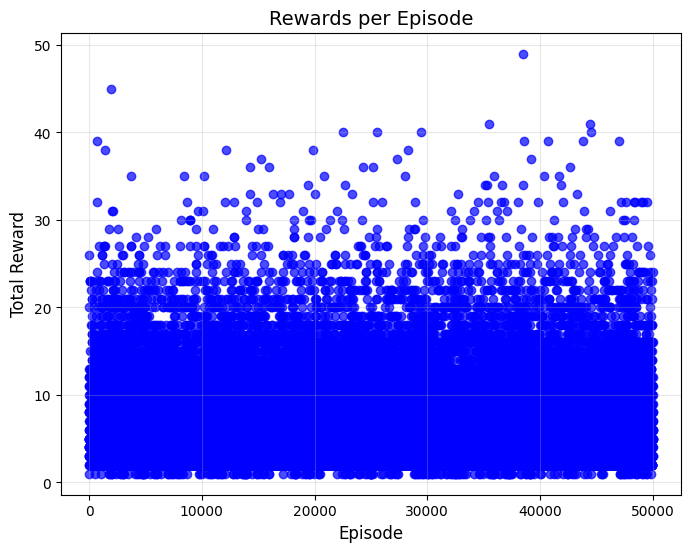

In [28]:
# save = 
plot_scatter(rewards_per_episode, title="Rewards per Episode", xlabel="Episode", ylabel="Total Reward", save= f"{version}_{num_episodes/1000}kEps_Gm{gamma}_LR{lr}.png")

In [2]:
x = torch.load("1_5.pth")

In [3]:
x

{'policy_state_dict': OrderedDict([('log_std',
               tensor([-0.0010], device='cuda:0')),
              ('fc1.weight',
               tensor([[-2.7941e-01, -7.6583e-02,  1.0283e-01, -2.5220e-01],
                       [ 7.8181e-02, -1.7051e-01, -2.1546e-01,  2.8490e-01],
                       [-1.4323e-01, -2.7750e-01,  3.4492e-02, -4.7043e-01],
                       [ 1.2349e-01, -8.1991e-02,  5.1216e-02, -2.8455e-01],
                       [ 1.1149e-01,  3.6525e-01,  1.2914e-01, -1.1227e-02],
                       [ 2.2349e-01,  4.9476e-04,  1.0697e-01,  2.4522e-01],
                       [-3.1716e-01, -4.0213e-01,  2.2599e-01,  1.1939e-01],
                       [-2.8953e-01,  5.4712e-02,  4.6629e-01,  3.1437e-01],
                       [ 1.1919e-02,  1.9442e-02, -4.2446e-01,  3.2010e-01],
                       [ 2.2713e-01,  1.3889e-01,  6.9914e-02,  3.9234e-01],
                       [-4.5341e-01, -3.2071e-01, -3.9158e-01,  2.4163e-01],
                       [ 